## Section 0 - Download / Reduce Dataset 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d geoparslp/patreco3-multitask-affective-music

100% 6.78G/6.78G [02:14<00:00, 55.2MB/s]
100% 6.78G/6.78G [02:14<00:00, 54.2MB/s]


In [ ]:
! unzip /content/patreco3-multitask-affective-music.zip

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: data/fma_genre_spectrograms_beat/train/23016.fused.full.npy  
  inflating: data/fma_genre_spectrograms_beat/train/23060.fused.full.npy  
  inflating: data/fma_genre_spectrograms_beat/train/23064.fused.full.npy  
  inflating: data/fma_genre_spectrograms_beat/train/23071.fused.full.npy  
  inflating: data/fma_genre_spectrograms_beat/train/23072.fused.full.npy  
  inflating: data/fma_genre_spectrograms_beat/train/23081.fused.full.npy  
  inflating: data/fma_genre_spectrograms_beat/train/23082.fused.full.npy  
  inflating: data/fma_genre_spectrograms_beat/train/23123.fused.full.npy  
  inflating: data/fma_genre_spectrograms_beat/train/23127.fused.full.npy  
  inflating: data/fma_genre_spectrograms_beat/train/23135.fused.full.npy  
  inflating: data/fma_genre_spectrograms_beat/train/23139.fused.full.npy  
  inflating: data/fma_genre_spectrograms_beat/train/23141.fused.full.npy  
  inflating: data/fma_genre_spectrograms_beat

In [ ]:
from lib import *

### Parameters Initialization

In [ ]:
# Combine similar classes and remove underrepresented classes
class_mapping = {
    'Rock': 'Rock',
    'Psych-Rock': 'Rock',
    'Indie-Rock': None,
    'Post-Rock': 'Rock',
    'Psych-Folk': 'Folk',
    'Folk': 'Folk',
    'Metal': 'Metal',
    'Punk': 'Metal',
    'Post-Punk': None,
    'Trip-Hop': 'Trip-Hop',
    'Pop': 'Pop',
    'Electronic': 'Electronic',
    'Hip-Hop': 'Hip-Hop',
    'Classical': 'Classical',
    'Blues': 'Blues',
    'Chiptune': 'Electronic',
    'Jazz': 'Jazz',
    'Soundtrack': None,
    'International': None,
    'Old-Time': None
}


### Plot Histograms

In [ ]:
# function for histogram plotting
def create_histogram(file_path, graph_name, mapping=False):
    with open (file_path, 'r') as f:
        lines = f.readlines() # read file
    lines.pop(0) # remove head line
    if (mapping==True):
        categories = [class_mapping[l.split('\t')[-1].strip()] for l in lines] # keep only categories after mapping
    else:
        categories = [l.split('\t')[-1].strip() for l in lines] # keep only categories
    cat_dict = {i:categories.count(i) for i in categories} # count the instances
    if (mapping==True):
        del cat_dict[None] # delete None if mapping was applied

    # plot the histogram
    fig = plt.figure(figsize=(20,5))
    plt.bar(list(cat_dict.keys()), list(cat_dict.values()), color ='skyblue',width = 0.2) # creating the bar plot
    plt.xlabel("Categories")
    plt.ylabel("Quantity")
    plt.title(graph_name)
    plt.show()

#### Training Set

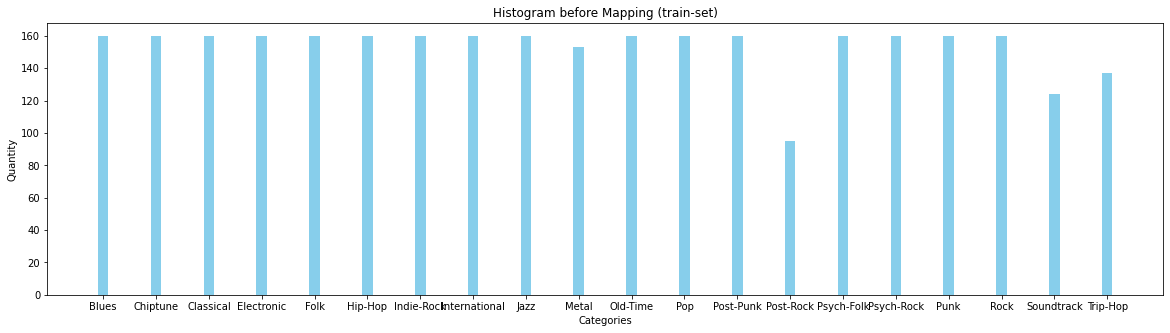

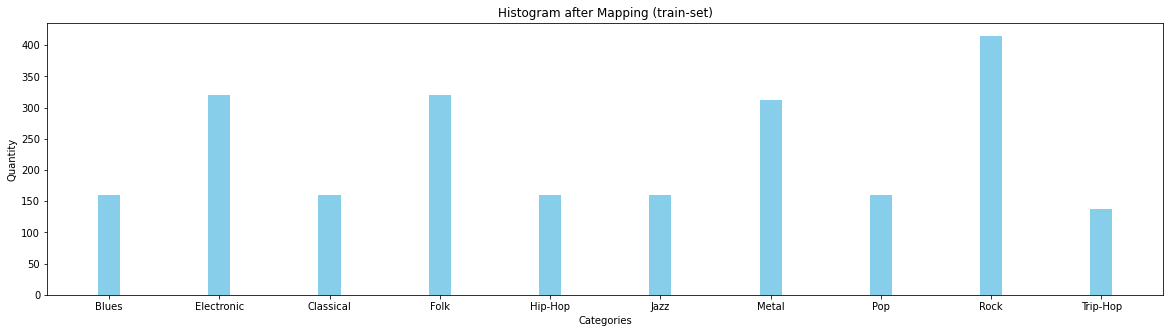

In [ ]:
file_path = 'data/fma_genre_spectrograms/train_labels.txt'
create_histogram(file_path, graph_name="Histogram before Mapping (train-set)", mapping=False)
create_histogram(file_path, graph_name="Histogram after Mapping (train-set)", mapping=True)

#### Test Set

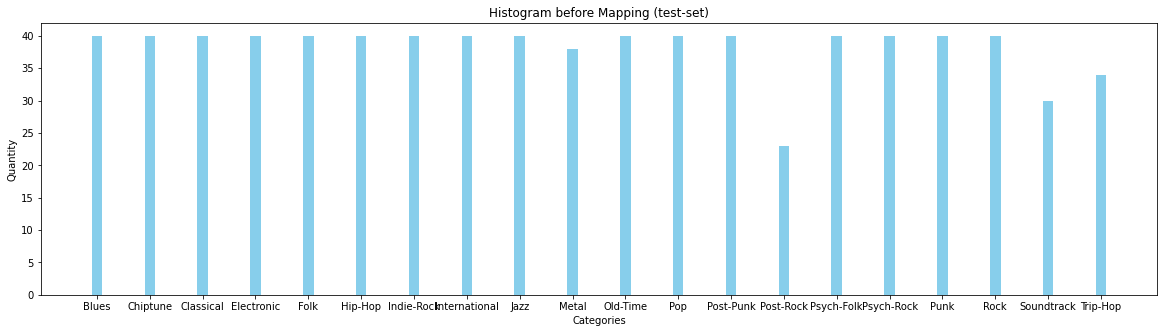

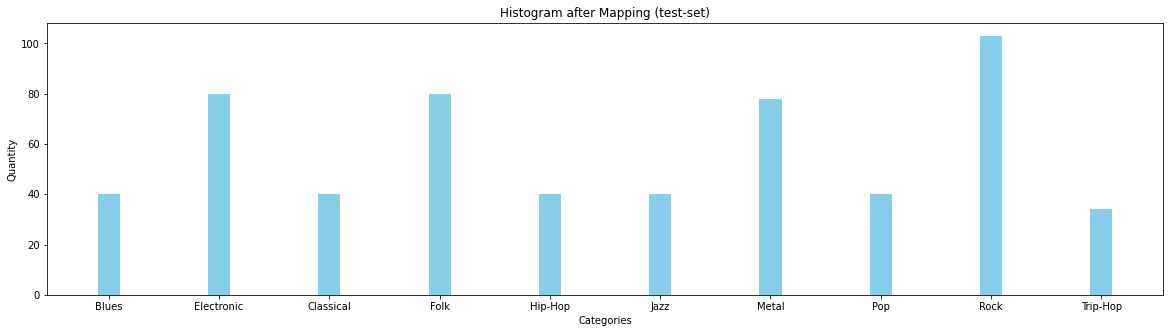

In [ ]:
file_path = 'data/fma_genre_spectrograms/test_labels.txt'
create_histogram(file_path, graph_name="Histogram before Mapping (test-set)", mapping=False)
create_histogram(file_path, graph_name="Histogram after Mapping (test-set)", mapping=True)

## Section 1 - LSTM Classification

### Define General Training Parameters

In [ ]:
# Define training parameters
val_size = 0.2
batch_size = 32
BATCH_SIZE = batch_size
EPOCHS = 100
ETA = 1e-4
OUTPUT_SIZE = 10
HIDDEN_LAYER = 50
NUM_LAYERS = 1

# Define model hyperparameters
layer_channels = [(1, 4), (4, 16), (16, 64), (64, 256)]
hidden_features = 50
out_features = 10
kernels = [5, 4, 3, 3]

# Define the additional training parameter for bidirectional LSTM
bidirectional = True

# Define the additional training parameter for pack_padded_sequence implementation
pack_padded_sequence = False

# Define the additional training parameters
weight_decay = 1e-6
dropout = .2

# Define the additional training parameter for early tolerance
PATIENCE = 10

#Define out LossFunction
criterion = nn.CrossEntropyLoss()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Feats Initialization
mels_feats = 128
chroma_feats = 12
fused_feats = mels_feats + chroma_feats

### Training and Evalution using 'beat-synced datasets'

####  Mel Spectrograms Dataset

In [ ]:
data = SpectrogramDataset("data/fma_genre_spectrograms_beat",
                              class_mapping=class_mapping, train=True, read_spec_fn=read_mel_spectrogram)
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/fma_genre_spectrograms_beat/',
                                          class_mapping=class_mapping, train=False, read_spec_fn=read_mel_spectrogram, max_length=data.max_length)

##### Overfit the model


  0%|          | 0/100 [00:00<?, ?it/s]

 [================================--------] ...Epoch 1, Loss: 2.3539
Statistics for the Train Set
	 Epoch: 1 	 loss: 2.265703928881678
	 Epoch: 1 	 Accuracy Score: 0.12147505422993492
	 Epoch: 1 	 f1 Score: 0.06146946209597286
	 Epoch: 1 	 recall Score: 0.1132867198173643


  1%|          | 1/100 [00:01<02:23,  1.45s/it]

Statistics for the Dev Set
	 Epoch: 1 	 loss: 2.2657691774697137
	 Epoch: 1 	 Accuracy Score: 0.12147505422993492
	 Epoch: 1 	 f1 Score: 0.06146946209597286
	 Epoch: 1 	 recall Score: 0.1132867198173643
Test loss decreased (inf --> 2.265769).  Saving model ...
Epoch total time 1.4500908851623535
 [================================--------] ...Epoch 2, Loss: 2.2632
Statistics for the Train Set
	 Epoch: 2 	 loss: 2.230955933702403
	 Epoch: 2 	 Accuracy Score: 0.1822125813449024
	 Epoch: 2 	 f1 Score: 0.08383120727279436
	 Epoch: 2 	 recall Score: 0.11842189067737854


  2%|▏         | 2/100 [00:02<02:19,  1.42s/it]

Statistics for the Dev Set
	 Epoch: 2 	 loss: 2.231369191202624
	 Epoch: 2 	 Accuracy Score: 0.1822125813449024
	 Epoch: 2 	 f1 Score: 0.08383120727279436
	 Epoch: 2 	 recall Score: 0.11842189067737854
Test loss decreased (2.265769 --> 2.231369).  Saving model ...
Epoch total time 1.3997023105621338
 [================================--------] ...Epoch 3, Loss: 2.2364
Statistics for the Train Set
	 Epoch: 3 	 loss: 2.2193081913323236
	 Epoch: 3 	 Accuracy Score: 0.21258134490238612
	 Epoch: 3 	 f1 Score: 0.08753363167552952
	 Epoch: 3 	 recall Score: 0.13589162161389057


  3%|▎         | 3/100 [00:04<02:16,  1.40s/it]

Statistics for the Dev Set
	 Epoch: 3 	 loss: 2.220170440344975
	 Epoch: 3 	 Accuracy Score: 0.21258134490238612
	 Epoch: 3 	 f1 Score: 0.08753363167552952
	 Epoch: 3 	 recall Score: 0.13589162161389057
Test loss decreased (2.231369 --> 2.220170).  Saving model ...
Epoch total time 1.3797633647918701
 [================================--------] ...Epoch 4, Loss: 2.1845
Statistics for the Train Set
	 Epoch: 4 	 loss: 2.2054831447272467
	 Epoch: 4 	 Accuracy Score: 0.21800433839479394
	 Epoch: 4 	 f1 Score: 0.09869827880326945
	 Epoch: 4 	 recall Score: 0.1425360837661533


  4%|▍         | 4/100 [00:05<02:13,  1.39s/it]

Statistics for the Dev Set
	 Epoch: 4 	 loss: 2.2047399241348793
	 Epoch: 4 	 Accuracy Score: 0.21800433839479394
	 Epoch: 4 	 f1 Score: 0.09869827880326945
	 Epoch: 4 	 recall Score: 0.1425360837661533
Test loss decreased (2.220170 --> 2.204740).  Saving model ...
Epoch total time 1.3683078289031982
 [================================--------] ...Epoch 5, Loss: 2.0023
Statistics for the Train Set
	 Epoch: 5 	 loss: 2.2012393351258903
	 Epoch: 5 	 Accuracy Score: 0.24240780911062906
	 Epoch: 5 	 f1 Score: 0.12416888666078951
	 Epoch: 5 	 recall Score: 0.16463672410810487


  5%|▌         | 5/100 [00:06<02:11,  1.39s/it]

Statistics for the Dev Set
	 Epoch: 5 	 loss: 2.2008413693000533
	 Epoch: 5 	 Accuracy Score: 0.24240780911062906
	 Epoch: 5 	 f1 Score: 0.12416888666078951
	 Epoch: 5 	 recall Score: 0.16463672410810487
Test loss decreased (2.204740 --> 2.200841).  Saving model ...
Epoch total time 1.3793816566467285
 [================================--------] ...Epoch 6, Loss: 2.1925
Statistics for the Train Set
	 Epoch: 6 	 loss: 2.188448955272806
	 Epoch: 6 	 Accuracy Score: 0.24566160520607375
	 Epoch: 6 	 f1 Score: 0.12287640841403835
	 Epoch: 6 	 recall Score: 0.166439328791959


  6%|▌         | 6/100 [00:08<02:13,  1.42s/it]

Statistics for the Dev Set
	 Epoch: 6 	 loss: 2.1885735413123824
	 Epoch: 6 	 Accuracy Score: 0.24566160520607375
	 Epoch: 6 	 f1 Score: 0.12287640841403835
	 Epoch: 6 	 recall Score: 0.166439328791959
Test loss decreased (2.200841 --> 2.188574).  Saving model ...
Epoch total time 1.4930973052978516
 [================================--------] ...Epoch 7, Loss: 2.2518
Statistics for the Train Set
	 Epoch: 7 	 loss: 2.1804073103542985
	 Epoch: 7 	 Accuracy Score: 0.24566160520607375
	 Epoch: 7 	 f1 Score: 0.11803229793807053
	 Epoch: 7 	 recall Score: 0.16380277467890955


  7%|▋         | 7/100 [00:09<02:11,  1.41s/it]

Statistics for the Dev Set
	 Epoch: 7 	 loss: 2.180186423762091
	 Epoch: 7 	 Accuracy Score: 0.24566160520607375
	 Epoch: 7 	 f1 Score: 0.11803229793807053
	 Epoch: 7 	 recall Score: 0.16380277467890955
Test loss decreased (2.188574 --> 2.180186).  Saving model ...
Epoch total time 1.3760221004486084
 [================================--------] ...Epoch 8, Loss: 2.3982
Statistics for the Train Set
	 Epoch: 8 	 loss: 2.168329933594013
	 Epoch: 8 	 Accuracy Score: 0.2445770065075922
	 Epoch: 8 	 f1 Score: 0.11490337353215292
	 Epoch: 8 	 recall Score: 0.16363566953941963


  8%|▊         | 8/100 [00:11<02:08,  1.40s/it]

Statistics for the Dev Set
	 Epoch: 8 	 loss: 2.1687934727504334
	 Epoch: 8 	 Accuracy Score: 0.2445770065075922
	 Epoch: 8 	 f1 Score: 0.11490337353215292
	 Epoch: 8 	 recall Score: 0.16363566953941963
Test loss decreased (2.180186 --> 2.168793).  Saving model ...
Epoch total time 1.3796396255493164
 [================================--------] ...Epoch 9, Loss: 2.1026
Statistics for the Train Set
	 Epoch: 9 	 loss: 2.1694299147046845
	 Epoch: 9 	 Accuracy Score: 0.23318872017353579
	 Epoch: 9 	 f1 Score: 0.10862466999826018
	 Epoch: 9 	 recall Score: 0.1503052103212062


  9%|▉         | 9/100 [00:12<02:07,  1.40s/it]

Statistics for the Dev Set
	 Epoch: 9 	 loss: 2.1687892223226615
	 Epoch: 9 	 Accuracy Score: 0.23318872017353579
	 Epoch: 9 	 f1 Score: 0.10862466999826018
	 Epoch: 9 	 recall Score: 0.1503052103212062
Test loss decreased (2.168793 --> 2.168789).  Saving model ...
Epoch total time 1.3844432830810547
 [================================--------] ...Epoch 10, Loss: 2.0489
Statistics for the Train Set
	 Epoch: 10 	 loss: 2.159537175606037
	 Epoch: 10 	 Accuracy Score: 0.23915401301518438
	 Epoch: 10 	 f1 Score: 0.10164106917068658
	 Epoch: 10 	 recall Score: 0.15417951859252813


 10%|█         | 10/100 [00:14<02:05,  1.40s/it]

Statistics for the Dev Set
	 Epoch: 10 	 loss: 2.1604302628286955
	 Epoch: 10 	 Accuracy Score: 0.23915401301518438
	 Epoch: 10 	 f1 Score: 0.10164106917068658
	 Epoch: 10 	 recall Score: 0.15417951859252813
Test loss decreased (2.168789 --> 2.160430).  Saving model ...
Epoch total time 1.4042179584503174
 [================================--------] ...Epoch 11, Loss: 2.0529
Statistics for the Train Set
	 Epoch: 11 	 loss: 2.1533677660185715
	 Epoch: 11 	 Accuracy Score: 0.2575921908893709
	 Epoch: 11 	 f1 Score: 0.12091984414041086
	 Epoch: 11 	 recall Score: 0.16897473966101786


 11%|█         | 11/100 [00:15<02:04,  1.40s/it]

Statistics for the Dev Set
	 Epoch: 11 	 loss: 2.1543345143055093
	 Epoch: 11 	 Accuracy Score: 0.2575921908893709
	 Epoch: 11 	 f1 Score: 0.12091984414041086
	 Epoch: 11 	 recall Score: 0.16897473966101786
Test loss decreased (2.160430 --> 2.154335).  Saving model ...
Epoch total time 1.3875131607055664
 [================================--------] ...Epoch 12, Loss: 2.2326
Statistics for the Train Set
	 Epoch: 12 	 loss: 2.144299133070584
	 Epoch: 12 	 Accuracy Score: 0.25
	 Epoch: 12 	 f1 Score: 0.11167937016404102
	 Epoch: 12 	 recall Score: 0.16296111880720138


 12%|█▏        | 12/100 [00:16<02:03,  1.40s/it]

Statistics for the Dev Set
	 Epoch: 12 	 loss: 2.145333614842645
	 Epoch: 12 	 Accuracy Score: 0.25
	 Epoch: 12 	 f1 Score: 0.11167937016404102
	 Epoch: 12 	 recall Score: 0.16296111880720138
Test loss decreased (2.154335 --> 2.145334).  Saving model ...
Epoch total time 1.4128618240356445
 [================================--------] ...Epoch 13, Loss: 2.1505
Statistics for the Train Set
	 Epoch: 13 	 loss: 2.1419938699952485
	 Epoch: 13 	 Accuracy Score: 0.2603036876355748
	 Epoch: 13 	 f1 Score: 0.11732006360546654
	 Epoch: 13 	 recall Score: 0.17177517009721593


 13%|█▎        | 13/100 [00:18<02:01,  1.40s/it]

Statistics for the Dev Set
	 Epoch: 13 	 loss: 2.1424320977309654
	 Epoch: 13 	 Accuracy Score: 0.2603036876355748
	 Epoch: 13 	 f1 Score: 0.11732006360546654
	 Epoch: 13 	 recall Score: 0.17177517009721593
Test loss decreased (2.145334 --> 2.142432).  Saving model ...
Epoch total time 1.3987658023834229
 [================================--------] ...Epoch 14, Loss: 2.2261
Statistics for the Train Set
	 Epoch: 14 	 loss: 2.140201687812805
	 Epoch: 14 	 Accuracy Score: 0.24240780911062906
	 Epoch: 14 	 f1 Score: 0.09392927257003564
	 Epoch: 14 	 recall Score: 0.15425833255010293


 14%|█▍        | 14/100 [00:19<02:00,  1.40s/it]

Statistics for the Dev Set
	 Epoch: 14 	 loss: 2.1403430022042373
	 Epoch: 14 	 Accuracy Score: 0.24240780911062906
	 Epoch: 14 	 f1 Score: 0.09392927257003564
	 Epoch: 14 	 recall Score: 0.15425833255010293
Test loss decreased (2.142432 --> 2.140343).  Saving model ...
Epoch total time 1.4026539325714111
 [================================--------] ...Epoch 15, Loss: 2.2071
Statistics for the Train Set
	 Epoch: 15 	 loss: 2.130146421235183
	 Epoch: 15 	 Accuracy Score: 0.26572668112798264
	 Epoch: 15 	 f1 Score: 0.12284456703174569
	 Epoch: 15 	 recall Score: 0.17387955142009895


 15%|█▌        | 15/100 [00:21<01:58,  1.40s/it]

Statistics for the Dev Set
	 Epoch: 15 	 loss: 2.130817842894587
	 Epoch: 15 	 Accuracy Score: 0.26572668112798264
	 Epoch: 15 	 f1 Score: 0.12284456703174569
	 Epoch: 15 	 recall Score: 0.17387955142009895
Test loss decreased (2.140343 --> 2.130818).  Saving model ...
Epoch total time 1.3784186840057373
 [================================--------] ...Epoch 16, Loss: 2.1397
Statistics for the Train Set
	 Epoch: 16 	 loss: 2.1258232696303008
	 Epoch: 16 	 Accuracy Score: 0.24566160520607375
	 Epoch: 16 	 f1 Score: 0.10502032745167474
	 Epoch: 16 	 recall Score: 0.15929564891662204


 16%|█▌        | 16/100 [00:22<01:57,  1.39s/it]

Statistics for the Dev Set
	 Epoch: 16 	 loss: 2.126582408773488
	 Epoch: 16 	 Accuracy Score: 0.24566160520607375
	 Epoch: 16 	 f1 Score: 0.10502032745167474
	 Epoch: 16 	 recall Score: 0.15929564891662204
Test loss decreased (2.130818 --> 2.126582).  Saving model ...
Epoch total time 1.3862273693084717
 [================================--------] ...Epoch 17, Loss: 2.0193
Statistics for the Train Set
	 Epoch: 17 	 loss: 2.1196768016650758
	 Epoch: 17 	 Accuracy Score: 0.25
	 Epoch: 17 	 f1 Score: 0.10361335426494359
	 Epoch: 17 	 recall Score: 0.16139411582820146


 17%|█▋        | 17/100 [00:23<01:55,  1.39s/it]

Statistics for the Dev Set
	 Epoch: 17 	 loss: 2.1193957678202926
	 Epoch: 17 	 Accuracy Score: 0.25
	 Epoch: 17 	 f1 Score: 0.10361335426494359
	 Epoch: 17 	 recall Score: 0.16139411582820146
Test loss decreased (2.126582 --> 2.119396).  Saving model ...
Epoch total time 1.392103910446167
 [================================--------] ...Epoch 18, Loss: 1.9496
Statistics for the Train Set
	 Epoch: 18 	 loss: 2.116896785538772
	 Epoch: 18 	 Accuracy Score: 0.2527114967462039
	 Epoch: 18 	 f1 Score: 0.10777246526772973
	 Epoch: 18 	 recall Score: 0.16646719708393096


 18%|█▊        | 18/100 [00:25<01:54,  1.39s/it]

Statistics for the Dev Set
	 Epoch: 18 	 loss: 2.115411156210406
	 Epoch: 18 	 Accuracy Score: 0.2527114967462039
	 Epoch: 18 	 f1 Score: 0.10777246526772973
	 Epoch: 18 	 recall Score: 0.16646719708393096
Test loss decreased (2.119396 --> 2.115411).  Saving model ...
Epoch total time 1.3930222988128662
 [================================--------] ...Epoch 19, Loss: 2.2052
Statistics for the Train Set
	 Epoch: 19 	 loss: 2.10260225781079
	 Epoch: 19 	 Accuracy Score: 0.2472885032537961
	 Epoch: 19 	 f1 Score: 0.0994022391548149
	 Epoch: 19 	 recall Score: 0.160742427796371


 19%|█▉        | 19/100 [00:26<01:55,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 19 	 loss: 2.103049903080381
	 Epoch: 19 	 Accuracy Score: 0.2472885032537961
	 Epoch: 19 	 f1 Score: 0.0994022391548149
	 Epoch: 19 	 recall Score: 0.160742427796371
Test loss decreased (2.115411 --> 2.103050).  Saving model ...
Epoch total time 1.5144917964935303
 [================================--------] ...Epoch 20, Loss: 2.1319
Statistics for the Train Set
	 Epoch: 20 	 loss: 2.0992755787125947
	 Epoch: 20 	 Accuracy Score: 0.2646420824295011
	 Epoch: 20 	 f1 Score: 0.11988233252211015
	 Epoch: 20 	 recall Score: 0.1737410283338714


 20%|██        | 20/100 [00:28<01:53,  1.42s/it]

Statistics for the Dev Set
	 Epoch: 20 	 loss: 2.1001199031698294
	 Epoch: 20 	 Accuracy Score: 0.2646420824295011
	 Epoch: 20 	 f1 Score: 0.11988233252211015
	 Epoch: 20 	 recall Score: 0.1737410283338714
Test loss decreased (2.103050 --> 2.100120).  Saving model ...
Epoch total time 1.3979740142822266
 [================================--------] ...Epoch 21, Loss: 2.1868
Statistics for the Train Set
	 Epoch: 21 	 loss: 2.0896366279700707
	 Epoch: 21 	 Accuracy Score: 0.2619305856832972
	 Epoch: 21 	 f1 Score: 0.11425043840226615
	 Epoch: 21 	 recall Score: 0.17112316483539344


 21%|██        | 21/100 [00:29<01:51,  1.41s/it]

Statistics for the Dev Set
	 Epoch: 21 	 loss: 2.089745381782795
	 Epoch: 21 	 Accuracy Score: 0.2619305856832972
	 Epoch: 21 	 f1 Score: 0.11425043840226615
	 Epoch: 21 	 recall Score: 0.17112316483539344
Test loss decreased (2.100120 --> 2.089745).  Saving model ...
Epoch total time 1.397998332977295
 [================================--------] ...Epoch 22, Loss: 2.1989
Statistics for the Train Set
	 Epoch: 22 	 loss: 2.091680243097503
	 Epoch: 22 	 Accuracy Score: 0.24620390455531455
	 Epoch: 22 	 f1 Score: 0.08960122600467649
	 Epoch: 22 	 recall Score: 0.15722136652595764


 22%|██▏       | 22/100 [00:30<01:49,  1.40s/it]

Statistics for the Dev Set
	 Epoch: 22 	 loss: 2.0919299803931137
	 Epoch: 22 	 Accuracy Score: 0.24620390455531455
	 Epoch: 22 	 f1 Score: 0.08960122600467649
	 Epoch: 22 	 recall Score: 0.15722136652595764
EarlyStopping counter: 1 out of 10
Epoch total time 1.3803057670593262
 [================================--------] ...Epoch 23, Loss: 2.0650
Statistics for the Train Set
	 Epoch: 23 	 loss: 2.0930893030659905
	 Epoch: 23 	 Accuracy Score: 0.2559652928416486
	 Epoch: 23 	 f1 Score: 0.10262063994179396
	 Epoch: 23 	 recall Score: 0.16453384822220316


 23%|██▎       | 23/100 [00:32<01:48,  1.41s/it]

Statistics for the Dev Set
	 Epoch: 23 	 loss: 2.0929447515257475
	 Epoch: 23 	 Accuracy Score: 0.2559652928416486
	 Epoch: 23 	 f1 Score: 0.10262063994179396
	 Epoch: 23 	 recall Score: 0.16453384822220316
EarlyStopping counter: 2 out of 10
Epoch total time 1.4050531387329102
 [================================--------] ...Epoch 24, Loss: 2.1297
Statistics for the Train Set
	 Epoch: 24 	 loss: 2.081000034151406
	 Epoch: 24 	 Accuracy Score: 0.2527114967462039
	 Epoch: 24 	 f1 Score: 0.0969875899004802
	 Epoch: 24 	 recall Score: 0.16153198999099624


 24%|██▍       | 24/100 [00:33<01:47,  1.41s/it]

Statistics for the Dev Set
	 Epoch: 24 	 loss: 2.079838181364125
	 Epoch: 24 	 Accuracy Score: 0.2527114967462039
	 Epoch: 24 	 f1 Score: 0.0969875899004802
	 Epoch: 24 	 recall Score: 0.16153198999099624
Test loss decreased (2.089745 --> 2.079838).  Saving model ...
Epoch total time 1.4326181411743164
 [================================--------] ...Epoch 25, Loss: 1.8918
Statistics for the Train Set
	 Epoch: 25 	 loss: 2.072101667009551
	 Epoch: 25 	 Accuracy Score: 0.25379609544468545
	 Epoch: 25 	 f1 Score: 0.0926334557936992
	 Epoch: 25 	 recall Score: 0.16260043888146525


 25%|██▌       | 25/100 [00:35<01:45,  1.41s/it]

Statistics for the Dev Set
	 Epoch: 25 	 loss: 2.071170932260053
	 Epoch: 25 	 Accuracy Score: 0.25379609544468545
	 Epoch: 25 	 f1 Score: 0.0926334557936992
	 Epoch: 25 	 recall Score: 0.16260043888146525
Test loss decreased (2.079838 --> 2.071171).  Saving model ...
Epoch total time 1.3843772411346436
 [================================--------] ...Epoch 26, Loss: 2.1319
Statistics for the Train Set
	 Epoch: 26 	 loss: 2.0600664225117913
	 Epoch: 26 	 Accuracy Score: 0.27006507592190887
	 Epoch: 26 	 f1 Score: 0.11562249117976449
	 Epoch: 26 	 recall Score: 0.17657174978877546


 26%|██▌       | 26/100 [00:36<01:43,  1.40s/it]

Statistics for the Dev Set
	 Epoch: 26 	 loss: 2.0599653823622344
	 Epoch: 26 	 Accuracy Score: 0.27006507592190887
	 Epoch: 26 	 f1 Score: 0.11562249117976449
	 Epoch: 26 	 recall Score: 0.17657174978877546
Test loss decreased (2.071171 --> 2.059965).  Saving model ...
Epoch total time 1.3797292709350586
 [================================--------] ...Epoch 27, Loss: 1.9626
Statistics for the Train Set
	 Epoch: 27 	 loss: 2.0510468256884606
	 Epoch: 27 	 Accuracy Score: 0.28524945770065074
	 Epoch: 27 	 f1 Score: 0.14309329663452336
	 Epoch: 27 	 recall Score: 0.19150978728452336


 27%|██▋       | 27/100 [00:37<01:42,  1.40s/it]

Statistics for the Dev Set
	 Epoch: 27 	 loss: 2.0503896372071626
	 Epoch: 27 	 Accuracy Score: 0.28524945770065074
	 Epoch: 27 	 f1 Score: 0.14309329663452336
	 Epoch: 27 	 recall Score: 0.19150978728452336
Test loss decreased (2.059965 --> 2.050390).  Saving model ...
Epoch total time 1.4038753509521484
 [================================--------] ...Epoch 28, Loss: 1.8848
Statistics for the Train Set
	 Epoch: 28 	 loss: 2.0468223978733193
	 Epoch: 28 	 Accuracy Score: 0.2619305856832972
	 Epoch: 28 	 f1 Score: 0.11738861496975869
	 Epoch: 28 	 recall Score: 0.16987155268713666


 28%|██▊       | 28/100 [00:39<01:41,  1.40s/it]

Statistics for the Dev Set
	 Epoch: 28 	 loss: 2.046312157450051
	 Epoch: 28 	 Accuracy Score: 0.2619305856832972
	 Epoch: 28 	 f1 Score: 0.11738861496975869
	 Epoch: 28 	 recall Score: 0.16987155268713666
Test loss decreased (2.050390 --> 2.046312).  Saving model ...
Epoch total time 1.406179428100586
 [================================--------] ...Epoch 29, Loss: 2.2230
Statistics for the Train Set
	 Epoch: 29 	 loss: 2.042914464555938
	 Epoch: 29 	 Accuracy Score: 0.2749457700650759
	 Epoch: 29 	 f1 Score: 0.1293284048167031
	 Epoch: 29 	 recall Score: 0.18277253670935986


 29%|██▉       | 29/100 [00:40<01:39,  1.40s/it]

Statistics for the Dev Set
	 Epoch: 29 	 loss: 2.044179135355456
	 Epoch: 29 	 Accuracy Score: 0.2749457700650759
	 Epoch: 29 	 f1 Score: 0.1293284048167031
	 Epoch: 29 	 recall Score: 0.18277253670935986
Test loss decreased (2.046312 --> 2.044179).  Saving model ...
Epoch total time 1.4056549072265625
 [================================--------] ...Epoch 30, Loss: 2.0857
Statistics for the Train Set
	 Epoch: 30 	 loss: 2.0416877639704736
	 Epoch: 30 	 Accuracy Score: 0.2933839479392625
	 Epoch: 30 	 f1 Score: 0.14361371104297793
	 Epoch: 30 	 recall Score: 0.19505677770459373


 30%|███       | 30/100 [00:42<01:38,  1.41s/it]

Statistics for the Dev Set
	 Epoch: 30 	 loss: 2.040798943618248
	 Epoch: 30 	 Accuracy Score: 0.2933839479392625
	 Epoch: 30 	 f1 Score: 0.14361371104297793
	 Epoch: 30 	 recall Score: 0.19505677770459373
Test loss decreased (2.044179 --> 2.040799).  Saving model ...
Epoch total time 1.4063522815704346
 [================================--------] ...Epoch 31, Loss: 2.0882
Statistics for the Train Set
	 Epoch: 31 	 loss: 2.0283093288027008
	 Epoch: 31 	 Accuracy Score: 0.27765726681127983
	 Epoch: 31 	 f1 Score: 0.12241157650798358
	 Epoch: 31 	 recall Score: 0.18122274216339262


 31%|███       | 31/100 [00:43<01:36,  1.41s/it]

Statistics for the Dev Set
	 Epoch: 31 	 loss: 2.0275024648370414
	 Epoch: 31 	 Accuracy Score: 0.27765726681127983
	 Epoch: 31 	 f1 Score: 0.12241157650798358
	 Epoch: 31 	 recall Score: 0.18122274216339262
Test loss decreased (2.040799 --> 2.027502).  Saving model ...
Epoch total time 1.4044816493988037
 [================================--------] ...Epoch 32, Loss: 2.0804
Statistics for the Train Set
	 Epoch: 32 	 loss: 2.0257350535228333
	 Epoch: 32 	 Accuracy Score: 0.2738611713665944
	 Epoch: 32 	 f1 Score: 0.12380859655611487
	 Epoch: 32 	 recall Score: 0.1800572877145262


 32%|███▏      | 32/100 [00:45<01:37,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 32 	 loss: 2.0239507042128464
	 Epoch: 32 	 Accuracy Score: 0.2738611713665944
	 Epoch: 32 	 f1 Score: 0.12380859655611487
	 Epoch: 32 	 recall Score: 0.1800572877145262
Test loss decreased (2.027502 --> 2.023951).  Saving model ...
Epoch total time 1.4830117225646973
 [================================--------] ...Epoch 33, Loss: 2.0242
Statistics for the Train Set
	 Epoch: 33 	 loss: 2.0130582842333564
	 Epoch: 33 	 Accuracy Score: 0.2868763557483731
	 Epoch: 33 	 f1 Score: 0.1411896722145316
	 Epoch: 33 	 recall Score: 0.1927192622551414


 33%|███▎      | 33/100 [00:46<01:35,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 33 	 loss: 2.013166347454334
	 Epoch: 33 	 Accuracy Score: 0.2868763557483731
	 Epoch: 33 	 f1 Score: 0.1411896722145316
	 Epoch: 33 	 recall Score: 0.1927192622551414
Test loss decreased (2.023951 --> 2.013166).  Saving model ...
Epoch total time 1.4160611629486084
 [================================--------] ...Epoch 34, Loss: 2.2300
Statistics for the Train Set
	 Epoch: 34 	 loss: 2.007153835789911
	 Epoch: 34 	 Accuracy Score: 0.28524945770065074
	 Epoch: 34 	 f1 Score: 0.15424981357348422
	 Epoch: 34 	 recall Score: 0.19834377294663916


 34%|███▍      | 34/100 [00:47<01:33,  1.41s/it]

Statistics for the Dev Set
	 Epoch: 34 	 loss: 2.0061817559702644
	 Epoch: 34 	 Accuracy Score: 0.28524945770065074
	 Epoch: 34 	 f1 Score: 0.15424981357348422
	 Epoch: 34 	 recall Score: 0.19834377294663916
Test loss decreased (2.013166 --> 2.006182).  Saving model ...
Epoch total time 1.3871777057647705
 [================================--------] ...Epoch 35, Loss: 1.9660
Statistics for the Train Set
	 Epoch: 35 	 loss: 2.0017650579584054
	 Epoch: 35 	 Accuracy Score: 0.2695227765726681
	 Epoch: 35 	 f1 Score: 0.12275129546512922
	 Epoch: 35 	 recall Score: 0.1781047779037138


 35%|███▌      | 35/100 [00:49<01:31,  1.41s/it]

Statistics for the Dev Set
	 Epoch: 35 	 loss: 2.003188936874784
	 Epoch: 35 	 Accuracy Score: 0.2695227765726681
	 Epoch: 35 	 f1 Score: 0.12275129546512922
	 Epoch: 35 	 recall Score: 0.1781047779037138
Test loss decreased (2.006182 --> 2.003189).  Saving model ...
Epoch total time 1.4064948558807373
 [================================--------] ...Epoch 36, Loss: 2.1103
Statistics for the Train Set
	 Epoch: 36 	 loss: 2.006876458381784
	 Epoch: 36 	 Accuracy Score: 0.2933839479392625
	 Epoch: 36 	 f1 Score: 0.14117870765116416
	 Epoch: 36 	 recall Score: 0.19528215560862944


 36%|███▌      | 36/100 [00:50<01:30,  1.41s/it]

Statistics for the Dev Set
	 Epoch: 36 	 loss: 2.0045310649378547
	 Epoch: 36 	 Accuracy Score: 0.2933839479392625
	 Epoch: 36 	 f1 Score: 0.14117870765116416
	 Epoch: 36 	 recall Score: 0.19528215560862944
EarlyStopping counter: 1 out of 10
Epoch total time 1.3924808502197266
 [================================--------] ...Epoch 37, Loss: 2.1242
Statistics for the Train Set
	 Epoch: 37 	 loss: 2.000005177382765
	 Epoch: 37 	 Accuracy Score: 0.3009761388286334
	 Epoch: 37 	 f1 Score: 0.1422899225858423
	 Epoch: 37 	 recall Score: 0.1997187843917098


 37%|███▋      | 37/100 [00:52<01:28,  1.40s/it]

Statistics for the Dev Set
	 Epoch: 37 	 loss: 2.0008518264211457
	 Epoch: 37 	 Accuracy Score: 0.3009761388286334
	 Epoch: 37 	 f1 Score: 0.1422899225858423
	 Epoch: 37 	 recall Score: 0.1997187843917098
Test loss decreased (2.003189 --> 2.000852).  Saving model ...
Epoch total time 1.3859117031097412
 [================================--------] ...Epoch 38, Loss: 2.1390
Statistics for the Train Set
	 Epoch: 38 	 loss: 2.008921898644546
	 Epoch: 38 	 Accuracy Score: 0.28362255965292843
	 Epoch: 38 	 f1 Score: 0.13831854918057554
	 Epoch: 38 	 recall Score: 0.18606657394209097


 38%|███▊      | 38/100 [00:53<01:27,  1.41s/it]

Statistics for the Dev Set
	 Epoch: 38 	 loss: 2.009355927335805
	 Epoch: 38 	 Accuracy Score: 0.28362255965292843
	 Epoch: 38 	 f1 Score: 0.13831854918057554
	 Epoch: 38 	 recall Score: 0.18606657394209097
EarlyStopping counter: 1 out of 10
Epoch total time 1.4247610569000244
 [================================--------] ...Epoch 39, Loss: 2.0577
Statistics for the Train Set
	 Epoch: 39 	 loss: 1.9907327314902996
	 Epoch: 39 	 Accuracy Score: 0.27711496746203906
	 Epoch: 39 	 f1 Score: 0.13123306312793775
	 Epoch: 39 	 recall Score: 0.18379427339063487


 39%|███▉      | 39/100 [00:54<01:26,  1.41s/it]

Statistics for the Dev Set
	 Epoch: 39 	 loss: 1.9898039020341018
	 Epoch: 39 	 Accuracy Score: 0.27711496746203906
	 Epoch: 39 	 f1 Score: 0.13123306312793775
	 Epoch: 39 	 recall Score: 0.18379427339063487
Test loss decreased (2.000852 --> 1.989804).  Saving model ...
Epoch total time 1.417276382446289
 [================================--------] ...Epoch 40, Loss: 1.8842
Statistics for the Train Set
	 Epoch: 40 	 loss: 1.9868174811889385
	 Epoch: 40 	 Accuracy Score: 0.29989154013015185
	 Epoch: 40 	 f1 Score: 0.15676365050188962
	 Epoch: 40 	 recall Score: 0.2030818066036293


 40%|████      | 40/100 [00:56<01:24,  1.41s/it]

Statistics for the Dev Set
	 Epoch: 40 	 loss: 1.9855122895076358
	 Epoch: 40 	 Accuracy Score: 0.29989154013015185
	 Epoch: 40 	 f1 Score: 0.15676365050188962
	 Epoch: 40 	 recall Score: 0.2030818066036293
Test loss decreased (1.989804 --> 1.985512).  Saving model ...
Epoch total time 1.4131653308868408
 [================================--------] ...Epoch 41, Loss: 2.0263
Statistics for the Train Set
	 Epoch: 41 	 loss: 1.9800487037362724
	 Epoch: 41 	 Accuracy Score: 0.302060737527115
	 Epoch: 41 	 f1 Score: 0.16402600658212688
	 Epoch: 41 	 recall Score: 0.20684390644872924


 41%|████      | 41/100 [00:57<01:23,  1.42s/it]

Statistics for the Dev Set
	 Epoch: 41 	 loss: 1.979974890577382
	 Epoch: 41 	 Accuracy Score: 0.302060737527115
	 Epoch: 41 	 f1 Score: 0.16402600658212688
	 Epoch: 41 	 recall Score: 0.20684390644872924
Test loss decreased (1.985512 --> 1.979975).  Saving model ...
Epoch total time 1.4281117916107178
 [================================--------] ...Epoch 42, Loss: 2.0080
Statistics for the Train Set
	 Epoch: 42 	 loss: 1.9726441728657689
	 Epoch: 42 	 Accuracy Score: 0.3047722342733189
	 Epoch: 42 	 f1 Score: 0.158546100723835
	 Epoch: 42 	 recall Score: 0.20672643424350282


 42%|████▏     | 42/100 [00:59<01:22,  1.42s/it]

Statistics for the Dev Set
	 Epoch: 42 	 loss: 1.9732175202205264
	 Epoch: 42 	 Accuracy Score: 0.3047722342733189
	 Epoch: 42 	 f1 Score: 0.158546100723835
	 Epoch: 42 	 recall Score: 0.20672643424350282
Test loss decreased (1.979975 --> 1.973218).  Saving model ...
Epoch total time 1.430271863937378
 [================================--------] ...Epoch 43, Loss: 1.9573
Statistics for the Train Set
	 Epoch: 43 	 loss: 1.9676489665590484
	 Epoch: 43 	 Accuracy Score: 0.30748373101952275
	 Epoch: 43 	 f1 Score: 0.1709642637307452
	 Epoch: 43 	 recall Score: 0.2151467189084455


 43%|████▎     | 43/100 [01:00<01:20,  1.42s/it]

Statistics for the Dev Set
	 Epoch: 43 	 loss: 1.9695235655225556
	 Epoch: 43 	 Accuracy Score: 0.30748373101952275
	 Epoch: 43 	 f1 Score: 0.1709642637307452
	 Epoch: 43 	 recall Score: 0.2151467189084455
Test loss decreased (1.973218 --> 1.969524).  Saving model ...
Epoch total time 1.4150214195251465
 [================================--------] ...Epoch 44, Loss: 2.2157
Statistics for the Train Set
	 Epoch: 44 	 loss: 1.9584531763504291
	 Epoch: 44 	 Accuracy Score: 0.32483731019522777
	 Epoch: 44 	 f1 Score: 0.1901758614068273
	 Epoch: 44 	 recall Score: 0.22991255094248314


 44%|████▍     | 44/100 [01:01<01:19,  1.42s/it]

Statistics for the Dev Set
	 Epoch: 44 	 loss: 1.9600040419348355
	 Epoch: 44 	 Accuracy Score: 0.32483731019522777
	 Epoch: 44 	 f1 Score: 0.1901758614068273
	 Epoch: 44 	 recall Score: 0.22991255094248314
Test loss decreased (1.969524 --> 1.960004).  Saving model ...
Epoch total time 1.4131474494934082
 [================================--------] ...Epoch 45, Loss: 2.0571
Statistics for the Train Set
	 Epoch: 45 	 loss: 1.952456178336308
	 Epoch: 45 	 Accuracy Score: 0.32212581344902386
	 Epoch: 45 	 f1 Score: 0.19257104275310705
	 Epoch: 45 	 recall Score: 0.2315837598502835


 45%|████▌     | 45/100 [01:03<01:17,  1.41s/it]

Statistics for the Dev Set
	 Epoch: 45 	 loss: 1.952666447080415
	 Epoch: 45 	 Accuracy Score: 0.32212581344902386
	 Epoch: 45 	 f1 Score: 0.19257104275310705
	 Epoch: 45 	 recall Score: 0.2315837598502835
Test loss decreased (1.960004 --> 1.952666).  Saving model ...
Epoch total time 1.4019980430603027
 [================================--------] ...Epoch 46, Loss: 1.8890
Statistics for the Train Set
	 Epoch: 46 	 loss: 1.9476370174309303
	 Epoch: 46 	 Accuracy Score: 0.324295010845987
	 Epoch: 46 	 f1 Score: 0.186175678967393
	 Epoch: 46 	 recall Score: 0.22714162695719375


 46%|████▌     | 46/100 [01:04<01:16,  1.41s/it]

Statistics for the Dev Set
	 Epoch: 46 	 loss: 1.9468529224395752
	 Epoch: 46 	 Accuracy Score: 0.324295010845987
	 Epoch: 46 	 f1 Score: 0.186175678967393
	 Epoch: 46 	 recall Score: 0.22714162695719375
Test loss decreased (1.952666 --> 1.946853).  Saving model ...
Epoch total time 1.4109728336334229
 [================================--------] ...Epoch 47, Loss: 2.0377
Statistics for the Train Set
	 Epoch: 47 	 loss: 1.9503067814070603
	 Epoch: 47 	 Accuracy Score: 0.3259219088937093
	 Epoch: 47 	 f1 Score: 0.20008036859891892
	 Epoch: 47 	 recall Score: 0.23774651973883074


 47%|████▋     | 47/100 [01:06<01:16,  1.44s/it]

Statistics for the Dev Set
	 Epoch: 47 	 loss: 1.9505219480087017
	 Epoch: 47 	 Accuracy Score: 0.3259219088937093
	 Epoch: 47 	 f1 Score: 0.20008036859891892
	 Epoch: 47 	 recall Score: 0.23774651973883074
EarlyStopping counter: 1 out of 10
Epoch total time 1.4915966987609863
 [================================--------] ...Epoch 48, Loss: 1.7717
Statistics for the Train Set
	 Epoch: 48 	 loss: 1.9413079722174282
	 Epoch: 48 	 Accuracy Score: 0.3335140997830803
	 Epoch: 48 	 f1 Score: 0.20363514285100853
	 Epoch: 48 	 recall Score: 0.24276174038877207


 48%|████▊     | 48/100 [01:07<01:14,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 48 	 loss: 1.9409757832000996
	 Epoch: 48 	 Accuracy Score: 0.3335140997830803
	 Epoch: 48 	 f1 Score: 0.20363514285100853
	 Epoch: 48 	 recall Score: 0.24276174038877207
Test loss decreased (1.946853 --> 1.940976).  Saving model ...
Epoch total time 1.4139740467071533
 [================================--------] ...Epoch 49, Loss: 2.0180
Statistics for the Train Set
	 Epoch: 49 	 loss: 1.9367060537995964
	 Epoch: 49 	 Accuracy Score: 0.33134490238611713
	 Epoch: 49 	 f1 Score: 0.20432237137965276
	 Epoch: 49 	 recall Score: 0.2443454553379723


 49%|████▉     | 49/100 [01:09<01:12,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 49 	 loss: 1.9353658043105026
	 Epoch: 49 	 Accuracy Score: 0.33134490238611713
	 Epoch: 49 	 f1 Score: 0.20432237137965276
	 Epoch: 49 	 recall Score: 0.2443454553379723
Test loss decreased (1.940976 --> 1.935366).  Saving model ...
Epoch total time 1.4160730838775635
 [================================--------] ...Epoch 50, Loss: 1.9173
Statistics for the Train Set
	 Epoch: 50 	 loss: 1.9285770572465042
	 Epoch: 50 	 Accuracy Score: 0.34164859002169196
	 Epoch: 50 	 f1 Score: 0.21051375247677034
	 Epoch: 50 	 recall Score: 0.2518917407887459


 50%|█████     | 50/100 [01:10<01:11,  1.42s/it]

Statistics for the Dev Set
	 Epoch: 50 	 loss: 1.9313994604965736
	 Epoch: 50 	 Accuracy Score: 0.34164859002169196
	 Epoch: 50 	 f1 Score: 0.21051375247677034
	 Epoch: 50 	 recall Score: 0.2518917407887459
Test loss decreased (1.935366 --> 1.931399).  Saving model ...
Epoch total time 1.4088726043701172
 [================================--------] ...Epoch 51, Loss: 1.8290
Statistics for the Train Set
	 Epoch: 51 	 loss: 1.927298064889579
	 Epoch: 51 	 Accuracy Score: 0.3286334056399132
	 Epoch: 51 	 f1 Score: 0.20068286437816552
	 Epoch: 51 	 recall Score: 0.23774153254851788


 51%|█████     | 51/100 [01:11<01:09,  1.42s/it]

Statistics for the Dev Set
	 Epoch: 51 	 loss: 1.9263696670532227
	 Epoch: 51 	 Accuracy Score: 0.3286334056399132
	 Epoch: 51 	 f1 Score: 0.20068286437816552
	 Epoch: 51 	 recall Score: 0.23774153254851788
Test loss decreased (1.931399 --> 1.926370).  Saving model ...
Epoch total time 1.4108121395111084
 [================================--------] ...Epoch 52, Loss: 1.8684
Statistics for the Train Set
	 Epoch: 52 	 loss: 1.9416577754349544
	 Epoch: 52 	 Accuracy Score: 0.31670281995661603
	 Epoch: 52 	 f1 Score: 0.1983950033842432
	 Epoch: 52 	 recall Score: 0.24196004178202674


 52%|█████▏    | 52/100 [01:13<01:08,  1.42s/it]

Statistics for the Dev Set
	 Epoch: 52 	 loss: 1.9403037120556008
	 Epoch: 52 	 Accuracy Score: 0.31670281995661603
	 Epoch: 52 	 f1 Score: 0.1983950033842432
	 Epoch: 52 	 recall Score: 0.24196004178202674
EarlyStopping counter: 1 out of 10
Epoch total time 1.4316835403442383
 [================================--------] ...Epoch 53, Loss: 1.9910
Statistics for the Train Set
	 Epoch: 53 	 loss: 1.926549777902406
	 Epoch: 53 	 Accuracy Score: 0.3232104121475054
	 Epoch: 53 	 f1 Score: 0.20047697674662257
	 Epoch: 53 	 recall Score: 0.24143858157156023


 53%|█████▎    | 53/100 [01:14<01:06,  1.42s/it]

Statistics for the Dev Set
	 Epoch: 53 	 loss: 1.9270802777389
	 Epoch: 53 	 Accuracy Score: 0.3232104121475054
	 Epoch: 53 	 f1 Score: 0.20047697674662257
	 Epoch: 53 	 recall Score: 0.24143858157156023
EarlyStopping counter: 2 out of 10
Epoch total time 1.4069373607635498
 [================================--------] ...Epoch 54, Loss: 2.1956
Statistics for the Train Set
	 Epoch: 54 	 loss: 1.9143466373969769
	 Epoch: 54 	 Accuracy Score: 0.3345986984815618
	 Epoch: 54 	 f1 Score: 0.20780419648816134
	 Epoch: 54 	 recall Score: 0.24958792834500376


 54%|█████▍    | 54/100 [01:16<01:04,  1.41s/it]

Statistics for the Dev Set
	 Epoch: 54 	 loss: 1.9144717701550187
	 Epoch: 54 	 Accuracy Score: 0.3345986984815618
	 Epoch: 54 	 f1 Score: 0.20780419648816134
	 Epoch: 54 	 recall Score: 0.24958792834500376
Test loss decreased (1.926370 --> 1.914472).  Saving model ...
Epoch total time 1.3936774730682373
 [================================--------] ...Epoch 55, Loss: 1.9065
Statistics for the Train Set
	 Epoch: 55 	 loss: 1.9113044944302788
	 Epoch: 55 	 Accuracy Score: 0.3497830802603037
	 Epoch: 55 	 f1 Score: 0.21776969059601572
	 Epoch: 55 	 recall Score: 0.2583864474513063


 55%|█████▌    | 55/100 [01:17<01:03,  1.41s/it]

Statistics for the Dev Set
	 Epoch: 55 	 loss: 1.9103159144006927
	 Epoch: 55 	 Accuracy Score: 0.3497830802603037
	 Epoch: 55 	 f1 Score: 0.21776969059601572
	 Epoch: 55 	 recall Score: 0.2583864474513063
Test loss decreased (1.914472 --> 1.910316).  Saving model ...
Epoch total time 1.4173946380615234
 [================================--------] ...Epoch 56, Loss: 2.1283
Statistics for the Train Set
	 Epoch: 56 	 loss: 1.9158518951514671
	 Epoch: 56 	 Accuracy Score: 0.3411062906724512
	 Epoch: 56 	 f1 Score: 0.2166619327050629
	 Epoch: 56 	 recall Score: 0.25640303962749683


 56%|█████▌    | 56/100 [01:19<01:02,  1.42s/it]

Statistics for the Dev Set
	 Epoch: 56 	 loss: 1.9148037926904087
	 Epoch: 56 	 Accuracy Score: 0.3411062906724512
	 Epoch: 56 	 f1 Score: 0.2166619327050629
	 Epoch: 56 	 recall Score: 0.25640303962749683
EarlyStopping counter: 1 out of 10
Epoch total time 1.4205408096313477
 [================================--------] ...Epoch 57, Loss: 2.0804
Statistics for the Train Set
	 Epoch: 57 	 loss: 1.9192759045239152
	 Epoch: 57 	 Accuracy Score: 0.3329718004338395
	 Epoch: 57 	 f1 Score: 0.19620718729221212
	 Epoch: 57 	 recall Score: 0.2443641056332037


 57%|█████▋    | 57/100 [01:20<01:01,  1.42s/it]

Statistics for the Dev Set
	 Epoch: 57 	 loss: 1.918152289143924
	 Epoch: 57 	 Accuracy Score: 0.3329718004338395
	 Epoch: 57 	 f1 Score: 0.19620718729221212
	 Epoch: 57 	 recall Score: 0.2443641056332037
EarlyStopping counter: 2 out of 10
Epoch total time 1.4356892108917236
 [================================--------] ...Epoch 58, Loss: 1.9577
Statistics for the Train Set
	 Epoch: 58 	 loss: 1.896793256545889
	 Epoch: 58 	 Accuracy Score: 0.3432754880694143
	 Epoch: 58 	 f1 Score: 0.20843295735383754
	 Epoch: 58 	 recall Score: 0.2542319725927552


 58%|█████▊    | 58/100 [01:21<00:59,  1.42s/it]

Statistics for the Dev Set
	 Epoch: 58 	 loss: 1.8976101587558616
	 Epoch: 58 	 Accuracy Score: 0.3432754880694143
	 Epoch: 58 	 f1 Score: 0.20843295735383754
	 Epoch: 58 	 recall Score: 0.2542319725927552
Test loss decreased (1.910316 --> 1.897610).  Saving model ...
Epoch total time 1.4204034805297852
 [================================--------] ...Epoch 59, Loss: 1.9143
Statistics for the Train Set
	 Epoch: 59 	 loss: 1.8906619754330865
	 Epoch: 59 	 Accuracy Score: 0.3470715835140998
	 Epoch: 59 	 f1 Score: 0.21840026873025517
	 Epoch: 59 	 recall Score: 0.26280139086863535


 59%|█████▉    | 59/100 [01:23<00:59,  1.45s/it]

Statistics for the Dev Set
	 Epoch: 59 	 loss: 1.8928879252795516
	 Epoch: 59 	 Accuracy Score: 0.3470715835140998
	 Epoch: 59 	 f1 Score: 0.21840026873025517
	 Epoch: 59 	 recall Score: 0.26280139086863535
Test loss decreased (1.897610 --> 1.892888).  Saving model ...
Epoch total time 1.5071876049041748
 [================================--------] ...Epoch 60, Loss: 2.0170
Statistics for the Train Set
	 Epoch: 60 	 loss: 1.8946384582026252
	 Epoch: 60 	 Accuracy Score: 0.3362255965292842
	 Epoch: 60 	 f1 Score: 0.20381308600216325
	 Epoch: 60 	 recall Score: 0.2538797509859726


 60%|██████    | 60/100 [01:24<00:57,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 60 	 loss: 1.8954104431744279
	 Epoch: 60 	 Accuracy Score: 0.3362255965292842
	 Epoch: 60 	 f1 Score: 0.20381308600216325
	 Epoch: 60 	 recall Score: 0.2538797509859726
EarlyStopping counter: 1 out of 10
Epoch total time 1.398075819015503
 [================================--------] ...Epoch 61, Loss: 2.0347
Statistics for the Train Set
	 Epoch: 61 	 loss: 1.8981409525049144
	 Epoch: 61 	 Accuracy Score: 0.3492407809110629
	 Epoch: 61 	 f1 Score: 0.22023675692630787
	 Epoch: 61 	 recall Score: 0.2649046379252678


 61%|██████    | 61/100 [01:26<00:55,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 61 	 loss: 1.8964283795192325
	 Epoch: 61 	 Accuracy Score: 0.3492407809110629
	 Epoch: 61 	 f1 Score: 0.22023675692630787
	 Epoch: 61 	 recall Score: 0.2649046379252678
EarlyStopping counter: 2 out of 10
Epoch total time 1.4221482276916504
 [================================--------] ...Epoch 62, Loss: 2.1490
Statistics for the Train Set
	 Epoch: 62 	 loss: 1.880378978005771
	 Epoch: 62 	 Accuracy Score: 0.34490238611713664
	 Epoch: 62 	 f1 Score: 0.20921107078482187
	 Epoch: 62 	 recall Score: 0.2591806776744904


 62%|██████▏   | 62/100 [01:27<00:54,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 62 	 loss: 1.879479496643461
	 Epoch: 62 	 Accuracy Score: 0.34490238611713664
	 Epoch: 62 	 f1 Score: 0.20921107078482187
	 Epoch: 62 	 recall Score: 0.2591806776744904
Test loss decreased (1.892888 --> 1.879479).  Saving model ...
Epoch total time 1.418060302734375
 [================================--------] ...Epoch 63, Loss: 1.8622
Statistics for the Train Set
	 Epoch: 63 	 loss: 1.8766922108058273
	 Epoch: 63 	 Accuracy Score: 0.35357917570498915
	 Epoch: 63 	 f1 Score: 0.21952733140698427
	 Epoch: 63 	 recall Score: 0.2683541496538493


 63%|██████▎   | 63/100 [01:29<00:52,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 63 	 loss: 1.876873503471243
	 Epoch: 63 	 Accuracy Score: 0.35357917570498915
	 Epoch: 63 	 f1 Score: 0.21952733140698427
	 Epoch: 63 	 recall Score: 0.2683541496538493
Test loss decreased (1.879479 --> 1.876874).  Saving model ...
Epoch total time 1.4313583374023438
 [================================--------] ...Epoch 64, Loss: 1.8216
Statistics for the Train Set
	 Epoch: 64 	 loss: 1.876789210171535
	 Epoch: 64 	 Accuracy Score: 0.3579175704989154
	 Epoch: 64 	 f1 Score: 0.2278049337750903
	 Epoch: 64 	 recall Score: 0.2754351505145979


 64%|██████▍   | 64/100 [01:30<00:51,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 64 	 loss: 1.8756001694449063
	 Epoch: 64 	 Accuracy Score: 0.3579175704989154
	 Epoch: 64 	 f1 Score: 0.2278049337750903
	 Epoch: 64 	 recall Score: 0.2754351505145979
Test loss decreased (1.876874 --> 1.875600).  Saving model ...
Epoch total time 1.4261527061462402
 [================================--------] ...Epoch 65, Loss: 1.7975
Statistics for the Train Set
	 Epoch: 65 	 loss: 1.885826558902346
	 Epoch: 65 	 Accuracy Score: 0.33676789587852496
	 Epoch: 65 	 f1 Score: 0.21057795318252143
	 Epoch: 65 	 recall Score: 0.25593224894616806


 65%|██████▌   | 65/100 [01:31<00:50,  1.44s/it]

Statistics for the Dev Set
	 Epoch: 65 	 loss: 1.8889655409188106
	 Epoch: 65 	 Accuracy Score: 0.33676789587852496
	 Epoch: 65 	 f1 Score: 0.21057795318252143
	 Epoch: 65 	 recall Score: 0.25593224894616806
EarlyStopping counter: 1 out of 10
Epoch total time 1.452772855758667
 [================================--------] ...Epoch 66, Loss: 1.7577
Statistics for the Train Set
	 Epoch: 66 	 loss: 1.8743576715732444
	 Epoch: 66 	 Accuracy Score: 0.34164859002169196
	 Epoch: 66 	 f1 Score: 0.2156582130748014
	 Epoch: 66 	 recall Score: 0.2618448065755197


 66%|██████▌   | 66/100 [01:33<00:48,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 66 	 loss: 1.8762308503019398
	 Epoch: 66 	 Accuracy Score: 0.34164859002169196
	 Epoch: 66 	 f1 Score: 0.2156582130748014
	 Epoch: 66 	 recall Score: 0.2618448065755197
EarlyStopping counter: 2 out of 10
Epoch total time 1.4227280616760254
 [================================--------] ...Epoch 67, Loss: 1.9500
Statistics for the Train Set
	 Epoch: 67 	 loss: 1.8643048528967232
	 Epoch: 67 	 Accuracy Score: 0.3552060737527115
	 Epoch: 67 	 f1 Score: 0.22971545050474554
	 Epoch: 67 	 recall Score: 0.2763198338337959


 67%|██████▋   | 67/100 [01:34<00:47,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 67 	 loss: 1.863816279789497
	 Epoch: 67 	 Accuracy Score: 0.3552060737527115
	 Epoch: 67 	 f1 Score: 0.22971545050474554
	 Epoch: 67 	 recall Score: 0.2763198338337959
Test loss decreased (1.875600 --> 1.863816).  Saving model ...
Epoch total time 1.4149246215820312
 [================================--------] ...Epoch 68, Loss: 1.6930
Statistics for the Train Set
	 Epoch: 68 	 loss: 1.8569509818636138
	 Epoch: 68 	 Accuracy Score: 0.35683297180043383
	 Epoch: 68 	 f1 Score: 0.22730770206700912
	 Epoch: 68 	 recall Score: 0.27587096993893523


 68%|██████▊   | 68/100 [01:36<00:45,  1.42s/it]

Statistics for the Dev Set
	 Epoch: 68 	 loss: 1.857017422544545
	 Epoch: 68 	 Accuracy Score: 0.35683297180043383
	 Epoch: 68 	 f1 Score: 0.22730770206700912
	 Epoch: 68 	 recall Score: 0.27587096993893523
Test loss decreased (1.863816 --> 1.857017).  Saving model ...
Epoch total time 1.4107813835144043
 [================================--------] ...Epoch 69, Loss: 1.7515
Statistics for the Train Set
	 Epoch: 69 	 loss: 1.8819776794006084
	 Epoch: 69 	 Accuracy Score: 0.35357917570498915
	 Epoch: 69 	 f1 Score: 0.2244211541883725
	 Epoch: 69 	 recall Score: 0.2726893952334268


 69%|██████▉   | 69/100 [01:37<00:44,  1.45s/it]

Statistics for the Dev Set
	 Epoch: 69 	 loss: 1.879802761406734
	 Epoch: 69 	 Accuracy Score: 0.35357917570498915
	 Epoch: 69 	 f1 Score: 0.2244211541883725
	 Epoch: 69 	 recall Score: 0.2726893952334268
EarlyStopping counter: 1 out of 10
Epoch total time 1.5076360702514648
 [================================--------] ...Epoch 70, Loss: 1.9492
Statistics for the Train Set
	 Epoch: 70 	 loss: 1.8533401222064578
	 Epoch: 70 	 Accuracy Score: 0.3546637744034707
	 Epoch: 70 	 f1 Score: 0.2249512026284295
	 Epoch: 70 	 recall Score: 0.2777545883371851


 70%|███████   | 70/100 [01:39<00:43,  1.44s/it]

Statistics for the Dev Set
	 Epoch: 70 	 loss: 1.8534366036283558
	 Epoch: 70 	 Accuracy Score: 0.3546637744034707
	 Epoch: 70 	 f1 Score: 0.2249512026284295
	 Epoch: 70 	 recall Score: 0.2777545883371851
Test loss decreased (1.857017 --> 1.853437).  Saving model ...
Epoch total time 1.4231245517730713
 [================================--------] ...Epoch 71, Loss: 1.7443
Statistics for the Train Set
	 Epoch: 71 	 loss: 1.8545749413556065
	 Epoch: 71 	 Accuracy Score: 0.35629067245119306
	 Epoch: 71 	 f1 Score: 0.2298329386009513
	 Epoch: 71 	 recall Score: 0.2728141312104755


 71%|███████   | 71/100 [01:40<00:41,  1.44s/it]

Statistics for the Dev Set
	 Epoch: 71 	 loss: 1.8539830117390073
	 Epoch: 71 	 Accuracy Score: 0.35629067245119306
	 Epoch: 71 	 f1 Score: 0.2298329386009513
	 Epoch: 71 	 recall Score: 0.2728141312104755
EarlyStopping counter: 1 out of 10
Epoch total time 1.4194965362548828
 [================================--------] ...Epoch 72, Loss: 2.0396
Statistics for the Train Set
	 Epoch: 72 	 loss: 1.8510082877915481
	 Epoch: 72 	 Accuracy Score: 0.3617136659436009
	 Epoch: 72 	 f1 Score: 0.22915257929923066
	 Epoch: 72 	 recall Score: 0.2790194826865212


 72%|███████▏  | 72/100 [01:41<00:40,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 72 	 loss: 1.8515427277005951
	 Epoch: 72 	 Accuracy Score: 0.3617136659436009
	 Epoch: 72 	 f1 Score: 0.22915257929923066
	 Epoch: 72 	 recall Score: 0.2790194826865212
Test loss decreased (1.853437 --> 1.851543).  Saving model ...
Epoch total time 1.4199066162109375
 [================================--------] ...Epoch 73, Loss: 1.7825
Statistics for the Train Set
	 Epoch: 73 	 loss: 1.847502252151226
	 Epoch: 73 	 Accuracy Score: 0.35954446854663774
	 Epoch: 73 	 f1 Score: 0.22765820573670875
	 Epoch: 73 	 recall Score: 0.27786510243477547


 73%|███████▎  | 73/100 [01:43<00:38,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 73 	 loss: 1.846988895843769
	 Epoch: 73 	 Accuracy Score: 0.35954446854663774
	 Epoch: 73 	 f1 Score: 0.22765820573670875
	 Epoch: 73 	 recall Score: 0.27786510243477547
Test loss decreased (1.851543 --> 1.846989).  Saving model ...
Epoch total time 1.4163737297058105
 [================================--------] ...Epoch 74, Loss: 2.0482
Statistics for the Train Set
	 Epoch: 74 	 loss: 1.8503475908575386
	 Epoch: 74 	 Accuracy Score: 0.36388286334056397
	 Epoch: 74 	 f1 Score: 0.232127433214168
	 Epoch: 74 	 recall Score: 0.2808020449681996


 74%|███████▍  | 74/100 [01:44<00:37,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 74 	 loss: 1.8494139642551028
	 Epoch: 74 	 Accuracy Score: 0.36388286334056397
	 Epoch: 74 	 f1 Score: 0.232127433214168
	 Epoch: 74 	 recall Score: 0.2808020449681996
EarlyStopping counter: 1 out of 10
Epoch total time 1.42635178565979
 [================================--------] ...Epoch 75, Loss: 1.6294
Statistics for the Train Set
	 Epoch: 75 	 loss: 1.8369245816921365
	 Epoch: 75 	 Accuracy Score: 0.3584598698481562
	 Epoch: 75 	 f1 Score: 0.23314668473111982
	 Epoch: 75 	 recall Score: 0.2794119367203941


 75%|███████▌  | 75/100 [01:46<00:35,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 75 	 loss: 1.8381058532616188
	 Epoch: 75 	 Accuracy Score: 0.3584598698481562
	 Epoch: 75 	 f1 Score: 0.23314668473111982
	 Epoch: 75 	 recall Score: 0.2794119367203941
Test loss decreased (1.846989 --> 1.838106).  Saving model ...
Epoch total time 1.428070306777954
 [================================--------] ...Epoch 76, Loss: 1.8239
Statistics for the Train Set
	 Epoch: 76 	 loss: 1.833452198012122
	 Epoch: 76 	 Accuracy Score: 0.36388286334056397
	 Epoch: 76 	 f1 Score: 0.234101977553902
	 Epoch: 76 	 recall Score: 0.282740801748096


 76%|███████▌  | 76/100 [01:47<00:34,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 76 	 loss: 1.832904840337819
	 Epoch: 76 	 Accuracy Score: 0.36388286334056397
	 Epoch: 76 	 f1 Score: 0.234101977553902
	 Epoch: 76 	 recall Score: 0.282740801748096
Test loss decreased (1.838106 --> 1.832905).  Saving model ...
Epoch total time 1.4180269241333008
 [================================--------] ...Epoch 77, Loss: 1.7576
Statistics for the Train Set
	 Epoch: 77 	 loss: 1.8284331375154956
	 Epoch: 77 	 Accuracy Score: 0.36388286334056397
	 Epoch: 77 	 f1 Score: 0.23709867579459817
	 Epoch: 77 	 recall Score: 0.281197141190379


 77%|███████▋  | 77/100 [01:49<00:32,  1.42s/it]

Statistics for the Dev Set
	 Epoch: 77 	 loss: 1.8273256914368992
	 Epoch: 77 	 Accuracy Score: 0.36388286334056397
	 Epoch: 77 	 f1 Score: 0.23709867579459817
	 Epoch: 77 	 recall Score: 0.281197141190379
Test loss decreased (1.832905 --> 1.827326).  Saving model ...
Epoch total time 1.4026072025299072
 [================================--------] ...Epoch 78, Loss: 1.5636
Statistics for the Train Set
	 Epoch: 78 	 loss: 1.8325957758673306
	 Epoch: 78 	 Accuracy Score: 0.368763557483731
	 Epoch: 78 	 f1 Score: 0.2343399930531683
	 Epoch: 78 	 recall Score: 0.28948667823494906


 78%|███████▊  | 78/100 [01:50<00:31,  1.42s/it]

Statistics for the Dev Set
	 Epoch: 78 	 loss: 1.8332251885841633
	 Epoch: 78 	 Accuracy Score: 0.368763557483731
	 Epoch: 78 	 f1 Score: 0.2343399930531683
	 Epoch: 78 	 recall Score: 0.28948667823494906
EarlyStopping counter: 1 out of 10
Epoch total time 1.4055473804473877
 [================================--------] ...Epoch 79, Loss: 1.7627
Statistics for the Train Set
	 Epoch: 79 	 loss: 1.8259948183750283
	 Epoch: 79 	 Accuracy Score: 0.3633405639913232
	 Epoch: 79 	 f1 Score: 0.23080150322910403
	 Epoch: 79 	 recall Score: 0.28378497101552114


 79%|███████▉  | 79/100 [01:51<00:29,  1.42s/it]

Statistics for the Dev Set
	 Epoch: 79 	 loss: 1.8257748751804745
	 Epoch: 79 	 Accuracy Score: 0.3633405639913232
	 Epoch: 79 	 f1 Score: 0.23080150322910403
	 Epoch: 79 	 recall Score: 0.28378497101552114
Test loss decreased (1.827326 --> 1.825775).  Saving model ...
Epoch total time 1.4179904460906982
 [================================--------] ...Epoch 80, Loss: 1.9750
Statistics for the Train Set
	 Epoch: 80 	 loss: 1.8314838388870502
	 Epoch: 80 	 Accuracy Score: 0.36550976138828634
	 Epoch: 80 	 f1 Score: 0.24370216912096138
	 Epoch: 80 	 recall Score: 0.2810155178440942


 80%|████████  | 80/100 [01:53<00:28,  1.44s/it]

Statistics for the Dev Set
	 Epoch: 80 	 loss: 1.8324271810465846
	 Epoch: 80 	 Accuracy Score: 0.36550976138828634
	 Epoch: 80 	 f1 Score: 0.24370216912096138
	 Epoch: 80 	 recall Score: 0.2810155178440942
EarlyStopping counter: 1 out of 10
Epoch total time 1.502927541732788
 [================================--------] ...Epoch 81, Loss: 1.7026
Statistics for the Train Set
	 Epoch: 81 	 loss: 1.8206719201186607
	 Epoch: 81 	 Accuracy Score: 0.3693058568329718
	 Epoch: 81 	 f1 Score: 0.23825483466465752
	 Epoch: 81 	 recall Score: 0.2863158994785357


 81%|████████  | 81/100 [01:54<00:27,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 81 	 loss: 1.8196962023603505
	 Epoch: 81 	 Accuracy Score: 0.3693058568329718
	 Epoch: 81 	 f1 Score: 0.23825483466465752
	 Epoch: 81 	 recall Score: 0.2863158994785357
Test loss decreased (1.825775 --> 1.819696).  Saving model ...
Epoch total time 1.4055843353271484
 [================================--------] ...Epoch 82, Loss: 1.8787
Statistics for the Train Set
	 Epoch: 82 	 loss: 1.8189823051978802
	 Epoch: 82 	 Accuracy Score: 0.3703904555314534
	 Epoch: 82 	 f1 Score: 0.24048399942214446
	 Epoch: 82 	 recall Score: 0.2873400195578519


 82%|████████▏ | 82/100 [01:56<00:25,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 82 	 loss: 1.8171578995112716
	 Epoch: 82 	 Accuracy Score: 0.3703904555314534
	 Epoch: 82 	 f1 Score: 0.24048399942214446
	 Epoch: 82 	 recall Score: 0.2873400195578519
Test loss decreased (1.819696 --> 1.817158).  Saving model ...
Epoch total time 1.4190804958343506
 [================================--------] ...Epoch 83, Loss: 1.9126
Statistics for the Train Set
	 Epoch: 83 	 loss: 1.8156272419567765
	 Epoch: 83 	 Accuracy Score: 0.37581344902386116
	 Epoch: 83 	 f1 Score: 0.24255497193872358
	 Epoch: 83 	 recall Score: 0.2896471692690349


 83%|████████▎ | 83/100 [01:57<00:24,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 83 	 loss: 1.8157688584820977
	 Epoch: 83 	 Accuracy Score: 0.37581344902386116
	 Epoch: 83 	 f1 Score: 0.24255497193872358
	 Epoch: 83 	 recall Score: 0.2896471692690349
Test loss decreased (1.817158 --> 1.815769).  Saving model ...
Epoch total time 1.4350121021270752
 [================================--------] ...Epoch 84, Loss: 1.8459
Statistics for the Train Set
	 Epoch: 84 	 loss: 1.8183518052101135
	 Epoch: 84 	 Accuracy Score: 0.3644251626898048
	 Epoch: 84 	 f1 Score: 0.23593348531880337
	 Epoch: 84 	 recall Score: 0.28064554691092064


 84%|████████▍ | 84/100 [01:59<00:22,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 84 	 loss: 1.818528278120633
	 Epoch: 84 	 Accuracy Score: 0.3644251626898048
	 Epoch: 84 	 f1 Score: 0.23593348531880337
	 Epoch: 84 	 recall Score: 0.28064554691092064
EarlyStopping counter: 1 out of 10
Epoch total time 1.4162371158599854
 [================================--------] ...Epoch 85, Loss: 2.0177
Statistics for the Train Set
	 Epoch: 85 	 loss: 1.8092511748445446
	 Epoch: 85 	 Accuracy Score: 0.37852494577006507
	 Epoch: 85 	 f1 Score: 0.253107844743336
	 Epoch: 85 	 recall Score: 0.2981145263424848


 85%|████████▌ | 85/100 [02:00<00:21,  1.43s/it]

Statistics for the Dev Set
	 Epoch: 85 	 loss: 1.8106884072566856
	 Epoch: 85 	 Accuracy Score: 0.37852494577006507
	 Epoch: 85 	 f1 Score: 0.253107844743336
	 Epoch: 85 	 recall Score: 0.2981145263424848
Test loss decreased (1.815769 --> 1.810688).  Saving model ...
Epoch total time 1.4194505214691162
 [================================--------] ...Epoch 86, Loss: 1.9892
Statistics for the Train Set
	 Epoch: 86 	 loss: 1.8059363426833317
	 Epoch: 86 	 Accuracy Score: 0.3747288503253796
	 Epoch: 86 	 f1 Score: 0.23855635909451522
	 Epoch: 86 	 recall Score: 0.2892378952016642


 86%|████████▌ | 86/100 [02:01<00:20,  1.44s/it]

Statistics for the Dev Set
	 Epoch: 86 	 loss: 1.8050365489104698
	 Epoch: 86 	 Accuracy Score: 0.3747288503253796
	 Epoch: 86 	 f1 Score: 0.23855635909451522
	 Epoch: 86 	 recall Score: 0.2892378952016642
Test loss decreased (1.810688 --> 1.805037).  Saving model ...
Epoch total time 1.464411735534668
 [================================--------] ...Epoch 87, Loss: 1.6808
Statistics for the Train Set
	 Epoch: 87 	 loss: 1.804132541705822
	 Epoch: 87 	 Accuracy Score: 0.37635574837310193
	 Epoch: 87 	 f1 Score: 0.2515962095997845
	 Epoch: 87 	 recall Score: 0.2959583499235777


 87%|████████▋ | 87/100 [02:03<00:18,  1.44s/it]

Statistics for the Dev Set
	 Epoch: 87 	 loss: 1.8027239935151462
	 Epoch: 87 	 Accuracy Score: 0.37635574837310193
	 Epoch: 87 	 f1 Score: 0.2515962095997845
	 Epoch: 87 	 recall Score: 0.2959583499235777
Test loss decreased (1.805037 --> 1.802724).  Saving model ...
Epoch total time 1.448552131652832
 [================================--------] ...Epoch 88, Loss: 2.0098
Statistics for the Train Set
	 Epoch: 88 	 loss: 1.820125571612654
	 Epoch: 88 	 Accuracy Score: 0.36984815618221256
	 Epoch: 88 	 f1 Score: 0.23486872513275953
	 Epoch: 88 	 recall Score: 0.2902938308561582


 88%|████████▊ | 88/100 [02:04<00:17,  1.45s/it]

Statistics for the Dev Set
	 Epoch: 88 	 loss: 1.8197341314677535
	 Epoch: 88 	 Accuracy Score: 0.36984815618221256
	 Epoch: 88 	 f1 Score: 0.23486872513275953
	 Epoch: 88 	 recall Score: 0.2902938308561582
EarlyStopping counter: 1 out of 10
Epoch total time 1.4510278701782227
 [================================--------] ...Epoch 89, Loss: 1.6187
Statistics for the Train Set
	 Epoch: 89 	 loss: 1.8243218064308167
	 Epoch: 89 	 Accuracy Score: 0.3703904555314534
	 Epoch: 89 	 f1 Score: 0.24275367353098748
	 Epoch: 89 	 recall Score: 0.29982338345038534


 89%|████████▉ | 89/100 [02:06<00:15,  1.45s/it]

Statistics for the Dev Set
	 Epoch: 89 	 loss: 1.824618818431065
	 Epoch: 89 	 Accuracy Score: 0.3703904555314534
	 Epoch: 89 	 f1 Score: 0.24275367353098748
	 Epoch: 89 	 recall Score: 0.29982338345038534
EarlyStopping counter: 2 out of 10
Epoch total time 1.4510252475738525
 [================================--------] ...Epoch 90, Loss: 1.8589
Statistics for the Train Set
	 Epoch: 90 	 loss: 1.8019504074392647
	 Epoch: 90 	 Accuracy Score: 0.3774403470715835
	 Epoch: 90 	 f1 Score: 0.24969149071079494
	 Epoch: 90 	 recall Score: 0.3018565208793133


 90%|█████████ | 90/100 [02:07<00:14,  1.45s/it]

Statistics for the Dev Set
	 Epoch: 90 	 loss: 1.8008614840178654
	 Epoch: 90 	 Accuracy Score: 0.3774403470715835
	 Epoch: 90 	 f1 Score: 0.24969149071079494
	 Epoch: 90 	 recall Score: 0.3018565208793133
Test loss decreased (1.802724 --> 1.800861).  Saving model ...
Epoch total time 1.4540975093841553
 [================================--------] ...Epoch 91, Loss: 2.0840
Statistics for the Train Set
	 Epoch: 91 	 loss: 1.8030845461220577
	 Epoch: 91 	 Accuracy Score: 0.3660520607375271
	 Epoch: 91 	 f1 Score: 0.2436174572253842
	 Epoch: 91 	 recall Score: 0.2918601988550843


 91%|█████████ | 91/100 [02:09<00:13,  1.48s/it]

Statistics for the Dev Set
	 Epoch: 91 	 loss: 1.801874358078529
	 Epoch: 91 	 Accuracy Score: 0.3660520607375271
	 Epoch: 91 	 f1 Score: 0.2436174572253842
	 Epoch: 91 	 recall Score: 0.2918601988550843
EarlyStopping counter: 1 out of 10
Epoch total time 1.546590805053711
 [================================--------] ...Epoch 92, Loss: 1.8853
Statistics for the Train Set
	 Epoch: 92 	 loss: 1.808525410191766
	 Epoch: 92 	 Accuracy Score: 0.36225596529284165
	 Epoch: 92 	 f1 Score: 0.2449069165746356
	 Epoch: 92 	 recall Score: 0.28728002109377787


 92%|█████████▏| 92/100 [02:10<00:11,  1.47s/it]

Statistics for the Dev Set
	 Epoch: 92 	 loss: 1.8089189591078922
	 Epoch: 92 	 Accuracy Score: 0.36225596529284165
	 Epoch: 92 	 f1 Score: 0.2449069165746356
	 Epoch: 92 	 recall Score: 0.28728002109377787
EarlyStopping counter: 2 out of 10
Epoch total time 1.436668872833252
 [================================--------] ...Epoch 93, Loss: 1.7004
Statistics for the Train Set
	 Epoch: 93 	 loss: 1.8002565441460445
	 Epoch: 93 	 Accuracy Score: 0.37635574837310193
	 Epoch: 93 	 f1 Score: 0.25367990223428943
	 Epoch: 93 	 recall Score: 0.29989217142307334


 93%|█████████▎| 93/100 [02:12<00:10,  1.47s/it]

Statistics for the Dev Set
	 Epoch: 93 	 loss: 1.8010806914033561
	 Epoch: 93 	 Accuracy Score: 0.37635574837310193
	 Epoch: 93 	 f1 Score: 0.25367990223428943
	 Epoch: 93 	 recall Score: 0.29989217142307334
EarlyStopping counter: 3 out of 10
Epoch total time 1.4747035503387451
 [================================--------] ...Epoch 94, Loss: 1.9090
Statistics for the Train Set
	 Epoch: 94 	 loss: 1.7882348360686466
	 Epoch: 94 	 Accuracy Score: 0.36496746203904556
	 Epoch: 94 	 f1 Score: 0.23965466601829558
	 Epoch: 94 	 recall Score: 0.28957855258770043


 94%|█████████▍| 94/100 [02:13<00:08,  1.46s/it]

Statistics for the Dev Set
	 Epoch: 94 	 loss: 1.7849324263375381
	 Epoch: 94 	 Accuracy Score: 0.36496746203904556
	 Epoch: 94 	 f1 Score: 0.23965466601829558
	 Epoch: 94 	 recall Score: 0.28957855258770043
Test loss decreased (1.800861 --> 1.784932).  Saving model ...
Epoch total time 1.420405626296997
 [================================--------] ...Epoch 95, Loss: 1.5902
Statistics for the Train Set
	 Epoch: 95 	 loss: 1.7850804287811806
	 Epoch: 95 	 Accuracy Score: 0.3866594360086768
	 Epoch: 95 	 f1 Score: 0.2610163995175012
	 Epoch: 95 	 recall Score: 0.3060430264073103


 95%|█████████▌| 95/100 [02:15<00:07,  1.45s/it]

Statistics for the Dev Set
	 Epoch: 95 	 loss: 1.7852723351840316
	 Epoch: 95 	 Accuracy Score: 0.3866594360086768
	 Epoch: 95 	 f1 Score: 0.2610163995175012
	 Epoch: 95 	 recall Score: 0.3060430264073103
EarlyStopping counter: 1 out of 10
Epoch total time 1.449671745300293
 [================================--------] ...Epoch 96, Loss: 1.8162
Statistics for the Train Set
	 Epoch: 96 	 loss: 1.7917368247591217
	 Epoch: 96 	 Accuracy Score: 0.3720173535791757
	 Epoch: 96 	 f1 Score: 0.24849695831030766
	 Epoch: 96 	 recall Score: 0.29778154706645227


 96%|█████████▌| 96/100 [02:16<00:05,  1.45s/it]

Statistics for the Dev Set
	 Epoch: 96 	 loss: 1.7925684760356773
	 Epoch: 96 	 Accuracy Score: 0.3720173535791757
	 Epoch: 96 	 f1 Score: 0.24849695831030766
	 Epoch: 96 	 recall Score: 0.29778154706645227
EarlyStopping counter: 2 out of 10
Epoch total time 1.4523465633392334
 [================================--------] ...Epoch 97, Loss: 1.7149
Statistics for the Train Set
	 Epoch: 97 	 loss: 1.778646639708815
	 Epoch: 97 	 Accuracy Score: 0.3823210412147505
	 Epoch: 97 	 f1 Score: 0.2537650268731789
	 Epoch: 97 	 recall Score: 0.3026328421085479


 97%|█████████▋| 97/100 [02:18<00:04,  1.45s/it]

Statistics for the Dev Set
	 Epoch: 97 	 loss: 1.7812656349149243
	 Epoch: 97 	 Accuracy Score: 0.3823210412147505
	 Epoch: 97 	 f1 Score: 0.2537650268731789
	 Epoch: 97 	 recall Score: 0.3026328421085479
Test loss decreased (1.784932 --> 1.781266).  Saving model ...
Epoch total time 1.4330036640167236
 [================================--------] ...Epoch 98, Loss: 1.7086
Statistics for the Train Set
	 Epoch: 98 	 loss: 1.7844571389000992
	 Epoch: 98 	 Accuracy Score: 0.37906724511930584
	 Epoch: 98 	 f1 Score: 0.25437225416200826
	 Epoch: 98 	 recall Score: 0.2952137752461789


 98%|█████████▊| 98/100 [02:19<00:02,  1.46s/it]

Statistics for the Dev Set
	 Epoch: 98 	 loss: 1.7838534466151534
	 Epoch: 98 	 Accuracy Score: 0.37906724511930584
	 Epoch: 98 	 f1 Score: 0.25437225416200826
	 Epoch: 98 	 recall Score: 0.2952137752461789
EarlyStopping counter: 1 out of 10
Epoch total time 1.4750394821166992
 [================================--------] ...Epoch 99, Loss: 1.5915
Statistics for the Train Set
	 Epoch: 99 	 loss: 1.8042945430196564
	 Epoch: 99 	 Accuracy Score: 0.36713665943600865
	 Epoch: 99 	 f1 Score: 0.24217968293254163
	 Epoch: 99 	 recall Score: 0.2857647037364363


 99%|█████████▉| 99/100 [02:20<00:01,  1.45s/it]

Statistics for the Dev Set
	 Epoch: 99 	 loss: 1.804539012497869
	 Epoch: 99 	 Accuracy Score: 0.36713665943600865
	 Epoch: 99 	 f1 Score: 0.24217968293254163
	 Epoch: 99 	 recall Score: 0.2857647037364363
EarlyStopping counter: 2 out of 10
Epoch total time 1.4397861957550049
 [================================--------] ...Epoch 100, Loss: 1.8556
Statistics for the Train Set
	 Epoch: 100 	 loss: 1.7890263138146236
	 Epoch: 100 	 Accuracy Score: 0.3806941431670282
	 Epoch: 100 	 f1 Score: 0.25355823967217955
	 Epoch: 100 	 recall Score: 0.3004319831431476


100%|██████████| 100/100 [02:22<00:00,  1.42s/it]

Statistics for the Dev Set
	 Epoch: 100 	 loss: 1.790129460137466
	 Epoch: 100 	 Accuracy Score: 0.3806941431670282
	 Epoch: 100 	 f1 Score: 0.25355823967217955
	 Epoch: 100 	 recall Score: 0.3004319831431476
EarlyStopping counter: 3 out of 10
Epoch total time 1.4610192775726318
Training total time 142.2248077392578


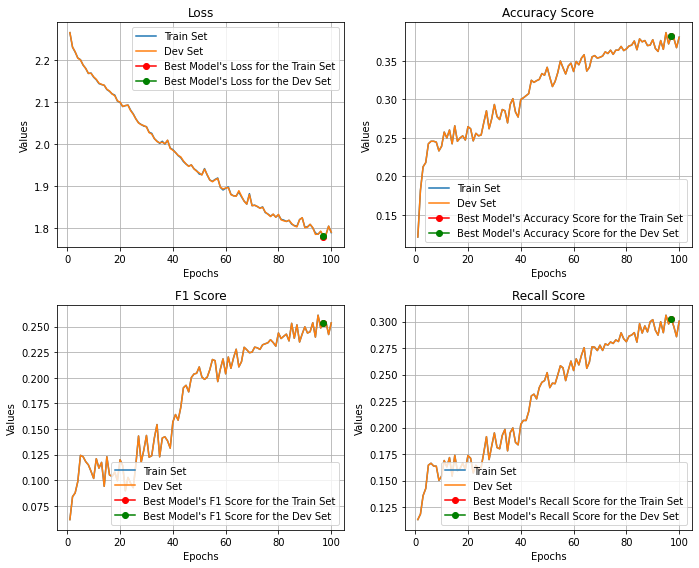

In [ ]:
EarlyLSTMNet = LSTM(input_dim=mels_feats,
                    rnn_size=HIDDEN_LAYER,
                    output_dim=OUTPUT_SIZE,
                    num_layers=NUM_LAYERS,
                    dropout=dropout,
                    pack_padded_sequence=pack_padded_sequence).to(device)

# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(EarlyLSTMNet.parameters(), lr=ETA, weight_decay=weight_decay)

clf_main(device, EarlyLSTMNet, mels_feats, optimizer, criterion, train_loader, train_loader, EPOCHS, PATIENCE=PATIENCE, overfit_batch=True)

##### Normal Training

  0%|          | 0/100 [00:00<?, ?it/s]

 [================================--------] ...Epoch 1, Loss: 2.3276
Statistics for the Train Set
	 Epoch: 1 	 loss: 2.2811734100867964
	 Epoch: 1 	 Accuracy Score: 0.12852494577006507
	 Epoch: 1 	 f1 Score: 0.05992846325805408
	 Epoch: 1 	 recall Score: 0.10024061237051671
Statistics for the Dev Set
	 Epoch: 1 	 loss: 2.3007618109385173


  1%|          | 1/100 [00:01<02:04,  1.26s/it]

	 Epoch: 1 	 Accuracy Score: 0.10845986984815618
	 Epoch: 1 	 f1 Score: 0.051440919042698895
	 Epoch: 1 	 recall Score: 0.10398065939540593
Test loss decreased (inf --> 2.300762).  Saving model ...
Epoch total time 1.258072853088379
 [================================--------] ...Epoch 2, Loss: 2.2792

  2%|▏         | 2/100 [00:02<01:56,  1.19s/it]


Statistics for the Train Set
	 Epoch: 2 	 loss: 2.254052869204817
	 Epoch: 2 	 Accuracy Score: 0.14154013015184383
	 Epoch: 2 	 f1 Score: 0.05569481881626096
	 Epoch: 2 	 recall Score: 0.10213376283566519
Statistics for the Dev Set
	 Epoch: 2 	 loss: 2.2613014856974285
	 Epoch: 2 	 Accuracy Score: 0.1279826464208243
	 Epoch: 2 	 f1 Score: 0.048409965856712964
	 Epoch: 2 	 recall Score: 0.11038512179065177
Test loss decreased (2.300762 --> 2.261301).  Saving model ...
Epoch total time 1.1345372200012207
 [================================--------] ...Epoch 3, Loss: 2.2765

  3%|▎         | 3/100 [00:03<01:51,  1.15s/it]


Statistics for the Train Set
	 Epoch: 3 	 loss: 2.230245228471427
	 Epoch: 3 	 Accuracy Score: 0.1643167028199566
	 Epoch: 3 	 f1 Score: 0.07302201003888989
	 Epoch: 3 	 recall Score: 0.11748584294935446
Statistics for the Dev Set
	 Epoch: 3 	 loss: 2.2413230101267496
	 Epoch: 3 	 Accuracy Score: 0.15184381778741865
	 Epoch: 3 	 f1 Score: 0.05730564550840449
	 Epoch: 3 	 recall Score: 0.12029361421988152
Test loss decreased (2.261301 --> 2.241323).  Saving model ...
Epoch total time 1.1034202575683594
 [================================--------] ...Epoch 4, Loss: 2.2540

  4%|▍         | 4/100 [00:04<01:48,  1.13s/it]


Statistics for the Train Set
	 Epoch: 4 	 loss: 2.2188765386055254
	 Epoch: 4 	 Accuracy Score: 0.16648590021691975
	 Epoch: 4 	 f1 Score: 0.06350960385007305
	 Epoch: 4 	 recall Score: 0.115990591848534
Statistics for the Dev Set
	 Epoch: 4 	 loss: 2.22932710647583
	 Epoch: 4 	 Accuracy Score: 0.15835140997830802
	 Epoch: 4 	 f1 Score: 0.0641987193948369
	 Epoch: 4 	 recall Score: 0.12794667544437133
Test loss decreased (2.241323 --> 2.229327).  Saving model ...
Epoch total time 1.1109576225280762
 [================================--------] ...Epoch 5, Loss: 2.1580

  5%|▌         | 5/100 [00:05<01:46,  1.12s/it]


Statistics for the Train Set
	 Epoch: 5 	 loss: 2.199559367936233
	 Epoch: 5 	 Accuracy Score: 0.22125813449023862
	 Epoch: 5 	 f1 Score: 0.09432812432459442
	 Epoch: 5 	 recall Score: 0.1476544053483581
Statistics for the Dev Set
	 Epoch: 5 	 loss: 2.2151668866475425
	 Epoch: 5 	 Accuracy Score: 0.2386117136659436
	 Epoch: 5 	 f1 Score: 0.10467614710165134
	 Epoch: 5 	 recall Score: 0.17015075707702437
Test loss decreased (2.229327 --> 2.215167).  Saving model ...
Epoch total time 1.105041742324829
 [================================--------] ...Epoch 6, Loss: 2.1511

  6%|▌         | 6/100 [00:06<01:45,  1.12s/it]


Statistics for the Train Set
	 Epoch: 6 	 loss: 2.1883025333799164
	 Epoch: 6 	 Accuracy Score: 0.23644251626898047
	 Epoch: 6 	 f1 Score: 0.09473427752091498
	 Epoch: 6 	 recall Score: 0.15436971187893697
Statistics for the Dev Set
	 Epoch: 6 	 loss: 2.1955178578694663
	 Epoch: 6 	 Accuracy Score: 0.25379609544468545
	 Epoch: 6 	 f1 Score: 0.10747854605731715
	 Epoch: 6 	 recall Score: 0.16466096115865703
Test loss decreased (2.215167 --> 2.195518).  Saving model ...
Epoch total time 1.1152598857879639
 [================================--------] ...Epoch 7, Loss: 2.2603

  7%|▋         | 7/100 [00:07<01:44,  1.12s/it]


Statistics for the Train Set
	 Epoch: 7 	 loss: 2.1814924231890975
	 Epoch: 7 	 Accuracy Score: 0.22613882863340565
	 Epoch: 7 	 f1 Score: 0.09062139177886433
	 Epoch: 7 	 recall Score: 0.1474819699118163
Statistics for the Dev Set
	 Epoch: 7 	 loss: 2.194793876012166
	 Epoch: 7 	 Accuracy Score: 0.23210412147505424
	 Epoch: 7 	 f1 Score: 0.09798663990613643
	 Epoch: 7 	 recall Score: 0.14847399605003292
Test loss decreased (2.195518 --> 2.194794).  Saving model ...
Epoch total time 1.1262562274932861
 [================================--------] ...Epoch 8, Loss: 2.0663

  8%|▊         | 8/100 [00:09<01:43,  1.12s/it]


Statistics for the Train Set
	 Epoch: 8 	 loss: 2.169763980240657
	 Epoch: 8 	 Accuracy Score: 0.2185466377440347
	 Epoch: 8 	 f1 Score: 0.08686807187775966
	 Epoch: 8 	 recall Score: 0.14469632577630517
Statistics for the Dev Set
	 Epoch: 8 	 loss: 2.177884801228841
	 Epoch: 8 	 Accuracy Score: 0.23644251626898047
	 Epoch: 8 	 f1 Score: 0.10528404235594972
	 Epoch: 8 	 recall Score: 0.1594569526735425
Test loss decreased (2.194794 --> 2.177885).  Saving model ...
Epoch total time 1.114018440246582
 [================================--------] ...Epoch 9, Loss: 2.1134

  9%|▉         | 9/100 [00:10<01:42,  1.12s/it]


Statistics for the Train Set
	 Epoch: 9 	 loss: 2.1614982999604324
	 Epoch: 9 	 Accuracy Score: 0.2359002169197397
	 Epoch: 9 	 f1 Score: 0.09514626686314502
	 Epoch: 9 	 recall Score: 0.15549192690658406
Statistics for the Dev Set
	 Epoch: 9 	 loss: 2.1773491223653156
	 Epoch: 9 	 Accuracy Score: 0.25162689804772237
	 Epoch: 9 	 f1 Score: 0.10442296160549662
	 Epoch: 9 	 recall Score: 0.16152139565503623
Test loss decreased (2.177885 --> 2.177349).  Saving model ...
Epoch total time 1.1234760284423828
 [================================--------] ...Epoch 10, Loss: 2.1717

 10%|█         | 10/100 [00:11<01:41,  1.13s/it]


Statistics for the Train Set
	 Epoch: 10 	 loss: 2.153446920986833
	 Epoch: 10 	 Accuracy Score: 0.24620390455531455
	 Epoch: 10 	 f1 Score: 0.0997950420419726
	 Epoch: 10 	 recall Score: 0.16108286033026445
Statistics for the Dev Set
	 Epoch: 10 	 loss: 2.1596299489339192
	 Epoch: 10 	 Accuracy Score: 0.2472885032537961
	 Epoch: 10 	 f1 Score: 0.10671096426474272
	 Epoch: 10 	 recall Score: 0.16582422646477948
Test loss decreased (2.177349 --> 2.159630).  Saving model ...
Epoch total time 1.1364221572875977
 [================================--------] ...Epoch 11, Loss: 2.1983

 11%|█         | 11/100 [00:12<01:40,  1.12s/it]


Statistics for the Train Set
	 Epoch: 11 	 loss: 2.151333821230921
	 Epoch: 11 	 Accuracy Score: 0.232646420824295
	 Epoch: 11 	 f1 Score: 0.09363747501512695
	 Epoch: 11 	 recall Score: 0.15404635906824185
Statistics for the Dev Set
	 Epoch: 11 	 loss: 2.1635528882344564
	 Epoch: 11 	 Accuracy Score: 0.2603036876355748
	 Epoch: 11 	 f1 Score: 0.11186085781830464
	 Epoch: 11 	 recall Score: 0.17360500329163925
EarlyStopping counter: 1 out of 10
Epoch total time 1.1130099296569824
 [================================--------] ...Epoch 12, Loss: 2.0759

 12%|█▏        | 12/100 [00:13<01:38,  1.12s/it]


Statistics for the Train Set
	 Epoch: 12 	 loss: 2.1406705050632873
	 Epoch: 12 	 Accuracy Score: 0.25108459869848154
	 Epoch: 12 	 f1 Score: 0.09883127224449124
	 Epoch: 12 	 recall Score: 0.16304157060175253
Statistics for the Dev Set
	 Epoch: 12 	 loss: 2.14594833056132
	 Epoch: 12 	 Accuracy Score: 0.2668112798264642
	 Epoch: 12 	 f1 Score: 0.10967385823988762
	 Epoch: 12 	 recall Score: 0.16876431863067806
Test loss decreased (2.159630 --> 2.145948).  Saving model ...
Epoch total time 1.1229054927825928
 [================================--------] ...Epoch 13, Loss: 2.0947

 13%|█▎        | 13/100 [00:14<01:38,  1.14s/it]


Statistics for the Train Set
	 Epoch: 13 	 loss: 2.1325390626644265
	 Epoch: 13 	 Accuracy Score: 0.24240780911062906
	 Epoch: 13 	 f1 Score: 0.10177620286706941
	 Epoch: 13 	 recall Score: 0.1601071372042624
Statistics for the Dev Set
	 Epoch: 13 	 loss: 2.147893206278483
	 Epoch: 13 	 Accuracy Score: 0.25379609544468545
	 Epoch: 13 	 f1 Score: 0.11196961071439997
	 Epoch: 13 	 recall Score: 0.16996649842732792
EarlyStopping counter: 1 out of 10
Epoch total time 1.1639904975891113
 [================================--------] ...Epoch 14, Loss: 2.1429

 14%|█▍        | 14/100 [00:15<01:38,  1.14s/it]


Statistics for the Train Set
	 Epoch: 14 	 loss: 2.131418252813405
	 Epoch: 14 	 Accuracy Score: 0.2413232104121475
	 Epoch: 14 	 f1 Score: 0.09939758771427173
	 Epoch: 14 	 recall Score: 0.1592252546179947
Statistics for the Dev Set
	 Epoch: 14 	 loss: 2.13412614663442
	 Epoch: 14 	 Accuracy Score: 0.26247288503253796
	 Epoch: 14 	 f1 Score: 0.11073118485431625
	 Epoch: 14 	 recall Score: 0.17148255431204742
Test loss decreased (2.145948 --> 2.134126).  Saving model ...
Epoch total time 1.1576428413391113
 [================================--------] ...Epoch 15, Loss: 2.1067

 15%|█▌        | 15/100 [00:17<01:36,  1.14s/it]


Statistics for the Train Set
	 Epoch: 15 	 loss: 2.125192666875905
	 Epoch: 15 	 Accuracy Score: 0.23915401301518438
	 Epoch: 15 	 f1 Score: 0.09405390581554832
	 Epoch: 15 	 recall Score: 0.15466090209074848
Statistics for the Dev Set
	 Epoch: 15 	 loss: 2.125373355547587
	 Epoch: 15 	 Accuracy Score: 0.279826464208243
	 Epoch: 15 	 f1 Score: 0.109775608634293
	 Epoch: 15 	 recall Score: 0.17408953258722842
Test loss decreased (2.134126 --> 2.125373).  Saving model ...
Epoch total time 1.1227641105651855
 [================================--------] ...Epoch 16, Loss: 2.2159

 16%|█▌        | 16/100 [00:18<01:35,  1.13s/it]


Statistics for the Train Set
	 Epoch: 16 	 loss: 2.117128487291007
	 Epoch: 16 	 Accuracy Score: 0.24837310195227766
	 Epoch: 16 	 f1 Score: 0.10227726924338851
	 Epoch: 16 	 recall Score: 0.16313759274469822
Statistics for the Dev Set
	 Epoch: 16 	 loss: 2.115071241060893
	 Epoch: 16 	 Accuracy Score: 0.28633405639913234
	 Epoch: 16 	 f1 Score: 0.11666410691671383
	 Epoch: 16 	 recall Score: 0.18450230414746543
Test loss decreased (2.125373 --> 2.115071).  Saving model ...
Epoch total time 1.1205530166625977
 [================================--------] ...Epoch 17, Loss: 2.1155

 17%|█▋        | 17/100 [00:19<01:33,  1.13s/it]


Statistics for the Train Set
	 Epoch: 17 	 loss: 2.112322538063444
	 Epoch: 17 	 Accuracy Score: 0.24945770065075923
	 Epoch: 17 	 f1 Score: 0.10311287451085933
	 Epoch: 17 	 recall Score: 0.1623286876191021
Statistics for the Dev Set
	 Epoch: 17 	 loss: 2.1151627699534097
	 Epoch: 17 	 Accuracy Score: 0.27765726681127983
	 Epoch: 17 	 f1 Score: 0.10609207086842869
	 Epoch: 17 	 recall Score: 0.16953917050691242
EarlyStopping counter: 1 out of 10
Epoch total time 1.123359203338623
 [================================--------] ...Epoch 18, Loss: 2.2720

 18%|█▊        | 18/100 [00:20<01:32,  1.13s/it]


Statistics for the Train Set
	 Epoch: 18 	 loss: 2.110822089787187
	 Epoch: 18 	 Accuracy Score: 0.24620390455531455
	 Epoch: 18 	 f1 Score: 0.10056079572164782
	 Epoch: 18 	 recall Score: 0.16154152333549915
Statistics for the Dev Set
	 Epoch: 18 	 loss: 2.1124994277954103
	 Epoch: 18 	 Accuracy Score: 0.28199566160520606
	 Epoch: 18 	 f1 Score: 0.12147109471094711
	 Epoch: 18 	 recall Score: 0.1855016458196182
Test loss decreased (2.115071 --> 2.112499).  Saving model ...
Epoch total time 1.127180576324463
 [================================--------] ...Epoch 19, Loss: 2.0462

 19%|█▉        | 19/100 [00:21<01:31,  1.13s/it]


Statistics for the Train Set
	 Epoch: 19 	 loss: 2.100440370625463
	 Epoch: 19 	 Accuracy Score: 0.2586767895878525
	 Epoch: 19 	 f1 Score: 0.10704804414426516
	 Epoch: 19 	 recall Score: 0.16831694488373455
Statistics for the Dev Set
	 Epoch: 19 	 loss: 2.0974071343739826
	 Epoch: 19 	 Accuracy Score: 0.2993492407809111
	 Epoch: 19 	 f1 Score: 0.12021401364137008
	 Epoch: 19 	 recall Score: 0.19074522712310732
Test loss decreased (2.112499 --> 2.097407).  Saving model ...
Epoch total time 1.1292738914489746
 [================================--------] ...Epoch 20, Loss: 2.2152

 20%|██        | 20/100 [00:22<01:30,  1.13s/it]


Statistics for the Train Set
	 Epoch: 20 	 loss: 2.093994183786984
	 Epoch: 20 	 Accuracy Score: 0.2613882863340564
	 Epoch: 20 	 f1 Score: 0.11381240106019483
	 Epoch: 20 	 recall Score: 0.17014317318407252
Statistics for the Dev Set
	 Epoch: 20 	 loss: 2.094188682238261
	 Epoch: 20 	 Accuracy Score: 0.29067245119305857
	 Epoch: 20 	 f1 Score: 0.12897978115853626
	 Epoch: 20 	 recall Score: 0.18716984858459512
Test loss decreased (2.097407 --> 2.094189).  Saving model ...
Epoch total time 1.1396780014038086
 [================================--------] ...Epoch 21, Loss: 2.0503

 21%|██        | 21/100 [00:23<01:29,  1.13s/it]


Statistics for the Train Set
	 Epoch: 21 	 loss: 2.089929157289965
	 Epoch: 21 	 Accuracy Score: 0.2543383947939262
	 Epoch: 21 	 f1 Score: 0.11169980830339057
	 Epoch: 21 	 recall Score: 0.1667263789406242
Statistics for the Dev Set
	 Epoch: 21 	 loss: 2.082974171638489
	 Epoch: 21 	 Accuracy Score: 0.2841648590021692
	 Epoch: 21 	 f1 Score: 0.12230148268166788
	 Epoch: 21 	 recall Score: 0.1762223685172994
Test loss decreased (2.094189 --> 2.082974).  Saving model ...
Epoch total time 1.124948263168335
 [================================--------] ...Epoch 22, Loss: 2.1227

 22%|██▏       | 22/100 [00:24<01:28,  1.13s/it]


Statistics for the Train Set
	 Epoch: 22 	 loss: 2.0844426566156846
	 Epoch: 22 	 Accuracy Score: 0.24837310195227766
	 Epoch: 22 	 f1 Score: 0.10136322654609009
	 Epoch: 22 	 recall Score: 0.1612520489988953
Statistics for the Dev Set
	 Epoch: 22 	 loss: 2.0823258558909097
	 Epoch: 22 	 Accuracy Score: 0.2993492407809111
	 Epoch: 22 	 f1 Score: 0.12153673534968945
	 Epoch: 22 	 recall Score: 0.18888091580718308
Test loss decreased (2.082974 --> 2.082326).  Saving model ...
Epoch total time 1.125547170639038
 [================================--------] ...Epoch 23, Loss: 2.0424

 23%|██▎       | 23/100 [00:26<01:27,  1.13s/it]


Statistics for the Train Set
	 Epoch: 23 	 loss: 2.0845009232389518
	 Epoch: 23 	 Accuracy Score: 0.2478308026030369
	 Epoch: 23 	 f1 Score: 0.10191593354394927
	 Epoch: 23 	 recall Score: 0.16136390356594593
Statistics for the Dev Set
	 Epoch: 23 	 loss: 2.093298888206482
	 Epoch: 23 	 Accuracy Score: 0.27765726681127983
	 Epoch: 23 	 f1 Score: 0.11279439733679308
	 Epoch: 23 	 recall Score: 0.17447472752541876
EarlyStopping counter: 1 out of 10
Epoch total time 1.1264772415161133
 [================================--------] ...Epoch 24, Loss: 2.1195

 24%|██▍       | 24/100 [00:27<01:25,  1.13s/it]


Statistics for the Train Set
	 Epoch: 24 	 loss: 2.0708964569815276
	 Epoch: 24 	 Accuracy Score: 0.2619305856832972
	 Epoch: 24 	 f1 Score: 0.12090157338132923
	 Epoch: 24 	 recall Score: 0.17281404420688726
Statistics for the Dev Set
	 Epoch: 24 	 loss: 2.067243202527364
	 Epoch: 24 	 Accuracy Score: 0.3123644251626898
	 Epoch: 24 	 f1 Score: 0.15352699097844488
	 Epoch: 24 	 recall Score: 0.20713656645453882
Test loss decreased (2.082326 --> 2.067243).  Saving model ...
Epoch total time 1.1114377975463867
 [================================--------] ...Epoch 25, Loss: 2.0700

 25%|██▌       | 25/100 [00:28<01:24,  1.12s/it]


Statistics for the Train Set
	 Epoch: 25 	 loss: 2.068354144178588
	 Epoch: 25 	 Accuracy Score: 0.25976138828633405
	 Epoch: 25 	 f1 Score: 0.11128466979240696
	 Epoch: 25 	 recall Score: 0.16903901577221753
Statistics for the Dev Set
	 Epoch: 25 	 loss: 2.0703871726989744
	 Epoch: 25 	 Accuracy Score: 0.28633405639913234
	 Epoch: 25 	 f1 Score: 0.11521176016481345
	 Epoch: 25 	 recall Score: 0.17978406846609613
EarlyStopping counter: 1 out of 10
Epoch total time 1.1118640899658203
 [================================--------] ...Epoch 26, Loss: 2.0372

 26%|██▌       | 26/100 [00:29<01:23,  1.12s/it]


Statistics for the Train Set
	 Epoch: 26 	 loss: 2.077115408305464
	 Epoch: 26 	 Accuracy Score: 0.24620390455531455
	 Epoch: 26 	 f1 Score: 0.10941435321939404
	 Epoch: 26 	 recall Score: 0.15956870129498638
Statistics for the Dev Set
	 Epoch: 26 	 loss: 2.0739737033843992
	 Epoch: 26 	 Accuracy Score: 0.2950108459869848
	 Epoch: 26 	 f1 Score: 0.12967275600164566
	 Epoch: 26 	 recall Score: 0.17808104747275252
EarlyStopping counter: 2 out of 10
Epoch total time 1.1196722984313965
 [================================--------] ...Epoch 27, Loss: 1.9065

 27%|██▋       | 27/100 [00:30<01:22,  1.13s/it]


Statistics for the Train Set
	 Epoch: 27 	 loss: 2.064823354112691
	 Epoch: 27 	 Accuracy Score: 0.2646420824295011
	 Epoch: 27 	 f1 Score: 0.12024259218692952
	 Epoch: 27 	 recall Score: 0.1721999773884782
Statistics for the Dev Set
	 Epoch: 27 	 loss: 2.055205718676249
	 Epoch: 27 	 Accuracy Score: 0.3232104121475054
	 Epoch: 27 	 f1 Score: 0.14850838475445954
	 Epoch: 27 	 recall Score: 0.20153946309706677
Test loss decreased (2.067243 --> 2.055206).  Saving model ...
Epoch total time 1.1439380645751953
 [================================--------] ...Epoch 28, Loss: 2.1495

 28%|██▊       | 28/100 [00:31<01:21,  1.13s/it]


Statistics for the Train Set
	 Epoch: 28 	 loss: 2.052462594262485
	 Epoch: 28 	 Accuracy Score: 0.2646420824295011
	 Epoch: 28 	 f1 Score: 0.11783258725750541
	 Epoch: 28 	 recall Score: 0.17285759236329906
Statistics for the Dev Set
	 Epoch: 28 	 loss: 2.049471298853556
	 Epoch: 28 	 Accuracy Score: 0.31453362255965295
	 Epoch: 28 	 f1 Score: 0.1388515418329083
	 Epoch: 28 	 recall Score: 0.2044170872650135
Test loss decreased (2.055206 --> 2.049471).  Saving model ...
Epoch total time 1.1402740478515625
 [================================--------] ...Epoch 29, Loss: 2.0428

 29%|██▉       | 29/100 [00:32<01:20,  1.14s/it]


Statistics for the Train Set
	 Epoch: 29 	 loss: 2.0498486017358712
	 Epoch: 29 	 Accuracy Score: 0.2575921908893709
	 Epoch: 29 	 f1 Score: 0.11901190775362487
	 Epoch: 29 	 recall Score: 0.17082500495014014
Statistics for the Dev Set
	 Epoch: 29 	 loss: 2.0521714131037396
	 Epoch: 29 	 Accuracy Score: 0.3080260303687636
	 Epoch: 29 	 f1 Score: 0.14685031238307902
	 Epoch: 29 	 recall Score: 0.2080542754736303
EarlyStopping counter: 1 out of 10
Epoch total time 1.1417882442474365
 [================================--------] ...Epoch 30, Loss: 2.0351

 30%|███       | 30/100 [00:34<01:21,  1.16s/it]


Statistics for the Train Set
	 Epoch: 30 	 loss: 2.04167122881988
	 Epoch: 30 	 Accuracy Score: 0.25976138828633405
	 Epoch: 30 	 f1 Score: 0.11825872076029767
	 Epoch: 30 	 recall Score: 0.16996295742359419
Statistics for the Dev Set
	 Epoch: 30 	 loss: 2.036484654744466
	 Epoch: 30 	 Accuracy Score: 0.30585683297180044
	 Epoch: 30 	 f1 Score: 0.13441835169090327
	 Epoch: 30 	 recall Score: 0.19882130056323605
Test loss decreased (2.049471 --> 2.036485).  Saving model ...
Epoch total time 1.2193880081176758
 [================================--------] ...Epoch 31, Loss: 2.0662

 31%|███       | 31/100 [00:35<01:19,  1.16s/it]


Statistics for the Train Set
	 Epoch: 31 	 loss: 2.0457663248325217
	 Epoch: 31 	 Accuracy Score: 0.2668112798264642
	 Epoch: 31 	 f1 Score: 0.13287350361649655
	 Epoch: 31 	 recall Score: 0.1776018046124285
Statistics for the Dev Set
	 Epoch: 31 	 loss: 2.047990012168884
	 Epoch: 31 	 Accuracy Score: 0.31019522776572667
	 Epoch: 31 	 f1 Score: 0.15858608750941178
	 Epoch: 31 	 recall Score: 0.2001007973081706
EarlyStopping counter: 1 out of 10
Epoch total time 1.1432864665985107
 [================================--------] ...Epoch 32, Loss: 2.0201

 32%|███▏      | 32/100 [00:36<01:18,  1.15s/it]


Statistics for the Train Set
	 Epoch: 32 	 loss: 2.0308006837450225
	 Epoch: 32 	 Accuracy Score: 0.27440347071583515
	 Epoch: 32 	 f1 Score: 0.14482415538677829
	 Epoch: 32 	 recall Score: 0.186941909985092
Statistics for the Dev Set
	 Epoch: 32 	 loss: 2.02683482170105
	 Epoch: 32 	 Accuracy Score: 0.31453362255965295
	 Epoch: 32 	 f1 Score: 0.17370592501532847
	 Epoch: 32 	 recall Score: 0.21216341160119961
Test loss decreased (2.036485 --> 2.026835).  Saving model ...
Epoch total time 1.1249566078186035
 [================================--------] ...Epoch 33, Loss: 1.9885

 33%|███▎      | 33/100 [00:37<01:16,  1.14s/it]


Statistics for the Train Set
	 Epoch: 33 	 loss: 2.025137860199501
	 Epoch: 33 	 Accuracy Score: 0.26409978308026033
	 Epoch: 33 	 f1 Score: 0.12062705451692354
	 Epoch: 33 	 recall Score: 0.17407716393563816
Statistics for the Dev Set
	 Epoch: 33 	 loss: 2.0254748344421385
	 Epoch: 33 	 Accuracy Score: 0.2993492407809111
	 Epoch: 33 	 f1 Score: 0.14743770554248323
	 Epoch: 33 	 recall Score: 0.19721878428790873
Test loss decreased (2.026835 --> 2.025475).  Saving model ...
Epoch total time 1.13338041305542
 [================================--------] ...Epoch 34, Loss: 1.8449

 34%|███▍      | 34/100 [00:38<01:15,  1.14s/it]


Statistics for the Train Set
	 Epoch: 34 	 loss: 2.020545940974663
	 Epoch: 34 	 Accuracy Score: 0.2781995661605206
	 Epoch: 34 	 f1 Score: 0.1329986579916315
	 Epoch: 34 	 recall Score: 0.18246746351848903
Statistics for the Dev Set
	 Epoch: 34 	 loss: 2.0302863359451293
	 Epoch: 34 	 Accuracy Score: 0.3080260303687636
	 Epoch: 34 	 f1 Score: 0.15363535408487505
	 Epoch: 34 	 recall Score: 0.19851444663887058
EarlyStopping counter: 1 out of 10
Epoch total time 1.1158080101013184
 [================================--------] ...Epoch 35, Loss: 1.9548

 35%|███▌      | 35/100 [00:39<01:13,  1.13s/it]


Statistics for the Train Set
	 Epoch: 35 	 loss: 2.010756829689289
	 Epoch: 35 	 Accuracy Score: 0.2695227765726681
	 Epoch: 35 	 f1 Score: 0.12482866179138612
	 Epoch: 35 	 recall Score: 0.17807729804449962
Statistics for the Dev Set
	 Epoch: 35 	 loss: 2.0010640382766725
	 Epoch: 35 	 Accuracy Score: 0.3210412147505423
	 Epoch: 35 	 f1 Score: 0.1526930772828855
	 Epoch: 35 	 recall Score: 0.21444495647721454
Test loss decreased (2.025475 --> 2.001064).  Saving model ...
Epoch total time 1.1088244915008545
 [================================--------] ...Epoch 36, Loss: 1.9902

 36%|███▌      | 36/100 [00:40<01:12,  1.13s/it]


Statistics for the Train Set
	 Epoch: 36 	 loss: 2.00968152901222
	 Epoch: 36 	 Accuracy Score: 0.27331887201735355
	 Epoch: 36 	 f1 Score: 0.12997951431314192
	 Epoch: 36 	 recall Score: 0.18157622459160258
Statistics for the Dev Set
	 Epoch: 36 	 loss: 2.0074095408121746
	 Epoch: 36 	 Accuracy Score: 0.3123644251626898
	 Epoch: 36 	 f1 Score: 0.16186379942052093
	 Epoch: 36 	 recall Score: 0.20691595347816544
EarlyStopping counter: 1 out of 10
Epoch total time 1.12449049949646
 [================================--------] ...Epoch 37, Loss: 2.1425

 37%|███▋      | 37/100 [00:41<01:11,  1.13s/it]


Statistics for the Train Set
	 Epoch: 37 	 loss: 2.01251711722078
	 Epoch: 37 	 Accuracy Score: 0.28796095444685466
	 Epoch: 37 	 f1 Score: 0.14808034890417862
	 Epoch: 37 	 recall Score: 0.19716391981255965
Statistics for the Dev Set
	 Epoch: 37 	 loss: 2.0180532693862916
	 Epoch: 37 	 Accuracy Score: 0.31670281995661603
	 Epoch: 37 	 f1 Score: 0.1590362217156681
	 Epoch: 37 	 recall Score: 0.21841452710116305
EarlyStopping counter: 2 out of 10
Epoch total time 1.1309728622436523
 [================================--------] ...Epoch 38, Loss: 2.1350

 38%|███▊      | 38/100 [00:43<01:10,  1.13s/it]


Statistics for the Train Set
	 Epoch: 38 	 loss: 2.0039664198612344
	 Epoch: 38 	 Accuracy Score: 0.28633405639913234
	 Epoch: 38 	 f1 Score: 0.16285800394802158
	 Epoch: 38 	 recall Score: 0.20109255767640732
Statistics for the Dev Set
	 Epoch: 38 	 loss: 2.0115397930145265
	 Epoch: 38 	 Accuracy Score: 0.31670281995661603
	 Epoch: 38 	 f1 Score: 0.19022183949703114
	 Epoch: 38 	 recall Score: 0.2284449564772145
EarlyStopping counter: 3 out of 10
Epoch total time 1.1410908699035645
 [================================--------] ...Epoch 39, Loss: 2.0055

 39%|███▉      | 39/100 [00:44<01:09,  1.13s/it]


Statistics for the Train Set
	 Epoch: 39 	 loss: 1.998024480096225
	 Epoch: 39 	 Accuracy Score: 0.289587852494577
	 Epoch: 39 	 f1 Score: 0.15983468785886062
	 Epoch: 39 	 recall Score: 0.2006900763528928
Statistics for the Dev Set
	 Epoch: 39 	 loss: 1.9845470507939658
	 Epoch: 39 	 Accuracy Score: 0.3405639913232104
	 Epoch: 39 	 f1 Score: 0.2035297472972258
	 Epoch: 39 	 recall Score: 0.2413662497256967
Test loss decreased (2.001064 --> 1.984547).  Saving model ...
Epoch total time 1.1250367164611816
 [================================--------] ...Epoch 40, Loss: 1.9991

 40%|████      | 40/100 [00:45<01:08,  1.13s/it]


Statistics for the Train Set
	 Epoch: 40 	 loss: 1.999154771196431
	 Epoch: 40 	 Accuracy Score: 0.30151843817787416
	 Epoch: 40 	 f1 Score: 0.1731938977430423
	 Epoch: 40 	 recall Score: 0.21139111644574618
Statistics for the Dev Set
	 Epoch: 40 	 loss: 1.9914924542109171
	 Epoch: 40 	 Accuracy Score: 0.33405639913232105
	 Epoch: 40 	 f1 Score: 0.20063440151603493
	 Epoch: 40 	 recall Score: 0.24625184697534927
EarlyStopping counter: 1 out of 10
Epoch total time 1.132918357849121
 [================================--------] ...Epoch 41, Loss: 2.0030

 41%|████      | 41/100 [00:46<01:06,  1.13s/it]


Statistics for the Train Set
	 Epoch: 41 	 loss: 1.998876285964045
	 Epoch: 41 	 Accuracy Score: 0.2955531453362256
	 Epoch: 41 	 f1 Score: 0.16987588283287572
	 Epoch: 41 	 recall Score: 0.2080031314109577
Statistics for the Dev Set
	 Epoch: 41 	 loss: 2.008878461519877
	 Epoch: 41 	 Accuracy Score: 0.3232104121475054
	 Epoch: 41 	 f1 Score: 0.19530834129533442
	 Epoch: 41 	 recall Score: 0.2321404432740838
EarlyStopping counter: 2 out of 10
Epoch total time 1.1332547664642334
 [================================--------] ...Epoch 42, Loss: 1.9630

 42%|████▏     | 42/100 [00:47<01:06,  1.15s/it]


Statistics for the Train Set
	 Epoch: 42 	 loss: 1.985581252081641
	 Epoch: 42 	 Accuracy Score: 0.30531453362255967
	 Epoch: 42 	 f1 Score: 0.18234646253580142
	 Epoch: 42 	 recall Score: 0.2200326550000625
Statistics for the Dev Set
	 Epoch: 42 	 loss: 1.989795478185018
	 Epoch: 42 	 Accuracy Score: 0.34273318872017355
	 Epoch: 42 	 f1 Score: 0.20650771199081203
	 Epoch: 42 	 recall Score: 0.2509710335747202
EarlyStopping counter: 3 out of 10
Epoch total time 1.18589448928833
 [================================--------] ...Epoch 43, Loss: 1.8411

 43%|████▎     | 43/100 [00:48<01:07,  1.18s/it]


Statistics for the Train Set
	 Epoch: 43 	 loss: 1.9873463881426845
	 Epoch: 43 	 Accuracy Score: 0.3009761388286334
	 Epoch: 43 	 f1 Score: 0.17955717757265108
	 Epoch: 43 	 recall Score: 0.2132949179428369
Statistics for the Dev Set
	 Epoch: 43 	 loss: 2.0020233233769735
	 Epoch: 43 	 Accuracy Score: 0.3275488069414317
	 Epoch: 43 	 f1 Score: 0.2003717741540821
	 Epoch: 43 	 recall Score: 0.24059937093116818
EarlyStopping counter: 4 out of 10
Epoch total time 1.232492208480835
 [================================--------] ...Epoch 44, Loss: 2.0034

 44%|████▍     | 44/100 [00:50<01:05,  1.16s/it]


Statistics for the Train Set
	 Epoch: 44 	 loss: 1.9804120906468095
	 Epoch: 44 	 Accuracy Score: 0.2960954446854664
	 Epoch: 44 	 f1 Score: 0.17841999364000133
	 Epoch: 44 	 recall Score: 0.21406640716663886
Statistics for the Dev Set
	 Epoch: 44 	 loss: 1.977871060371399
	 Epoch: 44 	 Accuracy Score: 0.32537960954446854
	 Epoch: 44 	 f1 Score: 0.19750787658254948
	 Epoch: 44 	 recall Score: 0.23736815156169996
Test loss decreased (1.984547 --> 1.977871).  Saving model ...
Epoch total time 1.134044885635376
 [================================--------] ...Epoch 45, Loss: 2.0360

 45%|████▌     | 45/100 [00:51<01:03,  1.16s/it]


Statistics for the Train Set
	 Epoch: 45 	 loss: 1.9844474237540672
	 Epoch: 45 	 Accuracy Score: 0.30856832971800435
	 Epoch: 45 	 f1 Score: 0.18010654196447207
	 Epoch: 45 	 recall Score: 0.2187068606898694
Statistics for the Dev Set
	 Epoch: 45 	 loss: 1.9815500497817993
	 Epoch: 45 	 Accuracy Score: 0.3383947939262473
	 Epoch: 45 	 f1 Score: 0.20728465715939753
	 Epoch: 45 	 recall Score: 0.24630392802282203
EarlyStopping counter: 1 out of 10
Epoch total time 1.1486003398895264
 [================================--------] ...Epoch 46, Loss: 2.2629

 46%|████▌     | 46/100 [00:52<01:02,  1.15s/it]


Statistics for the Train Set
	 Epoch: 46 	 loss: 1.9787283498665382
	 Epoch: 46 	 Accuracy Score: 0.3139913232104121
	 Epoch: 46 	 f1 Score: 0.18260792833584355
	 Epoch: 46 	 recall Score: 0.22312286697255374
Statistics for the Dev Set
	 Epoch: 46 	 loss: 1.9897411823272706
	 Epoch: 46 	 Accuracy Score: 0.3188720173535792
	 Epoch: 46 	 f1 Score: 0.18719437541896933
	 Epoch: 46 	 recall Score: 0.22724343500841196
EarlyStopping counter: 2 out of 10
Epoch total time 1.1310319900512695
 [================================--------] ...Epoch 47, Loss: 1.8202

 47%|████▋     | 47/100 [00:53<01:00,  1.15s/it]


Statistics for the Train Set
	 Epoch: 47 	 loss: 1.9763872952296817
	 Epoch: 47 	 Accuracy Score: 0.2988069414316703
	 Epoch: 47 	 f1 Score: 0.1640161554048402
	 Epoch: 47 	 recall Score: 0.2067307826149841
Statistics for the Dev Set
	 Epoch: 47 	 loss: 1.9778264840443929
	 Epoch: 47 	 Accuracy Score: 0.3318872017353579
	 Epoch: 47 	 f1 Score: 0.1821391974302956
	 Epoch: 47 	 recall Score: 0.23144949162460682
Test loss decreased (1.977871 --> 1.977826).  Saving model ...
Epoch total time 1.1335327625274658
 [================================--------] ...Epoch 48, Loss: 1.9950

 48%|████▊     | 48/100 [00:54<00:59,  1.14s/it]


Statistics for the Train Set
	 Epoch: 48 	 loss: 1.9694788908136303
	 Epoch: 48 	 Accuracy Score: 0.31073752711496744
	 Epoch: 48 	 f1 Score: 0.1783453872893469
	 Epoch: 48 	 recall Score: 0.21798099542457222
Statistics for the Dev Set
	 Epoch: 48 	 loss: 1.979357083638509
	 Epoch: 48 	 Accuracy Score: 0.3362255965292842
	 Epoch: 48 	 f1 Score: 0.19753839628787645
	 Epoch: 48 	 recall Score: 0.2399949528198376
EarlyStopping counter: 1 out of 10
Epoch total time 1.1284420490264893
 [================================--------] ...Epoch 49, Loss: 1.9301

 49%|████▉     | 49/100 [00:55<00:57,  1.13s/it]


Statistics for the Train Set
	 Epoch: 49 	 loss: 1.9762801507423664
	 Epoch: 49 	 Accuracy Score: 0.2874186550976139
	 Epoch: 49 	 f1 Score: 0.14760573242113595
	 Epoch: 49 	 recall Score: 0.19468556831385292
Statistics for the Dev Set
	 Epoch: 49 	 loss: 1.9864271958669026
	 Epoch: 49 	 Accuracy Score: 0.2993492407809111
	 Epoch: 49 	 f1 Score: 0.1590583216631873
	 Epoch: 49 	 recall Score: 0.20509896861970595
EarlyStopping counter: 2 out of 10
Epoch total time 1.1174488067626953
 [================================--------] ...Epoch 50, Loss: 2.0659

 50%|█████     | 50/100 [00:56<00:56,  1.14s/it]


Statistics for the Train Set
	 Epoch: 50 	 loss: 1.9973204999134457
	 Epoch: 50 	 Accuracy Score: 0.29718004338394793
	 Epoch: 50 	 f1 Score: 0.16095139950722914
	 Epoch: 50 	 recall Score: 0.2080751434364238
Statistics for the Dev Set
	 Epoch: 50 	 loss: 2.0046181042989093
	 Epoch: 50 	 Accuracy Score: 0.3080260303687636
	 Epoch: 50 	 f1 Score: 0.1729877322319463
	 Epoch: 50 	 recall Score: 0.22793533757589063
EarlyStopping counter: 3 out of 10
Epoch total time 1.1417558193206787
 [================================--------] ...Epoch 51, Loss: 1.9289

 51%|█████     | 51/100 [00:58<00:55,  1.14s/it]


Statistics for the Train Set
	 Epoch: 51 	 loss: 1.9700164712708572
	 Epoch: 51 	 Accuracy Score: 0.31616052060737526
	 Epoch: 51 	 f1 Score: 0.1882228255426523
	 Epoch: 51 	 recall Score: 0.22696812845325676
Statistics for the Dev Set
	 Epoch: 51 	 loss: 1.975310198465983
	 Epoch: 51 	 Accuracy Score: 0.3405639913232104
	 Epoch: 51 	 f1 Score: 0.20675215906397043
	 Epoch: 51 	 recall Score: 0.24661824299612317
Test loss decreased (1.977826 --> 1.975310).  Saving model ...
Epoch total time 1.144162893295288
 [================================--------] ...Epoch 52, Loss: 2.0625

 52%|█████▏    | 52/100 [00:59<00:54,  1.14s/it]


Statistics for the Train Set
	 Epoch: 52 	 loss: 1.9741268137405659
	 Epoch: 52 	 Accuracy Score: 0.31344902386117135
	 Epoch: 52 	 f1 Score: 0.19242595549152208
	 Epoch: 52 	 recall Score: 0.22728562980827632
Statistics for the Dev Set
	 Epoch: 52 	 loss: 1.975539541244507
	 Epoch: 52 	 Accuracy Score: 0.3318872017353579
	 Epoch: 52 	 f1 Score: 0.19583745824308424
	 Epoch: 52 	 recall Score: 0.2366006875868627
EarlyStopping counter: 1 out of 10
Epoch total time 1.1254444122314453
 [================================--------] ...Epoch 53, Loss: 1.9296

 53%|█████▎    | 53/100 [01:00<00:53,  1.13s/it]


Statistics for the Train Set
	 Epoch: 53 	 loss: 1.9582372163904125
	 Epoch: 53 	 Accuracy Score: 0.30856832971800435
	 Epoch: 53 	 f1 Score: 0.17779994632640309
	 Epoch: 53 	 recall Score: 0.2196764605018445
Statistics for the Dev Set
	 Epoch: 53 	 loss: 1.9710972627003989
	 Epoch: 53 	 Accuracy Score: 0.32537960954446854
	 Epoch: 53 	 f1 Score: 0.1944216075491424
	 Epoch: 53 	 recall Score: 0.23612003511081853
Test loss decreased (1.975310 --> 1.971097).  Saving model ...
Epoch total time 1.1261959075927734
 [================================--------] ...Epoch 54, Loss: 1.7753

 54%|█████▍    | 54/100 [01:01<00:52,  1.14s/it]


Statistics for the Train Set
	 Epoch: 54 	 loss: 1.9539324908420956
	 Epoch: 54 	 Accuracy Score: 0.3210412147505423
	 Epoch: 54 	 f1 Score: 0.1983086104658759
	 Epoch: 54 	 recall Score: 0.23641677348938997
Statistics for the Dev Set
	 Epoch: 54 	 loss: 1.9615825812021892
	 Epoch: 54 	 Accuracy Score: 0.34273318872017355
	 Epoch: 54 	 f1 Score: 0.2160167483886068
	 Epoch: 54 	 recall Score: 0.2617880184331797
Test loss decreased (1.971097 --> 1.961583).  Saving model ...
Epoch total time 1.143453598022461
 [================================--------] ...Epoch 55, Loss: 1.9404

 55%|█████▌    | 55/100 [01:02<00:51,  1.15s/it]


Statistics for the Train Set
	 Epoch: 55 	 loss: 1.952095105730254
	 Epoch: 55 	 Accuracy Score: 0.3232104121475054
	 Epoch: 55 	 f1 Score: 0.20168086236416424
	 Epoch: 55 	 recall Score: 0.23914361513654397
Statistics for the Dev Set
	 Epoch: 55 	 loss: 1.9638859192530314
	 Epoch: 55 	 Accuracy Score: 0.3405639913232104
	 Epoch: 55 	 f1 Score: 0.2165174217649343
	 Epoch: 55 	 recall Score: 0.259792553580572
EarlyStopping counter: 1 out of 10
Epoch total time 1.1741769313812256
 [================================--------] ...Epoch 56, Loss: 1.9861

 56%|█████▌    | 56/100 [01:03<00:51,  1.18s/it]


Statistics for the Train Set
	 Epoch: 56 	 loss: 1.946889155897601
	 Epoch: 56 	 Accuracy Score: 0.3156182212581345
	 Epoch: 56 	 f1 Score: 0.18700105510748605
	 Epoch: 56 	 recall Score: 0.2269798125175453
Statistics for the Dev Set
	 Epoch: 56 	 loss: 1.9535719156265259
	 Epoch: 56 	 Accuracy Score: 0.3470715835140998
	 Epoch: 56 	 f1 Score: 0.21043350486898152
	 Epoch: 56 	 recall Score: 0.25672386804184033
Test loss decreased (1.961583 --> 1.953572).  Saving model ...
Epoch total time 1.236487627029419
 [================================--------] ...Epoch 57, Loss: 2.0550

 57%|█████▋    | 57/100 [01:04<00:50,  1.16s/it]


Statistics for the Train Set
	 Epoch: 57 	 loss: 1.9444541746172412
	 Epoch: 57 	 Accuracy Score: 0.3129067245119306
	 Epoch: 57 	 f1 Score: 0.18701656383211127
	 Epoch: 57 	 recall Score: 0.22427209972250733
Statistics for the Dev Set
	 Epoch: 57 	 loss: 1.9465723196665445
	 Epoch: 57 	 Accuracy Score: 0.3383947939262473
	 Epoch: 57 	 f1 Score: 0.19130197449627576
	 Epoch: 57 	 recall Score: 0.2300325506546705
Test loss decreased (1.953572 --> 1.946572).  Saving model ...
Epoch total time 1.1354763507843018
 [================================--------] ...Epoch 58, Loss: 1.9405

 58%|█████▊    | 58/100 [01:06<00:48,  1.16s/it]


Statistics for the Train Set
	 Epoch: 58 	 loss: 1.94173146527389
	 Epoch: 58 	 Accuracy Score: 0.3215835140997831
	 Epoch: 58 	 f1 Score: 0.2030534747715691
	 Epoch: 58 	 recall Score: 0.2411276932817652
Statistics for the Dev Set
	 Epoch: 58 	 loss: 1.9596249341964722
	 Epoch: 58 	 Accuracy Score: 0.3492407809110629
	 Epoch: 58 	 f1 Score: 0.21356645826848628
	 Epoch: 58 	 recall Score: 0.25904776534269625
EarlyStopping counter: 1 out of 10
Epoch total time 1.1531126499176025
 [================================--------] ...Epoch 59, Loss: 1.9424

 59%|█████▉    | 59/100 [01:07<00:47,  1.16s/it]


Statistics for the Train Set
	 Epoch: 59 	 loss: 1.944259372250787
	 Epoch: 59 	 Accuracy Score: 0.3270065075921909
	 Epoch: 59 	 f1 Score: 0.2070156823528448
	 Epoch: 59 	 recall Score: 0.24610132391326936
Statistics for the Dev Set
	 Epoch: 59 	 loss: 1.9548111438751221
	 Epoch: 59 	 Accuracy Score: 0.3383947939262473
	 Epoch: 59 	 f1 Score: 0.2149177549012861
	 Epoch: 59 	 recall Score: 0.2611161582912735
EarlyStopping counter: 2 out of 10
Epoch total time 1.1535406112670898
 [================================--------] ...Epoch 60, Loss: 2.0861

 60%|██████    | 60/100 [01:08<00:46,  1.15s/it]


Statistics for the Train Set
	 Epoch: 60 	 loss: 1.9365598394952972
	 Epoch: 60 	 Accuracy Score: 0.3324295010845987
	 Epoch: 60 	 f1 Score: 0.20336189139982164
	 Epoch: 60 	 recall Score: 0.2449813214217917
Statistics for the Dev Set
	 Epoch: 60 	 loss: 1.9554553826649983
	 Epoch: 60 	 Accuracy Score: 0.34490238611713664
	 Epoch: 60 	 f1 Score: 0.20980869353482695
	 Epoch: 60 	 recall Score: 0.25649286811498795
EarlyStopping counter: 3 out of 10
Epoch total time 1.1394999027252197
 [================================--------] ...Epoch 61, Loss: 1.7675

 61%|██████    | 61/100 [01:09<00:44,  1.15s/it]


Statistics for the Train Set
	 Epoch: 61 	 loss: 1.9403510155348942
	 Epoch: 61 	 Accuracy Score: 0.3188720173535792
	 Epoch: 61 	 f1 Score: 0.192312880045099
	 Epoch: 61 	 recall Score: 0.23020878587644228
Statistics for the Dev Set
	 Epoch: 61 	 loss: 1.9437133550643921
	 Epoch: 61 	 Accuracy Score: 0.36225596529284165
	 Epoch: 61 	 f1 Score: 0.2141913104801904
	 Epoch: 61 	 recall Score: 0.26376687879452854
Test loss decreased (1.946572 --> 1.943713).  Saving model ...
Epoch total time 1.1341919898986816
 [================================--------] ...Epoch 62, Loss: 2.0157

 62%|██████▏   | 62/100 [01:10<00:43,  1.15s/it]


Statistics for the Train Set
	 Epoch: 62 	 loss: 1.9233032917154247
	 Epoch: 62 	 Accuracy Score: 0.3199566160520607
	 Epoch: 62 	 f1 Score: 0.19293652405612222
	 Epoch: 62 	 recall Score: 0.23383509924860651
Statistics for the Dev Set
	 Epoch: 62 	 loss: 1.9199654738108316
	 Epoch: 62 	 Accuracy Score: 0.34273318872017355
	 Epoch: 62 	 f1 Score: 0.19867965404388585
	 Epoch: 62 	 recall Score: 0.24239016897081417
Test loss decreased (1.943713 --> 1.919965).  Saving model ...
Epoch total time 1.1551144123077393
 [================================--------] ...Epoch 63, Loss: 1.9929

 63%|██████▎   | 63/100 [01:11<00:42,  1.16s/it]


Statistics for the Train Set
	 Epoch: 63 	 loss: 1.9432585691583568
	 Epoch: 63 	 Accuracy Score: 0.33080260303687636
	 Epoch: 63 	 f1 Score: 0.20259274980002248
	 Epoch: 63 	 recall Score: 0.24334013474535227
Statistics for the Dev Set
	 Epoch: 63 	 loss: 1.9759433110555014
	 Epoch: 63 	 Accuracy Score: 0.3297180043383948
	 Epoch: 63 	 f1 Score: 0.20346778982517053
	 Epoch: 63 	 recall Score: 0.25252688172043014
EarlyStopping counter: 1 out of 10
Epoch total time 1.1832637786865234
 [================================--------] ...Epoch 64, Loss: 2.2572

 64%|██████▍   | 64/100 [01:13<00:41,  1.16s/it]


Statistics for the Train Set
	 Epoch: 64 	 loss: 1.9389693613710075
	 Epoch: 64 	 Accuracy Score: 0.3275488069414317
	 Epoch: 64 	 f1 Score: 0.19960147347388602
	 Epoch: 64 	 recall Score: 0.2408161266215501
Statistics for the Dev Set
	 Epoch: 64 	 loss: 1.981651814778646
	 Epoch: 64 	 Accuracy Score: 0.3405639913232104
	 Epoch: 64 	 f1 Score: 0.21174161973522834
	 Epoch: 64 	 recall Score: 0.2632975641869651
EarlyStopping counter: 2 out of 10
Epoch total time 1.1616458892822266
 [================================--------] ...Epoch 65, Loss: 2.0612

 65%|██████▌   | 65/100 [01:14<00:40,  1.16s/it]


Statistics for the Train Set
	 Epoch: 65 	 loss: 1.920902698204435
	 Epoch: 65 	 Accuracy Score: 0.33080260303687636
	 Epoch: 65 	 f1 Score: 0.20611253446961492
	 Epoch: 65 	 recall Score: 0.24451597189484428
Statistics for the Dev Set
	 Epoch: 65 	 loss: 1.9416763544082642
	 Epoch: 65 	 Accuracy Score: 0.34273318872017355
	 Epoch: 65 	 f1 Score: 0.21278376238183147
	 Epoch: 65 	 recall Score: 0.2584167946748592
EarlyStopping counter: 3 out of 10
Epoch total time 1.1499741077423096
 [================================--------] ...Epoch 66, Loss: 1.8311

 66%|██████▌   | 66/100 [01:15<00:39,  1.16s/it]


Statistics for the Train Set
	 Epoch: 66 	 loss: 1.9059666785700569
	 Epoch: 66 	 Accuracy Score: 0.33676789587852496
	 Epoch: 66 	 f1 Score: 0.21315532357564804
	 Epoch: 66 	 recall Score: 0.2539647520552524
Statistics for the Dev Set
	 Epoch: 66 	 loss: 1.927815349896749
	 Epoch: 66 	 Accuracy Score: 0.34490238611713664
	 Epoch: 66 	 f1 Score: 0.21241193085055537
	 Epoch: 66 	 recall Score: 0.26359169043961667
EarlyStopping counter: 4 out of 10
Epoch total time 1.1678566932678223
 [================================--------] ...Epoch 67, Loss: 2.1351

 67%|██████▋   | 67/100 [01:16<00:38,  1.16s/it]


Statistics for the Train Set
	 Epoch: 67 	 loss: 1.9099570964944774
	 Epoch: 67 	 Accuracy Score: 0.33405639913232105
	 Epoch: 67 	 f1 Score: 0.2003179093409683
	 Epoch: 67 	 recall Score: 0.24571923030676998
Statistics for the Dev Set
	 Epoch: 67 	 loss: 1.9377524375915527
	 Epoch: 67 	 Accuracy Score: 0.3405639913232104
	 Epoch: 67 	 f1 Score: 0.2081135242206881
	 Epoch: 67 	 recall Score: 0.26010028527540047
EarlyStopping counter: 5 out of 10
Epoch total time 1.159578561782837
 [================================--------] ...Epoch 68, Loss: 1.9027

 68%|██████▊   | 68/100 [01:17<00:37,  1.16s/it]


Statistics for the Train Set
	 Epoch: 68 	 loss: 1.8949001636998406
	 Epoch: 68 	 Accuracy Score: 0.33947939262472887
	 Epoch: 68 	 f1 Score: 0.2156142116647432
	 Epoch: 68 	 recall Score: 0.254256513523758
Statistics for the Dev Set
	 Epoch: 68 	 loss: 1.922779909769694
	 Epoch: 68 	 Accuracy Score: 0.3492407809110629
	 Epoch: 68 	 f1 Score: 0.21197314911196002
	 Epoch: 68 	 recall Score: 0.26000599809816405
EarlyStopping counter: 6 out of 10
Epoch total time 1.151550054550171
 [================================--------] ...Epoch 69, Loss: 2.2422

 69%|██████▉   | 69/100 [01:18<00:36,  1.17s/it]


Statistics for the Train Set
	 Epoch: 69 	 loss: 1.8931074594629222
	 Epoch: 69 	 Accuracy Score: 0.3421908893709328
	 Epoch: 69 	 f1 Score: 0.21224814183914184
	 Epoch: 69 	 recall Score: 0.2550722668199198
Statistics for the Dev Set
	 Epoch: 69 	 loss: 1.923596199353536
	 Epoch: 69 	 Accuracy Score: 0.3470715835140998
	 Epoch: 69 	 f1 Score: 0.2133095032241668
	 Epoch: 69 	 recall Score: 0.2643464267427401
EarlyStopping counter: 7 out of 10
Epoch total time 1.1792545318603516
 [================================--------] ...Epoch 70, Loss: 1.9494

 70%|███████   | 70/100 [01:20<00:35,  1.17s/it]


Statistics for the Train Set
	 Epoch: 70 	 loss: 1.8947645405243183
	 Epoch: 70 	 Accuracy Score: 0.3541214750542299
	 Epoch: 70 	 f1 Score: 0.22158738962017943
	 Epoch: 70 	 recall Score: 0.2647400546515281
Statistics for the Dev Set
	 Epoch: 70 	 loss: 1.9151570638020834
	 Epoch: 70 	 Accuracy Score: 0.3579175704989154
	 Epoch: 70 	 f1 Score: 0.2198053345056558
	 Epoch: 70 	 recall Score: 0.27517153097798264
Test loss decreased (1.919965 --> 1.915157).  Saving model ...
Epoch total time 1.189497709274292
 [================================--------] ...Epoch 71, Loss: 1.9456

 71%|███████   | 71/100 [01:21<00:35,  1.21s/it]


Statistics for the Train Set
	 Epoch: 71 	 loss: 1.9012854859746735
	 Epoch: 71 	 Accuracy Score: 0.3497830802603037
	 Epoch: 71 	 f1 Score: 0.21731762511445268
	 Epoch: 71 	 recall Score: 0.26981863139863654
Statistics for the Dev Set
	 Epoch: 71 	 loss: 1.9197077433268228
	 Epoch: 71 	 Accuracy Score: 0.3318872017353579
	 Epoch: 71 	 f1 Score: 0.20917769988427076
	 Epoch: 71 	 recall Score: 0.27158781362007167
EarlyStopping counter: 1 out of 10
Epoch total time 1.2833168506622314
 [================================--------] ...Epoch 72, Loss: 2.1247

 72%|███████▏  | 72/100 [01:22<00:33,  1.19s/it]


Statistics for the Train Set
	 Epoch: 72 	 loss: 1.8917500088954795
	 Epoch: 72 	 Accuracy Score: 0.34490238611713664
	 Epoch: 72 	 f1 Score: 0.21686311803950642
	 Epoch: 72 	 recall Score: 0.26171847961910605
Statistics for the Dev Set
	 Epoch: 72 	 loss: 1.9228168646494548
	 Epoch: 72 	 Accuracy Score: 0.3383947939262473
	 Epoch: 72 	 f1 Score: 0.20826930407335534
	 Epoch: 72 	 recall Score: 0.25996971691902565
EarlyStopping counter: 2 out of 10
Epoch total time 1.1648759841918945
 [================================--------] ...Epoch 73, Loss: 1.7831

 73%|███████▎  | 73/100 [01:23<00:32,  1.19s/it]


Statistics for the Train Set
	 Epoch: 73 	 loss: 1.8890722866716056
	 Epoch: 73 	 Accuracy Score: 0.35086767895878523
	 Epoch: 73 	 f1 Score: 0.2203739233140932
	 Epoch: 73 	 recall Score: 0.269137890756135
Statistics for the Dev Set
	 Epoch: 73 	 loss: 1.9031983455022177
	 Epoch: 73 	 Accuracy Score: 0.3665943600867679
	 Epoch: 73 	 f1 Score: 0.22511077370164786
	 Epoch: 73 	 recall Score: 0.2906632287323531
Test loss decreased (1.915157 --> 1.903198).  Saving model ...
Epoch total time 1.1744804382324219
 [================================--------] ...Epoch 74, Loss: 1.8564

 74%|███████▍  | 74/100 [01:24<00:30,  1.18s/it]


Statistics for the Train Set
	 Epoch: 74 	 loss: 1.877447940152267
	 Epoch: 74 	 Accuracy Score: 0.35357917570498915
	 Epoch: 74 	 f1 Score: 0.2215977191165604
	 Epoch: 74 	 recall Score: 0.2735807678729158
Statistics for the Dev Set
	 Epoch: 74 	 loss: 1.8957228740056355
	 Epoch: 74 	 Accuracy Score: 0.37093275488069416
	 Epoch: 74 	 f1 Score: 0.22737608991803623
	 Epoch: 74 	 recall Score: 0.29272935410723433
Test loss decreased (1.903198 --> 1.895723).  Saving model ...
Epoch total time 1.1715171337127686
 [================================--------] ...Epoch 75, Loss: 1.7081

 75%|███████▌  | 75/100 [01:26<00:29,  1.18s/it]


Statistics for the Train Set
	 Epoch: 75 	 loss: 1.884293286964811
	 Epoch: 75 	 Accuracy Score: 0.3324295010845987
	 Epoch: 75 	 f1 Score: 0.20639559334255403
	 Epoch: 75 	 recall Score: 0.24558012930174605
Statistics for the Dev Set
	 Epoch: 75 	 loss: 1.8914344946543376
	 Epoch: 75 	 Accuracy Score: 0.351409978308026
	 Epoch: 75 	 f1 Score: 0.21438922133040422
	 Epoch: 75 	 recall Score: 0.2576894886987053
Test loss decreased (1.895723 --> 1.891434).  Saving model ...
Epoch total time 1.1674997806549072
 [================================--------] ...Epoch 76, Loss: 1.9671

 76%|███████▌  | 76/100 [01:27<00:28,  1.17s/it]


Statistics for the Train Set
	 Epoch: 76 	 loss: 1.8860727980219085
	 Epoch: 76 	 Accuracy Score: 0.34544468546637747
	 Epoch: 76 	 f1 Score: 0.21662311465658277
	 Epoch: 76 	 recall Score: 0.25763958851488244
Statistics for the Dev Set
	 Epoch: 76 	 loss: 1.9093186060587566
	 Epoch: 76 	 Accuracy Score: 0.3492407809110629
	 Epoch: 76 	 f1 Score: 0.21753859605920142
	 Epoch: 76 	 recall Score: 0.27353331870382563
EarlyStopping counter: 1 out of 10
Epoch total time 1.146700382232666
 [================================--------] ...Epoch 77, Loss: 1.8286

 77%|███████▋  | 77/100 [01:28<00:26,  1.17s/it]


Statistics for the Train Set
	 Epoch: 77 	 loss: 1.8719082515815209
	 Epoch: 77 	 Accuracy Score: 0.3481561822125813
	 Epoch: 77 	 f1 Score: 0.21872165586394415
	 Epoch: 77 	 recall Score: 0.2676759325859643
Statistics for the Dev Set
	 Epoch: 77 	 loss: 1.8932458639144898
	 Epoch: 77 	 Accuracy Score: 0.34273318872017355
	 Epoch: 77 	 f1 Score: 0.20696461295298776
	 Epoch: 77 	 recall Score: 0.26422141759929774
EarlyStopping counter: 2 out of 10
Epoch total time 1.162731409072876
 [================================--------] ...Epoch 78, Loss: 1.7341

 78%|███████▊  | 78/100 [01:29<00:25,  1.17s/it]


Statistics for the Train Set
	 Epoch: 78 	 loss: 1.8758515900578991
	 Epoch: 78 	 Accuracy Score: 0.35086767895878523
	 Epoch: 78 	 f1 Score: 0.23061355899234287
	 Epoch: 78 	 recall Score: 0.269129327647566
Statistics for the Dev Set
	 Epoch: 78 	 loss: 1.9116053740183512
	 Epoch: 78 	 Accuracy Score: 0.34490238611713664
	 Epoch: 78 	 f1 Score: 0.22111172690133576
	 Epoch: 78 	 recall Score: 0.2692311462219296
EarlyStopping counter: 3 out of 10
Epoch total time 1.1825528144836426
 [================================--------] ...Epoch 79, Loss: 1.7610

 79%|███████▉  | 79/100 [01:30<00:24,  1.17s/it]


Statistics for the Train Set
	 Epoch: 79 	 loss: 1.8709178094206185
	 Epoch: 79 	 Accuracy Score: 0.35683297180043383
	 Epoch: 79 	 f1 Score: 0.226371074692631
	 Epoch: 79 	 recall Score: 0.2738220377141857
Statistics for the Dev Set
	 Epoch: 79 	 loss: 1.877394477526347
	 Epoch: 79 	 Accuracy Score: 0.3492407809110629
	 Epoch: 79 	 f1 Score: 0.2153039162578334
	 Epoch: 79 	 recall Score: 0.2717497622704996
Test loss decreased (1.891434 --> 1.877394).  Saving model ...
Epoch total time 1.1674599647521973
 [================================--------] ...Epoch 80, Loss: 1.7582

 80%|████████  | 80/100 [01:31<00:23,  1.17s/it]


Statistics for the Train Set
	 Epoch: 80 	 loss: 1.8700511147236
	 Epoch: 80 	 Accuracy Score: 0.351409978308026
	 Epoch: 80 	 f1 Score: 0.22590424734897668
	 Epoch: 80 	 recall Score: 0.2629642674801861
Statistics for the Dev Set
	 Epoch: 80 	 loss: 1.8887075583140056
	 Epoch: 80 	 Accuracy Score: 0.3470715835140998
	 Epoch: 80 	 f1 Score: 0.21886470823000326
	 Epoch: 80 	 recall Score: 0.26468202764976956
EarlyStopping counter: 1 out of 10
Epoch total time 1.155339002609253
 [================================--------] ...Epoch 81, Loss: 1.7922

 81%|████████  | 81/100 [01:33<00:22,  1.17s/it]


Statistics for the Train Set
	 Epoch: 81 	 loss: 1.8673943918326805
	 Epoch: 81 	 Accuracy Score: 0.3524945770065076
	 Epoch: 81 	 f1 Score: 0.22614340357912593
	 Epoch: 81 	 recall Score: 0.2682923785178655
Statistics for the Dev Set
	 Epoch: 81 	 loss: 1.8934847354888915
	 Epoch: 81 	 Accuracy Score: 0.3600867678958785
	 Epoch: 81 	 f1 Score: 0.2231328493400425
	 Epoch: 81 	 recall Score: 0.27613261648745524
EarlyStopping counter: 2 out of 10
Epoch total time 1.160412073135376
 [================================--------] ...Epoch 82, Loss: 1.7428

 82%|████████▏ | 82/100 [01:34<00:21,  1.17s/it]


Statistics for the Train Set
	 Epoch: 82 	 loss: 1.8629546658746128
	 Epoch: 82 	 Accuracy Score: 0.351409978308026
	 Epoch: 82 	 f1 Score: 0.22850381848849044
	 Epoch: 82 	 recall Score: 0.26838921673118876
Statistics for the Dev Set
	 Epoch: 82 	 loss: 1.9011784315109252
	 Epoch: 82 	 Accuracy Score: 0.3557483731019523
	 Epoch: 82 	 f1 Score: 0.2206819342107146
	 Epoch: 82 	 recall Score: 0.2716379928315412
EarlyStopping counter: 3 out of 10
Epoch total time 1.173825740814209
 [================================--------] ...Epoch 83, Loss: 1.9695

 83%|████████▎ | 83/100 [01:35<00:19,  1.17s/it]


Statistics for the Train Set
	 Epoch: 83 	 loss: 1.8707851746986652
	 Epoch: 83 	 Accuracy Score: 0.34869848156182215
	 Epoch: 83 	 f1 Score: 0.22202491362041926
	 Epoch: 83 	 recall Score: 0.26781483702182235
Statistics for the Dev Set
	 Epoch: 83 	 loss: 1.8806336959203085
	 Epoch: 83 	 Accuracy Score: 0.34273318872017355
	 Epoch: 83 	 f1 Score: 0.21281446266776377
	 Epoch: 83 	 recall Score: 0.2661220100943604
EarlyStopping counter: 4 out of 10
Epoch total time 1.181459665298462
 [================================--------] ...Epoch 84, Loss: 1.8357

 84%|████████▍ | 84/100 [01:36<00:18,  1.18s/it]


Statistics for the Train Set
	 Epoch: 84 	 loss: 1.8546800366763412
	 Epoch: 84 	 Accuracy Score: 0.3552060737527115
	 Epoch: 84 	 f1 Score: 0.22700924839093953
	 Epoch: 84 	 recall Score: 0.27339072991998414
Statistics for the Dev Set
	 Epoch: 84 	 loss: 1.8789496183395387
	 Epoch: 84 	 Accuracy Score: 0.3492407809110629
	 Epoch: 84 	 f1 Score: 0.2139919440942875
	 Epoch: 84 	 recall Score: 0.26745271011630456
EarlyStopping counter: 5 out of 10
Epoch total time 1.1883172988891602
 [================================--------] ...Epoch 85, Loss: 1.6069

 85%|████████▌ | 85/100 [01:37<00:17,  1.17s/it]


Statistics for the Train Set
	 Epoch: 85 	 loss: 1.8472695515073578
	 Epoch: 85 	 Accuracy Score: 0.3600867678958785
	 Epoch: 85 	 f1 Score: 0.2339329556181966
	 Epoch: 85 	 recall Score: 0.27986006660368623
Statistics for the Dev Set
	 Epoch: 85 	 loss: 1.8719730695088705
	 Epoch: 85 	 Accuracy Score: 0.3579175704989154
	 Epoch: 85 	 f1 Score: 0.2214632467256444
	 Epoch: 85 	 recall Score: 0.28120649550142635
Test loss decreased (1.877394 --> 1.871973).  Saving model ...
Epoch total time 1.1619722843170166
 [================================--------] ...Epoch 86, Loss: 1.9379

 86%|████████▌ | 86/100 [01:38<00:16,  1.19s/it]


Statistics for the Train Set
	 Epoch: 86 	 loss: 1.8581004903234284
	 Epoch: 86 	 Accuracy Score: 0.35954446854663774
	 Epoch: 86 	 f1 Score: 0.23080400523037076
	 Epoch: 86 	 recall Score: 0.278478440434057
Statistics for the Dev Set
	 Epoch: 86 	 loss: 1.8878911813100179
	 Epoch: 86 	 Accuracy Score: 0.3492407809110629
	 Epoch: 86 	 f1 Score: 0.21536997810608174
	 Epoch: 86 	 recall Score: 0.2743425499231951
EarlyStopping counter: 1 out of 10
Epoch total time 1.2293837070465088
 [================================--------] ...Epoch 87, Loss: 2.1306

 87%|████████▋ | 87/100 [01:40<00:15,  1.18s/it]


Statistics for the Train Set
	 Epoch: 87 	 loss: 1.855278520748533
	 Epoch: 87 	 Accuracy Score: 0.3432754880694143
	 Epoch: 87 	 f1 Score: 0.22117178723563513
	 Epoch: 87 	 recall Score: 0.2622487534624667
Statistics for the Dev Set
	 Epoch: 87 	 loss: 1.8794372399648032
	 Epoch: 87 	 Accuracy Score: 0.3579175704989154
	 Epoch: 87 	 f1 Score: 0.2201967502935555
	 Epoch: 87 	 recall Score: 0.2681536829785678
EarlyStopping counter: 2 out of 10
Epoch total time 1.168870210647583
 [================================--------] ...Epoch 88, Loss: 2.0031

 88%|████████▊ | 88/100 [01:41<00:14,  1.18s/it]


Statistics for the Train Set
	 Epoch: 88 	 loss: 1.8479180027698647
	 Epoch: 88 	 Accuracy Score: 0.36496746203904556
	 Epoch: 88 	 f1 Score: 0.2365051439596965
	 Epoch: 88 	 recall Score: 0.28331598155365423
Statistics for the Dev Set
	 Epoch: 88 	 loss: 1.860169784228007
	 Epoch: 88 	 Accuracy Score: 0.3600867678958785
	 Epoch: 88 	 f1 Score: 0.2226402843965869
	 Epoch: 88 	 recall Score: 0.2815550435227855
Test loss decreased (1.871973 --> 1.860170).  Saving model ...
Epoch total time 1.1741344928741455
 [================================--------] ...Epoch 89, Loss: 1.6853

 89%|████████▉ | 89/100 [01:42<00:12,  1.18s/it]


Statistics for the Train Set
	 Epoch: 89 	 loss: 1.8446493909276764
	 Epoch: 89 	 Accuracy Score: 0.3617136659436009
	 Epoch: 89 	 f1 Score: 0.23336334792512864
	 Epoch: 89 	 recall Score: 0.2806856214373077
Statistics for the Dev Set
	 Epoch: 89 	 loss: 1.862804635365804
	 Epoch: 89 	 Accuracy Score: 0.368763557483731
	 Epoch: 89 	 f1 Score: 0.2354900536365067
	 Epoch: 89 	 recall Score: 0.29709699363616415
EarlyStopping counter: 1 out of 10
Epoch total time 1.1748089790344238
 [================================--------] ...Epoch 90, Loss: 1.6998

 90%|█████████ | 90/100 [01:43<00:11,  1.18s/it]


Statistics for the Train Set
	 Epoch: 90 	 loss: 1.8406497856666302
	 Epoch: 90 	 Accuracy Score: 0.3617136659436009
	 Epoch: 90 	 f1 Score: 0.23142190558420897
	 Epoch: 90 	 recall Score: 0.2771496515212811
Statistics for the Dev Set
	 Epoch: 90 	 loss: 1.872894819577535
	 Epoch: 90 	 Accuracy Score: 0.37310195227765725
	 Epoch: 90 	 f1 Score: 0.22977802023781418
	 Epoch: 90 	 recall Score: 0.2925654304732645
EarlyStopping counter: 2 out of 10
Epoch total time 1.184225082397461
 [================================--------] ...Epoch 91, Loss: 1.6757

 91%|█████████ | 91/100 [01:44<00:10,  1.18s/it]


Statistics for the Train Set
	 Epoch: 91 	 loss: 1.832633639204091
	 Epoch: 91 	 Accuracy Score: 0.3627982646420824
	 Epoch: 91 	 f1 Score: 0.23327086030752242
	 Epoch: 91 	 recall Score: 0.28483450396871834
Statistics for the Dev Set
	 Epoch: 91 	 loss: 1.8307970762252808
	 Epoch: 91 	 Accuracy Score: 0.3752711496746204
	 Epoch: 91 	 f1 Score: 0.23928888399162465
	 Epoch: 91 	 recall Score: 0.3038835491185722
Test loss decreased (1.860170 --> 1.830797).  Saving model ...
Epoch total time 1.188706874847412
 [================================--------] ...Epoch 92, Loss: 1.7768

 92%|█████████▏| 92/100 [01:46<00:09,  1.18s/it]


Statistics for the Train Set
	 Epoch: 92 	 loss: 1.84301338524654
	 Epoch: 92 	 Accuracy Score: 0.3627982646420824
	 Epoch: 92 	 f1 Score: 0.23017525937371
	 Epoch: 92 	 recall Score: 0.2813256455397535
Statistics for the Dev Set
	 Epoch: 92 	 loss: 1.8774403095245362
	 Epoch: 92 	 Accuracy Score: 0.351409978308026
	 Epoch: 92 	 f1 Score: 0.21670768838104976
	 Epoch: 92 	 recall Score: 0.28362277814351544
EarlyStopping counter: 1 out of 10
Epoch total time 1.16050124168396
 [================================--------] ...Epoch 93, Loss: 1.7313

 93%|█████████▎| 93/100 [01:47<00:08,  1.17s/it]


Statistics for the Train Set
	 Epoch: 93 	 loss: 1.8298167195813408
	 Epoch: 93 	 Accuracy Score: 0.36225596529284165
	 Epoch: 93 	 f1 Score: 0.23220210303039873
	 Epoch: 93 	 recall Score: 0.27986014912459606
Statistics for the Dev Set
	 Epoch: 93 	 loss: 1.8447673877080282
	 Epoch: 93 	 Accuracy Score: 0.368763557483731
	 Epoch: 93 	 f1 Score: 0.22797610743425448
	 Epoch: 93 	 recall Score: 0.29159132470192384
EarlyStopping counter: 2 out of 10
Epoch total time 1.1486833095550537
 [================================--------] ...Epoch 94, Loss: 1.9361

 94%|█████████▍| 94/100 [01:48<00:06,  1.16s/it]


Statistics for the Train Set
	 Epoch: 94 	 loss: 1.8364880413844669
	 Epoch: 94 	 Accuracy Score: 0.36822125813449025
	 Epoch: 94 	 f1 Score: 0.23940414494535966
	 Epoch: 94 	 recall Score: 0.2899466872820344
Statistics for the Dev Set
	 Epoch: 94 	 loss: 1.8530858755111694
	 Epoch: 94 	 Accuracy Score: 0.3600867678958785
	 Epoch: 94 	 f1 Score: 0.23292471900765097
	 Epoch: 94 	 recall Score: 0.2906869285348548
EarlyStopping counter: 3 out of 10
Epoch total time 1.1469991207122803
 [================================--------] ...Epoch 95, Loss: 1.9197

 95%|█████████▌| 95/100 [01:49<00:05,  1.16s/it]


Statistics for the Train Set
	 Epoch: 95 	 loss: 1.837843837409184
	 Epoch: 95 	 Accuracy Score: 0.3676789587852495
	 Epoch: 95 	 f1 Score: 0.24224105282973668
	 Epoch: 95 	 recall Score: 0.2894239232833441
Statistics for the Dev Set
	 Epoch: 95 	 loss: 1.888301428159078
	 Epoch: 95 	 Accuracy Score: 0.3600867678958785
	 Epoch: 95 	 f1 Score: 0.22814924263041517
	 Epoch: 95 	 recall Score: 0.28924701923780266
EarlyStopping counter: 4 out of 10
Epoch total time 1.1652307510375977
 [================================--------] ...Epoch 96, Loss: 1.9628

 96%|█████████▌| 96/100 [01:50<00:04,  1.16s/it]


Statistics for the Train Set
	 Epoch: 96 	 loss: 1.8501715413455306
	 Epoch: 96 	 Accuracy Score: 0.3644251626898048
	 Epoch: 96 	 f1 Score: 0.22876528207104901
	 Epoch: 96 	 recall Score: 0.2863968512527167
Statistics for the Dev Set
	 Epoch: 96 	 loss: 1.8965840021769205
	 Epoch: 96 	 Accuracy Score: 0.3470715835140998
	 Epoch: 96 	 f1 Score: 0.2192452006253141
	 Epoch: 96 	 recall Score: 0.28709509180016096
EarlyStopping counter: 5 out of 10
Epoch total time 1.1506273746490479
 [================================--------] ...Epoch 97, Loss: 1.6807

 97%|█████████▋| 97/100 [01:51<00:03,  1.16s/it]


Statistics for the Train Set
	 Epoch: 97 	 loss: 1.833413473491011
	 Epoch: 97 	 Accuracy Score: 0.3693058568329718
	 Epoch: 97 	 f1 Score: 0.23442495017922704
	 Epoch: 97 	 recall Score: 0.2919400723593464
Statistics for the Dev Set
	 Epoch: 97 	 loss: 1.867800235748291
	 Epoch: 97 	 Accuracy Score: 0.3665943600867679
	 Epoch: 97 	 f1 Score: 0.22791117504815334
	 Epoch: 97 	 recall Score: 0.3005871552922244
EarlyStopping counter: 6 out of 10
Epoch total time 1.153385877609253
 [================================--------] ...Epoch 98, Loss: 1.8048

 98%|█████████▊| 98/100 [01:53<00:02,  1.17s/it]


Statistics for the Train Set
	 Epoch: 98 	 loss: 1.8321595911321968
	 Epoch: 98 	 Accuracy Score: 0.37418655097613884
	 Epoch: 98 	 f1 Score: 0.2404873805420033
	 Epoch: 98 	 recall Score: 0.29228208747686996
Statistics for the Dev Set
	 Epoch: 98 	 loss: 1.8635538895924886
	 Epoch: 98 	 Accuracy Score: 0.368763557483731
	 Epoch: 98 	 f1 Score: 0.23409597911778796
	 Epoch: 98 	 recall Score: 0.2967118718455124
EarlyStopping counter: 7 out of 10
Epoch total time 1.1810529232025146
 [================================--------] ...Epoch 99, Loss: 1.5709

 99%|█████████▉| 99/100 [01:54<00:01,  1.19s/it]


Statistics for the Train Set
	 Epoch: 99 	 loss: 1.8231416714602504
	 Epoch: 99 	 Accuracy Score: 0.3660520607375271
	 Epoch: 99 	 f1 Score: 0.23686758152888712
	 Epoch: 99 	 recall Score: 0.28337171541331846
Statistics for the Dev Set
	 Epoch: 99 	 loss: 1.8290508270263672
	 Epoch: 99 	 Accuracy Score: 0.3665943600867679
	 Epoch: 99 	 f1 Score: 0.2328669820720875
	 Epoch: 99 	 recall Score: 0.28863477433984347
Test loss decreased (1.830797 --> 1.829051).  Saving model ...
Epoch total time 1.2378900051116943
 [================================--------] ...Epoch 100, Loss: 2.1113

100%|██████████| 100/100 [01:55<00:00,  1.15s/it]


Statistics for the Train Set
	 Epoch: 100 	 loss: 1.8287736979024163
	 Epoch: 100 	 Accuracy Score: 0.368763557483731
	 Epoch: 100 	 f1 Score: 0.22982392916528305
	 Epoch: 100 	 recall Score: 0.2865700733660915
Statistics for the Dev Set
	 Epoch: 100 	 loss: 1.8534464995066324
	 Epoch: 100 	 Accuracy Score: 0.3383947939262473
	 Epoch: 100 	 f1 Score: 0.20748676852432618
	 Epoch: 100 	 recall Score: 0.27515141540487165
EarlyStopping counter: 1 out of 10
Epoch total time 1.1611707210540771
Training total time 115.21202874183655


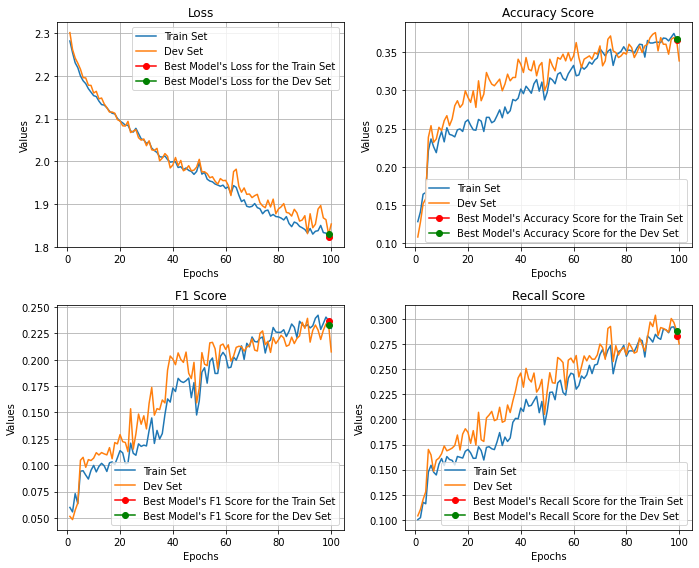

In [ ]:
EarlyLSTMNet = LSTM(input_dim=mels_feats,
                    rnn_size=HIDDEN_LAYER,
                    output_dim=OUTPUT_SIZE,
                    num_layers=NUM_LAYERS,
                    dropout=dropout,
                    pack_padded_sequence=pack_padded_sequence).to(device)

# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(EarlyLSTMNet.parameters(), lr=ETA, weight_decay=weight_decay)

# Start the training process
clf_main(device, EarlyLSTMNet, mels_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, net_name='EarlyLSTM_beatMEL', PATIENCE=PATIENCE)

In [ ]:
with open('./best_EarlyLSTM_beatMEL.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
test_loss, y_test_gold, y_test_pred = clf_eval(device, test_loader, mels_feats, E_model, criterion)

print(classification_report(y_test_gold, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.38      0.50      0.43        40
           2       0.30      0.72      0.42        80
           3       0.35      0.49      0.41        80
           4       0.25      0.03      0.05        40
           5       0.00      0.00      0.00        40
           6       0.44      0.41      0.42        78
           7       0.00      0.00      0.00        40
           8       0.37      0.50      0.42       103
           9       0.00      0.00      0.00        34

    accuracy                           0.35       575
   macro avg       0.21      0.27      0.22       575
weighted avg       0.26      0.35      0.28       575



#### Chromagrams Dataset

In [ ]:
data = SpectrogramDataset("data/fma_genre_spectrograms_beat",
                                  class_mapping=class_mapping, train=True, read_spec_fn=read_chromagram)
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/fma_genre_spectrograms_beat/',
                                              class_mapping=class_mapping, train=False, read_spec_fn=read_chromagram, max_length=data.max_length)

##### Normal Training

  0%|          | 0/100 [00:00<?, ?it/s]

 [================================--------] ...Epoch 1, Loss: 2.2840

  1%|          | 1/100 [00:00<01:23,  1.19it/s]


Statistics for the Train Set
	 Epoch: 1 	 loss: 2.2826261931452256
	 Epoch: 1 	 Accuracy Score: 0.13503253796095444
	 Epoch: 1 	 f1 Score: 0.039427952206775425
	 Epoch: 1 	 recall Score: 0.09637209612183345
Statistics for the Dev Set
	 Epoch: 1 	 loss: 2.2791815121968586
	 Epoch: 1 	 Accuracy Score: 0.12364425162689804
	 Epoch: 1 	 f1 Score: 0.031153996101364524
	 Epoch: 1 	 recall Score: 0.08989262371615311
Test loss decreased (inf --> 2.279182).  Saving model ...
Epoch total time 0.8383655548095703
 [================================--------] ...Epoch 2, Loss: 2.2638

  2%|▏         | 2/100 [00:01<01:20,  1.22it/s]


Statistics for the Train Set
	 Epoch: 2 	 loss: 2.2665426114509843
	 Epoch: 2 	 Accuracy Score: 0.15726681127982647
	 Epoch: 2 	 f1 Score: 0.04779044053736098
	 Epoch: 2 	 recall Score: 0.09704534170813657
Statistics for the Dev Set
	 Epoch: 2 	 loss: 2.2648308912913007
	 Epoch: 2 	 Accuracy Score: 0.1475054229934924
	 Epoch: 2 	 f1 Score: 0.04542463750456928
	 Epoch: 2 	 recall Score: 0.09725274725274727
Test loss decreased (2.279182 --> 2.264831).  Saving model ...
Epoch total time 0.8054904937744141
 [================================--------] ...Epoch 3, Loss: 2.2554

  3%|▎         | 3/100 [00:02<01:18,  1.23it/s]


Statistics for the Train Set
	 Epoch: 3 	 loss: 2.2473037941702483
	 Epoch: 3 	 Accuracy Score: 0.18112798264642083
	 Epoch: 3 	 f1 Score: 0.03723792261187679
	 Epoch: 3 	 recall Score: 0.1001258529714002
Statistics for the Dev Set
	 Epoch: 3 	 loss: 2.2445252895355225
	 Epoch: 3 	 Accuracy Score: 0.1648590021691974
	 Epoch: 3 	 f1 Score: 0.03142506416694566
	 Epoch: 3 	 recall Score: 0.09774114774114775
Test loss decreased (2.264831 --> 2.244525).  Saving model ...
Epoch total time 0.7926726341247559
 [================================--------] ...Epoch 4, Loss: 2.2160

  4%|▍         | 4/100 [00:03<01:17,  1.23it/s]


Statistics for the Train Set
	 Epoch: 4 	 loss: 2.229828489237818
	 Epoch: 4 	 Accuracy Score: 0.1816702819956616
	 Epoch: 4 	 f1 Score: 0.030804597701149426
	 Epoch: 4 	 recall Score: 0.09940652818991098
Statistics for the Dev Set
	 Epoch: 4 	 loss: 2.225325663884481
	 Epoch: 4 	 Accuracy Score: 0.16702819956616052
	 Epoch: 4 	 f1 Score: 0.028624535315985127
	 Epoch: 4 	 recall Score: 0.09871794871794873
Test loss decreased (2.244525 --> 2.225326).  Saving model ...
Epoch total time 0.8112871646881104
 [================================--------] ...Epoch 5, Loss: 2.2058

  5%|▌         | 5/100 [00:04<01:17,  1.23it/s]


Statistics for the Train Set
	 Epoch: 5 	 loss: 2.2190896354872605
	 Epoch: 5 	 Accuracy Score: 0.18275488069414317
	 Epoch: 5 	 f1 Score: 0.03090325538743695
	 Epoch: 5 	 recall Score: 0.1
Statistics for the Dev Set
	 Epoch: 5 	 loss: 2.2190430641174315
	 Epoch: 5 	 Accuracy Score: 0.16919739696312364
	 Epoch: 5 	 f1 Score: 0.028942486085343222
	 Epoch: 5 	 recall Score: 0.1
Test loss decreased (2.225326 --> 2.219043).  Saving model ...
Epoch total time 0.8174741268157959
 [================================--------] ...Epoch 6, Loss: 2.3279

  6%|▌         | 6/100 [00:04<01:16,  1.23it/s]


Statistics for the Train Set
	 Epoch: 6 	 loss: 2.2173731902550005
	 Epoch: 6 	 Accuracy Score: 0.18275488069414317
	 Epoch: 6 	 f1 Score: 0.03090325538743695
	 Epoch: 6 	 recall Score: 0.1
Statistics for the Dev Set
	 Epoch: 6 	 loss: 2.211108620961507
	 Epoch: 6 	 Accuracy Score: 0.16919739696312364
	 Epoch: 6 	 f1 Score: 0.028942486085343222
	 Epoch: 6 	 recall Score: 0.1
Test loss decreased (2.219043 --> 2.211109).  Saving model ...
Epoch total time 0.7990946769714355
 [================================--------] ...Epoch 7, Loss: 2.2629

  7%|▋         | 7/100 [00:05<01:15,  1.24it/s]


Statistics for the Train Set
	 Epoch: 7 	 loss: 2.21604768983249
	 Epoch: 7 	 Accuracy Score: 0.18275488069414317
	 Epoch: 7 	 f1 Score: 0.03090325538743695
	 Epoch: 7 	 recall Score: 0.1
Statistics for the Dev Set
	 Epoch: 7 	 loss: 2.2085254033406576
	 Epoch: 7 	 Accuracy Score: 0.16919739696312364
	 Epoch: 7 	 f1 Score: 0.028942486085343222
	 Epoch: 7 	 recall Score: 0.1
Test loss decreased (2.211109 --> 2.208525).  Saving model ...
Epoch total time 0.8023965358734131
 [================================--------] ...Epoch 8, Loss: 2.1759

  8%|▊         | 8/100 [00:06<01:14,  1.24it/s]


Statistics for the Train Set
	 Epoch: 8 	 loss: 2.214283984282921
	 Epoch: 8 	 Accuracy Score: 0.18275488069414317
	 Epoch: 8 	 f1 Score: 0.03090325538743695
	 Epoch: 8 	 recall Score: 0.1
Statistics for the Dev Set
	 Epoch: 8 	 loss: 2.2122209072113037
	 Epoch: 8 	 Accuracy Score: 0.16702819956616052
	 Epoch: 8 	 f1 Score: 0.028624535315985127
	 Epoch: 8 	 recall Score: 0.09871794871794873
EarlyStopping counter: 1 out of 10
Epoch total time 0.802168607711792
 [================================--------] ...Epoch 9, Loss: 2.1914

  9%|▉         | 9/100 [00:07<01:13,  1.24it/s]


Statistics for the Train Set
	 Epoch: 9 	 loss: 2.2127974814382094
	 Epoch: 9 	 Accuracy Score: 0.18275488069414317
	 Epoch: 9 	 f1 Score: 0.03090325538743695
	 Epoch: 9 	 recall Score: 0.1
Statistics for the Dev Set
	 Epoch: 9 	 loss: 2.2104440212249754
	 Epoch: 9 	 Accuracy Score: 0.16919739696312364
	 Epoch: 9 	 f1 Score: 0.028942486085343222
	 Epoch: 9 	 recall Score: 0.1
EarlyStopping counter: 2 out of 10
Epoch total time 0.7991385459899902
 [================================--------] ...Epoch 10, Loss: 2.2655

 10%|█         | 10/100 [00:08<01:12,  1.24it/s]


Statistics for the Train Set
	 Epoch: 10 	 loss: 2.212187105211718
	 Epoch: 10 	 Accuracy Score: 0.18275488069414317
	 Epoch: 10 	 f1 Score: 0.03090325538743695
	 Epoch: 10 	 recall Score: 0.1
Statistics for the Dev Set
	 Epoch: 10 	 loss: 2.202648735046387
	 Epoch: 10 	 Accuracy Score: 0.16702819956616052
	 Epoch: 10 	 f1 Score: 0.028624535315985127
	 Epoch: 10 	 recall Score: 0.09871794871794873
Test loss decreased (2.208525 --> 2.202649).  Saving model ...
Epoch total time 0.8093521595001221
 [================================--------] ...Epoch 11, Loss: 2.2038

 11%|█         | 11/100 [00:08<01:11,  1.25it/s]


Statistics for the Train Set
	 Epoch: 11 	 loss: 2.209601747578588
	 Epoch: 11 	 Accuracy Score: 0.18275488069414317
	 Epoch: 11 	 f1 Score: 0.03090325538743695
	 Epoch: 11 	 recall Score: 0.1
Statistics for the Dev Set
	 Epoch: 11 	 loss: 2.2140268325805663
	 Epoch: 11 	 Accuracy Score: 0.16702819956616052
	 Epoch: 11 	 f1 Score: 0.028624535315985127
	 Epoch: 11 	 recall Score: 0.09871794871794873
EarlyStopping counter: 1 out of 10
Epoch total time 0.7850375175476074
 [================================--------] ...Epoch 12, Loss: 2.1662

 12%|█▏        | 12/100 [00:09<01:10,  1.25it/s]


Statistics for the Train Set
	 Epoch: 12 	 loss: 2.207826047108091
	 Epoch: 12 	 Accuracy Score: 0.18275488069414317
	 Epoch: 12 	 f1 Score: 0.03091743119266055
	 Epoch: 12 	 recall Score: 0.1
Statistics for the Dev Set
	 Epoch: 12 	 loss: 2.198482942581177
	 Epoch: 12 	 Accuracy Score: 0.16702819956616052
	 Epoch: 12 	 f1 Score: 0.028624535315985127
	 Epoch: 12 	 recall Score: 0.09871794871794873
Test loss decreased (2.202649 --> 2.198483).  Saving model ...
Epoch total time 0.7966873645782471
 [================================--------] ...Epoch 13, Loss: 2.1741

 13%|█▎        | 13/100 [00:10<01:10,  1.24it/s]


Statistics for the Train Set
	 Epoch: 13 	 loss: 2.2047867898283333
	 Epoch: 13 	 Accuracy Score: 0.18275488069414317
	 Epoch: 13 	 f1 Score: 0.03091743119266055
	 Epoch: 13 	 recall Score: 0.1
Statistics for the Dev Set
	 Epoch: 13 	 loss: 2.1926382064819334
	 Epoch: 13 	 Accuracy Score: 0.16702819956616052
	 Epoch: 13 	 f1 Score: 0.028624535315985127
	 Epoch: 13 	 recall Score: 0.09871794871794873
Test loss decreased (2.198483 --> 2.192638).  Saving model ...
Epoch total time 0.8257641792297363
 [================================--------] ...Epoch 14, Loss: 2.2365

 14%|█▍        | 14/100 [00:11<01:09,  1.23it/s]


Statistics for the Train Set
	 Epoch: 14 	 loss: 2.199414614973397
	 Epoch: 14 	 Accuracy Score: 0.18275488069414317
	 Epoch: 14 	 f1 Score: 0.0309600367478181
	 Epoch: 14 	 recall Score: 0.1
Statistics for the Dev Set
	 Epoch: 14 	 loss: 2.1850283622741697
	 Epoch: 14 	 Accuracy Score: 0.16702819956616052
	 Epoch: 14 	 f1 Score: 0.028677839851024213
	 Epoch: 14 	 recall Score: 0.09871794871794873
Test loss decreased (2.192638 --> 2.185028).  Saving model ...
Epoch total time 0.8183903694152832
 [================================--------] ...Epoch 15, Loss: 1.9813

 15%|█▌        | 15/100 [00:12<01:09,  1.23it/s]


Statistics for the Train Set
	 Epoch: 15 	 loss: 2.1863819442946335
	 Epoch: 15 	 Accuracy Score: 0.1843817787418655
	 Epoch: 15 	 f1 Score: 0.03341017682139992
	 Epoch: 15 	 recall Score: 0.10119047619047619
Statistics for the Dev Set
	 Epoch: 15 	 loss: 2.1747553666432697
	 Epoch: 15 	 Accuracy Score: 0.16919739696312364
	 Epoch: 15 	 f1 Score: 0.03160194813742267
	 Epoch: 15 	 recall Score: 0.10018853695324284
Test loss decreased (2.185028 --> 2.174755).  Saving model ...
Epoch total time 0.817293643951416
 [================================--------] ...Epoch 16, Loss: 2.2217

 16%|█▌        | 16/100 [00:12<01:08,  1.23it/s]


Statistics for the Train Set
	 Epoch: 16 	 loss: 2.18130493575129
	 Epoch: 16 	 Accuracy Score: 0.1963123644251627
	 Epoch: 16 	 f1 Score: 0.06239503956866499
	 Epoch: 16 	 recall Score: 0.1139191956395342
Statistics for the Dev Set
	 Epoch: 16 	 loss: 2.157903869946798
	 Epoch: 16 	 Accuracy Score: 0.1843817787418655
	 Epoch: 16 	 f1 Score: 0.061960527063736184
	 Epoch: 16 	 recall Score: 0.11203029706866023
Test loss decreased (2.174755 --> 2.157904).  Saving model ...
Epoch total time 0.8054707050323486
 [================================--------] ...Epoch 17, Loss: 2.1100

 17%|█▋        | 17/100 [00:13<01:06,  1.24it/s]


Statistics for the Train Set
	 Epoch: 17 	 loss: 2.175460589343104
	 Epoch: 17 	 Accuracy Score: 0.19468546637744036
	 Epoch: 17 	 f1 Score: 0.07764898884898885
	 Epoch: 17 	 recall Score: 0.1270183716819899
Statistics for the Dev Set
	 Epoch: 17 	 loss: 2.162660018603007
	 Epoch: 17 	 Accuracy Score: 0.21908893709327548
	 Epoch: 17 	 f1 Score: 0.0876139837058215
	 Epoch: 17 	 recall Score: 0.13942061774542594
EarlyStopping counter: 1 out of 10
Epoch total time 0.7901096343994141
 [================================--------] ...Epoch 18, Loss: 2.3637

 18%|█▊        | 18/100 [00:14<01:06,  1.24it/s]


Statistics for the Train Set
	 Epoch: 18 	 loss: 2.1686450900702643
	 Epoch: 18 	 Accuracy Score: 0.20824295010845986
	 Epoch: 18 	 f1 Score: 0.08751166947300126
	 Epoch: 18 	 recall Score: 0.13728834498888495
Statistics for the Dev Set
	 Epoch: 18 	 loss: 2.138679567972819
	 Epoch: 18 	 Accuracy Score: 0.24945770065075923
	 Epoch: 18 	 f1 Score: 0.10551242120875046
	 Epoch: 18 	 recall Score: 0.16047117843793038
Test loss decreased (2.157904 --> 2.138680).  Saving model ...
Epoch total time 0.799299955368042
 [================================--------] ...Epoch 19, Loss: 2.1227

 19%|█▉        | 19/100 [00:15<01:05,  1.23it/s]


Statistics for the Train Set
	 Epoch: 19 	 loss: 2.165037072938064
	 Epoch: 19 	 Accuracy Score: 0.21691973969631237
	 Epoch: 19 	 f1 Score: 0.09100269388493946
	 Epoch: 19 	 recall Score: 0.146191831307607
Statistics for the Dev Set
	 Epoch: 19 	 loss: 2.141589641571045
	 Epoch: 19 	 Accuracy Score: 0.24295010845986983
	 Epoch: 19 	 f1 Score: 0.10201666261771725
	 Epoch: 19 	 recall Score: 0.15740048527772313
EarlyStopping counter: 1 out of 10
Epoch total time 0.8283672332763672
 [================================--------] ...Epoch 20, Loss: 2.1927

 20%|██        | 20/100 [00:16<01:05,  1.23it/s]


Statistics for the Train Set
	 Epoch: 20 	 loss: 2.162125114736886
	 Epoch: 20 	 Accuracy Score: 0.2158351409978308
	 Epoch: 20 	 f1 Score: 0.08989507989694276
	 Epoch: 20 	 recall Score: 0.1480955778397039
Statistics for the Dev Set
	 Epoch: 20 	 loss: 2.1349922100702923
	 Epoch: 20 	 Accuracy Score: 0.2386117136659436
	 Epoch: 20 	 f1 Score: 0.0989149488539286
	 Epoch: 20 	 recall Score: 0.15554790478064134
Test loss decreased (2.138680 --> 2.134992).  Saving model ...
Epoch total time 0.8181788921356201
 [================================--------] ...Epoch 21, Loss: 2.2446

 21%|██        | 21/100 [00:17<01:06,  1.18it/s]


Statistics for the Train Set
	 Epoch: 21 	 loss: 2.1597532938266624
	 Epoch: 21 	 Accuracy Score: 0.21095444685466377
	 Epoch: 21 	 f1 Score: 0.08745696874808695
	 Epoch: 21 	 recall Score: 0.1455380548548326
Statistics for the Dev Set
	 Epoch: 21 	 loss: 2.138254229227702
	 Epoch: 21 	 Accuracy Score: 0.2472885032537961
	 Epoch: 21 	 f1 Score: 0.1020790627767409
	 Epoch: 21 	 recall Score: 0.16140894484884255
EarlyStopping counter: 1 out of 10
Epoch total time 0.9066481590270996
 [================================--------] ...Epoch 22, Loss: 1.9606

 22%|██▏       | 22/100 [00:17<01:05,  1.20it/s]


Statistics for the Train Set
	 Epoch: 22 	 loss: 2.1677272771966867
	 Epoch: 22 	 Accuracy Score: 0.20119305856832972
	 Epoch: 22 	 f1 Score: 0.08289209665306829
	 Epoch: 22 	 recall Score: 0.13939506953565425
Statistics for the Dev Set
	 Epoch: 22 	 loss: 2.1395486036936444
	 Epoch: 22 	 Accuracy Score: 0.24078091106290672
	 Epoch: 22 	 f1 Score: 0.09834818153233413
	 Epoch: 22 	 recall Score: 0.15705783985835137
EarlyStopping counter: 2 out of 10
Epoch total time 0.8087389469146729
 [================================--------] ...Epoch 23, Loss: 2.0763

 23%|██▎       | 23/100 [00:18<01:03,  1.21it/s]


Statistics for the Train Set
	 Epoch: 23 	 loss: 2.1592185846690475
	 Epoch: 23 	 Accuracy Score: 0.20878524945770066
	 Epoch: 23 	 f1 Score: 0.08680450622499856
	 Epoch: 23 	 recall Score: 0.14392975088237042
Statistics for the Dev Set
	 Epoch: 23 	 loss: 2.13848819732666
	 Epoch: 23 	 Accuracy Score: 0.2386117136659436
	 Epoch: 23 	 f1 Score: 0.0989515207799229
	 Epoch: 23 	 recall Score: 0.15615614138632042
EarlyStopping counter: 3 out of 10
Epoch total time 0.8116528987884521
 [================================--------] ...Epoch 24, Loss: 2.1347

 24%|██▍       | 24/100 [00:19<01:02,  1.22it/s]


Statistics for the Train Set
	 Epoch: 24 	 loss: 2.1564506025149903
	 Epoch: 24 	 Accuracy Score: 0.20498915401301518
	 Epoch: 24 	 f1 Score: 0.084121552719109
	 Epoch: 24 	 recall Score: 0.1432398186691128
Statistics for the Dev Set
	 Epoch: 24 	 loss: 2.133409857749939
	 Epoch: 24 	 Accuracy Score: 0.24078091106290672
	 Epoch: 24 	 f1 Score: 0.09845568504946134
	 Epoch: 24 	 recall Score: 0.15775132795593155
Test loss decreased (2.134992 --> 2.133410).  Saving model ...
Epoch total time 0.8052403926849365
 [================================--------] ...Epoch 25, Loss: 2.2043

 25%|██▌       | 25/100 [00:20<01:01,  1.22it/s]


Statistics for the Train Set
	 Epoch: 25 	 loss: 2.162083987531991
	 Epoch: 25 	 Accuracy Score: 0.20824295010845986
	 Epoch: 25 	 f1 Score: 0.08548875341028045
	 Epoch: 25 	 recall Score: 0.14533955528993714
Statistics for the Dev Set
	 Epoch: 25 	 loss: 2.1442115942637128
	 Epoch: 25 	 Accuracy Score: 0.2603036876355748
	 Epoch: 25 	 f1 Score: 0.11056619655150865
	 Epoch: 25 	 recall Score: 0.17017181454521607
EarlyStopping counter: 1 out of 10
Epoch total time 0.8071370124816895
 [================================--------] ...Epoch 26, Loss: 1.9629

 26%|██▌       | 26/100 [00:21<01:00,  1.23it/s]


Statistics for the Train Set
	 Epoch: 26 	 loss: 2.1575558267790695
	 Epoch: 26 	 Accuracy Score: 0.20336225596529284
	 Epoch: 26 	 f1 Score: 0.08379808021643402
	 Epoch: 26 	 recall Score: 0.14166199518026149
Statistics for the Dev Set
	 Epoch: 26 	 loss: 2.1248857418696088
	 Epoch: 26 	 Accuracy Score: 0.24078091106290672
	 Epoch: 26 	 f1 Score: 0.09888657365225499
	 Epoch: 26 	 recall Score: 0.1575627910026887
Test loss decreased (2.133410 --> 2.124886).  Saving model ...
Epoch total time 0.7935795783996582
 [================================--------] ...Epoch 27, Loss: 1.9529

 27%|██▋       | 27/100 [00:22<00:59,  1.22it/s]


Statistics for the Train Set
	 Epoch: 27 	 loss: 2.1548588707529266
	 Epoch: 27 	 Accuracy Score: 0.21095444685466377
	 Epoch: 27 	 f1 Score: 0.0869547784653799
	 Epoch: 27 	 recall Score: 0.14689627987531378
Statistics for the Dev Set
	 Epoch: 27 	 loss: 2.139541681607564
	 Epoch: 27 	 Accuracy Score: 0.2386117136659436
	 Epoch: 27 	 f1 Score: 0.09841487738066021
	 Epoch: 27 	 recall Score: 0.1565332152928061
EarlyStopping counter: 1 out of 10
Epoch total time 0.8359935283660889
 [================================--------] ...Epoch 28, Loss: 2.2579

 28%|██▊       | 28/100 [00:22<00:59,  1.22it/s]


Statistics for the Train Set
	 Epoch: 28 	 loss: 2.154882852373452
	 Epoch: 28 	 Accuracy Score: 0.20498915401301518
	 Epoch: 28 	 f1 Score: 0.08409984024593056
	 Epoch: 28 	 recall Score: 0.14328786548590022
Statistics for the Dev Set
	 Epoch: 28 	 loss: 2.1376929601033527
	 Epoch: 28 	 Accuracy Score: 0.23427331887201736
	 Epoch: 28 	 f1 Score: 0.09556593731519811
	 Epoch: 28 	 recall Score: 0.15373795002951013
EarlyStopping counter: 2 out of 10
Epoch total time 0.8212645053863525
 [================================--------] ...Epoch 29, Loss: 2.1794

 29%|██▉       | 29/100 [00:23<00:57,  1.23it/s]


Statistics for the Train Set
	 Epoch: 29 	 loss: 2.154269775439953
	 Epoch: 29 	 Accuracy Score: 0.20336225596529284
	 Epoch: 29 	 f1 Score: 0.08303709648791932
	 Epoch: 29 	 recall Score: 0.14270192210431545
Statistics for the Dev Set
	 Epoch: 29 	 loss: 2.1304784854253134
	 Epoch: 29 	 Accuracy Score: 0.23644251626898047
	 Epoch: 29 	 f1 Score: 0.09521740824748981
	 Epoch: 29 	 recall Score: 0.15568889763263166
EarlyStopping counter: 3 out of 10
Epoch total time 0.8053247928619385
 [================================--------] ...Epoch 30, Loss: 2.1776

 30%|███       | 30/100 [00:24<00:57,  1.22it/s]


Statistics for the Train Set
	 Epoch: 30 	 loss: 2.15613696081885
	 Epoch: 30 	 Accuracy Score: 0.2131236442516269
	 Epoch: 30 	 f1 Score: 0.08890718933882888
	 Epoch: 30 	 recall Score: 0.14746568001785204
Statistics for the Dev Set
	 Epoch: 30 	 loss: 2.140045166015625
	 Epoch: 30 	 Accuracy Score: 0.25162689804772237
	 Epoch: 30 	 f1 Score: 0.10595916601503193
	 Epoch: 30 	 recall Score: 0.1644353728113319
EarlyStopping counter: 4 out of 10
Epoch total time 0.8254170417785645
 [================================--------] ...Epoch 31, Loss: 2.2289

 31%|███       | 31/100 [00:25<00:56,  1.22it/s]


Statistics for the Train Set
	 Epoch: 31 	 loss: 2.157978123631971
	 Epoch: 31 	 Accuracy Score: 0.21258134490238612
	 Epoch: 31 	 f1 Score: 0.08796472295056634
	 Epoch: 31 	 recall Score: 0.14797867485759686
Statistics for the Dev Set
	 Epoch: 31 	 loss: 2.142310961087545
	 Epoch: 31 	 Accuracy Score: 0.2559652928416486
	 Epoch: 31 	 f1 Score: 0.10919957451248545
	 Epoch: 31 	 recall Score: 0.16720932520165258
EarlyStopping counter: 5 out of 10
Epoch total time 0.8100285530090332
 [================================--------] ...Epoch 32, Loss: 2.1477

 32%|███▏      | 32/100 [00:26<00:55,  1.22it/s]


Statistics for the Train Set
	 Epoch: 32 	 loss: 2.156536540080761
	 Epoch: 32 	 Accuracy Score: 0.21420824295010846
	 Epoch: 32 	 f1 Score: 0.08903026029514717
	 Epoch: 32 	 recall Score: 0.14863366744112963
Statistics for the Dev Set
	 Epoch: 32 	 loss: 2.1304243485132854
	 Epoch: 32 	 Accuracy Score: 0.24945770065075923
	 Epoch: 32 	 f1 Score: 0.1056213681213681
	 Epoch: 32 	 recall Score: 0.16315332152928058
EarlyStopping counter: 6 out of 10
Epoch total time 0.8227190971374512
 [================================--------] ...Epoch 33, Loss: 2.1720

 33%|███▎      | 33/100 [00:26<00:55,  1.21it/s]


Statistics for the Train Set
	 Epoch: 33 	 loss: 2.1537743334112496
	 Epoch: 33 	 Accuracy Score: 0.20661605206073752
	 Epoch: 33 	 f1 Score: 0.0850643192723357
	 Epoch: 33 	 recall Score: 0.14424414963890567
Statistics for the Dev Set
	 Epoch: 33 	 loss: 2.140041716893514
	 Epoch: 33 	 Accuracy Score: 0.24945770065075923
	 Epoch: 33 	 f1 Score: 0.10408922047219919
	 Epoch: 33 	 recall Score: 0.16332054560954817
EarlyStopping counter: 7 out of 10
Epoch total time 0.8304529190063477
 [================================--------] ...Epoch 34, Loss: 2.0258

 34%|███▍      | 34/100 [00:27<00:55,  1.19it/s]


Statistics for the Train Set
	 Epoch: 34 	 loss: 2.152359185547664
	 Epoch: 34 	 Accuracy Score: 0.2039045553145336
	 Epoch: 34 	 f1 Score: 0.08394496322017064
	 Epoch: 34 	 recall Score: 0.1418416350665706
Statistics for the Dev Set
	 Epoch: 34 	 loss: 2.1365769704182944
	 Epoch: 34 	 Accuracy Score: 0.2386117136659436
	 Epoch: 34 	 f1 Score: 0.09788316030733031
	 Epoch: 34 	 recall Score: 0.15630205259361268
EarlyStopping counter: 8 out of 10
Epoch total time 0.8714754581451416
 [================================--------] ...Epoch 35, Loss: 2.1491

 35%|███▌      | 35/100 [00:28<00:54,  1.18it/s]


Statistics for the Train Set
	 Epoch: 35 	 loss: 2.149765411327625
	 Epoch: 35 	 Accuracy Score: 0.20607375271149675
	 Epoch: 35 	 f1 Score: 0.08485337940912743
	 Epoch: 35 	 recall Score: 0.14359008363118883
Statistics for the Dev Set
	 Epoch: 35 	 loss: 2.132211128870646
	 Epoch: 35 	 Accuracy Score: 0.23427331887201736
	 Epoch: 35 	 f1 Score: 0.09634330263135693
	 Epoch: 35 	 recall Score: 0.1535707259492426
EarlyStopping counter: 9 out of 10
Epoch total time 0.8549892902374268
 [================================--------] ...Epoch 36, Loss: 2.2055

 35%|███▌      | 35/100 [00:29<00:54,  1.19it/s]


Statistics for the Train Set
	 Epoch: 36 	 loss: 2.156580612577241
	 Epoch: 36 	 Accuracy Score: 0.21258134490238612
	 Epoch: 36 	 f1 Score: 0.08774974286882475
	 Epoch: 36 	 recall Score: 0.1486312544832757
Statistics for the Dev Set
	 Epoch: 36 	 loss: 2.13637060324351
	 Epoch: 36 	 Accuracy Score: 0.2603036876355748
	 Epoch: 36 	 f1 Score: 0.11040968629927636
	 Epoch: 36 	 recall Score: 0.17031772575250836
EarlyStopping counter: 10 out of 10
Training total time 28.572702169418335


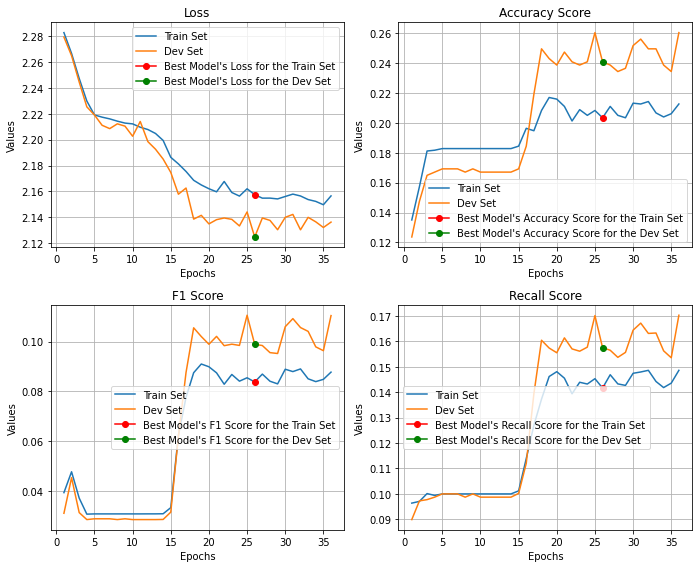

In [ ]:
EarlyLSTMNet = LSTM(input_dim=chroma_feats,
                    rnn_size=HIDDEN_LAYER,
                    output_dim=OUTPUT_SIZE,
                    num_layers=NUM_LAYERS,
                    dropout=dropout,
                    pack_padded_sequence=pack_padded_sequence).to(device)

# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(EarlyLSTMNet.parameters(), lr=ETA, weight_decay=weight_decay)

# Start the training process
clf_main(device, EarlyLSTMNet, chroma_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, net_name='EarlyLSTM_beatCHROMA', PATIENCE=PATIENCE)

In [ ]:
with open('./best_EarlyLSTM_beatCHROMA.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
test_loss, y_test_gold, y_test_pred = clf_eval(device, test_loader, chroma_feats, E_model, criterion)

print(classification_report(y_test_gold, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00        80
           3       0.21      0.60      0.31        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.26      0.62      0.36        78
           7       0.00      0.00      0.00        40
           8       0.16      0.25      0.20       103
           9       0.00      0.00      0.00        34

    accuracy                           0.21       575
   macro avg       0.06      0.15      0.09       575
weighted avg       0.09      0.21      0.13       575



### Mel Spectrograms + Chromagrams Dataset

In [ ]:
data = SpectrogramDataset("data/fma_genre_spectrograms_beat",
                                class_mapping=class_mapping, train=True, read_spec_fn=read_fused_spectrogram)
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/fma_genre_spectrograms_beat/',
                                            class_mapping=class_mapping, train=False, read_spec_fn=read_fused_spectrogram, max_length=data.max_length)

#### Normal Training

  0%|          | 0/100 [00:00<?, ?it/s]

 [================================--------] ...Epoch 1, Loss: 2.3738

  1%|          | 1/100 [00:01<01:55,  1.17s/it]


Statistics for the Train Set
	 Epoch: 1 	 loss: 2.327270803780391
	 Epoch: 1 	 Accuracy Score: 0.08297180043383948
	 Epoch: 1 	 f1 Score: 0.039182137576671924
	 Epoch: 1 	 recall Score: 0.10450603330464259
Statistics for the Dev Set
	 Epoch: 1 	 loss: 2.3469762325286867
	 Epoch: 1 	 Accuracy Score: 0.0455531453362256
	 Epoch: 1 	 f1 Score: 0.03311334794762828
	 Epoch: 1 	 recall Score: 0.07000517598343685
Test loss decreased (inf --> 2.346976).  Saving model ...
Epoch total time 1.1713476181030273
 [================================--------] ...Epoch 2, Loss: 2.2330

  2%|▏         | 2/100 [00:02<01:53,  1.15s/it]


Statistics for the Train Set
	 Epoch: 2 	 loss: 2.2545308614599295
	 Epoch: 2 	 Accuracy Score: 0.1822125813449024
	 Epoch: 2 	 f1 Score: 0.07614658001674493
	 Epoch: 2 	 recall Score: 0.13204467812335174
Statistics for the Dev Set
	 Epoch: 2 	 loss: 2.2666773160298663
	 Epoch: 2 	 Accuracy Score: 0.18004338394793926
	 Epoch: 2 	 f1 Score: 0.07375688199160955
	 Epoch: 2 	 recall Score: 0.13622585580416907
Test loss decreased (2.346976 --> 2.266677).  Saving model ...
Epoch total time 1.1356329917907715
 [================================--------] ...Epoch 3, Loss: 2.1706

  3%|▎         | 3/100 [00:03<01:54,  1.19s/it]


Statistics for the Train Set
	 Epoch: 3 	 loss: 2.2300995053916144
	 Epoch: 3 	 Accuracy Score: 0.18383947939262474
	 Epoch: 3 	 f1 Score: 0.0799524440479322
	 Epoch: 3 	 recall Score: 0.12339254888173176
Statistics for the Dev Set
	 Epoch: 3 	 loss: 2.2327906608581545
	 Epoch: 3 	 Accuracy Score: 0.1561822125813449
	 Epoch: 3 	 f1 Score: 0.06619152046783625
	 Epoch: 3 	 recall Score: 0.11128561866513675
Test loss decreased (2.266677 --> 2.232791).  Saving model ...
Epoch total time 1.22171950340271
 [================================--------] ...Epoch 4, Loss: 2.2817

  4%|▍         | 4/100 [00:04<01:52,  1.17s/it]


Statistics for the Train Set
	 Epoch: 4 	 loss: 2.2190849369969863
	 Epoch: 4 	 Accuracy Score: 0.19522776572668113
	 Epoch: 4 	 f1 Score: 0.0815914527214162
	 Epoch: 4 	 recall Score: 0.12918504190285093
Statistics for the Dev Set
	 Epoch: 4 	 loss: 2.2217599391937255
	 Epoch: 4 	 Accuracy Score: 0.1843817787418655
	 Epoch: 4 	 f1 Score: 0.07910911424903722
	 Epoch: 4 	 recall Score: 0.13272853318034042
Test loss decreased (2.232791 --> 2.221760).  Saving model ...
Epoch total time 1.1424310207366943
 [================================--------] ...Epoch 5, Loss: 2.2902

  5%|▌         | 5/100 [00:05<01:49,  1.16s/it]


Statistics for the Train Set
	 Epoch: 5 	 loss: 2.211313880723098
	 Epoch: 5 	 Accuracy Score: 0.21746203904555314
	 Epoch: 5 	 f1 Score: 0.09520094119645192
	 Epoch: 5 	 recall Score: 0.1398225249793236
Statistics for the Dev Set
	 Epoch: 5 	 loss: 2.2206459204355875
	 Epoch: 5 	 Accuracy Score: 0.19088937093275488
	 Epoch: 5 	 f1 Score: 0.08110558324798542
	 Epoch: 5 	 recall Score: 0.12645343277873397
Test loss decreased (2.221760 --> 2.220646).  Saving model ...
Epoch total time 1.1291167736053467
 [================================--------] ...Epoch 6, Loss: 2.1200

  6%|▌         | 6/100 [00:06<01:48,  1.15s/it]


Statistics for the Train Set
	 Epoch: 6 	 loss: 2.192637505202458
	 Epoch: 6 	 Accuracy Score: 0.22830802603036876
	 Epoch: 6 	 f1 Score: 0.09024404103170565
	 Epoch: 6 	 recall Score: 0.14104945746319766
Statistics for the Dev Set
	 Epoch: 6 	 loss: 2.1957159360249836
	 Epoch: 6 	 Accuracy Score: 0.21691973969631237
	 Epoch: 6 	 f1 Score: 0.08213719913141877
	 Epoch: 6 	 recall Score: 0.13863071332950852
Test loss decreased (2.220646 --> 2.195716).  Saving model ...
Epoch total time 1.14277982711792
 [================================--------] ...Epoch 7, Loss: 1.9561

  7%|▋         | 7/100 [00:08<01:46,  1.14s/it]


Statistics for the Train Set
	 Epoch: 7 	 loss: 2.1759992550159324
	 Epoch: 7 	 Accuracy Score: 0.2359002169197397
	 Epoch: 7 	 f1 Score: 0.10016443438203573
	 Epoch: 7 	 recall Score: 0.15160785979678595
Statistics for the Dev Set
	 Epoch: 7 	 loss: 2.188732624053955
	 Epoch: 7 	 Accuracy Score: 0.21691973969631237
	 Epoch: 7 	 f1 Score: 0.0891194726058984
	 Epoch: 7 	 recall Score: 0.14453949129852744
Test loss decreased (2.195716 --> 2.188733).  Saving model ...
Epoch total time 1.116628885269165
 [================================--------] ...Epoch 8, Loss: 2.3852

  8%|▊         | 8/100 [00:09<01:44,  1.14s/it]


Statistics for the Train Set
	 Epoch: 8 	 loss: 2.1686763187934615
	 Epoch: 8 	 Accuracy Score: 0.23535791757049893
	 Epoch: 8 	 f1 Score: 0.09617409151483072
	 Epoch: 8 	 recall Score: 0.14824598904406655
Statistics for the Dev Set
	 Epoch: 8 	 loss: 2.181439248720805
	 Epoch: 8 	 Accuracy Score: 0.22559652928416485
	 Epoch: 8 	 f1 Score: 0.09150866481872268
	 Epoch: 8 	 recall Score: 0.1472192579843182
Test loss decreased (2.188733 --> 2.181439).  Saving model ...
Epoch total time 1.1327996253967285
 [================================--------] ...Epoch 9, Loss: 2.2468

  9%|▉         | 9/100 [00:10<01:44,  1.14s/it]


Statistics for the Train Set
	 Epoch: 9 	 loss: 2.1748456009503068
	 Epoch: 9 	 Accuracy Score: 0.23915401301518438
	 Epoch: 9 	 f1 Score: 0.10040613053997698
	 Epoch: 9 	 recall Score: 0.16432542244068252
Statistics for the Dev Set
	 Epoch: 9 	 loss: 2.1980891545613606
	 Epoch: 9 	 Accuracy Score: 0.20607375271149675
	 Epoch: 9 	 f1 Score: 0.0913317333151252
	 Epoch: 9 	 recall Score: 0.14819038056989867
EarlyStopping counter: 1 out of 10
Epoch total time 1.1528253555297852
 [================================--------] ...Epoch 10, Loss: 2.1801

 10%|█         | 10/100 [00:11<01:43,  1.15s/it]


Statistics for the Train Set
	 Epoch: 10 	 loss: 2.164235030782634
	 Epoch: 10 	 Accuracy Score: 0.2695227765726681
	 Epoch: 10 	 f1 Score: 0.11520714795528045
	 Epoch: 10 	 recall Score: 0.17782659075028456
Statistics for the Dev Set
	 Epoch: 10 	 loss: 2.1794396877288817
	 Epoch: 10 	 Accuracy Score: 0.23210412147505424
	 Epoch: 10 	 f1 Score: 0.09829902935233296
	 Epoch: 10 	 recall Score: 0.16267689806846433
Test loss decreased (2.181439 --> 2.179440).  Saving model ...
Epoch total time 1.148319959640503
 [================================--------] ...Epoch 11, Loss: 2.0416

 11%|█         | 11/100 [00:12<01:41,  1.14s/it]


Statistics for the Train Set
	 Epoch: 11 	 loss: 2.1571082143947997
	 Epoch: 11 	 Accuracy Score: 0.24620390455531455
	 Epoch: 11 	 f1 Score: 0.10288572760594505
	 Epoch: 11 	 recall Score: 0.15891369112814896
Statistics for the Dev Set
	 Epoch: 11 	 loss: 2.1717350641886393
	 Epoch: 11 	 Accuracy Score: 0.25162689804772237
	 Epoch: 11 	 f1 Score: 0.10604058707899289
	 Epoch: 11 	 recall Score: 0.1709982788296041
Test loss decreased (2.179440 --> 2.171735).  Saving model ...
Epoch total time 1.1331188678741455
 [================================--------] ...Epoch 12, Loss: 2.0694

 12%|█▏        | 12/100 [00:13<01:41,  1.15s/it]


Statistics for the Train Set
	 Epoch: 12 	 loss: 2.1427055473985344
	 Epoch: 12 	 Accuracy Score: 0.23752711496746204
	 Epoch: 12 	 f1 Score: 0.0899324626682921
	 Epoch: 12 	 recall Score: 0.1456942116189673
Statistics for the Dev Set
	 Epoch: 12 	 loss: 2.1526218096415204
	 Epoch: 12 	 Accuracy Score: 0.2299349240780911
	 Epoch: 12 	 f1 Score: 0.08851273051938055
	 Epoch: 12 	 recall Score: 0.14702141900937082
Test loss decreased (2.171735 --> 2.152622).  Saving model ...
Epoch total time 1.165712594985962
 [================================--------] ...Epoch 13, Loss: 2.2456

 13%|█▎        | 13/100 [00:15<01:41,  1.16s/it]


Statistics for the Train Set
	 Epoch: 13 	 loss: 2.135611745817908
	 Epoch: 13 	 Accuracy Score: 0.2527114967462039
	 Epoch: 13 	 f1 Score: 0.10568363689317942
	 Epoch: 13 	 recall Score: 0.16089403753184492
Statistics for the Dev Set
	 Epoch: 13 	 loss: 2.16416220664978
	 Epoch: 13 	 Accuracy Score: 0.2472885032537961
	 Epoch: 13 	 f1 Score: 0.10676826363004846
	 Epoch: 13 	 recall Score: 0.16510508701472557
EarlyStopping counter: 1 out of 10
Epoch total time 1.185373306274414
 [================================--------] ...Epoch 14, Loss: 2.1801

 14%|█▍        | 14/100 [00:16<01:43,  1.20s/it]


Statistics for the Train Set
	 Epoch: 14 	 loss: 2.131615794938186
	 Epoch: 14 	 Accuracy Score: 0.25054229934924077
	 Epoch: 14 	 f1 Score: 0.105442302555301
	 Epoch: 14 	 recall Score: 0.16238598204016974
Statistics for the Dev Set
	 Epoch: 14 	 loss: 2.1484150091807046
	 Epoch: 14 	 Accuracy Score: 0.2603036876355748
	 Epoch: 14 	 f1 Score: 0.11266374140704989
	 Epoch: 14 	 recall Score: 0.1795156817747179
Test loss decreased (2.152622 --> 2.148415).  Saving model ...
Epoch total time 1.2815587520599365
 [================================--------] ...Epoch 15, Loss: 1.9906

 15%|█▌        | 15/100 [00:17<01:41,  1.19s/it]


Statistics for the Train Set
	 Epoch: 15 	 loss: 2.1335240890239846
	 Epoch: 15 	 Accuracy Score: 0.23318872017353579
	 Epoch: 15 	 f1 Score: 0.09927476782143949
	 Epoch: 15 	 recall Score: 0.1514075741600407
Statistics for the Dev Set
	 Epoch: 15 	 loss: 2.153023608525594
	 Epoch: 15 	 Accuracy Score: 0.24295010845986983
	 Epoch: 15 	 f1 Score: 0.10228545963840081
	 Epoch: 15 	 recall Score: 0.16440763052208837
EarlyStopping counter: 1 out of 10
Epoch total time 1.167403221130371
 [================================--------] ...Epoch 16, Loss: 2.1661

 16%|█▌        | 16/100 [00:18<01:39,  1.18s/it]


Statistics for the Train Set
	 Epoch: 16 	 loss: 2.126835851833738
	 Epoch: 16 	 Accuracy Score: 0.23969631236442515
	 Epoch: 16 	 f1 Score: 0.10225795572275312
	 Epoch: 16 	 recall Score: 0.15306207815444667
Statistics for the Dev Set
	 Epoch: 16 	 loss: 2.1498233874638877
	 Epoch: 16 	 Accuracy Score: 0.2386117136659436
	 Epoch: 16 	 f1 Score: 0.10112735326688813
	 Epoch: 16 	 recall Score: 0.16072384777204055
EarlyStopping counter: 2 out of 10
Epoch total time 1.1592178344726562
 [================================--------] ...Epoch 17, Loss: 2.0794

 17%|█▋        | 17/100 [00:19<01:36,  1.17s/it]


Statistics for the Train Set
	 Epoch: 17 	 loss: 2.12785777963441
	 Epoch: 17 	 Accuracy Score: 0.2554229934924078
	 Epoch: 17 	 f1 Score: 0.11164633623145
	 Epoch: 17 	 recall Score: 0.1675067662114134
Statistics for the Dev Set
	 Epoch: 17 	 loss: 2.137369743982951
	 Epoch: 17 	 Accuracy Score: 0.23644251626898047
	 Epoch: 17 	 f1 Score: 0.103949394162589
	 Epoch: 17 	 recall Score: 0.1634867087397208
Test loss decreased (2.148415 --> 2.137370).  Saving model ...
Epoch total time 1.134676218032837
 [================================--------] ...Epoch 18, Loss: 1.9449

 18%|█▊        | 18/100 [00:20<01:35,  1.17s/it]


Statistics for the Train Set
	 Epoch: 18 	 loss: 2.119896635927003
	 Epoch: 18 	 Accuracy Score: 0.2532537960954447
	 Epoch: 18 	 f1 Score: 0.10486572585846057
	 Epoch: 18 	 recall Score: 0.160858837204104
Statistics for the Dev Set
	 Epoch: 18 	 loss: 2.1356385866800944
	 Epoch: 18 	 Accuracy Score: 0.22559652928416485
	 Epoch: 18 	 f1 Score: 0.08887575444850987
	 Epoch: 18 	 recall Score: 0.14964142283419393
Test loss decreased (2.137370 --> 2.135639).  Saving model ...
Epoch total time 1.1572327613830566
 [================================--------] ...Epoch 19, Loss: 2.2676

 19%|█▉        | 19/100 [00:22<01:33,  1.16s/it]


Statistics for the Train Set
	 Epoch: 19 	 loss: 2.125518081517055
	 Epoch: 19 	 Accuracy Score: 0.22668112798264642
	 Epoch: 19 	 f1 Score: 0.08593916919969959
	 Epoch: 19 	 recall Score: 0.1365390057446856
Statistics for the Dev Set
	 Epoch: 19 	 loss: 2.1444111029307047
	 Epoch: 19 	 Accuracy Score: 0.227765726681128
	 Epoch: 19 	 f1 Score: 0.08889436405301025
	 Epoch: 19 	 recall Score: 0.14175033467202142
EarlyStopping counter: 1 out of 10
Epoch total time 1.1467502117156982
 [================================--------] ...Epoch 20, Loss: 2.4619

 20%|██        | 20/100 [00:23<01:32,  1.16s/it]


Statistics for the Train Set
	 Epoch: 20 	 loss: 2.112326013630834
	 Epoch: 20 	 Accuracy Score: 0.2613882863340564
	 Epoch: 20 	 f1 Score: 0.11737813515617032
	 Epoch: 20 	 recall Score: 0.17044978653016518
Statistics for the Dev Set
	 Epoch: 20 	 loss: 2.1174847443898517
	 Epoch: 20 	 Accuracy Score: 0.25813449023861174
	 Epoch: 20 	 f1 Score: 0.11195960461327778
	 Epoch: 20 	 recall Score: 0.17468569516159876
Test loss decreased (2.135639 --> 2.117485).  Saving model ...
Epoch total time 1.149406909942627
 [================================--------] ...Epoch 21, Loss: 2.1259

 21%|██        | 21/100 [00:24<01:31,  1.16s/it]


Statistics for the Train Set
	 Epoch: 21 	 loss: 2.1048969256466834
	 Epoch: 21 	 Accuracy Score: 0.2472885032537961
	 Epoch: 21 	 f1 Score: 0.11042933293724497
	 Epoch: 21 	 recall Score: 0.15855586682442485
Statistics for the Dev Set
	 Epoch: 21 	 loss: 2.098988072077433
	 Epoch: 21 	 Accuracy Score: 0.2559652928416486
	 Epoch: 21 	 f1 Score: 0.11049640309385247
	 Epoch: 21 	 recall Score: 0.16884805890227578
Test loss decreased (2.117485 --> 2.098988).  Saving model ...
Epoch total time 1.1424341201782227
 [================================--------] ...Epoch 22, Loss: 2.1531

 22%|██▏       | 22/100 [00:25<01:29,  1.15s/it]


Statistics for the Train Set
	 Epoch: 22 	 loss: 2.1056426516894637
	 Epoch: 22 	 Accuracy Score: 0.2418655097613883
	 Epoch: 22 	 f1 Score: 0.0982424644550961
	 Epoch: 22 	 recall Score: 0.15281875282646892
Statistics for the Dev Set
	 Epoch: 22 	 loss: 2.1117103099823
	 Epoch: 22 	 Accuracy Score: 0.24945770065075923
	 Epoch: 22 	 f1 Score: 0.09997535839782064
	 Epoch: 22 	 recall Score: 0.164622776821572
EarlyStopping counter: 1 out of 10
Epoch total time 1.141749382019043
 [================================--------] ...Epoch 23, Loss: 1.9738

 23%|██▎       | 23/100 [00:26<01:28,  1.15s/it]


Statistics for the Train Set
	 Epoch: 23 	 loss: 2.1006625993498442
	 Epoch: 23 	 Accuracy Score: 0.2445770065075922
	 Epoch: 23 	 f1 Score: 0.12898205022404774
	 Epoch: 23 	 recall Score: 0.16850973263829822
Statistics for the Dev Set
	 Epoch: 23 	 loss: 2.110769192377726
	 Epoch: 23 	 Accuracy Score: 0.2646420824295011
	 Epoch: 23 	 f1 Score: 0.125068393994697
	 Epoch: 23 	 recall Score: 0.18106607381908585
EarlyStopping counter: 2 out of 10
Epoch total time 1.1582050323486328
 [================================--------] ...Epoch 24, Loss: 2.1093

 24%|██▍       | 24/100 [00:27<01:28,  1.16s/it]


Statistics for the Train Set
	 Epoch: 24 	 loss: 2.09253493259693
	 Epoch: 24 	 Accuracy Score: 0.2575921908893709
	 Epoch: 24 	 f1 Score: 0.12453760110467893
	 Epoch: 24 	 recall Score: 0.1682382777233269
Statistics for the Dev Set
	 Epoch: 24 	 loss: 2.096390120188395
	 Epoch: 24 	 Accuracy Score: 0.24295010845986983
	 Epoch: 24 	 f1 Score: 0.1091263963570495
	 Epoch: 24 	 recall Score: 0.16068445209409066
Test loss decreased (2.098988 --> 2.096390).  Saving model ...
Epoch total time 1.1652770042419434
 [================================--------] ...Epoch 25, Loss: 2.0861

 25%|██▌       | 25/100 [00:28<01:26,  1.15s/it]


Statistics for the Train Set
	 Epoch: 25 	 loss: 2.094038665294647
	 Epoch: 25 	 Accuracy Score: 0.23481561822125813
	 Epoch: 25 	 f1 Score: 0.10152980427227778
	 Epoch: 25 	 recall Score: 0.14762457452210656
Statistics for the Dev Set
	 Epoch: 25 	 loss: 2.1018571058909097
	 Epoch: 25 	 Accuracy Score: 0.227765726681128
	 Epoch: 25 	 f1 Score: 0.09697698445435307
	 Epoch: 25 	 recall Score: 0.1472766303308472
EarlyStopping counter: 1 out of 10
Epoch total time 1.1297531127929688
 [================================--------] ...Epoch 26, Loss: 1.7893

 26%|██▌       | 26/100 [00:30<01:27,  1.18s/it]


Statistics for the Train Set
	 Epoch: 26 	 loss: 2.077980136049205
	 Epoch: 26 	 Accuracy Score: 0.2592190889370933
	 Epoch: 26 	 f1 Score: 0.12576047729575504
	 Epoch: 26 	 recall Score: 0.1769128900874401
Statistics for the Dev Set
	 Epoch: 26 	 loss: 2.096605070432027
	 Epoch: 26 	 Accuracy Score: 0.26247288503253796
	 Epoch: 26 	 f1 Score: 0.13210478684346616
	 Epoch: 26 	 recall Score: 0.18494396634155671
EarlyStopping counter: 2 out of 10
Epoch total time 1.241093635559082
 [================================--------] ...Epoch 27, Loss: 1.9514

 27%|██▋       | 27/100 [00:31<01:25,  1.17s/it]


Statistics for the Train Set
	 Epoch: 27 	 loss: 2.079681295773079
	 Epoch: 27 	 Accuracy Score: 0.2440347071583514
	 Epoch: 27 	 f1 Score: 0.12601435734356675
	 Epoch: 27 	 recall Score: 0.17070683628826808
Statistics for the Dev Set
	 Epoch: 27 	 loss: 2.082245190938314
	 Epoch: 27 	 Accuracy Score: 0.2559652928416486
	 Epoch: 27 	 f1 Score: 0.1311299491972267
	 Epoch: 27 	 recall Score: 0.18370864410021037
Test loss decreased (2.096390 --> 2.082245).  Saving model ...
Epoch total time 1.1541719436645508
 [================================--------] ...Epoch 28, Loss: 1.9442

 28%|██▊       | 28/100 [00:32<01:24,  1.17s/it]


Statistics for the Train Set
	 Epoch: 28 	 loss: 2.076464270723277
	 Epoch: 28 	 Accuracy Score: 0.2678958785249458
	 Epoch: 28 	 f1 Score: 0.14421372230040344
	 Epoch: 28 	 recall Score: 0.19668027602375163
Statistics for the Dev Set
	 Epoch: 28 	 loss: 2.0873153527577717
	 Epoch: 28 	 Accuracy Score: 0.2646420824295011
	 Epoch: 28 	 f1 Score: 0.13840269366160138
	 Epoch: 28 	 recall Score: 0.19867450755402563
EarlyStopping counter: 1 out of 10
Epoch total time 1.160555362701416
 [================================--------] ...Epoch 29, Loss: 1.8479

 29%|██▉       | 29/100 [00:33<01:22,  1.17s/it]


Statistics for the Train Set
	 Epoch: 29 	 loss: 2.0672630359386575
	 Epoch: 29 	 Accuracy Score: 0.28633405639913234
	 Epoch: 29 	 f1 Score: 0.15417663261737286
	 Epoch: 29 	 recall Score: 0.1981405434953234
Statistics for the Dev Set
	 Epoch: 29 	 loss: 2.0697444597880046
	 Epoch: 29 	 Accuracy Score: 0.25162689804772237
	 Epoch: 29 	 f1 Score: 0.13237133489245984
	 Epoch: 29 	 recall Score: 0.18107554025626316
Test loss decreased (2.082245 --> 2.069744).  Saving model ...
Epoch total time 1.1613447666168213
 [================================--------] ...Epoch 30, Loss: 1.9018

 30%|███       | 30/100 [00:34<01:21,  1.16s/it]


Statistics for the Train Set
	 Epoch: 30 	 loss: 2.05630388342101
	 Epoch: 30 	 Accuracy Score: 0.2706073752711497
	 Epoch: 30 	 f1 Score: 0.14756387571086363
	 Epoch: 30 	 recall Score: 0.18813325634856018
Statistics for the Dev Set
	 Epoch: 30 	 loss: 2.060262441635132
	 Epoch: 30 	 Accuracy Score: 0.2603036876355748
	 Epoch: 30 	 f1 Score: 0.134301059557614
	 Epoch: 30 	 recall Score: 0.18349827882960412
Test loss decreased (2.069744 --> 2.060262).  Saving model ...
Epoch total time 1.1482393741607666
 [================================--------] ...Epoch 31, Loss: 1.8792

 31%|███       | 31/100 [00:36<01:20,  1.16s/it]


Statistics for the Train Set
	 Epoch: 31 	 loss: 2.0523558567310203
	 Epoch: 31 	 Accuracy Score: 0.27114967462039047
	 Epoch: 31 	 f1 Score: 0.15089550235579527
	 Epoch: 31 	 recall Score: 0.18940762511698944
Statistics for the Dev Set
	 Epoch: 31 	 loss: 2.0525408109029133
	 Epoch: 31 	 Accuracy Score: 0.2559652928416486
	 Epoch: 31 	 f1 Score: 0.13393255313063296
	 Epoch: 31 	 recall Score: 0.17909198699560144
Test loss decreased (2.060262 --> 2.052541).  Saving model ...
Epoch total time 1.1644330024719238
 [================================--------] ...Epoch 32, Loss: 2.0667

 32%|███▏      | 32/100 [00:37<01:18,  1.16s/it]


Statistics for the Train Set
	 Epoch: 32 	 loss: 2.052711620413024
	 Epoch: 32 	 Accuracy Score: 0.2635574837310195
	 Epoch: 32 	 f1 Score: 0.1359720670891267
	 Epoch: 32 	 recall Score: 0.17631166056635586
Statistics for the Dev Set
	 Epoch: 32 	 loss: 2.0549184878667197
	 Epoch: 32 	 Accuracy Score: 0.24511930585683298
	 Epoch: 32 	 f1 Score: 0.1126139957914009
	 Epoch: 32 	 recall Score: 0.16397016637980494
EarlyStopping counter: 1 out of 10
Epoch total time 1.141413688659668
 [================================--------] ...Epoch 33, Loss: 2.1036

 33%|███▎      | 33/100 [00:38<01:17,  1.16s/it]


Statistics for the Train Set
	 Epoch: 33 	 loss: 2.046738536193453
	 Epoch: 33 	 Accuracy Score: 0.2635574837310195
	 Epoch: 33 	 f1 Score: 0.1358318535619995
	 Epoch: 33 	 recall Score: 0.17570769298381536
Statistics for the Dev Set
	 Epoch: 33 	 loss: 2.0440006176630656
	 Epoch: 33 	 Accuracy Score: 0.2386117136659436
	 Epoch: 33 	 f1 Score: 0.10192649666341089
	 Epoch: 33 	 recall Score: 0.15845764008414612
Test loss decreased (2.052541 --> 2.044001).  Saving model ...
Epoch total time 1.1607303619384766
 [================================--------] ...Epoch 34, Loss: 1.9909

 34%|███▍      | 34/100 [00:39<01:16,  1.16s/it]


Statistics for the Train Set
	 Epoch: 34 	 loss: 2.03569652705357
	 Epoch: 34 	 Accuracy Score: 0.28362255965292843
	 Epoch: 34 	 f1 Score: 0.1599363435400682
	 Epoch: 34 	 recall Score: 0.19665056411931175
Statistics for the Dev Set
	 Epoch: 34 	 loss: 2.0349435091018675
	 Epoch: 34 	 Accuracy Score: 0.27331887201735355
	 Epoch: 34 	 f1 Score: 0.14120827497586713
	 Epoch: 34 	 recall Score: 0.18751749856569133
Test loss decreased (2.044001 --> 2.034944).  Saving model ...
Epoch total time 1.172227382659912
 [================================--------] ...Epoch 35, Loss: 2.0104

 35%|███▌      | 35/100 [00:40<01:15,  1.16s/it]


Statistics for the Train Set
	 Epoch: 35 	 loss: 2.0376172435694726
	 Epoch: 35 	 Accuracy Score: 0.272234273318872
	 Epoch: 35 	 f1 Score: 0.14904374485235644
	 Epoch: 35 	 recall Score: 0.18407386245715543
Statistics for the Dev Set
	 Epoch: 35 	 loss: 2.0326019525527954
	 Epoch: 35 	 Accuracy Score: 0.2472885032537961
	 Epoch: 35 	 f1 Score: 0.11300427648743756
	 Epoch: 35 	 recall Score: 0.16541948747370433
Test loss decreased (2.034944 --> 2.032602).  Saving model ...
Epoch total time 1.1647472381591797
 [================================--------] ...Epoch 36, Loss: 2.2255

 36%|███▌      | 36/100 [00:41<01:14,  1.16s/it]


Statistics for the Train Set
	 Epoch: 36 	 loss: 2.0262127087034028
	 Epoch: 36 	 Accuracy Score: 0.2841648590021692
	 Epoch: 36 	 f1 Score: 0.16469895445184346
	 Epoch: 36 	 recall Score: 0.2030047645820539
Statistics for the Dev Set
	 Epoch: 36 	 loss: 2.0327637275060018
	 Epoch: 36 	 Accuracy Score: 0.25162689804772237
	 Epoch: 36 	 f1 Score: 0.12735515283090046
	 Epoch: 36 	 recall Score: 0.17611579651941098
EarlyStopping counter: 1 out of 10
Epoch total time 1.1630306243896484
 [================================--------] ...Epoch 37, Loss: 1.9642

 37%|███▋      | 37/100 [00:42<01:13,  1.16s/it]


Statistics for the Train Set
	 Epoch: 37 	 loss: 2.01809410596716
	 Epoch: 37 	 Accuracy Score: 0.28524945770065074
	 Epoch: 37 	 f1 Score: 0.16880606947589952
	 Epoch: 37 	 recall Score: 0.20498462960360037
Statistics for the Dev Set
	 Epoch: 37 	 loss: 2.0136839469273884
	 Epoch: 37 	 Accuracy Score: 0.26898047722342733
	 Epoch: 37 	 f1 Score: 0.14457058521667632
	 Epoch: 37 	 recall Score: 0.19051568177471792
Test loss decreased (2.032602 --> 2.013684).  Saving model ...
Epoch total time 1.1562490463256836
 [================================--------] ...Epoch 38, Loss: 2.0431

 38%|███▊      | 38/100 [00:44<01:11,  1.16s/it]


Statistics for the Train Set
	 Epoch: 38 	 loss: 2.028756657551075
	 Epoch: 38 	 Accuracy Score: 0.279826464208243
	 Epoch: 38 	 f1 Score: 0.16482507424540815
	 Epoch: 38 	 recall Score: 0.20307326252906344
Statistics for the Dev Set
	 Epoch: 38 	 loss: 2.019683821996053
	 Epoch: 38 	 Accuracy Score: 0.2646420824295011
	 Epoch: 38 	 f1 Score: 0.14493163004119053
	 Epoch: 38 	 recall Score: 0.1894998087588449
EarlyStopping counter: 1 out of 10
Epoch total time 1.1375641822814941
 [================================--------] ...Epoch 39, Loss: 2.0690

 39%|███▉      | 39/100 [00:45<01:11,  1.18s/it]


Statistics for the Train Set
	 Epoch: 39 	 loss: 2.019715097443811
	 Epoch: 39 	 Accuracy Score: 0.2988069414316703
	 Epoch: 39 	 f1 Score: 0.18186785751050438
	 Epoch: 39 	 recall Score: 0.22735750838327048
Statistics for the Dev Set
	 Epoch: 39 	 loss: 2.018356760342916
	 Epoch: 39 	 Accuracy Score: 0.2603036876355748
	 Epoch: 39 	 f1 Score: 0.1422931074634024
	 Epoch: 39 	 recall Score: 0.1940972461273666
EarlyStopping counter: 2 out of 10
Epoch total time 1.2247850894927979
 [================================--------] ...Epoch 40, Loss: 2.1469

 40%|████      | 40/100 [00:46<01:10,  1.18s/it]


Statistics for the Train Set
	 Epoch: 40 	 loss: 2.0184629950030097
	 Epoch: 40 	 Accuracy Score: 0.3004338394793926
	 Epoch: 40 	 f1 Score: 0.17690512165748262
	 Epoch: 40 	 recall Score: 0.22284954230304446
Statistics for the Dev Set
	 Epoch: 40 	 loss: 2.0184313456217446
	 Epoch: 40 	 Accuracy Score: 0.2646420824295011
	 Epoch: 40 	 f1 Score: 0.14660945685139232
	 Epoch: 40 	 recall Score: 0.1955166379804934
EarlyStopping counter: 3 out of 10
Epoch total time 1.1812918186187744
 [================================--------] ...Epoch 41, Loss: 2.0705

 41%|████      | 41/100 [00:47<01:09,  1.18s/it]


Statistics for the Train Set
	 Epoch: 41 	 loss: 1.9976411379616836
	 Epoch: 41 	 Accuracy Score: 0.3080260303687636
	 Epoch: 41 	 f1 Score: 0.1908671138508417
	 Epoch: 41 	 recall Score: 0.22869015846411336
Statistics for the Dev Set
	 Epoch: 41 	 loss: 2.007666333516439
	 Epoch: 41 	 Accuracy Score: 0.27765726681127983
	 Epoch: 41 	 f1 Score: 0.15702834281307237
	 Epoch: 41 	 recall Score: 0.20185513482501433
Test loss decreased (2.013684 --> 2.007666).  Saving model ...
Epoch total time 1.1916844844818115
 [================================--------] ...Epoch 42, Loss: 1.9425

 42%|████▏     | 42/100 [00:48<01:08,  1.18s/it]


Statistics for the Train Set
	 Epoch: 42 	 loss: 2.005209110934159
	 Epoch: 42 	 Accuracy Score: 0.2890455531453362
	 Epoch: 42 	 f1 Score: 0.1618714175200467
	 Epoch: 42 	 recall Score: 0.20377274549599295
Statistics for the Dev Set
	 Epoch: 42 	 loss: 2.0051843722661338
	 Epoch: 42 	 Accuracy Score: 0.2603036876355748
	 Epoch: 42 	 f1 Score: 0.13654373555462485
	 Epoch: 42 	 recall Score: 0.18741097724230255
Test loss decreased (2.007666 --> 2.005184).  Saving model ...
Epoch total time 1.1762068271636963
 [================================--------] ...Epoch 43, Loss: 2.0750

 43%|████▎     | 43/100 [00:50<01:08,  1.19s/it]


Statistics for the Train Set
	 Epoch: 43 	 loss: 2.003713509132122
	 Epoch: 43 	 Accuracy Score: 0.31127982646420826
	 Epoch: 43 	 f1 Score: 0.1928675858241395
	 Epoch: 43 	 recall Score: 0.2307883356539378
Statistics for the Dev Set
	 Epoch: 43 	 loss: 2.0084291537602743
	 Epoch: 43 	 Accuracy Score: 0.2928416485900217
	 Epoch: 43 	 f1 Score: 0.17011362918628828
	 Epoch: 43 	 recall Score: 0.2161283228150698
EarlyStopping counter: 1 out of 10
Epoch total time 1.2174134254455566
 [================================--------] ...Epoch 44, Loss: 2.1530

 44%|████▍     | 44/100 [00:51<01:06,  1.19s/it]


Statistics for the Train Set
	 Epoch: 44 	 loss: 2.010702406537944
	 Epoch: 44 	 Accuracy Score: 0.29989154013015185
	 Epoch: 44 	 f1 Score: 0.18084199462097142
	 Epoch: 44 	 recall Score: 0.22308726078806593
Statistics for the Dev Set
	 Epoch: 44 	 loss: 2.013023829460144
	 Epoch: 44 	 Accuracy Score: 0.27114967462039047
	 Epoch: 44 	 f1 Score: 0.15302609631048686
	 Epoch: 44 	 recall Score: 0.19947724230254352
EarlyStopping counter: 2 out of 10
Epoch total time 1.1704134941101074
 [================================--------] ...Epoch 45, Loss: 2.0399

 45%|████▌     | 45/100 [00:52<01:05,  1.19s/it]


Statistics for the Train Set
	 Epoch: 45 	 loss: 2.0108905002988617
	 Epoch: 45 	 Accuracy Score: 0.3063991323210412
	 Epoch: 45 	 f1 Score: 0.18625944345028653
	 Epoch: 45 	 recall Score: 0.23060063482128887
Statistics for the Dev Set
	 Epoch: 45 	 loss: 2.0115063905715944
	 Epoch: 45 	 Accuracy Score: 0.25813449023861174
	 Epoch: 45 	 f1 Score: 0.14886031301671324
	 Epoch: 45 	 recall Score: 0.19209112641040352
EarlyStopping counter: 3 out of 10
Epoch total time 1.192514181137085
 [================================--------] ...Epoch 46, Loss: 2.1995

 46%|████▌     | 46/100 [00:53<01:03,  1.18s/it]


Statistics for the Train Set
	 Epoch: 46 	 loss: 1.9824444466623767
	 Epoch: 46 	 Accuracy Score: 0.2960954446854664
	 Epoch: 46 	 f1 Score: 0.17774367022156667
	 Epoch: 46 	 recall Score: 0.21459359661216482
Statistics for the Dev Set
	 Epoch: 46 	 loss: 1.9895672798156738
	 Epoch: 46 	 Accuracy Score: 0.2603036876355748
	 Epoch: 46 	 f1 Score: 0.14028690529096458
	 Epoch: 46 	 recall Score: 0.18514725568942436
Test loss decreased (2.005184 --> 1.989567).  Saving model ...
Epoch total time 1.1518261432647705
 [================================--------] ...Epoch 47, Loss: 1.7084

 47%|████▋     | 47/100 [00:54<01:02,  1.18s/it]


Statistics for the Train Set
	 Epoch: 47 	 loss: 1.980730097869347
	 Epoch: 47 	 Accuracy Score: 0.2950108459869848
	 Epoch: 47 	 f1 Score: 0.16530728028334513
	 Epoch: 47 	 recall Score: 0.2048959509621139
Statistics for the Dev Set
	 Epoch: 47 	 loss: 1.9852269570032754
	 Epoch: 47 	 Accuracy Score: 0.2646420824295011
	 Epoch: 47 	 f1 Score: 0.13265417786416692
	 Epoch: 47 	 recall Score: 0.184200038248231
Test loss decreased (1.989567 --> 1.985227).  Saving model ...
Epoch total time 1.190394639968872
 [================================--------] ...Epoch 48, Loss: 1.9016

 48%|████▊     | 48/100 [00:55<01:01,  1.18s/it]


Statistics for the Train Set
	 Epoch: 48 	 loss: 1.9782218933105469
	 Epoch: 48 	 Accuracy Score: 0.3004338394793926
	 Epoch: 48 	 f1 Score: 0.17740778864150925
	 Epoch: 48 	 recall Score: 0.21148638973364609
Statistics for the Dev Set
	 Epoch: 48 	 loss: 1.993395177523295
	 Epoch: 48 	 Accuracy Score: 0.2646420824295011
	 Epoch: 48 	 f1 Score: 0.14057939974679992
	 Epoch: 48 	 recall Score: 0.1814271371199082
EarlyStopping counter: 1 out of 10
Epoch total time 1.1594696044921875
 [================================--------] ...Epoch 49, Loss: 1.9234

 49%|████▉     | 49/100 [00:57<00:59,  1.18s/it]


Statistics for the Train Set
	 Epoch: 49 	 loss: 1.9766312549854148
	 Epoch: 49 	 Accuracy Score: 0.2955531453362256
	 Epoch: 49 	 f1 Score: 0.16771519037326788
	 Epoch: 49 	 recall Score: 0.20273319493501818
Statistics for the Dev Set
	 Epoch: 49 	 loss: 1.961807417869568
	 Epoch: 49 	 Accuracy Score: 0.27114967462039047
	 Epoch: 49 	 f1 Score: 0.1302609925196132
	 Epoch: 49 	 recall Score: 0.18202419200611972
Test loss decreased (1.985227 --> 1.961807).  Saving model ...
Epoch total time 1.175368070602417
 [================================--------] ...Epoch 50, Loss: 1.9333

 50%|█████     | 50/100 [00:58<00:58,  1.17s/it]


Statistics for the Train Set
	 Epoch: 50 	 loss: 1.9704018502399838
	 Epoch: 50 	 Accuracy Score: 0.3036876355748373
	 Epoch: 50 	 f1 Score: 0.17966168364609195
	 Epoch: 50 	 recall Score: 0.21464494444555998
Statistics for the Dev Set
	 Epoch: 50 	 loss: 1.9877569993336996
	 Epoch: 50 	 Accuracy Score: 0.2754880694143167
	 Epoch: 50 	 f1 Score: 0.14891894979056183
	 Epoch: 50 	 recall Score: 0.19151874163319946
EarlyStopping counter: 1 out of 10
Epoch total time 1.1526589393615723
 [================================--------] ...Epoch 51, Loss: 2.1079

 51%|█████     | 51/100 [00:59<00:57,  1.17s/it]


Statistics for the Train Set
	 Epoch: 51 	 loss: 1.9701143400422458
	 Epoch: 51 	 Accuracy Score: 0.3080260303687636
	 Epoch: 51 	 f1 Score: 0.19079567426823588
	 Epoch: 51 	 recall Score: 0.22630036865565745
Statistics for the Dev Set
	 Epoch: 51 	 loss: 1.971430524190267
	 Epoch: 51 	 Accuracy Score: 0.2885032537960954
	 Epoch: 51 	 f1 Score: 0.16980719515731477
	 Epoch: 51 	 recall Score: 0.21013597246127363
EarlyStopping counter: 2 out of 10
Epoch total time 1.1600773334503174
 [================================--------] ...Epoch 52, Loss: 1.9262

 52%|█████▏    | 52/100 [01:00<00:57,  1.19s/it]


Statistics for the Train Set
	 Epoch: 52 	 loss: 1.964890025813004
	 Epoch: 52 	 Accuracy Score: 0.31073752711496744
	 Epoch: 52 	 f1 Score: 0.1941713138816837
	 Epoch: 52 	 recall Score: 0.23415783818030805
Statistics for the Dev Set
	 Epoch: 52 	 loss: 1.9625791629155478
	 Epoch: 52 	 Accuracy Score: 0.2841648590021692
	 Epoch: 52 	 f1 Score: 0.16646782759870257
	 Epoch: 52 	 recall Score: 0.2118194683495888
EarlyStopping counter: 3 out of 10
Epoch total time 1.2497813701629639
 [================================--------] ...Epoch 53, Loss: 1.9484

 53%|█████▎    | 53/100 [01:01<00:55,  1.19s/it]


Statistics for the Train Set
	 Epoch: 53 	 loss: 1.953931465231139
	 Epoch: 53 	 Accuracy Score: 0.3063991323210412
	 Epoch: 53 	 f1 Score: 0.1890036326590047
	 Epoch: 53 	 recall Score: 0.2277362607476568
Statistics for the Dev Set
	 Epoch: 53 	 loss: 1.961020588874817
	 Epoch: 53 	 Accuracy Score: 0.28199566160520606
	 Epoch: 53 	 f1 Score: 0.1668344204817563
	 Epoch: 53 	 recall Score: 0.2094618058153941
Test loss decreased (1.961807 --> 1.961021).  Saving model ...
Epoch total time 1.1713950634002686
 [================================--------] ...Epoch 54, Loss: 1.8317

 54%|█████▍    | 54/100 [01:03<00:54,  1.18s/it]


Statistics for the Train Set
	 Epoch: 54 	 loss: 1.9611732404807518
	 Epoch: 54 	 Accuracy Score: 0.30856832971800435
	 Epoch: 54 	 f1 Score: 0.18705831665373937
	 Epoch: 54 	 recall Score: 0.2216768058871125
Statistics for the Dev Set
	 Epoch: 54 	 loss: 1.9632140159606934
	 Epoch: 54 	 Accuracy Score: 0.29067245119305857
	 Epoch: 54 	 f1 Score: 0.17468938294409994
	 Epoch: 54 	 recall Score: 0.212063300822337
EarlyStopping counter: 1 out of 10
Epoch total time 1.1641337871551514
 [================================--------] ...Epoch 55, Loss: 1.9687

 55%|█████▌    | 55/100 [01:04<00:52,  1.17s/it]


Statistics for the Train Set
	 Epoch: 55 	 loss: 1.9642979687657849
	 Epoch: 55 	 Accuracy Score: 0.3096529284164859
	 Epoch: 55 	 f1 Score: 0.18489315254329458
	 Epoch: 55 	 recall Score: 0.22197652424104772
Statistics for the Dev Set
	 Epoch: 55 	 loss: 1.9730764309565225
	 Epoch: 55 	 Accuracy Score: 0.26898047722342733
	 Epoch: 55 	 f1 Score: 0.14757456189708873
	 Epoch: 55 	 recall Score: 0.1904711225855804
EarlyStopping counter: 2 out of 10
Epoch total time 1.1544981002807617
 [================================--------] ...Epoch 56, Loss: 2.0643

 56%|█████▌    | 56/100 [01:05<00:51,  1.18s/it]


Statistics for the Train Set
	 Epoch: 56 	 loss: 1.95725521548041
	 Epoch: 56 	 Accuracy Score: 0.30260303687635576
	 Epoch: 56 	 f1 Score: 0.1868642383274203
	 Epoch: 56 	 recall Score: 0.22354723346705901
Statistics for the Dev Set
	 Epoch: 56 	 loss: 1.9510936578114828
	 Epoch: 56 	 Accuracy Score: 0.3123644251626898
	 Epoch: 56 	 f1 Score: 0.18323145474768693
	 Epoch: 56 	 recall Score: 0.22954408108624974
Test loss decreased (1.961021 --> 1.951094).  Saving model ...
Epoch total time 1.1832695007324219
 [================================--------] ...Epoch 57, Loss: 2.1644

 57%|█████▋    | 57/100 [01:06<00:50,  1.17s/it]


Statistics for the Train Set
	 Epoch: 57 	 loss: 1.96164104239694
	 Epoch: 57 	 Accuracy Score: 0.2960954446854664
	 Epoch: 57 	 f1 Score: 0.17015057294346778
	 Epoch: 57 	 recall Score: 0.2175309298702309
Statistics for the Dev Set
	 Epoch: 57 	 loss: 1.9565205971399944
	 Epoch: 57 	 Accuracy Score: 0.29067245119305857
	 Epoch: 57 	 f1 Score: 0.1584926593038332
	 Epoch: 57 	 recall Score: 0.21732076546351037
EarlyStopping counter: 1 out of 10
Epoch total time 1.1547002792358398
 [================================--------] ...Epoch 58, Loss: 1.8567

 58%|█████▊    | 58/100 [01:07<00:49,  1.17s/it]


Statistics for the Train Set
	 Epoch: 58 	 loss: 1.9522589342347507
	 Epoch: 58 	 Accuracy Score: 0.30314533622559653
	 Epoch: 58 	 f1 Score: 0.17313410404529672
	 Epoch: 58 	 recall Score: 0.22283441547707133
Statistics for the Dev Set
	 Epoch: 58 	 loss: 1.9410807053248087
	 Epoch: 58 	 Accuracy Score: 0.31019522776572667
	 Epoch: 58 	 f1 Score: 0.18335758191824744
	 Epoch: 58 	 recall Score: 0.2308721677600672
Test loss decreased (1.951094 --> 1.941081).  Saving model ...
Epoch total time 1.1612002849578857
 [================================--------] ...Epoch 59, Loss: 1.9116

 59%|█████▉    | 59/100 [01:08<00:47,  1.16s/it]


Statistics for the Train Set
	 Epoch: 59 	 loss: 1.9494946681219956
	 Epoch: 59 	 Accuracy Score: 0.29229934924078094
	 Epoch: 59 	 f1 Score: 0.16615328828908305
	 Epoch: 59 	 recall Score: 0.20946890226621676
Statistics for the Dev Set
	 Epoch: 59 	 loss: 1.9542365074157715
	 Epoch: 59 	 Accuracy Score: 0.28633405639913234
	 Epoch: 59 	 f1 Score: 0.15950489382786393
	 Epoch: 59 	 recall Score: 0.20506693440428383
EarlyStopping counter: 1 out of 10
Epoch total time 1.1558811664581299
 [================================--------] ...Epoch 60, Loss: 2.0933

 60%|██████    | 60/100 [01:10<00:46,  1.17s/it]


Statistics for the Train Set
	 Epoch: 60 	 loss: 1.9653856363789788
	 Epoch: 60 	 Accuracy Score: 0.2982646420824295
	 Epoch: 60 	 f1 Score: 0.18085512827574438
	 Epoch: 60 	 recall Score: 0.22173724950429055
Statistics for the Dev Set
	 Epoch: 60 	 loss: 1.9705301443735759
	 Epoch: 60 	 Accuracy Score: 0.2993492407809111
	 Epoch: 60 	 f1 Score: 0.17836755127850398
	 Epoch: 60 	 recall Score: 0.2212250908395487
EarlyStopping counter: 2 out of 10
Epoch total time 1.1705148220062256
 [================================--------] ...Epoch 61, Loss: 1.8985

 61%|██████    | 61/100 [01:11<00:45,  1.17s/it]


Statistics for the Train Set
	 Epoch: 61 	 loss: 1.940832608732684
	 Epoch: 61 	 Accuracy Score: 0.32049891540130154
	 Epoch: 61 	 f1 Score: 0.20382855270104705
	 Epoch: 61 	 recall Score: 0.24538270774756796
Statistics for the Dev Set
	 Epoch: 61 	 loss: 1.9388018290201823
	 Epoch: 61 	 Accuracy Score: 0.32537960954446854
	 Epoch: 61 	 f1 Score: 0.2087536841303041
	 Epoch: 61 	 recall Score: 0.24611537246293666
Test loss decreased (1.941081 --> 1.938802).  Saving model ...
Epoch total time 1.1756410598754883
 [================================--------] ...Epoch 62, Loss: 1.9895

 62%|██████▏   | 62/100 [01:12<00:44,  1.17s/it]


Statistics for the Train Set
	 Epoch: 62 	 loss: 1.9704292005506054
	 Epoch: 62 	 Accuracy Score: 0.30856832971800435
	 Epoch: 62 	 f1 Score: 0.19272974692091024
	 Epoch: 62 	 recall Score: 0.2280426929566636
Statistics for the Dev Set
	 Epoch: 62 	 loss: 1.9643395026524861
	 Epoch: 62 	 Accuracy Score: 0.3188720173535792
	 Epoch: 62 	 f1 Score: 0.1871366563458084
	 Epoch: 62 	 recall Score: 0.2224051443870721
EarlyStopping counter: 1 out of 10
Epoch total time 1.1710870265960693
 [================================--------] ...Epoch 63, Loss: 1.9082

 63%|██████▎   | 63/100 [01:13<00:43,  1.17s/it]


Statistics for the Train Set
	 Epoch: 63 	 loss: 1.9482224563072468
	 Epoch: 63 	 Accuracy Score: 0.3139913232104121
	 Epoch: 63 	 f1 Score: 0.19097591642372863
	 Epoch: 63 	 recall Score: 0.22936168411263366
Statistics for the Dev Set
	 Epoch: 63 	 loss: 1.9380138794581094
	 Epoch: 63 	 Accuracy Score: 0.2950108459869848
	 Epoch: 63 	 f1 Score: 0.1689082973485428
	 Epoch: 63 	 recall Score: 0.20751137884872825
Test loss decreased (1.938802 --> 1.938014).  Saving model ...
Epoch total time 1.1678154468536377
 [================================--------] ...Epoch 64, Loss: 1.8237

 64%|██████▍   | 64/100 [01:14<00:42,  1.17s/it]


Statistics for the Train Set
	 Epoch: 64 	 loss: 1.9673496443649818
	 Epoch: 64 	 Accuracy Score: 0.2955531453362256
	 Epoch: 64 	 f1 Score: 0.1772013480836347
	 Epoch: 64 	 recall Score: 0.20833087719577406
Statistics for the Dev Set
	 Epoch: 64 	 loss: 1.9700529019037882
	 Epoch: 64 	 Accuracy Score: 0.2885032537960954
	 Epoch: 64 	 f1 Score: 0.16338986536429562
	 Epoch: 64 	 recall Score: 0.19650191241155096
EarlyStopping counter: 1 out of 10
Epoch total time 1.1747753620147705
 [================================--------] ...Epoch 65, Loss: 1.9604

 65%|██████▌   | 65/100 [01:16<00:42,  1.20s/it]


Statistics for the Train Set
	 Epoch: 65 	 loss: 1.9342093652692334
	 Epoch: 65 	 Accuracy Score: 0.329175704989154
	 Epoch: 65 	 f1 Score: 0.21152219040424783
	 Epoch: 65 	 recall Score: 0.24575752681643132
Statistics for the Dev Set
	 Epoch: 65 	 loss: 1.9215616623560587
	 Epoch: 65 	 Accuracy Score: 0.3275488069414317
	 Epoch: 65 	 f1 Score: 0.19293947132626335
	 Epoch: 65 	 recall Score: 0.23131573914706446
Test loss decreased (1.938014 --> 1.921562).  Saving model ...
Epoch total time 1.2654945850372314
 [================================--------] ...Epoch 66, Loss: 1.9902

 66%|██████▌   | 66/100 [01:17<00:40,  1.19s/it]


Statistics for the Train Set
	 Epoch: 66 	 loss: 1.9482792554230526
	 Epoch: 66 	 Accuracy Score: 0.31182212581344904
	 Epoch: 66 	 f1 Score: 0.19400656918911569
	 Epoch: 66 	 recall Score: 0.2351386921605481
Statistics for the Dev Set
	 Epoch: 66 	 loss: 1.951945185661316
	 Epoch: 66 	 Accuracy Score: 0.3036876355748373
	 Epoch: 66 	 f1 Score: 0.18592500554525876
	 Epoch: 66 	 recall Score: 0.22850301828431743
EarlyStopping counter: 1 out of 10
Epoch total time 1.1588184833526611
 [================================--------] ...Epoch 67, Loss: 1.9470

 67%|██████▋   | 67/100 [01:18<00:39,  1.19s/it]


Statistics for the Train Set
	 Epoch: 67 	 loss: 1.948068409130491
	 Epoch: 67 	 Accuracy Score: 0.3080260303687636
	 Epoch: 67 	 f1 Score: 0.18821990562891194
	 Epoch: 67 	 recall Score: 0.22444186457474186
Statistics for the Dev Set
	 Epoch: 67 	 loss: 1.9550621509552002
	 Epoch: 67 	 Accuracy Score: 0.279826464208243
	 Epoch: 67 	 f1 Score: 0.16097842075857552
	 Epoch: 67 	 recall Score: 0.19976353031172306
EarlyStopping counter: 2 out of 10
Epoch total time 1.1823797225952148
 [================================--------] ...Epoch 68, Loss: 1.9845

 68%|██████▊   | 68/100 [01:19<00:37,  1.18s/it]


Statistics for the Train Set
	 Epoch: 68 	 loss: 1.9317737571124374
	 Epoch: 68 	 Accuracy Score: 0.3237527114967462
	 Epoch: 68 	 f1 Score: 0.20828299956001373
	 Epoch: 68 	 recall Score: 0.24934843257814757
Statistics for the Dev Set
	 Epoch: 68 	 loss: 1.9122716029485067
	 Epoch: 68 	 Accuracy Score: 0.3232104121475054
	 Epoch: 68 	 f1 Score: 0.19949224134838187
	 Epoch: 68 	 recall Score: 0.2453865939950277
Test loss decreased (1.921562 --> 1.912272).  Saving model ...
Epoch total time 1.1730835437774658
 [================================--------] ...Epoch 69, Loss: 1.9476

 69%|██████▉   | 69/100 [01:20<00:36,  1.18s/it]


Statistics for the Train Set
	 Epoch: 69 	 loss: 1.9282313749707978
	 Epoch: 69 	 Accuracy Score: 0.3199566160520607
	 Epoch: 69 	 f1 Score: 0.20072900587248305
	 Epoch: 69 	 recall Score: 0.2421861418568207
Statistics for the Dev Set
	 Epoch: 69 	 loss: 1.9146571318308512
	 Epoch: 69 	 Accuracy Score: 0.30585683297180044
	 Epoch: 69 	 f1 Score: 0.19709769148609918
	 Epoch: 69 	 recall Score: 0.23128691577905824
EarlyStopping counter: 1 out of 10
Epoch total time 1.1822247505187988
 [================================--------] ...Epoch 70, Loss: 2.0819

 70%|███████   | 70/100 [01:21<00:35,  1.19s/it]


Statistics for the Train Set
	 Epoch: 70 	 loss: 1.926111624158662
	 Epoch: 70 	 Accuracy Score: 0.3270065075921909
	 Epoch: 70 	 f1 Score: 0.20983837014306453
	 Epoch: 70 	 recall Score: 0.2571238386204167
Statistics for the Dev Set
	 Epoch: 70 	 loss: 1.9224149783452351
	 Epoch: 70 	 Accuracy Score: 0.32537960954446854
	 Epoch: 70 	 f1 Score: 0.2092057176539935
	 Epoch: 70 	 recall Score: 0.25201678764748436
EarlyStopping counter: 2 out of 10
Epoch total time 1.1898472309112549
 [================================--------] ...Epoch 71, Loss: 2.0112

 71%|███████   | 71/100 [01:23<00:34,  1.20s/it]


Statistics for the Train Set
	 Epoch: 71 	 loss: 1.9257111960443958
	 Epoch: 71 	 Accuracy Score: 0.32809110629067245
	 Epoch: 71 	 f1 Score: 0.20832186137407413
	 Epoch: 71 	 recall Score: 0.25780057328145956
Statistics for the Dev Set
	 Epoch: 71 	 loss: 1.9208600362141928
	 Epoch: 71 	 Accuracy Score: 0.3318872017353579
	 Epoch: 71 	 f1 Score: 0.19875477269473768
	 Epoch: 71 	 recall Score: 0.25278035953337163
EarlyStopping counter: 3 out of 10
Epoch total time 1.2296617031097412
 [================================--------] ...Epoch 72, Loss: 2.0544

 72%|███████▏  | 72/100 [01:24<00:33,  1.20s/it]


Statistics for the Train Set
	 Epoch: 72 	 loss: 1.914565115139402
	 Epoch: 72 	 Accuracy Score: 0.3237527114967462
	 Epoch: 72 	 f1 Score: 0.2063815959559691
	 Epoch: 72 	 recall Score: 0.24822668973431536
Statistics for the Dev Set
	 Epoch: 72 	 loss: 1.9053613344828289
	 Epoch: 72 	 Accuracy Score: 0.351409978308026
	 Epoch: 72 	 f1 Score: 0.21868865426837142
	 Epoch: 72 	 recall Score: 0.2653600114744693
Test loss decreased (1.912272 --> 1.905361).  Saving model ...
Epoch total time 1.2017185688018799
 [================================--------] ...Epoch 73, Loss: 1.9819

 73%|███████▎  | 73/100 [01:25<00:32,  1.20s/it]


Statistics for the Train Set
	 Epoch: 73 	 loss: 1.9053935737445438
	 Epoch: 73 	 Accuracy Score: 0.33947939262472887
	 Epoch: 73 	 f1 Score: 0.2118265488173483
	 Epoch: 73 	 recall Score: 0.2545578972599306
Statistics for the Dev Set
	 Epoch: 73 	 loss: 1.9126617113749187
	 Epoch: 73 	 Accuracy Score: 0.3297180043383948
	 Epoch: 73 	 f1 Score: 0.20161286969825473
	 Epoch: 73 	 recall Score: 0.23847934595524958
EarlyStopping counter: 1 out of 10
Epoch total time 1.185894250869751
 [================================--------] ...Epoch 74, Loss: 1.8260

 74%|███████▍  | 74/100 [01:26<00:30,  1.19s/it]


Statistics for the Train Set
	 Epoch: 74 	 loss: 1.906942587474297
	 Epoch: 74 	 Accuracy Score: 0.32483731019522777
	 Epoch: 74 	 f1 Score: 0.20587906275308895
	 Epoch: 74 	 recall Score: 0.25163248692780893
Statistics for the Dev Set
	 Epoch: 74 	 loss: 1.8981451193491619
	 Epoch: 74 	 Accuracy Score: 0.3470715835140998
	 Epoch: 74 	 f1 Score: 0.21250265635516205
	 Epoch: 74 	 recall Score: 0.26146165614840317
Test loss decreased (1.905361 --> 1.898145).  Saving model ...
Epoch total time 1.165811538696289
 [================================--------] ...Epoch 75, Loss: 1.7088

 75%|███████▌  | 75/100 [01:27<00:29,  1.18s/it]


Statistics for the Train Set
	 Epoch: 75 	 loss: 1.9266270460753605
	 Epoch: 75 	 Accuracy Score: 0.31127982646420826
	 Epoch: 75 	 f1 Score: 0.18848711210216498
	 Epoch: 75 	 recall Score: 0.22988527909948023
Statistics for the Dev Set
	 Epoch: 75 	 loss: 1.9417676210403443
	 Epoch: 75 	 Accuracy Score: 0.2993492407809111
	 Epoch: 75 	 f1 Score: 0.18148081156816787
	 Epoch: 75 	 recall Score: 0.21921424414012156
EarlyStopping counter: 1 out of 10
Epoch total time 1.16865873336792
 [================================--------] ...Epoch 76, Loss: 2.0881

 76%|███████▌  | 76/100 [01:29<00:28,  1.19s/it]


Statistics for the Train Set
	 Epoch: 76 	 loss: 1.9097171836885913
	 Epoch: 76 	 Accuracy Score: 0.32266811279826463
	 Epoch: 76 	 f1 Score: 0.20625851443861717
	 Epoch: 76 	 recall Score: 0.24157195939507847
Statistics for the Dev Set
	 Epoch: 76 	 loss: 1.8908476511637369
	 Epoch: 76 	 Accuracy Score: 0.30585683297180044
	 Epoch: 76 	 f1 Score: 0.18859806328790857
	 Epoch: 76 	 recall Score: 0.22557276725951425
Test loss decreased (1.898145 --> 1.890848).  Saving model ...
Epoch total time 1.2093391418457031
 [================================--------] ...Epoch 77, Loss: 2.1385

 77%|███████▋  | 77/100 [01:30<00:27,  1.19s/it]


Statistics for the Train Set
	 Epoch: 77 	 loss: 1.9075751633479678
	 Epoch: 77 	 Accuracy Score: 0.31453362255965295
	 Epoch: 77 	 f1 Score: 0.19934506656701206
	 Epoch: 77 	 recall Score: 0.2426215644881971
Statistics for the Dev Set
	 Epoch: 77 	 loss: 1.9030623277028402
	 Epoch: 77 	 Accuracy Score: 0.31670281995661603
	 Epoch: 77 	 f1 Score: 0.19986047141873003
	 Epoch: 77 	 recall Score: 0.24260590602575935
EarlyStopping counter: 1 out of 10
Epoch total time 1.1800451278686523
 [================================--------] ...Epoch 78, Loss: 2.1065

 78%|███████▊  | 78/100 [01:31<00:26,  1.21s/it]


Statistics for the Train Set
	 Epoch: 78 	 loss: 1.90416832422388
	 Epoch: 78 	 Accuracy Score: 0.32483731019522777
	 Epoch: 78 	 f1 Score: 0.20628080427022355
	 Epoch: 78 	 recall Score: 0.2519060422312501
Statistics for the Dev Set
	 Epoch: 78 	 loss: 1.899471108118693
	 Epoch: 78 	 Accuracy Score: 0.3383947939262473
	 Epoch: 78 	 f1 Score: 0.20875347730064844
	 Epoch: 78 	 recall Score: 0.2549931153184165
EarlyStopping counter: 2 out of 10
Epoch total time 1.2669658660888672
 [================================--------] ...Epoch 79, Loss: 1.7798

 79%|███████▉  | 79/100 [01:32<00:25,  1.21s/it]


Statistics for the Train Set
	 Epoch: 79 	 loss: 1.8950838652150384
	 Epoch: 79 	 Accuracy Score: 0.33568329718004336
	 Epoch: 79 	 f1 Score: 0.21473013435795774
	 Epoch: 79 	 recall Score: 0.2600110172332991
Statistics for the Dev Set
	 Epoch: 79 	 loss: 1.8935303211212158
	 Epoch: 79 	 Accuracy Score: 0.34490238611713664
	 Epoch: 79 	 f1 Score: 0.21371423934715078
	 Epoch: 79 	 recall Score: 0.26339969401415186
EarlyStopping counter: 3 out of 10
Epoch total time 1.2031264305114746
 [================================--------] ...Epoch 80, Loss: 1.8575

 80%|████████  | 80/100 [01:33<00:24,  1.21s/it]


Statistics for the Train Set
	 Epoch: 80 	 loss: 1.9181520198953563
	 Epoch: 80 	 Accuracy Score: 0.3329718004338395
	 Epoch: 80 	 f1 Score: 0.21502345382281102
	 Epoch: 80 	 recall Score: 0.2595473500502611
Statistics for the Dev Set
	 Epoch: 80 	 loss: 1.9067219893137615
	 Epoch: 80 	 Accuracy Score: 0.3297180043383948
	 Epoch: 80 	 f1 Score: 0.20741323202779588
	 Epoch: 80 	 recall Score: 0.2503231019315357
EarlyStopping counter: 4 out of 10
Epoch total time 1.2001559734344482
 [================================--------] ...Epoch 81, Loss: 2.1595

 81%|████████  | 81/100 [01:35<00:22,  1.20s/it]


Statistics for the Train Set
	 Epoch: 81 	 loss: 1.8897280713607525
	 Epoch: 81 	 Accuracy Score: 0.3302603036876356
	 Epoch: 81 	 f1 Score: 0.2124196740296803
	 Epoch: 81 	 recall Score: 0.2599239877299556
Statistics for the Dev Set
	 Epoch: 81 	 loss: 1.8807251771291098
	 Epoch: 81 	 Accuracy Score: 0.3557483731019523
	 Epoch: 81 	 f1 Score: 0.22067828230433517
	 Epoch: 81 	 recall Score: 0.2685663606808185
Test loss decreased (1.890848 --> 1.880725).  Saving model ...
Epoch total time 1.1932098865509033
 [================================--------] ...Epoch 82, Loss: 2.0574

 82%|████████▏ | 82/100 [01:36<00:21,  1.20s/it]


Statistics for the Train Set
	 Epoch: 82 	 loss: 1.8947150460604965
	 Epoch: 82 	 Accuracy Score: 0.34436008676789587
	 Epoch: 82 	 f1 Score: 0.2221061537682373
	 Epoch: 82 	 recall Score: 0.2715699256276424
Statistics for the Dev Set
	 Epoch: 82 	 loss: 1.8867575963338217
	 Epoch: 82 	 Accuracy Score: 0.34273318872017355
	 Epoch: 82 	 f1 Score: 0.21560514657943813
	 Epoch: 82 	 recall Score: 0.26310881621724996
EarlyStopping counter: 1 out of 10
Epoch total time 1.2041678428649902
 [================================--------] ...Epoch 83, Loss: 1.9920

 83%|████████▎ | 83/100 [01:37<00:20,  1.19s/it]


Statistics for the Train Set
	 Epoch: 83 	 loss: 1.8997413721577874
	 Epoch: 83 	 Accuracy Score: 0.3302603036876356
	 Epoch: 83 	 f1 Score: 0.2127591522979007
	 Epoch: 83 	 recall Score: 0.25574728496175697
Statistics for the Dev Set
	 Epoch: 83 	 loss: 1.9110600709915162
	 Epoch: 83 	 Accuracy Score: 0.3210412147505423
	 Epoch: 83 	 f1 Score: 0.1992415555777137
	 Epoch: 83 	 recall Score: 0.2420041116848346
EarlyStopping counter: 2 out of 10
Epoch total time 1.159715175628662
 [================================--------] ...Epoch 84, Loss: 1.8648

 84%|████████▍ | 84/100 [01:38<00:19,  1.20s/it]


Statistics for the Train Set
	 Epoch: 84 	 loss: 1.8804669524061268
	 Epoch: 84 	 Accuracy Score: 0.33405639913232105
	 Epoch: 84 	 f1 Score: 0.21222831851624044
	 Epoch: 84 	 recall Score: 0.2528085915762215
Statistics for the Dev Set
	 Epoch: 84 	 loss: 1.8671569029490154
	 Epoch: 84 	 Accuracy Score: 0.3383947939262473
	 Epoch: 84 	 f1 Score: 0.20701805274518917
	 Epoch: 84 	 recall Score: 0.2479045706636068
Test loss decreased (1.880725 --> 1.867157).  Saving model ...
Epoch total time 1.2010581493377686
 [================================--------] ...Epoch 85, Loss: 1.9263

 85%|████████▌ | 85/100 [01:39<00:17,  1.19s/it]


Statistics for the Train Set
	 Epoch: 85 	 loss: 1.884378379788892
	 Epoch: 85 	 Accuracy Score: 0.3411062906724512
	 Epoch: 85 	 f1 Score: 0.2198467307190024
	 Epoch: 85 	 recall Score: 0.25710814968941514
Statistics for the Dev Set
	 Epoch: 85 	 loss: 1.8803593158721923
	 Epoch: 85 	 Accuracy Score: 0.3318872017353579
	 Epoch: 85 	 f1 Score: 0.20537220505229645
	 Epoch: 85 	 recall Score: 0.24161091986995603
EarlyStopping counter: 1 out of 10
Epoch total time 1.1714591979980469
 [================================--------] ...Epoch 86, Loss: 1.7332

 86%|████████▌ | 86/100 [01:41<00:16,  1.19s/it]


Statistics for the Train Set
	 Epoch: 86 	 loss: 1.881609725541082
	 Epoch: 86 	 Accuracy Score: 0.34002169197396964
	 Epoch: 86 	 f1 Score: 0.21949423246645045
	 Epoch: 86 	 recall Score: 0.26294902506997003
Statistics for the Dev Set
	 Epoch: 86 	 loss: 1.8795706510543824
	 Epoch: 86 	 Accuracy Score: 0.37093275488069416
	 Epoch: 86 	 f1 Score: 0.23080630642985556
	 Epoch: 86 	 recall Score: 0.2789585962899216
EarlyStopping counter: 2 out of 10
Epoch total time 1.1904222965240479
 [================================--------] ...Epoch 87, Loss: 1.7020

 87%|████████▋ | 87/100 [01:42<00:15,  1.19s/it]


Statistics for the Train Set
	 Epoch: 87 	 loss: 1.8812494997320504
	 Epoch: 87 	 Accuracy Score: 0.32212581344902386
	 Epoch: 87 	 f1 Score: 0.204853768850957
	 Epoch: 87 	 recall Score: 0.23821645957639928
Statistics for the Dev Set
	 Epoch: 87 	 loss: 1.876424511273702
	 Epoch: 87 	 Accuracy Score: 0.32537960954446854
	 Epoch: 87 	 f1 Score: 0.1855685806000759
	 Epoch: 87 	 recall Score: 0.22608586727863839
EarlyStopping counter: 3 out of 10
Epoch total time 1.1815662384033203
 [================================--------] ...Epoch 88, Loss: 2.0886

 88%|████████▊ | 88/100 [01:43<00:14,  1.19s/it]


Statistics for the Train Set
	 Epoch: 88 	 loss: 1.9004050904306873
	 Epoch: 88 	 Accuracy Score: 0.3324295010845987
	 Epoch: 88 	 f1 Score: 0.21315450161287125
	 Epoch: 88 	 recall Score: 0.2445099387515536
Statistics for the Dev Set
	 Epoch: 88 	 loss: 1.9018498420715333
	 Epoch: 88 	 Accuracy Score: 0.3232104121475054
	 Epoch: 88 	 f1 Score: 0.18731373850559535
	 Epoch: 88 	 recall Score: 0.22644148020654042
EarlyStopping counter: 4 out of 10
Epoch total time 1.2047324180603027
 [================================--------] ...Epoch 89, Loss: 1.8764

 89%|████████▉ | 89/100 [01:44<00:13,  1.19s/it]


Statistics for the Train Set
	 Epoch: 89 	 loss: 1.886466018084822
	 Epoch: 89 	 Accuracy Score: 0.34436008676789587
	 Epoch: 89 	 f1 Score: 0.22446835949834001
	 Epoch: 89 	 recall Score: 0.2634174336739606
Statistics for the Dev Set
	 Epoch: 89 	 loss: 1.9058590571085612
	 Epoch: 89 	 Accuracy Score: 0.3405639913232104
	 Epoch: 89 	 f1 Score: 0.21098182958990144
	 Epoch: 89 	 recall Score: 0.25266647542551157
EarlyStopping counter: 5 out of 10
Epoch total time 1.1902389526367188
 [================================--------] ...Epoch 90, Loss: 1.7187

 90%|█████████ | 90/100 [01:45<00:11,  1.19s/it]


Statistics for the Train Set
	 Epoch: 90 	 loss: 1.8806874587618072
	 Epoch: 90 	 Accuracy Score: 0.3345986984815618
	 Epoch: 90 	 f1 Score: 0.2170378378013138
	 Epoch: 90 	 recall Score: 0.258580344415698
Statistics for the Dev Set
	 Epoch: 90 	 loss: 1.8817586104075115
	 Epoch: 90 	 Accuracy Score: 0.3362255965292842
	 Epoch: 90 	 f1 Score: 0.21009684023980918
	 Epoch: 90 	 recall Score: 0.2513426085293555
EarlyStopping counter: 6 out of 10
Epoch total time 1.1928000450134277
 [================================--------] ...Epoch 91, Loss: 2.0195

 91%|█████████ | 91/100 [01:47<00:10,  1.22s/it]


Statistics for the Train Set
	 Epoch: 91 	 loss: 1.867403020118845
	 Epoch: 91 	 Accuracy Score: 0.3492407809110629
	 Epoch: 91 	 f1 Score: 0.2303403541775783
	 Epoch: 91 	 recall Score: 0.27171244219107055
Statistics for the Dev Set
	 Epoch: 91 	 loss: 1.8720762968063354
	 Epoch: 91 	 Accuracy Score: 0.3557483731019523
	 Epoch: 91 	 f1 Score: 0.22424410880150458
	 Epoch: 91 	 recall Score: 0.26470281124497996
EarlyStopping counter: 7 out of 10
Epoch total time 1.2822375297546387
 [================================--------] ...Epoch 92, Loss: 1.8974

 92%|█████████▏| 92/100 [01:48<00:09,  1.21s/it]


Statistics for the Train Set
	 Epoch: 92 	 loss: 1.8639119719636852
	 Epoch: 92 	 Accuracy Score: 0.3432754880694143
	 Epoch: 92 	 f1 Score: 0.22328656839282135
	 Epoch: 92 	 recall Score: 0.26933371239952153
Statistics for the Dev Set
	 Epoch: 92 	 loss: 1.8603159268697103
	 Epoch: 92 	 Accuracy Score: 0.3297180043383948
	 Epoch: 92 	 f1 Score: 0.2072258347569301
	 Epoch: 92 	 recall Score: 0.25263233887932685
Test loss decreased (1.867157 --> 1.860316).  Saving model ...
Epoch total time 1.1965558528900146
 [================================--------] ...Epoch 93, Loss: 1.7797

 93%|█████████▎| 93/100 [01:49<00:08,  1.21s/it]


Statistics for the Train Set
	 Epoch: 93 	 loss: 1.862913181041849
	 Epoch: 93 	 Accuracy Score: 0.35086767895878523
	 Epoch: 93 	 f1 Score: 0.2287952862753877
	 Epoch: 93 	 recall Score: 0.2742032395282411
Statistics for the Dev Set
	 Epoch: 93 	 loss: 1.8637739022572835
	 Epoch: 93 	 Accuracy Score: 0.3600867678958785
	 Epoch: 93 	 f1 Score: 0.2224064290577533
	 Epoch: 93 	 recall Score: 0.26963444253203284
EarlyStopping counter: 1 out of 10
Epoch total time 1.202690839767456
 [================================--------] ...Epoch 94, Loss: 1.8312

 94%|█████████▍| 94/100 [01:50<00:07,  1.20s/it]


Statistics for the Train Set
	 Epoch: 94 	 loss: 1.8590215650098076
	 Epoch: 94 	 Accuracy Score: 0.3497830802603037
	 Epoch: 94 	 f1 Score: 0.2326455895753306
	 Epoch: 94 	 recall Score: 0.2725038991914751
Statistics for the Dev Set
	 Epoch: 94 	 loss: 1.850749095280965
	 Epoch: 94 	 Accuracy Score: 0.351409978308026
	 Epoch: 94 	 f1 Score: 0.2281790059662625
	 Epoch: 94 	 recall Score: 0.26824905003034916
Test loss decreased (1.860316 --> 1.850749).  Saving model ...
Epoch total time 1.172471046447754
 [================================--------] ...Epoch 95, Loss: 2.1042

 95%|█████████▌| 95/100 [01:51<00:05,  1.20s/it]


Statistics for the Train Set
	 Epoch: 95 	 loss: 1.8613386400814713
	 Epoch: 95 	 Accuracy Score: 0.3411062906724512
	 Epoch: 95 	 f1 Score: 0.22370101669836612
	 Epoch: 95 	 recall Score: 0.2644044038011003
Statistics for the Dev Set
	 Epoch: 95 	 loss: 1.8534481128056843
	 Epoch: 95 	 Accuracy Score: 0.3557483731019523
	 Epoch: 95 	 f1 Score: 0.23368671511303055
	 Epoch: 95 	 recall Score: 0.2702351434724405
EarlyStopping counter: 1 out of 10
Epoch total time 1.1765687465667725
 [================================--------] ...Epoch 96, Loss: 1.6924

 96%|█████████▌| 96/100 [01:53<00:04,  1.20s/it]


Statistics for the Train Set
	 Epoch: 96 	 loss: 1.8707319066442292
	 Epoch: 96 	 Accuracy Score: 0.34598698481561824
	 Epoch: 96 	 f1 Score: 0.22197040917759084
	 Epoch: 96 	 recall Score: 0.2722083780166168
Statistics for the Dev Set
	 Epoch: 96 	 loss: 1.8768803119659423
	 Epoch: 96 	 Accuracy Score: 0.3579175704989154
	 Epoch: 96 	 f1 Score: 0.2271915683129338
	 Epoch: 96 	 recall Score: 0.2729489926580026
EarlyStopping counter: 2 out of 10
Epoch total time 1.198775291442871
 [================================--------] ...Epoch 97, Loss: 2.1880

 97%|█████████▋| 97/100 [01:54<00:03,  1.20s/it]


Statistics for the Train Set
	 Epoch: 97 	 loss: 1.8562404266719161
	 Epoch: 97 	 Accuracy Score: 0.33947939262472887
	 Epoch: 97 	 f1 Score: 0.22180055052691086
	 Epoch: 97 	 recall Score: 0.26388569985106936
Statistics for the Dev Set
	 Epoch: 97 	 loss: 1.8485054810841879
	 Epoch: 97 	 Accuracy Score: 0.351409978308026
	 Epoch: 97 	 f1 Score: 0.221266252928657
	 Epoch: 97 	 recall Score: 0.2657312105565118
Test loss decreased (1.850749 --> 1.848505).  Saving model ...
Epoch total time 1.2025361061096191
 [================================--------] ...Epoch 98, Loss: 1.9653

 98%|█████████▊| 98/100 [01:55<00:02,  1.22s/it]


Statistics for the Train Set
	 Epoch: 98 	 loss: 1.8573707835427646
	 Epoch: 98 	 Accuracy Score: 0.3481561822125813
	 Epoch: 98 	 f1 Score: 0.22507460927272174
	 Epoch: 98 	 recall Score: 0.27301424857811946
Statistics for the Dev Set
	 Epoch: 98 	 loss: 1.8626435359319051
	 Epoch: 98 	 Accuracy Score: 0.3470715835140998
	 Epoch: 98 	 f1 Score: 0.2264389691731113
	 Epoch: 98 	 recall Score: 0.2688485910515769
EarlyStopping counter: 1 out of 10
Epoch total time 1.2574429512023926
 [================================--------] ...Epoch 99, Loss: 1.8340

 99%|█████████▉| 99/100 [01:56<00:01,  1.22s/it]


Statistics for the Train Set
	 Epoch: 99 	 loss: 1.8520531736571213
	 Epoch: 99 	 Accuracy Score: 0.3470715835140998
	 Epoch: 99 	 f1 Score: 0.22880761543922518
	 Epoch: 99 	 recall Score: 0.2762253413386006
Statistics for the Dev Set
	 Epoch: 99 	 loss: 1.8463587999343871
	 Epoch: 99 	 Accuracy Score: 0.368763557483731
	 Epoch: 99 	 f1 Score: 0.23150188703539168
	 Epoch: 99 	 recall Score: 0.2825706636068082
Test loss decreased (1.848505 --> 1.846359).  Saving model ...
Epoch total time 1.2098503112792969
 [================================--------] ...Epoch 100, Loss: 1.9377

100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Statistics for the Train Set
	 Epoch: 100 	 loss: 1.8773375256308193
	 Epoch: 100 	 Accuracy Score: 0.3557483731019523
	 Epoch: 100 	 f1 Score: 0.2321512143083368
	 Epoch: 100 	 recall Score: 0.2713963103434859
Statistics for the Dev Set
	 Epoch: 100 	 loss: 1.8820388634999594
	 Epoch: 100 	 Accuracy Score: 0.3579175704989154
	 Epoch: 100 	 f1 Score: 0.22630421008750523
	 Epoch: 100 	 recall Score: 0.26374861350162554
EarlyStopping counter: 1 out of 10
Epoch total time 1.21787428855896
Training total time 117.80566763877869


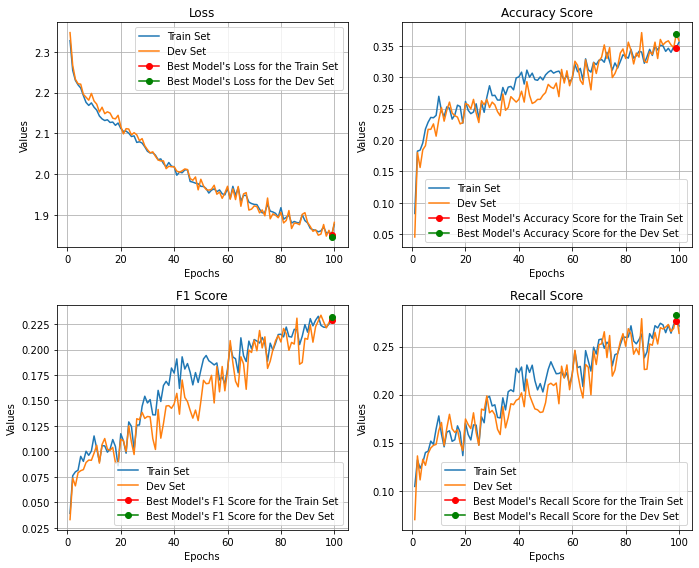

In [ ]:
EarlyLSTMNet = LSTM(input_dim=fused_feats,
                    rnn_size=HIDDEN_LAYER,
                    output_dim=OUTPUT_SIZE,
                    num_layers=NUM_LAYERS,
                    dropout=dropout,
                    pack_padded_sequence=pack_padded_sequence).to(device)

# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(EarlyLSTMNet.parameters(), lr=ETA, weight_decay=weight_decay)

# Start the training process
clf_main(device, EarlyLSTMNet, fused_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, net_name='EarlyLSTM_beatFUSED', PATIENCE=PATIENCE)

In [ ]:
with open('./best_EarlyLSTM_beatFUSED.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
test_loss, y_test_gold, y_test_pred = clf_eval(device, test_loader, fused_feats, E_model, criterion)

print(classification_report(y_test_gold, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.46      0.55      0.50        40
           2       0.26      0.69      0.38        80
           3       0.40      0.45      0.42        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.50      0.50      0.50        78
           7       0.00      0.00      0.00        40
           8       0.37      0.51      0.43       103
           9       0.00      0.00      0.00        34

    accuracy                           0.36       575
   macro avg       0.20      0.27      0.22       575
weighted avg       0.26      0.36      0.29       575



### Training and Evalution using 'non-beat-synced datasets'

####  Mel Spectrograms Dataset

In [ ]:
data = SpectrogramDataset("data/fma_genre_spectrograms",
                              class_mapping=class_mapping, train=True, read_spec_fn=read_mel_spectrogram)
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/fma_genre_spectrograms/',
                                          class_mapping=class_mapping, train=False, read_spec_fn=read_mel_spectrogram, max_length=data.max_length)

##### Normal Training

  0%|          | 0/100 [00:00<?, ?it/s]

 [================================--------] ...Epoch 1, Loss: 2.2574
Statistics for the Train Set
	 Epoch: 1 	 loss: 2.237962611790361
	 Epoch: 1 	 Accuracy Score: 0.16377440347071584
	 Epoch: 1 	 f1 Score: 0.048907229067664745
	 Epoch: 1 	 recall Score: 0.09654041900988246


  1%|          | 1/100 [00:08<14:25,  8.75s/it]

Statistics for the Dev Set
	 Epoch: 1 	 loss: 2.225230105717977
	 Epoch: 1 	 Accuracy Score: 0.17787418655097614
	 Epoch: 1 	 f1 Score: 0.04571681523995604
	 Epoch: 1 	 recall Score: 0.09559635766532318
Test loss decreased (inf --> 2.225230).  Saving model ...
Epoch total time 8.746512174606323
 [================================--------] ...Epoch 2, Loss: 2.2436
Statistics for the Train Set
	 Epoch: 2 	 loss: 2.2188845256279253
	 Epoch: 2 	 Accuracy Score: 0.17190889370932755
	 Epoch: 2 	 f1 Score: 0.05252639205960208
	 Epoch: 2 	 recall Score: 0.10198159912627358


  2%|▏         | 2/100 [00:17<14:12,  8.70s/it]

Statistics for the Dev Set
	 Epoch: 2 	 loss: 2.215505282084147
	 Epoch: 2 	 Accuracy Score: 0.1735357917570499
	 Epoch: 2 	 f1 Score: 0.054223141722986
	 Epoch: 2 	 recall Score: 0.10108233889166951
Test loss decreased (2.225230 --> 2.215505).  Saving model ...
Epoch total time 8.669985055923462
 [================================--------] ...Epoch 3, Loss: 2.2461
Statistics for the Train Set
	 Epoch: 3 	 loss: 2.2161584270411523
	 Epoch: 3 	 Accuracy Score: 0.1735357917570499
	 Epoch: 3 	 f1 Score: 0.05934822741193333
	 Epoch: 3 	 recall Score: 0.1077841064876445


  3%|▎         | 3/100 [00:26<14:03,  8.70s/it]

Statistics for the Dev Set
	 Epoch: 3 	 loss: 2.2137046337127684
	 Epoch: 3 	 Accuracy Score: 0.16919739696312364
	 Epoch: 3 	 f1 Score: 0.06600237171840828
	 Epoch: 3 	 recall Score: 0.11057348331182001
Test loss decreased (2.215505 --> 2.213705).  Saving model ...
Epoch total time 8.691517114639282
 [================================--------] ...Epoch 4, Loss: 2.3098
Statistics for the Train Set
	 Epoch: 4 	 loss: 2.2077535555280488
	 Epoch: 4 	 Accuracy Score: 0.18655097613882862
	 Epoch: 4 	 f1 Score: 0.06462868448069559
	 Epoch: 4 	 recall Score: 0.11580529547316935


  4%|▍         | 4/100 [00:34<13:52,  8.67s/it]

Statistics for the Dev Set
	 Epoch: 4 	 loss: 2.2108736197153727
	 Epoch: 4 	 Accuracy Score: 0.17787418655097614
	 Epoch: 4 	 f1 Score: 0.06146170830633355
	 Epoch: 4 	 recall Score: 0.1147433769746143
Test loss decreased (2.213705 --> 2.210874).  Saving model ...
Epoch total time 8.638299942016602
 [================================--------] ...Epoch 5, Loss: 2.2143
Statistics for the Train Set
	 Epoch: 5 	 loss: 2.2044483423233032
	 Epoch: 5 	 Accuracy Score: 0.1903470715835141
	 Epoch: 5 	 f1 Score: 0.06554591848682863
	 Epoch: 5 	 recall Score: 0.11669605174693817


  5%|▌         | 5/100 [00:43<13:41,  8.65s/it]

Statistics for the Dev Set
	 Epoch: 5 	 loss: 2.1997998714447022
	 Epoch: 5 	 Accuracy Score: 0.17787418655097614
	 Epoch: 5 	 f1 Score: 0.0658489443948855
	 Epoch: 5 	 recall Score: 0.11249615833794332
Test loss decreased (2.210874 --> 2.199800).  Saving model ...
Epoch total time 8.606682300567627
 [================================--------] ...Epoch 6, Loss: 2.2071
Statistics for the Train Set
	 Epoch: 6 	 loss: 2.217538299231694
	 Epoch: 6 	 Accuracy Score: 0.1876355748373102
	 Epoch: 6 	 f1 Score: 0.0732882317657502
	 Epoch: 6 	 recall Score: 0.11833333594277999


  6%|▌         | 6/100 [00:52<13:33,  8.65s/it]

Statistics for the Dev Set
	 Epoch: 6 	 loss: 2.210855579376221
	 Epoch: 6 	 Accuracy Score: 0.16919739696312364
	 Epoch: 6 	 f1 Score: 0.07223099784615296
	 Epoch: 6 	 recall Score: 0.10942845524995626
EarlyStopping counter: 1 out of 10
Epoch total time 8.655354022979736
 [================================--------] ...Epoch 7, Loss: 2.1805
Statistics for the Train Set
	 Epoch: 7 	 loss: 2.209985819356195
	 Epoch: 7 	 Accuracy Score: 0.17407809110629066
	 Epoch: 7 	 f1 Score: 0.06165706173218648
	 Epoch: 7 	 recall Score: 0.10888925197843817


  7%|▋         | 7/100 [01:00<13:27,  8.68s/it]

Statistics for the Dev Set
	 Epoch: 7 	 loss: 2.2074426492055257
	 Epoch: 7 	 Accuracy Score: 0.17136659436008678
	 Epoch: 7 	 f1 Score: 0.06849691130901811
	 Epoch: 7 	 recall Score: 0.11165747031872793
EarlyStopping counter: 2 out of 10
Epoch total time 8.731727600097656
 [================================--------] ...Epoch 8, Loss: 2.1878
Statistics for the Train Set
	 Epoch: 8 	 loss: 2.203966966990767
	 Epoch: 8 	 Accuracy Score: 0.19522776572668113
	 Epoch: 8 	 f1 Score: 0.06872075471935347
	 Epoch: 8 	 recall Score: 0.12051032697673544


  8%|▊         | 8/100 [01:09<13:14,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 8 	 loss: 2.201696427663167
	 Epoch: 8 	 Accuracy Score: 0.1822125813449024
	 Epoch: 8 	 f1 Score: 0.06749556395017549
	 Epoch: 8 	 recall Score: 0.11613252197430697
EarlyStopping counter: 3 out of 10
Epoch total time 8.549536228179932
 [================================--------] ...Epoch 9, Loss: 2.2158
Statistics for the Train Set
	 Epoch: 9 	 loss: 2.2024898775692643
	 Epoch: 9 	 Accuracy Score: 0.20715835140997832
	 Epoch: 9 	 f1 Score: 0.07850259355840952
	 Epoch: 9 	 recall Score: 0.12892304079981248


  9%|▉         | 9/100 [01:17<13:05,  8.63s/it]

Statistics for the Dev Set
	 Epoch: 9 	 loss: 2.2075844446818036
	 Epoch: 9 	 Accuracy Score: 0.2039045553145336
	 Epoch: 9 	 f1 Score: 0.07807615951533713
	 Epoch: 9 	 recall Score: 0.13273587805027967
EarlyStopping counter: 4 out of 10
Epoch total time 8.595649480819702
 [================================--------] ...Epoch 10, Loss: 2.1722
Statistics for the Train Set
	 Epoch: 10 	 loss: 2.1959411933504303
	 Epoch: 10 	 Accuracy Score: 0.2017353579175705
	 Epoch: 10 	 f1 Score: 0.07598486509644693
	 Epoch: 10 	 recall Score: 0.12330377717749261


 10%|█         | 10/100 [01:26<12:57,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 10 	 loss: 2.198168977101644
	 Epoch: 10 	 Accuracy Score: 0.19305856832971802
	 Epoch: 10 	 f1 Score: 0.06761030847325264
	 Epoch: 10 	 recall Score: 0.11920462228778658
Test loss decreased (2.199800 --> 2.198169).  Saving model ...
Epoch total time 8.676756381988525
 [================================--------] ...Epoch 11, Loss: 2.2025
Statistics for the Train Set
	 Epoch: 11 	 loss: 2.192854803183983
	 Epoch: 11 	 Accuracy Score: 0.20281995661605207
	 Epoch: 11 	 f1 Score: 0.07402199204022229
	 Epoch: 11 	 recall Score: 0.12370216940929317


 11%|█         | 11/100 [01:35<12:49,  8.65s/it]

Statistics for the Dev Set
	 Epoch: 11 	 loss: 2.1909619490305583
	 Epoch: 11 	 Accuracy Score: 0.20607375271149675
	 Epoch: 11 	 f1 Score: 0.07569884895466292
	 Epoch: 11 	 recall Score: 0.12906140512631384
Test loss decreased (2.198169 --> 2.190962).  Saving model ...
Epoch total time 8.670085430145264
 [================================--------] ...Epoch 12, Loss: 2.0696
Statistics for the Train Set
	 Epoch: 12 	 loss: 2.187742391536976
	 Epoch: 12 	 Accuracy Score: 0.210412147505423
	 Epoch: 12 	 f1 Score: 0.08023397895510467
	 Epoch: 12 	 recall Score: 0.12900108975137586


 12%|█▏        | 12/100 [01:43<12:41,  8.65s/it]

Statistics for the Dev Set
	 Epoch: 12 	 loss: 2.187738307317098
	 Epoch: 12 	 Accuracy Score: 0.21908893709327548
	 Epoch: 12 	 f1 Score: 0.08247728839591932
	 Epoch: 12 	 recall Score: 0.13920339295592846
Test loss decreased (2.190962 --> 2.187738).  Saving model ...
Epoch total time 8.642553329467773
 [================================--------] ...Epoch 13, Loss: 2.1471
Statistics for the Train Set
	 Epoch: 13 	 loss: 2.187251086892753
	 Epoch: 13 	 Accuracy Score: 0.2044468546637744
	 Epoch: 13 	 f1 Score: 0.07796257796257797
	 Epoch: 13 	 recall Score: 0.12598785448996386


 13%|█▎        | 13/100 [01:52<12:31,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 13 	 loss: 2.198616870244344
	 Epoch: 13 	 Accuracy Score: 0.20607375271149675
	 Epoch: 13 	 f1 Score: 0.07793385859423595
	 Epoch: 13 	 recall Score: 0.13269039277152866
EarlyStopping counter: 1 out of 10
Epoch total time 8.623096227645874
 [================================--------] ...Epoch 14, Loss: 2.3433
Statistics for the Train Set
	 Epoch: 14 	 loss: 2.185942127786834
	 Epoch: 14 	 Accuracy Score: 0.20878524945770066
	 Epoch: 14 	 f1 Score: 0.0812899617608221
	 Epoch: 14 	 recall Score: 0.12877759235086916


 14%|█▍        | 14/100 [02:01<12:22,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 14 	 loss: 2.2019076506296793
	 Epoch: 14 	 Accuracy Score: 0.210412147505423
	 Epoch: 14 	 f1 Score: 0.0803662614382674
	 Epoch: 14 	 recall Score: 0.13541705083287234
EarlyStopping counter: 2 out of 10
Epoch total time 8.620417594909668
 [================================--------] ...Epoch 15, Loss: 2.0995
Statistics for the Train Set
	 Epoch: 15 	 loss: 2.1827776473144005
	 Epoch: 15 	 Accuracy Score: 0.20878524945770066
	 Epoch: 15 	 f1 Score: 0.07780527492055742
	 Epoch: 15 	 recall Score: 0.12571704614079177


 15%|█▌        | 15/100 [02:09<12:12,  8.61s/it]

Statistics for the Dev Set
	 Epoch: 15 	 loss: 2.1923802375793455
	 Epoch: 15 	 Accuracy Score: 0.2017353579175705
	 Epoch: 15 	 f1 Score: 0.0662476821819215
	 Epoch: 15 	 recall Score: 0.11978978425225888
EarlyStopping counter: 3 out of 10
Epoch total time 8.563713312149048
 [================================--------] ...Epoch 16, Loss: 2.1763
Statistics for the Train Set
	 Epoch: 16 	 loss: 2.1777422839197618
	 Epoch: 16 	 Accuracy Score: 0.2185466377440347
	 Epoch: 16 	 f1 Score: 0.08487576292704081
	 Epoch: 16 	 recall Score: 0.13404234462489115


 16%|█▌        | 16/100 [02:18<12:02,  8.61s/it]

Statistics for the Dev Set
	 Epoch: 16 	 loss: 2.1925949414571124
	 Epoch: 16 	 Accuracy Score: 0.210412147505423
	 Epoch: 16 	 f1 Score: 0.07650811269280378
	 Epoch: 16 	 recall Score: 0.13045055012600654
EarlyStopping counter: 4 out of 10
Epoch total time 8.58231520652771
 [================================--------] ...Epoch 17, Loss: 2.2658
Statistics for the Train Set
	 Epoch: 17 	 loss: 2.182882635757841
	 Epoch: 17 	 Accuracy Score: 0.21800433839479394
	 Epoch: 17 	 f1 Score: 0.08740290442258773
	 Epoch: 17 	 recall Score: 0.13779918550921497


 17%|█▋        | 17/100 [02:26<11:53,  8.60s/it]

Statistics for the Dev Set
	 Epoch: 17 	 loss: 2.189611275990804
	 Epoch: 17 	 Accuracy Score: 0.2039045553145336
	 Epoch: 17 	 f1 Score: 0.08288086822404339
	 Epoch: 17 	 recall Score: 0.14146413424303889
EarlyStopping counter: 5 out of 10
Epoch total time 8.592714548110962
 [================================--------] ...Epoch 18, Loss: 2.1872
Statistics for the Train Set
	 Epoch: 18 	 loss: 2.18245019994933
	 Epoch: 18 	 Accuracy Score: 0.20336225596529284
	 Epoch: 18 	 f1 Score: 0.0758193903655062
	 Epoch: 18 	 recall Score: 0.12258970775160512


 18%|█▊        | 18/100 [02:35<11:46,  8.62s/it]

Statistics for the Dev Set
	 Epoch: 18 	 loss: 2.1936163743336996
	 Epoch: 18 	 Accuracy Score: 0.19956616052060738
	 Epoch: 18 	 f1 Score: 0.06647879160945121
	 Epoch: 18 	 recall Score: 0.12044993546007746
EarlyStopping counter: 6 out of 10
Epoch total time 8.667078733444214
 [================================--------] ...Epoch 19, Loss: 2.2679
Statistics for the Train Set
	 Epoch: 19 	 loss: 2.1754217641106965
	 Epoch: 19 	 Accuracy Score: 0.20607375271149675
	 Epoch: 19 	 f1 Score: 0.07614236543825292
	 Epoch: 19 	 recall Score: 0.12412485437192171


 19%|█▉        | 19/100 [02:44<11:36,  8.60s/it]

Statistics for the Dev Set
	 Epoch: 19 	 loss: 2.184743086496989
	 Epoch: 19 	 Accuracy Score: 0.19305856832971802
	 Epoch: 19 	 f1 Score: 0.06127687819276604
	 Epoch: 19 	 recall Score: 0.11661810805827033
Test loss decreased (2.187738 --> 2.184743).  Saving model ...
Epoch total time 8.556975841522217
 [================================--------] ...Epoch 20, Loss: 2.1203
Statistics for the Train Set
	 Epoch: 20 	 loss: 2.168796494089324
	 Epoch: 20 	 Accuracy Score: 0.2158351409978308
	 Epoch: 20 	 f1 Score: 0.07957743827681504
	 Epoch: 20 	 recall Score: 0.13132320109762086


 20%|██        | 20/100 [02:52<11:30,  8.63s/it]

Statistics for the Dev Set
	 Epoch: 20 	 loss: 2.1841025352478027
	 Epoch: 20 	 Accuracy Score: 0.19522776572668113
	 Epoch: 20 	 f1 Score: 0.06267598059722204
	 Epoch: 20 	 recall Score: 0.12101296945110333
Test loss decreased (2.184743 --> 2.184103).  Saving model ...
Epoch total time 8.674276113510132
 [================================--------] ...Epoch 21, Loss: 2.2211
Statistics for the Train Set
	 Epoch: 21 	 loss: 2.1618548878308
	 Epoch: 21 	 Accuracy Score: 0.22071583514099782
	 Epoch: 21 	 f1 Score: 0.07804382101689676
	 Epoch: 21 	 recall Score: 0.13472971770820324


 21%|██        | 21/100 [03:01<11:22,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 21 	 loss: 2.1579243898391725
	 Epoch: 21 	 Accuracy Score: 0.19739696312364424
	 Epoch: 21 	 f1 Score: 0.062135174560835615
	 Epoch: 21 	 recall Score: 0.12473907431311082
Test loss decreased (2.184103 --> 2.157924).  Saving model ...
Epoch total time 8.65810775756836
 [================================--------] ...Epoch 22, Loss: 2.0778
Statistics for the Train Set
	 Epoch: 22 	 loss: 2.1628839353035234
	 Epoch: 22 	 Accuracy Score: 0.20824295010845986
	 Epoch: 22 	 f1 Score: 0.07728529544461815
	 Epoch: 22 	 recall Score: 0.12523915081508954


 22%|██▏       | 22/100 [03:10<11:14,  8.65s/it]

Statistics for the Dev Set
	 Epoch: 22 	 loss: 2.175747028986613
	 Epoch: 22 	 Accuracy Score: 0.19956616052060738
	 Epoch: 22 	 f1 Score: 0.06408931419457735
	 Epoch: 22 	 recall Score: 0.11787325588542627
EarlyStopping counter: 1 out of 10
Epoch total time 8.666776895523071
 [================================--------] ...Epoch 23, Loss: 2.1456
Statistics for the Train Set
	 Epoch: 23 	 loss: 2.154115237038711
	 Epoch: 23 	 Accuracy Score: 0.22885032537960953
	 Epoch: 23 	 f1 Score: 0.08975830268046651
	 Epoch: 23 	 recall Score: 0.14141697617088395


 23%|██▎       | 23/100 [03:18<11:05,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 23 	 loss: 2.1540438334147134
	 Epoch: 23 	 Accuracy Score: 0.21258134490238612
	 Epoch: 23 	 f1 Score: 0.07782062464734972
	 Epoch: 23 	 recall Score: 0.13651238551847072
Test loss decreased (2.157924 --> 2.154044).  Saving model ...
Epoch total time 8.625327587127686
 [================================--------] ...Epoch 24, Loss: 2.1676
Statistics for the Train Set
	 Epoch: 24 	 loss: 2.149578376062985
	 Epoch: 24 	 Accuracy Score: 0.23644251626898047
	 Epoch: 24 	 f1 Score: 0.09507032784890139
	 Epoch: 24 	 recall Score: 0.1486733346221026


 24%|██▍       | 24/100 [03:27<10:56,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 24 	 loss: 2.160052537918091
	 Epoch: 24 	 Accuracy Score: 0.21691973969631237
	 Epoch: 24 	 f1 Score: 0.08418448392015035
	 Epoch: 24 	 recall Score: 0.14334992931341817
EarlyStopping counter: 1 out of 10
Epoch total time 8.635848045349121
 [================================--------] ...Epoch 25, Loss: 2.2019
Statistics for the Train Set
	 Epoch: 25 	 loss: 2.143766666280812
	 Epoch: 25 	 Accuracy Score: 0.23752711496746204
	 Epoch: 25 	 f1 Score: 0.09342796095346903
	 Epoch: 25 	 recall Score: 0.1473981330523132


 25%|██▌       | 25/100 [03:36<10:49,  8.65s/it]

Statistics for the Dev Set
	 Epoch: 25 	 loss: 2.1486750920613606
	 Epoch: 25 	 Accuracy Score: 0.21475054229934923
	 Epoch: 25 	 f1 Score: 0.07925476668814677
	 Epoch: 25 	 recall Score: 0.1391419263630217
Test loss decreased (2.154044 --> 2.148675).  Saving model ...
Epoch total time 8.686108350753784
 [================================--------] ...Epoch 26, Loss: 2.2997
Statistics for the Train Set
	 Epoch: 26 	 loss: 2.1375623489248343
	 Epoch: 26 	 Accuracy Score: 0.2472885032537961
	 Epoch: 26 	 f1 Score: 0.0984181782313334
	 Epoch: 26 	 recall Score: 0.15552750296388423


 26%|██▌       | 26/100 [03:44<10:39,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 26 	 loss: 2.156686766942342
	 Epoch: 26 	 Accuracy Score: 0.21691973969631237
	 Epoch: 26 	 f1 Score: 0.08008885842833786
	 Epoch: 26 	 recall Score: 0.14463335177331121
EarlyStopping counter: 1 out of 10
Epoch total time 8.610929489135742
 [================================--------] ...Epoch 27, Loss: 2.0607
Statistics for the Train Set
	 Epoch: 27 	 loss: 2.1381875995931954
	 Epoch: 27 	 Accuracy Score: 0.22125813449023862
	 Epoch: 27 	 f1 Score: 0.08449308670880525
	 Epoch: 27 	 recall Score: 0.1353535062793288


 27%|██▋       | 27/100 [03:53<10:30,  8.63s/it]

Statistics for the Dev Set
	 Epoch: 27 	 loss: 2.1439531008402506
	 Epoch: 27 	 Accuracy Score: 0.210412147505423
	 Epoch: 27 	 f1 Score: 0.07198801198801198
	 Epoch: 27 	 recall Score: 0.13106521605507407
Test loss decreased (2.148675 --> 2.143953).  Saving model ...
Epoch total time 8.610990285873413
 [================================--------] ...Epoch 28, Loss: 2.1663
Statistics for the Train Set
	 Epoch: 28 	 loss: 2.138094390260762
	 Epoch: 28 	 Accuracy Score: 0.2098698481561822
	 Epoch: 28 	 f1 Score: 0.07632123211602601
	 Epoch: 28 	 recall Score: 0.12599760152051967


 28%|██▊       | 28/100 [04:01<10:21,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 28 	 loss: 2.1422506014506024
	 Epoch: 28 	 Accuracy Score: 0.19956616052060738
	 Epoch: 28 	 f1 Score: 0.06368190687127565
	 Epoch: 28 	 recall Score: 0.11896981990288277
Test loss decreased (2.143953 --> 2.142251).  Saving model ...
Epoch total time 8.635722398757935
 [================================--------] ...Epoch 29, Loss: 1.9714
Statistics for the Train Set
	 Epoch: 29 	 loss: 2.1374477333035964
	 Epoch: 29 	 Accuracy Score: 0.21746203904555314
	 Epoch: 29 	 f1 Score: 0.07949298256160435
	 Epoch: 29 	 recall Score: 0.13314359912204016


 29%|██▉       | 29/100 [04:10<10:13,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 29 	 loss: 2.138377650578817
	 Epoch: 29 	 Accuracy Score: 0.19956616052060738
	 Epoch: 29 	 f1 Score: 0.07279918718622998
	 Epoch: 29 	 recall Score: 0.12508697522896306
Test loss decreased (2.142251 --> 2.138378).  Saving model ...
Epoch total time 8.648778915405273
 [================================--------] ...Epoch 30, Loss: 2.2835
Statistics for the Train Set
	 Epoch: 30 	 loss: 2.1295158493107764
	 Epoch: 30 	 Accuracy Score: 0.21908893709327548
	 Epoch: 30 	 f1 Score: 0.08406469527699696
	 Epoch: 30 	 recall Score: 0.133756156582047


 30%|███       | 30/100 [04:19<10:05,  8.65s/it]

Statistics for the Dev Set
	 Epoch: 30 	 loss: 2.128059403101603
	 Epoch: 30 	 Accuracy Score: 0.2017353579175705
	 Epoch: 30 	 f1 Score: 0.0722401955254747
	 Epoch: 30 	 recall Score: 0.12494314340156125
Test loss decreased (2.138378 --> 2.128059).  Saving model ...
Epoch total time 8.669387578964233
 [================================--------] ...Epoch 31, Loss: 2.1698
Statistics for the Train Set
	 Epoch: 31 	 loss: 2.1335654916434454
	 Epoch: 31 	 Accuracy Score: 0.21746203904555314
	 Epoch: 31 	 f1 Score: 0.08111949941967568
	 Epoch: 31 	 recall Score: 0.13282000968287722


 31%|███       | 31/100 [04:27<09:56,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 31 	 loss: 2.1295272509256997
	 Epoch: 31 	 Accuracy Score: 0.20824295010845986
	 Epoch: 31 	 f1 Score: 0.07410017200911734
	 Epoch: 31 	 recall Score: 0.12715225275063002
EarlyStopping counter: 1 out of 10
Epoch total time 8.619938135147095
 [================================--------] ...Epoch 32, Loss: 2.1641
Statistics for the Train Set
	 Epoch: 32 	 loss: 2.1239404493364793
	 Epoch: 32 	 Accuracy Score: 0.2299349240780911
	 Epoch: 32 	 f1 Score: 0.09000661573708035
	 Epoch: 32 	 recall Score: 0.14189299394221408


 32%|███▏      | 32/100 [04:36<09:47,  8.63s/it]

Statistics for the Dev Set
	 Epoch: 32 	 loss: 2.1211923122406007
	 Epoch: 32 	 Accuracy Score: 0.20607375271149675
	 Epoch: 32 	 f1 Score: 0.07252683305314885
	 Epoch: 32 	 recall Score: 0.12819595549818674
Test loss decreased (2.128059 --> 2.121192).  Saving model ...
Epoch total time 8.614013433456421
 [================================--------] ...Epoch 33, Loss: 2.1359
Statistics for the Train Set
	 Epoch: 33 	 loss: 2.120894676652448
	 Epoch: 33 	 Accuracy Score: 0.22613882863340565
	 Epoch: 33 	 f1 Score: 0.08719792792819998
	 Epoch: 33 	 recall Score: 0.13829380347180759


 33%|███▎      | 33/100 [04:45<09:39,  8.65s/it]

Statistics for the Dev Set
	 Epoch: 33 	 loss: 2.1224472761154174
	 Epoch: 33 	 Accuracy Score: 0.21258134490238612
	 Epoch: 33 	 f1 Score: 0.07610861973833796
	 Epoch: 33 	 recall Score: 0.1312164238736247
EarlyStopping counter: 1 out of 10
Epoch total time 8.681060075759888
 [================================--------] ...Epoch 34, Loss: 2.0135
Statistics for the Train Set
	 Epoch: 34 	 loss: 2.1173758342348297
	 Epoch: 34 	 Accuracy Score: 0.227765726681128
	 Epoch: 34 	 f1 Score: 0.08787979754081449
	 Epoch: 34 	 recall Score: 0.1395483947123963


 34%|███▍      | 34/100 [04:53<09:31,  8.66s/it]

Statistics for the Dev Set
	 Epoch: 34 	 loss: 2.119330898920695
	 Epoch: 34 	 Accuracy Score: 0.22342733188720174
	 Epoch: 34 	 f1 Score: 0.08289932289932292
	 Epoch: 34 	 recall Score: 0.1407351404511648
Test loss decreased (2.121192 --> 2.119331).  Saving model ...
Epoch total time 8.677404642105103
 [================================--------] ...Epoch 35, Loss: 2.2697
Statistics for the Train Set
	 Epoch: 35 	 loss: 2.1101010277353485
	 Epoch: 35 	 Accuracy Score: 0.25108459869848154
	 Epoch: 35 	 f1 Score: 0.10083739926383728
	 Epoch: 35 	 recall Score: 0.1586431739992507


 35%|███▌      | 35/100 [05:02<09:22,  8.65s/it]

Statistics for the Dev Set
	 Epoch: 35 	 loss: 2.1234567006429037
	 Epoch: 35 	 Accuracy Score: 0.22125813449023862
	 Epoch: 35 	 f1 Score: 0.08514722960272089
	 Epoch: 35 	 recall Score: 0.14784190792304383
EarlyStopping counter: 1 out of 10
Epoch total time 8.640876770019531
 [================================--------] ...Epoch 36, Loss: 2.2250
Statistics for the Train Set
	 Epoch: 36 	 loss: 2.1064588982483436
	 Epoch: 36 	 Accuracy Score: 0.25379609544468545
	 Epoch: 36 	 f1 Score: 0.10154059431443241
	 Epoch: 36 	 recall Score: 0.16114254529653382


 36%|███▌      | 36/100 [05:11<09:13,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 36 	 loss: 2.1062140703201293
	 Epoch: 36 	 Accuracy Score: 0.21475054229934923
	 Epoch: 36 	 f1 Score: 0.08497226230922991
	 Epoch: 36 	 recall Score: 0.14830782469727702
Test loss decreased (2.119331 --> 2.106214).  Saving model ...
Epoch total time 8.610996007919312
 [================================--------] ...Epoch 37, Loss: 2.0359
Statistics for the Train Set
	 Epoch: 37 	 loss: 2.1029918892630217
	 Epoch: 37 	 Accuracy Score: 0.2559652928416486
	 Epoch: 37 	 f1 Score: 0.10195453341267142
	 Epoch: 37 	 recall Score: 0.16172656735159624


 37%|███▋      | 37/100 [05:19<09:06,  8.67s/it]

Statistics for the Dev Set
	 Epoch: 37 	 loss: 2.1068003018697103
	 Epoch: 37 	 Accuracy Score: 0.2299349240780911
	 Epoch: 37 	 f1 Score: 0.08914154601717798
	 Epoch: 37 	 recall Score: 0.15649640420431496
EarlyStopping counter: 1 out of 10
Epoch total time 8.72166109085083
 [================================--------] ...Epoch 38, Loss: 2.1643
Statistics for the Train Set
	 Epoch: 38 	 loss: 2.097502344641192
	 Epoch: 38 	 Accuracy Score: 0.2586767895878525
	 Epoch: 38 	 f1 Score: 0.10160805612311483
	 Epoch: 38 	 recall Score: 0.16142819017444576


 38%|███▊      | 38/100 [05:28<08:56,  8.65s/it]

Statistics for the Dev Set
	 Epoch: 38 	 loss: 2.1004348436991376
	 Epoch: 38 	 Accuracy Score: 0.23210412147505424
	 Epoch: 38 	 f1 Score: 0.0872156137440496
	 Epoch: 38 	 recall Score: 0.15210891880263078
Test loss decreased (2.106214 --> 2.100435).  Saving model ...
Epoch total time 8.599515914916992
 [================================--------] ...Epoch 39, Loss: 2.2031
Statistics for the Train Set
	 Epoch: 39 	 loss: 2.092391258683698
	 Epoch: 39 	 Accuracy Score: 0.2608459869848156
	 Epoch: 39 	 f1 Score: 0.10286234964159133
	 Epoch: 39 	 recall Score: 0.16388501497766608


 39%|███▉      | 39/100 [05:37<08:47,  8.65s/it]

Statistics for the Dev Set
	 Epoch: 39 	 loss: 2.104524350166321
	 Epoch: 39 	 Accuracy Score: 0.22559652928416485
	 Epoch: 39 	 f1 Score: 0.08563738317757011
	 Epoch: 39 	 recall Score: 0.151237322515213
EarlyStopping counter: 1 out of 10
Epoch total time 8.640384674072266
 [================================--------] ...Epoch 40, Loss: 2.1430
Statistics for the Train Set
	 Epoch: 40 	 loss: 2.090498866706059
	 Epoch: 40 	 Accuracy Score: 0.25108459869848154
	 Epoch: 40 	 f1 Score: 0.09923096014718306
	 Epoch: 40 	 recall Score: 0.15599553150613218


 40%|████      | 40/100 [05:45<08:38,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 40 	 loss: 2.085603372255961
	 Epoch: 40 	 Accuracy Score: 0.22125813449023862
	 Epoch: 40 	 f1 Score: 0.08248082854832468
	 Epoch: 40 	 recall Score: 0.1423049972340033
Test loss decreased (2.100435 --> 2.085603).  Saving model ...
Epoch total time 8.60908031463623
 [================================--------] ...Epoch 41, Loss: 2.0485
Statistics for the Train Set
	 Epoch: 41 	 loss: 2.0896467998110015
	 Epoch: 41 	 Accuracy Score: 0.25650759219088937
	 Epoch: 41 	 f1 Score: 0.10091075041570093
	 Epoch: 41 	 recall Score: 0.16183037173010434


 41%|████      | 41/100 [05:54<08:29,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 41 	 loss: 2.090468422571818
	 Epoch: 41 	 Accuracy Score: 0.22125813449023862
	 Epoch: 41 	 f1 Score: 0.08487679516250946
	 Epoch: 41 	 recall Score: 0.15056118999323867
EarlyStopping counter: 1 out of 10
Epoch total time 8.653647422790527
 [================================--------] ...Epoch 42, Loss: 2.0930
Statistics for the Train Set
	 Epoch: 42 	 loss: 2.082362736093587
	 Epoch: 42 	 Accuracy Score: 0.2651843817787419
	 Epoch: 42 	 f1 Score: 0.1045543803083572
	 Epoch: 42 	 recall Score: 0.16621274615635964


 42%|████▏     | 42/100 [06:02<08:20,  8.63s/it]

Statistics for the Dev Set
	 Epoch: 42 	 loss: 2.0766383091608684
	 Epoch: 42 	 Accuracy Score: 0.23644251626898047
	 Epoch: 42 	 f1 Score: 0.09042437266911722
	 Epoch: 42 	 recall Score: 0.15751060298727643
Test loss decreased (2.085603 --> 2.076638).  Saving model ...
Epoch total time 8.597309350967407
 [================================--------] ...Epoch 43, Loss: 1.9837
Statistics for the Train Set
	 Epoch: 43 	 loss: 2.08202640352578
	 Epoch: 43 	 Accuracy Score: 0.25488069414316705
	 Epoch: 43 	 f1 Score: 0.10143712597190824
	 Epoch: 43 	 recall Score: 0.15964007838682578


 43%|████▎     | 43/100 [06:11<08:11,  8.62s/it]

Statistics for the Dev Set
	 Epoch: 43 	 loss: 2.0782601912816365
	 Epoch: 43 	 Accuracy Score: 0.23210412147505424
	 Epoch: 43 	 f1 Score: 0.0882287257296671
	 Epoch: 43 	 recall Score: 0.1537316368553691
EarlyStopping counter: 1 out of 10
Epoch total time 8.59717059135437
 [================================--------] ...Epoch 44, Loss: 1.9062
Statistics for the Train Set
	 Epoch: 44 	 loss: 2.086449925241799
	 Epoch: 44 	 Accuracy Score: 0.24620390455531455
	 Epoch: 44 	 f1 Score: 0.09800365723588346
	 Epoch: 44 	 recall Score: 0.1531861584467707


 44%|████▍     | 44/100 [06:20<08:03,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 44 	 loss: 2.080161778132121
	 Epoch: 44 	 Accuracy Score: 0.21691973969631237
	 Epoch: 44 	 f1 Score: 0.0828505793723185
	 Epoch: 44 	 recall Score: 0.14010449320794147
EarlyStopping counter: 2 out of 10
Epoch total time 8.676171779632568
 [================================--------] ...Epoch 45, Loss: 2.0120
Statistics for the Train Set
	 Epoch: 45 	 loss: 2.084389641367156
	 Epoch: 45 	 Accuracy Score: 0.2478308026030369
	 Epoch: 45 	 f1 Score: 0.09725662116226157
	 Epoch: 45 	 recall Score: 0.15352001669697554


 45%|████▌     | 45/100 [06:28<07:55,  8.65s/it]

Statistics for the Dev Set
	 Epoch: 45 	 loss: 2.0714930136998495
	 Epoch: 45 	 Accuracy Score: 0.21475054229934923
	 Epoch: 45 	 f1 Score: 0.07888475574104317
	 Epoch: 45 	 recall Score: 0.1373766058147397
Test loss decreased (2.076638 --> 2.071493).  Saving model ...
Epoch total time 8.663926124572754
 [================================--------] ...Epoch 46, Loss: 1.9313
Statistics for the Train Set
	 Epoch: 46 	 loss: 2.083031479654641
	 Epoch: 46 	 Accuracy Score: 0.232646420824295
	 Epoch: 46 	 f1 Score: 0.0902851129603397
	 Epoch: 46 	 recall Score: 0.14279966024391955


 46%|████▌     | 46/100 [06:37<07:45,  8.62s/it]

Statistics for the Dev Set
	 Epoch: 46 	 loss: 2.0684178988138835
	 Epoch: 46 	 Accuracy Score: 0.22125813449023862
	 Epoch: 46 	 f1 Score: 0.07953680960407546
	 Epoch: 46 	 recall Score: 0.13700903558915728
Test loss decreased (2.071493 --> 2.068418).  Saving model ...
Epoch total time 8.571014404296875
 [================================--------] ...Epoch 47, Loss: 1.8815
Statistics for the Train Set
	 Epoch: 47 	 loss: 2.079713552162565
	 Epoch: 47 	 Accuracy Score: 0.24295010845986983
	 Epoch: 47 	 f1 Score: 0.09655453862616784
	 Epoch: 47 	 recall Score: 0.1510557458296053


 47%|████▋     | 47/100 [06:46<07:36,  8.62s/it]

Statistics for the Dev Set
	 Epoch: 47 	 loss: 2.068418288230896
	 Epoch: 47 	 Accuracy Score: 0.21908893709327548
	 Epoch: 47 	 f1 Score: 0.08348501263994222
	 Epoch: 47 	 recall Score: 0.1412539184952978
EarlyStopping counter: 1 out of 10
Epoch total time 8.598002672195435
 [================================--------] ...Epoch 48, Loss: 2.1866
Statistics for the Train Set
	 Epoch: 48 	 loss: 2.0741070138997046
	 Epoch: 48 	 Accuracy Score: 0.2359002169197397
	 Epoch: 48 	 f1 Score: 0.09260003240663477
	 Epoch: 48 	 recall Score: 0.14551506149311338


 48%|████▊     | 48/100 [06:54<07:29,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 48 	 loss: 2.075000858306885
	 Epoch: 48 	 Accuracy Score: 0.22125813449023862
	 Epoch: 48 	 f1 Score: 0.08171068841958665
	 Epoch: 48 	 recall Score: 0.1393005101727211
EarlyStopping counter: 2 out of 10
Epoch total time 8.683656692504883
 [================================--------] ...Epoch 49, Loss: 2.0057
Statistics for the Train Set
	 Epoch: 49 	 loss: 2.0708609305579087
	 Epoch: 49 	 Accuracy Score: 0.2472885032537961
	 Epoch: 49 	 f1 Score: 0.0976233097240682
	 Epoch: 49 	 recall Score: 0.15385202733103293


 49%|████▉     | 49/100 [07:03<07:21,  8.65s/it]

Statistics for the Dev Set
	 Epoch: 49 	 loss: 2.071354341506958
	 Epoch: 49 	 Accuracy Score: 0.22559652928416485
	 Epoch: 49 	 f1 Score: 0.08635538105305549
	 Epoch: 49 	 recall Score: 0.1458971049234741
EarlyStopping counter: 3 out of 10
Epoch total time 8.674108505249023
 [================================--------] ...Epoch 50, Loss: 2.0821
Statistics for the Train Set
	 Epoch: 50 	 loss: 2.073861165293332
	 Epoch: 50 	 Accuracy Score: 0.24837310195227766
	 Epoch: 50 	 f1 Score: 0.1372894291288552
	 Epoch: 50 	 recall Score: 0.16854841038585638


 50%|█████     | 50/100 [07:11<07:10,  8.62s/it]

Statistics for the Dev Set
	 Epoch: 50 	 loss: 2.0488406737645466
	 Epoch: 50 	 Accuracy Score: 0.23644251626898047
	 Epoch: 50 	 f1 Score: 0.11639696615284881
	 Epoch: 50 	 recall Score: 0.15249214612297776
Test loss decreased (2.068418 --> 2.048841).  Saving model ...
Epoch total time 8.543781518936157
 [================================--------] ...Epoch 51, Loss: 2.0229
Statistics for the Train Set
	 Epoch: 51 	 loss: 2.0593654595572373
	 Epoch: 51 	 Accuracy Score: 0.25704989154013014
	 Epoch: 51 	 f1 Score: 0.10280494163577736
	 Epoch: 51 	 recall Score: 0.16143119414126406


 51%|█████     | 51/100 [07:20<07:02,  8.62s/it]

Statistics for the Dev Set
	 Epoch: 51 	 loss: 2.0554983615875244
	 Epoch: 51 	 Accuracy Score: 0.227765726681128
	 Epoch: 51 	 f1 Score: 0.08711181103225576
	 Epoch: 51 	 recall Score: 0.15129018378511278
EarlyStopping counter: 1 out of 10
Epoch total time 8.619464635848999
 [================================--------] ...Epoch 52, Loss: 1.9953
Statistics for the Train Set
	 Epoch: 52 	 loss: 2.0580935642637055
	 Epoch: 52 	 Accuracy Score: 0.2706073752711497
	 Epoch: 52 	 f1 Score: 0.1100800503950518
	 Epoch: 52 	 recall Score: 0.17136127454546596


 52%|█████▏    | 52/100 [07:29<06:54,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 52 	 loss: 2.060379632314046
	 Epoch: 52 	 Accuracy Score: 0.24078091106290672
	 Epoch: 52 	 f1 Score: 0.09650177989139577
	 Epoch: 52 	 recall Score: 0.16263375569663602
EarlyStopping counter: 2 out of 10
Epoch total time 8.673103332519531
 [================================--------] ...Epoch 53, Loss: 2.1476
Statistics for the Train Set
	 Epoch: 53 	 loss: 2.0556056006201384
	 Epoch: 53 	 Accuracy Score: 0.2678958785249458
	 Epoch: 53 	 f1 Score: 0.10826998672916417
	 Epoch: 53 	 recall Score: 0.1707252021685539


 53%|█████▎    | 53/100 [07:37<06:45,  8.62s/it]

Statistics for the Dev Set
	 Epoch: 53 	 loss: 2.0552960952123005
	 Epoch: 53 	 Accuracy Score: 0.23644251626898047
	 Epoch: 53 	 f1 Score: 0.09432354217016793
	 Epoch: 53 	 recall Score: 0.16343106521605505
EarlyStopping counter: 3 out of 10
Epoch total time 8.589436054229736
 [================================--------] ...Epoch 54, Loss: 1.9206
Statistics for the Train Set
	 Epoch: 54 	 loss: 2.055859592454187
	 Epoch: 54 	 Accuracy Score: 0.2651843817787419
	 Epoch: 54 	 f1 Score: 0.10683826860879357
	 Epoch: 54 	 recall Score: 0.16853165411257115


 54%|█████▍    | 54/100 [07:46<06:36,  8.63s/it]

Statistics for the Dev Set
	 Epoch: 54 	 loss: 2.055346465110779
	 Epoch: 54 	 Accuracy Score: 0.22342733188720174
	 Epoch: 54 	 f1 Score: 0.08772844272844273
	 Epoch: 54 	 recall Score: 0.15209416682033314
EarlyStopping counter: 4 out of 10
Epoch total time 8.644139289855957
 [================================--------] ...Epoch 55, Loss: 2.0991
Statistics for the Train Set
	 Epoch: 55 	 loss: 2.0508454421470903
	 Epoch: 55 	 Accuracy Score: 0.2662689804772234
	 Epoch: 55 	 f1 Score: 0.10844604340182078
	 Epoch: 55 	 recall Score: 0.1671668180782107


 55%|█████▌    | 55/100 [07:55<06:28,  8.63s/it]

Statistics for the Dev Set
	 Epoch: 55 	 loss: 2.0483606179555256
	 Epoch: 55 	 Accuracy Score: 0.23644251626898047
	 Epoch: 55 	 f1 Score: 0.09142533996159814
	 Epoch: 55 	 recall Score: 0.1553174749523634
Test loss decreased (2.048841 --> 2.048361).  Saving model ...
Epoch total time 8.614866018295288
 [================================--------] ...Epoch 56, Loss: 2.1915
Statistics for the Train Set
	 Epoch: 56 	 loss: 2.044768481419004
	 Epoch: 56 	 Accuracy Score: 0.2613882863340564
	 Epoch: 56 	 f1 Score: 0.10334776603854004
	 Epoch: 56 	 recall Score: 0.16421233814112707


 56%|█████▌    | 56/100 [08:03<06:20,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 56 	 loss: 2.051981727282206
	 Epoch: 56 	 Accuracy Score: 0.24078091106290672
	 Epoch: 56 	 f1 Score: 0.09001337369206804
	 Epoch: 56 	 recall Score: 0.16104862007498927
EarlyStopping counter: 1 out of 10
Epoch total time 8.669586658477783
 [================================--------] ...Epoch 57, Loss: 2.1784
Statistics for the Train Set
	 Epoch: 57 	 loss: 2.039644874375442
	 Epoch: 57 	 Accuracy Score: 0.26898047722342733
	 Epoch: 57 	 f1 Score: 0.10755515101664037
	 Epoch: 57 	 recall Score: 0.16925032547127042


 57%|█████▋    | 57/100 [08:12<06:11,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 57 	 loss: 2.03613650004069
	 Epoch: 57 	 Accuracy Score: 0.24511930585683298
	 Epoch: 57 	 f1 Score: 0.09573009202664591
	 Epoch: 57 	 recall Score: 0.16382936873809087
Test loss decreased (2.048361 --> 2.036137).  Saving model ...
Epoch total time 8.63151216506958
 [================================--------] ...Epoch 58, Loss: 2.0442
Statistics for the Train Set
	 Epoch: 58 	 loss: 2.038809309745657
	 Epoch: 58 	 Accuracy Score: 0.26572668112798264
	 Epoch: 58 	 f1 Score: 0.10763776613664726
	 Epoch: 58 	 recall Score: 0.1682601149952579


 58%|█████▊    | 58/100 [08:21<06:02,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 58 	 loss: 2.0188071807225545
	 Epoch: 58 	 Accuracy Score: 0.24078091106290672
	 Epoch: 58 	 f1 Score: 0.09368631564226278
	 Epoch: 58 	 recall Score: 0.16548896674657324
Test loss decreased (2.036137 --> 2.018807).  Saving model ...
Epoch total time 8.644086122512817
 [================================--------] ...Epoch 59, Loss: 2.0809
Statistics for the Train Set
	 Epoch: 59 	 loss: 2.0296219710646004
	 Epoch: 59 	 Accuracy Score: 0.27331887201735355
	 Epoch: 59 	 f1 Score: 0.10933374656013614
	 Epoch: 59 	 recall Score: 0.1719680490713163


 59%|█████▉    | 59/100 [08:29<05:53,  8.63s/it]

Statistics for the Dev Set
	 Epoch: 59 	 loss: 2.036928160985311
	 Epoch: 59 	 Accuracy Score: 0.24295010845986983
	 Epoch: 59 	 f1 Score: 0.09502918093059501
	 Epoch: 59 	 recall Score: 0.16267994345073453
EarlyStopping counter: 1 out of 10
Epoch total time 8.611361980438232
 [================================--------] ...Epoch 60, Loss: 2.0902
Statistics for the Train Set
	 Epoch: 60 	 loss: 2.031712028486975
	 Epoch: 60 	 Accuracy Score: 0.2678958785249458
	 Epoch: 60 	 f1 Score: 0.10917203474187112
	 Epoch: 60 	 recall Score: 0.1697924602531286


 60%|██████    | 60/100 [08:38<05:45,  8.63s/it]

Statistics for the Dev Set
	 Epoch: 60 	 loss: 2.020390844345093
	 Epoch: 60 	 Accuracy Score: 0.2386117136659436
	 Epoch: 60 	 f1 Score: 0.09499278867527068
	 Epoch: 60 	 recall Score: 0.16267256745958572
EarlyStopping counter: 2 out of 10
Epoch total time 8.626976728439331
 [================================--------] ...Epoch 61, Loss: 2.0771
Statistics for the Train Set
	 Epoch: 61 	 loss: 2.025861378373771
	 Epoch: 61 	 Accuracy Score: 0.27711496746203906
	 Epoch: 61 	 f1 Score: 0.11320951218985412
	 Epoch: 61 	 recall Score: 0.174542450706242


 61%|██████    | 61/100 [08:46<05:36,  8.63s/it]

Statistics for the Dev Set
	 Epoch: 61 	 loss: 2.0231062014897665
	 Epoch: 61 	 Accuracy Score: 0.24078091106290672
	 Epoch: 61 	 f1 Score: 0.09564455671447196
	 Epoch: 61 	 recall Score: 0.16205667219866002
EarlyStopping counter: 3 out of 10
Epoch total time 8.624283790588379
 [================================--------] ...Epoch 62, Loss: 2.1161
Statistics for the Train Set
	 Epoch: 62 	 loss: 2.032029394445748
	 Epoch: 62 	 Accuracy Score: 0.2635574837310195
	 Epoch: 62 	 f1 Score: 0.10087947940474522
	 Epoch: 62 	 recall Score: 0.1634804896867093


 62%|██████▏   | 62/100 [08:55<05:28,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 62 	 loss: 2.0292694489161174
	 Epoch: 62 	 Accuracy Score: 0.24945770065075923
	 Epoch: 62 	 f1 Score: 0.09222723768758123
	 Epoch: 62 	 recall Score: 0.1657889237199582
EarlyStopping counter: 4 out of 10
Epoch total time 8.66364860534668
 [================================--------] ...Epoch 63, Loss: 1.9566
Statistics for the Train Set
	 Epoch: 63 	 loss: 2.0273592862589607
	 Epoch: 63 	 Accuracy Score: 0.27331887201735355
	 Epoch: 63 	 f1 Score: 0.10812698725265808
	 Epoch: 63 	 recall Score: 0.17122641081745038


 63%|██████▎   | 63/100 [09:04<05:19,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 63 	 loss: 2.023906429608663
	 Epoch: 63 	 Accuracy Score: 0.2472885032537961
	 Epoch: 63 	 f1 Score: 0.0993317730706562
	 Epoch: 63 	 recall Score: 0.169035589157293
EarlyStopping counter: 5 out of 10
Epoch total time 8.641413688659668
 [================================--------] ...Epoch 64, Loss: 2.1485
Statistics for the Train Set
	 Epoch: 64 	 loss: 2.024698797998757
	 Epoch: 64 	 Accuracy Score: 0.26843817787418656
	 Epoch: 64 	 f1 Score: 0.10763975989369035
	 Epoch: 64 	 recall Score: 0.16832756639522578


 64%|██████▍   | 64/100 [09:12<05:10,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 64 	 loss: 2.0157174825668336
	 Epoch: 64 	 Accuracy Score: 0.2299349240780911
	 Epoch: 64 	 f1 Score: 0.08570365307207413
	 Epoch: 64 	 recall Score: 0.15382137808101298
Test loss decreased (2.018807 --> 2.015717).  Saving model ...
Epoch total time 8.626319885253906
 [================================--------] ...Epoch 65, Loss: 2.0483
Statistics for the Train Set
	 Epoch: 65 	 loss: 2.02473219920849
	 Epoch: 65 	 Accuracy Score: 0.2695227765726681
	 Epoch: 65 	 f1 Score: 0.10616765414031018
	 Epoch: 65 	 recall Score: 0.16800505784920375


 65%|██████▌   | 65/100 [09:21<05:02,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 65 	 loss: 2.011736583709717
	 Epoch: 65 	 Accuracy Score: 0.23644251626898047
	 Epoch: 65 	 f1 Score: 0.09114712204395553
	 Epoch: 65 	 recall Score: 0.15469964788423207
Test loss decreased (2.015717 --> 2.011737).  Saving model ...
Epoch total time 8.637742042541504
 [================================--------] ...Epoch 66, Loss: 1.9500
Statistics for the Train Set
	 Epoch: 66 	 loss: 2.0204229909798195
	 Epoch: 66 	 Accuracy Score: 0.2727765726681128
	 Epoch: 66 	 f1 Score: 0.10842078328295571
	 Epoch: 66 	 recall Score: 0.17206391982030222


 66%|██████▌   | 66/100 [09:30<04:53,  8.63s/it]

Statistics for the Dev Set
	 Epoch: 66 	 loss: 2.026512869199117
	 Epoch: 66 	 Accuracy Score: 0.23644251626898047
	 Epoch: 66 	 f1 Score: 0.09365429732073577
	 Epoch: 66 	 recall Score: 0.16113959063249123
EarlyStopping counter: 1 out of 10
Epoch total time 8.623756647109985
 [================================--------] ...Epoch 67, Loss: 2.0861
Statistics for the Train Set
	 Epoch: 67 	 loss: 2.00894112011482
	 Epoch: 67 	 Accuracy Score: 0.27006507592190887
	 Epoch: 67 	 f1 Score: 0.10998356669495771
	 Epoch: 67 	 recall Score: 0.17026401809886735


 67%|██████▋   | 67/100 [09:38<04:44,  8.63s/it]

Statistics for the Dev Set
	 Epoch: 67 	 loss: 2.008477878570557
	 Epoch: 67 	 Accuracy Score: 0.2386117136659436
	 Epoch: 67 	 f1 Score: 0.0997782237828461
	 Epoch: 67 	 recall Score: 0.1618468954980111
Test loss decreased (2.011737 --> 2.008478).  Saving model ...
Epoch total time 8.63425612449646
 [================================--------] ...Epoch 68, Loss: 2.5019
Statistics for the Train Set
	 Epoch: 68 	 loss: 2.0017320924791795
	 Epoch: 68 	 Accuracy Score: 0.27114967462039047
	 Epoch: 68 	 f1 Score: 0.11020429071231838
	 Epoch: 68 	 recall Score: 0.17052820582351097


 68%|██████▊   | 68/100 [09:47<04:36,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 68 	 loss: 1.996133804321289
	 Epoch: 68 	 Accuracy Score: 0.2472885032537961
	 Epoch: 68 	 f1 Score: 0.09775782084442325
	 Epoch: 68 	 recall Score: 0.16627556351694284
Test loss decreased (2.008478 --> 1.996134).  Saving model ...
Epoch total time 8.658193111419678
 [================================--------] ...Epoch 69, Loss: 2.1115
Statistics for the Train Set
	 Epoch: 69 	 loss: 2.002113498490432
	 Epoch: 69 	 Accuracy Score: 0.2781995661605206
	 Epoch: 69 	 f1 Score: 0.11921537133966983
	 Epoch: 69 	 recall Score: 0.17551318828812015


 69%|██████▉   | 69/100 [09:56<04:27,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 69 	 loss: 1.9941893259684245
	 Epoch: 69 	 Accuracy Score: 0.2472885032537961
	 Epoch: 69 	 f1 Score: 0.09984122980844291
	 Epoch: 69 	 recall Score: 0.16622463405424864
Test loss decreased (1.996134 --> 1.994189).  Saving model ...
Epoch total time 8.647883415222168
 [================================--------] ...Epoch 70, Loss: 2.3261
Statistics for the Train Set
	 Epoch: 70 	 loss: 1.9952163922375645
	 Epoch: 70 	 Accuracy Score: 0.28036876355748375
	 Epoch: 70 	 f1 Score: 0.11506027054743133
	 Epoch: 70 	 recall Score: 0.17662578818356683


 70%|███████   | 70/100 [10:04<04:18,  8.63s/it]

Statistics for the Dev Set
	 Epoch: 70 	 loss: 1.9950276851654052
	 Epoch: 70 	 Accuracy Score: 0.24945770065075923
	 Epoch: 70 	 f1 Score: 0.10693699329722584
	 Epoch: 70 	 recall Score: 0.1710294776217697
EarlyStopping counter: 1 out of 10
Epoch total time 8.603666305541992
 [================================--------] ...Epoch 71, Loss: 1.9817
Statistics for the Train Set
	 Epoch: 71 	 loss: 1.997297383587936
	 Epoch: 71 	 Accuracy Score: 0.2662689804772234
	 Epoch: 71 	 f1 Score: 0.10736627406769443
	 Epoch: 71 	 recall Score: 0.16628583021944385


 71%|███████   | 71/100 [10:13<04:10,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 71 	 loss: 1.9840418259302774
	 Epoch: 71 	 Accuracy Score: 0.2386117136659436
	 Epoch: 71 	 f1 Score: 0.0998700204487674
	 Epoch: 71 	 recall Score: 0.1584079274342966
Test loss decreased (1.994189 --> 1.984042).  Saving model ...
Epoch total time 8.656395673751831
 [================================--------] ...Epoch 72, Loss: 2.1190
Statistics for the Train Set
	 Epoch: 72 	 loss: 1.997384367317989
	 Epoch: 72 	 Accuracy Score: 0.28308026030368766
	 Epoch: 72 	 f1 Score: 0.12785669155476817
	 Epoch: 72 	 recall Score: 0.1823341471776027


 72%|███████▏  | 72/100 [10:22<04:02,  8.66s/it]

Statistics for the Dev Set
	 Epoch: 72 	 loss: 1.9903185526529947
	 Epoch: 72 	 Accuracy Score: 0.25379609544468545
	 Epoch: 72 	 f1 Score: 0.10815285494948115
	 Epoch: 72 	 recall Score: 0.17514457820745852
EarlyStopping counter: 1 out of 10
Epoch total time 8.704229354858398
 [================================--------] ...Epoch 73, Loss: 2.0265
Statistics for the Train Set
	 Epoch: 73 	 loss: 1.9914419054985046
	 Epoch: 73 	 Accuracy Score: 0.28362255965292843
	 Epoch: 73 	 f1 Score: 0.1246804733932823
	 Epoch: 73 	 recall Score: 0.18239291530268248


 73%|███████▎  | 73/100 [10:30<03:53,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 73 	 loss: 1.9935473521550497
	 Epoch: 73 	 Accuracy Score: 0.24945770065075923
	 Epoch: 73 	 f1 Score: 0.1057082816348606
	 Epoch: 73 	 recall Score: 0.17078852857757523
EarlyStopping counter: 2 out of 10
Epoch total time 8.602967500686646
 [================================--------] ...Epoch 74, Loss: 2.1463
Statistics for the Train Set
	 Epoch: 74 	 loss: 1.9850077916835915
	 Epoch: 74 	 Accuracy Score: 0.272234273318872
	 Epoch: 74 	 f1 Score: 0.11719069012174202
	 Epoch: 74 	 recall Score: 0.17377008246591266


 74%|███████▍  | 74/100 [10:39<03:44,  8.63s/it]

Statistics for the Dev Set
	 Epoch: 74 	 loss: 1.9844130516052245
	 Epoch: 74 	 Accuracy Score: 0.24945770065075923
	 Epoch: 74 	 f1 Score: 0.10997285064114588
	 Epoch: 74 	 recall Score: 0.17208845920813465
EarlyStopping counter: 3 out of 10
Epoch total time 8.585728168487549
 [================================--------] ...Epoch 75, Loss: 2.0059
Statistics for the Train Set
	 Epoch: 75 	 loss: 1.982739674633947
	 Epoch: 75 	 Accuracy Score: 0.2765726681127983
	 Epoch: 75 	 f1 Score: 0.11831508367936142
	 Epoch: 75 	 recall Score: 0.17569009280745612


 75%|███████▌  | 75/100 [10:47<03:35,  8.63s/it]

Statistics for the Dev Set
	 Epoch: 75 	 loss: 1.9747052748998006
	 Epoch: 75 	 Accuracy Score: 0.2472885032537961
	 Epoch: 75 	 f1 Score: 0.10967379498424226
	 Epoch: 75 	 recall Score: 0.16936724533073416
Test loss decreased (1.984042 --> 1.974705).  Saving model ...
Epoch total time 8.64736795425415
 [================================--------] ...Epoch 76, Loss: 2.0584
Statistics for the Train Set
	 Epoch: 76 	 loss: 1.989026022368464
	 Epoch: 76 	 Accuracy Score: 0.29663774403470716
	 Epoch: 76 	 f1 Score: 0.15231136266691364
	 Epoch: 76 	 recall Score: 0.1957686945604724


 76%|███████▌  | 76/100 [10:56<03:27,  8.66s/it]

Statistics for the Dev Set
	 Epoch: 76 	 loss: 1.9815368175506591
	 Epoch: 76 	 Accuracy Score: 0.26898047722342733
	 Epoch: 76 	 f1 Score: 0.13584021841892907
	 Epoch: 76 	 recall Score: 0.1847164194831538
EarlyStopping counter: 1 out of 10
Epoch total time 8.724241733551025
 [================================--------] ...Epoch 77, Loss: 2.0387
Statistics for the Train Set
	 Epoch: 77 	 loss: 1.9781505712147416
	 Epoch: 77 	 Accuracy Score: 0.28199566160520606
	 Epoch: 77 	 f1 Score: 0.1298662406670574
	 Epoch: 77 	 recall Score: 0.18291789780150675


 77%|███████▋  | 77/100 [11:05<03:18,  8.65s/it]

Statistics for the Dev Set
	 Epoch: 77 	 loss: 1.9787894248962403
	 Epoch: 77 	 Accuracy Score: 0.2646420824295011
	 Epoch: 77 	 f1 Score: 0.12481285301429186
	 Epoch: 77 	 recall Score: 0.18561277802657114
EarlyStopping counter: 2 out of 10
Epoch total time 8.614102840423584
 [================================--------] ...Epoch 78, Loss: 1.9620
Statistics for the Train Set
	 Epoch: 78 	 loss: 1.9785176125066033
	 Epoch: 78 	 Accuracy Score: 0.2901301518438178
	 Epoch: 78 	 f1 Score: 0.1581285955458902
	 Epoch: 78 	 recall Score: 0.19551503646232285


 78%|███████▊  | 78/100 [11:13<03:09,  8.62s/it]

Statistics for the Dev Set
	 Epoch: 78 	 loss: 1.9588557481765747
	 Epoch: 78 	 Accuracy Score: 0.28633405639913234
	 Epoch: 78 	 f1 Score: 0.15907336391207358
	 Epoch: 78 	 recall Score: 0.1999825259257308
Test loss decreased (1.974705 --> 1.958856).  Saving model ...
Epoch total time 8.536603927612305
 [================================--------] ...Epoch 79, Loss: 1.9936
Statistics for the Train Set
	 Epoch: 79 	 loss: 1.98045905705156
	 Epoch: 79 	 Accuracy Score: 0.2868763557483731
	 Epoch: 79 	 f1 Score: 0.1700173689854167
	 Epoch: 79 	 recall Score: 0.20021502653639586


 79%|███████▉  | 79/100 [11:22<03:01,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 79 	 loss: 1.9895442485809327
	 Epoch: 79 	 Accuracy Score: 0.26898047722342733
	 Epoch: 79 	 f1 Score: 0.1501082017247879
	 Epoch: 79 	 recall Score: 0.18869585451735554
EarlyStopping counter: 1 out of 10
Epoch total time 8.700026035308838
 [================================--------] ...Epoch 80, Loss: 1.8307
Statistics for the Train Set
	 Epoch: 80 	 loss: 1.9757281295184432
	 Epoch: 80 	 Accuracy Score: 0.28036876355748375
	 Epoch: 80 	 f1 Score: 0.13783944118700284
	 Epoch: 80 	 recall Score: 0.18379623462409822


 80%|████████  | 80/100 [11:31<02:52,  8.62s/it]

Statistics for the Dev Set
	 Epoch: 80 	 loss: 1.9748051484425864
	 Epoch: 80 	 Accuracy Score: 0.27114967462039047
	 Epoch: 80 	 f1 Score: 0.13464023192260996
	 Epoch: 80 	 recall Score: 0.1895795685045178
EarlyStopping counter: 2 out of 10
Epoch total time 8.568649530410767
 [================================--------] ...Epoch 81, Loss: 1.9918
Statistics for the Train Set
	 Epoch: 81 	 loss: 1.978500197673666
	 Epoch: 81 	 Accuracy Score: 0.29121475054229934
	 Epoch: 81 	 f1 Score: 0.13550094826790346
	 Epoch: 81 	 recall Score: 0.18969632756452567


 81%|████████  | 81/100 [11:39<02:43,  8.61s/it]

Statistics for the Dev Set
	 Epoch: 81 	 loss: 1.9796428044637044
	 Epoch: 81 	 Accuracy Score: 0.25379609544468545
	 Epoch: 81 	 f1 Score: 0.12062441915256317
	 Epoch: 81 	 recall Score: 0.17677590158320383
EarlyStopping counter: 3 out of 10
Epoch total time 8.576310873031616
 [================================--------] ...Epoch 82, Loss: 2.0521
Statistics for the Train Set
	 Epoch: 82 	 loss: 1.9785173206493771
	 Epoch: 82 	 Accuracy Score: 0.29121475054229934
	 Epoch: 82 	 f1 Score: 0.12907890049749987
	 Epoch: 82 	 recall Score: 0.18669463702170894


 82%|████████▏ | 82/100 [11:48<02:35,  8.65s/it]

Statistics for the Dev Set
	 Epoch: 82 	 loss: 1.9708970308303833
	 Epoch: 82 	 Accuracy Score: 0.26247288503253796
	 Epoch: 82 	 f1 Score: 0.11956004901665325
	 Epoch: 82 	 recall Score: 0.18030153754291683
EarlyStopping counter: 4 out of 10
Epoch total time 8.742438793182373
 [================================--------] ...Epoch 83, Loss: 2.0580
Statistics for the Train Set
	 Epoch: 83 	 loss: 1.9742806738820569
	 Epoch: 83 	 Accuracy Score: 0.28796095444685466
	 Epoch: 83 	 f1 Score: 0.1311836774206708
	 Epoch: 83 	 recall Score: 0.1850031893673138


 83%|████████▎ | 83/100 [11:57<02:27,  8.70s/it]

Statistics for the Dev Set
	 Epoch: 83 	 loss: 1.971652913093567
	 Epoch: 83 	 Accuracy Score: 0.24945770065075923
	 Epoch: 83 	 f1 Score: 0.11316985322951978
	 Epoch: 83 	 recall Score: 0.1682385430661293
EarlyStopping counter: 5 out of 10
Epoch total time 8.799601793289185
 [================================--------] ...Epoch 84, Loss: 2.0778
Statistics for the Train Set
	 Epoch: 84 	 loss: 1.9704204366124909
	 Epoch: 84 	 Accuracy Score: 0.2917570498915401
	 Epoch: 84 	 f1 Score: 0.15050034417155486
	 Epoch: 84 	 recall Score: 0.19742908823764843


 84%|████████▍ | 84/100 [12:06<02:19,  8.73s/it]

Statistics for the Dev Set
	 Epoch: 84 	 loss: 1.9589906930923462
	 Epoch: 84 	 Accuracy Score: 0.25813449023861174
	 Epoch: 84 	 f1 Score: 0.13177167960163313
	 Epoch: 84 	 recall Score: 0.18603968715530578
EarlyStopping counter: 6 out of 10
Epoch total time 8.795155763626099
 [================================--------] ...Epoch 85, Loss: 2.1319
Statistics for the Train Set
	 Epoch: 85 	 loss: 1.9626194649729236
	 Epoch: 85 	 Accuracy Score: 0.302060737527115
	 Epoch: 85 	 f1 Score: 0.16868094799377983
	 Epoch: 85 	 recall Score: 0.20904802452249216


 85%|████████▌ | 85/100 [12:14<02:11,  8.75s/it]

Statistics for the Dev Set
	 Epoch: 85 	 loss: 1.9609739144643148
	 Epoch: 85 	 Accuracy Score: 0.279826464208243
	 Epoch: 85 	 f1 Score: 0.1600180271955062
	 Epoch: 85 	 recall Score: 0.2050063661828368
EarlyStopping counter: 7 out of 10
Epoch total time 8.797646045684814
 [================================--------] ...Epoch 86, Loss: 1.9074
Statistics for the Train Set
	 Epoch: 86 	 loss: 1.9627516331343815
	 Epoch: 86 	 Accuracy Score: 0.29392624728850325
	 Epoch: 86 	 f1 Score: 0.15761012834415758
	 Epoch: 86 	 recall Score: 0.2024283184528172


 86%|████████▌ | 86/100 [12:23<02:02,  8.76s/it]

Statistics for the Dev Set
	 Epoch: 86 	 loss: 1.9572648445765177
	 Epoch: 86 	 Accuracy Score: 0.2668112798264642
	 Epoch: 86 	 f1 Score: 0.14346164111832502
	 Epoch: 86 	 recall Score: 0.19528647822765466
Test loss decreased (1.958856 --> 1.957265).  Saving model ...
Epoch total time 8.788831949234009
 [================================--------] ...Epoch 87, Loss: 1.9416
Statistics for the Train Set
	 Epoch: 87 	 loss: 1.958314583219331
	 Epoch: 87 	 Accuracy Score: 0.302060737527115
	 Epoch: 87 	 f1 Score: 0.173364385988853
	 Epoch: 87 	 recall Score: 0.2086415882870507


 87%|████████▋ | 87/100 [12:32<01:53,  8.77s/it]

Statistics for the Dev Set
	 Epoch: 87 	 loss: 1.9577122290929159
	 Epoch: 87 	 Accuracy Score: 0.27331887201735355
	 Epoch: 87 	 f1 Score: 0.15530390990379359
	 Epoch: 87 	 recall Score: 0.19438414864378353
EarlyStopping counter: 1 out of 10
Epoch total time 8.778972864151001
 [================================--------] ...Epoch 88, Loss: 2.0027
Statistics for the Train Set
	 Epoch: 88 	 loss: 1.9479304202671708
	 Epoch: 88 	 Accuracy Score: 0.30151843817787416
	 Epoch: 88 	 f1 Score: 0.165484174057129
	 Epoch: 88 	 recall Score: 0.20864737007633102


 88%|████████▊ | 88/100 [12:40<01:44,  8.72s/it]

Statistics for the Dev Set
	 Epoch: 88 	 loss: 1.9575989961624145
	 Epoch: 88 	 Accuracy Score: 0.27331887201735355
	 Epoch: 88 	 f1 Score: 0.14959081225203158
	 Epoch: 88 	 recall Score: 0.19984466513878277
EarlyStopping counter: 2 out of 10
Epoch total time 8.594646215438843
 [================================--------] ...Epoch 89, Loss: 1.9747
Statistics for the Train Set
	 Epoch: 89 	 loss: 1.9472206337698574
	 Epoch: 89 	 Accuracy Score: 0.30585683297180044
	 Epoch: 89 	 f1 Score: 0.16760805170323548
	 Epoch: 89 	 recall Score: 0.21198966522084706


 89%|████████▉ | 89/100 [12:49<01:35,  8.68s/it]

Statistics for the Dev Set
	 Epoch: 89 	 loss: 1.933674931526184
	 Epoch: 89 	 Accuracy Score: 0.29718004338394793
	 Epoch: 89 	 f1 Score: 0.1734180954021038
	 Epoch: 89 	 recall Score: 0.22023910504640726
Test loss decreased (1.957265 --> 1.933675).  Saving model ...
Epoch total time 8.590013027191162
 [================================--------] ...Epoch 90, Loss: 1.9338
Statistics for the Train Set
	 Epoch: 90 	 loss: 1.9559251789388985
	 Epoch: 90 	 Accuracy Score: 0.2982646420824295
	 Epoch: 90 	 f1 Score: 0.16151187061445232
	 Epoch: 90 	 recall Score: 0.2074003688643331


 90%|█████████ | 90/100 [12:58<01:26,  8.66s/it]

Statistics for the Dev Set
	 Epoch: 90 	 loss: 1.9648279349009197
	 Epoch: 90 	 Accuracy Score: 0.26898047722342733
	 Epoch: 90 	 f1 Score: 0.14010767898458
	 Epoch: 90 	 recall Score: 0.19796817786675797
EarlyStopping counter: 1 out of 10
Epoch total time 8.61914610862732
 [================================--------] ...Epoch 91, Loss: 1.8940
Statistics for the Train Set
	 Epoch: 91 	 loss: 1.9465896610555977
	 Epoch: 91 	 Accuracy Score: 0.294468546637744
	 Epoch: 91 	 f1 Score: 0.1528125627572458
	 Epoch: 91 	 recall Score: 0.19882187619281858


 91%|█████████ | 91/100 [13:06<01:17,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 91 	 loss: 1.9468111594518025
	 Epoch: 91 	 Accuracy Score: 0.2754880694143167
	 Epoch: 91 	 f1 Score: 0.15133494995637095
	 Epoch: 91 	 recall Score: 0.1992354433936584
EarlyStopping counter: 2 out of 10
Epoch total time 8.593379020690918
 [================================--------] ...Epoch 92, Loss: 1.9735
Statistics for the Train Set
	 Epoch: 92 	 loss: 1.9412127239950772
	 Epoch: 92 	 Accuracy Score: 0.30748373101952275
	 Epoch: 92 	 f1 Score: 0.17254728540428765
	 Epoch: 92 	 recall Score: 0.21207762319201562


 92%|█████████▏| 92/100 [13:15<01:09,  8.63s/it]

Statistics for the Dev Set
	 Epoch: 92 	 loss: 1.936777901649475
	 Epoch: 92 	 Accuracy Score: 0.2754880694143167
	 Epoch: 92 	 f1 Score: 0.14034811781319467
	 Epoch: 92 	 recall Score: 0.19656638831081022
EarlyStopping counter: 3 out of 10
Epoch total time 8.589473009109497
 [================================--------] ...Epoch 93, Loss: 2.0121
Statistics for the Train Set
	 Epoch: 93 	 loss: 1.9442236341279129
	 Epoch: 93 	 Accuracy Score: 0.31724511930585686
	 Epoch: 93 	 f1 Score: 0.182872463908312
	 Epoch: 93 	 recall Score: 0.22063225568533537


 93%|█████████▎| 93/100 [13:23<01:00,  8.62s/it]

Statistics for the Dev Set
	 Epoch: 93 	 loss: 1.9554328759511312
	 Epoch: 93 	 Accuracy Score: 0.29067245119305857
	 Epoch: 93 	 f1 Score: 0.1593821077543378
	 Epoch: 93 	 recall Score: 0.20580587093771677
EarlyStopping counter: 4 out of 10
Epoch total time 8.602697372436523
 [================================--------] ...Epoch 94, Loss: 2.0685
Statistics for the Train Set
	 Epoch: 94 	 loss: 1.9361261396572507
	 Epoch: 94 	 Accuracy Score: 0.30748373101952275
	 Epoch: 94 	 f1 Score: 0.18393012193077105
	 Epoch: 94 	 recall Score: 0.22409825390783672


 94%|█████████▍| 94/100 [13:32<00:51,  8.61s/it]

Statistics for the Dev Set
	 Epoch: 94 	 loss: 1.9411917845408122
	 Epoch: 94 	 Accuracy Score: 0.29067245119305857
	 Epoch: 94 	 f1 Score: 0.17918946776207315
	 Epoch: 94 	 recall Score: 0.22421019818585738
EarlyStopping counter: 5 out of 10
Epoch total time 8.597360849380493
 [================================--------] ...Epoch 95, Loss: 1.9635
Statistics for the Train Set
	 Epoch: 95 	 loss: 1.9342351329737697
	 Epoch: 95 	 Accuracy Score: 0.31182212581344904
	 Epoch: 95 	 f1 Score: 0.18381422493202998
	 Epoch: 95 	 recall Score: 0.22076780844816626


 95%|█████████▌| 95/100 [13:41<00:43,  8.62s/it]

Statistics for the Dev Set
	 Epoch: 95 	 loss: 1.9431560118993123
	 Epoch: 95 	 Accuracy Score: 0.30151843817787416
	 Epoch: 95 	 f1 Score: 0.18333914067826593
	 Epoch: 95 	 recall Score: 0.22330435622524872
EarlyStopping counter: 6 out of 10
Epoch total time 8.611805438995361
 [================================--------] ...Epoch 96, Loss: 1.9476
Statistics for the Train Set
	 Epoch: 96 	 loss: 1.9333256215884769
	 Epoch: 96 	 Accuracy Score: 0.31019522776572667
	 Epoch: 96 	 f1 Score: 0.19148359108635235
	 Epoch: 96 	 recall Score: 0.2287014985624757


 96%|█████████▌| 96/100 [13:49<00:34,  8.63s/it]

Statistics for the Dev Set
	 Epoch: 96 	 loss: 1.92651371161143
	 Epoch: 96 	 Accuracy Score: 0.29718004338394793
	 Epoch: 96 	 f1 Score: 0.18320579202932147
	 Epoch: 96 	 recall Score: 0.2231286495789538
Test loss decreased (1.933675 --> 1.926514).  Saving model ...
Epoch total time 8.65149998664856
 [================================--------] ...Epoch 97, Loss: 1.8527
Statistics for the Train Set
	 Epoch: 97 	 loss: 1.9322754802375004
	 Epoch: 97 	 Accuracy Score: 0.31073752711496744
	 Epoch: 97 	 f1 Score: 0.1829084820150279
	 Epoch: 97 	 recall Score: 0.22618134761513242


 97%|█████████▋| 97/100 [13:58<00:25,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 97 	 loss: 1.9446445941925048
	 Epoch: 97 	 Accuracy Score: 0.2885032537960954
	 Epoch: 97 	 f1 Score: 0.17185775903665151
	 Epoch: 97 	 recall Score: 0.21777789485700233
EarlyStopping counter: 1 out of 10
Epoch total time 8.659073114395142
 [================================--------] ...Epoch 98, Loss: 1.9662
Statistics for the Train Set
	 Epoch: 98 	 loss: 1.9275770125717953
	 Epoch: 98 	 Accuracy Score: 0.30314533622559653
	 Epoch: 98 	 f1 Score: 0.17583345299740188
	 Epoch: 98 	 recall Score: 0.21484313937000238


 98%|█████████▊| 98/100 [14:07<00:17,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 98 	 loss: 1.9346400578816731
	 Epoch: 98 	 Accuracy Score: 0.279826464208243
	 Epoch: 98 	 f1 Score: 0.1583406167518812
	 Epoch: 98 	 recall Score: 0.20841416190300568
EarlyStopping counter: 2 out of 10
Epoch total time 8.642854690551758
 [================================--------] ...Epoch 99, Loss: 1.8715
Statistics for the Train Set
	 Epoch: 99 	 loss: 1.9245008600169216
	 Epoch: 99 	 Accuracy Score: 0.3188720173535792
	 Epoch: 99 	 f1 Score: 0.19463884708259246
	 Epoch: 99 	 recall Score: 0.2317623687909239


 99%|█████████▉| 99/100 [14:15<00:08,  8.62s/it]

Statistics for the Dev Set
	 Epoch: 99 	 loss: 1.9212672233581543
	 Epoch: 99 	 Accuracy Score: 0.2885032537960954
	 Epoch: 99 	 f1 Score: 0.1793254627544441
	 Epoch: 99 	 recall Score: 0.21893232528120965
Test loss decreased (1.926514 --> 1.921267).  Saving model ...
Epoch total time 8.5804283618927
 [================================--------] ...Epoch 100, Loss: 1.7953
Statistics for the Train Set
	 Epoch: 100 	 loss: 1.9276468239981552
	 Epoch: 100 	 Accuracy Score: 0.3156182212581345
	 Epoch: 100 	 f1 Score: 0.17824437843564594
	 Epoch: 100 	 recall Score: 0.22223254869820375


100%|██████████| 100/100 [14:24<00:00,  8.64s/it]

Statistics for the Dev Set
	 Epoch: 100 	 loss: 1.9467791716257732
	 Epoch: 100 	 Accuracy Score: 0.28199566160520606
	 Epoch: 100 	 f1 Score: 0.16301641675809037
	 Epoch: 100 	 recall Score: 0.20854438327054964
EarlyStopping counter: 1 out of 10
Epoch total time 8.61357855796814
Training total time 864.1278672218323


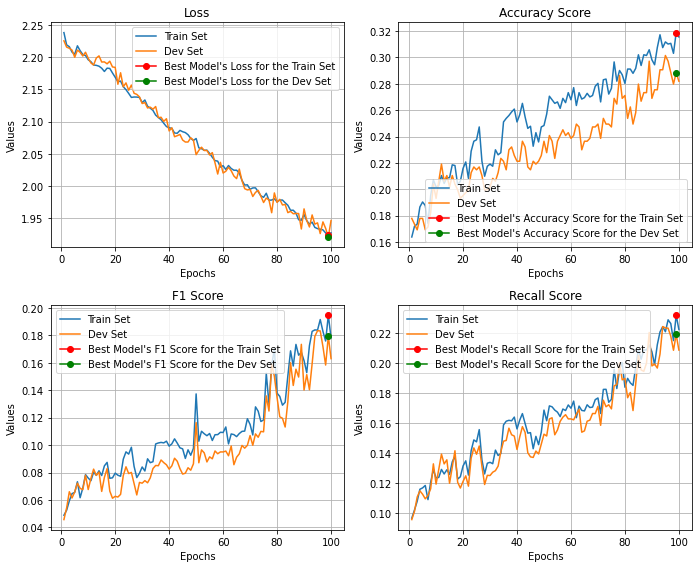

In [ ]:
EarlyLSTMNet = LSTM(input_dim=mels_feats,
                    rnn_size=HIDDEN_LAYER,
                    output_dim=OUTPUT_SIZE,
                    num_layers=NUM_LAYERS,
                    dropout=dropout,
                    pack_padded_sequence=pack_padded_sequence).to(device)

# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(EarlyLSTMNet.parameters(), lr=ETA, weight_decay=weight_decay)

# Start the training process
clf_main(device, EarlyLSTMNet, mels_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, net_name='EarlyLSTM_nonbeatMEL', PATIENCE=PATIENCE)

In [ ]:
with open('./best_EarlyLSTM_nonbeatMEL.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
test_loss, y_test_gold, y_test_pred = clf_eval(device, test_loader, mels_feats, E_model, criterion)

print(classification_report(y_test_gold, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.50      0.30      0.37        40
           2       0.25      0.68      0.37        80
           3       0.32      0.53      0.39        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.36      0.21      0.26        78
           7       0.00      0.00      0.00        40
           8       0.31      0.48      0.37       103
           9       0.00      0.00      0.00        34

    accuracy                           0.30       575
   macro avg       0.17      0.22      0.18       575
weighted avg       0.22      0.30      0.23       575



#### Chromagrams Dataset

In [ ]:
data = SpectrogramDataset("data/fma_genre_spectrograms",
                                  class_mapping=class_mapping, train=True, read_spec_fn=read_chromagram)
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/fma_genre_spectrograms/',
                                              class_mapping=class_mapping, train=False, read_spec_fn=read_chromagram, max_length=data.max_length)

##### Normal Training

  0%|          | 0/100 [00:00<?, ?it/s]

 [================================--------] ...Epoch 1, Loss: 2.3485
Statistics for the Train Set
	 Epoch: 1 	 loss: 2.2913625815819048
	 Epoch: 1 	 Accuracy Score: 0.14154013015184383
	 Epoch: 1 	 f1 Score: 0.04439706883397521
	 Epoch: 1 	 recall Score: 0.1054518833687899


  1%|          | 1/100 [00:04<08:07,  4.93s/it]

Statistics for the Dev Set
	 Epoch: 1 	 loss: 2.2825478076934815
	 Epoch: 1 	 Accuracy Score: 0.14099783080260303
	 Epoch: 1 	 f1 Score: 0.04146797568957457
	 Epoch: 1 	 recall Score: 0.09855889724310776
Test loss decreased (inf --> 2.282548).  Saving model ...
Epoch total time 4.928791284561157
 [================================--------] ...Epoch 2, Loss: 2.2534
Statistics for the Train Set
	 Epoch: 2 	 loss: 2.2715495578173934
	 Epoch: 2 	 Accuracy Score: 0.13828633405639915
	 Epoch: 2 	 f1 Score: 0.03295998536440689
	 Epoch: 2 	 recall Score: 0.10191266417409643


  2%|▏         | 2/100 [00:09<08:01,  4.91s/it]

Statistics for the Dev Set
	 Epoch: 2 	 loss: 2.262762673695882
	 Epoch: 2 	 Accuracy Score: 0.14099783080260303
	 Epoch: 2 	 f1 Score: 0.03390030711079613
	 Epoch: 2 	 recall Score: 0.10181704260651629
Test loss decreased (2.282548 --> 2.262763).  Saving model ...
Epoch total time 4.896049976348877
 [================================--------] ...Epoch 3, Loss: 2.1534
Statistics for the Train Set
	 Epoch: 3 	 loss: 2.250157121954293
	 Epoch: 3 	 Accuracy Score: 0.14913232104121474
	 Epoch: 3 	 f1 Score: 0.04578823804442923
	 Epoch: 3 	 recall Score: 0.09086645575687854


  3%|▎         | 3/100 [00:14<07:56,  4.91s/it]

Statistics for the Dev Set
	 Epoch: 3 	 loss: 2.24338804880778
	 Epoch: 3 	 Accuracy Score: 0.14967462039045554
	 Epoch: 3 	 f1 Score: 0.04622038995708444
	 Epoch: 3 	 recall Score: 0.1010437051532942
Test loss decreased (2.262763 --> 2.243388).  Saving model ...
Epoch total time 4.916893243789673
 [================================--------] ...Epoch 4, Loss: 2.0505
Statistics for the Train Set
	 Epoch: 4 	 loss: 2.2253085498152108
	 Epoch: 4 	 Accuracy Score: 0.18112798264642083
	 Epoch: 4 	 f1 Score: 0.03366372104131837
	 Epoch: 4 	 recall Score: 0.09809122807017544


  4%|▍         | 4/100 [00:19<07:51,  4.92s/it]

Statistics for the Dev Set
	 Epoch: 4 	 loss: 2.218283780415853
	 Epoch: 4 	 Accuracy Score: 0.1561822125813449
	 Epoch: 4 	 f1 Score: 0.02774566473988439
	 Epoch: 4 	 recall Score: 0.09863013698630137
Test loss decreased (2.243388 --> 2.218284).  Saving model ...
Epoch total time 4.913275718688965
 [================================--------] ...Epoch 5, Loss: 2.2178
Statistics for the Train Set
	 Epoch: 5 	 loss: 2.2184206411756318
	 Epoch: 5 	 Accuracy Score: 0.18492407809110628
	 Epoch: 5 	 f1 Score: 0.0313275149288011
	 Epoch: 5 	 recall Score: 0.09970760233918129


  5%|▌         | 5/100 [00:24<07:45,  4.90s/it]

Statistics for the Dev Set
	 Epoch: 5 	 loss: 2.2270333766937256
	 Epoch: 5 	 Accuracy Score: 0.1561822125813449
	 Epoch: 5 	 f1 Score: 0.027118644067796616
	 Epoch: 5 	 recall Score: 0.09863013698630137
EarlyStopping counter: 1 out of 10
Epoch total time 4.884953498840332
 [================================--------] ...Epoch 6, Loss: 2.2263
Statistics for the Train Set
	 Epoch: 6 	 loss: 2.2154036554796943
	 Epoch: 6 	 Accuracy Score: 0.18492407809110628
	 Epoch: 6 	 f1 Score: 0.031284403669724764
	 Epoch: 6 	 recall Score: 0.09970760233918129


  6%|▌         | 6/100 [00:29<07:39,  4.89s/it]

Statistics for the Dev Set
	 Epoch: 6 	 loss: 2.2263940652211507
	 Epoch: 6 	 Accuracy Score: 0.1561822125813449
	 Epoch: 6 	 f1 Score: 0.02706766917293233
	 Epoch: 6 	 recall Score: 0.09863013698630137
EarlyStopping counter: 2 out of 10
Epoch total time 4.85721755027771
 [================================--------] ...Epoch 7, Loss: 2.2067
Statistics for the Train Set
	 Epoch: 7 	 loss: 2.2140941784299653
	 Epoch: 7 	 Accuracy Score: 0.18492407809110628
	 Epoch: 7 	 f1 Score: 0.03127005960568546
	 Epoch: 7 	 recall Score: 0.09970760233918129


  7%|▋         | 7/100 [00:34<07:34,  4.89s/it]

Statistics for the Dev Set
	 Epoch: 7 	 loss: 2.2201910813649497
	 Epoch: 7 	 Accuracy Score: 0.1561822125813449
	 Epoch: 7 	 f1 Score: 0.02706766917293233
	 Epoch: 7 	 recall Score: 0.09863013698630137
EarlyStopping counter: 3 out of 10
Epoch total time 4.896137237548828
 [================================--------] ...Epoch 8, Loss: 2.3050
Statistics for the Train Set
	 Epoch: 8 	 loss: 2.212927325018521
	 Epoch: 8 	 Accuracy Score: 0.18492407809110628
	 Epoch: 8 	 f1 Score: 0.031241410902427852
	 Epoch: 8 	 recall Score: 0.09970760233918129


  8%|▊         | 8/100 [00:39<07:28,  4.88s/it]

Statistics for the Dev Set
	 Epoch: 8 	 loss: 2.2207497119903565
	 Epoch: 8 	 Accuracy Score: 0.1561822125813449
	 Epoch: 8 	 f1 Score: 0.02706766917293233
	 Epoch: 8 	 recall Score: 0.09863013698630137
EarlyStopping counter: 4 out of 10
Epoch total time 4.848072052001953
 [================================--------] ...Epoch 9, Loss: 2.1641
Statistics for the Train Set
	 Epoch: 9 	 loss: 2.211960488352282
	 Epoch: 9 	 Accuracy Score: 0.18492407809110628
	 Epoch: 9 	 f1 Score: 0.031227106227106227
	 Epoch: 9 	 recall Score: 0.09970760233918129


  9%|▉         | 9/100 [00:44<07:23,  4.87s/it]

Statistics for the Dev Set
	 Epoch: 9 	 loss: 2.219067668914795
	 Epoch: 9 	 Accuracy Score: 0.15835140997830802
	 Epoch: 9 	 f1 Score: 0.027392120075046898
	 Epoch: 9 	 recall Score: 0.1
EarlyStopping counter: 5 out of 10
Epoch total time 4.856445550918579
 [================================--------] ...Epoch 10, Loss: 2.1670
Statistics for the Train Set
	 Epoch: 10 	 loss: 2.2099859714508057
	 Epoch: 10 	 Accuracy Score: 0.18546637744034708
	 Epoch: 10 	 f1 Score: 0.03130434782608696
	 Epoch: 10 	 recall Score: 0.1


 10%|█         | 10/100 [00:48<07:17,  4.87s/it]

Statistics for the Dev Set
	 Epoch: 10 	 loss: 2.220656903584798
	 Epoch: 10 	 Accuracy Score: 0.15835140997830802
	 Epoch: 10 	 f1 Score: 0.027392120075046898
	 Epoch: 10 	 recall Score: 0.1
EarlyStopping counter: 6 out of 10
Epoch total time 4.848833084106445
 [================================--------] ...Epoch 11, Loss: 2.2282
Statistics for the Train Set
	 Epoch: 11 	 loss: 2.206615213690133
	 Epoch: 11 	 Accuracy Score: 0.18546637744034708
	 Epoch: 11 	 f1 Score: 0.03130434782608696
	 Epoch: 11 	 recall Score: 0.1


 11%|█         | 11/100 [00:53<07:13,  4.87s/it]

Statistics for the Dev Set
	 Epoch: 11 	 loss: 2.2205736955006916
	 Epoch: 11 	 Accuracy Score: 0.15835140997830802
	 Epoch: 11 	 f1 Score: 0.027392120075046898
	 Epoch: 11 	 recall Score: 0.1
EarlyStopping counter: 7 out of 10
Epoch total time 4.872708797454834
 [================================--------] ...Epoch 12, Loss: 2.2952
Statistics for the Train Set
	 Epoch: 12 	 loss: 2.204017968013369
	 Epoch: 12 	 Accuracy Score: 0.18546637744034708
	 Epoch: 12 	 f1 Score: 0.03130434782608696
	 Epoch: 12 	 recall Score: 0.1


 12%|█▏        | 12/100 [00:58<07:07,  4.86s/it]

Statistics for the Dev Set
	 Epoch: 12 	 loss: 2.207402054468791
	 Epoch: 12 	 Accuracy Score: 0.1561822125813449
	 Epoch: 12 	 f1 Score: 0.02706766917293233
	 Epoch: 12 	 recall Score: 0.09863013698630137
Test loss decreased (2.218284 --> 2.207402).  Saving model ...
Epoch total time 4.840925931930542
 [================================--------] ...Epoch 13, Loss: 2.1425
Statistics for the Train Set
	 Epoch: 13 	 loss: 2.198961444969835
	 Epoch: 13 	 Accuracy Score: 0.18600867678958785
	 Epoch: 13 	 f1 Score: 0.03218735887107833
	 Epoch: 13 	 recall Score: 0.10040983606557377


 13%|█▎        | 13/100 [01:03<07:01,  4.85s/it]

Statistics for the Dev Set
	 Epoch: 13 	 loss: 2.208695411682129
	 Epoch: 13 	 Accuracy Score: 0.1561822125813449
	 Epoch: 13 	 f1 Score: 0.027118644067796616
	 Epoch: 13 	 recall Score: 0.09863013698630137
EarlyStopping counter: 1 out of 10
Epoch total time 4.818952798843384
 [================================--------] ...Epoch 14, Loss: 2.2321
Statistics for the Train Set
	 Epoch: 14 	 loss: 2.18778893043255
	 Epoch: 14 	 Accuracy Score: 0.19088937093275488
	 Epoch: 14 	 f1 Score: 0.04714642232561474
	 Epoch: 14 	 recall Score: 0.10567364586329211


 14%|█▍        | 14/100 [01:08<06:58,  4.86s/it]

Statistics for the Dev Set
	 Epoch: 14 	 loss: 2.2027919133504232
	 Epoch: 14 	 Accuracy Score: 0.1735357917570499
	 Epoch: 14 	 f1 Score: 0.05551698469203499
	 Epoch: 14 	 recall Score: 0.110840743411039
Test loss decreased (2.207402 --> 2.202792).  Saving model ...
Epoch total time 4.883211374282837
 [================================--------] ...Epoch 15, Loss: 2.3495
Statistics for the Train Set
	 Epoch: 15 	 loss: 2.2220629618085663
	 Epoch: 15 	 Accuracy Score: 0.17462039045553146
	 Epoch: 15 	 f1 Score: 0.05103594017632709
	 Epoch: 15 	 recall Score: 0.10530869523535616


 15%|█▌        | 15/100 [01:13<06:53,  4.87s/it]

Statistics for the Dev Set
	 Epoch: 15 	 loss: 2.2218538761138915
	 Epoch: 15 	 Accuracy Score: 0.17136659436008678
	 Epoch: 15 	 f1 Score: 0.049702380952380956
	 Epoch: 15 	 recall Score: 0.10697548666186012
EarlyStopping counter: 1 out of 10
Epoch total time 4.875057935714722
 [================================--------] ...Epoch 16, Loss: 2.1118
Statistics for the Train Set
	 Epoch: 16 	 loss: 2.185223303992173
	 Epoch: 16 	 Accuracy Score: 0.19197396963123645
	 Epoch: 16 	 f1 Score: 0.06131286680933713
	 Epoch: 16 	 recall Score: 0.10979024062889464


 16%|█▌        | 16/100 [01:18<06:49,  4.87s/it]

Statistics for the Dev Set
	 Epoch: 16 	 loss: 2.200415817896525
	 Epoch: 16 	 Accuracy Score: 0.16919739696312364
	 Epoch: 16 	 f1 Score: 0.061470149631596915
	 Epoch: 16 	 recall Score: 0.10859111248440736
Test loss decreased (2.202792 --> 2.200416).  Saving model ...
Epoch total time 4.879439353942871
 [================================--------] ...Epoch 17, Loss: 2.4625
Statistics for the Train Set
	 Epoch: 17 	 loss: 2.1837736162646064
	 Epoch: 17 	 Accuracy Score: 0.1963123644251627
	 Epoch: 17 	 f1 Score: 0.06765773900834622
	 Epoch: 17 	 recall Score: 0.11469220592464768


 17%|█▋        | 17/100 [01:22<06:43,  4.87s/it]

Statistics for the Dev Set
	 Epoch: 17 	 loss: 2.2141830285390216
	 Epoch: 17 	 Accuracy Score: 0.17136659436008678
	 Epoch: 17 	 f1 Score: 0.06262890630456952
	 Epoch: 17 	 recall Score: 0.11061329121891486
EarlyStopping counter: 1 out of 10
Epoch total time 4.852094888687134
 [================================--------] ...Epoch 18, Loss: 2.1591
Statistics for the Train Set
	 Epoch: 18 	 loss: 2.1767356971214555
	 Epoch: 18 	 Accuracy Score: 0.1903470715835141
	 Epoch: 18 	 f1 Score: 0.060981447019132086
	 Epoch: 18 	 recall Score: 0.11093960310612597


 18%|█▊        | 18/100 [01:27<06:38,  4.86s/it]

Statistics for the Dev Set
	 Epoch: 18 	 loss: 2.1910084088643393
	 Epoch: 18 	 Accuracy Score: 0.1822125813449024
	 Epoch: 18 	 f1 Score: 0.06609417991756633
	 Epoch: 18 	 recall Score: 0.1159968986392923
Test loss decreased (2.200416 --> 2.191008).  Saving model ...
Epoch total time 4.834663391113281
 [================================--------] ...Epoch 19, Loss: 2.1783
Statistics for the Train Set
	 Epoch: 19 	 loss: 2.1791542953458327
	 Epoch: 19 	 Accuracy Score: 0.19143167028199568
	 Epoch: 19 	 f1 Score: 0.06939792053872998
	 Epoch: 19 	 recall Score: 0.11327435528712493


 19%|█▉        | 19/100 [01:32<06:33,  4.86s/it]

Statistics for the Dev Set
	 Epoch: 19 	 loss: 2.197612460454305
	 Epoch: 19 	 Accuracy Score: 0.16919739696312364
	 Epoch: 19 	 f1 Score: 0.06276868102537285
	 Epoch: 19 	 recall Score: 0.1091352811251874
EarlyStopping counter: 1 out of 10
Epoch total time 4.87031364440918
 [================================--------] ...Epoch 20, Loss: 2.0686
Statistics for the Train Set
	 Epoch: 20 	 loss: 2.1743412367228805
	 Epoch: 20 	 Accuracy Score: 0.18926247288503253
	 Epoch: 20 	 f1 Score: 0.06696488758811348
	 Epoch: 20 	 recall Score: 0.11219388361614417


 20%|██        | 20/100 [01:37<06:29,  4.87s/it]

Statistics for the Dev Set
	 Epoch: 20 	 loss: 2.2045244057973226
	 Epoch: 20 	 Accuracy Score: 0.18004338394793926
	 Epoch: 20 	 f1 Score: 0.06630301336686692
	 Epoch: 20 	 recall Score: 0.11511598631281399
EarlyStopping counter: 2 out of 10
Epoch total time 4.8954176902771
 [================================--------] ...Epoch 21, Loss: 2.2510
Statistics for the Train Set
	 Epoch: 21 	 loss: 2.185770468465213
	 Epoch: 21 	 Accuracy Score: 0.18926247288503253
	 Epoch: 21 	 f1 Score: 0.06850273040236461
	 Epoch: 21 	 recall Score: 0.11979846611063176


 21%|██        | 21/100 [01:42<06:26,  4.89s/it]

Statistics for the Dev Set
	 Epoch: 21 	 loss: 2.1976686000823973
	 Epoch: 21 	 Accuracy Score: 0.19088937093275488
	 Epoch: 21 	 f1 Score: 0.07413858364026546
	 Epoch: 21 	 recall Score: 0.12088268616747348
EarlyStopping counter: 3 out of 10
Epoch total time 4.9322285652160645
 [================================--------] ...Epoch 22, Loss: 2.2074
Statistics for the Train Set
	 Epoch: 22 	 loss: 2.1786618643793565
	 Epoch: 22 	 Accuracy Score: 0.18817787418655096
	 Epoch: 22 	 f1 Score: 0.07370837188487527
	 Epoch: 22 	 recall Score: 0.12001071805196051


 22%|██▏       | 22/100 [01:47<06:20,  4.88s/it]

Statistics for the Dev Set
	 Epoch: 22 	 loss: 2.208996319770813
	 Epoch: 22 	 Accuracy Score: 0.1735357917570499
	 Epoch: 22 	 f1 Score: 0.068396371535385
	 Epoch: 22 	 recall Score: 0.11671272931186413
EarlyStopping counter: 4 out of 10
Epoch total time 4.850617170333862
 [================================--------] ...Epoch 23, Loss: 2.1069
Statistics for the Train Set
	 Epoch: 23 	 loss: 2.1707803195920485
	 Epoch: 23 	 Accuracy Score: 0.1936008676789588
	 Epoch: 23 	 f1 Score: 0.08035228619951837
	 Epoch: 23 	 recall Score: 0.1239436487393347


 23%|██▎       | 23/100 [01:52<06:15,  4.87s/it]

Statistics for the Dev Set
	 Epoch: 23 	 loss: 2.195875803629557
	 Epoch: 23 	 Accuracy Score: 0.18872017353579176
	 Epoch: 23 	 f1 Score: 0.07781850627393405
	 Epoch: 23 	 recall Score: 0.12461862418603586
EarlyStopping counter: 5 out of 10
Epoch total time 4.848379850387573
 [================================--------] ...Epoch 24, Loss: 2.1519
Statistics for the Train Set
	 Epoch: 24 	 loss: 2.2134231452284188
	 Epoch: 24 	 Accuracy Score: 0.1822125813449024
	 Epoch: 24 	 f1 Score: 0.06387069437902966
	 Epoch: 24 	 recall Score: 0.11735797143131052


 24%|██▍       | 24/100 [01:57<06:09,  4.87s/it]

Statistics for the Dev Set
	 Epoch: 24 	 loss: 2.227165142695109
	 Epoch: 24 	 Accuracy Score: 0.18872017353579176
	 Epoch: 24 	 f1 Score: 0.06594782898128226
	 Epoch: 24 	 recall Score: 0.11772267426557259
EarlyStopping counter: 6 out of 10
Epoch total time 4.852301597595215
 [================================--------] ...Epoch 25, Loss: 2.1732
Statistics for the Train Set
	 Epoch: 25 	 loss: 2.1687783763326447
	 Epoch: 25 	 Accuracy Score: 0.1957700650759219
	 Epoch: 25 	 f1 Score: 0.08059310661257382
	 Epoch: 25 	 recall Score: 0.12569000095868085


 25%|██▌       | 25/100 [02:01<06:04,  4.86s/it]

Statistics for the Dev Set
	 Epoch: 25 	 loss: 2.192282772064209
	 Epoch: 25 	 Accuracy Score: 0.18655097613882862
	 Epoch: 25 	 f1 Score: 0.07784915213628815
	 Epoch: 25 	 recall Score: 0.12390107689314611
EarlyStopping counter: 7 out of 10
Epoch total time 4.844323396682739
 [================================--------] ...Epoch 26, Loss: 2.1499
Statistics for the Train Set
	 Epoch: 26 	 loss: 2.170203852242437
	 Epoch: 26 	 Accuracy Score: 0.20281995661605207
	 Epoch: 26 	 f1 Score: 0.08445597581714417
	 Epoch: 26 	 recall Score: 0.12993201035375326


 26%|██▌       | 26/100 [02:06<05:59,  4.86s/it]

Statistics for the Dev Set
	 Epoch: 26 	 loss: 2.177184780438741
	 Epoch: 26 	 Accuracy Score: 0.18655097613882862
	 Epoch: 26 	 f1 Score: 0.07931756590293176
	 Epoch: 26 	 recall Score: 0.12384700335313167
Test loss decreased (2.191008 --> 2.177185).  Saving model ...
Epoch total time 4.847078561782837
 [================================--------] ...Epoch 27, Loss: 2.2041
Statistics for the Train Set
	 Epoch: 27 	 loss: 2.168673819509046
	 Epoch: 27 	 Accuracy Score: 0.1957700650759219
	 Epoch: 27 	 f1 Score: 0.07997689721352057
	 Epoch: 27 	 recall Score: 0.12533768574441567


 27%|██▋       | 27/100 [02:11<05:54,  4.85s/it]

Statistics for the Dev Set
	 Epoch: 27 	 loss: 2.193978532155355
	 Epoch: 27 	 Accuracy Score: 0.19088937093275488
	 Epoch: 27 	 f1 Score: 0.07904487075820059
	 Epoch: 27 	 recall Score: 0.1271297536077637
EarlyStopping counter: 1 out of 10
Epoch total time 4.849024772644043
 [================================--------] ...Epoch 28, Loss: 2.2071
Statistics for the Train Set
	 Epoch: 28 	 loss: 2.243400475074505
	 Epoch: 28 	 Accuracy Score: 0.14587852494577006
	 Epoch: 28 	 f1 Score: 0.038834994588132665
	 Epoch: 28 	 recall Score: 0.1057832422586521


 28%|██▊       | 28/100 [02:16<05:50,  4.87s/it]

Statistics for the Dev Set
	 Epoch: 28 	 loss: 2.242767063776652
	 Epoch: 28 	 Accuracy Score: 0.16919739696312364
	 Epoch: 28 	 f1 Score: 0.04118735007050119
	 Epoch: 28 	 recall Score: 0.10301009372746936
EarlyStopping counter: 2 out of 10
Epoch total time 4.915505886077881
 [================================--------] ...Epoch 29, Loss: 2.1278
Statistics for the Train Set
	 Epoch: 29 	 loss: 2.2305531666196625
	 Epoch: 29 	 Accuracy Score: 0.17516268980477223
	 Epoch: 29 	 f1 Score: 0.05151254313630824
	 Epoch: 29 	 recall Score: 0.10665803853897038


 29%|██▉       | 29/100 [02:21<05:45,  4.87s/it]

Statistics for the Dev Set
	 Epoch: 29 	 loss: 2.2347871462504068
	 Epoch: 29 	 Accuracy Score: 0.175704989154013
	 Epoch: 29 	 f1 Score: 0.051639344262295085
	 Epoch: 29 	 recall Score: 0.10949891852919971
EarlyStopping counter: 3 out of 10
Epoch total time 4.855726480484009
 [================================--------] ...Epoch 30, Loss: 2.2097
Statistics for the Train Set
	 Epoch: 30 	 loss: 2.220831242100946
	 Epoch: 30 	 Accuracy Score: 0.1876355748373102
	 Epoch: 30 	 f1 Score: 0.04645728643216081
	 Epoch: 30 	 recall Score: 0.10504505800019175


 30%|███       | 30/100 [02:26<05:40,  4.87s/it]

Statistics for the Dev Set
	 Epoch: 30 	 loss: 2.2229464848836265
	 Epoch: 30 	 Accuracy Score: 0.1648590021691974
	 Epoch: 30 	 f1 Score: 0.04381546398346846
	 Epoch: 30 	 recall Score: 0.10389443929458349
EarlyStopping counter: 4 out of 10
Epoch total time 4.868987083435059
 [================================--------] ...Epoch 31, Loss: 2.1561
Statistics for the Train Set
	 Epoch: 31 	 loss: 2.2000818992483206
	 Epoch: 31 	 Accuracy Score: 0.1957700650759219
	 Epoch: 31 	 f1 Score: 0.05292778114760897
	 Epoch: 31 	 recall Score: 0.10919495733870195


 31%|███       | 31/100 [02:31<05:35,  4.86s/it]

Statistics for the Dev Set
	 Epoch: 31 	 loss: 2.215787474314372
	 Epoch: 31 	 Accuracy Score: 0.1540130151843818
	 Epoch: 31 	 f1 Score: 0.04182996298525181
	 Epoch: 31 	 recall Score: 0.09823931976058868
EarlyStopping counter: 5 out of 10
Epoch total time 4.840196371078491
 [================================--------] ...Epoch 32, Loss: 2.1772
Statistics for the Train Set
	 Epoch: 32 	 loss: 2.1836662703546983
	 Epoch: 32 	 Accuracy Score: 0.19902386117136658
	 Epoch: 32 	 f1 Score: 0.06162459909968217
	 Epoch: 32 	 recall Score: 0.11496937973348671


 32%|███▏      | 32/100 [02:35<05:30,  4.87s/it]

Statistics for the Dev Set
	 Epoch: 32 	 loss: 2.203657531738281
	 Epoch: 32 	 Accuracy Score: 0.1822125813449024
	 Epoch: 32 	 f1 Score: 0.06252395008026514
	 Epoch: 32 	 recall Score: 0.11936319108272966
EarlyStopping counter: 6 out of 10
Epoch total time 4.872798681259155
 [================================--------] ...Epoch 33, Loss: 2.1055
Statistics for the Train Set
	 Epoch: 33 	 loss: 2.181122537316947
	 Epoch: 33 	 Accuracy Score: 0.19902386117136658
	 Epoch: 33 	 f1 Score: 0.06295778521506909
	 Epoch: 33 	 recall Score: 0.11540962515578564


 33%|███▎      | 33/100 [02:40<05:25,  4.86s/it]

Statistics for the Dev Set
	 Epoch: 33 	 loss: 2.1933696269989014
	 Epoch: 33 	 Accuracy Score: 0.17787418655097614
	 Epoch: 33 	 f1 Score: 0.061027725661872
	 Epoch: 33 	 recall Score: 0.11662346505533239
EarlyStopping counter: 7 out of 10
Epoch total time 4.855419158935547
 [================================--------] ...Epoch 34, Loss: 2.0826
Statistics for the Train Set
	 Epoch: 34 	 loss: 2.1791617952544113
	 Epoch: 34 	 Accuracy Score: 0.19793926247288504
	 Epoch: 34 	 f1 Score: 0.06306972050588518
	 Epoch: 34 	 recall Score: 0.11536284153005465


 34%|███▍      | 34/100 [02:45<05:21,  4.88s/it]

Statistics for the Dev Set
	 Epoch: 34 	 loss: 2.1942011515299478
	 Epoch: 34 	 Accuracy Score: 0.18655097613882862
	 Epoch: 34 	 f1 Score: 0.06560198489472449
	 Epoch: 34 	 recall Score: 0.12297267140453874
EarlyStopping counter: 8 out of 10
Epoch total time 4.909838914871216
 [================================--------] ...Epoch 35, Loss: 2.2399
Statistics for the Train Set
	 Epoch: 35 	 loss: 2.1755298355530046
	 Epoch: 35 	 Accuracy Score: 0.1957700650759219
	 Epoch: 35 	 f1 Score: 0.06375290311204809
	 Epoch: 35 	 recall Score: 0.11666810468794939


 35%|███▌      | 35/100 [02:50<05:16,  4.87s/it]

Statistics for the Dev Set
	 Epoch: 35 	 loss: 2.198246955871582
	 Epoch: 35 	 Accuracy Score: 0.175704989154013
	 Epoch: 35 	 f1 Score: 0.061249349867236035
	 Epoch: 35 	 recall Score: 0.1169931106304574
EarlyStopping counter: 9 out of 10
Epoch total time 4.853635787963867
 [================================--------] ...Epoch 36, Loss: 2.3876
Statistics for the Train Set
	 Epoch: 36 	 loss: 2.172386742871383
	 Epoch: 36 	 Accuracy Score: 0.1963123644251627
	 Epoch: 36 	 f1 Score: 0.065997425997426
	 Epoch: 36 	 recall Score: 0.1177432269197584


 35%|███▌      | 35/100 [02:55<05:25,  5.01s/it]

Statistics for the Dev Set
	 Epoch: 36 	 loss: 2.1893827597300213
	 Epoch: 36 	 Accuracy Score: 0.18004338394793926
	 Epoch: 36 	 f1 Score: 0.06720402724616208
	 Epoch: 36 	 recall Score: 0.12027700529863469
EarlyStopping counter: 10 out of 10
Training total time 170.46551728248596


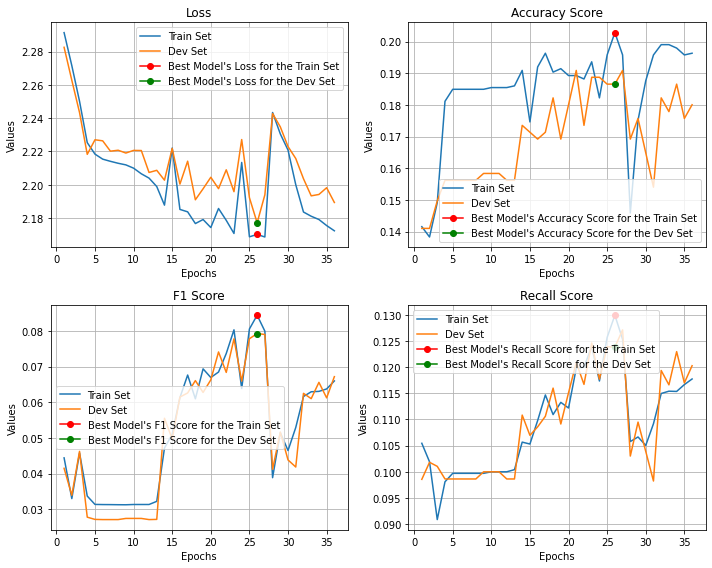

In [ ]:
EarlyLSTMNet = LSTM(input_dim=chroma_feats,
                    rnn_size=HIDDEN_LAYER,
                    output_dim=OUTPUT_SIZE,
                    num_layers=NUM_LAYERS,
                    dropout=dropout,
                    pack_padded_sequence=pack_padded_sequence).to(device)

# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(EarlyLSTMNet.parameters(), lr=ETA, weight_decay=weight_decay)

# Start the training process
clf_main(device, EarlyLSTMNet, chroma_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, net_name='EarlyLSTM_nonbeatCHROMA', PATIENCE=PATIENCE)

In [ ]:
with open('./best_EarlyLSTM_nonbeatCHROMA.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
test_loss, y_test_gold, y_test_pred = clf_eval(device, test_loader, chroma_feats, E_model, criterion)

print(classification_report(y_test_gold, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00        80
           3       0.18      0.26      0.21        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.25      0.42      0.32        78
           7       0.00      0.00      0.00        40
           8       0.19      0.59      0.28       103
           9       0.00      0.00      0.00        34

    accuracy                           0.20       575
   macro avg       0.06      0.13      0.08       575
weighted avg       0.09      0.20      0.12       575



#### Mel Spectrograms + Chromagrams Dataset

In [ ]:
data = SpectrogramDataset("data/fma_genre_spectrograms",
                                class_mapping=class_mapping, train=True, read_spec_fn=read_fused_spectrogram)
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/fma_genre_spectrograms/',
                                            class_mapping=class_mapping, train=False, read_spec_fn=read_fused_spectrogram, max_length=data.max_length)

##### Normal Training

  0%|          | 0/100 [00:00<?, ?it/s]

 [================================--------] ...Epoch 1, Loss: 2.3308
Statistics for the Train Set
	 Epoch: 1 	 loss: 2.2715312612467797
	 Epoch: 1 	 Accuracy Score: 0.17787418655097614
	 Epoch: 1 	 f1 Score: 0.039976649695460456
	 Epoch: 1 	 recall Score: 0.10054701061367274


  1%|          | 1/100 [00:10<17:53, 10.85s/it]

Statistics for the Dev Set
	 Epoch: 1 	 loss: 2.2713433424631755
	 Epoch: 1 	 Accuracy Score: 0.175704989154013
	 Epoch: 1 	 f1 Score: 0.04259610630052553
	 Epoch: 1 	 recall Score: 0.10087006133219227
Test loss decreased (inf --> 2.271343).  Saving model ...
Epoch total time 10.846370935440063
 [================================--------] ...Epoch 2, Loss: 2.3154
Statistics for the Train Set
	 Epoch: 2 	 loss: 2.2461546001763177
	 Epoch: 2 	 Accuracy Score: 0.1816702819956616
	 Epoch: 2 	 f1 Score: 0.03761423509420543
	 Epoch: 2 	 recall Score: 0.1017569911345845


  2%|▏         | 2/100 [00:21<17:39, 10.81s/it]

Statistics for the Dev Set
	 Epoch: 2 	 loss: 2.2432371775309243
	 Epoch: 2 	 Accuracy Score: 0.1735357917570499
	 Epoch: 2 	 f1 Score: 0.03262278410337195
	 Epoch: 2 	 recall Score: 0.09773035230352303
Test loss decreased (2.271343 --> 2.243237).  Saving model ...
Epoch total time 10.781139135360718
 [================================--------] ...Epoch 3, Loss: 2.2565
Statistics for the Train Set
	 Epoch: 3 	 loss: 2.231285917347875
	 Epoch: 3 	 Accuracy Score: 0.18058568329718006
	 Epoch: 3 	 f1 Score: 0.03228323498785144
	 Epoch: 3 	 recall Score: 0.10022927491807161


  3%|▎         | 3/100 [00:32<17:24, 10.77s/it]

Statistics for the Dev Set
	 Epoch: 3 	 loss: 2.2261523087819417
	 Epoch: 3 	 Accuracy Score: 0.175704989154013
	 Epoch: 3 	 f1 Score: 0.03011152416356877
	 Epoch: 3 	 recall Score: 0.09878048780487805
Test loss decreased (2.243237 --> 2.226152).  Saving model ...
Epoch total time 10.729189395904541
 [================================--------] ...Epoch 4, Loss: 2.2160
Statistics for the Train Set
	 Epoch: 4 	 loss: 2.2235671980627654
	 Epoch: 4 	 Accuracy Score: 0.18058568329718006
	 Epoch: 4 	 f1 Score: 0.03226772388263071
	 Epoch: 4 	 recall Score: 0.10021116255556091


  4%|▍         | 4/100 [00:43<17:11, 10.74s/it]

Statistics for the Dev Set
	 Epoch: 4 	 loss: 2.2187721729278564
	 Epoch: 4 	 Accuracy Score: 0.1735357917570499
	 Epoch: 4 	 f1 Score: 0.029795158286778402
	 Epoch: 4 	 recall Score: 0.0975609756097561
Test loss decreased (2.226152 --> 2.218772).  Saving model ...
Epoch total time 10.691895008087158
 [================================--------] ...Epoch 5, Loss: 2.1692
Statistics for the Train Set
	 Epoch: 5 	 loss: 2.2167969942092896
	 Epoch: 5 	 Accuracy Score: 0.18058568329718006
	 Epoch: 5 	 f1 Score: 0.032208793316076456
	 Epoch: 5 	 recall Score: 0.10021116255556091


  5%|▌         | 5/100 [00:53<16:58, 10.72s/it]

Statistics for the Dev Set
	 Epoch: 5 	 loss: 2.22228946685791
	 Epoch: 5 	 Accuracy Score: 0.175704989154013
	 Epoch: 5 	 f1 Score: 0.029944547134935308
	 Epoch: 5 	 recall Score: 0.09878048780487805
EarlyStopping counter: 1 out of 10
Epoch total time 10.692039251327515
 [================================--------] ...Epoch 6, Loss: 2.0575
Statistics for the Train Set
	 Epoch: 6 	 loss: 2.213230383807215
	 Epoch: 6 	 Accuracy Score: 0.18112798264642083
	 Epoch: 6 	 f1 Score: 0.03305075042559869
	 Epoch: 6 	 recall Score: 0.10062610031489701


  6%|▌         | 6/100 [01:04<16:49, 10.74s/it]

Statistics for the Dev Set
	 Epoch: 6 	 loss: 2.2121338685353598
	 Epoch: 6 	 Accuracy Score: 0.17787418655097614
	 Epoch: 6 	 f1 Score: 0.03344968704862783
	 Epoch: 6 	 recall Score: 0.10041983206717313
Test loss decreased (2.218772 --> 2.212134).  Saving model ...
Epoch total time 10.759934186935425
 [================================--------] ...Epoch 7, Loss: 2.2123
Statistics for the Train Set
	 Epoch: 7 	 loss: 2.2063256748791398
	 Epoch: 7 	 Accuracy Score: 0.18058568329718006
	 Epoch: 7 	 f1 Score: 0.03208377403520191
	 Epoch: 7 	 recall Score: 0.10044044044044043


  7%|▋         | 7/100 [01:15<16:35, 10.70s/it]

Statistics for the Dev Set
	 Epoch: 7 	 loss: 2.201420720418294
	 Epoch: 7 	 Accuracy Score: 0.175704989154013
	 Epoch: 7 	 f1 Score: 0.029944547134935308
	 Epoch: 7 	 recall Score: 0.09878048780487805
Test loss decreased (2.212134 --> 2.201421).  Saving model ...
Epoch total time 10.631451606750488
 [================================--------] ...Epoch 8, Loss: 2.1928
Statistics for the Train Set
	 Epoch: 8 	 loss: 2.2024194659857916
	 Epoch: 8 	 Accuracy Score: 0.18275488069414317
	 Epoch: 8 	 f1 Score: 0.04731493246076639
	 Epoch: 8 	 recall Score: 0.10422565422565422


  8%|▊         | 8/100 [01:25<16:23, 10.69s/it]

Statistics for the Dev Set
	 Epoch: 8 	 loss: 2.2013218879699705
	 Epoch: 8 	 Accuracy Score: 0.19088937093275488
	 Epoch: 8 	 f1 Score: 0.05400961273959717
	 Epoch: 8 	 recall Score: 0.11176646988263517
Test loss decreased (2.201421 --> 2.201322).  Saving model ...
Epoch total time 10.649775743484497
 [================================--------] ...Epoch 9, Loss: 2.1179
Statistics for the Train Set
	 Epoch: 9 	 loss: 2.192253622515448
	 Epoch: 9 	 Accuracy Score: 0.18655097613882862
	 Epoch: 9 	 f1 Score: 0.04040145184733842
	 Epoch: 9 	 recall Score: 0.10446160446160446


  9%|▉         | 9/100 [01:36<16:15, 10.72s/it]

Statistics for the Dev Set
	 Epoch: 9 	 loss: 2.1909863471984865
	 Epoch: 9 	 Accuracy Score: 0.18004338394793926
	 Epoch: 9 	 f1 Score: 0.03619471756313862
	 Epoch: 9 	 recall Score: 0.10189042030246724
Test loss decreased (2.201322 --> 2.190986).  Saving model ...
Epoch total time 10.783839225769043
 [================================--------] ...Epoch 10, Loss: 2.2355
Statistics for the Train Set
	 Epoch: 10 	 loss: 2.189449931013173
	 Epoch: 10 	 Accuracy Score: 0.19088937093275488
	 Epoch: 10 	 f1 Score: 0.050752749454452906
	 Epoch: 10 	 recall Score: 0.10863363363363363


 10%|█         | 10/100 [01:47<16:03, 10.70s/it]

Statistics for the Dev Set
	 Epoch: 10 	 loss: 2.1815778732299806
	 Epoch: 10 	 Accuracy Score: 0.18004338394793926
	 Epoch: 10 	 f1 Score: 0.0405023486256705
	 Epoch: 10 	 recall Score: 0.10239257238281159
Test loss decreased (2.190986 --> 2.181578).  Saving model ...
Epoch total time 10.674649000167847
 [================================--------] ...Epoch 11, Loss: 2.2656
Statistics for the Train Set
	 Epoch: 11 	 loss: 2.1851019160500886
	 Epoch: 11 	 Accuracy Score: 0.19685466377440347
	 Epoch: 11 	 f1 Score: 0.055656125190892594
	 Epoch: 11 	 recall Score: 0.11277348777348777


 11%|█         | 11/100 [01:57<15:52, 10.70s/it]

Statistics for the Dev Set
	 Epoch: 11 	 loss: 2.1764306863149008
	 Epoch: 11 	 Accuracy Score: 0.175704989154013
	 Epoch: 11 	 f1 Score: 0.04524949920487446
	 Epoch: 11 	 recall Score: 0.10087553214008516
Test loss decreased (2.181578 --> 2.176431).  Saving model ...
Epoch total time 10.699540138244629
 [================================--------] ...Epoch 12, Loss: 2.2905
Statistics for the Train Set
	 Epoch: 12 	 loss: 2.181120042143197
	 Epoch: 12 	 Accuracy Score: 0.19793926247288504
	 Epoch: 12 	 f1 Score: 0.058621509604542724
	 Epoch: 12 	 recall Score: 0.11423208923208923


 12%|█▏        | 12/100 [02:08<15:43, 10.72s/it]

Statistics for the Dev Set
	 Epoch: 12 	 loss: 2.1833690484364827
	 Epoch: 12 	 Accuracy Score: 0.1648590021691974
	 Epoch: 12 	 f1 Score: 0.036188107681025115
	 Epoch: 12 	 recall Score: 0.09360491097678576
EarlyStopping counter: 1 out of 10
Epoch total time 10.762588500976562
 [================================--------] ...Epoch 13, Loss: 2.1796
Statistics for the Train Set
	 Epoch: 13 	 loss: 2.174032416836969
	 Epoch: 13 	 Accuracy Score: 0.20878524945770066
	 Epoch: 13 	 f1 Score: 0.06927901278445156
	 Epoch: 13 	 recall Score: 0.1224226597670581


 13%|█▎        | 13/100 [02:19<15:30, 10.69s/it]

Statistics for the Dev Set
	 Epoch: 13 	 loss: 2.1742225011189777
	 Epoch: 13 	 Accuracy Score: 0.1843817787418655
	 Epoch: 13 	 f1 Score: 0.055987192376115526
	 Epoch: 13 	 recall Score: 0.10743352985603145
Test loss decreased (2.176431 --> 2.174223).  Saving model ...
Epoch total time 10.624328136444092
 [================================--------] ...Epoch 14, Loss: 2.1521
Statistics for the Train Set
	 Epoch: 14 	 loss: 2.1712364061125395
	 Epoch: 14 	 Accuracy Score: 0.19685466377440347
	 Epoch: 14 	 f1 Score: 0.054565016143963516
	 Epoch: 14 	 recall Score: 0.11244839979279812


 14%|█▍        | 14/100 [02:30<15:19, 10.70s/it]

Statistics for the Dev Set
	 Epoch: 14 	 loss: 2.162720028559367
	 Epoch: 14 	 Accuracy Score: 0.18655097613882862
	 Epoch: 14 	 f1 Score: 0.04891612134186392
	 Epoch: 14 	 recall Score: 0.10731060516969682
Test loss decreased (2.174223 --> 2.162720).  Saving model ...
Epoch total time 10.703109979629517
 [================================--------] ...Epoch 15, Loss: 2.3808
Statistics for the Train Set
	 Epoch: 15 	 loss: 2.1602136122769324
	 Epoch: 15 	 Accuracy Score: 0.20607375271149675
	 Epoch: 15 	 f1 Score: 0.06438870218676511
	 Epoch: 15 	 recall Score: 0.12028099528099527


 15%|█▌        | 15/100 [02:40<15:09, 10.70s/it]

Statistics for the Dev Set
	 Epoch: 15 	 loss: 2.1627056121826174
	 Epoch: 15 	 Accuracy Score: 0.1843817787418655
	 Epoch: 15 	 f1 Score: 0.05107626487301524
	 Epoch: 15 	 recall Score: 0.10667556506809042
Test loss decreased (2.162720 --> 2.162706).  Saving model ...
Epoch total time 10.702365636825562
 [================================--------] ...Epoch 16, Loss: 2.0972
Statistics for the Train Set
	 Epoch: 16 	 loss: 2.1571925076945075
	 Epoch: 16 	 Accuracy Score: 0.20553145336225598
	 Epoch: 16 	 f1 Score: 0.06694186183283739
	 Epoch: 16 	 recall Score: 0.12045259545259546


 16%|█▌        | 16/100 [02:51<15:01, 10.73s/it]

Statistics for the Dev Set
	 Epoch: 16 	 loss: 2.1566842079162596
	 Epoch: 16 	 Accuracy Score: 0.19956616052060738
	 Epoch: 16 	 f1 Score: 0.06521212121212121
	 Epoch: 16 	 recall Score: 0.11789578286332528
Test loss decreased (2.162706 --> 2.156684).  Saving model ...
Epoch total time 10.80057668685913
 [================================--------] ...Epoch 17, Loss: 2.1992
Statistics for the Train Set
	 Epoch: 17 	 loss: 2.1509940500917106
	 Epoch: 17 	 Accuracy Score: 0.21691973969631237
	 Epoch: 17 	 f1 Score: 0.07261527630848781
	 Epoch: 17 	 recall Score: 0.12834620334620334


 17%|█▋        | 17/100 [03:02<14:53, 10.76s/it]

Statistics for the Dev Set
	 Epoch: 17 	 loss: 2.151675224304199
	 Epoch: 17 	 Accuracy Score: 0.19305856832971802
	 Epoch: 17 	 f1 Score: 0.06036311709506324
	 Epoch: 17 	 recall Score: 0.11331526213044193
Test loss decreased (2.156684 --> 2.151675).  Saving model ...
Epoch total time 10.840060710906982
 [================================--------] ...Epoch 18, Loss: 1.9948
Statistics for the Train Set
	 Epoch: 18 	 loss: 2.1476386538867294
	 Epoch: 18 	 Accuracy Score: 0.21420824295010846
	 Epoch: 18 	 f1 Score: 0.07073657620117682
	 Epoch: 18 	 recall Score: 0.1264049764049764


 18%|█▊        | 18/100 [03:13<14:43, 10.77s/it]

Statistics for the Dev Set
	 Epoch: 18 	 loss: 2.1500693639119466
	 Epoch: 18 	 Accuracy Score: 0.19739696312364424
	 Epoch: 18 	 f1 Score: 0.0595493082340204
	 Epoch: 18 	 recall Score: 0.11524801843968295
Test loss decreased (2.151675 --> 2.150069).  Saving model ...
Epoch total time 10.788485288619995
 [================================--------] ...Epoch 19, Loss: 2.0403
Statistics for the Train Set
	 Epoch: 19 	 loss: 2.142832671773845
	 Epoch: 19 	 Accuracy Score: 0.21908893709327548
	 Epoch: 19 	 f1 Score: 0.07548485475874149
	 Epoch: 19 	 recall Score: 0.13013728013728013


 19%|█▉        | 19/100 [03:23<14:30, 10.74s/it]

Statistics for the Dev Set
	 Epoch: 19 	 loss: 2.1402472098668417
	 Epoch: 19 	 Accuracy Score: 0.19956616052060738
	 Epoch: 19 	 f1 Score: 0.06457238058948037
	 Epoch: 19 	 recall Score: 0.11781346285015407
Test loss decreased (2.150069 --> 2.140247).  Saving model ...
Epoch total time 10.669003009796143
 [================================--------] ...Epoch 20, Loss: 2.1574
Statistics for the Train Set
	 Epoch: 20 	 loss: 2.1383230110694624
	 Epoch: 20 	 Accuracy Score: 0.22885032537960953
	 Epoch: 20 	 f1 Score: 0.0834217593118993
	 Epoch: 20 	 recall Score: 0.1384062634062634


 20%|██        | 20/100 [03:34<14:17, 10.72s/it]

Statistics for the Dev Set
	 Epoch: 20 	 loss: 2.135102701187134
	 Epoch: 20 	 Accuracy Score: 0.21691973969631237
	 Epoch: 20 	 f1 Score: 0.07538763150386112
	 Epoch: 20 	 recall Score: 0.12999800079968013
Test loss decreased (2.140247 --> 2.135103).  Saving model ...
Epoch total time 10.675081729888916
 [================================--------] ...Epoch 21, Loss: 2.0523
Statistics for the Train Set
	 Epoch: 21 	 loss: 2.1357796048295907
	 Epoch: 21 	 Accuracy Score: 0.22505422993492408
	 Epoch: 21 	 f1 Score: 0.08213266783661574
	 Epoch: 21 	 recall Score: 0.1357290604178571


 21%|██        | 21/100 [03:45<14:05, 10.70s/it]

Statistics for the Dev Set
	 Epoch: 21 	 loss: 2.1309149424235025
	 Epoch: 21 	 Accuracy Score: 0.21691973969631237
	 Epoch: 21 	 f1 Score: 0.07525252525252527
	 Epoch: 21 	 recall Score: 0.12982924477267915
Test loss decreased (2.135103 --> 2.130915).  Saving model ...
Epoch total time 10.650385618209839
 [================================--------] ...Epoch 22, Loss: 2.0575
Statistics for the Train Set
	 Epoch: 22 	 loss: 2.134807058449449
	 Epoch: 22 	 Accuracy Score: 0.23373101952277658
	 Epoch: 22 	 f1 Score: 0.0886275944354991
	 Epoch: 22 	 recall Score: 0.14238595441914942


 22%|██▏       | 22/100 [03:55<13:53, 10.69s/it]

Statistics for the Dev Set
	 Epoch: 22 	 loss: 2.129632345835368
	 Epoch: 22 	 Accuracy Score: 0.21691973969631237
	 Epoch: 22 	 f1 Score: 0.0770649895178197
	 Epoch: 22 	 recall Score: 0.13066890890702543
Test loss decreased (2.130915 --> 2.129632).  Saving model ...
Epoch total time 10.667097568511963
 [================================--------] ...Epoch 23, Loss: 2.1614
Statistics for the Train Set
	 Epoch: 23 	 loss: 2.1299440449681777
	 Epoch: 23 	 Accuracy Score: 0.23373101952277658
	 Epoch: 23 	 f1 Score: 0.08789055151620377
	 Epoch: 23 	 recall Score: 0.14324324324324325


 23%|██▎       | 23/100 [04:06<13:45, 10.71s/it]

Statistics for the Dev Set
	 Epoch: 23 	 loss: 2.1251428286234537
	 Epoch: 23 	 Accuracy Score: 0.22125813449023862
	 Epoch: 23 	 f1 Score: 0.08126338505603659
	 Epoch: 23 	 recall Score: 0.13453206952513114
Test loss decreased (2.129632 --> 2.125143).  Saving model ...
Epoch total time 10.762617349624634
 [================================--------] ...Epoch 24, Loss: 2.2078
Statistics for the Train Set
	 Epoch: 24 	 loss: 2.12630558013916
	 Epoch: 24 	 Accuracy Score: 0.22830802603036876
	 Epoch: 24 	 f1 Score: 0.08564281249839674
	 Epoch: 24 	 recall Score: 0.1388212011655995


 24%|██▍       | 24/100 [04:17<13:33, 10.71s/it]

Statistics for the Dev Set
	 Epoch: 24 	 loss: 2.130489691098531
	 Epoch: 24 	 Accuracy Score: 0.21691973969631237
	 Epoch: 24 	 f1 Score: 0.07634299242238582
	 Epoch: 24 	 recall Score: 0.1302490768398523
EarlyStopping counter: 1 out of 10
Epoch total time 10.684465408325195
 [================================--------] ...Epoch 25, Loss: 2.2587
Statistics for the Train Set
	 Epoch: 25 	 loss: 2.118251759430458
	 Epoch: 25 	 Accuracy Score: 0.2472885032537961
	 Epoch: 25 	 f1 Score: 0.09497599304042796
	 Epoch: 25 	 recall Score: 0.15386505355385025


 25%|██▌       | 25/100 [04:27<13:22, 10.70s/it]

Statistics for the Dev Set
	 Epoch: 25 	 loss: 2.117782386144002
	 Epoch: 25 	 Accuracy Score: 0.23210412147505424
	 Epoch: 25 	 f1 Score: 0.08756737348990454
	 Epoch: 25 	 recall Score: 0.142387783448712
Test loss decreased (2.125143 --> 2.117782).  Saving model ...
Epoch total time 10.678162813186646
 [================================--------] ...Epoch 26, Loss: 2.1624
Statistics for the Train Set
	 Epoch: 26 	 loss: 2.1268266480544518
	 Epoch: 26 	 Accuracy Score: 0.22505422993492408
	 Epoch: 26 	 f1 Score: 0.08023745502641826
	 Epoch: 26 	 recall Score: 0.13454192188632025


 26%|██▌       | 26/100 [04:38<13:10, 10.68s/it]

Statistics for the Dev Set
	 Epoch: 26 	 loss: 2.130847930908203
	 Epoch: 26 	 Accuracy Score: 0.210412147505423
	 Epoch: 26 	 f1 Score: 0.07540126802331527
	 Epoch: 26 	 recall Score: 0.12558685676056375
EarlyStopping counter: 1 out of 10
Epoch total time 10.622817993164062
 [================================--------] ...Epoch 27, Loss: 2.2626
Statistics for the Train Set
	 Epoch: 27 	 loss: 2.1172760725021362
	 Epoch: 27 	 Accuracy Score: 0.232646420824295
	 Epoch: 27 	 f1 Score: 0.08615951617862513
	 Epoch: 27 	 recall Score: 0.14126316595196262


 27%|██▋       | 27/100 [04:49<12:59, 10.68s/it]

Statistics for the Dev Set
	 Epoch: 27 	 loss: 2.1167359193166098
	 Epoch: 27 	 Accuracy Score: 0.22342733188720174
	 Epoch: 27 	 f1 Score: 0.08172058862245626
	 Epoch: 27 	 recall Score: 0.1346614622125006
Test loss decreased (2.117782 --> 2.116736).  Saving model ...
Epoch total time 10.69918441772461
 [================================--------] ...Epoch 28, Loss: 2.1448
Statistics for the Train Set
	 Epoch: 28 	 loss: 2.113725945867341
	 Epoch: 28 	 Accuracy Score: 0.24511930585683298
	 Epoch: 28 	 f1 Score: 0.0973007452523303
	 Epoch: 28 	 recall Score: 0.1527537021312955


 28%|██▊       | 28/100 [04:59<12:46, 10.65s/it]

Statistics for the Dev Set
	 Epoch: 28 	 loss: 2.103153928120931
	 Epoch: 28 	 Accuracy Score: 0.22559652928416485
	 Epoch: 28 	 f1 Score: 0.08505464480874317
	 Epoch: 28 	 recall Score: 0.1385639861702378
Test loss decreased (2.116736 --> 2.103154).  Saving model ...
Epoch total time 10.571283340454102
 [================================--------] ...Epoch 29, Loss: 2.0560
Statistics for the Train Set
	 Epoch: 29 	 loss: 2.1077424781075838
	 Epoch: 29 	 Accuracy Score: 0.23969631236442515
	 Epoch: 29 	 f1 Score: 0.0912830885955358
	 Epoch: 29 	 recall Score: 0.14879546113985948


 29%|██▉       | 29/100 [05:10<12:37, 10.67s/it]

Statistics for the Dev Set
	 Epoch: 29 	 loss: 2.1043089548746745
	 Epoch: 29 	 Accuracy Score: 0.23644251626898047
	 Epoch: 29 	 f1 Score: 0.0837490082881788
	 Epoch: 29 	 recall Score: 0.1439000870240139
EarlyStopping counter: 1 out of 10
Epoch total time 10.727242231369019
 [================================--------] ...Epoch 30, Loss: 2.1707
Statistics for the Train Set
	 Epoch: 30 	 loss: 2.1031589960229806
	 Epoch: 30 	 Accuracy Score: 0.2478308026030369
	 Epoch: 30 	 f1 Score: 0.09791997796548446
	 Epoch: 30 	 recall Score: 0.15457695395454732


 30%|███       | 30/100 [05:21<12:27, 10.68s/it]

Statistics for the Dev Set
	 Epoch: 30 	 loss: 2.09636431535085
	 Epoch: 30 	 Accuracy Score: 0.23210412147505424
	 Epoch: 30 	 f1 Score: 0.08754031249588648
	 Epoch: 30 	 recall Score: 0.14247359879577579
Test loss decreased (2.103154 --> 2.096364).  Saving model ...
Epoch total time 10.68886423110962
 [================================--------] ...Epoch 31, Loss: 2.0264
Statistics for the Train Set
	 Epoch: 31 	 loss: 2.097709337185169
	 Epoch: 31 	 Accuracy Score: 0.24295010845986983
	 Epoch: 31 	 f1 Score: 0.09329056398565044
	 Epoch: 31 	 recall Score: 0.15104508776707948


 31%|███       | 31/100 [05:31<12:16, 10.67s/it]

Statistics for the Dev Set
	 Epoch: 31 	 loss: 2.087537248929342
	 Epoch: 31 	 Accuracy Score: 0.24295010845986983
	 Epoch: 31 	 f1 Score: 0.0933864131935858
	 Epoch: 31 	 recall Score: 0.14923919321160423
Test loss decreased (2.096364 --> 2.087537).  Saving model ...
Epoch total time 10.663684129714966
 [================================--------] ...Epoch 32, Loss: 2.1691
Statistics for the Train Set
	 Epoch: 32 	 loss: 2.103909369172721
	 Epoch: 32 	 Accuracy Score: 0.23210412147505424
	 Epoch: 32 	 f1 Score: 0.08737526065734622
	 Epoch: 32 	 recall Score: 0.1405741396405297


 32%|███▏      | 32/100 [05:42<12:08, 10.71s/it]

Statistics for the Dev Set
	 Epoch: 32 	 loss: 2.1133896986643474
	 Epoch: 32 	 Accuracy Score: 0.21258134490238612
	 Epoch: 32 	 f1 Score: 0.07446761068544056
	 Epoch: 32 	 recall Score: 0.12697100898202812
EarlyStopping counter: 1 out of 10
Epoch total time 10.78005051612854
 [================================--------] ...Epoch 33, Loss: 2.0821
Statistics for the Train Set
	 Epoch: 33 	 loss: 2.100939726007396
	 Epoch: 33 	 Accuracy Score: 0.24511930585683298
	 Epoch: 33 	 f1 Score: 0.09810012040543463
	 Epoch: 33 	 recall Score: 0.1522644013307914


 33%|███▎      | 33/100 [05:53<11:57, 10.70s/it]

Statistics for the Dev Set
	 Epoch: 33 	 loss: 2.102203130722046
	 Epoch: 33 	 Accuracy Score: 0.24078091106290672
	 Epoch: 33 	 f1 Score: 0.0928477456644435
	 Epoch: 33 	 recall Score: 0.14802317635037487
EarlyStopping counter: 2 out of 10
Epoch total time 10.698659658432007
 [================================--------] ...Epoch 34, Loss: 2.2932
Statistics for the Train Set
	 Epoch: 34 	 loss: 2.0953389776164086
	 Epoch: 34 	 Accuracy Score: 0.24566160520607375
	 Epoch: 34 	 f1 Score: 0.09641221631691468
	 Epoch: 34 	 recall Score: 0.15220410095928769


 34%|███▍      | 34/100 [06:04<11:46, 10.70s/it]

Statistics for the Dev Set
	 Epoch: 34 	 loss: 2.095203725496928
	 Epoch: 34 	 Accuracy Score: 0.24295010845986983
	 Epoch: 34 	 f1 Score: 0.09179684207547985
	 Epoch: 34 	 recall Score: 0.1483172090640868
EarlyStopping counter: 3 out of 10
Epoch total time 10.698091268539429
 [================================--------] ...Epoch 35, Loss: 2.1186
Statistics for the Train Set
	 Epoch: 35 	 loss: 2.0916415165210593
	 Epoch: 35 	 Accuracy Score: 0.24023861171366595
	 Epoch: 35 	 f1 Score: 0.09024742493728807
	 Epoch: 35 	 recall Score: 0.14730873434192934


 35%|███▌      | 35/100 [06:14<11:35, 10.71s/it]

Statistics for the Dev Set
	 Epoch: 35 	 loss: 2.086376404762268
	 Epoch: 35 	 Accuracy Score: 0.2386117136659436
	 Epoch: 35 	 f1 Score: 0.08876032466193289
	 Epoch: 35 	 recall Score: 0.1452066558997316
Test loss decreased (2.087537 --> 2.086376).  Saving model ...
Epoch total time 10.714246034622192
 [================================--------] ...Epoch 36, Loss: 2.2316
Statistics for the Train Set
	 Epoch: 36 	 loss: 2.0877266094602387
	 Epoch: 36 	 Accuracy Score: 0.2445770065075922
	 Epoch: 36 	 f1 Score: 0.09873557044472425
	 Epoch: 36 	 recall Score: 0.150785773918554


 36%|███▌      | 36/100 [06:25<11:25, 10.71s/it]

Statistics for the Dev Set
	 Epoch: 36 	 loss: 2.0843964576721192
	 Epoch: 36 	 Accuracy Score: 0.2386117136659436
	 Epoch: 36 	 f1 Score: 0.09338827869731772
	 Epoch: 36 	 recall Score: 0.14420957107353138
Test loss decreased (2.086376 --> 2.084396).  Saving model ...
Epoch total time 10.726952314376831
 [================================--------] ...Epoch 37, Loss: 2.0479
Statistics for the Train Set
	 Epoch: 37 	 loss: 2.0776021665540236
	 Epoch: 37 	 Accuracy Score: 0.25650759219088937
	 Epoch: 37 	 f1 Score: 0.10309462872225425
	 Epoch: 37 	 recall Score: 0.16129819802018974


 37%|███▋      | 37/100 [06:36<11:14, 10.71s/it]

Statistics for the Dev Set
	 Epoch: 37 	 loss: 2.0868857860565186
	 Epoch: 37 	 Accuracy Score: 0.2603036876355748
	 Epoch: 37 	 f1 Score: 0.10222427347033061
	 Epoch: 37 	 recall Score: 0.1614272264950229
EarlyStopping counter: 1 out of 10
Epoch total time 10.702961444854736
 [================================--------] ...Epoch 38, Loss: 2.2769
Statistics for the Train Set
	 Epoch: 38 	 loss: 2.077197152992775
	 Epoch: 38 	 Accuracy Score: 0.25162689804772237
	 Epoch: 38 	 f1 Score: 0.09950962752558526
	 Epoch: 38 	 recall Score: 0.15744458151097157


 38%|███▊      | 38/100 [06:46<11:02, 10.68s/it]

Statistics for the Dev Set
	 Epoch: 38 	 loss: 2.084550881385803
	 Epoch: 38 	 Accuracy Score: 0.24945770065075923
	 Epoch: 38 	 f1 Score: 0.09425011325355327
	 Epoch: 38 	 recall Score: 0.15272897376996913
EarlyStopping counter: 2 out of 10
Epoch total time 10.607604265213013
 [================================--------] ...Epoch 39, Loss: 2.0737
Statistics for the Train Set
	 Epoch: 39 	 loss: 2.070961596636937
	 Epoch: 39 	 Accuracy Score: 0.2559652928416486
	 Epoch: 39 	 f1 Score: 0.10427125486637694
	 Epoch: 39 	 recall Score: 0.16021902162981


 39%|███▉      | 39/100 [06:57<10:50, 10.67s/it]

Statistics for the Dev Set
	 Epoch: 39 	 loss: 2.070422561963399
	 Epoch: 39 	 Accuracy Score: 0.24511930585683298
	 Epoch: 39 	 f1 Score: 0.09402637140842507
	 Epoch: 39 	 recall Score: 0.15012530935338284
Test loss decreased (2.084396 --> 2.070423).  Saving model ...
Epoch total time 10.638878583908081
 [================================--------] ...Epoch 40, Loss: 2.1701
Statistics for the Train Set
	 Epoch: 40 	 loss: 2.071550907759831
	 Epoch: 40 	 Accuracy Score: 0.2613882863340564
	 Epoch: 40 	 f1 Score: 0.10862324584308665
	 Epoch: 40 	 recall Score: 0.16613922755001592


 40%|████      | 40/100 [07:08<10:42, 10.71s/it]

Statistics for the Dev Set
	 Epoch: 40 	 loss: 2.0752533276875815
	 Epoch: 40 	 Accuracy Score: 0.25162689804772237
	 Epoch: 40 	 f1 Score: 0.10083096336631818
	 Epoch: 40 	 recall Score: 0.1577263539028833
EarlyStopping counter: 1 out of 10
Epoch total time 10.819291114807129
 [================================--------] ...Epoch 41, Loss: 2.1332
Statistics for the Train Set
	 Epoch: 41 	 loss: 2.066191151224334
	 Epoch: 41 	 Accuracy Score: 0.2592190889370933
	 Epoch: 41 	 f1 Score: 0.10538270033378898
	 Epoch: 41 	 recall Score: 0.16455526362165368


 41%|████      | 41/100 [07:19<10:31, 10.70s/it]

Statistics for the Dev Set
	 Epoch: 41 	 loss: 2.070138438542684
	 Epoch: 41 	 Accuracy Score: 0.2559652928416486
	 Epoch: 41 	 f1 Score: 0.09843040316377141
	 Epoch: 41 	 recall Score: 0.15890176609094925
Test loss decreased (2.070423 --> 2.070138).  Saving model ...
Epoch total time 10.662747859954834
 [================================--------] ...Epoch 42, Loss: 2.0460
Statistics for the Train Set
	 Epoch: 42 	 loss: 2.0621199751722403
	 Epoch: 42 	 Accuracy Score: 0.2586767895878525
	 Epoch: 42 	 f1 Score: 0.10459039746156096
	 Epoch: 42 	 recall Score: 0.1644546888322822


 42%|████▏     | 42/100 [07:29<10:19, 10.67s/it]

Statistics for the Dev Set
	 Epoch: 42 	 loss: 2.0652215242385865
	 Epoch: 42 	 Accuracy Score: 0.26247288503253796
	 Epoch: 42 	 f1 Score: 0.10164100057587189
	 Epoch: 42 	 recall Score: 0.16323121078366037
Test loss decreased (2.070138 --> 2.065222).  Saving model ...
Epoch total time 10.617857217788696
 [================================--------] ...Epoch 43, Loss: 2.1467
Statistics for the Train Set
	 Epoch: 43 	 loss: 2.059682256188886
	 Epoch: 43 	 Accuracy Score: 0.2608459869848156
	 Epoch: 43 	 f1 Score: 0.11018527777826417
	 Epoch: 43 	 recall Score: 0.16600790179628352


 43%|████▎     | 43/100 [07:40<10:09, 10.69s/it]

Statistics for the Dev Set
	 Epoch: 43 	 loss: 2.069223992029826
	 Epoch: 43 	 Accuracy Score: 0.2603036876355748
	 Epoch: 43 	 f1 Score: 0.10766656607133299
	 Epoch: 43 	 recall Score: 0.162774400043904
EarlyStopping counter: 1 out of 10
Epoch total time 10.739484071731567
 [================================--------] ...Epoch 44, Loss: 2.1403
Statistics for the Train Set
	 Epoch: 44 	 loss: 2.0569969415664673
	 Epoch: 44 	 Accuracy Score: 0.2586767895878525
	 Epoch: 44 	 f1 Score: 0.10901530609941217
	 Epoch: 44 	 recall Score: 0.1642389870605638


 44%|████▍     | 44/100 [07:51<09:58, 10.68s/it]

Statistics for the Dev Set
	 Epoch: 44 	 loss: 2.0662176847457885
	 Epoch: 44 	 Accuracy Score: 0.2472885032537961
	 Epoch: 44 	 f1 Score: 0.09891136173301211
	 Epoch: 44 	 recall Score: 0.15352630189754163
EarlyStopping counter: 2 out of 10
Epoch total time 10.657227516174316
 [================================--------] ...Epoch 45, Loss: 1.9423
Statistics for the Train Set
	 Epoch: 45 	 loss: 2.0506530547964164
	 Epoch: 45 	 Accuracy Score: 0.2575921908893709
	 Epoch: 45 	 f1 Score: 0.10727135844704275
	 Epoch: 45 	 recall Score: 0.16234785710331595


 45%|████▌     | 45/100 [08:01<09:47, 10.68s/it]

Statistics for the Dev Set
	 Epoch: 45 	 loss: 2.0537420829137165
	 Epoch: 45 	 Accuracy Score: 0.24511930585683298
	 Epoch: 45 	 f1 Score: 0.0957295896441946
	 Epoch: 45 	 recall Score: 0.15029468604714977
Test loss decreased (2.065222 --> 2.053742).  Saving model ...
Epoch total time 10.672217845916748
 [================================--------] ...Epoch 46, Loss: 2.1690
Statistics for the Train Set
	 Epoch: 46 	 loss: 2.048848207654624
	 Epoch: 46 	 Accuracy Score: 0.267353579175705
	 Epoch: 46 	 f1 Score: 0.11781581624942676
	 Epoch: 46 	 recall Score: 0.17038250461486978


 46%|████▌     | 46/100 [08:12<09:37, 10.70s/it]

Statistics for the Dev Set
	 Epoch: 46 	 loss: 2.0443443298339843
	 Epoch: 46 	 Accuracy Score: 0.2559652928416486
	 Epoch: 46 	 f1 Score: 0.10560167160453762
	 Epoch: 46 	 recall Score: 0.15832389266515615
Test loss decreased (2.053742 --> 2.044344).  Saving model ...
Epoch total time 10.743913650512695
 [================================--------] ...Epoch 47, Loss: 2.3265
Statistics for the Train Set
	 Epoch: 47 	 loss: 2.0407459715317033
	 Epoch: 47 	 Accuracy Score: 0.2706073752711497
	 Epoch: 47 	 f1 Score: 0.1154358938803837
	 Epoch: 47 	 recall Score: 0.17254014536172213


 47%|████▋     | 47/100 [08:23<09:26, 10.69s/it]

Statistics for the Dev Set
	 Epoch: 47 	 loss: 2.0476651906967165
	 Epoch: 47 	 Accuracy Score: 0.2668112798264642
	 Epoch: 47 	 f1 Score: 0.1115952956535489
	 Epoch: 47 	 recall Score: 0.166684633336208
EarlyStopping counter: 1 out of 10
Epoch total time 10.669718265533447
 [================================--------] ...Epoch 48, Loss: 1.9068
Statistics for the Train Set
	 Epoch: 48 	 loss: 2.040886850192629
	 Epoch: 48 	 Accuracy Score: 0.27711496746203906
	 Epoch: 48 	 f1 Score: 0.1266119973148801
	 Epoch: 48 	 recall Score: 0.17940032504347855


 48%|████▊     | 48/100 [08:33<09:15, 10.69s/it]

Statistics for the Dev Set
	 Epoch: 48 	 loss: 2.0356835603713987
	 Epoch: 48 	 Accuracy Score: 0.2646420824295011
	 Epoch: 48 	 f1 Score: 0.11784903692798429
	 Epoch: 48 	 recall Score: 0.16782133551808034
Test loss decreased (2.044344 --> 2.035684).  Saving model ...
Epoch total time 10.670394897460938
 [================================--------] ...Epoch 49, Loss: 2.0905
Statistics for the Train Set
	 Epoch: 49 	 loss: 2.0385664845335074
	 Epoch: 49 	 Accuracy Score: 0.26898047722342733
	 Epoch: 49 	 f1 Score: 0.121197958426815
	 Epoch: 49 	 recall Score: 0.17467655859772044


 49%|████▉     | 49/100 [08:44<09:05, 10.71s/it]

Statistics for the Dev Set
	 Epoch: 49 	 loss: 2.033730896313985
	 Epoch: 49 	 Accuracy Score: 0.26247288503253796
	 Epoch: 49 	 f1 Score: 0.11740662882903204
	 Epoch: 49 	 recall Score: 0.16626493193572242
Test loss decreased (2.035684 --> 2.033731).  Saving model ...
Epoch total time 10.749383687973022
 [================================--------] ...Epoch 50, Loss: 2.1345
Statistics for the Train Set
	 Epoch: 50 	 loss: 2.0356137999172867
	 Epoch: 50 	 Accuracy Score: 0.2727765726681128
	 Epoch: 50 	 f1 Score: 0.12755567762617223
	 Epoch: 50 	 recall Score: 0.17768312177025872


 50%|█████     | 50/100 [08:55<08:53, 10.67s/it]

Statistics for the Dev Set
	 Epoch: 50 	 loss: 2.0338380495707193
	 Epoch: 50 	 Accuracy Score: 0.26898047722342733
	 Epoch: 50 	 f1 Score: 0.12323831559487411
	 Epoch: 50 	 recall Score: 0.17085081000279626
EarlyStopping counter: 1 out of 10
Epoch total time 10.590698719024658
 [================================--------] ...Epoch 51, Loss: 2.0282
Statistics for the Train Set
	 Epoch: 51 	 loss: 2.0296441419371245
	 Epoch: 51 	 Accuracy Score: 0.27765726681127983
	 Epoch: 51 	 f1 Score: 0.12501561127232141
	 Epoch: 51 	 recall Score: 0.18018921411037594


 51%|█████     | 51/100 [09:05<08:43, 10.69s/it]

Statistics for the Dev Set
	 Epoch: 51 	 loss: 2.04984564781189
	 Epoch: 51 	 Accuracy Score: 0.2646420824295011
	 Epoch: 51 	 f1 Score: 0.11339169000933709
	 Epoch: 51 	 recall Score: 0.16689399403637237
EarlyStopping counter: 2 out of 10
Epoch total time 10.725506782531738
 [================================--------] ...Epoch 52, Loss: 2.1368
Statistics for the Train Set
	 Epoch: 52 	 loss: 2.028375413911096
	 Epoch: 52 	 Accuracy Score: 0.2738611713665944
	 Epoch: 52 	 f1 Score: 0.12008788842614482
	 Epoch: 52 	 recall Score: 0.1762772108207793


 52%|█████▏    | 52/100 [09:16<08:32, 10.67s/it]

Statistics for the Dev Set
	 Epoch: 52 	 loss: 2.039620518684387
	 Epoch: 52 	 Accuracy Score: 0.27114967462039047
	 Epoch: 52 	 f1 Score: 0.11512748725141664
	 Epoch: 52 	 recall Score: 0.1701326985545651
EarlyStopping counter: 3 out of 10
Epoch total time 10.635436058044434
 [================================--------] ...Epoch 53, Loss: 1.8361
Statistics for the Train Set
	 Epoch: 53 	 loss: 2.0243783346537887
	 Epoch: 53 	 Accuracy Score: 0.26898047722342733
	 Epoch: 53 	 f1 Score: 0.11227694414173421
	 Epoch: 53 	 recall Score: 0.1713737448177282


 53%|█████▎    | 53/100 [09:27<08:21, 10.66s/it]

Statistics for the Dev Set
	 Epoch: 53 	 loss: 2.0319474935531616
	 Epoch: 53 	 Accuracy Score: 0.2603036876355748
	 Epoch: 53 	 f1 Score: 0.1032920691589422
	 Epoch: 53 	 recall Score: 0.16184767922896198
Test loss decreased (2.033731 --> 2.031947).  Saving model ...
Epoch total time 10.644191026687622
 [================================--------] ...Epoch 54, Loss: 1.8299
Statistics for the Train Set
	 Epoch: 54 	 loss: 2.0222257211290557
	 Epoch: 54 	 Accuracy Score: 0.2841648590021692
	 Epoch: 54 	 f1 Score: 0.12594144326276654
	 Epoch: 54 	 recall Score: 0.18418893107689788


 54%|█████▍    | 54/100 [09:37<08:11, 10.68s/it]

Statistics for the Dev Set
	 Epoch: 54 	 loss: 2.0306795835494995
	 Epoch: 54 	 Accuracy Score: 0.26247288503253796
	 Epoch: 54 	 f1 Score: 0.10796003336820795
	 Epoch: 54 	 recall Score: 0.1659195798804661
Test loss decreased (2.031947 --> 2.030680).  Saving model ...
Epoch total time 10.707274675369263
 [================================--------] ...Epoch 55, Loss: 2.2048
Statistics for the Train Set
	 Epoch: 55 	 loss: 2.01852339300616
	 Epoch: 55 	 Accuracy Score: 0.2765726681127983
	 Epoch: 55 	 f1 Score: 0.12190683485656684
	 Epoch: 55 	 recall Score: 0.17861173508918562


 55%|█████▌    | 55/100 [09:48<08:01, 10.71s/it]

Statistics for the Dev Set
	 Epoch: 55 	 loss: 2.0266463915507
	 Epoch: 55 	 Accuracy Score: 0.2754880694143167
	 Epoch: 55 	 f1 Score: 0.12053970233188885
	 Epoch: 55 	 recall Score: 0.1746540771376348
Test loss decreased (2.030680 --> 2.026646).  Saving model ...
Epoch total time 10.785262107849121
 [================================--------] ...Epoch 56, Loss: 2.2198
Statistics for the Train Set
	 Epoch: 56 	 loss: 2.0207014823782035
	 Epoch: 56 	 Accuracy Score: 0.2738611713665944
	 Epoch: 56 	 f1 Score: 0.12400010403606639
	 Epoch: 56 	 recall Score: 0.1780199459081848


 56%|█████▌    | 56/100 [09:59<07:49, 10.67s/it]

Statistics for the Dev Set
	 Epoch: 56 	 loss: 2.0248449246088662
	 Epoch: 56 	 Accuracy Score: 0.25813449023861174
	 Epoch: 56 	 f1 Score: 0.11114053520370817
	 Epoch: 56 	 recall Score: 0.16281562538383337
Test loss decreased (2.026646 --> 2.024845).  Saving model ...
Epoch total time 10.58760690689087
 [================================--------] ...Epoch 57, Loss: 1.9566
Statistics for the Train Set
	 Epoch: 57 	 loss: 2.012701420948423
	 Epoch: 57 	 Accuracy Score: 0.2814533622559653
	 Epoch: 57 	 f1 Score: 0.1275297855742294
	 Epoch: 57 	 recall Score: 0.1827501972611149


 57%|█████▋    | 57/100 [10:09<07:37, 10.65s/it]

Statistics for the Dev Set
	 Epoch: 57 	 loss: 2.0254104852676393
	 Epoch: 57 	 Accuracy Score: 0.26898047722342733
	 Epoch: 57 	 f1 Score: 0.11697179265505202
	 Epoch: 57 	 recall Score: 0.1697534711605554
EarlyStopping counter: 1 out of 10
Epoch total time 10.577065706253052
 [================================--------] ...Epoch 58, Loss: 2.2360
Statistics for the Train Set
	 Epoch: 58 	 loss: 2.0131441991904686
	 Epoch: 58 	 Accuracy Score: 0.2809110629067245
	 Epoch: 58 	 f1 Score: 0.12380545896847768
	 Epoch: 58 	 recall Score: 0.18201208511221437


 58%|█████▊    | 58/100 [10:20<07:27, 10.65s/it]

Statistics for the Dev Set
	 Epoch: 58 	 loss: 2.013713026046753
	 Epoch: 58 	 Accuracy Score: 0.2603036876355748
	 Epoch: 58 	 f1 Score: 0.1076562720008066
	 Epoch: 58 	 recall Score: 0.16369638419142146
Test loss decreased (2.024845 --> 2.013713).  Saving model ...
Epoch total time 10.646402835845947
 [================================--------] ...Epoch 59, Loss: 2.0377
Statistics for the Train Set
	 Epoch: 59 	 loss: 2.011571699175341
	 Epoch: 59 	 Accuracy Score: 0.27603036876355747
	 Epoch: 59 	 f1 Score: 0.1268316602509223
	 Epoch: 59 	 recall Score: 0.17778927902218836


 59%|█████▉    | 59/100 [10:31<07:16, 10.64s/it]

Statistics for the Dev Set
	 Epoch: 59 	 loss: 2.0183313846588136
	 Epoch: 59 	 Accuracy Score: 0.2646420824295011
	 Epoch: 59 	 f1 Score: 0.11292913265801033
	 Epoch: 59 	 recall Score: 0.16488189038110246
EarlyStopping counter: 1 out of 10
Epoch total time 10.607236385345459
 [================================--------] ...Epoch 60, Loss: 1.9224
Statistics for the Train Set
	 Epoch: 60 	 loss: 2.0059667126885774
	 Epoch: 60 	 Accuracy Score: 0.28524945770065074
	 Epoch: 60 	 f1 Score: 0.1324443698527228
	 Epoch: 60 	 recall Score: 0.18551232999059677


 60%|██████    | 60/100 [10:41<07:05, 10.63s/it]

Statistics for the Dev Set
	 Epoch: 60 	 loss: 2.010586643218994
	 Epoch: 60 	 Accuracy Score: 0.2646420824295011
	 Epoch: 60 	 f1 Score: 0.11020488138744851
	 Epoch: 60 	 recall Score: 0.1665552406488385
Test loss decreased (2.013713 --> 2.010587).  Saving model ...
Epoch total time 10.61855173110962
 [================================--------] ...Epoch 61, Loss: 2.2419
Statistics for the Train Set
	 Epoch: 61 	 loss: 2.0025094048730256
	 Epoch: 61 	 Accuracy Score: 0.2874186550976139
	 Epoch: 61 	 f1 Score: 0.14034419915033944
	 Epoch: 61 	 recall Score: 0.18947780002300102


 61%|██████    | 61/100 [10:52<06:54, 10.63s/it]

Statistics for the Dev Set
	 Epoch: 61 	 loss: 2.0169361432393393
	 Epoch: 61 	 Accuracy Score: 0.27331887201735355
	 Epoch: 61 	 f1 Score: 0.12536670631194263
	 Epoch: 61 	 recall Score: 0.1732724075832343
EarlyStopping counter: 1 out of 10
Epoch total time 10.613819599151611
 [================================--------] ...Epoch 62, Loss: 2.0574
Statistics for the Train Set
	 Epoch: 62 	 loss: 2.0050190378879678
	 Epoch: 62 	 Accuracy Score: 0.2874186550976139
	 Epoch: 62 	 f1 Score: 0.14554536663456946
	 Epoch: 62 	 recall Score: 0.191236874683579


 62%|██████▏   | 62/100 [11:03<06:44, 10.65s/it]

Statistics for the Dev Set
	 Epoch: 62 	 loss: 2.0025877634684246
	 Epoch: 62 	 Accuracy Score: 0.2646420824295011
	 Epoch: 62 	 f1 Score: 0.12414889430671354
	 Epoch: 62 	 recall Score: 0.16988750423463225
Test loss decreased (2.010587 --> 2.002588).  Saving model ...
Epoch total time 10.694336891174316
 [================================--------] ...Epoch 63, Loss: 2.2312
Statistics for the Train Set
	 Epoch: 63 	 loss: 1.996789344425859
	 Epoch: 63 	 Accuracy Score: 0.2950108459869848
	 Epoch: 63 	 f1 Score: 0.14427998604524203
	 Epoch: 63 	 recall Score: 0.19549538387542603


 63%|██████▎   | 63/100 [11:13<06:34, 10.67s/it]

Statistics for the Dev Set
	 Epoch: 63 	 loss: 2.0098811785380044
	 Epoch: 63 	 Accuracy Score: 0.279826464208243
	 Epoch: 63 	 f1 Score: 0.13928057457063897
	 Epoch: 63 	 recall Score: 0.18433426079172735
EarlyStopping counter: 1 out of 10
Epoch total time 10.7161123752594
 [================================--------] ...Epoch 64, Loss: 2.0550
Statistics for the Train Set
	 Epoch: 64 	 loss: 1.994111940778535
	 Epoch: 64 	 Accuracy Score: 0.2901301518438178
	 Epoch: 64 	 f1 Score: 0.14195082497470699
	 Epoch: 64 	 recall Score: 0.19150972957856843


 64%|██████▍   | 64/100 [11:24<06:24, 10.68s/it]

Statistics for the Dev Set
	 Epoch: 64 	 loss: 2.00880122979482
	 Epoch: 64 	 Accuracy Score: 0.29067245119305857
	 Epoch: 64 	 f1 Score: 0.14646366629273538
	 Epoch: 64 	 recall Score: 0.1891783035667742
EarlyStopping counter: 2 out of 10
Epoch total time 10.701977014541626
 [================================--------] ...Epoch 65, Loss: 2.0376
Statistics for the Train Set
	 Epoch: 65 	 loss: 1.9924580639806286
	 Epoch: 65 	 Accuracy Score: 0.2950108459869848
	 Epoch: 65 	 f1 Score: 0.14474758186369846
	 Epoch: 65 	 recall Score: 0.19624822111897822


 65%|██████▌   | 65/100 [11:35<06:13, 10.68s/it]

Statistics for the Dev Set
	 Epoch: 65 	 loss: 2.0053473472595216
	 Epoch: 65 	 Accuracy Score: 0.29067245119305857
	 Epoch: 65 	 f1 Score: 0.1513288998583116
	 Epoch: 65 	 recall Score: 0.19391479390356
EarlyStopping counter: 3 out of 10
Epoch total time 10.683521270751953
 [================================--------] ...Epoch 66, Loss: 2.0004
Statistics for the Train Set
	 Epoch: 66 	 loss: 1.994721531867981
	 Epoch: 66 	 Accuracy Score: 0.2982646420824295
	 Epoch: 66 	 f1 Score: 0.1546842938314371
	 Epoch: 66 	 recall Score: 0.20227661169093722


 66%|██████▌   | 66/100 [11:45<06:03, 10.69s/it]

Statistics for the Dev Set
	 Epoch: 66 	 loss: 2.009072271982829
	 Epoch: 66 	 Accuracy Score: 0.2668112798264642
	 Epoch: 66 	 f1 Score: 0.13256491544830215
	 Epoch: 66 	 recall Score: 0.1729407772494717
EarlyStopping counter: 4 out of 10
Epoch total time 10.693960666656494
 [================================--------] ...Epoch 67, Loss: 2.0940
Statistics for the Train Set
	 Epoch: 67 	 loss: 1.9965299655651223
	 Epoch: 67 	 Accuracy Score: 0.27331887201735355
	 Epoch: 67 	 f1 Score: 0.1396843178335047
	 Epoch: 67 	 recall Score: 0.18276833880534307


 67%|██████▋   | 67/100 [11:56<05:51, 10.65s/it]

Statistics for the Dev Set
	 Epoch: 67 	 loss: 2.019380489985148
	 Epoch: 67 	 Accuracy Score: 0.2841648590021692
	 Epoch: 67 	 f1 Score: 0.15711862211362332
	 Epoch: 67 	 recall Score: 0.19113628370461241
EarlyStopping counter: 5 out of 10
Epoch total time 10.572722911834717
 [================================--------] ...Epoch 68, Loss: 1.9148
Statistics for the Train Set
	 Epoch: 68 	 loss: 1.9845375274789745
	 Epoch: 68 	 Accuracy Score: 0.29392624728850325
	 Epoch: 68 	 f1 Score: 0.14801549217907306
	 Epoch: 68 	 recall Score: 0.19546056570918824


 68%|██████▊   | 68/100 [12:07<05:41, 10.66s/it]

Statistics for the Dev Set
	 Epoch: 68 	 loss: 2.001432784398397
	 Epoch: 68 	 Accuracy Score: 0.27765726681127983
	 Epoch: 68 	 f1 Score: 0.1383351508542348
	 Epoch: 68 	 recall Score: 0.18117227481212536
Test loss decreased (2.002588 --> 2.001433).  Saving model ...
Epoch total time 10.673951387405396
 [================================--------] ...Epoch 69, Loss: 1.9508
Statistics for the Train Set
	 Epoch: 69 	 loss: 1.9813904289541573
	 Epoch: 69 	 Accuracy Score: 0.2988069414316703
	 Epoch: 69 	 f1 Score: 0.15691694989797458
	 Epoch: 69 	 recall Score: 0.20284449812713196


 69%|██████▉   | 69/100 [12:17<05:30, 10.67s/it]

Statistics for the Dev Set
	 Epoch: 69 	 loss: 2.002202351888021
	 Epoch: 69 	 Accuracy Score: 0.2754880694143167
	 Epoch: 69 	 f1 Score: 0.14914941033148343
	 Epoch: 69 	 recall Score: 0.18603355183554374
EarlyStopping counter: 1 out of 10
Epoch total time 10.698153257369995
 [================================--------] ...Epoch 70, Loss: 1.8902
Statistics for the Train Set
	 Epoch: 70 	 loss: 1.9822138075170845
	 Epoch: 70 	 Accuracy Score: 0.294468546637744
	 Epoch: 70 	 f1 Score: 0.15822080947746522
	 Epoch: 70 	 recall Score: 0.20084243168217047


 70%|███████   | 70/100 [12:28<05:19, 10.64s/it]

Statistics for the Dev Set
	 Epoch: 70 	 loss: 2.012059728304545
	 Epoch: 70 	 Accuracy Score: 0.27765726681127983
	 Epoch: 70 	 f1 Score: 0.1506591677956536
	 Epoch: 70 	 recall Score: 0.18633581655057274
EarlyStopping counter: 2 out of 10
Epoch total time 10.58052659034729
 [================================--------] ...Epoch 71, Loss: 2.0895
Statistics for the Train Set
	 Epoch: 71 	 loss: 1.9773383489970504
	 Epoch: 71 	 Accuracy Score: 0.30748373101952275
	 Epoch: 71 	 f1 Score: 0.16667402457250335
	 Epoch: 71 	 recall Score: 0.21209877290586085


 71%|███████   | 71/100 [12:39<05:09, 10.67s/it]

Statistics for the Dev Set
	 Epoch: 71 	 loss: 1.9956101814905802
	 Epoch: 71 	 Accuracy Score: 0.279826464208243
	 Epoch: 71 	 f1 Score: 0.14813098305951483
	 Epoch: 71 	 recall Score: 0.187077936283347
Test loss decreased (2.001433 --> 1.995610).  Saving model ...
Epoch total time 10.72399091720581
 [================================--------] ...Epoch 72, Loss: 1.9414
Statistics for the Train Set
	 Epoch: 72 	 loss: 1.9771078352270455
	 Epoch: 72 	 Accuracy Score: 0.2977223427331887
	 Epoch: 72 	 f1 Score: 0.1557353496075914
	 Epoch: 72 	 recall Score: 0.2020805375424109


 72%|███████▏  | 72/100 [12:49<04:58, 10.67s/it]

Statistics for the Dev Set
	 Epoch: 72 	 loss: 1.9940403858820597
	 Epoch: 72 	 Accuracy Score: 0.27331887201735355
	 Epoch: 72 	 f1 Score: 0.13513513513513511
	 Epoch: 72 	 recall Score: 0.17914834582163008
Test loss decreased (1.995610 --> 1.994040).  Saving model ...
Epoch total time 10.673434257507324
 [================================--------] ...Epoch 73, Loss: 1.9468
Statistics for the Train Set
	 Epoch: 73 	 loss: 1.9734930231653411
	 Epoch: 73 	 Accuracy Score: 0.2955531453362256
	 Epoch: 73 	 f1 Score: 0.15101049172241682
	 Epoch: 73 	 recall Score: 0.19821779591012975


 73%|███████▎  | 73/100 [13:00<04:47, 10.64s/it]

Statistics for the Dev Set
	 Epoch: 73 	 loss: 1.9805930614471436
	 Epoch: 73 	 Accuracy Score: 0.279826464208243
	 Epoch: 73 	 f1 Score: 0.14004544348370893
	 Epoch: 73 	 recall Score: 0.1829936859105687
Test loss decreased (1.994040 --> 1.980593).  Saving model ...
Epoch total time 10.57398271560669
 [================================--------] ...Epoch 74, Loss: 1.9947
Statistics for the Train Set
	 Epoch: 74 	 loss: 1.9690302219884148
	 Epoch: 74 	 Accuracy Score: 0.3004338394793926
	 Epoch: 74 	 f1 Score: 0.16139025689977343
	 Epoch: 74 	 recall Score: 0.20439645992499544


 74%|███████▍  | 74/100 [13:11<04:37, 10.67s/it]

Statistics for the Dev Set
	 Epoch: 74 	 loss: 1.975291919708252
	 Epoch: 74 	 Accuracy Score: 0.2928416485900217
	 Epoch: 74 	 f1 Score: 0.15695579225115203
	 Epoch: 74 	 recall Score: 0.19497152807263748
Test loss decreased (1.980593 --> 1.975292).  Saving model ...
Epoch total time 10.729759931564331
 [================================--------] ...Epoch 75, Loss: 2.0359
Statistics for the Train Set
	 Epoch: 75 	 loss: 1.9714119413803364
	 Epoch: 75 	 Accuracy Score: 0.30422993492407807
	 Epoch: 75 	 f1 Score: 0.1634802028919982
	 Epoch: 75 	 recall Score: 0.20719182844208356


 75%|███████▌  | 75/100 [13:21<04:26, 10.68s/it]

Statistics for the Dev Set
	 Epoch: 75 	 loss: 1.9832207520802816
	 Epoch: 75 	 Accuracy Score: 0.27765726681127983
	 Epoch: 75 	 f1 Score: 0.1497870055129129
	 Epoch: 75 	 recall Score: 0.18569378406188264
EarlyStopping counter: 1 out of 10
Epoch total time 10.690134763717651
 [================================--------] ...Epoch 76, Loss: 1.9449
Statistics for the Train Set
	 Epoch: 76 	 loss: 1.9641518777814404
	 Epoch: 76 	 Accuracy Score: 0.30151843817787416
	 Epoch: 76 	 f1 Score: 0.16219945299895827
	 Epoch: 76 	 recall Score: 0.2048348109058265


 76%|███████▌  | 76/100 [13:32<04:16, 10.68s/it]

Statistics for the Dev Set
	 Epoch: 76 	 loss: 1.9728649457295735
	 Epoch: 76 	 Accuracy Score: 0.2841648590021692
	 Epoch: 76 	 f1 Score: 0.15671997949143907
	 Epoch: 76 	 recall Score: 0.191086334643989
Test loss decreased (1.975292 --> 1.972865).  Saving model ...
Epoch total time 10.698237180709839
 [================================--------] ...Epoch 77, Loss: 2.0310
Statistics for the Train Set
	 Epoch: 77 	 loss: 1.9693977072321136
	 Epoch: 77 	 Accuracy Score: 0.3091106290672451
	 Epoch: 77 	 f1 Score: 0.17281784268967096
	 Epoch: 77 	 recall Score: 0.21874951029430317


 77%|███████▋  | 77/100 [13:43<04:06, 10.72s/it]

Statistics for the Dev Set
	 Epoch: 77 	 loss: 1.9643637975056967
	 Epoch: 77 	 Accuracy Score: 0.29718004338394793
	 Epoch: 77 	 f1 Score: 0.16067616281765296
	 Epoch: 77 	 recall Score: 0.20341860847680193
Test loss decreased (1.972865 --> 1.964364).  Saving model ...
Epoch total time 10.78905463218689
 [================================--------] ...Epoch 78, Loss: 1.7123
Statistics for the Train Set
	 Epoch: 78 	 loss: 1.9553729871223713
	 Epoch: 78 	 Accuracy Score: 0.3139913232104121
	 Epoch: 78 	 f1 Score: 0.17602689093153473
	 Epoch: 78 	 recall Score: 0.219401268634314


 78%|███████▊  | 78/100 [13:53<03:55, 10.69s/it]

Statistics for the Dev Set
	 Epoch: 78 	 loss: 1.9774052540461222
	 Epoch: 78 	 Accuracy Score: 0.28199566160520606
	 Epoch: 78 	 f1 Score: 0.14742286586286463
	 Epoch: 78 	 recall Score: 0.18703733161018357
EarlyStopping counter: 1 out of 10
Epoch total time 10.63468313217163
 [================================--------] ...Epoch 79, Loss: 2.0126
Statistics for the Train Set
	 Epoch: 79 	 loss: 1.9539680460403706
	 Epoch: 79 	 Accuracy Score: 0.2988069414316703
	 Epoch: 79 	 f1 Score: 0.15976251264545743
	 Epoch: 79 	 recall Score: 0.2031082249808867


 79%|███████▉  | 79/100 [14:04<03:44, 10.68s/it]

Statistics for the Dev Set
	 Epoch: 79 	 loss: 1.9735859870910644
	 Epoch: 79 	 Accuracy Score: 0.2754880694143167
	 Epoch: 79 	 f1 Score: 0.13537155857770405
	 Epoch: 79 	 recall Score: 0.17887471258486629
EarlyStopping counter: 2 out of 10
Epoch total time 10.659950971603394
 [================================--------] ...Epoch 80, Loss: 2.1472
Statistics for the Train Set
	 Epoch: 80 	 loss: 1.9639952737709572
	 Epoch: 80 	 Accuracy Score: 0.2933839479392625
	 Epoch: 80 	 f1 Score: 0.135810362416027
	 Epoch: 80 	 recall Score: 0.1915241584787874


 80%|████████  | 80/100 [14:15<03:34, 10.70s/it]

Statistics for the Dev Set
	 Epoch: 80 	 loss: 1.975765307744344
	 Epoch: 80 	 Accuracy Score: 0.27331887201735355
	 Epoch: 80 	 f1 Score: 0.13198342682509817
	 Epoch: 80 	 recall Score: 0.17636380260417334
EarlyStopping counter: 3 out of 10
Epoch total time 10.751463890075684
 [================================--------] ...Epoch 81, Loss: 1.9879
Statistics for the Train Set
	 Epoch: 81 	 loss: 1.9637205477418571
	 Epoch: 81 	 Accuracy Score: 0.29067245119305857
	 Epoch: 81 	 f1 Score: 0.136294146299178
	 Epoch: 81 	 recall Score: 0.18837647908629473


 81%|████████  | 81/100 [14:25<03:23, 10.69s/it]

Statistics for the Dev Set
	 Epoch: 81 	 loss: 1.9892028490702311
	 Epoch: 81 	 Accuracy Score: 0.27114967462039047
	 Epoch: 81 	 f1 Score: 0.13048725683460283
	 Epoch: 81 	 recall Score: 0.1727952953665455
EarlyStopping counter: 4 out of 10
Epoch total time 10.648772954940796
 [================================--------] ...Epoch 82, Loss: 1.9265
Statistics for the Train Set
	 Epoch: 82 	 loss: 1.955838211651506
	 Epoch: 82 	 Accuracy Score: 0.30422993492407807
	 Epoch: 82 	 f1 Score: 0.15907049647727114
	 Epoch: 82 	 recall Score: 0.20395781274973168


 82%|████████▏ | 82/100 [14:36<03:12, 10.67s/it]

Statistics for the Dev Set
	 Epoch: 82 	 loss: 1.9752532800038656
	 Epoch: 82 	 Accuracy Score: 0.2841648590021692
	 Epoch: 82 	 f1 Score: 0.14653604122047925
	 Epoch: 82 	 recall Score: 0.18552450364883286
EarlyStopping counter: 5 out of 10
Epoch total time 10.616064310073853
 [================================--------] ...Epoch 83, Loss: 1.7794
Statistics for the Train Set
	 Epoch: 83 	 loss: 1.955757239769245
	 Epoch: 83 	 Accuracy Score: 0.30748373101952275
	 Epoch: 83 	 f1 Score: 0.16446670671260227
	 Epoch: 83 	 recall Score: 0.21059676729018953


 83%|████████▎ | 83/100 [14:47<03:01, 10.68s/it]

Statistics for the Dev Set
	 Epoch: 83 	 loss: 1.9695894241333007
	 Epoch: 83 	 Accuracy Score: 0.2841648590021692
	 Epoch: 83 	 f1 Score: 0.14533762374972473
	 Epoch: 83 	 recall Score: 0.18702684388920732
EarlyStopping counter: 6 out of 10
Epoch total time 10.714967489242554
 [================================--------] ...Epoch 84, Loss: 1.7850
Statistics for the Train Set
	 Epoch: 84 	 loss: 1.9488089372371804
	 Epoch: 84 	 Accuracy Score: 0.3080260303687636
	 Epoch: 84 	 f1 Score: 0.16607709116686376
	 Epoch: 84 	 recall Score: 0.2110349103512834


 84%|████████▍ | 84/100 [14:57<02:50, 10.66s/it]

Statistics for the Dev Set
	 Epoch: 84 	 loss: 1.9735281626383463
	 Epoch: 84 	 Accuracy Score: 0.27765726681127983
	 Epoch: 84 	 f1 Score: 0.14632597396353814
	 Epoch: 84 	 recall Score: 0.18428233797640217
EarlyStopping counter: 7 out of 10
Epoch total time 10.603926420211792
 [================================--------] ...Epoch 85, Loss: 1.9891
Statistics for the Train Set
	 Epoch: 85 	 loss: 1.9508392708054905
	 Epoch: 85 	 Accuracy Score: 0.31344902386117135
	 Epoch: 85 	 f1 Score: 0.16673153315559586
	 Epoch: 85 	 recall Score: 0.21676677819627282


 85%|████████▌ | 85/100 [15:08<02:40, 10.67s/it]

Statistics for the Dev Set
	 Epoch: 85 	 loss: 1.9679458141326904
	 Epoch: 85 	 Accuracy Score: 0.2885032537960954
	 Epoch: 85 	 f1 Score: 0.1530675189907173
	 Epoch: 85 	 recall Score: 0.195733853001627
EarlyStopping counter: 8 out of 10
Epoch total time 10.685198783874512
 [================================--------] ...Epoch 86, Loss: 2.3285
Statistics for the Train Set
	 Epoch: 86 	 loss: 1.9471108954528282
	 Epoch: 86 	 Accuracy Score: 0.31344902386117135
	 Epoch: 86 	 f1 Score: 0.18502272920468305
	 Epoch: 86 	 recall Score: 0.2256353625920322


 86%|████████▌ | 86/100 [15:19<02:29, 10.68s/it]

Statistics for the Dev Set
	 Epoch: 86 	 loss: 1.96843364238739
	 Epoch: 86 	 Accuracy Score: 0.2841648590021692
	 Epoch: 86 	 f1 Score: 0.15706752915531644
	 Epoch: 86 	 recall Score: 0.19235852098788966
EarlyStopping counter: 9 out of 10
Epoch total time 10.716094970703125
 [================================--------] ...Epoch 87, Loss: 2.1778
Statistics for the Train Set
	 Epoch: 87 	 loss: 1.944929496995334
	 Epoch: 87 	 Accuracy Score: 0.31453362255965295
	 Epoch: 87 	 f1 Score: 0.18173050351653036
	 Epoch: 87 	 recall Score: 0.22355100954005785


 86%|████████▌ | 86/100 [15:30<02:31, 10.81s/it]

Statistics for the Dev Set
	 Epoch: 87 	 loss: 1.9669662952423095
	 Epoch: 87 	 Accuracy Score: 0.2993492407809111
	 Epoch: 87 	 f1 Score: 0.17056932491638316
	 Epoch: 87 	 recall Score: 0.20570308856161698
EarlyStopping counter: 10 out of 10
Training total time 919.1549408435822


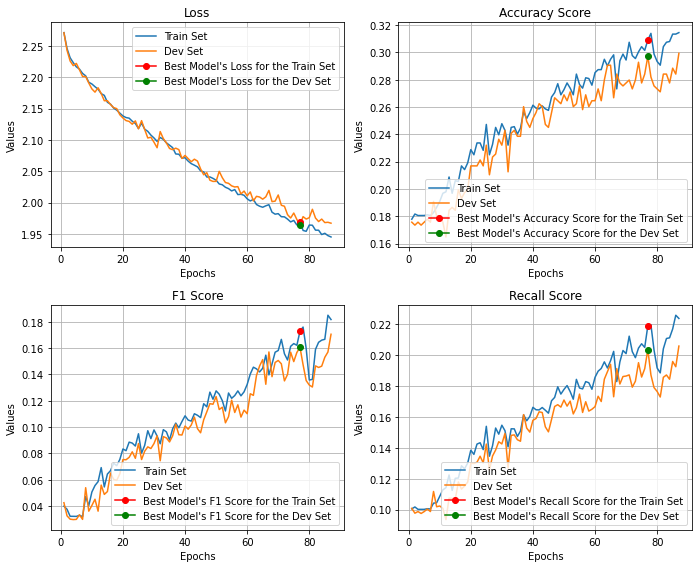

In [ ]:
EarlyLSTMNet = LSTM(input_dim=fused_feats,
                    rnn_size=HIDDEN_LAYER,
                    output_dim=OUTPUT_SIZE,
                    num_layers=NUM_LAYERS,
                    dropout=dropout,
                    pack_padded_sequence=pack_padded_sequence).to(device)

# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(EarlyLSTMNet.parameters(), lr=ETA, weight_decay=weight_decay)

# Start the training process
clf_main(device, EarlyLSTMNet, fused_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, net_name='EarlyLSTM_nonbeatFUSED', PATIENCE=PATIENCE)

In [ ]:
with open('./best_EarlyLSTM_nonbeatFUSED.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
test_loss, y_test_gold, y_test_pred = clf_eval(device, test_loader, fused_feats, E_model, criterion)

print(classification_report(y_test_gold, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.41      0.17      0.25        40
           2       0.25      0.55      0.35        80
           3       0.31      0.56      0.40        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.30      0.08      0.12        78
           7       0.00      0.00      0.00        40
           8       0.28      0.60      0.38       103
           9       0.00      0.00      0.00        34

    accuracy                           0.29       575
   macro avg       0.16      0.20      0.15       575
weighted avg       0.20      0.29      0.21       575



## Section 2 - 2D CNN Classification

### Training and Evalution using 'beat-synced datasets'

####  Mel Spectrograms Dataset

In [ ]:
data = SpectrogramDataset("data/fma_genre_spectrograms_beat",
                              class_mapping=class_mapping, train=True, read_spec_fn=read_mel_spectrogram)
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/fma_genre_spectrograms_beat/',
                                          class_mapping=class_mapping, train=False, read_spec_fn=read_mel_spectrogram, max_length=data.max_length)

##### Normal Training

CNN(
  (conv_layer): Sequential(
    (0): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(4, 16, kernel_size=(4, 4), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

  0%|          | 0/100 [00:00<?, ?it/s]

 [================================--------] ...Epoch 1, Loss: 2.0358

  1%|          | 1/100 [00:01<02:43,  1.65s/it]


Statistics for the Train Set
	 Epoch: 1 	 loss: 2.1032390820569007
	 Epoch: 1 	 Accuracy Score: 0.20932754880694143
	 Epoch: 1 	 f1 Score: 0.12310325906110235
	 Epoch: 1 	 recall Score: 0.1563581298711943
Statistics for the Dev Set
	 Epoch: 1 	 loss: 2.1081967115402223
	 Epoch: 1 	 Accuracy Score: 0.21691973969631237
	 Epoch: 1 	 f1 Score: 0.130683483387463
	 Epoch: 1 	 recall Score: 0.1605653301241823
Test loss decreased (inf --> 2.108197).  Saving model ...
Epoch total time 1.6474378108978271
 [================================--------] ...Epoch 2, Loss: 2.1305

  2%|▏         | 2/100 [00:03<02:40,  1.64s/it]


Statistics for the Train Set
	 Epoch: 2 	 loss: 2.0099236081386436
	 Epoch: 2 	 Accuracy Score: 0.2608459869848156
	 Epoch: 2 	 f1 Score: 0.19285068853317258
	 Epoch: 2 	 recall Score: 0.20368143845759118
Statistics for the Dev Set
	 Epoch: 2 	 loss: 2.0384674310684203
	 Epoch: 2 	 Accuracy Score: 0.28199566160520606
	 Epoch: 2 	 f1 Score: 0.21138210309239822
	 Epoch: 2 	 recall Score: 0.20813031528933035
Test loss decreased (2.108197 --> 2.038467).  Saving model ...
Epoch total time 1.634105920791626
 [================================--------] ...Epoch 3, Loss: 2.0590

  3%|▎         | 3/100 [00:04<02:38,  1.63s/it]


Statistics for the Train Set
	 Epoch: 3 	 loss: 1.9395842963251575
	 Epoch: 3 	 Accuracy Score: 0.31724511930585686
	 Epoch: 3 	 f1 Score: 0.24664257962208064
	 Epoch: 3 	 recall Score: 0.2799930617601514
Statistics for the Dev Set
	 Epoch: 3 	 loss: 2.0109036604563397
	 Epoch: 3 	 Accuracy Score: 0.30151843817787416
	 Epoch: 3 	 f1 Score: 0.2120652678267505
	 Epoch: 3 	 recall Score: 0.24566518562710288
Test loss decreased (2.038467 --> 2.010904).  Saving model ...
Epoch total time 1.6264350414276123
 [================================--------] ...Epoch 4, Loss: 2.0812

  4%|▍         | 4/100 [00:06<02:37,  1.64s/it]


Statistics for the Train Set
	 Epoch: 4 	 loss: 1.8620772772821887
	 Epoch: 4 	 Accuracy Score: 0.35195227765726683
	 Epoch: 4 	 f1 Score: 0.2839705374836526
	 Epoch: 4 	 recall Score: 0.3136520330622489
Statistics for the Dev Set
	 Epoch: 4 	 loss: 1.996462074915568
	 Epoch: 4 	 Accuracy Score: 0.2885032537960954
	 Epoch: 4 	 f1 Score: 0.23394883906693606
	 Epoch: 4 	 recall Score: 0.2616496767073636
Test loss decreased (2.010904 --> 1.996462).  Saving model ...
Epoch total time 1.6364307403564453
 [================================--------] ...Epoch 5, Loss: 1.8254

  5%|▌         | 5/100 [00:08<02:35,  1.63s/it]


Statistics for the Train Set
	 Epoch: 5 	 loss: 1.7963547131110882
	 Epoch: 5 	 Accuracy Score: 0.3660520607375271
	 Epoch: 5 	 f1 Score: 0.2753425799280276
	 Epoch: 5 	 recall Score: 0.3161636558100599
Statistics for the Dev Set
	 Epoch: 5 	 loss: 2.009013787905375
	 Epoch: 5 	 Accuracy Score: 0.2950108459869848
	 Epoch: 5 	 f1 Score: 0.1999349305333332
	 Epoch: 5 	 recall Score: 0.24088498993857357
EarlyStopping counter: 1 out of 10
Epoch total time 1.6243598461151123
 [================================--------] ...Epoch 6, Loss: 1.8232

  6%|▌         | 6/100 [00:09<02:33,  1.63s/it]


Statistics for the Train Set
	 Epoch: 6 	 loss: 1.6871060626260166
	 Epoch: 6 	 Accuracy Score: 0.4360086767895879
	 Epoch: 6 	 f1 Score: 0.3932631720362832
	 Epoch: 6 	 recall Score: 0.40087524084400483
Statistics for the Dev Set
	 Epoch: 6 	 loss: 1.9563820282618205
	 Epoch: 6 	 Accuracy Score: 0.31670281995661603
	 Epoch: 6 	 f1 Score: 0.23514534905581685
	 Epoch: 6 	 recall Score: 0.26278932771923386
Test loss decreased (1.996462 --> 1.956382).  Saving model ...
Epoch total time 1.6174726486206055
 [================================--------] ...Epoch 7, Loss: 1.6551
Statistics for the Train Set
	 Epoch: 7 	 loss: 1.619601576492704
	 Epoch: 7 	 Accuracy Score: 0.44685466377440347
	 Epoch: 7 	 f1 Score: 0.3827706949867123
	 Epoch: 7 	 recall Score: 0.40983263786553337


  7%|▋         | 7/100 [00:11<02:34,  1.66s/it]

Statistics for the Dev Set
	 Epoch: 7 	 loss: 1.9370963811874389
	 Epoch: 7 	 Accuracy Score: 0.33405639913232105
	 Epoch: 7 	 f1 Score: 0.2599012555955661
	 Epoch: 7 	 recall Score: 0.28056571170705646
Test loss decreased (1.956382 --> 1.937096).  Saving model ...
Epoch total time 1.7313392162322998
 [================================--------] ...Epoch 8, Loss: 1.5382

  8%|▊         | 8/100 [00:13<02:32,  1.66s/it]


Statistics for the Train Set
	 Epoch: 8 	 loss: 1.5421668887138367
	 Epoch: 8 	 Accuracy Score: 0.48427331887201736
	 Epoch: 8 	 f1 Score: 0.4087669360332499
	 Epoch: 8 	 recall Score: 0.4324194916772031
Statistics for the Dev Set
	 Epoch: 8 	 loss: 1.928665041923523
	 Epoch: 8 	 Accuracy Score: 0.32537960954446854
	 Epoch: 8 	 f1 Score: 0.24363406533615475
	 Epoch: 8 	 recall Score: 0.27092475298431423
Test loss decreased (1.937096 --> 1.928665).  Saving model ...
Epoch total time 1.6377618312835693
 [================================--------] ...Epoch 9, Loss: 1.5330

  9%|▉         | 9/100 [00:14<02:29,  1.65s/it]


Statistics for the Train Set
	 Epoch: 9 	 loss: 1.491365724596484
	 Epoch: 9 	 Accuracy Score: 0.49891540130151846
	 Epoch: 9 	 f1 Score: 0.42337273691139254
	 Epoch: 9 	 recall Score: 0.4364970410930093
Statistics for the Dev Set
	 Epoch: 9 	 loss: 1.9337186733881633
	 Epoch: 9 	 Accuracy Score: 0.3318872017353579
	 Epoch: 9 	 f1 Score: 0.24681097560744783
	 Epoch: 9 	 recall Score: 0.2675597334247129
EarlyStopping counter: 1 out of 10
Epoch total time 1.6267311573028564
 [================================--------] ...Epoch 10, Loss: 1.4927

 10%|█         | 10/100 [00:16<02:28,  1.65s/it]


Statistics for the Train Set
	 Epoch: 10 	 loss: 1.3706138709495808
	 Epoch: 10 	 Accuracy Score: 0.5482646420824295
	 Epoch: 10 	 f1 Score: 0.4846186529924039
	 Epoch: 10 	 recall Score: 0.4928985823349998
Statistics for the Dev Set
	 Epoch: 10 	 loss: 1.9384640773137412
	 Epoch: 10 	 Accuracy Score: 0.30585683297180044
	 Epoch: 10 	 f1 Score: 0.23809851437049306
	 Epoch: 10 	 recall Score: 0.25531345483813167
EarlyStopping counter: 2 out of 10
Epoch total time 1.65950345993042
 [================================--------] ...Epoch 11, Loss: 1.6761

 11%|█         | 11/100 [00:18<02:26,  1.64s/it]


Statistics for the Train Set
	 Epoch: 11 	 loss: 1.3142861497813259
	 Epoch: 11 	 Accuracy Score: 0.5959869848156182
	 Epoch: 11 	 f1 Score: 0.5612820938655758
	 Epoch: 11 	 recall Score: 0.5744213897946592
Statistics for the Dev Set
	 Epoch: 11 	 loss: 1.9269792318344117
	 Epoch: 11 	 Accuracy Score: 0.31453362255965295
	 Epoch: 11 	 f1 Score: 0.25902673719484226
	 Epoch: 11 	 recall Score: 0.29201866581665814
Test loss decreased (1.928665 --> 1.926979).  Saving model ...
Epoch total time 1.6269035339355469
 [================================--------] ...Epoch 12, Loss: 1.3995

 12%|█▏        | 12/100 [00:19<02:24,  1.64s/it]


Statistics for the Train Set
	 Epoch: 12 	 loss: 1.2195588905235817
	 Epoch: 12 	 Accuracy Score: 0.6155097613882863
	 Epoch: 12 	 f1 Score: 0.5776622726237824
	 Epoch: 12 	 recall Score: 0.5779738050205493
Statistics for the Dev Set
	 Epoch: 12 	 loss: 1.8870694160461425
	 Epoch: 12 	 Accuracy Score: 0.31670281995661603
	 Epoch: 12 	 f1 Score: 0.25911884911108585
	 Epoch: 12 	 recall Score: 0.2836466383271962
Test loss decreased (1.926979 --> 1.887069).  Saving model ...
Epoch total time 1.6433124542236328
 [================================--------] ...Epoch 13, Loss: 1.0981

 13%|█▎        | 13/100 [00:21<02:22,  1.64s/it]


Statistics for the Train Set
	 Epoch: 13 	 loss: 1.1482217383795772
	 Epoch: 13 	 Accuracy Score: 0.6626898047722343
	 Epoch: 13 	 f1 Score: 0.6384856743354805
	 Epoch: 13 	 recall Score: 0.6264314969506678
Statistics for the Dev Set
	 Epoch: 13 	 loss: 1.896700175603231
	 Epoch: 13 	 Accuracy Score: 0.3275488069414317
	 Epoch: 13 	 f1 Score: 0.2810810445673834
	 Epoch: 13 	 recall Score: 0.29130160582518877
EarlyStopping counter: 1 out of 10
Epoch total time 1.6305172443389893
 [================================--------] ...Epoch 14, Loss: 1.3429

 14%|█▍        | 14/100 [00:23<02:21,  1.64s/it]


Statistics for the Train Set
	 Epoch: 14 	 loss: 1.0453451686892017
	 Epoch: 14 	 Accuracy Score: 0.710412147505423
	 Epoch: 14 	 f1 Score: 0.6837793721071636
	 Epoch: 14 	 recall Score: 0.679254004207744
Statistics for the Dev Set
	 Epoch: 14 	 loss: 1.9041430473327636
	 Epoch: 14 	 Accuracy Score: 0.3383947939262473
	 Epoch: 14 	 f1 Score: 0.2912691225228599
	 Epoch: 14 	 recall Score: 0.3030687783648835
EarlyStopping counter: 2 out of 10
Epoch total time 1.6437158584594727
 [================================--------] ...Epoch 15, Loss: 1.0901

 15%|█▌        | 15/100 [00:24<02:19,  1.64s/it]


Statistics for the Train Set
	 Epoch: 15 	 loss: 0.976551432034065
	 Epoch: 15 	 Accuracy Score: 0.7472885032537961
	 Epoch: 15 	 f1 Score: 0.7165642543757269
	 Epoch: 15 	 recall Score: 0.7182233977056605
Statistics for the Dev Set
	 Epoch: 15 	 loss: 1.922018790245056
	 Epoch: 15 	 Accuracy Score: 0.32537960954446854
	 Epoch: 15 	 f1 Score: 0.267252853042268
	 Epoch: 15 	 recall Score: 0.28696496281757494
EarlyStopping counter: 3 out of 10
Epoch total time 1.6230566501617432
 [================================--------] ...Epoch 16, Loss: 0.8242

 16%|█▌        | 16/100 [00:26<02:17,  1.64s/it]


Statistics for the Train Set
	 Epoch: 16 	 loss: 0.9528913785671366
	 Epoch: 16 	 Accuracy Score: 0.7022776572668112
	 Epoch: 16 	 f1 Score: 0.678051969605575
	 Epoch: 16 	 recall Score: 0.6571763552108454
Statistics for the Dev Set
	 Epoch: 16 	 loss: 2.029974834124247
	 Epoch: 16 	 Accuracy Score: 0.31019522776572667
	 Epoch: 16 	 f1 Score: 0.2517206850930784
	 Epoch: 16 	 recall Score: 0.2626204944010321
EarlyStopping counter: 4 out of 10
Epoch total time 1.6429154872894287
 [================================--------] ...Epoch 17, Loss: 0.9082

 17%|█▋        | 17/100 [00:27<02:15,  1.64s/it]


Statistics for the Train Set
	 Epoch: 17 	 loss: 0.8518444196931247
	 Epoch: 17 	 Accuracy Score: 0.8074837310195228
	 Epoch: 17 	 f1 Score: 0.7960434982313871
	 Epoch: 17 	 recall Score: 0.7875325657680584
Statistics for the Dev Set
	 Epoch: 17 	 loss: 1.930507516860962
	 Epoch: 17 	 Accuracy Score: 0.3362255965292842
	 Epoch: 17 	 f1 Score: 0.2748113476750451
	 Epoch: 17 	 recall Score: 0.2872055239653046
EarlyStopping counter: 5 out of 10
Epoch total time 1.6346046924591064
 [================================--------] ...Epoch 18, Loss: 0.9958

 18%|█▊        | 18/100 [00:29<02:15,  1.66s/it]


Statistics for the Train Set
	 Epoch: 18 	 loss: 0.8170898351176031
	 Epoch: 18 	 Accuracy Score: 0.8221258134490239
	 Epoch: 18 	 f1 Score: 0.8130087840985837
	 Epoch: 18 	 recall Score: 0.7977723705694314
Statistics for the Dev Set
	 Epoch: 18 	 loss: 1.9307024796803793
	 Epoch: 18 	 Accuracy Score: 0.3275488069414317
	 Epoch: 18 	 f1 Score: 0.2869812732034449
	 Epoch: 18 	 recall Score: 0.27565906068166424
EarlyStopping counter: 6 out of 10
Epoch total time 1.6948907375335693
 [================================--------] ...Epoch 19, Loss: 0.5869

 19%|█▉        | 19/100 [00:31<02:13,  1.65s/it]


Statistics for the Train Set
	 Epoch: 19 	 loss: 0.7996734987045157
	 Epoch: 19 	 Accuracy Score: 0.754880694143167
	 Epoch: 19 	 f1 Score: 0.7345919668552799
	 Epoch: 19 	 recall Score: 0.7029722032677417
Statistics for the Dev Set
	 Epoch: 19 	 loss: 2.1433807690938314
	 Epoch: 19 	 Accuracy Score: 0.31453362255965295
	 Epoch: 19 	 f1 Score: 0.25524030160064215
	 Epoch: 19 	 recall Score: 0.2604799542926812
EarlyStopping counter: 7 out of 10
Epoch total time 1.6274008750915527
 [================================--------] ...Epoch 20, Loss: 0.5250

 20%|██        | 20/100 [00:32<02:11,  1.65s/it]


Statistics for the Train Set
	 Epoch: 20 	 loss: 0.7073258531504664
	 Epoch: 20 	 Accuracy Score: 0.8394793926247288
	 Epoch: 20 	 f1 Score: 0.8285203126016392
	 Epoch: 20 	 recall Score: 0.8132608838696214
Statistics for the Dev Set
	 Epoch: 20 	 loss: 2.042265280087789
	 Epoch: 20 	 Accuracy Score: 0.3188720173535792
	 Epoch: 20 	 f1 Score: 0.26562325793831937
	 Epoch: 20 	 recall Score: 0.2676521677195758
EarlyStopping counter: 8 out of 10
Epoch total time 1.6379456520080566
 [================================--------] ...Epoch 21, Loss: 0.6242

 21%|██        | 21/100 [00:34<02:09,  1.64s/it]


Statistics for the Train Set
	 Epoch: 21 	 loss: 0.6639467791236681
	 Epoch: 21 	 Accuracy Score: 0.8595444685466378
	 Epoch: 21 	 f1 Score: 0.855936017261634
	 Epoch: 21 	 recall Score: 0.8459622882352933
Statistics for the Dev Set
	 Epoch: 21 	 loss: 2.02683261235555
	 Epoch: 21 	 Accuracy Score: 0.3188720173535792
	 Epoch: 21 	 f1 Score: 0.2813892673595543
	 Epoch: 21 	 recall Score: 0.2923730001580153
EarlyStopping counter: 9 out of 10
Epoch total time 1.620067834854126
 [================================--------] ...Epoch 22, Loss: 0.5006

 21%|██        | 21/100 [00:36<02:15,  1.72s/it]


Statistics for the Train Set
	 Epoch: 22 	 loss: 0.5436444924823169
	 Epoch: 22 	 Accuracy Score: 0.8942516268980477
	 Epoch: 22 	 f1 Score: 0.8884765484501186
	 Epoch: 22 	 recall Score: 0.8807138021628264
Statistics for the Dev Set
	 Epoch: 22 	 loss: 2.0675731102625527
	 Epoch: 22 	 Accuracy Score: 0.33405639913232105
	 Epoch: 22 	 f1 Score: 0.2849554905821002
	 Epoch: 22 	 recall Score: 0.28787282767641076
EarlyStopping counter: 10 out of 10
Training total time 34.4669086933136


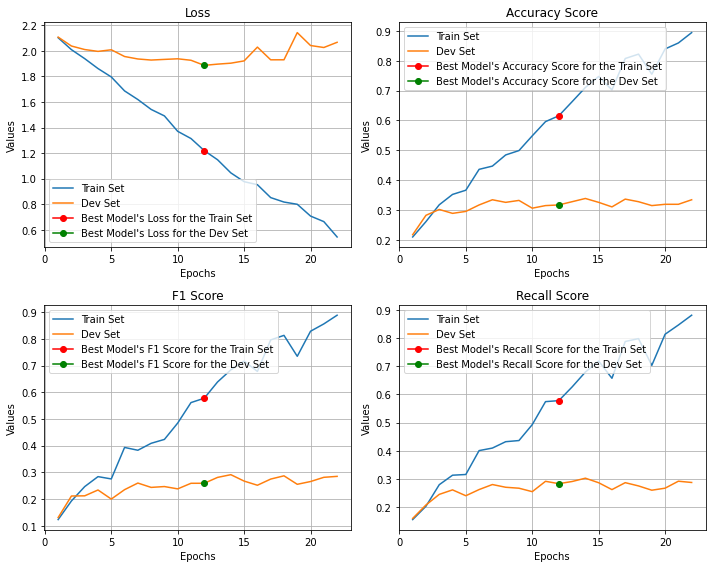

In [ ]:
EarlyCNNNet = CNN(layer_channels, hidden_features, out_features, kernels, dropout=dropout).to(device)
print(EarlyCNNNet)
# Make instance of our optimizer, with L2-Reguralization
# optimizer = optim.SGD(EarlyCNNNet.parameters(), lr=ETA, weight_decay=weight_decay)
optimizer = optim.Adam(EarlyCNNNet.parameters(), lr=ETA, weight_decay=weight_decay)

# Start the training process
clf_main(device, EarlyCNNNet, mels_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, net_name='EarlyCNN_beatMEL', PATIENCE=PATIENCE, cnn=True)

In [ ]:
with open('./best_EarlyCNN_beatMEL.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
test_loss, y_test_gold, y_test_pred = clf_eval(device, test_loader, mels_feats, E_model, criterion, cnn=True)

print(classification_report(y_test_gold, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.40      0.55      0.46        40
           2       0.34      0.21      0.26        80
           3       0.33      0.28      0.30        80
           4       0.34      0.47      0.40        40
           5       0.12      0.07      0.09        40
           6       0.33      0.60      0.42        78
           7       0.14      0.03      0.04        40
           8       0.27      0.39      0.32       103
           9       0.11      0.06      0.08        34

    accuracy                           0.30       575
   macro avg       0.24      0.27      0.24       575
weighted avg       0.26      0.30      0.27       575



#### Chromagrams Dataset

In [ ]:
data = SpectrogramDataset("data/fma_genre_spectrograms_beat",
                                  class_mapping=class_mapping, train=True, read_spec_fn=read_chromagram)
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/fma_genre_spectrograms_beat/',
                                              class_mapping=class_mapping, train=False, read_spec_fn=read_chromagram, max_length=data.max_length)

##### Normal Training

CNN(
  (conv_layer): Sequential(
    (0): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
  )
  (fc): FullyConnectedLayer(
    (fc1): LazyLinear(in_features=0, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=10, bias=True)
  )
)


  0%|          | 0/100 [00:00<?, ?it/s]

 [================================--------] ...Epoch 1, Loss: 2.1585

  1%|          | 1/100 [00:00<01:03,  1.55it/s]


Statistics for the Train Set
	 Epoch: 1 	 loss: 2.214624515895186
	 Epoch: 1 	 Accuracy Score: 0.18817787418655096
	 Epoch: 1 	 f1 Score: 0.06444417516432577
	 Epoch: 1 	 recall Score: 0.11209368476736012
Statistics for the Dev Set
	 Epoch: 1 	 loss: 2.219565010070801
	 Epoch: 1 	 Accuracy Score: 0.17136659436008678
	 Epoch: 1 	 f1 Score: 0.053886594389950096
	 Epoch: 1 	 recall Score: 0.0956171840765834
Test loss decreased (inf --> 2.219565).  Saving model ...
Epoch total time 0.646388053894043
 [================================--------] ...Epoch 2, Loss: 2.2226
Statistics for the Train Set
	 Epoch: 2 	 loss: 2.200307250022888


  2%|▏         | 2/100 [00:01<01:03,  1.54it/s]

	 Epoch: 2 	 Accuracy Score: 0.18329718004338394
	 Epoch: 2 	 f1 Score: 0.06966364639389225
	 Epoch: 2 	 recall Score: 0.11133720390211757
Statistics for the Dev Set
	 Epoch: 2 	 loss: 2.2256479422251383
	 Epoch: 2 	 Accuracy Score: 0.17136659436008678
	 Epoch: 2 	 f1 Score: 0.06552994646963843
	 Epoch: 2 	 recall Score: 0.10070328077558333
EarlyStopping counter: 1 out of 10
Epoch total time 0.648820161819458
 [================================--------] ...Epoch 3, Loss: 2.1662

  3%|▎         | 3/100 [00:01<01:02,  1.54it/s]


Statistics for the Train Set
	 Epoch: 3 	 loss: 2.1576635652575
	 Epoch: 3 	 Accuracy Score: 0.2077006507592191
	 Epoch: 3 	 f1 Score: 0.07794563188865987
	 Epoch: 3 	 recall Score: 0.12755322301880123
Statistics for the Dev Set
	 Epoch: 3 	 loss: 2.1982473214467366
	 Epoch: 3 	 Accuracy Score: 0.19956616052060738
	 Epoch: 3 	 f1 Score: 0.06940853187962158
	 Epoch: 3 	 recall Score: 0.11680731115380727
Test loss decreased (2.219565 --> 2.198247).  Saving model ...
Epoch total time 0.6446976661682129
 [================================--------] ...Epoch 4, Loss: 2.1371
Statistics for the Train Set
	 Epoch: 4 	 loss: 2.136049245965892


  4%|▍         | 4/100 [00:02<01:02,  1.54it/s]

	 Epoch: 4 	 Accuracy Score: 0.23427331887201736
	 Epoch: 4 	 f1 Score: 0.11437131364650481
	 Epoch: 4 	 recall Score: 0.1569780088387886
Statistics for the Dev Set
	 Epoch: 4 	 loss: 2.179049777984619
	 Epoch: 4 	 Accuracy Score: 0.16919739696312364
	 Epoch: 4 	 f1 Score: 0.07716711473174347
	 Epoch: 4 	 recall Score: 0.11069412141436615
Test loss decreased (2.198247 --> 2.179050).  Saving model ...
Epoch total time 0.6462371349334717
 [================================--------] ...Epoch 5, Loss: 2.1242
Statistics for the Train Set
	 Epoch: 5 	 loss: 2.1157449278338203


  5%|▌         | 5/100 [00:03<01:01,  1.55it/s]

	 Epoch: 5 	 Accuracy Score: 0.23318872017353579
	 Epoch: 5 	 f1 Score: 0.09790801609361563
	 Epoch: 5 	 recall Score: 0.150277839482525
Statistics for the Dev Set
	 Epoch: 5 	 loss: 2.1656913916269938
	 Epoch: 5 	 Accuracy Score: 0.18004338394793926
	 Epoch: 5 	 f1 Score: 0.06481712240536897
	 Epoch: 5 	 recall Score: 0.1104887585532747
Test loss decreased (2.179050 --> 2.165691).  Saving model ...
Epoch total time 0.6286265850067139
 [================================--------] ...Epoch 6, Loss: 2.0934

  6%|▌         | 6/100 [00:03<01:00,  1.55it/s]


Statistics for the Train Set
	 Epoch: 6 	 loss: 2.09955089873281
	 Epoch: 6 	 Accuracy Score: 0.25162689804772237
	 Epoch: 6 	 f1 Score: 0.14035270376909992
	 Epoch: 6 	 recall Score: 0.1750363808048459
Statistics for the Dev Set
	 Epoch: 6 	 loss: 2.1704702377319336
	 Epoch: 6 	 Accuracy Score: 0.20607375271149675
	 Epoch: 6 	 f1 Score: 0.10395740408443924
	 Epoch: 6 	 recall Score: 0.14004362526609468
EarlyStopping counter: 1 out of 10
Epoch total time 0.645188570022583
 [================================--------] ...Epoch 7, Loss: 2.1993

  7%|▋         | 7/100 [00:04<01:00,  1.54it/s]


Statistics for the Train Set
	 Epoch: 7 	 loss: 2.08550665912957
	 Epoch: 7 	 Accuracy Score: 0.2668112798264642
	 Epoch: 7 	 f1 Score: 0.17168101768674612
	 Epoch: 7 	 recall Score: 0.1948499467888597
Statistics for the Dev Set
	 Epoch: 7 	 loss: 2.1631235599517824
	 Epoch: 7 	 Accuracy Score: 0.21258134490238612
	 Epoch: 7 	 f1 Score: 0.13916019890388936
	 Epoch: 7 	 recall Score: 0.15286670060614793
Test loss decreased (2.165691 --> 2.163124).  Saving model ...
Epoch total time 0.6454198360443115
 [================================--------] ...Epoch 8, Loss: 2.1748
Statistics for the Train Set
	 Epoch: 8 	 loss: 2.0633803996546516


  8%|▊         | 8/100 [00:05<00:59,  1.55it/s]

	 Epoch: 8 	 Accuracy Score: 0.27765726681127983
	 Epoch: 8 	 f1 Score: 0.1830891451861622
	 Epoch: 8 	 recall Score: 0.2078290980231054
Statistics for the Dev Set
	 Epoch: 8 	 loss: 2.1566830555597942
	 Epoch: 8 	 Accuracy Score: 0.20607375271149675
	 Epoch: 8 	 f1 Score: 0.12877688741836066
	 Epoch: 8 	 recall Score: 0.15127318669075593
Test loss decreased (2.163124 --> 2.156683).  Saving model ...
Epoch total time 0.6317570209503174
 [================================--------] ...Epoch 9, Loss: 1.7789

  9%|▉         | 9/100 [00:05<00:58,  1.55it/s]


Statistics for the Train Set
	 Epoch: 9 	 loss: 2.049838555270228
	 Epoch: 9 	 Accuracy Score: 0.2754880694143167
	 Epoch: 9 	 f1 Score: 0.15918209659802418
	 Epoch: 9 	 recall Score: 0.19551609451340388
Statistics for the Dev Set
	 Epoch: 9 	 loss: 2.1686530749003095
	 Epoch: 9 	 Accuracy Score: 0.2039045553145336
	 Epoch: 9 	 f1 Score: 0.11197902244882232
	 Epoch: 9 	 recall Score: 0.1385994049620301
EarlyStopping counter: 1 out of 10
Epoch total time 0.6477217674255371
 [================================--------] ...Epoch 10, Loss: 2.0628
Statistics for the Train Set
	 Epoch: 10 	 loss: 2.0290262226400704


 10%|█         | 10/100 [00:06<00:58,  1.55it/s]

	 Epoch: 10 	 Accuracy Score: 0.28470715835141
	 Epoch: 10 	 f1 Score: 0.19883413915446926
	 Epoch: 10 	 recall Score: 0.21778167003293789
Statistics for the Dev Set
	 Epoch: 10 	 loss: 2.1386103709538777
	 Epoch: 10 	 Accuracy Score: 0.20824295010845986
	 Epoch: 10 	 f1 Score: 0.14123663106558246
	 Epoch: 10 	 recall Score: 0.15327810388974838
Test loss decreased (2.156683 --> 2.138610).  Saving model ...
Epoch total time 0.6367437839508057
 [================================--------] ...Epoch 11, Loss: 2.2819

 11%|█         | 11/100 [00:07<00:59,  1.48it/s]


Statistics for the Train Set
	 Epoch: 11 	 loss: 2.007614312500789
	 Epoch: 11 	 Accuracy Score: 0.2950108459869848
	 Epoch: 11 	 f1 Score: 0.19181470804151918
	 Epoch: 11 	 recall Score: 0.22229211052931958
Statistics for the Dev Set
	 Epoch: 11 	 loss: 2.1486555417378743
	 Epoch: 11 	 Accuracy Score: 0.20824295010845986
	 Epoch: 11 	 f1 Score: 0.1303716437334768
	 Epoch: 11 	 recall Score: 0.15465143115573415
EarlyStopping counter: 1 out of 10
Epoch total time 0.7361516952514648
 [================================--------] ...Epoch 12, Loss: 1.9504

 12%|█▏        | 12/100 [00:07<00:58,  1.51it/s]


Statistics for the Train Set
	 Epoch: 12 	 loss: 1.9979810879148285
	 Epoch: 12 	 Accuracy Score: 0.30585683297180044
	 Epoch: 12 	 f1 Score: 0.2267917627783978
	 Epoch: 12 	 recall Score: 0.24677994813473103
Statistics for the Dev Set
	 Epoch: 12 	 loss: 2.1250383933385213
	 Epoch: 12 	 Accuracy Score: 0.21691973969631237
	 Epoch: 12 	 f1 Score: 0.14268634873300354
	 Epoch: 12 	 recall Score: 0.15780046827628938
Test loss decreased (2.138610 --> 2.125038).  Saving model ...
Epoch total time 0.6342670917510986
 [================================--------] ...Epoch 13, Loss: 1.9795
Statistics for the Train Set
	 Epoch: 13 	 loss: 1.9777706409322804


 13%|█▎        | 13/100 [00:08<00:57,  1.51it/s]

	 Epoch: 13 	 Accuracy Score: 0.30585683297180044
	 Epoch: 13 	 f1 Score: 0.21776779221948245
	 Epoch: 13 	 recall Score: 0.23538521320287925
Statistics for the Dev Set
	 Epoch: 13 	 loss: 2.1403692960739136
	 Epoch: 13 	 Accuracy Score: 0.21475054229934923
	 Epoch: 13 	 f1 Score: 0.13202141755784372
	 Epoch: 13 	 recall Score: 0.1553234001328375
EarlyStopping counter: 1 out of 10
Epoch total time 0.6503207683563232
 [================================--------] ...Epoch 14, Loss: 1.9593

 14%|█▍        | 14/100 [00:09<00:56,  1.52it/s]


Statistics for the Train Set
	 Epoch: 14 	 loss: 1.96821718380369
	 Epoch: 14 	 Accuracy Score: 0.3009761388286334
	 Epoch: 14 	 f1 Score: 0.20920363342167478
	 Epoch: 14 	 recall Score: 0.22522474792141053
Statistics for the Dev Set
	 Epoch: 14 	 loss: 2.162764612833659
	 Epoch: 14 	 Accuracy Score: 0.22342733188720174
	 Epoch: 14 	 f1 Score: 0.1284007978589103
	 Epoch: 14 	 recall Score: 0.15608725408034582
EarlyStopping counter: 2 out of 10
Epoch total time 0.6467564105987549
 [================================--------] ...Epoch 15, Loss: 1.9373
Statistics for the Train Set
	 Epoch: 15 	 loss: 1.9456409688653618


 15%|█▌        | 15/100 [00:09<00:55,  1.54it/s]

	 Epoch: 15 	 Accuracy Score: 0.3383947939262473
	 Epoch: 15 	 f1 Score: 0.2616623463543872
	 Epoch: 15 	 recall Score: 0.2713813733576439
Statistics for the Dev Set
	 Epoch: 15 	 loss: 2.128721841176351
	 Epoch: 15 	 Accuracy Score: 0.2039045553145336
	 Epoch: 15 	 f1 Score: 0.15369780278855963
	 Epoch: 15 	 recall Score: 0.15959138524137645
EarlyStopping counter: 3 out of 10
Epoch total time 0.6335189342498779
 [================================--------] ...Epoch 16, Loss: 2.0423

 16%|█▌        | 16/100 [00:10<00:54,  1.54it/s]


Statistics for the Train Set
	 Epoch: 16 	 loss: 1.9391988269213973
	 Epoch: 16 	 Accuracy Score: 0.3351409978308026
	 Epoch: 16 	 f1 Score: 0.2566541204837969
	 Epoch: 16 	 recall Score: 0.2674549250319271
Statistics for the Dev Set
	 Epoch: 16 	 loss: 2.119822072982788
	 Epoch: 16 	 Accuracy Score: 0.24945770065075923
	 Epoch: 16 	 f1 Score: 0.17123065805192694
	 Epoch: 16 	 recall Score: 0.18637217855032973
Test loss decreased (2.125038 --> 2.119822).  Saving model ...
Epoch total time 0.6442039012908936
 [================================--------] ...Epoch 17, Loss: 2.0245

 17%|█▋        | 17/100 [00:11<00:53,  1.54it/s]


Statistics for the Train Set
	 Epoch: 17 	 loss: 1.92917459586571
	 Epoch: 17 	 Accuracy Score: 0.32266811279826463
	 Epoch: 17 	 f1 Score: 0.2518554620471595
	 Epoch: 17 	 recall Score: 0.2674099089566033
Statistics for the Dev Set
	 Epoch: 17 	 loss: 2.1417736927668254
	 Epoch: 17 	 Accuracy Score: 0.19739696312364424
	 Epoch: 17 	 f1 Score: 0.1414456099362842
	 Epoch: 17 	 recall Score: 0.15567722058984282
EarlyStopping counter: 1 out of 10
Epoch total time 0.6511435508728027
 [================================--------] ...Epoch 18, Loss: 1.9627
Statistics for the Train Set
	 Epoch: 18 	 loss: 1.9113820996777764


 18%|█▊        | 18/100 [00:11<00:53,  1.54it/s]

	 Epoch: 18 	 Accuracy Score: 0.35900216919739697
	 Epoch: 18 	 f1 Score: 0.2872225925274141
	 Epoch: 18 	 recall Score: 0.29364526410626035
Statistics for the Dev Set
	 Epoch: 18 	 loss: 2.144256901741028
	 Epoch: 18 	 Accuracy Score: 0.19956616052060738
	 Epoch: 18 	 f1 Score: 0.13470202651522106
	 Epoch: 18 	 recall Score: 0.14561773043960854
EarlyStopping counter: 2 out of 10
Epoch total time 0.6469008922576904
 [================================--------] ...Epoch 19, Loss: 1.6941
Statistics for the Train Set
	 Epoch: 19 	 loss: 1.8955444364712155


 19%|█▉        | 19/100 [00:12<00:52,  1.54it/s]

	 Epoch: 19 	 Accuracy Score: 0.34436008676789587
	 Epoch: 19 	 f1 Score: 0.27977840202916937
	 Epoch: 19 	 recall Score: 0.2802766746185118
Statistics for the Dev Set
	 Epoch: 19 	 loss: 2.159624179204305
	 Epoch: 19 	 Accuracy Score: 0.19956616052060738
	 Epoch: 19 	 f1 Score: 0.13300835802627245
	 Epoch: 19 	 recall Score: 0.14569056180978784
EarlyStopping counter: 3 out of 10
Epoch total time 0.6480655670166016
 [================================--------] ...Epoch 20, Loss: 1.7034

 20%|██        | 20/100 [00:13<00:51,  1.55it/s]


Statistics for the Train Set
	 Epoch: 20 	 loss: 1.8772059617371395
	 Epoch: 20 	 Accuracy Score: 0.3497830802603037
	 Epoch: 20 	 f1 Score: 0.28939504888095047
	 Epoch: 20 	 recall Score: 0.287774545861767
Statistics for the Dev Set
	 Epoch: 20 	 loss: 2.179345401128133
	 Epoch: 20 	 Accuracy Score: 0.19305856832971802
	 Epoch: 20 	 f1 Score: 0.1262948855011302
	 Epoch: 20 	 recall Score: 0.13746022702348443
EarlyStopping counter: 4 out of 10
Epoch total time 0.6399989128112793
 [================================--------] ...Epoch 21, Loss: 2.0239

 21%|██        | 21/100 [00:13<00:51,  1.54it/s]


Statistics for the Train Set
	 Epoch: 21 	 loss: 1.8582312012540882
	 Epoch: 21 	 Accuracy Score: 0.37418655097613884
	 Epoch: 21 	 f1 Score: 0.31430367122592295
	 Epoch: 21 	 recall Score: 0.3220095633175191
Statistics for the Dev Set
	 Epoch: 21 	 loss: 2.162174844741821
	 Epoch: 21 	 Accuracy Score: 0.21908893709327548
	 Epoch: 21 	 f1 Score: 0.15264585796165325
	 Epoch: 21 	 recall Score: 0.169741844134005
EarlyStopping counter: 5 out of 10
Epoch total time 0.6569933891296387
 [================================--------] ...Epoch 22, Loss: 1.8311
Statistics for the Train Set
	 Epoch: 22 	 loss: 1.8402790591634552


 22%|██▏       | 22/100 [00:14<00:50,  1.54it/s]

	 Epoch: 22 	 Accuracy Score: 0.37852494577006507
	 Epoch: 22 	 f1 Score: 0.3094958973663545
	 Epoch: 22 	 recall Score: 0.3215407647420464
Statistics for the Dev Set
	 Epoch: 22 	 loss: 2.1617847283681235
	 Epoch: 22 	 Accuracy Score: 0.20824295010845986
	 Epoch: 22 	 f1 Score: 0.14708753395195934
	 Epoch: 22 	 recall Score: 0.16417406082004174
EarlyStopping counter: 6 out of 10
Epoch total time 0.6428689956665039
 [================================--------] ...Epoch 23, Loss: 2.1619

 23%|██▎       | 23/100 [00:14<00:49,  1.54it/s]


Statistics for the Train Set
	 Epoch: 23 	 loss: 1.831281890129221
	 Epoch: 23 	 Accuracy Score: 0.39370932754880694
	 Epoch: 23 	 f1 Score: 0.33806839584885695
	 Epoch: 23 	 recall Score: 0.3386581055547042
Statistics for the Dev Set
	 Epoch: 23 	 loss: 2.1867963473002114
	 Epoch: 23 	 Accuracy Score: 0.19956616052060738
	 Epoch: 23 	 f1 Score: 0.14880455190774156
	 Epoch: 23 	 recall Score: 0.16273042751600797
EarlyStopping counter: 7 out of 10
Epoch total time 0.6474394798278809
 [================================--------] ...Epoch 24, Loss: 1.9396

 24%|██▍       | 24/100 [00:15<00:49,  1.54it/s]


Statistics for the Train Set
	 Epoch: 24 	 loss: 1.8132557314017723
	 Epoch: 24 	 Accuracy Score: 0.39804772234273317
	 Epoch: 24 	 f1 Score: 0.32754901645998374
	 Epoch: 24 	 recall Score: 0.33510524986710316
Statistics for the Dev Set
	 Epoch: 24 	 loss: 2.144534730911255
	 Epoch: 24 	 Accuracy Score: 0.21475054229934923
	 Epoch: 24 	 f1 Score: 0.14740768339128993
	 Epoch: 24 	 recall Score: 0.16197374425625113
EarlyStopping counter: 8 out of 10
Epoch total time 0.6499090194702148
 [================================--------] ...Epoch 25, Loss: 1.9253

 25%|██▌       | 25/100 [00:16<00:48,  1.55it/s]


Statistics for the Train Set
	 Epoch: 25 	 loss: 1.7848050018836712
	 Epoch: 25 	 Accuracy Score: 0.398590021691974
	 Epoch: 25 	 f1 Score: 0.3460703714535359
	 Epoch: 25 	 recall Score: 0.34462741516228007
Statistics for the Dev Set
	 Epoch: 25 	 loss: 2.1735134522120156
	 Epoch: 25 	 Accuracy Score: 0.21475054229934923
	 Epoch: 25 	 f1 Score: 0.15005211065202476
	 Epoch: 25 	 recall Score: 0.1707519219067138
EarlyStopping counter: 9 out of 10
Epoch total time 0.639716386795044
 [================================--------] ...Epoch 26, Loss: 1.7303
Statistics for the Train Set
	 Epoch: 26 	 loss: 1.7949561538367436


 25%|██▌       | 25/100 [00:16<00:50,  1.48it/s]

	 Epoch: 26 	 Accuracy Score: 0.398590021691974
	 Epoch: 26 	 f1 Score: 0.3421168522827203
	 Epoch: 26 	 recall Score: 0.3522630972299607
Statistics for the Dev Set
	 Epoch: 26 	 loss: 2.2220803101857505
	 Epoch: 26 	 Accuracy Score: 0.19956616052060738
	 Epoch: 26 	 f1 Score: 0.14814975661123092
	 Epoch: 26 	 recall Score: 0.16249812152408608
EarlyStopping counter: 10 out of 10
Training total time 16.189855575561523


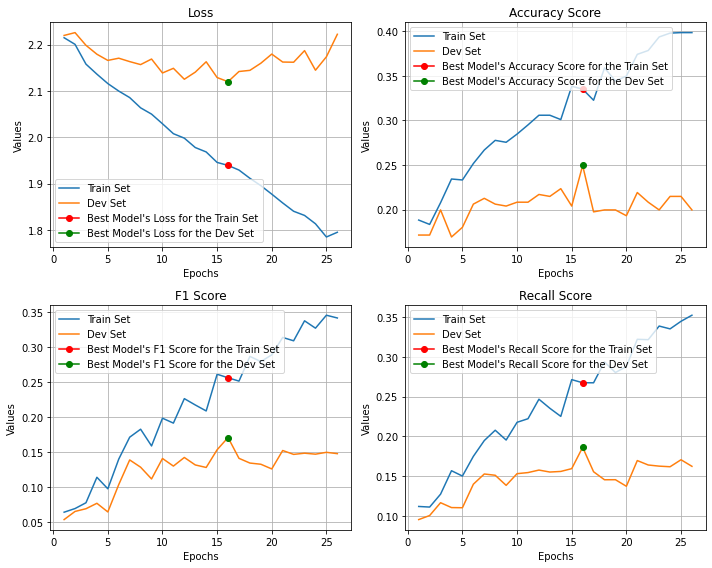

In [ ]:
EarlyCNNNet = CNN(layer_channels, hidden_features, out_features, kernels, dropout=dropout, chroma=True).to(device)
print(EarlyCNNNet)
# Make instance of our optimizer, with L2-Reguralization
# optimizer = optim.SGD(EarlyCNNNet.parameters(), lr=ETA, weight_decay=weight_decay)
optimizer = optim.Adam(EarlyCNNNet.parameters(), lr=ETA, weight_decay=weight_decay)

# Start the training process
clf_main(device, EarlyCNNNet, chroma_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, net_name='EarlyCNN_beatCHROMA', PATIENCE=PATIENCE, cnn=True)

In [ ]:
with open('./best_EarlyCNN_beatCHROMA.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
test_loss, y_test_gold, y_test_pred = clf_eval(device, test_loader, chroma_feats, E_model, criterion, cnn=True)

print(classification_report(y_test_gold, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.26      0.17      0.21        40
           2       0.13      0.14      0.14        80
           3       0.20      0.31      0.25        80
           4       0.12      0.10      0.11        40
           5       0.40      0.05      0.09        40
           6       0.29      0.44      0.35        78
           7       0.00      0.00      0.00        40
           8       0.18      0.31      0.23       103
           9       0.00      0.00      0.00        34

    accuracy                           0.20       575
   macro avg       0.16      0.15      0.14       575
weighted avg       0.17      0.20      0.17       575



#### Mel Spectrograms + Chromagrams Dataset

In [ ]:
data = SpectrogramDataset("data/fma_genre_spectrograms_beat",
                                class_mapping=class_mapping, train=True, read_spec_fn=read_fused_spectrogram)
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/fma_genre_spectrograms_beat/',
                                            class_mapping=class_mapping, train=False, read_spec_fn=read_fused_spectrogram, max_length=data.max_length)

##### Normal Training

CNN(
  (conv_layer): Sequential(
    (0): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(4, 16, kernel_size=(4, 4), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

  0%|          | 0/100 [00:00<?, ?it/s]

 [================================--------] ...Epoch 1, Loss: 2.0218

  1%|          | 1/100 [00:01<02:52,  1.74s/it]


Statistics for the Train Set
	 Epoch: 1 	 loss: 2.016173886841741
	 Epoch: 1 	 Accuracy Score: 0.2668112798264642
	 Epoch: 1 	 f1 Score: 0.1827285800335903
	 Epoch: 1 	 recall Score: 0.2324188948600047
Statistics for the Dev Set
	 Epoch: 1 	 loss: 2.028713663419088
	 Epoch: 1 	 Accuracy Score: 0.25813449023861174
	 Epoch: 1 	 f1 Score: 0.17872241480540538
	 Epoch: 1 	 recall Score: 0.23042039380009166
Test loss decreased (inf --> 2.028714).  Saving model ...
Epoch total time 1.743102788925171
 [================================--------] ...Epoch 2, Loss: 1.9537
Statistics for the Train Set
	 Epoch: 2 	 loss: 1.90766022534206
	 Epoch: 2 	 Accuracy Score: 0.31670281995661603
	 Epoch: 2 	 f1 Score: 0.24700301907970612
	 Epoch: 2 	 recall Score: 0.2730542128810508


  2%|▏         | 2/100 [00:03<02:57,  1.81s/it]

Statistics for the Dev Set
	 Epoch: 2 	 loss: 1.9641594648361207
	 Epoch: 2 	 Accuracy Score: 0.24945770065075923
	 Epoch: 2 	 f1 Score: 0.1914106818812701
	 Epoch: 2 	 recall Score: 0.22014352122126626
Test loss decreased (2.028714 --> 1.964159).  Saving model ...
Epoch total time 1.8620538711547852
 [================================--------] ...Epoch 3, Loss: 1.8813

  3%|▎         | 3/100 [00:05<02:52,  1.78s/it]


Statistics for the Train Set
	 Epoch: 3 	 loss: 1.8384813728003666
	 Epoch: 3 	 Accuracy Score: 0.3584598698481562
	 Epoch: 3 	 f1 Score: 0.29510366337480953
	 Epoch: 3 	 recall Score: 0.3338812185557719
Statistics for the Dev Set
	 Epoch: 3 	 loss: 1.9815311670303344
	 Epoch: 3 	 Accuracy Score: 0.2646420824295011
	 Epoch: 3 	 f1 Score: 0.20966887448264443
	 Epoch: 3 	 recall Score: 0.2552936425550919
EarlyStopping counter: 1 out of 10
Epoch total time 1.7360670566558838
 [================================--------] ...Epoch 4, Loss: 1.8077

  4%|▍         | 4/100 [00:07<02:49,  1.77s/it]


Statistics for the Train Set
	 Epoch: 4 	 loss: 1.7719883158289154
	 Epoch: 4 	 Accuracy Score: 0.398590021691974
	 Epoch: 4 	 f1 Score: 0.3184600283719105
	 Epoch: 4 	 recall Score: 0.3611048640476592
Statistics for the Dev Set
	 Epoch: 4 	 loss: 1.928499452273051
	 Epoch: 4 	 Accuracy Score: 0.2841648590021692
	 Epoch: 4 	 f1 Score: 0.20429782763265808
	 Epoch: 4 	 recall Score: 0.27397547805847366
Test loss decreased (1.964159 --> 1.928499).  Saving model ...
Epoch total time 1.743072271347046
 [================================--------] ...Epoch 5, Loss: 1.6945

  5%|▌         | 5/100 [00:08<02:46,  1.76s/it]


Statistics for the Train Set
	 Epoch: 5 	 loss: 1.7060935373963981
	 Epoch: 5 	 Accuracy Score: 0.40130151843817785
	 Epoch: 5 	 f1 Score: 0.3234455541862357
	 Epoch: 5 	 recall Score: 0.36491306388354605
Statistics for the Dev Set
	 Epoch: 5 	 loss: 1.9483676513036092
	 Epoch: 5 	 Accuracy Score: 0.27114967462039047
	 Epoch: 5 	 f1 Score: 0.2099260220557037
	 Epoch: 5 	 recall Score: 0.2543663154095444
EarlyStopping counter: 1 out of 10
Epoch total time 1.743269443511963
 [================================--------] ...Epoch 6, Loss: 1.6035

  6%|▌         | 6/100 [00:10<02:45,  1.76s/it]


Statistics for the Train Set
	 Epoch: 6 	 loss: 1.5852724786462455
	 Epoch: 6 	 Accuracy Score: 0.46691973969631234
	 Epoch: 6 	 f1 Score: 0.39920392064036603
	 Epoch: 6 	 recall Score: 0.4176318847773934
Statistics for the Dev Set
	 Epoch: 6 	 loss: 1.904408876101176
	 Epoch: 6 	 Accuracy Score: 0.30585683297180044
	 Epoch: 6 	 f1 Score: 0.2511879801905271
	 Epoch: 6 	 recall Score: 0.28111956694537754
Test loss decreased (1.928499 --> 1.904409).  Saving model ...
Epoch total time 1.7493107318878174
 [================================--------] ...Epoch 7, Loss: 1.5889

  7%|▋         | 7/100 [00:12<02:42,  1.75s/it]


Statistics for the Train Set
	 Epoch: 7 	 loss: 1.535406690219353
	 Epoch: 7 	 Accuracy Score: 0.4685466377440347
	 Epoch: 7 	 f1 Score: 0.40638858042195325
	 Epoch: 7 	 recall Score: 0.42758217704279833
Statistics for the Dev Set
	 Epoch: 7 	 loss: 1.9019099156061807
	 Epoch: 7 	 Accuracy Score: 0.3362255965292842
	 Epoch: 7 	 f1 Score: 0.26914540160632394
	 Epoch: 7 	 recall Score: 0.314408656076858
Test loss decreased (1.904409 --> 1.901910).  Saving model ...
Epoch total time 1.731712818145752
 [================================--------] ...Epoch 8, Loss: 1.5668

  8%|▊         | 8/100 [00:14<02:40,  1.75s/it]


Statistics for the Train Set
	 Epoch: 8 	 loss: 1.5201733893361584
	 Epoch: 8 	 Accuracy Score: 0.5005422993492408
	 Epoch: 8 	 f1 Score: 0.4304591913620917
	 Epoch: 8 	 recall Score: 0.4470407986382635
Statistics for the Dev Set
	 Epoch: 8 	 loss: 1.8478479067484537
	 Epoch: 8 	 Accuracy Score: 0.3470715835140998
	 Epoch: 8 	 f1 Score: 0.26207478192625766
	 Epoch: 8 	 recall Score: 0.30229377325913803
Test loss decreased (1.901910 --> 1.847848).  Saving model ...
Epoch total time 1.7412304878234863
 [================================--------] ...Epoch 9, Loss: 1.1916

  9%|▉         | 9/100 [00:15<02:38,  1.75s/it]


Statistics for the Train Set
	 Epoch: 9 	 loss: 1.4670400660613487
	 Epoch: 9 	 Accuracy Score: 0.4972885032537961
	 Epoch: 9 	 f1 Score: 0.42303416990839615
	 Epoch: 9 	 recall Score: 0.43938735142892354
Statistics for the Dev Set
	 Epoch: 9 	 loss: 1.9242611090342203
	 Epoch: 9 	 Accuracy Score: 0.3383947939262473
	 Epoch: 9 	 f1 Score: 0.26102542444224497
	 Epoch: 9 	 recall Score: 0.296535039750773
EarlyStopping counter: 1 out of 10
Epoch total time 1.7438223361968994
 [================================--------] ...Epoch 10, Loss: 1.7718

 10%|█         | 10/100 [00:17<02:36,  1.74s/it]


Statistics for the Train Set
	 Epoch: 10 	 loss: 1.3121526857902264
	 Epoch: 10 	 Accuracy Score: 0.574295010845987
	 Epoch: 10 	 f1 Score: 0.5196569473355194
	 Epoch: 10 	 recall Score: 0.5378395144783875
Statistics for the Dev Set
	 Epoch: 10 	 loss: 1.8712594747543334
	 Epoch: 10 	 Accuracy Score: 0.3210412147505423
	 Epoch: 10 	 f1 Score: 0.25760212227031337
	 Epoch: 10 	 recall Score: 0.3015852313268489
EarlyStopping counter: 2 out of 10
Epoch total time 1.7253062725067139
 [================================--------] ...Epoch 11, Loss: 1.3930

 11%|█         | 11/100 [00:19<02:35,  1.74s/it]


Statistics for the Train Set
	 Epoch: 11 	 loss: 1.2383775896039502
	 Epoch: 11 	 Accuracy Score: 0.613882863340564
	 Epoch: 11 	 f1 Score: 0.5704298506394818
	 Epoch: 11 	 recall Score: 0.5743122440151271
Statistics for the Dev Set
	 Epoch: 11 	 loss: 1.8402280966440836
	 Epoch: 11 	 Accuracy Score: 0.3470715835140998
	 Epoch: 11 	 f1 Score: 0.29762958390130934
	 Epoch: 11 	 recall Score: 0.32384501288102985
Test loss decreased (1.847848 --> 1.840228).  Saving model ...
Epoch total time 1.741725206375122
 [================================--------] ...Epoch 12, Loss: 1.4389

 12%|█▏        | 12/100 [00:21<02:33,  1.74s/it]


Statistics for the Train Set
	 Epoch: 12 	 loss: 1.246228458552525
	 Epoch: 12 	 Accuracy Score: 0.5721258134490239
	 Epoch: 12 	 f1 Score: 0.5244617365337421
	 Epoch: 12 	 recall Score: 0.5241153545926958
Statistics for the Dev Set
	 Epoch: 12 	 loss: 1.8604903141657512
	 Epoch: 12 	 Accuracy Score: 0.31670281995661603
	 Epoch: 12 	 f1 Score: 0.24077949503637588
	 Epoch: 12 	 recall Score: 0.2705412715338102
EarlyStopping counter: 1 out of 10
Epoch total time 1.7393136024475098
 [================================--------] ...Epoch 13, Loss: 1.0476
Statistics for the Train Set
	 Epoch: 13 	 loss: 1.1601777302807774
	 Epoch: 13 	 Accuracy Score: 0.6496746203904555
	 Epoch: 13 	 f1 Score: 0.6204852655394129
	 Epoch: 13 	 recall Score: 0.6296455194442583
Statistics for the Dev Set
	 Epoch: 13 	 loss: 1.964522655804952


 13%|█▎        | 13/100 [00:22<02:33,  1.77s/it]

	 Epoch: 13 	 Accuracy Score: 0.29067245119305857
	 Epoch: 13 	 f1 Score: 0.2549622136499213
	 Epoch: 13 	 recall Score: 0.2999022713005764
EarlyStopping counter: 2 out of 10
Epoch total time 1.8294124603271484
 [================================--------] ...Epoch 14, Loss: 1.2294

 14%|█▍        | 14/100 [00:24<02:31,  1.76s/it]


Statistics for the Train Set
	 Epoch: 14 	 loss: 1.0809444857054744
	 Epoch: 14 	 Accuracy Score: 0.6729934924078091
	 Epoch: 14 	 f1 Score: 0.6338979459143997
	 Epoch: 14 	 recall Score: 0.6434872618899724
Statistics for the Dev Set
	 Epoch: 14 	 loss: 1.8681435187657673
	 Epoch: 14 	 Accuracy Score: 0.3470715835140998
	 Epoch: 14 	 f1 Score: 0.2857287463343602
	 Epoch: 14 	 recall Score: 0.33089020446242257
EarlyStopping counter: 3 out of 10
Epoch total time 1.7468464374542236
 [================================--------] ...Epoch 15, Loss: 0.8218

 15%|█▌        | 15/100 [00:26<02:29,  1.76s/it]


Statistics for the Train Set
	 Epoch: 15 	 loss: 1.019968867301941
	 Epoch: 15 	 Accuracy Score: 0.6724511930585684
	 Epoch: 15 	 f1 Score: 0.6318357837131996
	 Epoch: 15 	 recall Score: 0.6165664612132575
Statistics for the Dev Set
	 Epoch: 15 	 loss: 1.8366586049397786
	 Epoch: 15 	 Accuracy Score: 0.3579175704989154
	 Epoch: 15 	 f1 Score: 0.29723876762955637
	 Epoch: 15 	 recall Score: 0.32612378035185696
Test loss decreased (1.840228 --> 1.836659).  Saving model ...
Epoch total time 1.7537224292755127
 [================================--------] ...Epoch 16, Loss: 1.0914

 16%|█▌        | 16/100 [00:28<02:27,  1.75s/it]


Statistics for the Train Set
	 Epoch: 16 	 loss: 0.9352553558760676
	 Epoch: 16 	 Accuracy Score: 0.7250542299349241
	 Epoch: 16 	 f1 Score: 0.6995117107280407
	 Epoch: 16 	 recall Score: 0.6999944058745898
Statistics for the Dev Set
	 Epoch: 16 	 loss: 1.896290373802185
	 Epoch: 16 	 Accuracy Score: 0.3405639913232104
	 Epoch: 16 	 f1 Score: 0.28289010123728764
	 Epoch: 16 	 recall Score: 0.32987269181173884
EarlyStopping counter: 1 out of 10
Epoch total time 1.7385742664337158
 [================================--------] ...Epoch 17, Loss: 0.8533

 17%|█▋        | 17/100 [00:29<02:25,  1.75s/it]


Statistics for the Train Set
	 Epoch: 17 	 loss: 0.904407472446047
	 Epoch: 17 	 Accuracy Score: 0.7483731019522777
	 Epoch: 17 	 f1 Score: 0.7273147483370624
	 Epoch: 17 	 recall Score: 0.7227520133598666
Statistics for the Dev Set
	 Epoch: 17 	 loss: 1.8779260873794557
	 Epoch: 17 	 Accuracy Score: 0.33405639913232105
	 Epoch: 17 	 f1 Score: 0.29309702387198017
	 Epoch: 17 	 recall Score: 0.31366630073755986
EarlyStopping counter: 2 out of 10
Epoch total time 1.7379999160766602
 [================================--------] ...Epoch 18, Loss: 1.2154

 18%|█▊        | 18/100 [00:31<02:23,  1.75s/it]


Statistics for the Train Set
	 Epoch: 18 	 loss: 0.8446192258390887
	 Epoch: 18 	 Accuracy Score: 0.7565075921908894
	 Epoch: 18 	 f1 Score: 0.7371216078942529
	 Epoch: 18 	 recall Score: 0.7344104536036418
Statistics for the Dev Set
	 Epoch: 18 	 loss: 1.9989342530568441
	 Epoch: 18 	 Accuracy Score: 0.3210412147505423
	 Epoch: 18 	 f1 Score: 0.267579530381583
	 Epoch: 18 	 recall Score: 0.31275988470166805
EarlyStopping counter: 3 out of 10
Epoch total time 1.7632489204406738
 [================================--------] ...Epoch 19, Loss: 1.0433

 19%|█▉        | 19/100 [00:33<02:22,  1.76s/it]


Statistics for the Train Set
	 Epoch: 19 	 loss: 0.7469487036096638
	 Epoch: 19 	 Accuracy Score: 0.8167028199566161
	 Epoch: 19 	 f1 Score: 0.8019591468095045
	 Epoch: 19 	 recall Score: 0.7923644988105051
Statistics for the Dev Set
	 Epoch: 19 	 loss: 1.8850604216257731
	 Epoch: 19 	 Accuracy Score: 0.3405639913232104
	 Epoch: 19 	 f1 Score: 0.3071245887229879
	 Epoch: 19 	 recall Score: 0.33497278022885985
EarlyStopping counter: 4 out of 10
Epoch total time 1.755763292312622
 [================================--------] ...Epoch 20, Loss: 0.4761

 20%|██        | 20/100 [00:35<02:20,  1.75s/it]


Statistics for the Train Set
	 Epoch: 20 	 loss: 0.7594560235738754
	 Epoch: 20 	 Accuracy Score: 0.7863340563991323
	 Epoch: 20 	 f1 Score: 0.7687064470197618
	 Epoch: 20 	 recall Score: 0.7684942433176559
Statistics for the Dev Set
	 Epoch: 20 	 loss: 2.0556161165237428
	 Epoch: 20 	 Accuracy Score: 0.35357917570498915
	 Epoch: 20 	 f1 Score: 0.31600189665426553
	 Epoch: 20 	 recall Score: 0.3527702581706331
EarlyStopping counter: 5 out of 10
Epoch total time 1.7498157024383545
 [================================--------] ...Epoch 21, Loss: 0.8465

 21%|██        | 21/100 [00:36<02:18,  1.76s/it]


Statistics for the Train Set
	 Epoch: 21 	 loss: 0.6753555983304977
	 Epoch: 21 	 Accuracy Score: 0.8443600867678959
	 Epoch: 21 	 f1 Score: 0.837358311022351
	 Epoch: 21 	 recall Score: 0.8260295430753468
Statistics for the Dev Set
	 Epoch: 21 	 loss: 1.8388700405756633
	 Epoch: 21 	 Accuracy Score: 0.3665943600867679
	 Epoch: 21 	 f1 Score: 0.3262428582850129
	 Epoch: 21 	 recall Score: 0.33910550682165186
EarlyStopping counter: 6 out of 10
Epoch total time 1.756260871887207
 [================================--------] ...Epoch 22, Loss: 0.5245

 22%|██▏       | 22/100 [00:38<02:16,  1.75s/it]


Statistics for the Train Set
	 Epoch: 22 	 loss: 0.5903445749447264
	 Epoch: 22 	 Accuracy Score: 0.8709327548806941
	 Epoch: 22 	 f1 Score: 0.8592932776793785
	 Epoch: 22 	 recall Score: 0.8573177991124783
Statistics for the Dev Set
	 Epoch: 22 	 loss: 1.930305298169454
	 Epoch: 22 	 Accuracy Score: 0.3752711496746204
	 Epoch: 22 	 f1 Score: 0.34090385922553856
	 Epoch: 22 	 recall Score: 0.36297487349264085
EarlyStopping counter: 7 out of 10
Epoch total time 1.746384620666504
 [================================--------] ...Epoch 23, Loss: 0.6340

 23%|██▎       | 23/100 [00:40<02:14,  1.75s/it]


Statistics for the Train Set
	 Epoch: 23 	 loss: 0.5816809761113134
	 Epoch: 23 	 Accuracy Score: 0.851409978308026
	 Epoch: 23 	 f1 Score: 0.8416440656978137
	 Epoch: 23 	 recall Score: 0.8269025618942557
Statistics for the Dev Set
	 Epoch: 23 	 loss: 2.023905285199483
	 Epoch: 23 	 Accuracy Score: 0.3752711496746204
	 Epoch: 23 	 f1 Score: 0.30260841231561614
	 Epoch: 23 	 recall Score: 0.32982403472915633
EarlyStopping counter: 8 out of 10
Epoch total time 1.738020658493042
 [================================--------] ...Epoch 24, Loss: 0.5908

 24%|██▍       | 24/100 [00:42<02:12,  1.75s/it]


Statistics for the Train Set
	 Epoch: 24 	 loss: 0.5283257529653352
	 Epoch: 24 	 Accuracy Score: 0.886117136659436
	 Epoch: 24 	 f1 Score: 0.8791727998189689
	 Epoch: 24 	 recall Score: 0.8613669980131317
Statistics for the Dev Set
	 Epoch: 24 	 loss: 1.9524510463078817
	 Epoch: 24 	 Accuracy Score: 0.368763557483731
	 Epoch: 24 	 f1 Score: 0.31784750226162733
	 Epoch: 24 	 recall Score: 0.3339160254143565
EarlyStopping counter: 9 out of 10
Epoch total time 1.745476245880127
 [================================--------] ...Epoch 25, Loss: 0.6664

 24%|██▍       | 24/100 [00:43<02:18,  1.83s/it]


Statistics for the Train Set
	 Epoch: 25 	 loss: 0.4839169958542133
	 Epoch: 25 	 Accuracy Score: 0.9029284164859002
	 Epoch: 25 	 f1 Score: 0.8956994373307225
	 Epoch: 25 	 recall Score: 0.8928286061406665
Statistics for the Dev Set
	 Epoch: 25 	 loss: 2.0213313500086465
	 Epoch: 25 	 Accuracy Score: 0.37310195227765725
	 Epoch: 25 	 f1 Score: 0.3340180684672987
	 Epoch: 25 	 recall Score: 0.3866038195460256
EarlyStopping counter: 10 out of 10
Training total time 42.06151270866394


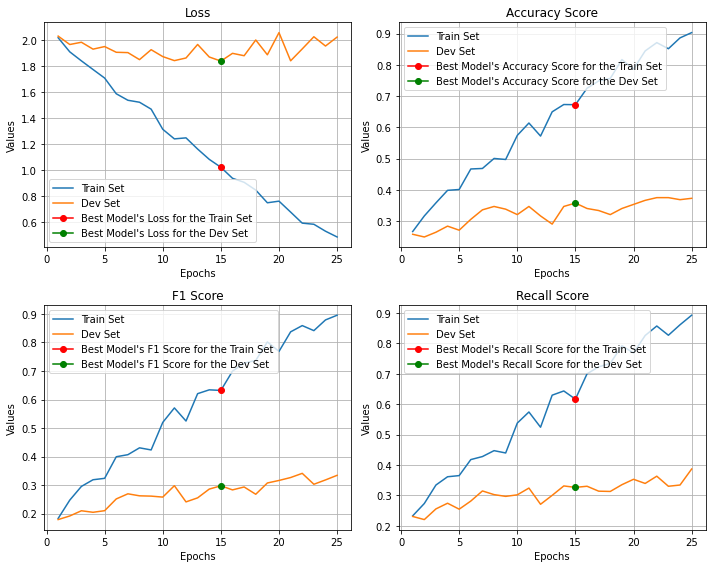

In [ ]:
EarlyCNNNet = CNN(layer_channels, hidden_features, out_features, kernels, dropout=dropout).to(device)
print(EarlyCNNNet)
# Make instance of our optimizer, with L2-Reguralization
# optimizer = optim.SGD(EarlyCNNNet.parameters(), lr=ETA, weight_decay=weight_decay)
optimizer = optim.Adam(EarlyCNNNet.parameters(), lr=ETA, weight_decay=weight_decay)

# Start the training process
clf_main(device, EarlyCNNNet, fused_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, net_name='EarlyCNN_beatFUSED', PATIENCE=PATIENCE, cnn=True)

In [ ]:
with open('./best_EarlyCNN_beatFUSED.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
test_loss, y_test_gold, y_test_pred = clf_eval(device, test_loader, fused_feats, E_model, criterion, cnn=True)

print(classification_report(y_test_gold, y_test_pred))

              precision    recall  f1-score   support

           0       0.08      0.03      0.04        40
           1       0.37      0.47      0.42        40
           2       0.34      0.54      0.42        80
           3       0.32      0.57      0.41        80
           4       0.40      0.20      0.27        40
           5       0.00      0.00      0.00        40
           6       0.53      0.38      0.44        78
           7       0.19      0.07      0.11        40
           8       0.36      0.46      0.40       103
           9       0.17      0.09      0.12        34

    accuracy                           0.35       575
   macro avg       0.28      0.28      0.26       575
weighted avg       0.31      0.35      0.31       575



### Training and Evalution using 'non-beat-synced datasets'

####  Mel Spectrograms Dataset

In [ ]:
data = SpectrogramDataset("data/fma_genre_spectrograms",
                                  class_mapping=class_mapping, train=True, read_spec_fn=read_mel_spectrogram)
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/fma_genre_spectrograms/',
                                              class_mapping=class_mapping, train=False, read_spec_fn=read_mel_spectrogram, max_length=data.max_length)

##### Normal Training

CNN(
  (conv_layer): Sequential(
    (0): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(4, 16, kernel_size=(4, 4), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

  0%|          | 0/100 [00:00<?, ?it/s]

 [================================--------] ...Epoch 1, Loss: 1.9876
Statistics for the Train Set
	 Epoch: 1 	 loss: 2.0781476066030304
	 Epoch: 1 	 Accuracy Score: 0.21908893709327548
	 Epoch: 1 	 f1 Score: 0.1383191976599961
	 Epoch: 1 	 recall Score: 0.18976333542246032


  1%|          | 1/100 [00:14<24:34, 14.89s/it]

Statistics for the Dev Set
	 Epoch: 1 	 loss: 2.1255381027857463
	 Epoch: 1 	 Accuracy Score: 0.19305856832971802
	 Epoch: 1 	 f1 Score: 0.11388068330829937
	 Epoch: 1 	 recall Score: 0.17732754949968066
Test loss decreased (inf --> 2.125538).  Saving model ...
Epoch total time 14.89417815208435
 [================================--------] ...Epoch 2, Loss: 2.1002
Statistics for the Train Set
	 Epoch: 2 	 loss: 2.040501025216333
	 Epoch: 2 	 Accuracy Score: 0.24295010845986983
	 Epoch: 2 	 f1 Score: 0.1420046544231673
	 Epoch: 2 	 recall Score: 0.2133866665750906


  2%|▏         | 2/100 [00:29<24:17, 14.87s/it]

Statistics for the Dev Set
	 Epoch: 2 	 loss: 2.1078792333602907
	 Epoch: 2 	 Accuracy Score: 0.21908893709327548
	 Epoch: 2 	 f1 Score: 0.1293125903782521
	 Epoch: 2 	 recall Score: 0.20760139450713222
Test loss decreased (2.125538 --> 2.107879).  Saving model ...
Epoch total time 14.855744123458862
 [================================--------] ...Epoch 3, Loss: 2.1697
Statistics for the Train Set
	 Epoch: 3 	 loss: 1.9246865634260506
	 Epoch: 3 	 Accuracy Score: 0.33676789587852496
	 Epoch: 3 	 f1 Score: 0.2407498903589315
	 Epoch: 3 	 recall Score: 0.29451708131014637


  3%|▎         | 3/100 [00:44<24:00, 14.85s/it]

Statistics for the Dev Set
	 Epoch: 3 	 loss: 2.0224295457204184
	 Epoch: 3 	 Accuracy Score: 0.27765726681127983
	 Epoch: 3 	 f1 Score: 0.18978084983535126
	 Epoch: 3 	 recall Score: 0.2565541221074008
Test loss decreased (2.107879 --> 2.022430).  Saving model ...
Epoch total time 14.83233904838562
 [================================--------] ...Epoch 4, Loss: 2.4637
Statistics for the Train Set
	 Epoch: 4 	 loss: 1.9246366126783963
	 Epoch: 4 	 Accuracy Score: 0.30422993492407807
	 Epoch: 4 	 f1 Score: 0.21508788998723488
	 Epoch: 4 	 recall Score: 0.27484837523898104


  4%|▍         | 4/100 [00:59<23:47, 14.87s/it]

Statistics for the Dev Set
	 Epoch: 4 	 loss: 2.0423803329467773
	 Epoch: 4 	 Accuracy Score: 0.27765726681127983
	 Epoch: 4 	 f1 Score: 0.19936137555001937
	 Epoch: 4 	 recall Score: 0.2560438787078131
EarlyStopping counter: 1 out of 10
Epoch total time 14.882017135620117
 [================================--------] ...Epoch 5, Loss: 1.8031
Statistics for the Train Set
	 Epoch: 5 	 loss: 1.8645330873028985
	 Epoch: 5 	 Accuracy Score: 0.34002169197396964
	 Epoch: 5 	 f1 Score: 0.21448704370891458
	 Epoch: 5 	 recall Score: 0.2823859960489297


  5%|▌         | 5/100 [01:14<23:31, 14.86s/it]

Statistics for the Dev Set
	 Epoch: 5 	 loss: 2.0602476676305135
	 Epoch: 5 	 Accuracy Score: 0.22342733188720174
	 Epoch: 5 	 f1 Score: 0.14511974996101015
	 Epoch: 5 	 recall Score: 0.1985128464431743
EarlyStopping counter: 2 out of 10
Epoch total time 14.835735321044922
 [================================--------] ...Epoch 6, Loss: 1.8043
Statistics for the Train Set
	 Epoch: 6 	 loss: 1.820545597323056
	 Epoch: 6 	 Accuracy Score: 0.35629067245119306
	 Epoch: 6 	 f1 Score: 0.24990345517988305
	 Epoch: 6 	 recall Score: 0.3286771092246749


  6%|▌         | 6/100 [01:29<23:17, 14.86s/it]

Statistics for the Dev Set
	 Epoch: 6 	 loss: 2.0350152492523192
	 Epoch: 6 	 Accuracy Score: 0.29718004338394793
	 Epoch: 6 	 f1 Score: 0.21303468598556918
	 Epoch: 6 	 recall Score: 0.27718594247282774
EarlyStopping counter: 3 out of 10
Epoch total time 14.875909566879272
 [================================--------] ...Epoch 7, Loss: 1.9042
Statistics for the Train Set
	 Epoch: 7 	 loss: 1.6942279585476578
	 Epoch: 7 	 Accuracy Score: 0.4007592190889371
	 Epoch: 7 	 f1 Score: 0.28021946195652375
	 Epoch: 7 	 recall Score: 0.3516566822541779


  7%|▋         | 7/100 [01:44<23:04, 14.88s/it]

Statistics for the Dev Set
	 Epoch: 7 	 loss: 1.9582925160725912
	 Epoch: 7 	 Accuracy Score: 0.3123644251626898
	 Epoch: 7 	 f1 Score: 0.22359002979905754
	 Epoch: 7 	 recall Score: 0.28804726011693227
Test loss decreased (2.022430 --> 1.958293).  Saving model ...
Epoch total time 14.919258832931519
 [================================--------] ...Epoch 8, Loss: 1.7707
Statistics for the Train Set
	 Epoch: 8 	 loss: 1.6254618578943714
	 Epoch: 8 	 Accuracy Score: 0.41594360086767895
	 Epoch: 8 	 f1 Score: 0.2950558261700907
	 Epoch: 8 	 recall Score: 0.36298912553763635


  8%|▊         | 8/100 [01:59<22:50, 14.90s/it]

Statistics for the Dev Set
	 Epoch: 8 	 loss: 2.035105093320211
	 Epoch: 8 	 Accuracy Score: 0.27765726681127983
	 Epoch: 8 	 f1 Score: 0.20078757269939618
	 Epoch: 8 	 recall Score: 0.25458825327677786
EarlyStopping counter: 1 out of 10
Epoch total time 14.94188380241394
 [================================--------] ...Epoch 9, Loss: 1.5567
Statistics for the Train Set
	 Epoch: 9 	 loss: 1.5677590514051503
	 Epoch: 9 	 Accuracy Score: 0.43058568329718006
	 Epoch: 9 	 f1 Score: 0.304956445160971
	 Epoch: 9 	 recall Score: 0.38181020360921647


  9%|▉         | 9/100 [02:13<22:36, 14.90s/it]

Statistics for the Dev Set
	 Epoch: 9 	 loss: 1.9419180313746134
	 Epoch: 9 	 Accuracy Score: 0.32537960954446854
	 Epoch: 9 	 f1 Score: 0.2345479406740198
	 Epoch: 9 	 recall Score: 0.3038552362937609
Test loss decreased (1.958293 --> 1.941918).  Saving model ...
Epoch total time 14.906822919845581
 [================================--------] ...Epoch 10, Loss: 1.5328
Statistics for the Train Set
	 Epoch: 10 	 loss: 1.4732132533500935
	 Epoch: 10 	 Accuracy Score: 0.470173535791757
	 Epoch: 10 	 f1 Score: 0.33250053204242935
	 Epoch: 10 	 recall Score: 0.399855144636612


 10%|█         | 10/100 [02:28<22:19, 14.88s/it]

Statistics for the Dev Set
	 Epoch: 10 	 loss: 1.9974911371866861
	 Epoch: 10 	 Accuracy Score: 0.3188720173535792
	 Epoch: 10 	 f1 Score: 0.23618923118376317
	 Epoch: 10 	 recall Score: 0.28162281707363673
EarlyStopping counter: 1 out of 10
Epoch total time 14.832594394683838
 [================================--------] ...Epoch 11, Loss: 1.6436
Statistics for the Train Set
	 Epoch: 11 	 loss: 1.4572729899965484
	 Epoch: 11 	 Accuracy Score: 0.4609544468546638
	 Epoch: 11 	 f1 Score: 0.3256998491476323
	 Epoch: 11 	 recall Score: 0.40037647880066674


 11%|█         | 11/100 [02:43<22:03, 14.87s/it]

Statistics for the Dev Set
	 Epoch: 11 	 loss: 2.008143981297811
	 Epoch: 11 	 Accuracy Score: 0.30151843817787416
	 Epoch: 11 	 f1 Score: 0.2151241609338857
	 Epoch: 11 	 recall Score: 0.2564732194035472
EarlyStopping counter: 2 out of 10
Epoch total time 14.828478336334229
 [================================--------] ...Epoch 12, Loss: 1.4516
Statistics for the Train Set
	 Epoch: 12 	 loss: 1.3884951225642501
	 Epoch: 12 	 Accuracy Score: 0.482646420824295
	 Epoch: 12 	 f1 Score: 0.33793264028313064
	 Epoch: 12 	 recall Score: 0.4079566959597548


 12%|█▏        | 12/100 [02:58<21:46, 14.85s/it]

Statistics for the Dev Set
	 Epoch: 12 	 loss: 1.995010224978129
	 Epoch: 12 	 Accuracy Score: 0.3275488069414317
	 Epoch: 12 	 f1 Score: 0.2426719816582203
	 Epoch: 12 	 recall Score: 0.2831745508589771
EarlyStopping counter: 3 out of 10
Epoch total time 14.801639318466187
 [================================--------] ...Epoch 13, Loss: 1.3016
Statistics for the Train Set
	 Epoch: 13 	 loss: 1.3642388643889591
	 Epoch: 13 	 Accuracy Score: 0.5227765726681128
	 Epoch: 13 	 f1 Score: 0.3680666337199122
	 Epoch: 13 	 recall Score: 0.4488584913553043


 13%|█▎        | 13/100 [03:13<21:32, 14.86s/it]

Statistics for the Dev Set
	 Epoch: 13 	 loss: 1.9186383803685507
	 Epoch: 13 	 Accuracy Score: 0.3080260303687636
	 Epoch: 13 	 f1 Score: 0.22257823042121952
	 Epoch: 13 	 recall Score: 0.28851482533859585
Test loss decreased (1.941918 --> 1.918638).  Saving model ...
Epoch total time 14.891148567199707
 [================================--------] ...Epoch 14, Loss: 1.3437
Statistics for the Train Set
	 Epoch: 14 	 loss: 1.257247422275872
	 Epoch: 14 	 Accuracy Score: 0.5276572668112798
	 Epoch: 14 	 f1 Score: 0.3732014281135497
	 Epoch: 14 	 recall Score: 0.44165015449930844


 14%|█▍        | 14/100 [03:28<21:17, 14.85s/it]

Statistics for the Dev Set
	 Epoch: 14 	 loss: 2.1194547096888225
	 Epoch: 14 	 Accuracy Score: 0.28633405639913234
	 Epoch: 14 	 f1 Score: 0.20485226782396593
	 Epoch: 14 	 recall Score: 0.23893668489979966
EarlyStopping counter: 1 out of 10
Epoch total time 14.83481764793396
 [================================--------] ...Epoch 15, Loss: 1.2999
Statistics for the Train Set
	 Epoch: 15 	 loss: 1.3098090321853244
	 Epoch: 15 	 Accuracy Score: 0.5151843817787418
	 Epoch: 15 	 f1 Score: 0.3694109035969816
	 Epoch: 15 	 recall Score: 0.44896421845747103


 15%|█▌        | 15/100 [03:43<21:02, 14.85s/it]

Statistics for the Dev Set
	 Epoch: 15 	 loss: 1.996595279375712
	 Epoch: 15 	 Accuracy Score: 0.3188720173535792
	 Epoch: 15 	 f1 Score: 0.22467568920174466
	 Epoch: 15 	 recall Score: 0.3018637919457592
EarlyStopping counter: 2 out of 10
Epoch total time 14.855257034301758
 [================================--------] ...Epoch 16, Loss: 1.5091
Statistics for the Train Set
	 Epoch: 16 	 loss: 1.2579610614941037
	 Epoch: 16 	 Accuracy Score: 0.5178958785249458
	 Epoch: 16 	 f1 Score: 0.36626259566329655
	 Epoch: 16 	 recall Score: 0.4373267600141223


 16%|█▌        | 16/100 [03:57<20:47, 14.86s/it]

Statistics for the Dev Set
	 Epoch: 16 	 loss: 2.014868982632955
	 Epoch: 16 	 Accuracy Score: 0.2993492407809111
	 Epoch: 16 	 f1 Score: 0.21220389660476072
	 Epoch: 16 	 recall Score: 0.2545555537358816
EarlyStopping counter: 3 out of 10
Epoch total time 14.856756687164307
 [================================--------] ...Epoch 17, Loss: 1.3060
Statistics for the Train Set
	 Epoch: 17 	 loss: 1.2575057847746487
	 Epoch: 17 	 Accuracy Score: 0.4891540130151844
	 Epoch: 17 	 f1 Score: 0.3537529469172972
	 Epoch: 17 	 recall Score: 0.4245904283265379


 17%|█▋        | 17/100 [04:12<20:33, 14.86s/it]

Statistics for the Dev Set
	 Epoch: 17 	 loss: 2.139904022216797
	 Epoch: 17 	 Accuracy Score: 0.2885032537960954
	 Epoch: 17 	 f1 Score: 0.21698362044277636
	 Epoch: 17 	 recall Score: 0.2580816610529725
EarlyStopping counter: 4 out of 10
Epoch total time 14.874503374099731
 [================================--------] ...Epoch 18, Loss: 1.1329
Statistics for the Train Set
	 Epoch: 18 	 loss: 1.1471214839096726
	 Epoch: 18 	 Accuracy Score: 0.5553145336225597
	 Epoch: 18 	 f1 Score: 0.3910194413237406
	 Epoch: 18 	 recall Score: 0.4652693603849866


 18%|█▊        | 18/100 [04:27<20:18, 14.86s/it]

Statistics for the Dev Set
	 Epoch: 18 	 loss: 2.055302309989929
	 Epoch: 18 	 Accuracy Score: 0.31670281995661603
	 Epoch: 18 	 f1 Score: 0.2400196560382737
	 Epoch: 18 	 recall Score: 0.27799040667893127
EarlyStopping counter: 5 out of 10
Epoch total time 14.86446738243103
 [================================--------] ...Epoch 19, Loss: 1.4432
Statistics for the Train Set
	 Epoch: 19 	 loss: 1.1621766295926323
	 Epoch: 19 	 Accuracy Score: 0.5357917570498916
	 Epoch: 19 	 f1 Score: 0.3812367644943134
	 Epoch: 19 	 recall Score: 0.45199974276294885


 19%|█▉        | 19/100 [04:42<20:01, 14.84s/it]

Statistics for the Dev Set
	 Epoch: 19 	 loss: 2.1098812103271483
	 Epoch: 19 	 Accuracy Score: 0.32537960954446854
	 Epoch: 19 	 f1 Score: 0.2326194500200732
	 Epoch: 19 	 recall Score: 0.2692114784122981
EarlyStopping counter: 6 out of 10
Epoch total time 14.771005868911743
 [================================--------] ...Epoch 20, Loss: 1.1484
Statistics for the Train Set
	 Epoch: 20 	 loss: 1.0744099329257835
	 Epoch: 20 	 Accuracy Score: 0.5542299349240781
	 Epoch: 20 	 f1 Score: 0.3989025857950897
	 Epoch: 20 	 recall Score: 0.4683402329877039


 20%|██        | 20/100 [04:57<19:47, 14.84s/it]

Statistics for the Dev Set
	 Epoch: 20 	 loss: 2.1810420036315916
	 Epoch: 20 	 Accuracy Score: 0.28633405639913234
	 Epoch: 20 	 f1 Score: 0.2054509687184681
	 Epoch: 20 	 recall Score: 0.2400700733692537
EarlyStopping counter: 7 out of 10
Epoch total time 14.859329223632812
 [================================--------] ...Epoch 21, Loss: 1.1973
Statistics for the Train Set
	 Epoch: 21 	 loss: 1.093208948086048
	 Epoch: 21 	 Accuracy Score: 0.5677874186550976
	 Epoch: 21 	 f1 Score: 0.4078373016927424
	 Epoch: 21 	 recall Score: 0.48063350170411556


 21%|██        | 21/100 [05:12<19:32, 14.84s/it]

Statistics for the Dev Set
	 Epoch: 21 	 loss: 2.0569550434748334
	 Epoch: 21 	 Accuracy Score: 0.2993492407809111
	 Epoch: 21 	 f1 Score: 0.21902774608940945
	 Epoch: 21 	 recall Score: 0.2562447894577629
EarlyStopping counter: 8 out of 10
Epoch total time 14.813680171966553
 [================================--------] ...Epoch 22, Loss: 1.0210
Statistics for the Train Set
	 Epoch: 22 	 loss: 1.0167202939247262
	 Epoch: 22 	 Accuracy Score: 0.5856832971800434
	 Epoch: 22 	 f1 Score: 0.4151300309750076
	 Epoch: 22 	 recall Score: 0.4933863906847188


 22%|██▏       | 22/100 [05:26<19:16, 14.83s/it]

Statistics for the Dev Set
	 Epoch: 22 	 loss: 2.1140984217325847
	 Epoch: 22 	 Accuracy Score: 0.2928416485900217
	 Epoch: 22 	 f1 Score: 0.21293694589417128
	 Epoch: 22 	 recall Score: 0.2613891027005781
EarlyStopping counter: 9 out of 10
Epoch total time 14.811630725860596
 [================================--------] ...Epoch 23, Loss: 1.2282
Statistics for the Train Set
	 Epoch: 23 	 loss: 1.0650859649839073
	 Epoch: 23 	 Accuracy Score: 0.5488069414316703
	 Epoch: 23 	 f1 Score: 0.3941500851678206
	 Epoch: 23 	 recall Score: 0.4598820662890655


 22%|██▏       | 22/100 [05:41<20:11, 15.53s/it]

Statistics for the Dev Set
	 Epoch: 23 	 loss: 2.3430329958597818
	 Epoch: 23 	 Accuracy Score: 0.279826464208243
	 Epoch: 23 	 f1 Score: 0.20613565522866417
	 Epoch: 23 	 recall Score: 0.22853402062418454
EarlyStopping counter: 10 out of 10
Training total time 326.83919763565063


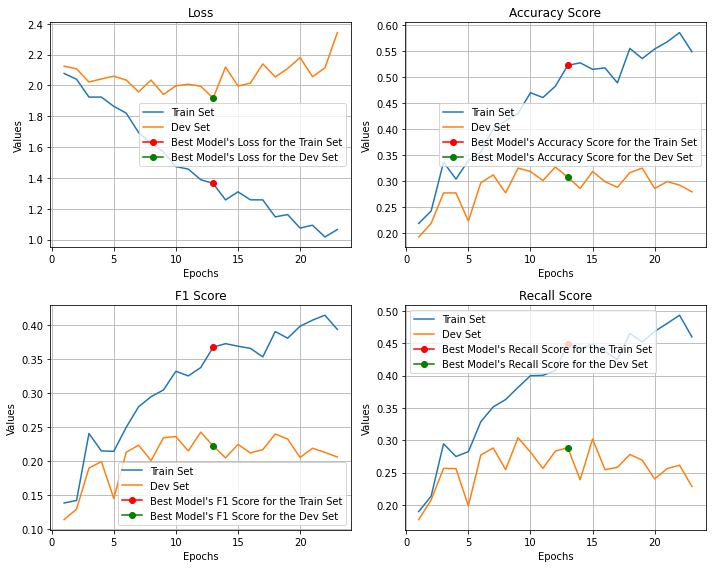

In [ ]:
EarlyCNNNet = CNN(layer_channels, hidden_features, out_features, kernels, dropout=dropout).to(device)
print(EarlyCNNNet)
# Make instance of our optimizer, with L2-Reguralization
# optimizer = optim.SGD(EarlyCNNNet.parameters(), lr=ETA, weight_decay=weight_decay)
optimizer = optim.Adam(EarlyCNNNet.parameters(), lr=ETA, weight_decay=weight_decay)

# Start the training process
clf_main(device, EarlyCNNNet, mels_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, net_name='EarlyCNN_nonbeatMEL', PATIENCE=PATIENCE, cnn=True)

In [ ]:
with open('./best_EarlyCNN_nonbeatMEL.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
test_loss, y_test_gold, y_test_pred = clf_eval(device, test_loader, mels_feats, E_model, criterion, cnn=True)

print(classification_report(y_test_gold, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.33      0.42      0.37        40
           2       0.40      0.36      0.38        80
           3       0.29      0.38      0.32        80
           4       0.21      0.68      0.32        40
           5       0.00      0.00      0.00        40
           6       0.34      0.37      0.36        78
           7       0.00      0.00      0.00        40
           8       0.31      0.39      0.34       103
           9       0.00      0.00      0.00        34

    accuracy                           0.30       575
   macro avg       0.19      0.26      0.21       575
weighted avg       0.24      0.30      0.26       575



#### Chromagrams Dataset

In [ ]:
data = SpectrogramDataset("data/fma_genre_spectrograms",
                                    class_mapping=class_mapping, train=True, read_spec_fn=read_chromagram)
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/fma_genre_spectrograms/',
                                                class_mapping=class_mapping, train=False, read_spec_fn=read_chromagram, max_length=data.max_length)

##### Normal Training

CNN(
  (conv_layer): Sequential(
    (0): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
  )
  (fc): FullyConnectedLayer(
    (fc1): LazyLinear(in_features=0, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=10, bias=True)
  )
)


  0%|          | 0/100 [00:00<?, ?it/s]

 [================================--------] ...Epoch 1, Loss: 2.1683
Statistics for the Train Set
	 Epoch: 1 	 loss: 2.1725059747695923
	 Epoch: 1 	 Accuracy Score: 0.20607375271149675
	 Epoch: 1 	 f1 Score: 0.1035680809305346
	 Epoch: 1 	 recall Score: 0.13873996538370445


  1%|          | 1/100 [00:03<05:13,  3.17s/it]

Statistics for the Dev Set
	 Epoch: 1 	 loss: 2.219698111216227
	 Epoch: 1 	 Accuracy Score: 0.1648590021691974
	 Epoch: 1 	 f1 Score: 0.08268270286008646
	 Epoch: 1 	 recall Score: 0.11551602502434219
Test loss decreased (inf --> 2.219698).  Saving model ...
Epoch total time 3.167552947998047
 [================================--------] ...Epoch 2, Loss: 2.1639
Statistics for the Train Set
	 Epoch: 2 	 loss: 2.151169986560427
	 Epoch: 2 	 Accuracy Score: 0.210412147505423
	 Epoch: 2 	 f1 Score: 0.0987708315293078
	 Epoch: 2 	 recall Score: 0.1356092037899553


  2%|▏         | 2/100 [00:06<05:07,  3.14s/it]

Statistics for the Dev Set
	 Epoch: 2 	 loss: 2.209165938695272
	 Epoch: 2 	 Accuracy Score: 0.19305856832971802
	 Epoch: 2 	 f1 Score: 0.09434283300784106
	 Epoch: 2 	 recall Score: 0.12860988879643442
Test loss decreased (2.219698 --> 2.209166).  Saving model ...
Epoch total time 3.114291191101074
 [================================--------] ...Epoch 3, Loss: 2.1703
Statistics for the Train Set
	 Epoch: 3 	 loss: 2.091153163334419
	 Epoch: 3 	 Accuracy Score: 0.2304772234273319
	 Epoch: 3 	 f1 Score: 0.10628600912991823
	 Epoch: 3 	 recall Score: 0.14503021405105604


  3%|▎         | 3/100 [00:09<05:05,  3.15s/it]

Statistics for the Dev Set
	 Epoch: 3 	 loss: 2.2043766895929973
	 Epoch: 3 	 Accuracy Score: 0.19305856832971802
	 Epoch: 3 	 f1 Score: 0.09149605366941058
	 Epoch: 3 	 recall Score: 0.1281260645798611
Test loss decreased (2.209166 --> 2.204377).  Saving model ...
Epoch total time 3.1631908416748047
 [================================--------] ...Epoch 4, Loss: 2.0596
Statistics for the Train Set
	 Epoch: 4 	 loss: 2.067182431960928
	 Epoch: 4 	 Accuracy Score: 0.2472885032537961
	 Epoch: 4 	 f1 Score: 0.11904767939602663
	 Epoch: 4 	 recall Score: 0.175917453817137


  4%|▍         | 4/100 [00:12<05:01,  3.14s/it]

Statistics for the Dev Set
	 Epoch: 4 	 loss: 2.205547746022542
	 Epoch: 4 	 Accuracy Score: 0.2039045553145336
	 Epoch: 4 	 f1 Score: 0.08934074980960735
	 Epoch: 4 	 recall Score: 0.1448574077266946
EarlyStopping counter: 1 out of 10
Epoch total time 3.127695083618164
 [================================--------] ...Epoch 5, Loss: 1.9121
Statistics for the Train Set
	 Epoch: 5 	 loss: 2.0181913170321235
	 Epoch: 5 	 Accuracy Score: 0.29392624728850325
	 Epoch: 5 	 f1 Score: 0.16694153206889834
	 Epoch: 5 	 recall Score: 0.19924737499262987


  5%|▌         | 5/100 [00:15<04:57,  3.13s/it]

Statistics for the Dev Set
	 Epoch: 5 	 loss: 2.2196534792582194
	 Epoch: 5 	 Accuracy Score: 0.18004338394793926
	 Epoch: 5 	 f1 Score: 0.09373942266774209
	 Epoch: 5 	 recall Score: 0.12230946303990331
EarlyStopping counter: 2 out of 10
Epoch total time 3.1134815216064453
 [================================--------] ...Epoch 6, Loss: 1.8781
Statistics for the Train Set
	 Epoch: 6 	 loss: 1.9647950530052185
	 Epoch: 6 	 Accuracy Score: 0.29663774403470716
	 Epoch: 6 	 f1 Score: 0.14571725048145293
	 Epoch: 6 	 recall Score: 0.20293314245759514


  6%|▌         | 6/100 [00:18<04:52,  3.11s/it]

Statistics for the Dev Set
	 Epoch: 6 	 loss: 2.2431229750315347
	 Epoch: 6 	 Accuracy Score: 0.20607375271149675
	 Epoch: 6 	 f1 Score: 0.09014615979843818
	 Epoch: 6 	 recall Score: 0.1415674030539959
EarlyStopping counter: 3 out of 10
Epoch total time 3.0707788467407227
 [================================--------] ...Epoch 7, Loss: 2.0070
Statistics for the Train Set
	 Epoch: 7 	 loss: 1.9083877801895142
	 Epoch: 7 	 Accuracy Score: 0.3286334056399132
	 Epoch: 7 	 f1 Score: 0.1915826436087455
	 Epoch: 7 	 recall Score: 0.22748810318355533


  7%|▋         | 7/100 [00:21<04:47,  3.09s/it]

Statistics for the Dev Set
	 Epoch: 7 	 loss: 2.239854097366333
	 Epoch: 7 	 Accuracy Score: 0.18004338394793926
	 Epoch: 7 	 f1 Score: 0.10036370845530804
	 Epoch: 7 	 recall Score: 0.12548559344657892
EarlyStopping counter: 4 out of 10
Epoch total time 3.046926498413086
 [================================--------] ...Epoch 8, Loss: 1.9255
Statistics for the Train Set
	 Epoch: 8 	 loss: 1.8872479899176235
	 Epoch: 8 	 Accuracy Score: 0.35032537960954446
	 Epoch: 8 	 f1 Score: 0.23226555433475832
	 Epoch: 8 	 recall Score: 0.2620673900992272


  8%|▊         | 8/100 [00:24<04:43,  3.09s/it]

Statistics for the Dev Set
	 Epoch: 8 	 loss: 2.230879521369934
	 Epoch: 8 	 Accuracy Score: 0.21475054229934923
	 Epoch: 8 	 f1 Score: 0.11877250664554091
	 Epoch: 8 	 recall Score: 0.15385753484877168
EarlyStopping counter: 5 out of 10
Epoch total time 3.0686683654785156
 [================================--------] ...Epoch 9, Loss: 1.7967
Statistics for the Train Set
	 Epoch: 9 	 loss: 1.840255685921373
	 Epoch: 9 	 Accuracy Score: 0.3421908893709328
	 Epoch: 9 	 f1 Score: 0.2194548347006887
	 Epoch: 9 	 recall Score: 0.24658957008153046


  9%|▉         | 9/100 [00:28<04:41,  3.09s/it]

Statistics for the Dev Set
	 Epoch: 9 	 loss: 2.2147987842559815
	 Epoch: 9 	 Accuracy Score: 0.18655097613882862
	 Epoch: 9 	 f1 Score: 0.10680592445536945
	 Epoch: 9 	 recall Score: 0.1292063621504247
EarlyStopping counter: 6 out of 10
Epoch total time 3.112952947616577
 [================================--------] ...Epoch 10, Loss: 1.8413
Statistics for the Train Set
	 Epoch: 10 	 loss: 1.7625895019235283
	 Epoch: 10 	 Accuracy Score: 0.40401301518438176
	 Epoch: 10 	 f1 Score: 0.30795180345271334
	 Epoch: 10 	 recall Score: 0.3121379299337006


 10%|█         | 10/100 [00:31<04:40,  3.12s/it]

Statistics for the Dev Set
	 Epoch: 10 	 loss: 2.2612281322479246
	 Epoch: 10 	 Accuracy Score: 0.19088937093275488
	 Epoch: 10 	 f1 Score: 0.10865476769220087
	 Epoch: 10 	 recall Score: 0.13315130811588807
EarlyStopping counter: 7 out of 10
Epoch total time 3.1785237789154053
 [================================--------] ...Epoch 11, Loss: 1.6152
Statistics for the Train Set
	 Epoch: 11 	 loss: 1.7236506199014598
	 Epoch: 11 	 Accuracy Score: 0.3958785249457701
	 Epoch: 11 	 f1 Score: 0.28155441509770557
	 Epoch: 11 	 recall Score: 0.2929758737700944


 11%|█         | 11/100 [00:34<04:36,  3.11s/it]

Statistics for the Dev Set
	 Epoch: 11 	 loss: 2.281201791763306
	 Epoch: 11 	 Accuracy Score: 0.19522776572668113
	 Epoch: 11 	 f1 Score: 0.09776768063361413
	 Epoch: 11 	 recall Score: 0.13019755732013696
EarlyStopping counter: 8 out of 10
Epoch total time 3.0766987800598145
 [================================--------] ...Epoch 12, Loss: 1.7871
Statistics for the Train Set
	 Epoch: 12 	 loss: 1.6610950560405338
	 Epoch: 12 	 Accuracy Score: 0.46963123644251625
	 Epoch: 12 	 f1 Score: 0.3619089241347503
	 Epoch: 12 	 recall Score: 0.37393687906085166


 12%|█▏        | 12/100 [00:37<04:33,  3.11s/it]

Statistics for the Dev Set
	 Epoch: 12 	 loss: 2.2464443604151407
	 Epoch: 12 	 Accuracy Score: 0.19739696312364424
	 Epoch: 12 	 f1 Score: 0.1124643643650961
	 Epoch: 12 	 recall Score: 0.1409741190639286
EarlyStopping counter: 9 out of 10
Epoch total time 3.1032614707946777
 [================================--------] ...Epoch 13, Loss: 1.6896
Statistics for the Train Set
	 Epoch: 13 	 loss: 1.621811315931123
	 Epoch: 13 	 Accuracy Score: 0.43980477223427333
	 Epoch: 13 	 f1 Score: 0.2975018980498945
	 Epoch: 13 	 recall Score: 0.3244669766005105


 12%|█▏        | 12/100 [00:40<04:56,  3.37s/it]

Statistics for the Dev Set
	 Epoch: 13 	 loss: 2.293492150306702
	 Epoch: 13 	 Accuracy Score: 0.17787418655097614
	 Epoch: 13 	 f1 Score: 0.10489458207249083
	 Epoch: 13 	 recall Score: 0.12942244413095022
EarlyStopping counter: 10 out of 10
Training total time 37.344022274017334


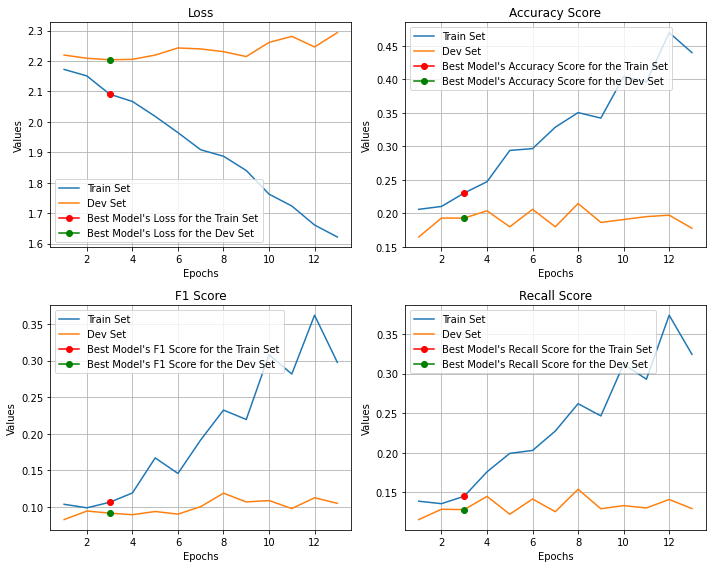

In [ ]:
EarlyCNNNet = CNN(layer_channels, hidden_features, out_features, kernels, dropout=dropout, chroma=True).to(device)
print(EarlyCNNNet)
# Make instance of our optimizer, with L2-Reguralization
# optimizer = optim.SGD(EarlyCNNNet.parameters(), lr=ETA, weight_decay=weight_decay)
optimizer = optim.Adam(EarlyCNNNet.parameters(), lr=ETA, weight_decay=weight_decay)

# Start the training process
clf_main(device, EarlyCNNNet, chroma_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, net_name='EarlyCNN_nonbeatCHROMA', PATIENCE=PATIENCE, cnn=True)

In [ ]:
with open('./best_EarlyCNN_nonbeatCHROMA.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
test_loss, y_test_gold, y_test_pred = clf_eval(device, test_loader, chroma_feats, E_model, criterion, cnn=True)

print(classification_report(y_test_gold, y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        40
           2       0.20      0.01      0.02        80
           3       0.26      0.36      0.30        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.26      0.19      0.22        78
           7       0.00      0.00      0.00        40
           8       0.16      0.63      0.26       103
           9       0.00      0.00      0.00        34

    accuracy                           0.19       575
   macro avg       0.09      0.12      0.08       575
weighted avg       0.13      0.19      0.12       575



#### Mel Spectrograms + Chromagrams Dataset

In [ ]:
data = SpectrogramDataset("data/fma_genre_spectrograms_beat",
                                    class_mapping=class_mapping, train=True, read_spec_fn=read_fused_spectrogram)
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/fma_genre_spectrograms/',
                                                class_mapping=class_mapping, train=False, read_spec_fn=read_fused_spectrogram, max_length=data.max_length)

##### Normal Training

CNN(
  (conv_layer): Sequential(
    (0): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(4, 16, kernel_size=(4, 4), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

  0%|          | 0/100 [00:00<?, ?it/s]

 [================================--------] ...Epoch 1, Loss: 2.0799
Statistics for the Train Set
	 Epoch: 1 	 loss: 2.0384166466778724
	 Epoch: 1 	 Accuracy Score: 0.24945770065075923
	 Epoch: 1 	 f1 Score: 0.16978644799498846
	 Epoch: 1 	 recall Score: 0.1907209736548625


  1%|          | 1/100 [00:07<11:40,  7.08s/it]

Statistics for the Dev Set
	 Epoch: 1 	 loss: 2.0894459088643393
	 Epoch: 1 	 Accuracy Score: 0.210412147505423
	 Epoch: 1 	 f1 Score: 0.14218382007666786
	 Epoch: 1 	 recall Score: 0.1602279460735343
Test loss decreased (inf --> 2.089446).  Saving model ...
Epoch total time 7.077898979187012
 [================================--------] ...Epoch 2, Loss: 1.9701
Statistics for the Train Set
	 Epoch: 2 	 loss: 1.9378509768124283
	 Epoch: 2 	 Accuracy Score: 0.3009761388286334
	 Epoch: 2 	 f1 Score: 0.22721193716860394
	 Epoch: 2 	 recall Score: 0.24434894074840532


  2%|▏         | 2/100 [00:14<11:38,  7.12s/it]

Statistics for the Dev Set
	 Epoch: 2 	 loss: 2.0180888096491496
	 Epoch: 2 	 Accuracy Score: 0.23644251626898047
	 Epoch: 2 	 f1 Score: 0.19394405722494118
	 Epoch: 2 	 recall Score: 0.20580794975896968
Test loss decreased (2.089446 --> 2.018089).  Saving model ...
Epoch total time 7.150989055633545
 [================================--------] ...Epoch 3, Loss: 2.0482
Statistics for the Train Set
	 Epoch: 3 	 loss: 1.8806575536727905
	 Epoch: 3 	 Accuracy Score: 0.32049891540130154
	 Epoch: 3 	 f1 Score: 0.23433229362781058
	 Epoch: 3 	 recall Score: 0.26533059397593795


  3%|▎         | 3/100 [00:21<11:32,  7.14s/it]

Statistics for the Dev Set
	 Epoch: 3 	 loss: 1.9569532553354898
	 Epoch: 3 	 Accuracy Score: 0.2950108459869848
	 Epoch: 3 	 f1 Score: 0.2509013985286541
	 Epoch: 3 	 recall Score: 0.2696769701442377
Test loss decreased (2.018089 --> 1.956953).  Saving model ...
Epoch total time 7.158933162689209
 [================================--------] ...Epoch 4, Loss: 1.9228
Statistics for the Train Set
	 Epoch: 4 	 loss: 1.7682748313607841
	 Epoch: 4 	 Accuracy Score: 0.39370932754880694
	 Epoch: 4 	 f1 Score: 0.33131789376259024
	 Epoch: 4 	 recall Score: 0.3494106102804412


  4%|▍         | 4/100 [00:28<11:20,  7.09s/it]

Statistics for the Dev Set
	 Epoch: 4 	 loss: 1.898168190320333
	 Epoch: 4 	 Accuracy Score: 0.3275488069414317
	 Epoch: 4 	 f1 Score: 0.288566045103582
	 Epoch: 4 	 recall Score: 0.30993144347745866
Test loss decreased (1.956953 --> 1.898168).  Saving model ...
Epoch total time 7.0190088748931885
 [================================--------] ...Epoch 5, Loss: 1.5023
Statistics for the Train Set
	 Epoch: 5 	 loss: 1.7350986784902112
	 Epoch: 5 	 Accuracy Score: 0.39642082429501085
	 Epoch: 5 	 f1 Score: 0.3412158545029146
	 Epoch: 5 	 recall Score: 0.3588274933796169


  5%|▌         | 5/100 [00:35<11:09,  7.05s/it]

Statistics for the Dev Set
	 Epoch: 5 	 loss: 1.9072208245595297
	 Epoch: 5 	 Accuracy Score: 0.3297180043383948
	 Epoch: 5 	 f1 Score: 0.2778946824235512
	 Epoch: 5 	 recall Score: 0.29670917201099833
EarlyStopping counter: 1 out of 10
Epoch total time 6.97824501991272
 [================================--------] ...Epoch 6, Loss: 1.5350
Statistics for the Train Set
	 Epoch: 6 	 loss: 1.6779719406160816
	 Epoch: 6 	 Accuracy Score: 0.41865509761388287
	 Epoch: 6 	 f1 Score: 0.34909664638095966
	 Epoch: 6 	 recall Score: 0.34991381442669656


  6%|▌         | 6/100 [00:42<11:08,  7.11s/it]

Statistics for the Dev Set
	 Epoch: 6 	 loss: 1.8906936248143513
	 Epoch: 6 	 Accuracy Score: 0.3405639913232104
	 Epoch: 6 	 f1 Score: 0.2847684670957995
	 Epoch: 6 	 recall Score: 0.2991923162226767
Test loss decreased (1.898168 --> 1.890694).  Saving model ...
Epoch total time 7.219210147857666
 [================================--------] ...Epoch 7, Loss: 1.6921
Statistics for the Train Set
	 Epoch: 7 	 loss: 1.5755228729083621
	 Epoch: 7 	 Accuracy Score: 0.44848156182212584
	 Epoch: 7 	 f1 Score: 0.3816480125101286
	 Epoch: 7 	 recall Score: 0.3848967759443175


  7%|▋         | 7/100 [00:49<10:58,  7.08s/it]

Statistics for the Dev Set
	 Epoch: 7 	 loss: 1.826352802912394
	 Epoch: 7 	 Accuracy Score: 0.3796095444685466
	 Epoch: 7 	 f1 Score: 0.3227343384684628
	 Epoch: 7 	 recall Score: 0.33965204723328535
Test loss decreased (1.890694 --> 1.826353).  Saving model ...
Epoch total time 7.01396369934082
 [================================--------] ...Epoch 8, Loss: 1.4270
Statistics for the Train Set
	 Epoch: 8 	 loss: 1.5163447322516606
	 Epoch: 8 	 Accuracy Score: 0.477765726681128
	 Epoch: 8 	 f1 Score: 0.4284701856201938
	 Epoch: 8 	 recall Score: 0.4286328731993042


  8%|▊         | 8/100 [00:56<10:51,  7.08s/it]

Statistics for the Dev Set
	 Epoch: 8 	 loss: 1.8649093866348267
	 Epoch: 8 	 Accuracy Score: 0.34490238611713664
	 Epoch: 8 	 f1 Score: 0.2944818431241566
	 Epoch: 8 	 recall Score: 0.31509303572515146
EarlyStopping counter: 1 out of 10
Epoch total time 7.088281869888306
 [================================--------] ...Epoch 9, Loss: 1.5779
Statistics for the Train Set
	 Epoch: 9 	 loss: 1.489978605303271
	 Epoch: 9 	 Accuracy Score: 0.47993492407809113
	 Epoch: 9 	 f1 Score: 0.4214800547886458
	 Epoch: 9 	 recall Score: 0.4256572212441796


  9%|▉         | 9/100 [01:03<10:42,  7.06s/it]

Statistics for the Dev Set
	 Epoch: 9 	 loss: 1.9027933994928996
	 Epoch: 9 	 Accuracy Score: 0.3492407809110629
	 Epoch: 9 	 f1 Score: 0.28107364346009
	 Epoch: 9 	 recall Score: 0.3103547030189583
EarlyStopping counter: 2 out of 10
Epoch total time 7.001763343811035
 [================================--------] ...Epoch 10, Loss: 1.6743
Statistics for the Train Set
	 Epoch: 10 	 loss: 1.4269145768264244
	 Epoch: 10 	 Accuracy Score: 0.5330802603036876
	 Epoch: 10 	 f1 Score: 0.48241888470390587
	 Epoch: 10 	 recall Score: 0.48571267273956825


 10%|█         | 10/100 [01:10<10:39,  7.11s/it]

Statistics for the Dev Set
	 Epoch: 10 	 loss: 1.824499750137329
	 Epoch: 10 	 Accuracy Score: 0.3644251626898048
	 Epoch: 10 	 f1 Score: 0.3041038264114019
	 Epoch: 10 	 recall Score: 0.3289666810604903
Test loss decreased (1.826353 --> 1.824500).  Saving model ...
Epoch total time 7.22223424911499
 [================================--------] ...Epoch 11, Loss: 1.2071
Statistics for the Train Set
	 Epoch: 11 	 loss: 1.3661253020681183
	 Epoch: 11 	 Accuracy Score: 0.5466377440347071
	 Epoch: 11 	 f1 Score: 0.5066695785058755
	 Epoch: 11 	 recall Score: 0.5082058052953882


 11%|█         | 11/100 [01:17<10:30,  7.08s/it]

Statistics for the Dev Set
	 Epoch: 11 	 loss: 1.871523420015971
	 Epoch: 11 	 Accuracy Score: 0.3557483731019523
	 Epoch: 11 	 f1 Score: 0.3156340484076766
	 Epoch: 11 	 recall Score: 0.33871570733465894
EarlyStopping counter: 1 out of 10
Epoch total time 7.018934965133667
 [================================--------] ...Epoch 12, Loss: 1.2684
Statistics for the Train Set
	 Epoch: 12 	 loss: 1.2506261992043461
	 Epoch: 12 	 Accuracy Score: 0.6030368763557483
	 Epoch: 12 	 f1 Score: 0.5575439884043064
	 Epoch: 12 	 recall Score: 0.5507331365786892


 12%|█▏        | 12/100 [01:25<10:25,  7.11s/it]

Statistics for the Dev Set
	 Epoch: 12 	 loss: 1.8353288412094115
	 Epoch: 12 	 Accuracy Score: 0.3600867678958785
	 Epoch: 12 	 f1 Score: 0.3142781031826599
	 Epoch: 12 	 recall Score: 0.3357117295708377
EarlyStopping counter: 2 out of 10
Epoch total time 7.155255556106567
 [================================--------] ...Epoch 13, Loss: 1.5417
Statistics for the Train Set
	 Epoch: 13 	 loss: 1.2391827969715512
	 Epoch: 13 	 Accuracy Score: 0.6122559652928417
	 Epoch: 13 	 f1 Score: 0.5793223596869557
	 Epoch: 13 	 recall Score: 0.5768219425865684


 13%|█▎        | 13/100 [01:32<10:20,  7.14s/it]

Statistics for the Dev Set
	 Epoch: 13 	 loss: 1.868954316775004
	 Epoch: 13 	 Accuracy Score: 0.3969631236442516
	 Epoch: 13 	 f1 Score: 0.3469373495710185
	 Epoch: 13 	 recall Score: 0.36982308727564894
EarlyStopping counter: 3 out of 10
Epoch total time 7.2042646408081055
 [================================--------] ...Epoch 14, Loss: 1.0529
Statistics for the Train Set
	 Epoch: 14 	 loss: 1.195834336609676
	 Epoch: 14 	 Accuracy Score: 0.6301518438177874
	 Epoch: 14 	 f1 Score: 0.5993028310433146
	 Epoch: 14 	 recall Score: 0.5829070168894189


 14%|█▍        | 14/100 [01:39<10:15,  7.15s/it]

Statistics for the Dev Set
	 Epoch: 14 	 loss: 1.8706360896428427
	 Epoch: 14 	 Accuracy Score: 0.34490238611713664
	 Epoch: 14 	 f1 Score: 0.29759941418941305
	 Epoch: 14 	 recall Score: 0.30959013335673674
EarlyStopping counter: 4 out of 10
Epoch total time 7.189877271652222
 [================================--------] ...Epoch 15, Loss: 1.5679
Statistics for the Train Set
	 Epoch: 15 	 loss: 1.100921797341314
	 Epoch: 15 	 Accuracy Score: 0.636117136659436
	 Epoch: 15 	 f1 Score: 0.5862647168943435
	 Epoch: 15 	 recall Score: 0.5673961822976008


 15%|█▌        | 15/100 [01:46<10:06,  7.14s/it]

Statistics for the Dev Set
	 Epoch: 15 	 loss: 1.9257163604100545
	 Epoch: 15 	 Accuracy Score: 0.38177874186550975
	 Epoch: 15 	 f1 Score: 0.3127440565260934
	 Epoch: 15 	 recall Score: 0.3385332530084665
EarlyStopping counter: 5 out of 10
Epoch total time 7.098714113235474
 [================================--------] ...Epoch 16, Loss: 1.1022
Statistics for the Train Set
	 Epoch: 16 	 loss: 1.037596895776946
	 Epoch: 16 	 Accuracy Score: 0.6800433839479393
	 Epoch: 16 	 f1 Score: 0.6386225463365135
	 Epoch: 16 	 recall Score: 0.6184966085571932


 16%|█▌        | 16/100 [01:53<10:00,  7.15s/it]

Statistics for the Dev Set
	 Epoch: 16 	 loss: 1.8822211980819703
	 Epoch: 16 	 Accuracy Score: 0.39045553145336226
	 Epoch: 16 	 f1 Score: 0.31733277752519673
	 Epoch: 16 	 recall Score: 0.3456721802576878
EarlyStopping counter: 6 out of 10
Epoch total time 7.167402982711792
 [================================--------] ...Epoch 17, Loss: 0.9885
Statistics for the Train Set
	 Epoch: 17 	 loss: 1.0092918112360199
	 Epoch: 17 	 Accuracy Score: 0.6800433839479393
	 Epoch: 17 	 f1 Score: 0.6529976337612374
	 Epoch: 17 	 recall Score: 0.6282187707323064


 17%|█▋        | 17/100 [02:00<09:49,  7.11s/it]

Statistics for the Dev Set
	 Epoch: 17 	 loss: 1.904810357093811
	 Epoch: 17 	 Accuracy Score: 0.368763557483731
	 Epoch: 17 	 f1 Score: 0.33801799068289323
	 Epoch: 17 	 recall Score: 0.3459093120934914
EarlyStopping counter: 7 out of 10
Epoch total time 7.016040086746216
 [================================--------] ...Epoch 18, Loss: 1.1096
Statistics for the Train Set
	 Epoch: 18 	 loss: 0.9441613966021044
	 Epoch: 18 	 Accuracy Score: 0.7369848156182213
	 Epoch: 18 	 f1 Score: 0.7239083093265676
	 Epoch: 18 	 recall Score: 0.7075924993622691


 18%|█▊        | 18/100 [02:07<09:41,  7.09s/it]

Statistics for the Dev Set
	 Epoch: 18 	 loss: 1.9301239411036173
	 Epoch: 18 	 Accuracy Score: 0.368763557483731
	 Epoch: 18 	 f1 Score: 0.32301145117113833
	 Epoch: 18 	 recall Score: 0.3463180060138077
EarlyStopping counter: 8 out of 10
Epoch total time 7.046939849853516
 [================================--------] ...Epoch 19, Loss: 0.8648
Statistics for the Train Set
	 Epoch: 19 	 loss: 0.8763030952420728
	 Epoch: 19 	 Accuracy Score: 0.7613882863340564
	 Epoch: 19 	 f1 Score: 0.7294888319686501
	 Epoch: 19 	 recall Score: 0.7076879710323858


 19%|█▉        | 19/100 [02:14<09:34,  7.09s/it]

Statistics for the Dev Set
	 Epoch: 19 	 loss: 1.9036936203638712
	 Epoch: 19 	 Accuracy Score: 0.36225596529284165
	 Epoch: 19 	 f1 Score: 0.3053831423069743
	 Epoch: 19 	 recall Score: 0.32690030953669474
EarlyStopping counter: 9 out of 10
Epoch total time 7.087462902069092
 [================================--------] ...Epoch 20, Loss: 1.2032
Statistics for the Train Set
	 Epoch: 20 	 loss: 0.8691570974629501
	 Epoch: 20 	 Accuracy Score: 0.7337310195227765
	 Epoch: 20 	 f1 Score: 0.7134386704911804
	 Epoch: 20 	 recall Score: 0.6871581862709333


 19%|█▉        | 19/100 [02:22<10:06,  7.48s/it]

Statistics for the Dev Set
	 Epoch: 20 	 loss: 2.0295321305592853
	 Epoch: 20 	 Accuracy Score: 0.3557483731019523
	 Epoch: 20 	 f1 Score: 0.2950119814501804
	 Epoch: 20 	 recall Score: 0.3044357678270154
EarlyStopping counter: 10 out of 10
Training total time 134.91542077064514


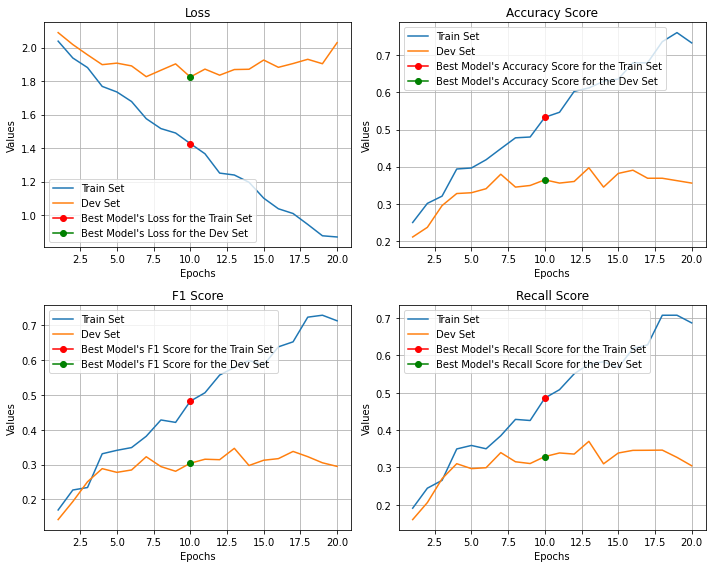

In [ ]:
EarlyCNNNet = CNN(layer_channels, hidden_features, out_features, kernels, dropout=dropout).to(device)
print(EarlyCNNNet)
# Make instance of our optimizer, with L2-Reguralization
# optimizer = optim.SGD(EarlyCNNNet.parameters(), lr=ETA, weight_decay=weight_decay)
optimizer = optim.Adam(EarlyCNNNet.parameters(), lr=ETA, weight_decay=weight_decay)

# Start the training process
clf_main(device, EarlyCNNNet, fused_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, net_name='EarlyCNN_nonbeatFUSED', PATIENCE=PATIENCE, cnn=True)

In [ ]:
with open('./best_EarlyCNN_beatFUSED.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
test_loss, y_test_gold, y_test_pred = clf_eval(device, test_loader, fused_feats, E_model, criterion, cnn=True)

print(classification_report(y_test_gold, y_test_pred))

              precision    recall  f1-score   support

           0       0.09      0.03      0.04        40
           1       0.37      0.40      0.39        40
           2       0.30      0.33      0.31        80
           3       0.31      0.45      0.37        80
           4       0.17      0.12      0.14        40
           5       0.00      0.00      0.00        40
           6       0.38      0.04      0.07        78
           7       0.00      0.00      0.00        40
           8       0.29      0.60      0.39       103
           9       0.12      0.12      0.12        34

    accuracy                           0.27       575
   macro avg       0.20      0.21      0.18       575
weighted avg       0.24      0.27      0.22       575



## Section 3 - Regression Model (Experiment with Spearman Loss)

### Spearman Correlation

In [ ]:
from fast_soft_sort.pytorch_ops import soft_rank

class SpearmanLoss(nn.Module):

    def __init__(self, regularization="l2", regularization_strength=1.0):
        super(SpearmanLoss, self).__init__()
        self.regularization = regularization
        self.regularization_strength = regularization_strength
        self.criterion = nn.MSELoss()

    def forward(self, pred, target):
      # fast_soft_sort uses 1-based indexing, divide by len to compute percentage of rank
        # print(pred.cpu().reshape(1, -1).shape)
        self.mse = self.criterion(pred, target)
        pred = soft_rank(
            pred.cpu().reshape(1, -1),
            regularization = self.regularization,
            regularization_strength = self.regularization_strength,
        )
        # print(pred.shape)
        pred = pred.cuda()
        return self.corrcoef(pred / pred.shape[-1], target)

    def corrcoef(self, pred, target):
        # np.corrcoef in torch from @mdo
        # https://forum.numer.ai/t/custom-loss-functions-for-xgboost-using-pytorch/960
        pred_n = pred - pred.mean()
        target_n = target - target.mean()
        pred_n = pred_n / pred_n.norm()
        target_n = target_n / target_n.norm()

        return -0.1*(pred_n * target_n).sum() + self.mse


### Regression Training

#### Multi Parameters

In [ ]:
# Create map for sentiments
mapping = {
    'valence' : 1,
    'energy' : 2,
    'danceability' : 3,
}

### LSTM

#### Redefine LSTM Regression Parameters

In [ ]:
# Define training parameters
batch_size = 32
BATCH_SIZE = batch_size
OUTPUT_SIZE = 1
EPOCHS = 100
HIDDEN_LAYER = 50
regularization_strength = 1e-2
criterion = SpearmanLoss(regularization_strength=regularization_strength)
weight_decay = 1e-7
NUM_LAYERS = 2
PATIENCE = 10
dropout = 0.2

####  Emotion "Valence"

In [ ]:
data = SpectrogramDataset("data/multitask_dataset_beat/",
                              class_mapping=class_mapping, train=True, read_spec_fn=read_mel_spectrogram, emotion=mapping['valence'])
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/multitask_dataset_beat/',
                                          class_mapping=class_mapping, train=False, read_spec_fn=read_mel_spectrogram, emotion=mapping['valence'], max_length = data.max_length)

##### Overfit the model

True


  0%|          | 0/30 [00:00<?, ?it/s]

 [=================================-------] ...Epoch 1, Loss: 0.8432
Statistics for the Train Set
	 Epoch: 1 	 loss: 0.3321807000312624
	 Epoch: 1 	 Spear Corr 1: -0.016877083219414137


  3%|▎         | 1/30 [00:02<01:20,  2.78s/it]

Statistics for the Dev Set
	 Epoch: 1 	 loss: 0.3522288504331574
	 Epoch: 1 	 Spear Corr 1: -0.012209292293782578
Dev loss decreased (0.352229 --> 0.352229).  Saving model ...
Epoch total time 2.780000686645508
 [=================================-------] ...Epoch 2, Loss: 0.2640
Statistics for the Train Set
	 Epoch: 2 	 loss: 0.33517750457370515
	 Epoch: 2 	 Spear Corr 1: -0.02267628909045707


  7%|▋         | 2/30 [00:03<00:48,  1.72s/it]

Statistics for the Dev Set
	 Epoch: 2 	 loss: 0.3226508605190548
	 Epoch: 2 	 Spear Corr 1: -0.009915151129022364
Dev loss decreased (0.352229 --> 0.322651).  Saving model ...
Epoch total time 0.9812726974487305
 [=================================-------] ...Epoch 3, Loss: 0.0075
Statistics for the Train Set
	 Epoch: 3 	 loss: 0.3129492098162241
	 Epoch: 3 	 Spear Corr 1: -0.08652653884238734


 10%|█         | 3/30 [00:04<00:37,  1.38s/it]

Statistics for the Dev Set
	 Epoch: 3 	 loss: 0.3101246596440947
	 Epoch: 3 	 Spear Corr 1: -0.028474243836238144
Dev loss decreased (0.322651 --> 0.310125).  Saving model ...
Epoch total time 0.9713032245635986
 [=================================-------] ...Epoch 4, Loss: 0.2343
Statistics for the Train Set
	 Epoch: 4 	 loss: 0.2954893494432602
	 Epoch: 4 	 Spear Corr 1: 0.07607268300376124


 13%|█▎        | 4/30 [00:05<00:31,  1.21s/it]

Statistics for the Dev Set
	 Epoch: 4 	 loss: 0.30291622164435655
	 Epoch: 4 	 Spear Corr 1: -0.011225137277371122
Dev loss decreased (0.310125 --> 0.302916).  Saving model ...
Epoch total time 0.9493272304534912
 [=================================-------] ...Epoch 5, Loss: 0.3254
Statistics for the Train Set
	 Epoch: 5 	 loss: 0.3069888491933083
	 Epoch: 5 	 Spear Corr 1: 0.01130715640960373


 17%|█▋        | 5/30 [00:06<00:28,  1.12s/it]

Statistics for the Dev Set
	 Epoch: 5 	 loss: 0.28468118778102025
	 Epoch: 5 	 Spear Corr 1: 0.028414123538886917
Dev loss decreased (0.302916 --> 0.284681).  Saving model ...
Epoch total time 0.9605112075805664
 [=================================-------] ...Epoch 6, Loss: 0.2316
Statistics for the Train Set
	 Epoch: 6 	 loss: 0.2824786080880132
	 Epoch: 6 	 Spear Corr 1: 0.027636586473832624


 20%|██        | 6/30 [00:07<00:25,  1.07s/it]

Statistics for the Dev Set
	 Epoch: 6 	 loss: 0.2913388829885201
	 Epoch: 6 	 Spear Corr 1: -0.001548147376794337
EarlyStopping counter: 1 out of 10
Epoch total time 0.9726035594940186
 [=================================-------] ...Epoch 7, Loss: 0.2945
Statistics for the Train Set
	 Epoch: 7 	 loss: 0.2769164286034548
	 Epoch: 7 	 Spear Corr 1: 0.020925442856460003


 23%|██▎       | 7/30 [00:08<00:23,  1.04s/it]

Statistics for the Dev Set
	 Epoch: 7 	 loss: 0.2822675305205293
	 Epoch: 7 	 Spear Corr 1: 0.0507075268712269
Dev loss decreased (0.284681 --> 0.282268).  Saving model ...
Epoch total time 0.9603226184844971
 [=================================-------] ...Epoch 8, Loss: 0.1682
Statistics for the Train Set
	 Epoch: 8 	 loss: 0.27188142131006415
	 Epoch: 8 	 Spear Corr 1: 0.001688778821172089


 27%|██▋       | 8/30 [00:09<00:22,  1.01s/it]

Statistics for the Dev Set
	 Epoch: 8 	 loss: 0.2640292927165272
	 Epoch: 8 	 Spear Corr 1: 0.030329323015712086
Dev loss decreased (0.282268 --> 0.264029).  Saving model ...
Epoch total time 0.9561433792114258
 [=================================-------] ...Epoch 9, Loss: 0.2078
Statistics for the Train Set
	 Epoch: 9 	 loss: 0.2652724773765992
	 Epoch: 9 	 Spear Corr 1: 0.03398731087221839


 30%|███       | 9/30 [00:10<00:20,  1.01it/s]

Statistics for the Dev Set
	 Epoch: 9 	 loss: 0.2521258417553551
	 Epoch: 9 	 Spear Corr 1: 0.0587457249683352
Dev loss decreased (0.264029 --> 0.252126).  Saving model ...
Epoch total time 0.9425103664398193
 [=================================-------] ...Epoch 10, Loss: 0.2896
Statistics for the Train Set
	 Epoch: 10 	 loss: 0.24760712523265563
	 Epoch: 10 	 Spear Corr 1: 0.05485528053900944


 33%|███▎      | 10/30 [00:11<00:19,  1.02it/s]

Statistics for the Dev Set
	 Epoch: 10 	 loss: 0.26366040289912385
	 Epoch: 10 	 Spear Corr 1: 0.02098824768748568
EarlyStopping counter: 1 out of 10
Epoch total time 0.9531450271606445
 [=================================-------] ...Epoch 11, Loss: 0.1612
Statistics for the Train Set
	 Epoch: 11 	 loss: 0.251668197223435
	 Epoch: 11 	 Spear Corr 1: 0.07330706646962713


 37%|███▋      | 11/30 [00:12<00:18,  1.03it/s]

Statistics for the Dev Set
	 Epoch: 11 	 loss: 0.24650787622778872
	 Epoch: 11 	 Spear Corr 1: 0.07324050826281588
Dev loss decreased (0.252126 --> 0.246508).  Saving model ...
Epoch total time 0.9433653354644775
 [=================================-------] ...Epoch 12, Loss: 0.1213
Statistics for the Train Set
	 Epoch: 12 	 loss: 0.23941685431752466
	 Epoch: 12 	 Spear Corr 1: 0.026742131338777893


 40%|████      | 12/30 [00:13<00:17,  1.04it/s]

Statistics for the Dev Set
	 Epoch: 12 	 loss: 0.23722564069017665
	 Epoch: 12 	 Spear Corr 1: 0.06770101445358032
Dev loss decreased (0.246508 --> 0.237226).  Saving model ...
Epoch total time 0.9446959495544434
 [=================================-------] ...Epoch 13, Loss: -0.0739
Statistics for the Train Set
	 Epoch: 13 	 loss: 0.2354939427212602
	 Epoch: 13 	 Spear Corr 1: 0.03185654912609917


 43%|████▎     | 13/30 [00:14<00:16,  1.04it/s]

Statistics for the Dev Set
	 Epoch: 13 	 loss: 0.23827004234112084
	 Epoch: 13 	 Spear Corr 1: 0.05264582646896076
EarlyStopping counter: 1 out of 10
Epoch total time 0.9654130935668945
 [=================================-------] ...Epoch 14, Loss: 0.1748
Statistics for the Train Set
	 Epoch: 14 	 loss: 0.24061307757112063
	 Epoch: 14 	 Spear Corr 1: 0.04629545434928207


 47%|████▋     | 14/30 [00:15<00:15,  1.04it/s]

Statistics for the Dev Set
	 Epoch: 14 	 loss: 0.22899082546662983
	 Epoch: 14 	 Spear Corr 1: 0.057445623538114894
Dev loss decreased (0.237226 --> 0.228991).  Saving model ...
Epoch total time 0.9696676731109619
 [=================================-------] ...Epoch 15, Loss: 0.1840
Statistics for the Train Set
	 Epoch: 15 	 loss: 0.21406802593294488
	 Epoch: 15 	 Spear Corr 1: 0.11940186021234195


 50%|█████     | 15/30 [00:16<00:14,  1.04it/s]

Statistics for the Dev Set
	 Epoch: 15 	 loss: 0.23090735393914136
	 Epoch: 15 	 Spear Corr 1: 0.0763731767777465
EarlyStopping counter: 1 out of 10
Epoch total time 0.9552443027496338
 [=================================-------] ...Epoch 16, Loss: -0.0065
Statistics for the Train Set
	 Epoch: 16 	 loss: 0.2310650523063638
	 Epoch: 16 	 Spear Corr 1: 0.04310793517717601


 53%|█████▎    | 16/30 [00:17<00:13,  1.03it/s]

Statistics for the Dev Set
	 Epoch: 16 	 loss: 0.22667370809553283
	 Epoch: 16 	 Spear Corr 1: 0.025965207407957887
Dev loss decreased (0.228991 --> 0.226674).  Saving model ...
Epoch total time 0.9708743095397949
 [=================================-------] ...Epoch 17, Loss: 0.2537
Statistics for the Train Set
	 Epoch: 17 	 loss: 0.2320778321895434
	 Epoch: 17 	 Spear Corr 1: 0.06544016482062237


 57%|█████▋    | 17/30 [00:18<00:12,  1.03it/s]

Statistics for the Dev Set
	 Epoch: 17 	 loss: 0.22174988339222185
	 Epoch: 17 	 Spear Corr 1: 0.02028431158733918
Dev loss decreased (0.226674 --> 0.221750).  Saving model ...
Epoch total time 0.9840807914733887
 [=================================-------] ...Epoch 18, Loss: 0.2161
Statistics for the Train Set
	 Epoch: 18 	 loss: 0.23740443293151506
	 Epoch: 18 	 Spear Corr 1: 0.004481447831994692


 60%|██████    | 18/30 [00:19<00:12,  1.00s/it]

Statistics for the Dev Set
	 Epoch: 18 	 loss: 0.21268284501567883
	 Epoch: 18 	 Spear Corr 1: 0.04789674554369953
Dev loss decreased (0.221750 --> 0.212683).  Saving model ...
Epoch total time 1.0704631805419922
 [=================================-------] ...Epoch 19, Loss: 0.3047
Statistics for the Train Set
	 Epoch: 19 	 loss: 0.21721424710760867
	 Epoch: 19 	 Spear Corr 1: 0.0680370202995677


 63%|██████▎   | 19/30 [00:20<00:10,  1.01it/s]

Statistics for the Dev Set
	 Epoch: 19 	 loss: 0.20888462069740843
	 Epoch: 19 	 Spear Corr 1: 0.03335837171940011
Dev loss decreased (0.212683 --> 0.208885).  Saving model ...
Epoch total time 0.9514689445495605
 [=================================-------] ...Epoch 20, Loss: 0.1203
Statistics for the Train Set
	 Epoch: 20 	 loss: 0.21112885131962802
	 Epoch: 20 	 Spear Corr 1: 0.04455703651192597


 67%|██████▋   | 20/30 [00:21<00:09,  1.02it/s]

Statistics for the Dev Set
	 Epoch: 20 	 loss: 0.20754775189114816
	 Epoch: 20 	 Spear Corr 1: 0.025177346488093832
Dev loss decreased (0.208885 --> 0.207548).  Saving model ...
Epoch total time 0.9561364650726318
 [=================================-------] ...Epoch 21, Loss: -0.0245
Statistics for the Train Set
	 Epoch: 21 	 loss: 0.2020807974514083
	 Epoch: 21 	 Spear Corr 1: 0.027621838109818678


 70%|███████   | 21/30 [00:22<00:08,  1.03it/s]

Statistics for the Dev Set
	 Epoch: 21 	 loss: 0.21052492054345226
	 Epoch: 21 	 Spear Corr 1: 0.07921119286511309
EarlyStopping counter: 1 out of 10
Epoch total time 0.9528801441192627
 [=================================-------] ...Epoch 22, Loss: -0.0336
Statistics for the Train Set
	 Epoch: 22 	 loss: 0.2019628576476953
	 Epoch: 22 	 Spear Corr 1: 0.07460609905773631


 73%|███████▎  | 22/30 [00:23<00:07,  1.03it/s]

Statistics for the Dev Set
	 Epoch: 22 	 loss: 0.20386047921490752
	 Epoch: 22 	 Spear Corr 1: 0.005369270368285782
Dev loss decreased (0.207548 --> 0.203860).  Saving model ...
Epoch total time 0.9825122356414795
 [=================================-------] ...Epoch 23, Loss: 0.1254
Statistics for the Train Set
	 Epoch: 23 	 loss: 0.202142948874681
	 Epoch: 23 	 Spear Corr 1: 0.10500033132065731


 77%|███████▋  | 23/30 [00:24<00:06,  1.02it/s]

Statistics for the Dev Set
	 Epoch: 23 	 loss: 0.19963033568394126
	 Epoch: 23 	 Spear Corr 1: 0.10063063134566042
Dev loss decreased (0.203860 --> 0.199630).  Saving model ...
Epoch total time 0.9819657802581787
 [=================================-------] ...Epoch 24, Loss: 0.1664
Statistics for the Train Set
	 Epoch: 24 	 loss: 0.19745319913023676
	 Epoch: 24 	 Spear Corr 1: 0.025847767345298527


 80%|████████  | 24/30 [00:25<00:05,  1.03it/s]

Statistics for the Dev Set
	 Epoch: 24 	 loss: 0.19095298331075533
	 Epoch: 24 	 Spear Corr 1: 0.04146659571776983
Dev loss decreased (0.199630 --> 0.190953).  Saving model ...
Epoch total time 0.9502580165863037
 [=================================-------] ...Epoch 25, Loss: -0.0894
Statistics for the Train Set
	 Epoch: 25 	 loss: 0.18216471517936403
	 Epoch: 25 	 Spear Corr 1: 0.09603928334496854


 83%|████████▎ | 25/30 [00:26<00:04,  1.03it/s]

Statistics for the Dev Set
	 Epoch: 25 	 loss: 0.18220584364679288
	 Epoch: 25 	 Spear Corr 1: 0.111029396244776
Dev loss decreased (0.190953 --> 0.182206).  Saving model ...
Epoch total time 0.9661374092102051
 [=================================-------] ...Epoch 26, Loss: 0.4314
Statistics for the Train Set
	 Epoch: 26 	 loss: 0.19645463558816642
	 Epoch: 26 	 Spear Corr 1: 0.048777073734572365


 87%|████████▋ | 26/30 [00:26<00:03,  1.03it/s]

Statistics for the Dev Set
	 Epoch: 26 	 loss: 0.19250862664406382
	 Epoch: 26 	 Spear Corr 1: 0.061899016336092044
EarlyStopping counter: 1 out of 10
Epoch total time 0.9704692363739014
 [=================================-------] ...Epoch 27, Loss: 0.1421
Statistics for the Train Set
	 Epoch: 27 	 loss: 0.2030878976888397
	 Epoch: 27 	 Spear Corr 1: 0.03385925267522651


 90%|█████████ | 27/30 [00:28<00:02,  1.01it/s]

Statistics for the Dev Set
	 Epoch: 27 	 loss: 0.1939627564615104
	 Epoch: 27 	 Spear Corr 1: 0.050253169546826494
EarlyStopping counter: 2 out of 10
Epoch total time 1.0221054553985596
 [=================================-------] ...Epoch 28, Loss: 0.2139
Statistics for the Train Set
	 Epoch: 28 	 loss: 0.18618461919983847
	 Epoch: 28 	 Spear Corr 1: 0.06028356530484373


 93%|█████████▎| 28/30 [00:28<00:01,  1.02it/s]

Statistics for the Dev Set
	 Epoch: 28 	 loss: 0.18333586830738627
	 Epoch: 28 	 Spear Corr 1: 0.024647722793635748
EarlyStopping counter: 3 out of 10
Epoch total time 0.9535655975341797
 [=================================-------] ...Epoch 29, Loss: 0.4441
Statistics for the Train Set
	 Epoch: 29 	 loss: 0.1998918258477959
	 Epoch: 29 	 Spear Corr 1: 0.048516185117882984


 97%|█████████▋| 29/30 [00:29<00:00,  1.02it/s]

Statistics for the Dev Set
	 Epoch: 29 	 loss: 0.18656273004851115
	 Epoch: 29 	 Spear Corr 1: 0.03189520972525033
EarlyStopping counter: 4 out of 10
Epoch total time 0.9731347560882568
 [=================================-------] ...Epoch 30, Loss: -0.0340
Statistics for the Train Set
	 Epoch: 30 	 loss: 0.18035182011805811
	 Epoch: 30 	 Spear Corr 1: 0.0684790157958033


100%|██████████| 30/30 [00:30<00:00,  1.03s/it]

Statistics for the Dev Set
	 Epoch: 30 	 loss: 0.17632448047687851
	 Epoch: 30 	 Spear Corr 1: 0.10961756352875343
Dev loss decreased (0.182206 --> 0.176324).  Saving model ...
Epoch total time 0.9887616634368896
Training total time 30.880340337753296


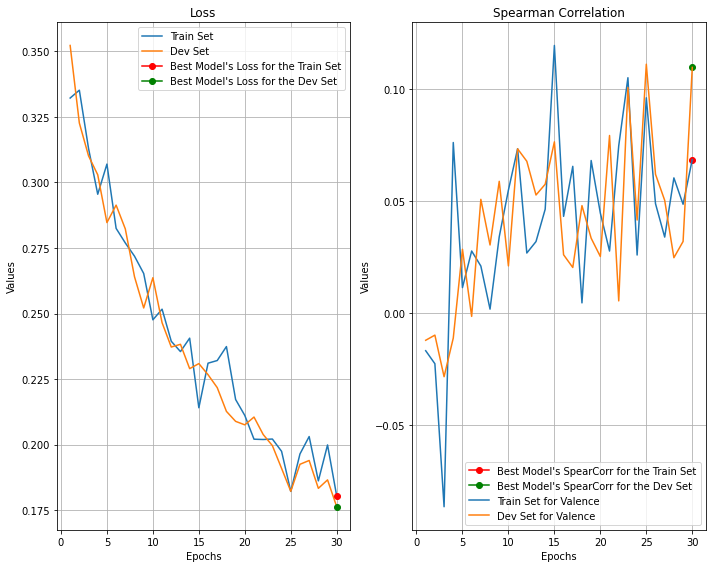

In [ ]:
EarlyLSTMNet = LSTM2(input_dim=mels_feats,
                    rnn_size=HIDDEN_LAYER,
                    output_dim=OUTPUT_SIZE,
                    num_layers=NUM_LAYERS,
                    dropout=dropout,
                    pack_padded_sequence=pack_padded_sequence).to(device)

# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.SGD(EarlyLSTMNet.parameters(), lr=ETA, weight_decay=weight_decay)

reg_main(device, EarlyLSTMNet, mels_feats, optimizer, criterion, train_loader, train_loader, 30, Descrs = ['Valence'], PATIENCE=PATIENCE, overfit_batch=True)

##### Normal Training

True


  0%|          | 0/100 [00:00<?, ?it/s]

 [=================================-------] ...Epoch 1, Loss: 0.5461

  1%|          | 1/100 [00:00<01:21,  1.22it/s]


Statistics for the Train Set
	 Epoch: 1 	 loss: 0.47257964317971984
	 Epoch: 1 	 Spear Corr 1: 0.008496880503539759
Statistics for the Dev Set
	 Epoch: 1 	 loss: 0.470752131164203
	 Epoch: 1 	 Spear Corr 1: -0.020287393170643233
Dev loss decreased (0.470752 --> 0.470752).  Saving model ...
Epoch total time 0.821861743927002
 [=================================-------] ...Epoch 2, Loss: 0.5337

  2%|▏         | 2/100 [00:01<01:20,  1.22it/s]


Statistics for the Train Set
	 Epoch: 2 	 loss: 0.42272931332484825
	 Epoch: 2 	 Spear Corr 1: 0.01696534969235827
Statistics for the Dev Set
	 Epoch: 2 	 loss: 0.42857563714017965
	 Epoch: 2 	 Spear Corr 1: -0.1313747775898748
Dev loss decreased (0.470752 --> 0.428576).  Saving model ...
Epoch total time 0.8152425289154053
 [=================================-------] ...Epoch 3, Loss: 0.6655

  3%|▎         | 3/100 [00:02<01:18,  1.23it/s]


Statistics for the Train Set
	 Epoch: 3 	 loss: 0.36915317697530436
	 Epoch: 3 	 Spear Corr 1: 0.039768748138061374
Statistics for the Dev Set
	 Epoch: 3 	 loss: 0.367201123448111
	 Epoch: 3 	 Spear Corr 1: -0.02992980397660497
Dev loss decreased (0.428576 --> 0.367201).  Saving model ...
Epoch total time 0.8078172206878662
 [=================================-------] ...Epoch 4, Loss: 0.5930

  4%|▍         | 4/100 [00:03<01:21,  1.17it/s]


Statistics for the Train Set
	 Epoch: 4 	 loss: 0.2725881391107851
	 Epoch: 4 	 Spear Corr 1: 0.08278593116296505
Statistics for the Dev Set
	 Epoch: 4 	 loss: 0.2860246420155561
	 Epoch: 4 	 Spear Corr 1: 0.005833386273765028
Dev loss decreased (0.367201 --> 0.286025).  Saving model ...
Epoch total time 0.9070112705230713
 [=================================-------] ...Epoch 5, Loss: 0.1855

  5%|▌         | 5/100 [00:04<01:19,  1.20it/s]


Statistics for the Train Set
	 Epoch: 5 	 loss: 0.15381808743270256
	 Epoch: 5 	 Spear Corr 1: -0.007508433547488288
Statistics for the Dev Set
	 Epoch: 5 	 loss: 0.15840303940255626
	 Epoch: 5 	 Spear Corr 1: -0.01446788701430457
Dev loss decreased (0.286025 --> 0.158403).  Saving model ...
Epoch total time 0.809293270111084
 [=================================-------] ...Epoch 6, Loss: 0.2532

  6%|▌         | 6/100 [00:05<01:18,  1.19it/s]


Statistics for the Train Set
	 Epoch: 6 	 loss: 0.09084330877861374
	 Epoch: 6 	 Spear Corr 1: 0.06402892038204079
Statistics for the Dev Set
	 Epoch: 6 	 loss: 0.09410353115544104
	 Epoch: 6 	 Spear Corr 1: -0.06455001994198084
Dev loss decreased (0.158403 --> 0.094104).  Saving model ...
Epoch total time 0.8410046100616455
 [=================================-------] ...Epoch 7, Loss: 0.2220

  7%|▋         | 7/100 [00:05<01:17,  1.20it/s]


Statistics for the Train Set
	 Epoch: 7 	 loss: 0.09245950440379001
	 Epoch: 7 	 Spear Corr 1: 0.020777010773601255
Statistics for the Dev Set
	 Epoch: 7 	 loss: 0.08884321466359381
	 Epoch: 7 	 Spear Corr 1: 0.021083903998426304
Dev loss decreased (0.094104 --> 0.088843).  Saving model ...
Epoch total time 0.8204560279846191
 [=================================-------] ...Epoch 8, Loss: 0.1253

  8%|▊         | 8/100 [00:06<01:15,  1.22it/s]


Statistics for the Train Set
	 Epoch: 8 	 loss: 0.0909705744202841
	 Epoch: 8 	 Spear Corr 1: 0.054598244725278765
Statistics for the Dev Set
	 Epoch: 8 	 loss: 0.09762907135537506
	 Epoch: 8 	 Spear Corr 1: -0.10416761203151836
EarlyStopping counter: 1 out of 10
Epoch total time 0.7892184257507324
 [=================================-------] ...Epoch 9, Loss: 0.1758

  9%|▉         | 9/100 [00:07<01:14,  1.22it/s]


Statistics for the Train Set
	 Epoch: 9 	 loss: 0.08639797134473609
	 Epoch: 9 	 Spear Corr 1: 0.06305412809109885
Statistics for the Dev Set
	 Epoch: 9 	 loss: 0.08151998265151994
	 Epoch: 9 	 Spear Corr 1: 0.014030129464703826
Dev loss decreased (0.088843 --> 0.081520).  Saving model ...
Epoch total time 0.8087272644042969
 [=================================-------] ...Epoch 10, Loss: -0.0182

 10%|█         | 10/100 [00:08<01:13,  1.23it/s]


Statistics for the Train Set
	 Epoch: 10 	 loss: 0.08229195197427722
	 Epoch: 10 	 Spear Corr 1: 0.1291944507792889
Statistics for the Dev Set
	 Epoch: 10 	 loss: 0.07894055711698647
	 Epoch: 10 	 Spear Corr 1: 0.05408814835719332
Dev loss decreased (0.081520 --> 0.078941).  Saving model ...
Epoch total time 0.8060460090637207
 [=================================-------] ...Epoch 11, Loss: 0.0399

 11%|█         | 11/100 [00:09<01:12,  1.23it/s]


Statistics for the Train Set
	 Epoch: 11 	 loss: 0.08702313047585256
	 Epoch: 11 	 Spear Corr 1: 0.056331716060771767
Statistics for the Dev Set
	 Epoch: 11 	 loss: 0.07430698589467406
	 Epoch: 11 	 Spear Corr 1: 0.06406421583205807
Dev loss decreased (0.078941 --> 0.074307).  Saving model ...
Epoch total time 0.8150262832641602
 [=================================-------] ...Epoch 12, Loss: 0.2207

 12%|█▏        | 12/100 [00:09<01:11,  1.23it/s]


Statistics for the Train Set
	 Epoch: 12 	 loss: 0.08731463531730432
	 Epoch: 12 	 Spear Corr 1: 0.03381873610217697
Statistics for the Dev Set
	 Epoch: 12 	 loss: 0.0813151943641236
	 Epoch: 12 	 Spear Corr 1: 0.054394578641913834
EarlyStopping counter: 1 out of 10
Epoch total time 0.7990903854370117
 [=================================-------] ...Epoch 13, Loss: 0.0904

 13%|█▎        | 13/100 [00:10<01:10,  1.23it/s]


Statistics for the Train Set
	 Epoch: 13 	 loss: 0.08440847403493942
	 Epoch: 13 	 Spear Corr 1: 0.12579835877591014
Statistics for the Dev Set
	 Epoch: 13 	 loss: 0.0798561354805509
	 Epoch: 13 	 Spear Corr 1: 0.08039470783484677
EarlyStopping counter: 2 out of 10
Epoch total time 0.8055965900421143
 [=================================-------] ...Epoch 14, Loss: 0.0166

 14%|█▍        | 14/100 [00:11<01:09,  1.24it/s]


Statistics for the Train Set
	 Epoch: 14 	 loss: 0.0825279734376806
	 Epoch: 14 	 Spear Corr 1: 0.04997723863444782
Statistics for the Dev Set
	 Epoch: 14 	 loss: 0.07177236891330281
	 Epoch: 14 	 Spear Corr 1: 0.08883221767806597
Dev loss decreased (0.074307 --> 0.071772).  Saving model ...
Epoch total time 0.7983331680297852
 [=================================-------] ...Epoch 15, Loss: 0.1558

 15%|█▌        | 15/100 [00:12<01:08,  1.25it/s]


Statistics for the Train Set
	 Epoch: 15 	 loss: 0.08995214826757274
	 Epoch: 15 	 Spear Corr 1: 0.061953253859033226
Statistics for the Dev Set
	 Epoch: 15 	 loss: 0.08168042458328514
	 Epoch: 15 	 Spear Corr 1: -0.009007662359040663
EarlyStopping counter: 1 out of 10
Epoch total time 0.7820844650268555
 [=================================-------] ...Epoch 16, Loss: 0.2356

 16%|█▌        | 16/100 [00:13<01:06,  1.26it/s]


Statistics for the Train Set
	 Epoch: 16 	 loss: 0.07680271330212805
	 Epoch: 16 	 Spear Corr 1: 0.06300071912793376
Statistics for the Dev Set
	 Epoch: 16 	 loss: 0.08931477442437745
	 Epoch: 16 	 Spear Corr 1: -0.01778470122853557
EarlyStopping counter: 2 out of 10
Epoch total time 0.7717375755310059
 [=================================-------] ...Epoch 17, Loss: 0.0199

 17%|█▋        | 17/100 [00:13<01:06,  1.25it/s]


Statistics for the Train Set
	 Epoch: 17 	 loss: 0.08674734279387479
	 Epoch: 17 	 Spear Corr 1: 0.08284850019767839
Statistics for the Dev Set
	 Epoch: 17 	 loss: 0.08212847988922123
	 Epoch: 17 	 Spear Corr 1: 0.05729392163201339
EarlyStopping counter: 3 out of 10
Epoch total time 0.824713945388794
 [=================================-------] ...Epoch 18, Loss: 0.0368

 18%|█▊        | 18/100 [00:14<01:05,  1.24it/s]


Statistics for the Train Set
	 Epoch: 18 	 loss: 0.08780678924111028
	 Epoch: 18 	 Spear Corr 1: 0.07826969210597343
Statistics for the Dev Set
	 Epoch: 18 	 loss: 0.08517820295637624
	 Epoch: 18 	 Spear Corr 1: -0.010092446920978115
EarlyStopping counter: 4 out of 10
Epoch total time 0.8068552017211914
 [=================================-------] ...Epoch 19, Loss: 0.0498

 19%|█▉        | 19/100 [00:15<01:05,  1.24it/s]


Statistics for the Train Set
	 Epoch: 19 	 loss: 0.08648554558376433
	 Epoch: 19 	 Spear Corr 1: 0.08376654822913272
Statistics for the Dev Set
	 Epoch: 19 	 loss: 0.07017923214561235
	 Epoch: 19 	 Spear Corr 1: 0.10247850851086378
Dev loss decreased (0.071772 --> 0.070179).  Saving model ...
Epoch total time 0.7961831092834473
 [=================================-------] ...Epoch 20, Loss: 0.1533

 20%|██        | 20/100 [00:16<01:06,  1.21it/s]


Statistics for the Train Set
	 Epoch: 20 	 loss: 0.0903537378936341
	 Epoch: 20 	 Spear Corr 1: 0.04978738638311417
Statistics for the Dev Set
	 Epoch: 20 	 loss: 0.08328550593508369
	 Epoch: 20 	 Spear Corr 1: 0.005226931912366925
EarlyStopping counter: 1 out of 10
Epoch total time 0.8802697658538818
 [=================================-------] ...Epoch 21, Loss: -0.0055

 21%|██        | 21/100 [00:17<01:05,  1.21it/s]


Statistics for the Train Set
	 Epoch: 21 	 loss: 0.09358933547526298
	 Epoch: 21 	 Spear Corr 1: -0.012392511717063685
Statistics for the Dev Set
	 Epoch: 21 	 loss: 0.08103816223252881
	 Epoch: 21 	 Spear Corr 1: 0.02860478661305736
EarlyStopping counter: 2 out of 10
Epoch total time 0.8175690174102783
 [=================================-------] ...Epoch 22, Loss: 0.1087

 22%|██▏       | 22/100 [00:17<01:04,  1.21it/s]


Statistics for the Train Set
	 Epoch: 22 	 loss: 0.0769027118570782
	 Epoch: 22 	 Spear Corr 1: 0.10479650561574547
Statistics for the Dev Set
	 Epoch: 22 	 loss: 0.08404656046049423
	 Epoch: 22 	 Spear Corr 1: -0.01864793776232142
EarlyStopping counter: 3 out of 10
Epoch total time 0.820695161819458
 [=================================-------] ...Epoch 23, Loss: 0.1434

 23%|██▎       | 23/100 [00:18<01:03,  1.21it/s]


Statistics for the Train Set
	 Epoch: 23 	 loss: 0.08849544970570675
	 Epoch: 23 	 Spear Corr 1: 0.05285940432243687
Statistics for the Dev Set
	 Epoch: 23 	 loss: 0.07691145371230405
	 Epoch: 23 	 Spear Corr 1: 0.0878937081997756
EarlyStopping counter: 4 out of 10
Epoch total time 0.8245928287506104
 [=================================-------] ...Epoch 24, Loss: 0.1472

 24%|██▍       | 24/100 [00:19<01:02,  1.22it/s]


Statistics for the Train Set
	 Epoch: 24 	 loss: 0.08335966778122621
	 Epoch: 24 	 Spear Corr 1: 0.08682366866368177
Statistics for the Dev Set
	 Epoch: 24 	 loss: 0.07394244663237336
	 Epoch: 24 	 Spear Corr 1: 0.06908721678839147
EarlyStopping counter: 5 out of 10
Epoch total time 0.8107857704162598
 [=================================-------] ...Epoch 25, Loss: -0.0418

 25%|██▌       | 25/100 [00:20<01:00,  1.23it/s]


Statistics for the Train Set
	 Epoch: 25 	 loss: 0.07635548132122694
	 Epoch: 25 	 Spear Corr 1: 0.1328797852360499
Statistics for the Dev Set
	 Epoch: 25 	 loss: 0.07416020866327702
	 Epoch: 25 	 Spear Corr 1: 0.07872055213295905
EarlyStopping counter: 6 out of 10
Epoch total time 0.7903313636779785
 [=================================-------] ...Epoch 26, Loss: -0.0715

 26%|██▌       | 26/100 [00:21<00:59,  1.24it/s]


Statistics for the Train Set
	 Epoch: 26 	 loss: 0.07142044576981171
	 Epoch: 26 	 Spear Corr 1: 0.1229912971606213
Statistics for the Dev Set
	 Epoch: 26 	 loss: 0.07540500807341312
	 Epoch: 26 	 Spear Corr 1: 0.10410408380175923
EarlyStopping counter: 7 out of 10
Epoch total time 0.7959809303283691
 [=================================-------] ...Epoch 27, Loss: 0.1021

 27%|██▋       | 27/100 [00:22<00:58,  1.24it/s]


Statistics for the Train Set
	 Epoch: 27 	 loss: 0.08350966937528745
	 Epoch: 27 	 Spear Corr 1: 0.09218884178163117
Statistics for the Dev Set
	 Epoch: 27 	 loss: 0.08762730668796946
	 Epoch: 27 	 Spear Corr 1: -0.036858651825712345
EarlyStopping counter: 8 out of 10
Epoch total time 0.7954175472259521
 [=================================-------] ...Epoch 28, Loss: -0.0036

 28%|██▊       | 28/100 [00:22<00:57,  1.24it/s]


Statistics for the Train Set
	 Epoch: 28 	 loss: 0.07763458245527416
	 Epoch: 28 	 Spear Corr 1: 0.08501374611765133
Statistics for the Dev Set
	 Epoch: 28 	 loss: 0.08878391358170738
	 Epoch: 28 	 Spear Corr 1: -0.027745287033963215
EarlyStopping counter: 9 out of 10
Epoch total time 0.7998766899108887
 [=================================-------] ...Epoch 29, Loss: 0.1178

 28%|██▊       | 28/100 [00:23<01:00,  1.19it/s]


Statistics for the Train Set
	 Epoch: 29 	 loss: 0.07599216505246865
	 Epoch: 29 	 Spear Corr 1: 0.07416771636581844
Statistics for the Dev Set
	 Epoch: 29 	 loss: 0.07444340912779948
	 Epoch: 29 	 Spear Corr 1: 0.1243263471906326
EarlyStopping counter: 10 out of 10
Training total time 22.761818170547485


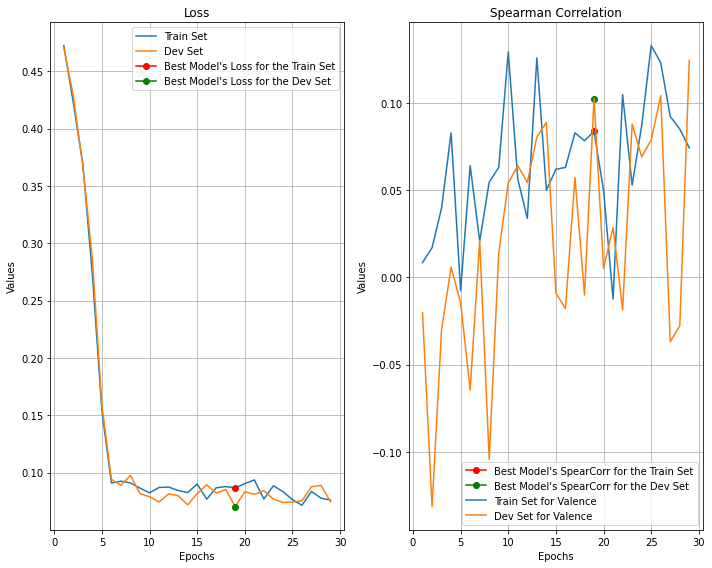

In [ ]:
EarlyLSTMNet = LSTM2(input_dim=mels_feats,
                    rnn_size=HIDDEN_LAYER,
                    output_dim=OUTPUT_SIZE,
                    num_layers=NUM_LAYERS,
                    dropout=dropout,
                    pack_padded_sequence=pack_padded_sequence).to(device)

# criterion = SpearmanLoss(EarlyLSTMNet, 0.3)
# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(EarlyLSTMNet.parameters(), lr=ETA, weight_decay=weight_decay)

# Start the training process
reg_main(device, EarlyLSTMNet, mels_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, Descrs = ['Valence'], net_name='EarlyLSTM_multibeatVal', PATIENCE=PATIENCE)

LSTM2(
  (softmax): Softmax(dim=-1)
  (non_linearity): Tanh()
  (lstm): LSTM(128, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): FullyConnectedLayer(
    (fc1): Linear(in_features=50, out_features=25, bias=True)
    (fc2): Linear(in_features=25, out_features=1, bias=True)
  )
)
Spearman Correlation for Valence: -0.0038159645909098946


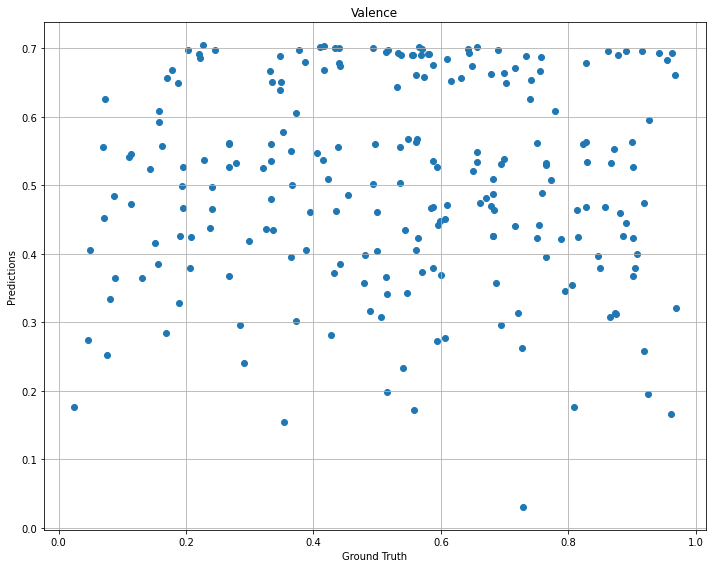

In [ ]:
with open('./best_EarlyLSTM_multibeatVal.pickle', 'rb') as handle:
    E_model = pickle.load(handle)
print(E_model)
# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
_ = reg_eval(device, dev_loader, mels_feats, E_model, criterion, titles=['Valence'])


####  Emotion "Energy"

In [ ]:
data = SpectrogramDataset("data/multitask_dataset_beat/",
                              class_mapping=class_mapping, train=True, read_spec_fn=read_mel_spectrogram, emotion=mapping['energy'])
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/multitask_dataset_beat/',
                                          class_mapping=class_mapping, train=False, read_spec_fn=read_mel_spectrogram, emotion=mapping['energy'])

##### Normal Training

True


  0%|          | 0/100 [00:00<?, ?it/s]

 [=================================-------] ...Epoch 1, Loss: 0.1354

  1%|          | 1/100 [00:00<01:20,  1.23it/s]


Statistics for the Train Set
	 Epoch: 1 	 loss: 0.3515246200829811
	 Epoch: 1 	 Spear Corr 1: -0.00012771428060148206
Statistics for the Dev Set
	 Epoch: 1 	 loss: 0.35496097226832735
	 Epoch: 1 	 Spear Corr 1: -0.016452739414582515
Dev loss decreased (0.354961 --> 0.354961).  Saving model ...
Epoch total time 0.8096706867218018
 [=================================-------] ...Epoch 2, Loss: 0.3328

  2%|▏         | 2/100 [00:01<01:21,  1.21it/s]


Statistics for the Train Set
	 Epoch: 2 	 loss: 0.2536145854169989
	 Epoch: 2 	 Spear Corr 1: 0.02593885821755003
Statistics for the Dev Set
	 Epoch: 2 	 loss: 0.2637185173888942
	 Epoch: 2 	 Spear Corr 1: -0.08059007566843104
Dev loss decreased (0.354961 --> 0.263719).  Saving model ...
Epoch total time 0.8419525623321533
 [=================================-------] ...Epoch 3, Loss: 0.3785

  3%|▎         | 3/100 [00:02<01:20,  1.21it/s]


Statistics for the Train Set
	 Epoch: 3 	 loss: 0.16650279569619097
	 Epoch: 3 	 Spear Corr 1: 0.09284780971792142
Statistics for the Dev Set
	 Epoch: 3 	 loss: 0.15956868611494138
	 Epoch: 3 	 Spear Corr 1: 0.037024669501247796
Dev loss decreased (0.263719 --> 0.159569).  Saving model ...
Epoch total time 0.825894832611084
 [=================================-------] ...Epoch 4, Loss: -0.0074

  4%|▍         | 4/100 [00:03<01:18,  1.22it/s]


Statistics for the Train Set
	 Epoch: 4 	 loss: 0.10623207183458473
	 Epoch: 4 	 Spear Corr 1: 0.0014611163292064199
Statistics for the Dev Set
	 Epoch: 4 	 loss: 0.08244998122826341
	 Epoch: 4 	 Spear Corr 1: 0.16225052164499143
Dev loss decreased (0.159569 --> 0.082450).  Saving model ...
Epoch total time 0.8058726787567139
 [=================================-------] ...Epoch 5, Loss: 0.1859

  5%|▌         | 5/100 [00:04<01:17,  1.22it/s]


Statistics for the Train Set
	 Epoch: 5 	 loss: 0.07787588438299685
	 Epoch: 5 	 Spear Corr 1: 0.013760745598255004
Statistics for the Dev Set
	 Epoch: 5 	 loss: 0.07451533935780888
	 Epoch: 5 	 Spear Corr 1: -0.03456415241886969
Dev loss decreased (0.082450 --> 0.074515).  Saving model ...
Epoch total time 0.8170201778411865
 [=================================-------] ...Epoch 6, Loss: 0.1662

  6%|▌         | 6/100 [00:04<01:16,  1.23it/s]


Statistics for the Train Set
	 Epoch: 6 	 loss: 0.06715712208574975
	 Epoch: 6 	 Spear Corr 1: 0.1198567747396151
Statistics for the Dev Set
	 Epoch: 6 	 loss: 0.0554119374755229
	 Epoch: 6 	 Spear Corr 1: 0.17368773535140683
Dev loss decreased (0.074515 --> 0.055412).  Saving model ...
Epoch total time 0.8023993968963623
 [=================================-------] ...Epoch 7, Loss: 0.0765

  7%|▋         | 7/100 [00:05<01:15,  1.23it/s]


Statistics for the Train Set
	 Epoch: 7 	 loss: 0.0688562667994893
	 Epoch: 7 	 Spear Corr 1: 0.14732471144628762
Statistics for the Dev Set
	 Epoch: 7 	 loss: 0.06014710518353662
	 Epoch: 7 	 Spear Corr 1: 0.16134457729940765
EarlyStopping counter: 1 out of 10
Epoch total time 0.7996056079864502
 [=================================-------] ...Epoch 8, Loss: -0.0931

  8%|▊         | 8/100 [00:06<01:14,  1.24it/s]


Statistics for the Train Set
	 Epoch: 8 	 loss: 0.06008282054829676
	 Epoch: 8 	 Spear Corr 1: 0.19747708035617512
Statistics for the Dev Set
	 Epoch: 8 	 loss: 0.05195431648137248
	 Epoch: 8 	 Spear Corr 1: 0.24010995186400527
Dev loss decreased (0.055412 --> 0.051954).  Saving model ...
Epoch total time 0.7917947769165039
 [=================================-------] ...Epoch 9, Loss: 0.2484

  9%|▉         | 9/100 [00:07<01:12,  1.25it/s]


Statistics for the Train Set
	 Epoch: 9 	 loss: 0.058871334895627084
	 Epoch: 9 	 Spear Corr 1: 0.24612725128227023
Statistics for the Dev Set
	 Epoch: 9 	 loss: 0.05829692461372266
	 Epoch: 9 	 Spear Corr 1: 0.17864560520257744
EarlyStopping counter: 1 out of 10
Epoch total time 0.7872331142425537
 [=================================-------] ...Epoch 10, Loss: -0.0093

 10%|█         | 10/100 [00:08<01:11,  1.26it/s]


Statistics for the Train Set
	 Epoch: 10 	 loss: 0.05501936495704841
	 Epoch: 10 	 Spear Corr 1: 0.32662399470934633
Statistics for the Dev Set
	 Epoch: 10 	 loss: 0.058076654745196396
	 Epoch: 10 	 Spear Corr 1: 0.19293464842820826
EarlyStopping counter: 2 out of 10
Epoch total time 0.7835409641265869
 [=================================-------] ...Epoch 11, Loss: 0.0184

 11%|█         | 11/100 [00:08<01:11,  1.24it/s]


Statistics for the Train Set
	 Epoch: 11 	 loss: 0.05192948347879307
	 Epoch: 11 	 Spear Corr 1: 0.2895917501261346
Statistics for the Dev Set
	 Epoch: 11 	 loss: 0.04888831169821325
	 Epoch: 11 	 Spear Corr 1: 0.24992425996607492
Dev loss decreased (0.051954 --> 0.048888).  Saving model ...
Epoch total time 0.817925214767456
 [=================================-------] ...Epoch 12, Loss: -0.0827

 12%|█▏        | 12/100 [00:09<01:10,  1.25it/s]


Statistics for the Train Set
	 Epoch: 12 	 loss: 0.056412592016448763
	 Epoch: 12 	 Spear Corr 1: 0.3146832646084912
Statistics for the Dev Set
	 Epoch: 12 	 loss: 0.05202579972893874
	 Epoch: 12 	 Spear Corr 1: 0.262167054118858
EarlyStopping counter: 1 out of 10
Epoch total time 0.7893798351287842
 [=================================-------] ...Epoch 13, Loss: 0.1650

 13%|█▎        | 13/100 [00:10<01:09,  1.25it/s]


Statistics for the Train Set
	 Epoch: 13 	 loss: 0.05801658174203723
	 Epoch: 13 	 Spear Corr 1: 0.3326789143357139
Statistics for the Dev Set
	 Epoch: 13 	 loss: 0.05234437318427254
	 Epoch: 13 	 Spear Corr 1: 0.23950242996343113
EarlyStopping counter: 2 out of 10
Epoch total time 0.8044290542602539
 [=================================-------] ...Epoch 14, Loss: -0.0608

 14%|█▍        | 14/100 [00:11<01:10,  1.23it/s]


Statistics for the Train Set
	 Epoch: 14 	 loss: 0.0530159520867901
	 Epoch: 14 	 Spear Corr 1: 0.37307696131991014
Statistics for the Dev Set
	 Epoch: 14 	 loss: 0.04012573703686166
	 Epoch: 14 	 Spear Corr 1: 0.37404504151738577
Dev loss decreased (0.048888 --> 0.040126).  Saving model ...
Epoch total time 0.8409936428070068
 [=================================-------] ...Epoch 15, Loss: 0.1018

 15%|█▌        | 15/100 [00:12<01:10,  1.21it/s]


Statistics for the Train Set
	 Epoch: 15 	 loss: 0.040979896103539096
	 Epoch: 15 	 Spear Corr 1: 0.39404618958571214
Statistics for the Dev Set
	 Epoch: 15 	 loss: 0.052953756433280694
	 Epoch: 15 	 Spear Corr 1: 0.2905321342095492
EarlyStopping counter: 1 out of 10
Epoch total time 0.8551254272460938
 [=================================-------] ...Epoch 16, Loss: 0.1453

 16%|█▌        | 16/100 [00:13<01:09,  1.20it/s]


Statistics for the Train Set
	 Epoch: 16 	 loss: 0.052315378624528903
	 Epoch: 16 	 Spear Corr 1: 0.3788238196630695
Statistics for the Dev Set
	 Epoch: 16 	 loss: 0.04655353915917675
	 Epoch: 16 	 Spear Corr 1: 0.3211078893356337
EarlyStopping counter: 2 out of 10
Epoch total time 0.8370089530944824
 [=================================-------] ...Epoch 17, Loss: 0.1035

 17%|█▋        | 17/100 [00:13<01:08,  1.20it/s]


Statistics for the Train Set
	 Epoch: 17 	 loss: 0.04627121164760286
	 Epoch: 17 	 Spear Corr 1: 0.3671865937639166
Statistics for the Dev Set
	 Epoch: 17 	 loss: 0.038954976822704275
	 Epoch: 17 	 Spear Corr 1: 0.36926120693826014
Dev loss decreased (0.040126 --> 0.038955).  Saving model ...
Epoch total time 0.8236598968505859
 [=================================-------] ...Epoch 18, Loss: -0.0269

 18%|█▊        | 18/100 [00:14<01:09,  1.17it/s]


Statistics for the Train Set
	 Epoch: 18 	 loss: 0.04889265134430432
	 Epoch: 18 	 Spear Corr 1: 0.42168734145696246
Statistics for the Dev Set
	 Epoch: 18 	 loss: 0.039796536657650594
	 Epoch: 18 	 Spear Corr 1: 0.4053062607210953
EarlyStopping counter: 1 out of 10
Epoch total time 0.8973984718322754
 [=================================-------] ...Epoch 19, Loss: -0.0356

 19%|█▉        | 19/100 [00:15<01:08,  1.19it/s]


Statistics for the Train Set
	 Epoch: 19 	 loss: 0.043346025111678836
	 Epoch: 19 	 Spear Corr 1: 0.4006872907489755
Statistics for the Dev Set
	 Epoch: 19 	 loss: 0.03671328655979159
	 Epoch: 19 	 Spear Corr 1: 0.4168705308531141
Dev loss decreased (0.038955 --> 0.036713).  Saving model ...
Epoch total time 0.8110082149505615
 [=================================-------] ...Epoch 20, Loss: -0.0211

 20%|██        | 20/100 [00:16<01:06,  1.21it/s]


Statistics for the Train Set
	 Epoch: 20 	 loss: 0.038529031146377866
	 Epoch: 20 	 Spear Corr 1: 0.46362071891408824
Statistics for the Dev Set
	 Epoch: 20 	 loss: 0.039488225765347496
	 Epoch: 20 	 Spear Corr 1: 0.3965484428134336
EarlyStopping counter: 1 out of 10
Epoch total time 0.7999424934387207
 [=================================-------] ...Epoch 21, Loss: 0.1080

 21%|██        | 21/100 [00:17<01:04,  1.22it/s]


Statistics for the Train Set
	 Epoch: 21 	 loss: 0.04482552250364478
	 Epoch: 21 	 Spear Corr 1: 0.3847296010135696
Statistics for the Dev Set
	 Epoch: 21 	 loss: 0.04143819565196464
	 Epoch: 21 	 Spear Corr 1: 0.3461113126531128
EarlyStopping counter: 2 out of 10
Epoch total time 0.8010716438293457
 [=================================-------] ...Epoch 22, Loss: 0.0357

 22%|██▏       | 22/100 [00:18<01:03,  1.23it/s]


Statistics for the Train Set
	 Epoch: 22 	 loss: 0.04595544683133987
	 Epoch: 22 	 Spear Corr 1: 0.4315611616700348
Statistics for the Dev Set
	 Epoch: 22 	 loss: 0.040076173565231514
	 Epoch: 22 	 Spear Corr 1: 0.44145648305789625
EarlyStopping counter: 3 out of 10
Epoch total time 0.7952697277069092
 [=================================-------] ...Epoch 23, Loss: -0.0298

 23%|██▎       | 23/100 [00:18<01:02,  1.23it/s]


Statistics for the Train Set
	 Epoch: 23 	 loss: 0.04528762391303171
	 Epoch: 23 	 Spear Corr 1: 0.401419423178099
Statistics for the Dev Set
	 Epoch: 23 	 loss: 0.04101910299524786
	 Epoch: 23 	 Spear Corr 1: 0.3605065921337649
EarlyStopping counter: 4 out of 10
Epoch total time 0.7987766265869141
 [=================================-------] ...Epoch 24, Loss: 0.1845

 24%|██▍       | 24/100 [00:19<01:01,  1.24it/s]


Statistics for the Train Set
	 Epoch: 24 	 loss: 0.048038439260448276
	 Epoch: 24 	 Spear Corr 1: 0.3396873659819633
Statistics for the Dev Set
	 Epoch: 24 	 loss: 0.051519547858540446
	 Epoch: 24 	 Spear Corr 1: 0.27413651680143547
EarlyStopping counter: 5 out of 10
Epoch total time 0.7985272407531738
 [=================================-------] ...Epoch 25, Loss: -0.0046

 25%|██▌       | 25/100 [00:20<01:00,  1.24it/s]


Statistics for the Train Set
	 Epoch: 25 	 loss: 0.047080912901796675
	 Epoch: 25 	 Spear Corr 1: 0.3982069044277649
Statistics for the Dev Set
	 Epoch: 25 	 loss: 0.03542945153562764
	 Epoch: 25 	 Spear Corr 1: 0.4111455177935734
Dev loss decreased (0.036713 --> 0.035429).  Saving model ...
Epoch total time 0.8123207092285156
 [=================================-------] ...Epoch 26, Loss: -0.0092

 26%|██▌       | 26/100 [00:21<00:59,  1.24it/s]


Statistics for the Train Set
	 Epoch: 26 	 loss: 0.04475012183543745
	 Epoch: 26 	 Spear Corr 1: 0.4105656100443345
Statistics for the Dev Set
	 Epoch: 26 	 loss: 0.04483827073878212
	 Epoch: 26 	 Spear Corr 1: 0.3588500539461712
EarlyStopping counter: 1 out of 10
Epoch total time 0.8085165023803711
 [=================================-------] ...Epoch 27, Loss: 0.0651

 27%|██▋       | 27/100 [00:22<00:59,  1.22it/s]


Statistics for the Train Set
	 Epoch: 27 	 loss: 0.04550603171624362
	 Epoch: 27 	 Spear Corr 1: 0.3925442335206108
Statistics for the Dev Set
	 Epoch: 27 	 loss: 0.03918048892552498
	 Epoch: 27 	 Spear Corr 1: 0.4083951198746296
EarlyStopping counter: 2 out of 10
Epoch total time 0.8367812633514404
 [=================================-------] ...Epoch 28, Loss: -0.0531

 28%|██▊       | 28/100 [00:22<00:59,  1.21it/s]


Statistics for the Train Set
	 Epoch: 28 	 loss: 0.03958409017016868
	 Epoch: 28 	 Spear Corr 1: 0.443034020355488
Statistics for the Dev Set
	 Epoch: 28 	 loss: 0.03472344672465935
	 Epoch: 28 	 Spear Corr 1: 0.4216565008343507
Dev loss decreased (0.035429 --> 0.034723).  Saving model ...
Epoch total time 0.8345882892608643
 [=================================-------] ...Epoch 29, Loss: -0.0258

 29%|██▉       | 29/100 [00:23<00:58,  1.22it/s]


Statistics for the Train Set
	 Epoch: 29 	 loss: 0.045704012067362514
	 Epoch: 29 	 Spear Corr 1: 0.44491326134125814
Statistics for the Dev Set
	 Epoch: 29 	 loss: 0.040186294184187156
	 Epoch: 29 	 Spear Corr 1: 0.37236448005604356
EarlyStopping counter: 1 out of 10
Epoch total time 0.8089778423309326
 [=================================-------] ...Epoch 30, Loss: 0.3664

 30%|███       | 30/100 [00:24<00:57,  1.22it/s]


Statistics for the Train Set
	 Epoch: 30 	 loss: 0.04055328995242512
	 Epoch: 30 	 Spear Corr 1: 0.4444899250405723
Statistics for the Dev Set
	 Epoch: 30 	 loss: 0.03635864415742142
	 Epoch: 30 	 Spear Corr 1: 0.45798609694847414
EarlyStopping counter: 2 out of 10
Epoch total time 0.8210053443908691
 [=================================-------] ...Epoch 31, Loss: -0.0868

 31%|███       | 31/100 [00:25<00:56,  1.21it/s]


Statistics for the Train Set
	 Epoch: 31 	 loss: 0.04753392938069267
	 Epoch: 31 	 Spear Corr 1: 0.4258830298281718
Statistics for the Dev Set
	 Epoch: 31 	 loss: 0.03383710005469752
	 Epoch: 31 	 Spear Corr 1: 0.41212459966145826
Dev loss decreased (0.034723 --> 0.033837).  Saving model ...
Epoch total time 0.835484504699707
 [=================================-------] ...Epoch 32, Loss: 0.1507

 32%|███▏      | 32/100 [00:26<00:55,  1.22it/s]


Statistics for the Train Set
	 Epoch: 32 	 loss: 0.04538375874606379
	 Epoch: 32 	 Spear Corr 1: 0.43104435548486303
Statistics for the Dev Set
	 Epoch: 32 	 loss: 0.03686519946776347
	 Epoch: 32 	 Spear Corr 1: 0.39705186386109736
EarlyStopping counter: 1 out of 10
Epoch total time 0.8152956962585449
 [=================================-------] ...Epoch 33, Loss: 0.2158

 33%|███▎      | 33/100 [00:27<00:55,  1.22it/s]


Statistics for the Train Set
	 Epoch: 33 	 loss: 0.04513757503286469
	 Epoch: 33 	 Spear Corr 1: 0.4276218878467542
Statistics for the Dev Set
	 Epoch: 33 	 loss: 0.03318125313834021
	 Epoch: 33 	 Spear Corr 1: 0.45212815510752485
Dev loss decreased (0.033837 --> 0.033181).  Saving model ...
Epoch total time 0.8199427127838135
 [=================================-------] ...Epoch 34, Loss: 0.1451

 34%|███▍      | 34/100 [00:27<00:54,  1.22it/s]


Statistics for the Train Set
	 Epoch: 34 	 loss: 0.04167197926000838
	 Epoch: 34 	 Spear Corr 1: 0.4428808609888785
Statistics for the Dev Set
	 Epoch: 34 	 loss: 0.03418082298787896
	 Epoch: 34 	 Spear Corr 1: 0.4157200829658229
EarlyStopping counter: 1 out of 10
Epoch total time 0.8213753700256348
 [=================================-------] ...Epoch 35, Loss: -0.0660

 35%|███▌      | 35/100 [00:28<00:53,  1.22it/s]


Statistics for the Train Set
	 Epoch: 35 	 loss: 0.032478399615784206
	 Epoch: 35 	 Spear Corr 1: 0.5137825698782034
Statistics for the Dev Set
	 Epoch: 35 	 loss: 0.0374595812957748
	 Epoch: 35 	 Spear Corr 1: 0.4207227962613242
EarlyStopping counter: 2 out of 10
Epoch total time 0.8174102306365967
 [=================================-------] ...Epoch 36, Loss: -0.0247

 36%|███▌      | 36/100 [00:29<00:52,  1.23it/s]


Statistics for the Train Set
	 Epoch: 36 	 loss: 0.035830953943716375
	 Epoch: 36 	 Spear Corr 1: 0.4499380568360349
Statistics for the Dev Set
	 Epoch: 36 	 loss: 0.03303351437648588
	 Epoch: 36 	 Spear Corr 1: 0.405313200777956
Dev loss decreased (0.033181 --> 0.033034).  Saving model ...
Epoch total time 0.8022143840789795
 [=================================-------] ...Epoch 37, Loss: 0.0457

 37%|███▋      | 37/100 [00:30<00:51,  1.22it/s]


Statistics for the Train Set
	 Epoch: 37 	 loss: 0.03834451771785914
	 Epoch: 37 	 Spear Corr 1: 0.4207771182825914
Statistics for the Dev Set
	 Epoch: 37 	 loss: 0.03752039817888805
	 Epoch: 37 	 Spear Corr 1: 0.4044254073503155
EarlyStopping counter: 1 out of 10
Epoch total time 0.8272521495819092
 [=================================-------] ...Epoch 38, Loss: 0.1049

 38%|███▊      | 38/100 [00:31<00:51,  1.21it/s]


Statistics for the Train Set
	 Epoch: 38 	 loss: 0.03705085640536954
	 Epoch: 38 	 Spear Corr 1: 0.4669429804726853
Statistics for the Dev Set
	 Epoch: 38 	 loss: 0.0322581096014224
	 Epoch: 38 	 Spear Corr 1: 0.43114996476924544
Dev loss decreased (0.033034 --> 0.032258).  Saving model ...
Epoch total time 0.8399605751037598
 [=================================-------] ...Epoch 39, Loss: 0.0530

 39%|███▉      | 39/100 [00:31<00:51,  1.19it/s]


Statistics for the Train Set
	 Epoch: 39 	 loss: 0.04031625118583264
	 Epoch: 39 	 Spear Corr 1: 0.44732534115349776
Statistics for the Dev Set
	 Epoch: 39 	 loss: 0.030113385363562572
	 Epoch: 39 	 Spear Corr 1: 0.46345432790416924
Dev loss decreased (0.032258 --> 0.030113).  Saving model ...
Epoch total time 0.8719563484191895
 [=================================-------] ...Epoch 40, Loss: 0.1397

 40%|████      | 40/100 [00:32<00:50,  1.19it/s]


Statistics for the Train Set
	 Epoch: 40 	 loss: 0.044726253479818685
	 Epoch: 40 	 Spear Corr 1: 0.4341692788430523
Statistics for the Dev Set
	 Epoch: 40 	 loss: 0.03661008138753628
	 Epoch: 40 	 Spear Corr 1: 0.3611071739774783
EarlyStopping counter: 1 out of 10
Epoch total time 0.8375835418701172
 [=================================-------] ...Epoch 41, Loss: 0.1164

 41%|████      | 41/100 [00:33<00:49,  1.20it/s]


Statistics for the Train Set
	 Epoch: 41 	 loss: 0.046590616991783934
	 Epoch: 41 	 Spear Corr 1: 0.4375113761346039
Statistics for the Dev Set
	 Epoch: 41 	 loss: 0.034421833995224214
	 Epoch: 41 	 Spear Corr 1: 0.38229837067632816
EarlyStopping counter: 2 out of 10
Epoch total time 0.8232579231262207
 [=================================-------] ...Epoch 42, Loss: -0.0182

 42%|████▏     | 42/100 [00:34<00:47,  1.21it/s]


Statistics for the Train Set
	 Epoch: 42 	 loss: 0.03713109079442866
	 Epoch: 42 	 Spear Corr 1: 0.4811350599715091
Statistics for the Dev Set
	 Epoch: 42 	 loss: 0.03325940052042599
	 Epoch: 42 	 Spear Corr 1: 0.4625884223481664
EarlyStopping counter: 3 out of 10
Epoch total time 0.7994890213012695
 [=================================-------] ...Epoch 43, Loss: 0.1403

 43%|████▎     | 43/100 [00:35<00:46,  1.21it/s]


Statistics for the Train Set
	 Epoch: 43 	 loss: 0.03878961127968273
	 Epoch: 43 	 Spear Corr 1: 0.4244248300311291
Statistics for the Dev Set
	 Epoch: 43 	 loss: 0.03498221707273693
	 Epoch: 43 	 Spear Corr 1: 0.4193102277649101
EarlyStopping counter: 4 out of 10
Epoch total time 0.8149011135101318
 [=================================-------] ...Epoch 44, Loss: -0.0306

 44%|████▍     | 44/100 [00:36<00:46,  1.21it/s]


Statistics for the Train Set
	 Epoch: 44 	 loss: 0.04365885070526962
	 Epoch: 44 	 Spear Corr 1: 0.4800055728986449
Statistics for the Dev Set
	 Epoch: 44 	 loss: 0.028753771032584502
	 Epoch: 44 	 Spear Corr 1: 0.4823174024515218
Dev loss decreased (0.030113 --> 0.028754).  Saving model ...
Epoch total time 0.8343932628631592
 [=================================-------] ...Epoch 45, Loss: 0.1980

 45%|████▌     | 45/100 [00:36<00:45,  1.22it/s]


Statistics for the Train Set
	 Epoch: 45 	 loss: 0.03018071616693322
	 Epoch: 45 	 Spear Corr 1: 0.5126314925178452
Statistics for the Dev Set
	 Epoch: 45 	 loss: 0.029543217295016234
	 Epoch: 45 	 Spear Corr 1: 0.4526305084541332
EarlyStopping counter: 1 out of 10
Epoch total time 0.8107597827911377
 [=================================-------] ...Epoch 46, Loss: -0.0648

 46%|████▌     | 46/100 [00:37<00:44,  1.22it/s]


Statistics for the Train Set
	 Epoch: 46 	 loss: 0.041126577075417205
	 Epoch: 46 	 Spear Corr 1: 0.4744038094572168
Statistics for the Dev Set
	 Epoch: 46 	 loss: 0.0400339811884689
	 Epoch: 46 	 Spear Corr 1: 0.4190747996821744
EarlyStopping counter: 2 out of 10
Epoch total time 0.8215320110321045
 [=================================-------] ...Epoch 47, Loss: -0.0532

 47%|████▋     | 47/100 [00:38<00:43,  1.22it/s]


Statistics for the Train Set
	 Epoch: 47 	 loss: 0.040514767760814155
	 Epoch: 47 	 Spear Corr 1: 0.46531251470911955
Statistics for the Dev Set
	 Epoch: 47 	 loss: 0.03000894677747674
	 Epoch: 47 	 Spear Corr 1: 0.47274065783429886
EarlyStopping counter: 3 out of 10
Epoch total time 0.8054776191711426
 [=================================-------] ...Epoch 48, Loss: 0.1208

 48%|████▊     | 48/100 [00:39<00:42,  1.23it/s]


Statistics for the Train Set
	 Epoch: 48 	 loss: 0.03382102558001789
	 Epoch: 48 	 Spear Corr 1: 0.4536967293764381
Statistics for the Dev Set
	 Epoch: 48 	 loss: 0.030318028622234643
	 Epoch: 48 	 Spear Corr 1: 0.419463442866373
EarlyStopping counter: 4 out of 10
Epoch total time 0.7938458919525146
 [=================================-------] ...Epoch 49, Loss: -0.0430

 49%|████▉     | 49/100 [00:40<00:41,  1.24it/s]


Statistics for the Train Set
	 Epoch: 49 	 loss: 0.035346660407162785
	 Epoch: 49 	 Spear Corr 1: 0.4840117198216227
Statistics for the Dev Set
	 Epoch: 49 	 loss: 0.033994684318707745
	 Epoch: 49 	 Spear Corr 1: 0.4073978870888014
EarlyStopping counter: 5 out of 10
Epoch total time 0.7945644855499268
 [=================================-------] ...Epoch 50, Loss: 0.2214

 50%|█████     | 50/100 [00:40<00:40,  1.24it/s]


Statistics for the Train Set
	 Epoch: 50 	 loss: 0.04119588904074972
	 Epoch: 50 	 Spear Corr 1: 0.45028152821193046
Statistics for the Dev Set
	 Epoch: 50 	 loss: 0.036506123069227854
	 Epoch: 50 	 Spear Corr 1: 0.3996314296111627
EarlyStopping counter: 6 out of 10
Epoch total time 0.8118658065795898
 [=================================-------] ...Epoch 51, Loss: 0.1099

 51%|█████     | 51/100 [00:41<00:41,  1.18it/s]


Statistics for the Train Set
	 Epoch: 51 	 loss: 0.03535903932940026
	 Epoch: 51 	 Spear Corr 1: 0.46928325725159853
Statistics for the Dev Set
	 Epoch: 51 	 loss: 0.030018872916923935
	 Epoch: 51 	 Spear Corr 1: 0.44360469758154336
EarlyStopping counter: 7 out of 10
Epoch total time 0.9300520420074463
 [=================================-------] ...Epoch 52, Loss: 0.1194

 52%|█████▏    | 52/100 [00:42<00:40,  1.18it/s]


Statistics for the Train Set
	 Epoch: 52 	 loss: 0.043292056835268024
	 Epoch: 52 	 Spear Corr 1: 0.46361452128324027
Statistics for the Dev Set
	 Epoch: 52 	 loss: 0.03222103807363794
	 Epoch: 52 	 Spear Corr 1: 0.4276660562251796
EarlyStopping counter: 8 out of 10
Epoch total time 0.8399746417999268
 [=================================-------] ...Epoch 53, Loss: 0.1671

 53%|█████▎    | 53/100 [00:43<00:39,  1.19it/s]


Statistics for the Train Set
	 Epoch: 53 	 loss: 0.03867437413662546
	 Epoch: 53 	 Spear Corr 1: 0.4981404041806582
Statistics for the Dev Set
	 Epoch: 53 	 loss: 0.031111781767347975
	 Epoch: 53 	 Spear Corr 1: 0.4713110061209969
EarlyStopping counter: 9 out of 10
Epoch total time 0.8296706676483154
 [=================================-------] ...Epoch 54, Loss: 0.1095

 53%|█████▎    | 53/100 [00:44<00:39,  1.19it/s]


Statistics for the Train Set
	 Epoch: 54 	 loss: 0.04373478863156074
	 Epoch: 54 	 Spear Corr 1: 0.4427701404794925
Statistics for the Dev Set
	 Epoch: 54 	 loss: 0.03613995715755602
	 Epoch: 54 	 Spear Corr 1: 0.4006174515359083
EarlyStopping counter: 10 out of 10
Training total time 43.45595097541809


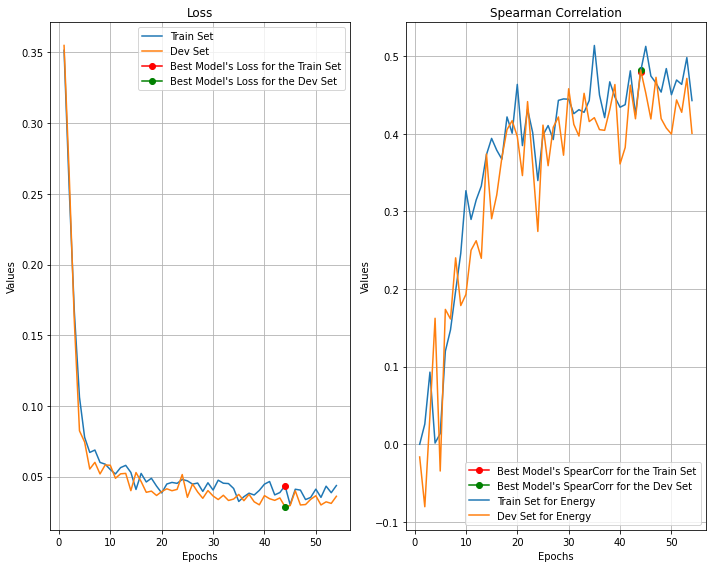

In [ ]:
EarlyLSTMNet = LSTM2(input_dim=mels_feats,
                    rnn_size=HIDDEN_LAYER,
                    output_dim=OUTPUT_SIZE,
                    num_layers=NUM_LAYERS,
                    dropout=dropout,
                    pack_padded_sequence=pack_padded_sequence).to(device)

# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(EarlyLSTMNet.parameters(), lr=ETA, weight_decay=weight_decay)

# Start the training process
reg_main(device, EarlyLSTMNet, mels_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, Descrs = ['Energy'], net_name='EarlyLSTM_multibeatEn', PATIENCE=PATIENCE)

LSTM2(
  (softmax): Softmax(dim=-1)
  (non_linearity): Tanh()
  (lstm): LSTM(128, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): FullyConnectedLayer(
    (fc1): Linear(in_features=50, out_features=25, bias=True)
    (fc2): Linear(in_features=25, out_features=1, bias=True)
  )
)
Spearman Correlation for Energy: 0.4114610234554709


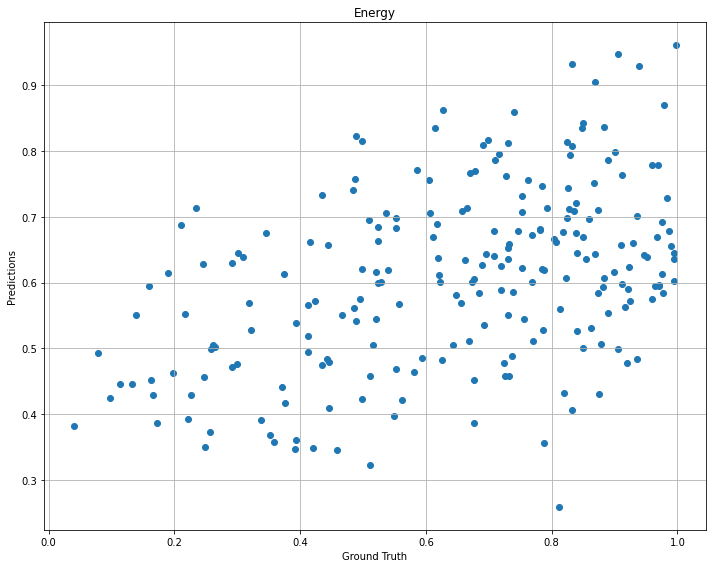

In [ ]:
with open('./best_EarlyLSTM_multibeatEn.pickle', 'rb') as handle:
    E_model = pickle.load(handle)
print(E_model)
# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
_ = reg_eval(device, dev_loader, mels_feats, E_model, criterion, titles=['Energy'])


####  Emotion "Danceability"

In [ ]:
data = SpectrogramDataset("data/multitask_dataset_beat/",
                              class_mapping=class_mapping, train=True, read_spec_fn=read_mel_spectrogram, emotion=mapping['danceability'])
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/multitask_dataset_beat/',
                                          class_mapping=class_mapping, train=False, read_spec_fn=read_mel_spectrogram, emotion=mapping['danceability'])

##### Normal Training

True


  0%|          | 0/100 [00:00<?, ?it/s]

 [=================================-------] ...Epoch 1, Loss: 0.2561

  1%|          | 1/100 [00:00<01:19,  1.25it/s]


Statistics for the Train Set
	 Epoch: 1 	 loss: 0.17618953200902138
	 Epoch: 1 	 Spear Corr 1: 0.13573849929495552
Statistics for the Dev Set
	 Epoch: 1 	 loss: 0.16695957036422532
	 Epoch: 1 	 Spear Corr 1: 0.1273415697671795
Dev loss decreased (0.166960 --> 0.166960).  Saving model ...
Epoch total time 0.7996401786804199
 [=================================-------] ...Epoch 2, Loss: 0.2797

  2%|▏         | 2/100 [00:01<01:18,  1.25it/s]


Statistics for the Train Set
	 Epoch: 2 	 loss: 0.14325503755707575
	 Epoch: 2 	 Spear Corr 1: 0.16003720273511973
Statistics for the Dev Set
	 Epoch: 2 	 loss: 0.13307460091064463
	 Epoch: 2 	 Spear Corr 1: 0.18930723515486353
Dev loss decreased (0.166960 --> 0.133075).  Saving model ...
Epoch total time 0.797316312789917
 [=================================-------] ...Epoch 3, Loss: 0.2925

  3%|▎         | 3/100 [00:02<01:21,  1.19it/s]


Statistics for the Train Set
	 Epoch: 3 	 loss: 0.10278371819471731
	 Epoch: 3 	 Spear Corr 1: 0.12152673422320558
Statistics for the Dev Set
	 Epoch: 3 	 loss: 0.09613779840218428
	 Epoch: 3 	 Spear Corr 1: 0.09254250453843392
Dev loss decreased (0.133075 --> 0.096138).  Saving model ...
Epoch total time 0.87074875831604
 [=================================-------] ...Epoch 4, Loss: 0.2146

  4%|▍         | 4/100 [00:03<01:20,  1.19it/s]


Statistics for the Train Set
	 Epoch: 4 	 loss: 0.05060817711718054
	 Epoch: 4 	 Spear Corr 1: 0.10537272204464743
Statistics for the Dev Set
	 Epoch: 4 	 loss: 0.03920657170220176
	 Epoch: 4 	 Spear Corr 1: 0.1935999295401415
Dev loss decreased (0.096138 --> 0.039207).  Saving model ...
Epoch total time 0.8505518436431885
 [=================================-------] ...Epoch 5, Loss: -0.0131

  5%|▌         | 5/100 [00:04<01:19,  1.19it/s]


Statistics for the Train Set
	 Epoch: 5 	 loss: 0.027015092882988395
	 Epoch: 5 	 Spear Corr 1: 0.1799418185100158
Statistics for the Dev Set
	 Epoch: 5 	 loss: 0.02874880665575838
	 Epoch: 5 	 Spear Corr 1: 0.16290938016627704
Dev loss decreased (0.039207 --> 0.028749).  Saving model ...
Epoch total time 0.8292844295501709
 [=================================-------] ...Epoch 6, Loss: 0.1996

  6%|▌         | 6/100 [00:05<01:18,  1.19it/s]


Statistics for the Train Set
	 Epoch: 6 	 loss: 0.02554511150089786
	 Epoch: 6 	 Spear Corr 1: 0.1919505087761036
Statistics for the Dev Set
	 Epoch: 6 	 loss: 0.023670499539858357
	 Epoch: 6 	 Spear Corr 1: 0.20935173162097856
Dev loss decreased (0.028749 --> 0.023670).  Saving model ...
Epoch total time 0.8389132022857666
 [=================================-------] ...Epoch 7, Loss: -0.0295

  7%|▋         | 7/100 [00:05<01:17,  1.19it/s]


Statistics for the Train Set
	 Epoch: 7 	 loss: 0.025071463472262384
	 Epoch: 7 	 Spear Corr 1: 0.19771846367252768
Statistics for the Dev Set
	 Epoch: 7 	 loss: 0.018213795497396223
	 Epoch: 7 	 Spear Corr 1: 0.25325241935620396
Dev loss decreased (0.023670 --> 0.018214).  Saving model ...
Epoch total time 0.8338727951049805
 [=================================-------] ...Epoch 8, Loss: -0.0586

  8%|▊         | 8/100 [00:06<01:16,  1.20it/s]


Statistics for the Train Set
	 Epoch: 8 	 loss: 0.006687055678374167
	 Epoch: 8 	 Spear Corr 1: 0.3222649143983763
Statistics for the Dev Set
	 Epoch: 8 	 loss: 0.014983205868539847
	 Epoch: 8 	 Spear Corr 1: 0.3084130884338347
Dev loss decreased (0.018214 --> 0.014983).  Saving model ...
Epoch total time 0.8246891498565674
 [=================================-------] ...Epoch 9, Loss: -0.0799

  9%|▉         | 9/100 [00:07<01:15,  1.20it/s]


Statistics for the Train Set
	 Epoch: 9 	 loss: 0.01547697422073397
	 Epoch: 9 	 Spear Corr 1: 0.2696098191365834
Statistics for the Dev Set
	 Epoch: 9 	 loss: 0.014941033658605139
	 Epoch: 9 	 Spear Corr 1: 0.3141808126147255
Dev loss decreased (0.014983 --> 0.014941).  Saving model ...
Epoch total time 0.8207912445068359
 [=================================-------] ...Epoch 10, Loss: -0.0959

 10%|█         | 10/100 [00:08<01:13,  1.22it/s]


Statistics for the Train Set
	 Epoch: 10 	 loss: 0.01207920224002614
	 Epoch: 10 	 Spear Corr 1: 0.2767189910608062
Statistics for the Dev Set
	 Epoch: 10 	 loss: 0.012459059356227552
	 Epoch: 10 	 Spear Corr 1: 0.344988275316581
Dev loss decreased (0.014941 --> 0.012459).  Saving model ...
Epoch total time 0.7967686653137207
 [=================================-------] ...Epoch 11, Loss: -0.0931

 11%|█         | 11/100 [00:09<01:12,  1.23it/s]


Statistics for the Train Set
	 Epoch: 11 	 loss: 0.007300783447950719
	 Epoch: 11 	 Spear Corr 1: 0.33739345768808016
Statistics for the Dev Set
	 Epoch: 11 	 loss: 0.017693210539388802
	 Epoch: 11 	 Spear Corr 1: 0.30865972750932263
EarlyStopping counter: 1 out of 10
Epoch total time 0.7979395389556885
 [=================================-------] ...Epoch 12, Loss: -0.0582

 12%|█▏        | 12/100 [00:09<01:11,  1.23it/s]


Statistics for the Train Set
	 Epoch: 12 	 loss: 0.01838255587421473
	 Epoch: 12 	 Spear Corr 1: 0.31247316756313553
Statistics for the Dev Set
	 Epoch: 12 	 loss: 0.015183746267487946
	 Epoch: 12 	 Spear Corr 1: 0.29242425659213905
EarlyStopping counter: 2 out of 10
Epoch total time 0.8073432445526123
 [=================================-------] ...Epoch 13, Loss: -0.0784

 13%|█▎        | 13/100 [00:10<01:10,  1.24it/s]


Statistics for the Train Set
	 Epoch: 13 	 loss: 0.005362610587756694
	 Epoch: 13 	 Spear Corr 1: 0.3564505995092235
Statistics for the Dev Set
	 Epoch: 13 	 loss: 0.013039578933819218
	 Epoch: 13 	 Spear Corr 1: 0.3419757551802642
EarlyStopping counter: 3 out of 10
Epoch total time 0.7940034866333008
 [=================================-------] ...Epoch 14, Loss: -0.0460

 14%|█▍        | 14/100 [00:11<01:09,  1.24it/s]


Statistics for the Train Set
	 Epoch: 14 	 loss: 0.007810753282543341
	 Epoch: 14 	 Spear Corr 1: 0.3542482752969957
Statistics for the Dev Set
	 Epoch: 14 	 loss: 0.012142816088831509
	 Epoch: 14 	 Spear Corr 1: 0.3420232679025984
Dev loss decreased (0.012459 --> 0.012143).  Saving model ...
Epoch total time 0.8075764179229736
 [=================================-------] ...Epoch 15, Loss: -0.0897

 15%|█▌        | 15/100 [00:12<01:08,  1.24it/s]


Statistics for the Train Set
	 Epoch: 15 	 loss: 0.003473404267132206
	 Epoch: 15 	 Spear Corr 1: 0.3624849948618257
Statistics for the Dev Set
	 Epoch: 15 	 loss: 0.011604785512623292
	 Epoch: 15 	 Spear Corr 1: 0.3640035074157248
Dev loss decreased (0.012143 --> 0.011605).  Saving model ...
Epoch total time 0.7991833686828613
 [=================================-------] ...Epoch 16, Loss: 0.0082

 16%|█▌        | 16/100 [00:13<01:08,  1.23it/s]


Statistics for the Train Set
	 Epoch: 16 	 loss: 0.01124187079478977
	 Epoch: 16 	 Spear Corr 1: 0.34981486750993207
Statistics for the Dev Set
	 Epoch: 16 	 loss: 0.007891543747302669
	 Epoch: 16 	 Spear Corr 1: 0.41667910096003025
Dev loss decreased (0.011605 --> 0.007892).  Saving model ...
Epoch total time 0.8180949687957764
 [=================================-------] ...Epoch 17, Loss: -0.0985

 17%|█▋        | 17/100 [00:13<01:06,  1.24it/s]


Statistics for the Train Set
	 Epoch: 17 	 loss: 0.004971845857138186
	 Epoch: 17 	 Spear Corr 1: 0.33214234275730836
Statistics for the Dev Set
	 Epoch: 17 	 loss: 0.008295702343364275
	 Epoch: 17 	 Spear Corr 1: 0.3882205818342503
EarlyStopping counter: 1 out of 10
Epoch total time 0.7942168712615967
 [=================================-------] ...Epoch 18, Loss: -0.0688

 18%|█▊        | 18/100 [00:14<01:06,  1.23it/s]


Statistics for the Train Set
	 Epoch: 18 	 loss: 0.004757585978040892
	 Epoch: 18 	 Spear Corr 1: 0.343932579440177
Statistics for the Dev Set
	 Epoch: 18 	 loss: 0.007768860356430665
	 Epoch: 18 	 Spear Corr 1: 0.39356175921575826
Dev loss decreased (0.007892 --> 0.007769).  Saving model ...
Epoch total time 0.8293256759643555
 [=================================-------] ...Epoch 19, Loss: 0.1474

 19%|█▉        | 19/100 [00:15<01:06,  1.22it/s]


Statistics for the Train Set
	 Epoch: 19 	 loss: 0.007205203349729117
	 Epoch: 19 	 Spear Corr 1: 0.4043848259276774
Statistics for the Dev Set
	 Epoch: 19 	 loss: 0.006664395132571802
	 Epoch: 19 	 Spear Corr 1: 0.374169628442817
Dev loss decreased (0.007769 --> 0.006664).  Saving model ...
Epoch total time 0.8191571235656738
 [=================================-------] ...Epoch 20, Loss: -0.0410

 20%|██        | 20/100 [00:16<01:05,  1.23it/s]


Statistics for the Train Set
	 Epoch: 20 	 loss: 0.0015082837173488826
	 Epoch: 20 	 Spear Corr 1: 0.3844257039933392
Statistics for the Dev Set
	 Epoch: 20 	 loss: 0.012554282608950477
	 Epoch: 20 	 Spear Corr 1: 0.31628258326450037
EarlyStopping counter: 1 out of 10
Epoch total time 0.7997605800628662
 [=================================-------] ...Epoch 21, Loss: -0.0958

 21%|██        | 21/100 [00:17<01:03,  1.23it/s]


Statistics for the Train Set
	 Epoch: 21 	 loss: 0.0016324154574677522
	 Epoch: 21 	 Spear Corr 1: 0.3719150415486074
Statistics for the Dev Set
	 Epoch: 21 	 loss: 0.009893921575360067
	 Epoch: 21 	 Spear Corr 1: 0.359198850101025
EarlyStopping counter: 2 out of 10
Epoch total time 0.8019092082977295
 [=================================-------] ...Epoch 22, Loss: 0.1586

 22%|██▏       | 22/100 [00:18<01:03,  1.23it/s]


Statistics for the Train Set
	 Epoch: 22 	 loss: -0.003355470568146471
	 Epoch: 22 	 Spear Corr 1: 0.4068214672746104
Statistics for the Dev Set
	 Epoch: 22 	 loss: 0.012581324132235228
	 Epoch: 22 	 Spear Corr 1: 0.3446588893651177
EarlyStopping counter: 3 out of 10
Epoch total time 0.818697452545166
 [=================================-------] ...Epoch 23, Loss: -0.0732

 23%|██▎       | 23/100 [00:18<01:02,  1.23it/s]


Statistics for the Train Set
	 Epoch: 23 	 loss: 0.0003688320795428823
	 Epoch: 23 	 Spear Corr 1: 0.36333496618242705
Statistics for the Dev Set
	 Epoch: 23 	 loss: 0.00022338132383703822
	 Epoch: 23 	 Spear Corr 1: 0.43392942227224096
Dev loss decreased (0.006664 --> 0.000223).  Saving model ...
Epoch total time 0.7976984977722168
 [=================================-------] ...Epoch 24, Loss: 0.1860

 24%|██▍       | 24/100 [00:19<01:01,  1.23it/s]


Statistics for the Train Set
	 Epoch: 24 	 loss: 0.009146707562907237
	 Epoch: 24 	 Spear Corr 1: 0.3842589808892183
Statistics for the Dev Set
	 Epoch: 24 	 loss: 0.003331044512501572
	 Epoch: 24 	 Spear Corr 1: 0.41447269555095756
EarlyStopping counter: 1 out of 10
Epoch total time 0.817791223526001
 [=================================-------] ...Epoch 25, Loss: 0.1083

 25%|██▌       | 25/100 [00:20<01:01,  1.21it/s]


Statistics for the Train Set
	 Epoch: 25 	 loss: 0.004791138775042306
	 Epoch: 25 	 Spear Corr 1: 0.392648412586642
Statistics for the Dev Set
	 Epoch: 25 	 loss: 0.008388586816202139
	 Epoch: 25 	 Spear Corr 1: 0.34083331444099113
EarlyStopping counter: 2 out of 10
Epoch total time 0.8530113697052002
 [=================================-------] ...Epoch 26, Loss: -0.0774

 26%|██▌       | 26/100 [00:21<01:04,  1.16it/s]


Statistics for the Train Set
	 Epoch: 26 	 loss: 0.0006512022195097319
	 Epoch: 26 	 Spear Corr 1: 0.443886891742637
Statistics for the Dev Set
	 Epoch: 26 	 loss: 0.0044219195573626194
	 Epoch: 26 	 Spear Corr 1: 0.4023388004280895
EarlyStopping counter: 3 out of 10
Epoch total time 0.9565291404724121
 [=================================-------] ...Epoch 27, Loss: 0.1137

 27%|██▋       | 27/100 [00:22<01:02,  1.17it/s]


Statistics for the Train Set
	 Epoch: 27 	 loss: 0.0034020675029988955
	 Epoch: 27 	 Spear Corr 1: 0.3940546716762313
Statistics for the Dev Set
	 Epoch: 27 	 loss: 0.0014805727118343945
	 Epoch: 27 	 Spear Corr 1: 0.4259771805656
EarlyStopping counter: 4 out of 10
Epoch total time 0.819115400314331
 [=================================-------] ...Epoch 28, Loss: -0.0250

 28%|██▊       | 28/100 [00:23<01:00,  1.19it/s]


Statistics for the Train Set
	 Epoch: 28 	 loss: 0.006487273035416463
	 Epoch: 28 	 Spear Corr 1: 0.3880056190742906
Statistics for the Dev Set
	 Epoch: 28 	 loss: 0.001078451593645827
	 Epoch: 28 	 Spear Corr 1: 0.40722673846957747
EarlyStopping counter: 5 out of 10
Epoch total time 0.8109536170959473
 [=================================-------] ...Epoch 29, Loss: -0.0821

 29%|██▉       | 29/100 [00:23<00:58,  1.20it/s]


Statistics for the Train Set
	 Epoch: 29 	 loss: 0.007735459395544399
	 Epoch: 29 	 Spear Corr 1: 0.4089187630568691
Statistics for the Dev Set
	 Epoch: 29 	 loss: 0.006725528497228456
	 Epoch: 29 	 Spear Corr 1: 0.3970798360717441
EarlyStopping counter: 6 out of 10
Epoch total time 0.8048381805419922
 [=================================-------] ...Epoch 30, Loss: -0.0901

 30%|███       | 30/100 [00:24<00:57,  1.22it/s]


Statistics for the Train Set
	 Epoch: 30 	 loss: 0.004347915274169444
	 Epoch: 30 	 Spear Corr 1: 0.3948052073556164
Statistics for the Dev Set
	 Epoch: 30 	 loss: 0.013609395242456851
	 Epoch: 30 	 Spear Corr 1: 0.30754077620581033
EarlyStopping counter: 7 out of 10
Epoch total time 0.796483039855957
 [=================================-------] ...Epoch 31, Loss: -0.0949

 31%|███       | 31/100 [00:25<00:56,  1.22it/s]


Statistics for the Train Set
	 Epoch: 31 	 loss: 0.00774944667536694
	 Epoch: 31 	 Spear Corr 1: 0.3931383988806685
Statistics for the Dev Set
	 Epoch: 31 	 loss: 0.006794436750270101
	 Epoch: 31 	 Spear Corr 1: 0.42848894863956255
EarlyStopping counter: 8 out of 10
Epoch total time 0.8168556690216064
 [=================================-------] ...Epoch 32, Loss: -0.0884

 32%|███▏      | 32/100 [00:26<00:55,  1.22it/s]


Statistics for the Train Set
	 Epoch: 32 	 loss: 0.001071937970878857
	 Epoch: 32 	 Spear Corr 1: 0.4429686138287361
Statistics for the Dev Set
	 Epoch: 32 	 loss: 0.009570782538443833
	 Epoch: 32 	 Spear Corr 1: 0.3724511626765926
EarlyStopping counter: 9 out of 10
Epoch total time 0.8139832019805908
 [=================================-------] ...Epoch 33, Loss: 0.1334

 33%|███▎      | 33/100 [00:27<00:55,  1.20it/s]


Statistics for the Train Set
	 Epoch: 33 	 loss: 0.0012069700712851977
	 Epoch: 33 	 Spear Corr 1: 0.4185377300049102
Statistics for the Dev Set
	 Epoch: 33 	 loss: 3.7286168975954724e-05
	 Epoch: 33 	 Spear Corr 1: 0.47669354162713345
Dev loss decreased (0.000223 --> 0.000037).  Saving model ...
Epoch total time 0.8553600311279297
 [=================================-------] ...Epoch 34, Loss: -0.0923

 34%|███▍      | 34/100 [00:28<00:55,  1.20it/s]


Statistics for the Train Set
	 Epoch: 34 	 loss: -0.005981799552798845
	 Epoch: 34 	 Spear Corr 1: 0.43035830860246377
Statistics for the Dev Set
	 Epoch: 34 	 loss: 0.000624511502598917
	 Epoch: 34 	 Spear Corr 1: 0.4455230603726118
EarlyStopping counter: 1 out of 10
Epoch total time 0.8467886447906494
 [=================================-------] ...Epoch 35, Loss: 0.1374

 35%|███▌      | 35/100 [00:28<00:53,  1.21it/s]


Statistics for the Train Set
	 Epoch: 35 	 loss: -0.005399252704348078
	 Epoch: 35 	 Spear Corr 1: 0.43744268997268954
Statistics for the Dev Set
	 Epoch: 35 	 loss: 0.0063794876049659425
	 Epoch: 35 	 Spear Corr 1: 0.38541679736571655
EarlyStopping counter: 2 out of 10
Epoch total time 0.80027174949646
 [=================================-------] ...Epoch 36, Loss: 0.1227

 36%|███▌      | 36/100 [00:29<00:52,  1.21it/s]


Statistics for the Train Set
	 Epoch: 36 	 loss: -0.006591935127634566
	 Epoch: 36 	 Spear Corr 1: 0.43890133666853787
Statistics for the Dev Set
	 Epoch: 36 	 loss: 0.002927935557649125
	 Epoch: 36 	 Spear Corr 1: 0.42955024405529846
EarlyStopping counter: 3 out of 10
Epoch total time 0.8261098861694336
 [=================================-------] ...Epoch 37, Loss: -0.0986

 37%|███▋      | 37/100 [00:30<00:52,  1.20it/s]


Statistics for the Train Set
	 Epoch: 37 	 loss: -0.00645315855190407
	 Epoch: 37 	 Spear Corr 1: 0.44517661368584616
Statistics for the Dev Set
	 Epoch: 37 	 loss: 0.001225705099116422
	 Epoch: 37 	 Spear Corr 1: 0.4370359001516009
EarlyStopping counter: 4 out of 10
Epoch total time 0.8549795150756836
 [=================================-------] ...Epoch 38, Loss: -0.0853

 38%|███▊      | 38/100 [00:31<00:51,  1.19it/s]


Statistics for the Train Set
	 Epoch: 38 	 loss: -0.009565000713209659
	 Epoch: 38 	 Spear Corr 1: 0.46168689065075713
Statistics for the Dev Set
	 Epoch: 38 	 loss: 0.009898890494842646
	 Epoch: 38 	 Spear Corr 1: 0.3549985119063518
EarlyStopping counter: 5 out of 10
Epoch total time 0.839979887008667
 [=================================-------] ...Epoch 39, Loss: -0.0297

 39%|███▉      | 39/100 [00:32<00:51,  1.18it/s]


Statistics for the Train Set
	 Epoch: 39 	 loss: -0.0032460480130639515
	 Epoch: 39 	 Spear Corr 1: 0.42804394633169696
Statistics for the Dev Set
	 Epoch: 39 	 loss: -0.00333859700927197
	 Epoch: 39 	 Spear Corr 1: 0.4986396146882442
Dev loss decreased (0.000037 --> -0.003339).  Saving model ...
Epoch total time 0.859025239944458
 [=================================-------] ...Epoch 40, Loss: 0.1218

 40%|████      | 40/100 [00:33<00:50,  1.19it/s]


Statistics for the Train Set
	 Epoch: 40 	 loss: 0.002756806339058875
	 Epoch: 40 	 Spear Corr 1: 0.42021322180224746
Statistics for the Dev Set
	 Epoch: 40 	 loss: 0.0067734925727557516
	 Epoch: 40 	 Spear Corr 1: 0.38926799712885485
EarlyStopping counter: 1 out of 10
Epoch total time 0.8271055221557617
 [=================================-------] ...Epoch 41, Loss: -0.0429

 41%|████      | 41/100 [00:33<00:49,  1.20it/s]


Statistics for the Train Set
	 Epoch: 41 	 loss: -0.0064735829018011245
	 Epoch: 41 	 Spear Corr 1: 0.4609950005399522
Statistics for the Dev Set
	 Epoch: 41 	 loss: 0.0039327584619815335
	 Epoch: 41 	 Spear Corr 1: 0.40351594147019093
EarlyStopping counter: 2 out of 10
Epoch total time 0.8127338886260986
 [=================================-------] ...Epoch 42, Loss: -0.0619

 42%|████▏     | 42/100 [00:34<00:47,  1.22it/s]


Statistics for the Train Set
	 Epoch: 42 	 loss: -0.004922255746948412
	 Epoch: 42 	 Spear Corr 1: 0.4366696174260344
Statistics for the Dev Set
	 Epoch: 42 	 loss: 0.0048181630589454166
	 Epoch: 42 	 Spear Corr 1: 0.40971768636184297
EarlyStopping counter: 3 out of 10
Epoch total time 0.7960801124572754
 [=================================-------] ...Epoch 43, Loss: -0.0874

 43%|████▎     | 43/100 [00:35<00:46,  1.22it/s]


Statistics for the Train Set
	 Epoch: 43 	 loss: -0.008062551128231555
	 Epoch: 43 	 Spear Corr 1: 0.44908932041161503
Statistics for the Dev Set
	 Epoch: 43 	 loss: 0.0059904105249056995
	 Epoch: 43 	 Spear Corr 1: 0.3746063184076419
EarlyStopping counter: 4 out of 10
Epoch total time 0.8094539642333984
 [=================================-------] ...Epoch 44, Loss: -0.0794

 44%|████▍     | 44/100 [00:36<00:45,  1.22it/s]


Statistics for the Train Set
	 Epoch: 44 	 loss: -0.0008833745678450056
	 Epoch: 44 	 Spear Corr 1: 0.4611612927921988
Statistics for the Dev Set
	 Epoch: 44 	 loss: -0.0018249821715831131
	 Epoch: 44 	 Spear Corr 1: 0.4712087583769972
EarlyStopping counter: 5 out of 10
Epoch total time 0.8093414306640625
 [=================================-------] ...Epoch 45, Loss: -0.0898

 45%|████▌     | 45/100 [00:37<00:45,  1.22it/s]


Statistics for the Train Set
	 Epoch: 45 	 loss: -0.00874582721391758
	 Epoch: 45 	 Spear Corr 1: 0.4823490634165668
Statistics for the Dev Set
	 Epoch: 45 	 loss: -0.003353012197592864
	 Epoch: 45 	 Spear Corr 1: 0.4730863116854193
Dev loss decreased (-0.003339 --> -0.003353).  Saving model ...
Epoch total time 0.8163371086120605
 [=================================-------] ...Epoch 46, Loss: -0.0838

 46%|████▌     | 46/100 [00:37<00:44,  1.23it/s]


Statistics for the Train Set
	 Epoch: 46 	 loss: 0.00262872279049395
	 Epoch: 46 	 Spear Corr 1: 0.41921721655310357
Statistics for the Dev Set
	 Epoch: 46 	 loss: -0.00139330656913348
	 Epoch: 46 	 Spear Corr 1: 0.43692646073498825
EarlyStopping counter: 1 out of 10
Epoch total time 0.8073089122772217
 [=================================-------] ...Epoch 47, Loss: -0.0455

 47%|████▋     | 47/100 [00:38<00:43,  1.22it/s]


Statistics for the Train Set
	 Epoch: 47 	 loss: -0.002002912992853805
	 Epoch: 47 	 Spear Corr 1: 0.48331428761353845
Statistics for the Dev Set
	 Epoch: 47 	 loss: -0.0015706812658761924
	 Epoch: 47 	 Spear Corr 1: 0.4588896170221068
EarlyStopping counter: 2 out of 10
Epoch total time 0.8229057788848877
 [=================================-------] ...Epoch 48, Loss: -0.0496

 48%|████▊     | 48/100 [00:39<00:42,  1.22it/s]


Statistics for the Train Set
	 Epoch: 48 	 loss: -0.008974361885565748
	 Epoch: 48 	 Spear Corr 1: 0.48931610393595465
Statistics for the Dev Set
	 Epoch: 48 	 loss: -0.008489608734554057
	 Epoch: 48 	 Spear Corr 1: 0.5166581473199942
Dev loss decreased (-0.003353 --> -0.008490).  Saving model ...
Epoch total time 0.82340407371521
 [=================================-------] ...Epoch 49, Loss: -0.0817

 49%|████▉     | 49/100 [00:40<00:41,  1.22it/s]


Statistics for the Train Set
	 Epoch: 49 	 loss: -0.0021946800394134023
	 Epoch: 49 	 Spear Corr 1: 0.4430762190843378
Statistics for the Dev Set
	 Epoch: 49 	 loss: 0.01087405157341492
	 Epoch: 49 	 Spear Corr 1: 0.3794958580015681
EarlyStopping counter: 1 out of 10
Epoch total time 0.8087887763977051
 [=================================-------] ...Epoch 50, Loss: -0.0803

 50%|█████     | 50/100 [00:41<00:41,  1.21it/s]


Statistics for the Train Set
	 Epoch: 50 	 loss: -0.005015040233037792
	 Epoch: 50 	 Spear Corr 1: 0.4439403730706834
Statistics for the Dev Set
	 Epoch: 50 	 loss: -0.002044871931981339
	 Epoch: 50 	 Spear Corr 1: 0.459012402709038
EarlyStopping counter: 2 out of 10
Epoch total time 0.8284804821014404
 [=================================-------] ...Epoch 51, Loss: 0.0189

 51%|█████     | 51/100 [00:42<00:40,  1.22it/s]


Statistics for the Train Set
	 Epoch: 51 	 loss: -0.003672743275020855
	 Epoch: 51 	 Spear Corr 1: 0.49548859559987696
Statistics for the Dev Set
	 Epoch: 51 	 loss: 0.0020959094879803943
	 Epoch: 51 	 Spear Corr 1: 0.42869715045653284
EarlyStopping counter: 3 out of 10
Epoch total time 0.8033413887023926
 [=================================-------] ...Epoch 52, Loss: -0.0883

 52%|█████▏    | 52/100 [00:42<00:39,  1.22it/s]


Statistics for the Train Set
	 Epoch: 52 	 loss: -0.006180084309219808
	 Epoch: 52 	 Spear Corr 1: 0.46610690888726625
Statistics for the Dev Set
	 Epoch: 52 	 loss: -0.0009971665621746856
	 Epoch: 52 	 Spear Corr 1: 0.4647827961439925
EarlyStopping counter: 4 out of 10
Epoch total time 0.8217184543609619
 [=================================-------] ...Epoch 53, Loss: 0.1339

 53%|█████▎    | 53/100 [00:43<00:38,  1.23it/s]


Statistics for the Train Set
	 Epoch: 53 	 loss: -0.010998636550448115
	 Epoch: 53 	 Spear Corr 1: 0.4870512896307302
Statistics for the Dev Set
	 Epoch: 53 	 loss: -9.093149954309831e-05
	 Epoch: 53 	 Spear Corr 1: 0.4087749058265363
EarlyStopping counter: 5 out of 10
Epoch total time 0.8066163063049316
 [=================================-------] ...Epoch 54, Loss: -0.0888

 54%|█████▍    | 54/100 [00:44<00:37,  1.23it/s]


Statistics for the Train Set
	 Epoch: 54 	 loss: -0.00869856752076782
	 Epoch: 54 	 Spear Corr 1: 0.46247065992375264
Statistics for the Dev Set
	 Epoch: 54 	 loss: -0.0007774789444634242
	 Epoch: 54 	 Spear Corr 1: 0.4486167258324657
EarlyStopping counter: 6 out of 10
Epoch total time 0.8103208541870117
 [=================================-------] ...Epoch 55, Loss: -0.0691

 55%|█████▌    | 55/100 [00:45<00:36,  1.22it/s]


Statistics for the Train Set
	 Epoch: 55 	 loss: -0.011947751024642843
	 Epoch: 55 	 Spear Corr 1: 0.47751242798885357
Statistics for the Dev Set
	 Epoch: 55 	 loss: 0.00705821241959813
	 Epoch: 55 	 Spear Corr 1: 0.3736320406743833
EarlyStopping counter: 7 out of 10
Epoch total time 0.8315651416778564
 [=================================-------] ...Epoch 56, Loss: 0.1356

 56%|█████▌    | 56/100 [00:46<00:36,  1.21it/s]


Statistics for the Train Set
	 Epoch: 56 	 loss: -0.002401219967295877
	 Epoch: 56 	 Spear Corr 1: 0.47203259699774214
Statistics for the Dev Set
	 Epoch: 56 	 loss: -0.00329288897178711
	 Epoch: 56 	 Spear Corr 1: 0.4822370484666716
EarlyStopping counter: 8 out of 10
Epoch total time 0.8409829139709473
 [=================================-------] ...Epoch 57, Loss: -0.0238

 57%|█████▋    | 57/100 [00:46<00:35,  1.20it/s]


Statistics for the Train Set
	 Epoch: 57 	 loss: -0.006112826726261666
	 Epoch: 57 	 Spear Corr 1: 0.5088128969523501
Statistics for the Dev Set
	 Epoch: 57 	 loss: -0.0007812643414971696
	 Epoch: 57 	 Spear Corr 1: 0.44614179346458255
EarlyStopping counter: 9 out of 10
Epoch total time 0.8474776744842529
 [=================================-------] ...Epoch 58, Loss: 0.1072

 57%|█████▋    | 57/100 [00:47<00:36,  1.19it/s]


Statistics for the Train Set
	 Epoch: 58 	 loss: -0.013884864335610784
	 Epoch: 58 	 Spear Corr 1: 0.5131707316635423
Statistics for the Dev Set
	 Epoch: 58 	 loss: 0.0024679628869405707
	 Epoch: 58 	 Spear Corr 1: 0.4051836914092045
EarlyStopping counter: 10 out of 10
Training total time 46.84352159500122


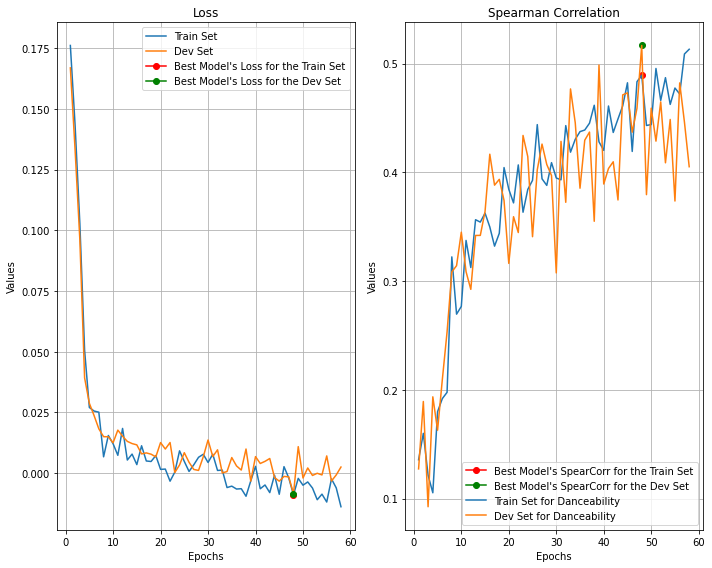

In [ ]:
EarlyLSTMNet = LSTM2(input_dim=mels_feats,
                    rnn_size=HIDDEN_LAYER,
                    output_dim=OUTPUT_SIZE,
                    num_layers=NUM_LAYERS,
                    dropout=dropout,
                    pack_padded_sequence=pack_padded_sequence).to(device)

# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(EarlyLSTMNet.parameters(), lr=ETA, weight_decay=weight_decay)

# Start the training process
reg_main(device, EarlyLSTMNet, mels_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, Descrs=['Danceability'], net_name='EarlyLSTM_multibeatDanc', PATIENCE=PATIENCE)

LSTM2(
  (softmax): Softmax(dim=-1)
  (non_linearity): Tanh()
  (lstm): LSTM(128, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): FullyConnectedLayer(
    (fc1): Linear(in_features=50, out_features=25, bias=True)
    (fc2): Linear(in_features=25, out_features=1, bias=True)
  )
)
Spearman Correlation for Danceability: 0.43325943950224677


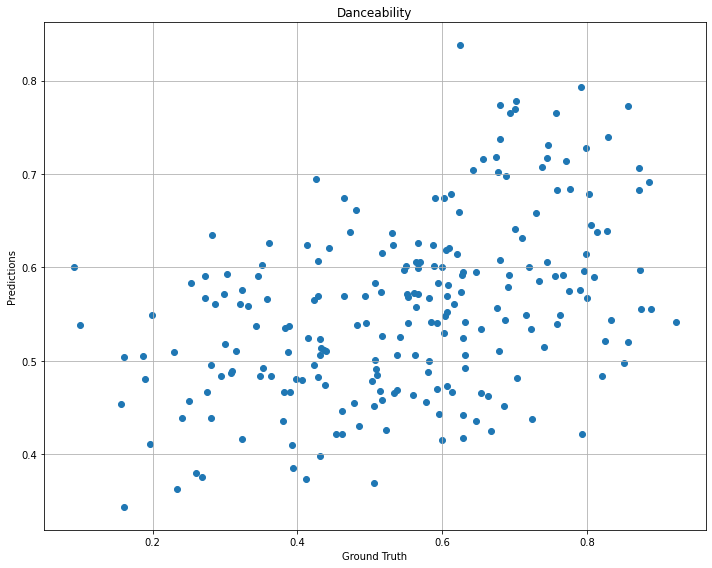

In [ ]:
with open('./best_EarlyLSTM_multibeatDanc.pickle', 'rb') as handle:
    E_model = pickle.load(handle)
print(E_model)
# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
_ = reg_eval(device, dev_loader, mels_feats, E_model, criterion, titles=['Danceability'])


### LSTM - Attention

#### Redefine LSTM Regression Parameters

In [ ]:
# Define training parameters
batch_size = 32
BATCH_SIZE = batch_size
OUTPUT_SIZE = 1
EPOCHS = 100
HIDDEN_LAYER = 50
regularization_strength = 1e-2
criterion = SpearmanLoss(regularization_strength=regularization_strength)
weight_decay = 1e-7
NUM_LAYERS = 2
PATIENCE = 10
dropout = 0.2

####  Emotion "Valence"

In [ ]:
data = SpectrogramDataset("data/multitask_dataset_beat/",
                              class_mapping=class_mapping, train=True, read_spec_fn=read_mel_spectrogram, emotion=mapping['valence'])
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/multitask_dataset_beat/',
                                          class_mapping=class_mapping, train=False, read_spec_fn=read_mel_spectrogram, emotion=mapping['valence'], max_length = data.max_length)

##### Normal Training

True


  0%|          | 0/100 [00:00<?, ?it/s]

 [=================================-------] ...Epoch 1, Loss: 0.5737

  1%|          | 1/100 [00:01<01:49,  1.10s/it]


Statistics for the Train Set
	 Epoch: 1 	 loss: 0.41841459682132215
	 Epoch: 1 	 Spear Corr 1: 0.03909826245386434
Statistics for the Dev Set
	 Epoch: 1 	 loss: 0.45632238114564844
	 Epoch: 1 	 Spear Corr 1: -0.05968811442888114
Dev loss decreased (0.456322 --> 0.456322).  Saving model ...
Epoch total time 1.104318380355835
 [=================================-------] ...Epoch 2, Loss: 0.2973

  2%|▏         | 2/100 [00:02<01:43,  1.06s/it]


Statistics for the Train Set
	 Epoch: 2 	 loss: 0.35063900487931887
	 Epoch: 2 	 Spear Corr 1: 0.006163805544721511
Statistics for the Dev Set
	 Epoch: 2 	 loss: 0.36982967870305716
	 Epoch: 2 	 Spear Corr 1: 0.03034347344999128
Dev loss decreased (0.456322 --> 0.369830).  Saving model ...
Epoch total time 1.0177960395812988
 [=================================-------] ...Epoch 3, Loss: 0.1549

  3%|▎         | 3/100 [00:03<01:39,  1.03s/it]


Statistics for the Train Set
	 Epoch: 3 	 loss: 0.2568080469579926
	 Epoch: 3 	 Spear Corr 1: -0.019867994183041665
Statistics for the Dev Set
	 Epoch: 3 	 loss: 0.29218531554137384
	 Epoch: 3 	 Spear Corr 1: -0.04079731495138521
Dev loss decreased (0.369830 --> 0.292185).  Saving model ...
Epoch total time 0.9982578754425049
 [=================================-------] ...Epoch 4, Loss: 0.5319

  4%|▍         | 4/100 [00:04<01:36,  1.00s/it]


Statistics for the Train Set
	 Epoch: 4 	 loss: 0.16547583199680843
	 Epoch: 4 	 Spear Corr 1: 0.03125447745963473
Statistics for the Dev Set
	 Epoch: 4 	 loss: 0.18707217923348998
	 Epoch: 4 	 Spear Corr 1: 0.012064999383694347
Dev loss decreased (0.292185 --> 0.187072).  Saving model ...
Epoch total time 0.9544146060943604
 [=================================-------] ...Epoch 5, Loss: 0.1565

  5%|▌         | 5/100 [00:05<01:33,  1.01it/s]


Statistics for the Train Set
	 Epoch: 5 	 loss: 0.1011356008738009
	 Epoch: 5 	 Spear Corr 1: 0.055418554112269924
Statistics for the Dev Set
	 Epoch: 5 	 loss: 0.10800223082529532
	 Epoch: 5 	 Spear Corr 1: 0.02878730206930681
Dev loss decreased (0.187072 --> 0.108002).  Saving model ...
Epoch total time 0.9643011093139648
 [=================================-------] ...Epoch 6, Loss: 0.0381

  6%|▌         | 6/100 [00:06<01:32,  1.02it/s]


Statistics for the Train Set
	 Epoch: 6 	 loss: 0.08299834503332541
	 Epoch: 6 	 Spear Corr 1: 0.04135507708485882
Statistics for the Dev Set
	 Epoch: 6 	 loss: 0.08940421509038095
	 Epoch: 6 	 Spear Corr 1: 0.018983155446229524
Dev loss decreased (0.108002 --> 0.089404).  Saving model ...
Epoch total time 0.9700913429260254
 [=================================-------] ...Epoch 7, Loss: 0.1178

  7%|▋         | 7/100 [00:06<01:30,  1.02it/s]


Statistics for the Train Set
	 Epoch: 7 	 loss: 0.09184995556299785
	 Epoch: 7 	 Spear Corr 1: -0.03603298887682922
Statistics for the Dev Set
	 Epoch: 7 	 loss: 0.09628831127559208
	 Epoch: 7 	 Spear Corr 1: -0.05392681029840196
EarlyStopping counter: 1 out of 10
Epoch total time 0.9664349555969238
 [=================================-------] ...Epoch 8, Loss: 0.2665

  8%|▊         | 8/100 [00:07<01:29,  1.02it/s]


Statistics for the Train Set
	 Epoch: 8 	 loss: 0.09026551861406235
	 Epoch: 8 	 Spear Corr 1: -0.003437122932799541
Statistics for the Dev Set
	 Epoch: 8 	 loss: 0.0824367546071961
	 Epoch: 8 	 Spear Corr 1: 0.05332836497498951
Dev loss decreased (0.089404 --> 0.082437).  Saving model ...
Epoch total time 0.9714384078979492
 [=================================-------] ...Epoch 9, Loss: 0.0432

  9%|▉         | 9/100 [00:08<01:28,  1.03it/s]


Statistics for the Train Set
	 Epoch: 9 	 loss: 0.0763381553632311
	 Epoch: 9 	 Spear Corr 1: 0.04365153001701815
Statistics for the Dev Set
	 Epoch: 9 	 loss: 0.09009655865913926
	 Epoch: 9 	 Spear Corr 1: -0.012113579690947274
EarlyStopping counter: 1 out of 10
Epoch total time 0.9507548809051514
 [=================================-------] ...Epoch 10, Loss: 0.1470

 10%|█         | 10/100 [00:09<01:27,  1.03it/s]


Statistics for the Train Set
	 Epoch: 10 	 loss: 0.08260160094553612
	 Epoch: 10 	 Spear Corr 1: 0.06321235222282649
Statistics for the Dev Set
	 Epoch: 10 	 loss: 0.07716490890272525
	 Epoch: 10 	 Spear Corr 1: 0.03468367013093973
Dev loss decreased (0.082437 --> 0.077165).  Saving model ...
Epoch total time 0.965132474899292
 [=================================-------] ...Epoch 11, Loss: -0.0122

 11%|█         | 11/100 [00:10<01:26,  1.03it/s]


Statistics for the Train Set
	 Epoch: 11 	 loss: 0.07671056342084596
	 Epoch: 11 	 Spear Corr 1: 0.03360351895326094
Statistics for the Dev Set
	 Epoch: 11 	 loss: 0.08645939848342564
	 Epoch: 11 	 Spear Corr 1: -0.023764845688696346
EarlyStopping counter: 1 out of 10
Epoch total time 0.9647433757781982
 [=================================-------] ...Epoch 12, Loss: 0.3206

 12%|█▏        | 12/100 [00:11<01:25,  1.03it/s]


Statistics for the Train Set
	 Epoch: 12 	 loss: 0.07842698522505857
	 Epoch: 12 	 Spear Corr 1: 0.040775151504773184
Statistics for the Dev Set
	 Epoch: 12 	 loss: 0.08559339155556342
	 Epoch: 12 	 Spear Corr 1: 0.004992560806916351
EarlyStopping counter: 2 out of 10
Epoch total time 0.9653100967407227
 [=================================-------] ...Epoch 13, Loss: -0.0276

 13%|█▎        | 13/100 [00:12<01:24,  1.04it/s]


Statistics for the Train Set
	 Epoch: 13 	 loss: 0.07891675744439813
	 Epoch: 13 	 Spear Corr 1: 0.07362773841939055
Statistics for the Dev Set
	 Epoch: 13 	 loss: 0.08844480436321142
	 Epoch: 13 	 Spear Corr 1: -0.06187476210479318
EarlyStopping counter: 3 out of 10
Epoch total time 0.9591364860534668
 [=================================-------] ...Epoch 14, Loss: -0.0837

 14%|█▍        | 14/100 [00:13<01:23,  1.03it/s]


Statistics for the Train Set
	 Epoch: 14 	 loss: 0.08453306872769197
	 Epoch: 14 	 Spear Corr 1: 0.0562324732674384
Statistics for the Dev Set
	 Epoch: 14 	 loss: 0.07334231681726465
	 Epoch: 14 	 Spear Corr 1: 0.11192048631826337
Dev loss decreased (0.077165 --> 0.073342).  Saving model ...
Epoch total time 0.9680500030517578
 [=================================-------] ...Epoch 15, Loss: -0.0455

 15%|█▌        | 15/100 [00:14<01:21,  1.04it/s]


Statistics for the Train Set
	 Epoch: 15 	 loss: 0.0760497135208654
	 Epoch: 15 	 Spear Corr 1: 0.03733993425952964
Statistics for the Dev Set
	 Epoch: 15 	 loss: 0.07790591142924892
	 Epoch: 15 	 Spear Corr 1: 0.10789419316110306
EarlyStopping counter: 1 out of 10
Epoch total time 0.9559750556945801
 [=================================-------] ...Epoch 16, Loss: 0.1818

 16%|█▌        | 16/100 [00:15<01:21,  1.03it/s]


Statistics for the Train Set
	 Epoch: 16 	 loss: 0.07239569125596013
	 Epoch: 16 	 Spear Corr 1: 0.04443135393613034
Statistics for the Dev Set
	 Epoch: 16 	 loss: 0.0673681809936219
	 Epoch: 16 	 Spear Corr 1: 0.13948473911376294
Dev loss decreased (0.073342 --> 0.067368).  Saving model ...
Epoch total time 0.9820013046264648
 [=================================-------] ...Epoch 17, Loss: 0.1500

 17%|█▋        | 17/100 [00:16<01:20,  1.04it/s]


Statistics for the Train Set
	 Epoch: 17 	 loss: 0.07527693523227467
	 Epoch: 17 	 Spear Corr 1: 0.0930138836466961
Statistics for the Dev Set
	 Epoch: 17 	 loss: 0.08451715197597379
	 Epoch: 17 	 Spear Corr 1: -0.018845422267424517
EarlyStopping counter: 1 out of 10
Epoch total time 0.9510183334350586
 [=================================-------] ...Epoch 18, Loss: 0.1820

 18%|█▊        | 18/100 [00:17<01:19,  1.03it/s]


Statistics for the Train Set
	 Epoch: 18 	 loss: 0.07061582846403286
	 Epoch: 18 	 Spear Corr 1: 0.06805429002272428
Statistics for the Dev Set
	 Epoch: 18 	 loss: 0.07508515156085227
	 Epoch: 18 	 Spear Corr 1: 0.08929434167759445
EarlyStopping counter: 2 out of 10
Epoch total time 0.9753410816192627
 [=================================-------] ...Epoch 19, Loss: 0.2404

 19%|█▉        | 19/100 [00:18<01:18,  1.04it/s]


Statistics for the Train Set
	 Epoch: 19 	 loss: 0.08069525926016975
	 Epoch: 19 	 Spear Corr 1: 0.08567640656422329
Statistics for the Dev Set
	 Epoch: 19 	 loss: 0.07018831755618357
	 Epoch: 19 	 Spear Corr 1: 0.09399648834005374
EarlyStopping counter: 3 out of 10
Epoch total time 0.9576213359832764
 [=================================-------] ...Epoch 20, Loss: -0.0242

 20%|██        | 20/100 [00:19<01:17,  1.03it/s]


Statistics for the Train Set
	 Epoch: 20 	 loss: 0.08285951164371783
	 Epoch: 20 	 Spear Corr 1: 0.04762159918884884
Statistics for the Dev Set
	 Epoch: 20 	 loss: 0.0716528018983817
	 Epoch: 20 	 Spear Corr 1: 0.06282127732192991
EarlyStopping counter: 4 out of 10
Epoch total time 0.9626507759094238
 [=================================-------] ...Epoch 21, Loss: 0.2405

 21%|██        | 21/100 [00:20<01:16,  1.03it/s]


Statistics for the Train Set
	 Epoch: 21 	 loss: 0.07020438116330582
	 Epoch: 21 	 Spear Corr 1: 0.0964593004631633
Statistics for the Dev Set
	 Epoch: 21 	 loss: 0.07783603852732522
	 Epoch: 21 	 Spear Corr 1: 0.03993674950861904
EarlyStopping counter: 5 out of 10
Epoch total time 0.980208158493042
 [=================================-------] ...Epoch 22, Loss: 0.0480

 22%|██▏       | 22/100 [00:21<01:15,  1.03it/s]


Statistics for the Train Set
	 Epoch: 22 	 loss: 0.06619184888083852
	 Epoch: 22 	 Spear Corr 1: 0.10956714975162199
Statistics for the Dev Set
	 Epoch: 22 	 loss: 0.07686544173877338
	 Epoch: 22 	 Spear Corr 1: 0.04208976466412521
EarlyStopping counter: 6 out of 10
Epoch total time 0.9578778743743896
 [=================================-------] ...Epoch 23, Loss: -0.0345

 23%|██▎       | 23/100 [00:22<01:15,  1.02it/s]


Statistics for the Train Set
	 Epoch: 23 	 loss: 0.07817876481790466
	 Epoch: 23 	 Spear Corr 1: 0.102580136896296
Statistics for the Dev Set
	 Epoch: 23 	 loss: 0.07056687932142273
	 Epoch: 23 	 Spear Corr 1: 0.13431173716562142
EarlyStopping counter: 7 out of 10
Epoch total time 1.015568733215332
 [=================================-------] ...Epoch 24, Loss: -0.0787

 24%|██▍       | 24/100 [00:23<01:14,  1.01it/s]


Statistics for the Train Set
	 Epoch: 24 	 loss: 0.0798191476613537
	 Epoch: 24 	 Spear Corr 1: 0.06224355038294346
Statistics for the Dev Set
	 Epoch: 24 	 loss: 0.0761188544085307
	 Epoch: 24 	 Spear Corr 1: 0.07375558340055059
EarlyStopping counter: 8 out of 10
Epoch total time 0.9890556335449219
 [=================================-------] ...Epoch 25, Loss: 0.1288

 25%|██▌       | 25/100 [00:24<01:13,  1.02it/s]


Statistics for the Train Set
	 Epoch: 25 	 loss: 0.06636586771863467
	 Epoch: 25 	 Spear Corr 1: 0.11045684898673479
Statistics for the Dev Set
	 Epoch: 25 	 loss: 0.06990990444028762
	 Epoch: 25 	 Spear Corr 1: 0.12854456069030945
EarlyStopping counter: 9 out of 10
Epoch total time 0.9656081199645996
 [=================================-------] ...Epoch 26, Loss: 0.1978

 25%|██▌       | 25/100 [00:25<01:16,  1.02s/it]


Statistics for the Train Set
	 Epoch: 26 	 loss: 0.07748375026577337
	 Epoch: 26 	 Spear Corr 1: 0.06907293802059387
Statistics for the Dev Set
	 Epoch: 26 	 loss: 0.0757999454252386
	 Epoch: 26 	 Spear Corr 1: 0.06444898453966813
EarlyStopping counter: 10 out of 10
Training total time 24.413106441497803


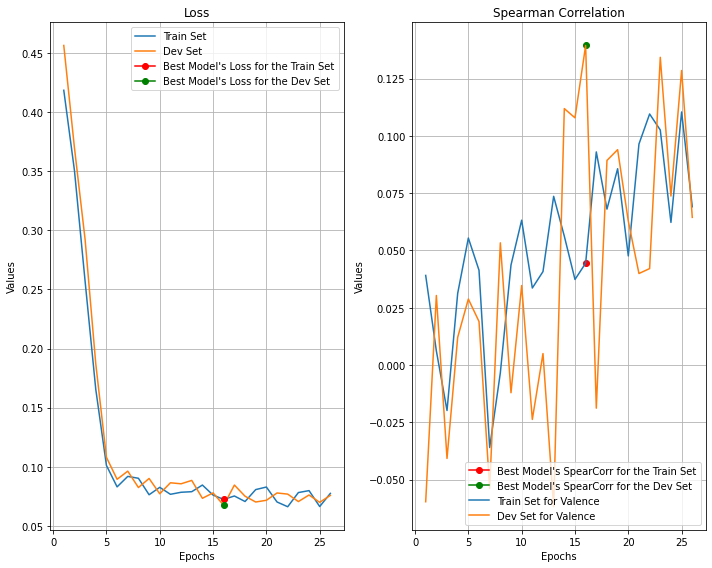

In [ ]:
EarlyLSTMNet = LSTM2(input_dim=mels_feats,
                    rnn_size=HIDDEN_LAYER,
                    output_dim=OUTPUT_SIZE,
                    num_layers=NUM_LAYERS,
                    dropout=dropout,
                    pack_padded_sequence=pack_padded_sequence,
                     att=True).to(device)

# criterion = SpearmanLoss(EarlyLSTMNet, 0.3)
# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(EarlyLSTMNet.parameters(), lr=ETA, weight_decay=weight_decay)

# Start the training process
reg_main(device, EarlyLSTMNet, mels_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, Descrs = ['Valence'], net_name='EarlyLSTM_multibeatVal', PATIENCE=PATIENCE)

LSTM2(
  (softmax): Softmax(dim=-1)
  (non_linearity): Tanh()
  (lstm): LSTM(128, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): FullyConnectedLayer(
    (fc1): Linear(in_features=50, out_features=25, bias=True)
    (fc2): Linear(in_features=25, out_features=1, bias=True)
  )
)
Spearman Correlation for Valence: -0.10194657554456596


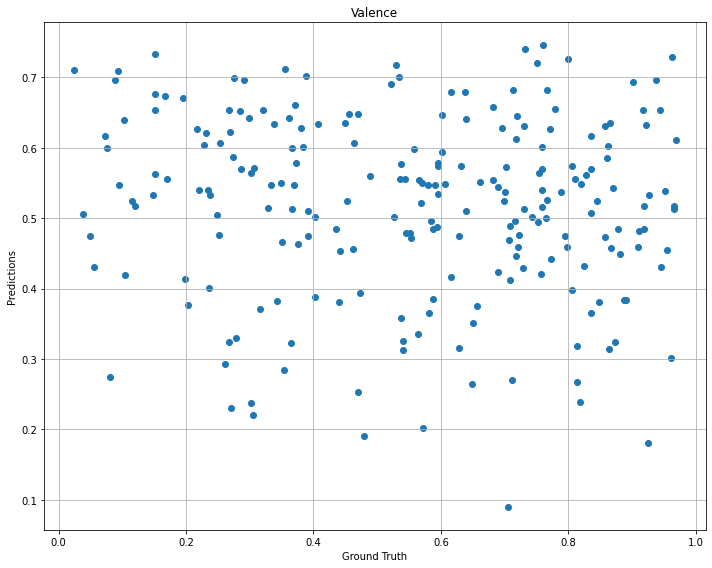

In [ ]:
with open('./best_EarlyLSTM_multibeatVal.pickle', 'rb') as handle:
    E_model = pickle.load(handle)
print(E_model)
# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
_ = reg_eval(device, dev_loader, mels_feats, E_model, criterion, titles=['Valence'])


####  Emotion "Energy"

In [ ]:
data = SpectrogramDataset("data/multitask_dataset_beat/",
                              class_mapping=class_mapping, train=True, read_spec_fn=read_mel_spectrogram, emotion=mapping['energy'])
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/multitask_dataset_beat/',
                                          class_mapping=class_mapping, train=False, read_spec_fn=read_mel_spectrogram, emotion=mapping['energy'])

##### Normal Training

True


  0%|          | 0/100 [00:00<?, ?it/s]

 [=================================-------] ...Epoch 1, Loss: 0.4893

  1%|          | 1/100 [00:00<01:35,  1.04it/s]


Statistics for the Train Set
	 Epoch: 1 	 loss: 0.5988574450272283
	 Epoch: 1 	 Spear Corr 1: 0.1335218694545616
Statistics for the Dev Set
	 Epoch: 1 	 loss: 0.5947831336790115
	 Epoch: 1 	 Spear Corr 1: -0.001980583871918124
Dev loss decreased (0.594783 --> 0.594783).  Saving model ...
Epoch total time 0.9604814052581787
 [=================================-------] ...Epoch 2, Loss: 0.2949

  2%|▏         | 2/100 [00:01<01:35,  1.02it/s]


Statistics for the Train Set
	 Epoch: 2 	 loss: 0.4487387414445057
	 Epoch: 2 	 Spear Corr 1: 0.14526918824403715
Statistics for the Dev Set
	 Epoch: 2 	 loss: 0.4348660523078188
	 Epoch: 2 	 Spear Corr 1: 0.1471888788394312
Dev loss decreased (0.594783 --> 0.434866).  Saving model ...
Epoch total time 0.9909069538116455
 [=================================-------] ...Epoch 3, Loss: 0.7676

  3%|▎         | 3/100 [00:02<01:34,  1.02it/s]


Statistics for the Train Set
	 Epoch: 3 	 loss: 0.3006860976302571
	 Epoch: 3 	 Spear Corr 1: 0.08907312570289472
Statistics for the Dev Set
	 Epoch: 3 	 loss: 0.2998234970063432
	 Epoch: 3 	 Spear Corr 1: 0.07998195586917661
Dev loss decreased (0.434866 --> 0.299823).  Saving model ...
Epoch total time 0.9743573665618896
 [=================================-------] ...Epoch 4, Loss: 0.6774

  4%|▍         | 4/100 [00:03<01:34,  1.02it/s]


Statistics for the Train Set
	 Epoch: 4 	 loss: 0.17488546561197885
	 Epoch: 4 	 Spear Corr 1: 0.02407209435224103
Statistics for the Dev Set
	 Epoch: 4 	 loss: 0.1657422730368208
	 Epoch: 4 	 Spear Corr 1: 0.009687777769190888
Dev loss decreased (0.299823 --> 0.165742).  Saving model ...
Epoch total time 0.9904336929321289
 [=================================-------] ...Epoch 5, Loss: -0.0883

  5%|▌         | 5/100 [00:04<01:33,  1.02it/s]


Statistics for the Train Set
	 Epoch: 5 	 loss: 0.08298700347501069
	 Epoch: 5 	 Spear Corr 1: 0.14450956421649933
Statistics for the Dev Set
	 Epoch: 5 	 loss: 0.0866493737318033
	 Epoch: 5 	 Spear Corr 1: 0.07074688298499558
Dev loss decreased (0.165742 --> 0.086649).  Saving model ...
Epoch total time 0.9708480834960938
 [=================================-------] ...Epoch 6, Loss: 0.2029

  6%|▌         | 6/100 [00:05<01:31,  1.03it/s]


Statistics for the Train Set
	 Epoch: 6 	 loss: 0.09525066550144595
	 Epoch: 6 	 Spear Corr 1: 0.06640559009738316
Statistics for the Dev Set
	 Epoch: 6 	 loss: 0.0764580253118088
	 Epoch: 6 	 Spear Corr 1: 0.10484976123890438
Dev loss decreased (0.086649 --> 0.076458).  Saving model ...
Epoch total time 0.959686279296875
 [=================================-------] ...Epoch 7, Loss: 0.0470

  7%|▋         | 7/100 [00:06<01:30,  1.03it/s]


Statistics for the Train Set
	 Epoch: 7 	 loss: 0.07682200752531901
	 Epoch: 7 	 Spear Corr 1: 0.1264586005532165
Statistics for the Dev Set
	 Epoch: 7 	 loss: 0.07216171735485179
	 Epoch: 7 	 Spear Corr 1: 0.18110811265885485
Dev loss decreased (0.076458 --> 0.072162).  Saving model ...
Epoch total time 0.9751205444335938
 [=================================-------] ...Epoch 8, Loss: 0.1239

  8%|▊         | 8/100 [00:07<01:29,  1.02it/s]


Statistics for the Train Set
	 Epoch: 8 	 loss: 0.06581632545960155
	 Epoch: 8 	 Spear Corr 1: 0.22038583813339105
Statistics for the Dev Set
	 Epoch: 8 	 loss: 0.08057925517106256
	 Epoch: 8 	 Spear Corr 1: 0.11645299316778321
EarlyStopping counter: 1 out of 10
Epoch total time 0.9802877902984619
 [=================================-------] ...Epoch 9, Loss: 0.1327

  9%|▉         | 9/100 [00:08<01:29,  1.02it/s]


Statistics for the Train Set
	 Epoch: 9 	 loss: 0.07813478416942601
	 Epoch: 9 	 Spear Corr 1: 0.1888590878794907
Statistics for the Dev Set
	 Epoch: 9 	 loss: 0.07000701592084362
	 Epoch: 9 	 Spear Corr 1: 0.22894588629193066
Dev loss decreased (0.072162 --> 0.070007).  Saving model ...
Epoch total time 0.9811766147613525
 [=================================-------] ...Epoch 10, Loss: -0.0765

 10%|█         | 10/100 [00:09<01:27,  1.03it/s]


Statistics for the Train Set
	 Epoch: 10 	 loss: 0.07502953581914058
	 Epoch: 10 	 Spear Corr 1: 0.22639913064248401
Statistics for the Dev Set
	 Epoch: 10 	 loss: 0.07764759591248759
	 Epoch: 10 	 Spear Corr 1: 0.18105099069812838
EarlyStopping counter: 1 out of 10
Epoch total time 0.9610028266906738
 [=================================-------] ...Epoch 11, Loss: 0.1030

 11%|█         | 11/100 [00:10<01:26,  1.03it/s]


Statistics for the Train Set
	 Epoch: 11 	 loss: 0.0719573085224005
	 Epoch: 11 	 Spear Corr 1: 0.2638439386915536
Statistics for the Dev Set
	 Epoch: 11 	 loss: 0.06590126302528347
	 Epoch: 11 	 Spear Corr 1: 0.26278824569691867
Dev loss decreased (0.070007 --> 0.065901).  Saving model ...
Epoch total time 0.9573187828063965
 [=================================-------] ...Epoch 12, Loss: -0.0797

 12%|█▏        | 12/100 [00:11<01:25,  1.03it/s]


Statistics for the Train Set
	 Epoch: 12 	 loss: 0.07291850471633589
	 Epoch: 12 	 Spear Corr 1: 0.32681788084516117
Statistics for the Dev Set
	 Epoch: 12 	 loss: 0.06397419712111982
	 Epoch: 12 	 Spear Corr 1: 0.3191660193836533
Dev loss decreased (0.065901 --> 0.063974).  Saving model ...
Epoch total time 0.9632391929626465
 [=================================-------] ...Epoch 13, Loss: 0.0394

 13%|█▎        | 13/100 [00:12<01:24,  1.03it/s]


Statistics for the Train Set
	 Epoch: 13 	 loss: 0.05712508655184381
	 Epoch: 13 	 Spear Corr 1: 0.3394977773265596
Statistics for the Dev Set
	 Epoch: 13 	 loss: 0.06716554666369325
	 Epoch: 13 	 Spear Corr 1: 0.2695826278805581
EarlyStopping counter: 1 out of 10
Epoch total time 0.9687943458557129
 [=================================-------] ...Epoch 14, Loss: 0.1838

 14%|█▍        | 14/100 [00:13<01:23,  1.03it/s]


Statistics for the Train Set
	 Epoch: 14 	 loss: 0.06058517209973162
	 Epoch: 14 	 Spear Corr 1: 0.30171712067002693
Statistics for the Dev Set
	 Epoch: 14 	 loss: 0.06267331723882665
	 Epoch: 14 	 Spear Corr 1: 0.30292149468322294
Dev loss decreased (0.063974 --> 0.062673).  Saving model ...
Epoch total time 0.9606945514678955
 [=================================-------] ...Epoch 15, Loss: 0.1525

 15%|█▌        | 15/100 [00:14<01:22,  1.03it/s]


Statistics for the Train Set
	 Epoch: 15 	 loss: 0.06054422499256727
	 Epoch: 15 	 Spear Corr 1: 0.26581841431339387
Statistics for the Dev Set
	 Epoch: 15 	 loss: 0.061917601036441984
	 Epoch: 15 	 Spear Corr 1: 0.3684622714906052
Dev loss decreased (0.062673 --> 0.061918).  Saving model ...
Epoch total time 0.9722959995269775
 [=================================-------] ...Epoch 16, Loss: -0.0367

 16%|█▌        | 16/100 [00:15<01:21,  1.04it/s]


Statistics for the Train Set
	 Epoch: 16 	 loss: 0.057251504697375374
	 Epoch: 16 	 Spear Corr 1: 0.4173487091485444
Statistics for the Dev Set
	 Epoch: 16 	 loss: 0.06661268579922684
	 Epoch: 16 	 Spear Corr 1: 0.28509944293656136
EarlyStopping counter: 1 out of 10
Epoch total time 0.9547858238220215
 [=================================-------] ...Epoch 17, Loss: 0.1465

 17%|█▋        | 17/100 [00:16<01:20,  1.04it/s]


Statistics for the Train Set
	 Epoch: 17 	 loss: 0.06305735064278803
	 Epoch: 17 	 Spear Corr 1: 0.36579618818542514
Statistics for the Dev Set
	 Epoch: 17 	 loss: 0.06694178017138457
	 Epoch: 17 	 Spear Corr 1: 0.27375833140690403
EarlyStopping counter: 2 out of 10
Epoch total time 0.9635171890258789
 [=================================-------] ...Epoch 18, Loss: 0.0056

 18%|█▊        | 18/100 [00:17<01:19,  1.04it/s]


Statistics for the Train Set
	 Epoch: 18 	 loss: 0.05316077831336314
	 Epoch: 18 	 Spear Corr 1: 0.3915573522994218
Statistics for the Dev Set
	 Epoch: 18 	 loss: 0.059233903778401945
	 Epoch: 18 	 Spear Corr 1: 0.3532374004816475
Dev loss decreased (0.061918 --> 0.059234).  Saving model ...
Epoch total time 0.959557056427002
 [=================================-------] ...Epoch 19, Loss: 0.1216

 19%|█▉        | 19/100 [00:18<01:17,  1.04it/s]


Statistics for the Train Set
	 Epoch: 19 	 loss: 0.06511665991187056
	 Epoch: 19 	 Spear Corr 1: 0.33341338606331855
Statistics for the Dev Set
	 Epoch: 19 	 loss: 0.0644294020159141
	 Epoch: 19 	 Spear Corr 1: 0.34085367970620684
EarlyStopping counter: 1 out of 10
Epoch total time 0.9473145008087158
 [=================================-------] ...Epoch 20, Loss: -0.0305

 20%|██        | 20/100 [00:19<01:19,  1.01it/s]


Statistics for the Train Set
	 Epoch: 20 	 loss: 0.06607245899735696
	 Epoch: 20 	 Spear Corr 1: 0.3105637577739807
Statistics for the Dev Set
	 Epoch: 20 	 loss: 0.054640119037697034
	 Epoch: 20 	 Spear Corr 1: 0.37960265538256943
Dev loss decreased (0.059234 --> 0.054640).  Saving model ...
Epoch total time 1.0570926666259766
 [=================================-------] ...Epoch 21, Loss: 0.0183

 21%|██        | 21/100 [00:20<01:17,  1.02it/s]


Statistics for the Train Set
	 Epoch: 21 	 loss: 0.05755744731462194
	 Epoch: 21 	 Spear Corr 1: 0.37346893771331535
Statistics for the Dev Set
	 Epoch: 21 	 loss: 0.06994686650258429
	 Epoch: 21 	 Spear Corr 1: 0.26561391427752856
EarlyStopping counter: 1 out of 10
Epoch total time 0.9545667171478271
 [=================================-------] ...Epoch 22, Loss: 0.1074

 22%|██▏       | 22/100 [00:21<01:16,  1.02it/s]


Statistics for the Train Set
	 Epoch: 22 	 loss: 0.04984246948408745
	 Epoch: 22 	 Spear Corr 1: 0.43089290995813423
Statistics for the Dev Set
	 Epoch: 22 	 loss: 0.064062003887628
	 Epoch: 22 	 Spear Corr 1: 0.290131513981494
EarlyStopping counter: 2 out of 10
Epoch total time 0.9697251319885254
 [=================================-------] ...Epoch 23, Loss: 0.0650

 23%|██▎       | 23/100 [00:22<01:15,  1.02it/s]


Statistics for the Train Set
	 Epoch: 23 	 loss: 0.06461157355814137
	 Epoch: 23 	 Spear Corr 1: 0.2928166768641226
Statistics for the Dev Set
	 Epoch: 23 	 loss: 0.06110626476626028
	 Epoch: 23 	 Spear Corr 1: 0.3546702541507117
EarlyStopping counter: 3 out of 10
Epoch total time 0.9680342674255371
 [=================================-------] ...Epoch 24, Loss: 0.0155

 24%|██▍       | 24/100 [00:23<01:14,  1.03it/s]


Statistics for the Train Set
	 Epoch: 24 	 loss: 0.06128995503267354
	 Epoch: 24 	 Spear Corr 1: 0.3951483572340529
Statistics for the Dev Set
	 Epoch: 24 	 loss: 0.04850866508744922
	 Epoch: 24 	 Spear Corr 1: 0.42818728530589145
Dev loss decreased (0.054640 --> 0.048509).  Saving model ...
Epoch total time 0.9636898040771484
 [=================================-------] ...Epoch 25, Loss: 0.1192

 25%|██▌       | 25/100 [00:24<01:13,  1.03it/s]


Statistics for the Train Set
	 Epoch: 25 	 loss: 0.05482639935768147
	 Epoch: 25 	 Spear Corr 1: 0.3522576630134756
Statistics for the Dev Set
	 Epoch: 25 	 loss: 0.05320686087110784
	 Epoch: 25 	 Spear Corr 1: 0.42724076907815267
EarlyStopping counter: 1 out of 10
Epoch total time 0.9755904674530029
 [=================================-------] ...Epoch 26, Loss: -0.0811

 26%|██▌       | 26/100 [00:25<01:11,  1.03it/s]


Statistics for the Train Set
	 Epoch: 26 	 loss: 0.05537888720972441
	 Epoch: 26 	 Spear Corr 1: 0.4025270175905488
Statistics for the Dev Set
	 Epoch: 26 	 loss: 0.05960442853528652
	 Epoch: 26 	 Spear Corr 1: 0.3015655154285944
EarlyStopping counter: 2 out of 10
Epoch total time 0.949091911315918
 [=================================-------] ...Epoch 27, Loss: -0.0488

 27%|██▋       | 27/100 [00:26<01:10,  1.03it/s]


Statistics for the Train Set
	 Epoch: 27 	 loss: 0.050711695066285103
	 Epoch: 27 	 Spear Corr 1: 0.38854114445971194
Statistics for the Dev Set
	 Epoch: 27 	 loss: 0.054335937675767707
	 Epoch: 27 	 Spear Corr 1: 0.35386680974983925
EarlyStopping counter: 3 out of 10
Epoch total time 0.9655287265777588
 [=================================-------] ...Epoch 28, Loss: -0.0492

 28%|██▊       | 28/100 [00:27<01:09,  1.03it/s]


Statistics for the Train Set
	 Epoch: 28 	 loss: 0.0595645052796808
	 Epoch: 28 	 Spear Corr 1: 0.37199381877659343
Statistics for the Dev Set
	 Epoch: 28 	 loss: 0.05711312785687831
	 Epoch: 28 	 Spear Corr 1: 0.3919068324930732
EarlyStopping counter: 4 out of 10
Epoch total time 0.9626119136810303
 [=================================-------] ...Epoch 29, Loss: 0.0170

 29%|██▉       | 29/100 [00:28<01:09,  1.02it/s]


Statistics for the Train Set
	 Epoch: 29 	 loss: 0.045876263612685854
	 Epoch: 29 	 Spear Corr 1: 0.3988263087896651
Statistics for the Dev Set
	 Epoch: 29 	 loss: 0.05438398071308987
	 Epoch: 29 	 Spear Corr 1: 0.40745468281268055
EarlyStopping counter: 5 out of 10
Epoch total time 0.9969465732574463
 [=================================-------] ...Epoch 30, Loss: -0.0335

 30%|███       | 30/100 [00:29<01:08,  1.02it/s]


Statistics for the Train Set
	 Epoch: 30 	 loss: 0.05024079795316499
	 Epoch: 30 	 Spear Corr 1: 0.38373300939011984
Statistics for the Dev Set
	 Epoch: 30 	 loss: 0.05580030112758042
	 Epoch: 30 	 Spear Corr 1: 0.34421693533776593
EarlyStopping counter: 6 out of 10
Epoch total time 0.9860761165618896
 [=================================-------] ...Epoch 31, Loss: 0.2550

 31%|███       | 31/100 [00:30<01:08,  1.01it/s]


Statistics for the Train Set
	 Epoch: 31 	 loss: 0.051477954918370775
	 Epoch: 31 	 Spear Corr 1: 0.3778823135424187
Statistics for the Dev Set
	 Epoch: 31 	 loss: 0.06311985149541811
	 Epoch: 31 	 Spear Corr 1: 0.26339309786049914
EarlyStopping counter: 7 out of 10
Epoch total time 1.0075414180755615
 [=================================-------] ...Epoch 32, Loss: 0.1977

 32%|███▏      | 32/100 [00:31<01:07,  1.01it/s]


Statistics for the Train Set
	 Epoch: 32 	 loss: 0.05166518610461267
	 Epoch: 32 	 Spear Corr 1: 0.42318865028433733
Statistics for the Dev Set
	 Epoch: 32 	 loss: 0.04254134998452385
	 Epoch: 32 	 Spear Corr 1: 0.43456946325435
Dev loss decreased (0.048509 --> 0.042541).  Saving model ...
Epoch total time 0.982856273651123
 [=================================-------] ...Epoch 33, Loss: 0.0057

 33%|███▎      | 33/100 [00:32<01:06,  1.00it/s]


Statistics for the Train Set
	 Epoch: 33 	 loss: 0.04782108344510369
	 Epoch: 33 	 Spear Corr 1: 0.4250778173439227
Statistics for the Dev Set
	 Epoch: 33 	 loss: 0.05705095502086043
	 Epoch: 33 	 Spear Corr 1: 0.3554224489419604
EarlyStopping counter: 1 out of 10
Epoch total time 1.0174355506896973
 [=================================-------] ...Epoch 34, Loss: -0.0810

 34%|███▍      | 34/100 [00:33<01:05,  1.01it/s]


Statistics for the Train Set
	 Epoch: 34 	 loss: 0.05425806582683635
	 Epoch: 34 	 Spear Corr 1: 0.4230745492537611
Statistics for the Dev Set
	 Epoch: 34 	 loss: 0.0527006676807351
	 Epoch: 34 	 Spear Corr 1: 0.3871891991571863
EarlyStopping counter: 2 out of 10
Epoch total time 0.9736430644989014
 [=================================-------] ...Epoch 35, Loss: 0.1070

 35%|███▌      | 35/100 [00:34<01:03,  1.02it/s]


Statistics for the Train Set
	 Epoch: 35 	 loss: 0.05447625050864073
	 Epoch: 35 	 Spear Corr 1: 0.4256199608798069
Statistics for the Dev Set
	 Epoch: 35 	 loss: 0.05796661849948664
	 Epoch: 35 	 Spear Corr 1: 0.3351126557281456
EarlyStopping counter: 3 out of 10
Epoch total time 0.9602293968200684
 [=================================-------] ...Epoch 36, Loss: 0.1133

 36%|███▌      | 36/100 [00:35<01:02,  1.02it/s]


Statistics for the Train Set
	 Epoch: 36 	 loss: 0.055664847480783715
	 Epoch: 36 	 Spear Corr 1: 0.4163211867387816
Statistics for the Dev Set
	 Epoch: 36 	 loss: 0.053343537095458415
	 Epoch: 36 	 Spear Corr 1: 0.4431286819116177
EarlyStopping counter: 4 out of 10
Epoch total time 0.9701275825500488
 [=================================-------] ...Epoch 37, Loss: -0.0801

 37%|███▋      | 37/100 [00:36<01:01,  1.03it/s]


Statistics for the Train Set
	 Epoch: 37 	 loss: 0.055353872527302964
	 Epoch: 37 	 Spear Corr 1: 0.42939256964772304
Statistics for the Dev Set
	 Epoch: 37 	 loss: 0.04872844208373438
	 Epoch: 37 	 Spear Corr 1: 0.4615566535220602
EarlyStopping counter: 5 out of 10
Epoch total time 0.9551858901977539
 [=================================-------] ...Epoch 38, Loss: 0.1133

 38%|███▊      | 38/100 [00:37<01:00,  1.03it/s]


Statistics for the Train Set
	 Epoch: 38 	 loss: 0.04829947996068456
	 Epoch: 38 	 Spear Corr 1: 0.4055375912206304
Statistics for the Dev Set
	 Epoch: 38 	 loss: 0.05330531566858882
	 Epoch: 38 	 Spear Corr 1: 0.41063803096045626
EarlyStopping counter: 6 out of 10
Epoch total time 0.96409010887146
 [=================================-------] ...Epoch 39, Loss: 0.2621

 39%|███▉      | 39/100 [00:38<00:59,  1.03it/s]


Statistics for the Train Set
	 Epoch: 39 	 loss: 0.05358183190192162
	 Epoch: 39 	 Spear Corr 1: 0.3913336907483817
Statistics for the Dev Set
	 Epoch: 39 	 loss: 0.04919460255915726
	 Epoch: 39 	 Spear Corr 1: 0.4599593740221198
EarlyStopping counter: 7 out of 10
Epoch total time 0.9758124351501465
 [=================================-------] ...Epoch 40, Loss: 0.1115

 40%|████      | 40/100 [00:39<00:58,  1.03it/s]


Statistics for the Train Set
	 Epoch: 40 	 loss: 0.05254126964330024
	 Epoch: 40 	 Spear Corr 1: 0.43645968901954074
Statistics for the Dev Set
	 Epoch: 40 	 loss: 0.04878366556343631
	 Epoch: 40 	 Spear Corr 1: 0.45700985221825247
EarlyStopping counter: 8 out of 10
Epoch total time 0.9745948314666748
 [=================================-------] ...Epoch 41, Loss: 0.2919

 41%|████      | 41/100 [00:39<00:57,  1.03it/s]


Statistics for the Train Set
	 Epoch: 41 	 loss: 0.06099189070425948
	 Epoch: 41 	 Spear Corr 1: 0.4239076582889368
Statistics for the Dev Set
	 Epoch: 41 	 loss: 0.05405337034250241
	 Epoch: 41 	 Spear Corr 1: 0.38286074254437974
EarlyStopping counter: 9 out of 10
Epoch total time 0.966785192489624
 [=================================-------] ...Epoch 42, Loss: 0.1507

 41%|████      | 41/100 [00:40<00:58,  1.00it/s]


Statistics for the Train Set
	 Epoch: 42 	 loss: 0.0527302786107884
	 Epoch: 42 	 Spear Corr 1: 0.4158948427819646
Statistics for the Dev Set
	 Epoch: 42 	 loss: 0.04850040950084209
	 Epoch: 42 	 Spear Corr 1: 0.41165608310162816
EarlyStopping counter: 10 out of 10
Training total time 39.88907504081726


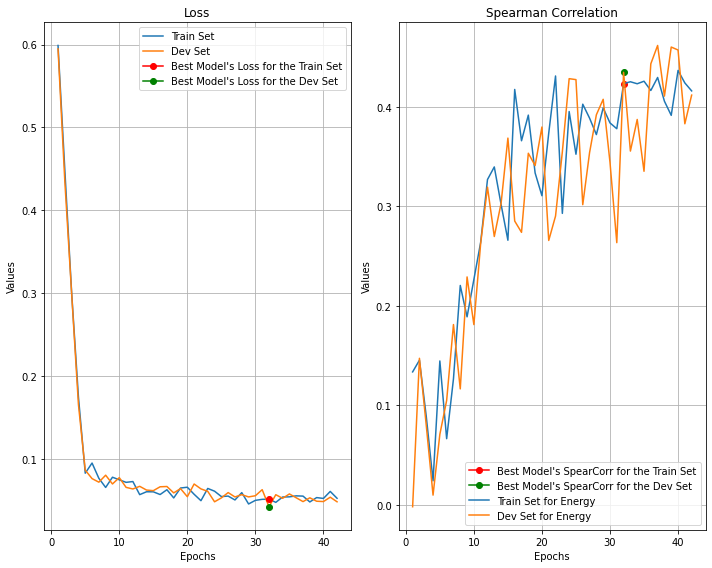

In [ ]:
EarlyLSTMNet = LSTM2(input_dim=mels_feats,
                    rnn_size=HIDDEN_LAYER,
                    output_dim=OUTPUT_SIZE,
                    num_layers=NUM_LAYERS,
                    dropout=dropout,
                    pack_padded_sequence=pack_padded_sequence,
                     att=True).to(device)

# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(EarlyLSTMNet.parameters(), lr=ETA, weight_decay=weight_decay)

# Start the training process
reg_main(device, EarlyLSTMNet, mels_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, Descrs = ['Energy'], net_name='EarlyLSTM_multibeatEn', PATIENCE=PATIENCE)

LSTM2(
  (softmax): Softmax(dim=-1)
  (non_linearity): Tanh()
  (lstm): LSTM(128, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): FullyConnectedLayer(
    (fc1): Linear(in_features=50, out_features=25, bias=True)
    (fc2): Linear(in_features=25, out_features=1, bias=True)
  )
)
Spearman Correlation for Energy: 0.2721055314965379


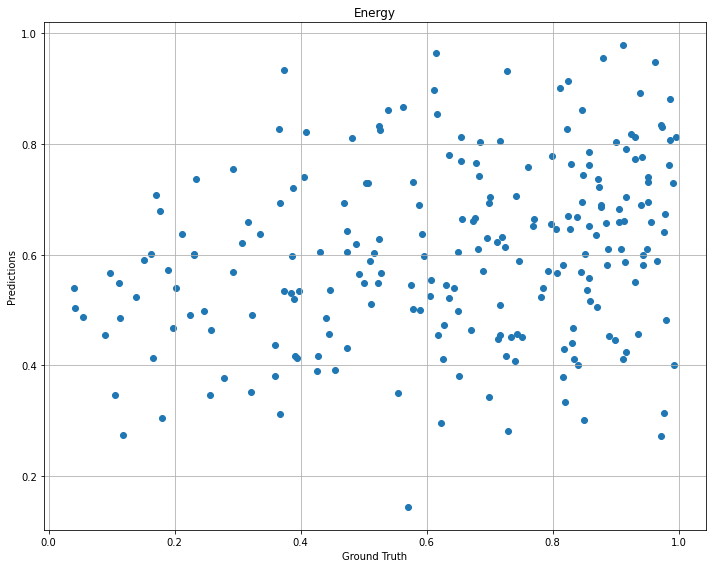

In [ ]:
with open('./best_EarlyLSTM_multibeatEn.pickle', 'rb') as handle:
    E_model = pickle.load(handle)
print(E_model)
# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
_ = reg_eval(device, dev_loader, mels_feats, E_model, criterion, titles=['Energy'])


####  Emotion "Danceability"

In [ ]:
data = SpectrogramDataset("data/multitask_dataset_beat/",
                              class_mapping=class_mapping, train=True, read_spec_fn=read_mel_spectrogram, emotion=mapping['danceability'])
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/multitask_dataset_beat/',
                                          class_mapping=class_mapping, train=False, read_spec_fn=read_mel_spectrogram, emotion=mapping['danceability'])

##### Normal Training

True


  0%|          | 0/100 [00:00<?, ?it/s]

 [=================================-------] ...Epoch 1, Loss: 0.0917

  1%|          | 1/100 [00:00<01:36,  1.03it/s]


Statistics for the Train Set
	 Epoch: 1 	 loss: 0.478135444845207
	 Epoch: 1 	 Spear Corr 1: 0.21317808091611393
Statistics for the Dev Set
	 Epoch: 1 	 loss: 0.45468786255590704
	 Epoch: 1 	 Spear Corr 1: 0.07422885147605968
Dev loss decreased (0.454688 --> 0.454688).  Saving model ...
Epoch total time 0.9710838794708252
 [=================================-------] ...Epoch 2, Loss: 0.5574

  2%|▏         | 2/100 [00:01<01:35,  1.03it/s]


Statistics for the Train Set
	 Epoch: 2 	 loss: 0.4122115017254991
	 Epoch: 2 	 Spear Corr 1: 0.13962456008394677
Statistics for the Dev Set
	 Epoch: 2 	 loss: 0.3871224584275405
	 Epoch: 2 	 Spear Corr 1: 0.23744754910118218
Dev loss decreased (0.454688 --> 0.387122).  Saving model ...
Epoch total time 0.9713492393493652
 [=================================-------] ...Epoch 3, Loss: 0.5004

  3%|▎         | 3/100 [00:02<01:34,  1.03it/s]


Statistics for the Train Set
	 Epoch: 3 	 loss: 0.3425336512029697
	 Epoch: 3 	 Spear Corr 1: 0.08279904860348929
Statistics for the Dev Set
	 Epoch: 3 	 loss: 0.3235166255611704
	 Epoch: 3 	 Spear Corr 1: 0.02612402438782673
Dev loss decreased (0.387122 --> 0.323517).  Saving model ...
Epoch total time 0.9654285907745361
 [=================================-------] ...Epoch 4, Loss: 0.3908

  4%|▍         | 4/100 [00:03<01:32,  1.03it/s]


Statistics for the Train Set
	 Epoch: 4 	 loss: 0.23540405100363765
	 Epoch: 4 	 Spear Corr 1: -0.04372190332639016
Statistics for the Dev Set
	 Epoch: 4 	 loss: 0.20747277313798212
	 Epoch: 4 	 Spear Corr 1: 0.11538880407239034
Dev loss decreased (0.323517 --> 0.207473).  Saving model ...
Epoch total time 0.9612703323364258
 [=================================-------] ...Epoch 5, Loss: 0.1249

  5%|▌         | 5/100 [00:04<01:31,  1.03it/s]


Statistics for the Train Set
	 Epoch: 5 	 loss: 0.09867526562649666
	 Epoch: 5 	 Spear Corr 1: 0.0014883200717113133
Statistics for the Dev Set
	 Epoch: 5 	 loss: 0.08466076616908913
	 Epoch: 5 	 Spear Corr 1: -0.010324688498223543
Dev loss decreased (0.207473 --> 0.084661).  Saving model ...
Epoch total time 0.9674675464630127
 [=================================-------] ...Epoch 6, Loss: 0.0634

  6%|▌         | 6/100 [00:05<01:30,  1.04it/s]


Statistics for the Train Set
	 Epoch: 6 	 loss: 0.04591578289575246
	 Epoch: 6 	 Spear Corr 1: 0.027002966722533144
Statistics for the Dev Set
	 Epoch: 6 	 loss: 0.05445720000149643
	 Epoch: 6 	 Spear Corr 1: 0.0008349437854819865
Dev loss decreased (0.084661 --> 0.054457).  Saving model ...
Epoch total time 0.9610531330108643
 [=================================-------] ...Epoch 7, Loss: -0.0731

  7%|▋         | 7/100 [00:06<01:33,  1.00s/it]


Statistics for the Train Set
	 Epoch: 7 	 loss: 0.04258985237319195
	 Epoch: 7 	 Spear Corr 1: 0.09329690557498073
Statistics for the Dev Set
	 Epoch: 7 	 loss: 0.051176280924888906
	 Epoch: 7 	 Spear Corr 1: 0.015571381288323902
Dev loss decreased (0.054457 --> 0.051176).  Saving model ...
Epoch total time 1.0746521949768066
 [=================================-------] ...Epoch 8, Loss: -0.0684

  8%|▊         | 8/100 [00:07<01:31,  1.01it/s]


Statistics for the Train Set
	 Epoch: 8 	 loss: 0.04625248562161281
	 Epoch: 8 	 Spear Corr 1: 0.09977203043283435
Statistics for the Dev Set
	 Epoch: 8 	 loss: 0.04513403442212993
	 Epoch: 8 	 Spear Corr 1: 0.04738039056847652
Dev loss decreased (0.051176 --> 0.045134).  Saving model ...
Epoch total time 0.9659225940704346
 [=================================-------] ...Epoch 9, Loss: 0.1525

  9%|▉         | 9/100 [00:08<01:30,  1.01it/s]


Statistics for the Train Set
	 Epoch: 9 	 loss: 0.04545891900032949
	 Epoch: 9 	 Spear Corr 1: 0.13837002691032654
Statistics for the Dev Set
	 Epoch: 9 	 loss: 0.03571873448221747
	 Epoch: 9 	 Spear Corr 1: 0.2249394078647097
Dev loss decreased (0.045134 --> 0.035719).  Saving model ...
Epoch total time 1.0030453205108643
 [=================================-------] ...Epoch 10, Loss: -0.0775

 10%|█         | 10/100 [00:09<01:29,  1.00it/s]


Statistics for the Train Set
	 Epoch: 10 	 loss: 0.04697363081945616
	 Epoch: 10 	 Spear Corr 1: 0.10126615872029424
Statistics for the Dev Set
	 Epoch: 10 	 loss: 0.032520221971064404
	 Epoch: 10 	 Spear Corr 1: 0.23208767978773
Dev loss decreased (0.035719 --> 0.032520).  Saving model ...
Epoch total time 1.0068092346191406
 [=================================-------] ...Epoch 11, Loss: 0.1268

 11%|█         | 11/100 [00:10<01:28,  1.01it/s]


Statistics for the Train Set
	 Epoch: 11 	 loss: 0.03310168049798618
	 Epoch: 11 	 Spear Corr 1: 0.1728150994138994
Statistics for the Dev Set
	 Epoch: 11 	 loss: 0.04165862673296898
	 Epoch: 11 	 Spear Corr 1: 0.14369681504999124
EarlyStopping counter: 1 out of 10
Epoch total time 0.9801273345947266
 [=================================-------] ...Epoch 12, Loss: -0.0548

 12%|█▏        | 12/100 [00:11<01:27,  1.01it/s]


Statistics for the Train Set
	 Epoch: 12 	 loss: 0.03957455039387026
	 Epoch: 12 	 Spear Corr 1: 0.16693672936754325
Statistics for the Dev Set
	 Epoch: 12 	 loss: 0.03918800920525154
	 Epoch: 12 	 Spear Corr 1: 0.131399011314465
EarlyStopping counter: 2 out of 10
Epoch total time 0.9799008369445801
 [=================================-------] ...Epoch 13, Loss: -0.0729

 13%|█▎        | 13/100 [00:12<01:25,  1.02it/s]


Statistics for the Train Set
	 Epoch: 13 	 loss: 0.04011774733539969
	 Epoch: 13 	 Spear Corr 1: 0.16081430307017117
Statistics for the Dev Set
	 Epoch: 13 	 loss: 0.04457481093836265
	 Epoch: 13 	 Spear Corr 1: 0.1291242699653993
EarlyStopping counter: 3 out of 10
Epoch total time 0.9473247528076172
 [=================================-------] ...Epoch 14, Loss: 0.0015

 14%|█▍        | 14/100 [00:13<01:23,  1.03it/s]


Statistics for the Train Set
	 Epoch: 14 	 loss: 0.04576602688542033
	 Epoch: 14 	 Spear Corr 1: 0.10892828070816375
Statistics for the Dev Set
	 Epoch: 14 	 loss: 0.03348323689012546
	 Epoch: 14 	 Spear Corr 1: 0.177344408983085
EarlyStopping counter: 4 out of 10
Epoch total time 0.947498083114624
 [=================================-------] ...Epoch 15, Loss: 0.1794

 15%|█▌        | 15/100 [00:14<01:22,  1.03it/s]


Statistics for the Train Set
	 Epoch: 15 	 loss: 0.035145333827433706
	 Epoch: 15 	 Spear Corr 1: 0.20199583218879874
Statistics for the Dev Set
	 Epoch: 15 	 loss: 0.03807635408862609
	 Epoch: 15 	 Spear Corr 1: 0.16881346160968208
EarlyStopping counter: 5 out of 10
Epoch total time 0.9604666233062744
 [=================================-------] ...Epoch 16, Loss: -0.0505

 16%|█▌        | 16/100 [00:15<01:21,  1.03it/s]


Statistics for the Train Set
	 Epoch: 16 	 loss: 0.02855110443766715
	 Epoch: 16 	 Spear Corr 1: 0.18527670501580873
Statistics for the Dev Set
	 Epoch: 16 	 loss: 0.026663195153472402
	 Epoch: 16 	 Spear Corr 1: 0.2700829605424129
Dev loss decreased (0.032520 --> 0.026663).  Saving model ...
Epoch total time 0.9825048446655273
 [=================================-------] ...Epoch 17, Loss: 0.1869

 17%|█▋        | 17/100 [00:16<01:20,  1.03it/s]


Statistics for the Train Set
	 Epoch: 17 	 loss: 0.03632589227467451
	 Epoch: 17 	 Spear Corr 1: 0.20178111877523436
Statistics for the Dev Set
	 Epoch: 17 	 loss: 0.04792247485931267
	 Epoch: 17 	 Spear Corr 1: 0.054588987713849436
EarlyStopping counter: 1 out of 10
Epoch total time 0.9507482051849365
 [=================================-------] ...Epoch 18, Loss: -0.0785

 18%|█▊        | 18/100 [00:17<01:18,  1.04it/s]


Statistics for the Train Set
	 Epoch: 18 	 loss: 0.034287957564934184
	 Epoch: 18 	 Spear Corr 1: 0.2469935710036302
Statistics for the Dev Set
	 Epoch: 18 	 loss: 0.0355683174980248
	 Epoch: 18 	 Spear Corr 1: 0.194411108393618
EarlyStopping counter: 2 out of 10
Epoch total time 0.9532260894775391
 [=================================-------] ...Epoch 19, Loss: -0.0425

 19%|█▉        | 19/100 [00:18<01:18,  1.03it/s]


Statistics for the Train Set
	 Epoch: 19 	 loss: 0.024990200981237217
	 Epoch: 19 	 Spear Corr 1: 0.2632015586195165
Statistics for the Dev Set
	 Epoch: 19 	 loss: 0.024595978853947566
	 Epoch: 19 	 Spear Corr 1: 0.27284404063097606
Dev loss decreased (0.026663 --> 0.024596).  Saving model ...
Epoch total time 0.9791665077209473
 [=================================-------] ...Epoch 20, Loss: -0.0034

 20%|██        | 20/100 [00:19<01:17,  1.03it/s]


Statistics for the Train Set
	 Epoch: 20 	 loss: 0.031602056599844545
	 Epoch: 20 	 Spear Corr 1: 0.27378240430561235
Statistics for the Dev Set
	 Epoch: 20 	 loss: 0.03250773460913362
	 Epoch: 20 	 Spear Corr 1: 0.19390822025683793
EarlyStopping counter: 1 out of 10
Epoch total time 0.95957350730896
 [=================================-------] ...Epoch 21, Loss: 0.1103

 21%|██        | 21/100 [00:20<01:16,  1.03it/s]


Statistics for the Train Set
	 Epoch: 21 	 loss: 0.025804026223488864
	 Epoch: 21 	 Spear Corr 1: 0.2663707564433912
Statistics for the Dev Set
	 Epoch: 21 	 loss: 0.0331514519527824
	 Epoch: 21 	 Spear Corr 1: 0.19830662297332521
EarlyStopping counter: 2 out of 10
Epoch total time 0.971733808517456
 [=================================-------] ...Epoch 22, Loss: 0.0272

 22%|██▏       | 22/100 [00:21<01:14,  1.04it/s]


Statistics for the Train Set
	 Epoch: 22 	 loss: 0.025490614551470208
	 Epoch: 22 	 Spear Corr 1: 0.2540780613782158
Statistics for the Dev Set
	 Epoch: 22 	 loss: 0.023595985770167565
	 Epoch: 22 	 Spear Corr 1: 0.28714058447701674
Dev loss decreased (0.024596 --> 0.023596).  Saving model ...
Epoch total time 0.9441432952880859
 [=================================-------] ...Epoch 23, Loss: 0.1174

 23%|██▎       | 23/100 [00:22<01:14,  1.03it/s]


Statistics for the Train Set
	 Epoch: 23 	 loss: 0.025749644891243848
	 Epoch: 23 	 Spear Corr 1: 0.30719826263566025
Statistics for the Dev Set
	 Epoch: 23 	 loss: 0.02733015331571966
	 Epoch: 23 	 Spear Corr 1: 0.28581770039746146
EarlyStopping counter: 1 out of 10
Epoch total time 0.9809176921844482
 [=================================-------] ...Epoch 24, Loss: 0.2193

 24%|██▍       | 24/100 [00:23<01:13,  1.03it/s]


Statistics for the Train Set
	 Epoch: 24 	 loss: 0.03042202784690754
	 Epoch: 24 	 Spear Corr 1: 0.2563267440048931
Statistics for the Dev Set
	 Epoch: 24 	 loss: 0.032571747029303925
	 Epoch: 24 	 Spear Corr 1: 0.22110902317108228
EarlyStopping counter: 2 out of 10
Epoch total time 0.9699339866638184
 [=================================-------] ...Epoch 25, Loss: -0.0155

 25%|██▌       | 25/100 [00:24<01:12,  1.03it/s]


Statistics for the Train Set
	 Epoch: 25 	 loss: 0.02918959028461936
	 Epoch: 25 	 Spear Corr 1: 0.21068781462812242
Statistics for the Dev Set
	 Epoch: 25 	 loss: 0.03422080242913341
	 Epoch: 25 	 Spear Corr 1: 0.19512967254659677
EarlyStopping counter: 3 out of 10
Epoch total time 0.9533045291900635
 [=================================-------] ...Epoch 26, Loss: -0.0268

 26%|██▌       | 26/100 [00:25<01:11,  1.03it/s]


Statistics for the Train Set
	 Epoch: 26 	 loss: 0.030283296662582657
	 Epoch: 26 	 Spear Corr 1: 0.27444399405039466
Statistics for the Dev Set
	 Epoch: 26 	 loss: 0.025843390788998007
	 Epoch: 26 	 Spear Corr 1: 0.24279994449328088
EarlyStopping counter: 4 out of 10
Epoch total time 0.9585754871368408
 [=================================-------] ...Epoch 27, Loss: -0.0347

 27%|██▋       | 27/100 [00:26<01:10,  1.03it/s]


Statistics for the Train Set
	 Epoch: 27 	 loss: 0.026752398053916257
	 Epoch: 27 	 Spear Corr 1: 0.30307358432149395
Statistics for the Dev Set
	 Epoch: 27 	 loss: 0.036408580019965456
	 Epoch: 27 	 Spear Corr 1: 0.16631290106543808
EarlyStopping counter: 5 out of 10
Epoch total time 0.9617457389831543
 [=================================-------] ...Epoch 28, Loss: 0.2350

 28%|██▊       | 28/100 [00:27<01:09,  1.04it/s]


Statistics for the Train Set
	 Epoch: 28 	 loss: 0.03794603549694654
	 Epoch: 28 	 Spear Corr 1: 0.20397872887427368
Statistics for the Dev Set
	 Epoch: 28 	 loss: 0.03169860532532707
	 Epoch: 28 	 Spear Corr 1: 0.18666278735622313
EarlyStopping counter: 6 out of 10
Epoch total time 0.9490509033203125
 [=================================-------] ...Epoch 29, Loss: 0.2783

 29%|██▉       | 29/100 [00:28<01:09,  1.03it/s]


Statistics for the Train Set
	 Epoch: 29 	 loss: 0.026810707894047395
	 Epoch: 29 	 Spear Corr 1: 0.31058615925366295
Statistics for the Dev Set
	 Epoch: 29 	 loss: 0.020407808894327084
	 Epoch: 29 	 Spear Corr 1: 0.3009417141076307
Dev loss decreased (0.023596 --> 0.020408).  Saving model ...
Epoch total time 1.0034234523773193
 [=================================-------] ...Epoch 30, Loss: 0.1067

 30%|███       | 30/100 [00:29<01:09,  1.01it/s]


Statistics for the Train Set
	 Epoch: 30 	 loss: 0.024544510538308497
	 Epoch: 30 	 Spear Corr 1: 0.2958397043178829
Statistics for the Dev Set
	 Epoch: 30 	 loss: 0.026590630716038753
	 Epoch: 30 	 Spear Corr 1: 0.2780731163207434
EarlyStopping counter: 1 out of 10
Epoch total time 1.0280563831329346
 [=================================-------] ...Epoch 31, Loss: 0.1238

 31%|███       | 31/100 [00:30<01:08,  1.01it/s]


Statistics for the Train Set
	 Epoch: 31 	 loss: 0.023525922250594508
	 Epoch: 31 	 Spear Corr 1: 0.3080232778403925
Statistics for the Dev Set
	 Epoch: 31 	 loss: 0.03865287634498519
	 Epoch: 31 	 Spear Corr 1: 0.10159354680855401
EarlyStopping counter: 2 out of 10
Epoch total time 0.9718859195709229
 [=================================-------] ...Epoch 32, Loss: -0.0554

 32%|███▏      | 32/100 [00:31<01:06,  1.02it/s]


Statistics for the Train Set
	 Epoch: 32 	 loss: 0.019315897065246848
	 Epoch: 32 	 Spear Corr 1: 0.35693442008583404
Statistics for the Dev Set
	 Epoch: 32 	 loss: 0.02977231022422331
	 Epoch: 32 	 Spear Corr 1: 0.24105211459963127
EarlyStopping counter: 3 out of 10
Epoch total time 0.9608690738677979
 [=================================-------] ...Epoch 33, Loss: 0.1062

 33%|███▎      | 33/100 [00:32<01:05,  1.03it/s]


Statistics for the Train Set
	 Epoch: 33 	 loss: 0.024485956011532608
	 Epoch: 33 	 Spear Corr 1: 0.30295353405333264
Statistics for the Dev Set
	 Epoch: 33 	 loss: 0.02465457605443214
	 Epoch: 33 	 Spear Corr 1: 0.2817609626571305
EarlyStopping counter: 4 out of 10
Epoch total time 0.9544825553894043
 [=================================-------] ...Epoch 34, Loss: 0.1798

 34%|███▍      | 34/100 [00:33<01:04,  1.03it/s]


Statistics for the Train Set
	 Epoch: 34 	 loss: 0.017595521058112122
	 Epoch: 34 	 Spear Corr 1: 0.33610600927037654
Statistics for the Dev Set
	 Epoch: 34 	 loss: 0.03197214650237736
	 Epoch: 34 	 Spear Corr 1: 0.21465155512172804
EarlyStopping counter: 5 out of 10
Epoch total time 0.9570105075836182
 [=================================-------] ...Epoch 35, Loss: -0.0188

 35%|███▌      | 35/100 [00:34<01:02,  1.04it/s]


Statistics for the Train Set
	 Epoch: 35 	 loss: 0.02716669213325608
	 Epoch: 35 	 Spear Corr 1: 0.3275714452205068
Statistics for the Dev Set
	 Epoch: 35 	 loss: 0.03162198555951114
	 Epoch: 35 	 Spear Corr 1: 0.2276075977878804
EarlyStopping counter: 6 out of 10
Epoch total time 0.9482574462890625
 [=================================-------] ...Epoch 36, Loss: 0.1447

 36%|███▌      | 36/100 [00:35<01:01,  1.04it/s]


Statistics for the Train Set
	 Epoch: 36 	 loss: 0.02531579337711088
	 Epoch: 36 	 Spear Corr 1: 0.3043192518876235
Statistics for the Dev Set
	 Epoch: 36 	 loss: 0.03646261947727806
	 Epoch: 36 	 Spear Corr 1: 0.16489338985981367
EarlyStopping counter: 7 out of 10
Epoch total time 0.9450440406799316
 [=================================-------] ...Epoch 37, Loss: 0.1142

 37%|███▋      | 37/100 [00:35<01:00,  1.04it/s]


Statistics for the Train Set
	 Epoch: 37 	 loss: 0.02023134468869918
	 Epoch: 37 	 Spear Corr 1: 0.2895345008417295
Statistics for the Dev Set
	 Epoch: 37 	 loss: 0.0342891459237656
	 Epoch: 37 	 Spear Corr 1: 0.21645597327705354
EarlyStopping counter: 8 out of 10
Epoch total time 0.9530408382415771
 [=================================-------] ...Epoch 38, Loss: -0.0072

 38%|███▊      | 38/100 [00:36<00:59,  1.04it/s]


Statistics for the Train Set
	 Epoch: 38 	 loss: 0.020665194550596257
	 Epoch: 38 	 Spear Corr 1: 0.2669146987482105
Statistics for the Dev Set
	 Epoch: 38 	 loss: 0.03336933739660667
	 Epoch: 38 	 Spear Corr 1: 0.21373333049830795
EarlyStopping counter: 9 out of 10
Epoch total time 0.9601650238037109
 [=================================-------] ...Epoch 39, Loss: -0.0003

 38%|███▊      | 38/100 [00:37<01:01,  1.00it/s]


Statistics for the Train Set
	 Epoch: 39 	 loss: 0.016951473586043892
	 Epoch: 39 	 Spear Corr 1: 0.30403423503521937
Statistics for the Dev Set
	 Epoch: 39 	 loss: 0.029998114006354566
	 Epoch: 39 	 Spear Corr 1: 0.2544363061890295
EarlyStopping counter: 10 out of 10
Training total time 36.86025953292847


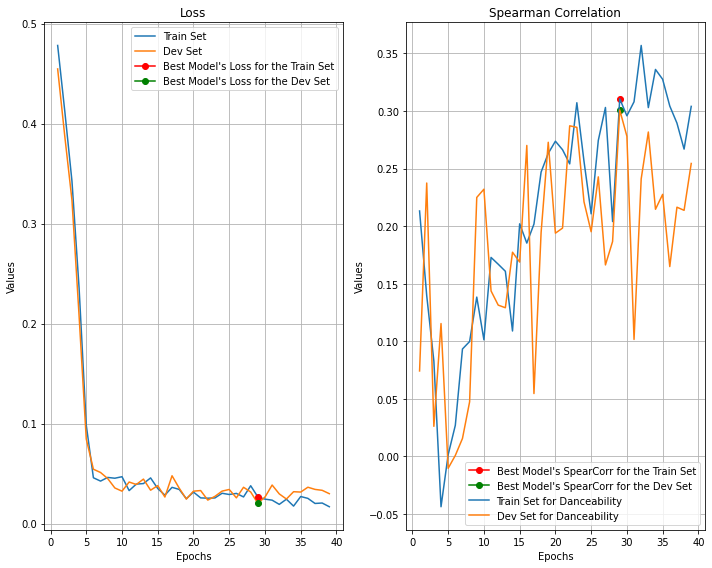

In [ ]:
EarlyLSTMNet = LSTM2(input_dim=mels_feats,
                    rnn_size=HIDDEN_LAYER,
                    output_dim=OUTPUT_SIZE,
                    num_layers=NUM_LAYERS,
                    dropout=dropout,
                    pack_padded_sequence=pack_padded_sequence,
                     att=True).to(device)

# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(EarlyLSTMNet.parameters(), lr=ETA, weight_decay=weight_decay)

# Start the training process
reg_main(device, EarlyLSTMNet, mels_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, Descrs=['Danceability'], net_name='EarlyLSTM_multibeatDanc', PATIENCE=PATIENCE)

LSTM2(
  (softmax): Softmax(dim=-1)
  (non_linearity): Tanh()
  (lstm): LSTM(128, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): FullyConnectedLayer(
    (fc1): Linear(in_features=50, out_features=25, bias=True)
    (fc2): Linear(in_features=25, out_features=1, bias=True)
  )
)
Spearman Correlation for Danceability: 0.22867957165057082


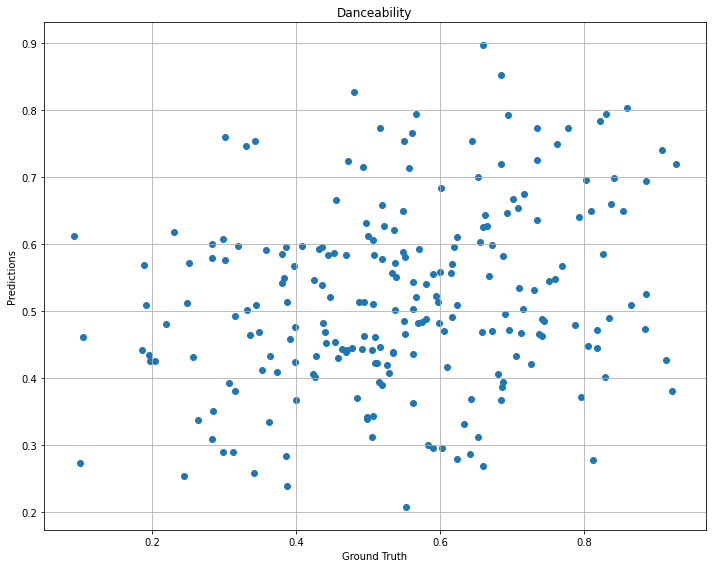

In [ ]:
with open('./best_EarlyLSTM_multibeatDanc.pickle', 'rb') as handle:
    E_model = pickle.load(handle)
print(E_model)
# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
_ = reg_eval(device, dev_loader, mels_feats, E_model, criterion, titles=['Danceability'])


### CNN

#### Redefine CNN Regression Parameters

In [ ]:
# Define training parameters
batch_size = 32
BATCH_SIZE = batch_size
out_features = 1
EPOCHS = 100
regularization_strength = 1e-2
criterion = SpearmanLoss(regularization_strength=regularization_strength)
weight_decay = 1e-5
PATIENCE = 10
dropout = 0.2

# Define model hyperparameters
layer_channels = [(1, 4), (4, 8), (8, 16), (16, 32)]
hidden_features = 50
kernels = [5, 5, 5, 5]

####  Emotion "Valence"

In [ ]:
data = SpectrogramDataset("data/multitask_dataset/",
                              class_mapping=class_mapping, train=True, read_spec_fn=read_mel_spectrogram, emotion=mapping['valence'])
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/multitask_dataset/',
                                          class_mapping=class_mapping, train=False, read_spec_fn=read_mel_spectrogram, emotion=mapping['valence'])

##### Normal Training

CNN(
  (conv_layer): Sequential(
    (0): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

  0%|          | 0/100 [00:00<?, ?it/s]

 [=================================-------] ...Epoch 1, Loss: -0.0669
Statistics for the Train Set
	 Epoch: 1 	 loss: 0.10367026241464071
	 Epoch: 1 	 Spear Corr 1: 0.19580715868915238


  1%|          | 1/100 [00:07<11:33,  7.00s/it]

Statistics for the Dev Set
	 Epoch: 1 	 loss: 0.09475045132894513
	 Epoch: 1 	 Spear Corr 1: 0.15157940030333236
Dev loss decreased (0.094750 --> 0.094750).  Saving model ...
Epoch total time 7.00375771522522
 [=================================-------] ...Epoch 2, Loss: 0.1910
Statistics for the Train Set
	 Epoch: 2 	 loss: 0.05459835232159758
	 Epoch: 2 	 Spear Corr 1: 0.34179853551139017


  2%|▏         | 2/100 [00:14<11:34,  7.09s/it]

Statistics for the Dev Set
	 Epoch: 2 	 loss: 0.0570635795585263
	 Epoch: 2 	 Spear Corr 1: 0.2661483327161903
Dev loss decreased (0.094750 --> 0.057064).  Saving model ...
Epoch total time 7.147535562515259
 [=================================-------] ...Epoch 3, Loss: 0.2826
Statistics for the Train Set
	 Epoch: 3 	 loss: 0.055957566718497345
	 Epoch: 3 	 Spear Corr 1: 0.4096589631449259


  3%|▎         | 3/100 [00:21<11:28,  7.10s/it]

Statistics for the Dev Set
	 Epoch: 3 	 loss: 0.05147321542911124
	 Epoch: 3 	 Spear Corr 1: 0.34244154731069654
Dev loss decreased (0.057064 --> 0.051473).  Saving model ...
Epoch total time 7.105756521224976
 [=================================-------] ...Epoch 4, Loss: 0.1357
Statistics for the Train Set
	 Epoch: 4 	 loss: 0.04631208375401813
	 Epoch: 4 	 Spear Corr 1: 0.4471134693888409


  4%|▍         | 4/100 [00:28<11:16,  7.05s/it]

Statistics for the Dev Set
	 Epoch: 4 	 loss: 0.05851810917493925
	 Epoch: 4 	 Spear Corr 1: 0.28349964139916
EarlyStopping counter: 1 out of 10
Epoch total time 6.975849866867065
 [=================================-------] ...Epoch 5, Loss: 0.0578
Statistics for the Train Set
	 Epoch: 5 	 loss: 0.0552642281242406
	 Epoch: 5 	 Spear Corr 1: 0.418255129379885


  5%|▌         | 5/100 [00:35<11:10,  7.05s/it]

Statistics for the Dev Set
	 Epoch: 5 	 loss: 0.05664303270860094
	 Epoch: 5 	 Spear Corr 1: 0.27676556618216247
EarlyStopping counter: 2 out of 10
Epoch total time 7.061857223510742
 [=================================-------] ...Epoch 6, Loss: 0.0229
Statistics for the Train Set
	 Epoch: 6 	 loss: 0.05030646281675145
	 Epoch: 6 	 Spear Corr 1: 0.4407395782861735


  6%|▌         | 6/100 [00:42<11:02,  7.05s/it]

Statistics for the Dev Set
	 Epoch: 6 	 loss: 0.0502128334528286
	 Epoch: 6 	 Spear Corr 1: 0.33295180766411964
Dev loss decreased (0.051473 --> 0.050213).  Saving model ...
Epoch total time 7.0316362380981445
 [=================================-------] ...Epoch 7, Loss: -0.0300
Statistics for the Train Set
	 Epoch: 7 	 loss: 0.05028320050301074
	 Epoch: 7 	 Spear Corr 1: 0.45350510144292755


  7%|▋         | 7/100 [00:49<10:53,  7.02s/it]

Statistics for the Dev Set
	 Epoch: 7 	 loss: 0.056657231081244305
	 Epoch: 7 	 Spear Corr 1: 0.2674343803539381
EarlyStopping counter: 1 out of 10
Epoch total time 6.965787887573242
 [=================================-------] ...Epoch 8, Loss: 0.2021
Statistics for the Train Set
	 Epoch: 8 	 loss: 0.042045645755068424
	 Epoch: 8 	 Spear Corr 1: 0.46744812342502284


  8%|▊         | 8/100 [00:56<10:44,  7.01s/it]

Statistics for the Dev Set
	 Epoch: 8 	 loss: 0.061347429537061904
	 Epoch: 8 	 Spear Corr 1: 0.23053885343819672
EarlyStopping counter: 2 out of 10
Epoch total time 6.968458652496338
 [=================================-------] ...Epoch 9, Loss: -0.0576
Statistics for the Train Set
	 Epoch: 9 	 loss: 0.03616404824090118
	 Epoch: 9 	 Spear Corr 1: 0.5350342119611861


  9%|▉         | 9/100 [01:03<10:37,  7.01s/it]

Statistics for the Dev Set
	 Epoch: 9 	 loss: 0.05236697593131625
	 Epoch: 9 	 Spear Corr 1: 0.3033935321942915
EarlyStopping counter: 3 out of 10
Epoch total time 7.013663291931152
 [=================================-------] ...Epoch 10, Loss: -0.0949
Statistics for the Train Set
	 Epoch: 10 	 loss: 0.04684575853734821
	 Epoch: 10 	 Spear Corr 1: 0.515323371015932


 10%|█         | 10/100 [01:10<10:30,  7.00s/it]

Statistics for the Dev Set
	 Epoch: 10 	 loss: 0.04908643179497355
	 Epoch: 10 	 Spear Corr 1: 0.36777972872639614
Dev loss decreased (0.050213 --> 0.049086).  Saving model ...
Epoch total time 6.981942892074585
 [=================================-------] ...Epoch 11, Loss: 0.1162
Statistics for the Train Set
	 Epoch: 11 	 loss: 0.04337316409242785
	 Epoch: 11 	 Spear Corr 1: 0.5799490608868532


 11%|█         | 11/100 [01:17<10:22,  7.00s/it]

Statistics for the Dev Set
	 Epoch: 11 	 loss: 0.04310301863247662
	 Epoch: 11 	 Spear Corr 1: 0.36910367980220116
Dev loss decreased (0.049086 --> 0.043103).  Saving model ...
Epoch total time 6.990838527679443
 [=================================-------] ...Epoch 12, Loss: 0.1490
Statistics for the Train Set
	 Epoch: 12 	 loss: 0.027190548388187363
	 Epoch: 12 	 Spear Corr 1: 0.60663364455536


 12%|█▏        | 12/100 [01:24<10:14,  6.98s/it]

Statistics for the Dev Set
	 Epoch: 12 	 loss: 0.05517328460265845
	 Epoch: 12 	 Spear Corr 1: 0.28216386992350945
EarlyStopping counter: 1 out of 10
Epoch total time 6.9443018436431885
 [=================================-------] ...Epoch 13, Loss: -0.0547
Statistics for the Train Set
	 Epoch: 13 	 loss: 0.029453208255314774
	 Epoch: 13 	 Spear Corr 1: 0.647157245470619


 13%|█▎        | 13/100 [01:31<10:06,  6.98s/it]

Statistics for the Dev Set
	 Epoch: 13 	 loss: 0.051987951837865566
	 Epoch: 13 	 Spear Corr 1: 0.27491417008099633
EarlyStopping counter: 2 out of 10
Epoch total time 6.9582483768463135
 [=================================-------] ...Epoch 14, Loss: -0.0784
Statistics for the Train Set
	 Epoch: 14 	 loss: 0.03794509640980993
	 Epoch: 14 	 Spear Corr 1: 0.5729547483988451


 14%|█▍        | 14/100 [01:38<10:00,  6.99s/it]

Statistics for the Dev Set
	 Epoch: 14 	 loss: 0.05954663210404365
	 Epoch: 14 	 Spear Corr 1: 0.358821171063862
EarlyStopping counter: 3 out of 10
Epoch total time 7.012061834335327
 [=================================-------] ...Epoch 15, Loss: -0.0852
Statistics for the Train Set
	 Epoch: 15 	 loss: 0.02584752193372994
	 Epoch: 15 	 Spear Corr 1: 0.6433846114235311


 15%|█▌        | 15/100 [01:45<09:55,  7.00s/it]

Statistics for the Dev Set
	 Epoch: 15 	 loss: 0.05299271272730943
	 Epoch: 15 	 Spear Corr 1: 0.3364138329571018
EarlyStopping counter: 4 out of 10
Epoch total time 7.0267860889434814
 [=================================-------] ...Epoch 16, Loss: -0.0050
Statistics for the Train Set
	 Epoch: 16 	 loss: 0.0347924777363593
	 Epoch: 16 	 Spear Corr 1: 0.6998894709375697


 16%|█▌        | 16/100 [01:52<09:47,  6.99s/it]

Statistics for the Dev Set
	 Epoch: 16 	 loss: 0.054689786576509004
	 Epoch: 16 	 Spear Corr 1: 0.34682553369558
EarlyStopping counter: 5 out of 10
Epoch total time 6.974933862686157
 [=================================-------] ...Epoch 17, Loss: -0.0786
Statistics for the Train Set
	 Epoch: 17 	 loss: 0.04567403092340665
	 Epoch: 17 	 Spear Corr 1: 0.6374450955903731


 17%|█▋        | 17/100 [01:59<09:39,  6.98s/it]

Statistics for the Dev Set
	 Epoch: 17 	 loss: 0.07993575168026545
	 Epoch: 17 	 Spear Corr 1: 0.26572719501632414
EarlyStopping counter: 6 out of 10
Epoch total time 6.935075998306274
 [=================================-------] ...Epoch 18, Loss: -0.0076
Statistics for the Train Set
	 Epoch: 18 	 loss: 0.03270860409346073
	 Epoch: 18 	 Spear Corr 1: 0.6721761928856272


 18%|█▊        | 18/100 [02:06<09:33,  6.99s/it]

Statistics for the Dev Set
	 Epoch: 18 	 loss: 0.05089025847600802
	 Epoch: 18 	 Spear Corr 1: 0.2902981612711069
EarlyStopping counter: 7 out of 10
Epoch total time 7.024204730987549
 [=================================-------] ...Epoch 19, Loss: 0.0469
Statistics for the Train Set
	 Epoch: 19 	 loss: 0.024190345304940835
	 Epoch: 19 	 Spear Corr 1: 0.69987665019034


 19%|█▉        | 19/100 [02:13<09:25,  6.98s/it]

Statistics for the Dev Set
	 Epoch: 19 	 loss: 0.04571757459759778
	 Epoch: 19 	 Spear Corr 1: 0.3548781458034201
EarlyStopping counter: 8 out of 10
Epoch total time 6.963175296783447
 [=================================-------] ...Epoch 20, Loss: 0.1502
Statistics for the Train Set
	 Epoch: 20 	 loss: 0.026533537628449518
	 Epoch: 20 	 Spear Corr 1: 0.7083528542069066


 20%|██        | 20/100 [02:20<09:18,  6.98s/it]

Statistics for the Dev Set
	 Epoch: 20 	 loss: 0.04255552569650935
	 Epoch: 20 	 Spear Corr 1: 0.37233508135939786
Dev loss decreased (0.043103 --> 0.042556).  Saving model ...
Epoch total time 6.968633413314819
 [=================================-------] ...Epoch 21, Loss: 0.0869
Statistics for the Train Set
	 Epoch: 21 	 loss: 0.028268774240231803
	 Epoch: 21 	 Spear Corr 1: 0.6705477954368406


 21%|██        | 21/100 [02:27<09:11,  6.98s/it]

Statistics for the Dev Set
	 Epoch: 21 	 loss: 0.047451815588594924
	 Epoch: 21 	 Spear Corr 1: 0.33246760458921837
EarlyStopping counter: 1 out of 10
Epoch total time 6.963534593582153
 [=================================-------] ...Epoch 22, Loss: -0.0261
Statistics for the Train Set
	 Epoch: 22 	 loss: 0.022792984677941986
	 Epoch: 22 	 Spear Corr 1: 0.6537978252297283


 22%|██▏       | 22/100 [02:34<09:05,  6.99s/it]

Statistics for the Dev Set
	 Epoch: 22 	 loss: 0.04893048072483867
	 Epoch: 22 	 Spear Corr 1: 0.2873571747886028
EarlyStopping counter: 2 out of 10
Epoch total time 7.016316652297974
 [=================================-------] ...Epoch 23, Loss: -0.0914
Statistics for the Train Set
	 Epoch: 23 	 loss: 0.01854991373732043
	 Epoch: 23 	 Spear Corr 1: 0.6832994190710736


 23%|██▎       | 23/100 [02:41<08:58,  6.99s/it]

Statistics for the Dev Set
	 Epoch: 23 	 loss: 0.05347847937049255
	 Epoch: 23 	 Spear Corr 1: 0.277767901530728
EarlyStopping counter: 3 out of 10
Epoch total time 6.983944416046143
 [=================================-------] ...Epoch 24, Loss: -0.0817
Statistics for the Train Set
	 Epoch: 24 	 loss: 0.020482951616704027
	 Epoch: 24 	 Spear Corr 1: 0.708778600955301


 24%|██▍       | 24/100 [02:48<08:50,  6.98s/it]

Statistics for the Dev Set
	 Epoch: 24 	 loss: 0.045222770447867454
	 Epoch: 24 	 Spear Corr 1: 0.31727046133319325
EarlyStopping counter: 4 out of 10
Epoch total time 6.96764063835144
 [=================================-------] ...Epoch 25, Loss: -0.0760
Statistics for the Train Set
	 Epoch: 25 	 loss: 0.02286913081207124
	 Epoch: 25 	 Spear Corr 1: 0.7304258078671946


 25%|██▌       | 25/100 [02:55<08:45,  7.01s/it]

Statistics for the Dev Set
	 Epoch: 25 	 loss: 0.052986715620594836
	 Epoch: 25 	 Spear Corr 1: 0.2771937148768381
EarlyStopping counter: 5 out of 10
Epoch total time 7.0680832862854
 [=================================-------] ...Epoch 26, Loss: -0.0005
Statistics for the Train Set
	 Epoch: 26 	 loss: 0.016071706057229275
	 Epoch: 26 	 Spear Corr 1: 0.715007684604344


 26%|██▌       | 26/100 [03:02<08:37,  7.00s/it]

Statistics for the Dev Set
	 Epoch: 26 	 loss: 0.05015194555654472
	 Epoch: 26 	 Spear Corr 1: 0.3050084321960295
EarlyStopping counter: 6 out of 10
Epoch total time 6.971760034561157
 [=================================-------] ...Epoch 27, Loss: -0.0090
Statistics for the Train Set
	 Epoch: 27 	 loss: 0.021978123654172517
	 Epoch: 27 	 Spear Corr 1: 0.7082898382608553


 27%|██▋       | 27/100 [03:09<08:30,  7.00s/it]

Statistics for the Dev Set
	 Epoch: 27 	 loss: 0.04437076872168437
	 Epoch: 27 	 Spear Corr 1: 0.3763176116116179
EarlyStopping counter: 7 out of 10
Epoch total time 6.990573883056641
 [=================================-------] ...Epoch 28, Loss: -0.0171
Statistics for the Train Set
	 Epoch: 28 	 loss: 0.019645777483827283
	 Epoch: 28 	 Spear Corr 1: 0.7042634527967582


 28%|██▊       | 28/100 [03:16<08:24,  7.00s/it]

Statistics for the Dev Set
	 Epoch: 28 	 loss: 0.05813389551031176
	 Epoch: 28 	 Spear Corr 1: 0.19584759829342274
EarlyStopping counter: 8 out of 10
Epoch total time 7.015902042388916
 [=================================-------] ...Epoch 29, Loss: 0.1155
Statistics for the Train Set
	 Epoch: 29 	 loss: 0.029225760254944878
	 Epoch: 29 	 Spear Corr 1: 0.7575606201658159


 29%|██▉       | 29/100 [03:23<08:16,  6.99s/it]

Statistics for the Dev Set
	 Epoch: 29 	 loss: 0.05463288476843827
	 Epoch: 29 	 Spear Corr 1: 0.30368981963262687
EarlyStopping counter: 9 out of 10
Epoch total time 6.9647767543792725
 [=================================-------] ...Epoch 30, Loss: 0.0093
Statistics for the Train Set
	 Epoch: 30 	 loss: 0.022450135585677263
	 Epoch: 30 	 Spear Corr 1: 0.7884897318082442


 29%|██▉       | 29/100 [03:30<08:34,  7.24s/it]

Statistics for the Dev Set
	 Epoch: 30 	 loss: 0.04882866219832975
	 Epoch: 30 	 Spear Corr 1: 0.3567711823013251
EarlyStopping counter: 10 out of 10
Training total time 202.99703812599182


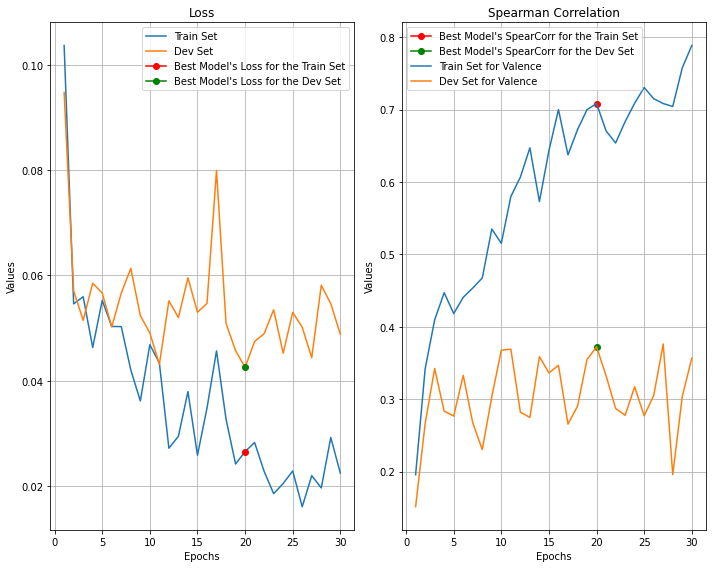

In [ ]:
EarlyCNNNet = CNN(layer_channels, hidden_features, out_features, kernels, dropout=dropout).to(device)
print(EarlyCNNNet)

#Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(EarlyCNNNet.parameters(), lr=ETA, weight_decay=weight_decay)

#Start the training process
reg_main(device, EarlyCNNNet, mels_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, Descrs = ['Valence'], net_name='EarlyCNN_multibeatVal', PATIENCE=PATIENCE, cnn=True)

Spearman Correlation for Valence: 0.29932932270231405


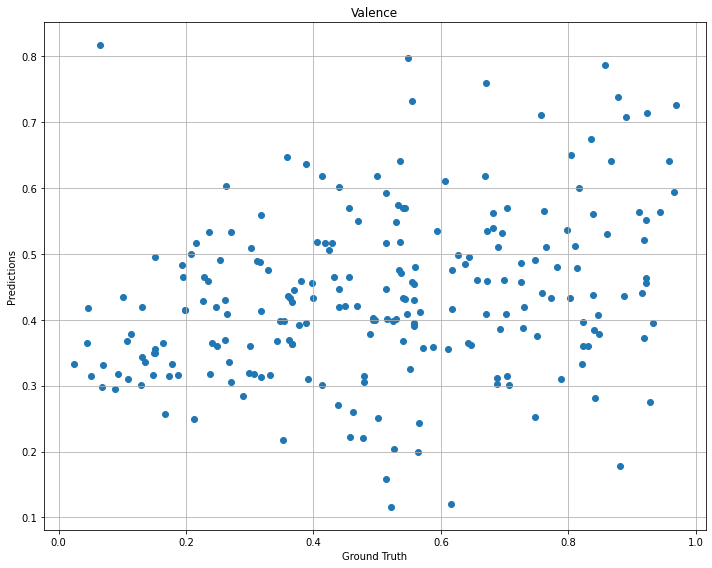

In [ ]:
with open('./best_EarlyCNN_multibeatVal.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
_ = reg_eval(device, dev_loader, mels_feats, E_model, criterion, cnn=True, titles=['Valence'])

####  Emotion "Energy"

In [ ]:
data = SpectrogramDataset("data/multitask_dataset_beat/",
                              class_mapping=class_mapping, train=True, read_spec_fn=read_mel_spectrogram, emotion=mapping['energy'])
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/multitask_dataset_beat/',
                                          class_mapping=class_mapping, train=False, read_spec_fn=read_mel_spectrogram, emotion=mapping['energy'])

##### Normal Training

  0%|          | 0/100 [00:00<?, ?it/s]

 [=================================-------] ...Epoch 1, Loss: 0.0569
Statistics for the Train Set
	 Epoch: 1 	 loss: 0.1645047956751311
	 Epoch: 1 	 Spear Corr 1: -0.0879877930888678


  1%|          | 1/100 [00:00<01:09,  1.42it/s]

Statistics for the Dev Set
	 Epoch: 1 	 loss: 0.14637796949217804
	 Epoch: 1 	 Spear Corr 1: 0.030167319209933388
Dev loss decreased (0.146378 --> 0.146378).  Saving model ...
Epoch total time 0.7033934593200684
 [=================================-------] ...Epoch 2, Loss: -0.0721

  2%|▏         | 2/100 [00:01<01:13,  1.34it/s]


Statistics for the Train Set
	 Epoch: 2 	 loss: 0.0910043992833802
	 Epoch: 2 	 Spear Corr 1: 0.3888317184705565
Statistics for the Dev Set
	 Epoch: 2 	 loss: 0.09149176929680555
	 Epoch: 2 	 Spear Corr 1: 0.40443340918689274
Dev loss decreased (0.146378 --> 0.091492).  Saving model ...
Epoch total time 0.7779433727264404
 [=================================-------] ...Epoch 3, Loss: -0.0634
Statistics for the Train Set
	 Epoch: 3 	 loss: 0.06825693228898819
	 Epoch: 3 	 Spear Corr 1: 0.3400385985587276


  3%|▎         | 3/100 [00:02<01:09,  1.39it/s]

Statistics for the Dev Set
	 Epoch: 3 	 loss: 0.0786364588049827
	 Epoch: 3 	 Spear Corr 1: 0.3988183768300987
Dev loss decreased (0.091492 --> 0.078636).  Saving model ...
Epoch total time 0.6877617835998535
 [=================================-------] ...Epoch 4, Loss: 0.2049
Statistics for the Train Set
	 Epoch: 4 	 loss: 0.07152977918541645
	 Epoch: 4 	 Spear Corr 1: 0.4480412976932884


  4%|▍         | 4/100 [00:02<01:08,  1.40it/s]

Statistics for the Dev Set
	 Epoch: 4 	 loss: 0.06114125439319101
	 Epoch: 4 	 Spear Corr 1: 0.5474843395309612
Dev loss decreased (0.078636 --> 0.061141).  Saving model ...
Epoch total time 0.6996462345123291
 [=================================-------] ...Epoch 5, Loss: 0.2540
Statistics for the Train Set
	 Epoch: 5 	 loss: 0.06138404836239774
	 Epoch: 5 	 Spear Corr 1: 0.4174400526497977


  5%|▌         | 5/100 [00:03<01:06,  1.42it/s]

Statistics for the Dev Set
	 Epoch: 5 	 loss: 0.06384090429942499
	 Epoch: 5 	 Spear Corr 1: 0.4301927304723111
EarlyStopping counter: 1 out of 10
Epoch total time 0.6871860027313232
 [=================================-------] ...Epoch 6, Loss: -0.0183
Statistics for the Train Set
	 Epoch: 6 	 loss: 0.051889937853467356
	 Epoch: 6 	 Spear Corr 1: 0.45219829166251074


  6%|▌         | 6/100 [00:04<01:05,  1.43it/s]

Statistics for the Dev Set
	 Epoch: 6 	 loss: 0.057222701517180626
	 Epoch: 6 	 Spear Corr 1: 0.4974070914612981
Dev loss decreased (0.061141 --> 0.057223).  Saving model ...
Epoch total time 0.6873235702514648
 [=================================-------] ...Epoch 7, Loss: -0.0570
Statistics for the Train Set
	 Epoch: 7 	 loss: 0.05048517395211573
	 Epoch: 7 	 Spear Corr 1: 0.5309160544019683


  7%|▋         | 7/100 [00:04<01:04,  1.43it/s]

Statistics for the Dev Set
	 Epoch: 7 	 loss: 0.05646904747759073
	 Epoch: 7 	 Spear Corr 1: 0.553115921232028
Dev loss decreased (0.057223 --> 0.056469).  Saving model ...
Epoch total time 0.6922817230224609
 [=================================-------] ...Epoch 8, Loss: -0.0356
Statistics for the Train Set
	 Epoch: 8 	 loss: 0.041411324319940476
	 Epoch: 8 	 Spear Corr 1: 0.47990350356736156


  8%|▊         | 8/100 [00:05<01:03,  1.44it/s]

Statistics for the Dev Set
	 Epoch: 8 	 loss: 0.060936893837598406
	 Epoch: 8 	 Spear Corr 1: 0.41414253577683524
EarlyStopping counter: 1 out of 10
Epoch total time 0.6824800968170166
 [=================================-------] ...Epoch 9, Loss: 0.0289
Statistics for the Train Set
	 Epoch: 9 	 loss: 0.03736081069258305
	 Epoch: 9 	 Spear Corr 1: 0.5302198484530337


  9%|▉         | 9/100 [00:06<01:02,  1.45it/s]

Statistics for the Dev Set
	 Epoch: 9 	 loss: 0.04289691807776513
	 Epoch: 9 	 Spear Corr 1: 0.5331510058413276
Dev loss decreased (0.056469 --> 0.042897).  Saving model ...
Epoch total time 0.6778130531311035
 [=================================-------] ...Epoch 10, Loss: -0.0354
Statistics for the Train Set
	 Epoch: 10 	 loss: 0.04441251378953305
	 Epoch: 10 	 Spear Corr 1: 0.5713709841334651


 10%|█         | 10/100 [00:07<01:02,  1.45it/s]

Statistics for the Dev Set
	 Epoch: 10 	 loss: 0.05901796866196259
	 Epoch: 10 	 Spear Corr 1: 0.4801765548243056
EarlyStopping counter: 1 out of 10
Epoch total time 0.6906757354736328
 [=================================-------] ...Epoch 11, Loss: 0.1183
Statistics for the Train Set
	 Epoch: 11 	 loss: 0.035098760369717825
	 Epoch: 11 	 Spear Corr 1: 0.5668119313530169


 11%|█         | 11/100 [00:07<01:01,  1.45it/s]

Statistics for the Dev Set
	 Epoch: 11 	 loss: 0.04309016276518301
	 Epoch: 11 	 Spear Corr 1: 0.5658167421866287
EarlyStopping counter: 2 out of 10
Epoch total time 0.6889493465423584
 [=================================-------] ...Epoch 12, Loss: 0.0243
Statistics for the Train Set
	 Epoch: 12 	 loss: 0.03477938152039686
	 Epoch: 12 	 Spear Corr 1: 0.6118710123937511


 12%|█▏        | 12/100 [00:08<01:00,  1.45it/s]

Statistics for the Dev Set
	 Epoch: 12 	 loss: 0.04905285826483211
	 Epoch: 12 	 Spear Corr 1: 0.5556469032061259
EarlyStopping counter: 3 out of 10
Epoch total time 0.6882758140563965
 [=================================-------] ...Epoch 13, Loss: 0.1096
Statistics for the Train Set
	 Epoch: 13 	 loss: 0.031214202775416644
	 Epoch: 13 	 Spear Corr 1: 0.5759507509175829


 13%|█▎        | 13/100 [00:09<00:59,  1.45it/s]

Statistics for the Dev Set
	 Epoch: 13 	 loss: 0.04600957157911252
	 Epoch: 13 	 Spear Corr 1: 0.5680519713630783
EarlyStopping counter: 4 out of 10
Epoch total time 0.6852309703826904
 [=================================-------] ...Epoch 14, Loss: -0.0453
Statistics for the Train Set
	 Epoch: 14 	 loss: 0.027294076935722545
	 Epoch: 14 	 Spear Corr 1: 0.6137727899274559


 14%|█▍        | 14/100 [00:09<00:59,  1.45it/s]

Statistics for the Dev Set
	 Epoch: 14 	 loss: 0.04093440250109557
	 Epoch: 14 	 Spear Corr 1: 0.6117128785032577
Dev loss decreased (0.042897 --> 0.040934).  Saving model ...
Epoch total time 0.6852314472198486
 [=================================-------] ...Epoch 15, Loss: 0.1650
Statistics for the Train Set
	 Epoch: 15 	 loss: 0.03141470296748453
	 Epoch: 15 	 Spear Corr 1: 0.5972934825977034


 15%|█▌        | 15/100 [00:10<00:58,  1.45it/s]

Statistics for the Dev Set
	 Epoch: 15 	 loss: 0.04324267039207571
	 Epoch: 15 	 Spear Corr 1: 0.5619991821577796
EarlyStopping counter: 1 out of 10
Epoch total time 0.6941406726837158
 [=================================-------] ...Epoch 16, Loss: -0.0847
Statistics for the Train Set
	 Epoch: 16 	 loss: 0.025530441968706675
	 Epoch: 16 	 Spear Corr 1: 0.6273554095560526


 16%|█▌        | 16/100 [00:11<00:58,  1.44it/s]

Statistics for the Dev Set
	 Epoch: 16 	 loss: 0.03867506464559673
	 Epoch: 16 	 Spear Corr 1: 0.5580567012721621
Dev loss decreased (0.040934 --> 0.038675).  Saving model ...
Epoch total time 0.7017710208892822
 [=================================-------] ...Epoch 17, Loss: -0.0978
Statistics for the Train Set
	 Epoch: 17 	 loss: 0.030818609983477886
	 Epoch: 17 	 Spear Corr 1: 0.6042003102676661


 17%|█▋        | 17/100 [00:11<00:57,  1.45it/s]

Statistics for the Dev Set
	 Epoch: 17 	 loss: 0.04110096182741766
	 Epoch: 17 	 Spear Corr 1: 0.5372824695615435
EarlyStopping counter: 1 out of 10
Epoch total time 0.6804578304290771
 [=================================-------] ...Epoch 18, Loss: -0.0489
Statistics for the Train Set
	 Epoch: 18 	 loss: 0.022621087234851928
	 Epoch: 18 	 Spear Corr 1: 0.5936142944083258


 18%|█▊        | 18/100 [00:12<00:57,  1.44it/s]

Statistics for the Dev Set
	 Epoch: 18 	 loss: 0.03931712362796839
	 Epoch: 18 	 Spear Corr 1: 0.5495738277078477
EarlyStopping counter: 2 out of 10
Epoch total time 0.7024202346801758
 [=================================-------] ...Epoch 19, Loss: 0.0840
Statistics for the Train Set
	 Epoch: 19 	 loss: 0.02657647120194437
	 Epoch: 19 	 Spear Corr 1: 0.6064243811272662


 19%|█▉        | 19/100 [00:13<00:56,  1.43it/s]

Statistics for the Dev Set
	 Epoch: 19 	 loss: 0.0416706679610624
	 Epoch: 19 	 Spear Corr 1: 0.46987645648888193
EarlyStopping counter: 3 out of 10
Epoch total time 0.7000622749328613
 [=================================-------] ...Epoch 20, Loss: -0.0381
Statistics for the Train Set
	 Epoch: 20 	 loss: 0.019988669093013976
	 Epoch: 20 	 Spear Corr 1: 0.6791296308767913


 20%|██        | 20/100 [00:13<00:55,  1.44it/s]

Statistics for the Dev Set
	 Epoch: 20 	 loss: 0.038845726620912055
	 Epoch: 20 	 Spear Corr 1: 0.5824450962320198
EarlyStopping counter: 4 out of 10
Epoch total time 0.6845457553863525
 [=================================-------] ...Epoch 21, Loss: 0.1127
Statistics for the Train Set
	 Epoch: 21 	 loss: 0.023494494038616018
	 Epoch: 21 	 Spear Corr 1: 0.6665890084887872


 21%|██        | 21/100 [00:14<00:54,  1.44it/s]

Statistics for the Dev Set
	 Epoch: 21 	 loss: 0.03683898543207714
	 Epoch: 21 	 Spear Corr 1: 0.5601915666833448
Dev loss decreased (0.038675 --> 0.036839).  Saving model ...
Epoch total time 0.697174072265625
 [=================================-------] ...Epoch 22, Loss: 0.1849
Statistics for the Train Set
	 Epoch: 22 	 loss: 0.018663918110814033
	 Epoch: 22 	 Spear Corr 1: 0.6540426276077631


 22%|██▏       | 22/100 [00:15<00:54,  1.44it/s]

Statistics for the Dev Set
	 Epoch: 22 	 loss: 0.039389546297081635
	 Epoch: 22 	 Spear Corr 1: 0.5676115452654974
EarlyStopping counter: 1 out of 10
Epoch total time 0.6967401504516602
 [=================================-------] ...Epoch 23, Loss: -0.0878
Statistics for the Train Set
	 Epoch: 23 	 loss: 0.02384952027738429
	 Epoch: 23 	 Spear Corr 1: 0.6990134918496693


 23%|██▎       | 23/100 [00:16<00:53,  1.43it/s]

Statistics for the Dev Set
	 Epoch: 23 	 loss: 0.04005624983031057
	 Epoch: 23 	 Spear Corr 1: 0.5926491016006985
EarlyStopping counter: 2 out of 10
Epoch total time 0.705488920211792
 [=================================-------] ...Epoch 24, Loss: -0.0117
Statistics for the Train Set
	 Epoch: 24 	 loss: 0.018433556586636788
	 Epoch: 24 	 Spear Corr 1: 0.6273912722383548


 24%|██▍       | 24/100 [00:16<00:53,  1.43it/s]

Statistics for the Dev Set
	 Epoch: 24 	 loss: 0.030429555931529927
	 Epoch: 24 	 Spear Corr 1: 0.5837962701144161
Dev loss decreased (0.036839 --> 0.030430).  Saving model ...
Epoch total time 0.6997096538543701
 [=================================-------] ...Epoch 25, Loss: -0.0528
Statistics for the Train Set
	 Epoch: 25 	 loss: 0.01945542283414307
	 Epoch: 25 	 Spear Corr 1: 0.6982665034493385


 25%|██▌       | 25/100 [00:17<00:52,  1.43it/s]

Statistics for the Dev Set
	 Epoch: 25 	 loss: 0.03550322798721756
	 Epoch: 25 	 Spear Corr 1: 0.6153297110015731
EarlyStopping counter: 1 out of 10
Epoch total time 0.6946642398834229
 [=================================-------] ...Epoch 26, Loss: 0.0311
Statistics for the Train Set
	 Epoch: 26 	 loss: 0.023831513593995452
	 Epoch: 26 	 Spear Corr 1: 0.6996325754201416


 26%|██▌       | 26/100 [00:18<00:51,  1.43it/s]

Statistics for the Dev Set
	 Epoch: 26 	 loss: 0.03910695616597217
	 Epoch: 26 	 Spear Corr 1: 0.587803880677494
EarlyStopping counter: 2 out of 10
Epoch total time 0.6939053535461426
 [=================================-------] ...Epoch 27, Loss: -0.0127
Statistics for the Train Set
	 Epoch: 27 	 loss: 0.01708061047233652
	 Epoch: 27 	 Spear Corr 1: 0.6843149094161771


 27%|██▋       | 27/100 [00:18<00:51,  1.43it/s]

Statistics for the Dev Set
	 Epoch: 27 	 loss: 0.03189751769547199
	 Epoch: 27 	 Spear Corr 1: 0.5408811511661403
EarlyStopping counter: 3 out of 10
Epoch total time 0.7008237838745117
 [=================================-------] ...Epoch 28, Loss: 0.0628
Statistics for the Train Set
	 Epoch: 28 	 loss: 0.021553238935483214
	 Epoch: 28 	 Spear Corr 1: 0.7253427636323687


 28%|██▊       | 28/100 [00:19<00:50,  1.43it/s]

Statistics for the Dev Set
	 Epoch: 28 	 loss: 0.036034753435381414
	 Epoch: 28 	 Spear Corr 1: 0.6343582538163257
EarlyStopping counter: 4 out of 10
Epoch total time 0.6914079189300537
 [=================================-------] ...Epoch 29, Loss: -0.0571
Statistics for the Train Set
	 Epoch: 29 	 loss: 0.021809291375674698
	 Epoch: 29 	 Spear Corr 1: 0.6252150564136834


 29%|██▉       | 29/100 [00:20<00:49,  1.43it/s]

Statistics for the Dev Set
	 Epoch: 29 	 loss: 0.04578537676004744
	 Epoch: 29 	 Spear Corr 1: 0.44733411419015695
EarlyStopping counter: 5 out of 10
Epoch total time 0.6884245872497559
 [=================================-------] ...Epoch 30, Loss: 0.1756
Statistics for the Train Set
	 Epoch: 30 	 loss: 0.018385921863384416
	 Epoch: 30 	 Spear Corr 1: 0.7271681644917433


 30%|███       | 30/100 [00:20<00:48,  1.44it/s]

Statistics for the Dev Set
	 Epoch: 30 	 loss: 0.039305648780713756
	 Epoch: 30 	 Spear Corr 1: 0.5180585377144092
EarlyStopping counter: 6 out of 10
Epoch total time 0.6935298442840576
 [=================================-------] ...Epoch 31, Loss: -0.0033
Statistics for the Train Set
	 Epoch: 31 	 loss: 0.024001859514831202
	 Epoch: 31 	 Spear Corr 1: 0.7315434177748309


 31%|███       | 31/100 [00:21<00:47,  1.44it/s]

Statistics for the Dev Set
	 Epoch: 31 	 loss: 0.03797048112826453
	 Epoch: 31 	 Spear Corr 1: 0.6167604285064416
EarlyStopping counter: 7 out of 10
Epoch total time 0.6882424354553223
 [=================================-------] ...Epoch 32, Loss: -0.0319
Statistics for the Train Set
	 Epoch: 32 	 loss: 0.02152866040703659
	 Epoch: 32 	 Spear Corr 1: 0.6791793693424025


 32%|███▏      | 32/100 [00:22<00:47,  1.44it/s]

Statistics for the Dev Set
	 Epoch: 32 	 loss: 0.03646355152911252
	 Epoch: 32 	 Spear Corr 1: 0.5546784996412634
EarlyStopping counter: 8 out of 10
Epoch total time 0.7003693580627441
 [=================================-------] ...Epoch 33, Loss: -0.0935
Statistics for the Train Set
	 Epoch: 33 	 loss: 0.013936174785187716
	 Epoch: 33 	 Spear Corr 1: 0.6906062991803131


 33%|███▎      | 33/100 [00:23<00:46,  1.43it/s]

Statistics for the Dev Set
	 Epoch: 33 	 loss: 0.031160712895304286
	 Epoch: 33 	 Spear Corr 1: 0.5709070001750326
EarlyStopping counter: 9 out of 10
Epoch total time 0.7050919532775879
 [=================================-------] ...Epoch 34, Loss: -0.0575
Statistics for the Train Set
	 Epoch: 34 	 loss: 0.009627297224549159
	 Epoch: 34 	 Spear Corr 1: 0.7240222376128341


 33%|███▎      | 33/100 [00:23<00:48,  1.39it/s]

Statistics for the Dev Set
	 Epoch: 34 	 loss: 0.03337314326973078
	 Epoch: 34 	 Spear Corr 1: 0.5699861092437272
EarlyStopping counter: 10 out of 10
Training total time 22.953162670135498


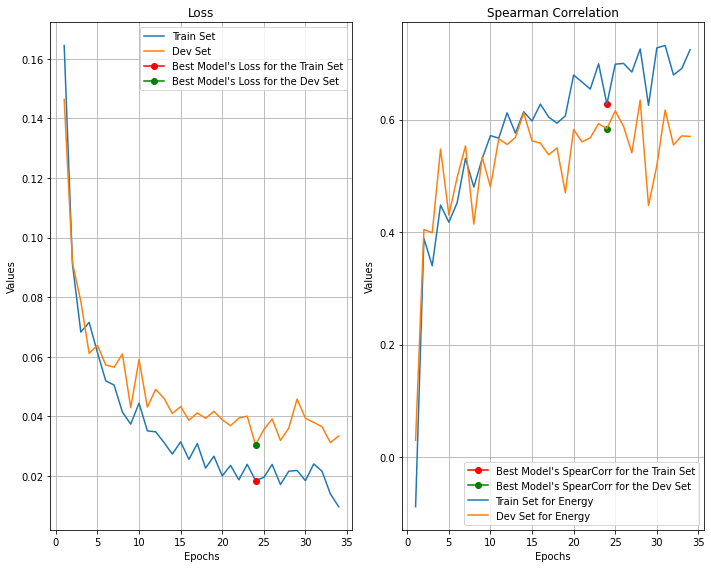

In [ ]:
EarlyCNNNet = CNN(layer_channels, hidden_features, out_features, kernels).to(device)

# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(EarlyCNNNet.parameters(), lr=ETA, weight_decay=weight_decay)

# Start the training process
reg_main(device, EarlyCNNNet, mels_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, Descrs = ['Energy'], net_name='EarlyCNN_multibeatEn', PATIENCE=PATIENCE, cnn=True)

Spearman Correlation for Energy: 0.515607633212599


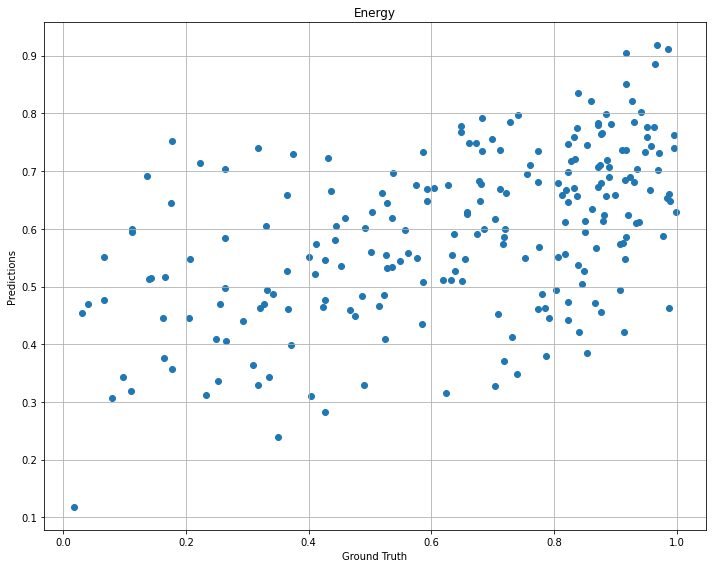

In [ ]:
with open('./best_EarlyCNN_multibeatEn.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
_ = reg_eval(device, dev_loader, mels_feats, E_model, criterion, cnn=True, titles=['Energy'])

####  Emotion "Danceability"

In [ ]:
data = SpectrogramDataset("data/multitask_dataset/",
                              class_mapping=class_mapping, train=True, read_spec_fn=read_mel_spectrogram, emotion=mapping['danceability'])
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/multitask_dataset_beat/',
                                          class_mapping=class_mapping, train=False, read_spec_fn=read_mel_spectrogram, emotion=mapping['danceability'])

##### Normal Training

  0%|          | 0/100 [00:00<?, ?it/s]

 [=================================-------] ...Epoch 1, Loss: -0.0773
Statistics for the Train Set
	 Epoch: 1 	 loss: 0.042039355634631834
	 Epoch: 1 	 Spear Corr 1: 0.2110205708691739


  1%|          | 1/100 [00:07<11:54,  7.22s/it]

Statistics for the Dev Set
	 Epoch: 1 	 loss: 0.07039503132011231
	 Epoch: 1 	 Spear Corr 1: -0.002275277629939039
Dev loss decreased (0.070395 --> 0.070395).  Saving model ...
Epoch total time 7.218430042266846
 [=================================-------] ...Epoch 2, Loss: -0.0956
Statistics for the Train Set
	 Epoch: 2 	 loss: 0.002207840113686724
	 Epoch: 2 	 Spear Corr 1: 0.47840043872404303


  2%|▏         | 2/100 [00:14<11:48,  7.23s/it]

Statistics for the Dev Set
	 Epoch: 2 	 loss: 0.012111446260300094
	 Epoch: 2 	 Spear Corr 1: 0.35177009341634696
Dev loss decreased (0.070395 --> 0.012111).  Saving model ...
Epoch total time 7.229227781295776
 [=================================-------] ...Epoch 3, Loss: 0.1053
Statistics for the Train Set
	 Epoch: 3 	 loss: -0.0026313000557320167
	 Epoch: 3 	 Spear Corr 1: 0.490172244872334


  3%|▎         | 3/100 [00:21<11:41,  7.23s/it]

Statistics for the Dev Set
	 Epoch: 3 	 loss: 0.014093939906225077
	 Epoch: 3 	 Spear Corr 1: 0.31749145038059245
EarlyStopping counter: 1 out of 10
Epoch total time 7.24050760269165
 [=================================-------] ...Epoch 4, Loss: -0.0863
Statistics for the Train Set
	 Epoch: 4 	 loss: -0.004747698267782086
	 Epoch: 4 	 Spear Corr 1: 0.5647993881224423


  4%|▍         | 4/100 [00:28<11:33,  7.23s/it]

Statistics for the Dev Set
	 Epoch: 4 	 loss: 0.005808759152160969
	 Epoch: 4 	 Spear Corr 1: 0.47669468681651467
Dev loss decreased (0.012111 --> 0.005809).  Saving model ...
Epoch total time 7.208693742752075
 [=================================-------] ...Epoch 5, Loss: -0.0590
Statistics for the Train Set
	 Epoch: 5 	 loss: 0.0005371558396240555
	 Epoch: 5 	 Spear Corr 1: 0.5736407990915029


  5%|▌         | 5/100 [00:36<11:26,  7.22s/it]

Statistics for the Dev Set
	 Epoch: 5 	 loss: 0.01946202190958839
	 Epoch: 5 	 Spear Corr 1: 0.3264174574131079
EarlyStopping counter: 1 out of 10
Epoch total time 7.218995094299316
 [=================================-------] ...Epoch 6, Loss: -0.0370
Statistics for the Train Set
	 Epoch: 6 	 loss: -0.004929706655796035
	 Epoch: 6 	 Spear Corr 1: 0.6225954599614766


  6%|▌         | 6/100 [00:43<11:20,  7.24s/it]

Statistics for the Dev Set
	 Epoch: 6 	 loss: 0.007935381054455905
	 Epoch: 6 	 Spear Corr 1: 0.4865757552474254
EarlyStopping counter: 2 out of 10
Epoch total time 7.28075909614563
 [=================================-------] ...Epoch 7, Loss: -0.0462
Statistics for the Train Set
	 Epoch: 7 	 loss: -0.0008523474622441957
	 Epoch: 7 	 Spear Corr 1: 0.6027734172610445


  7%|▋         | 7/100 [00:50<11:12,  7.23s/it]

Statistics for the Dev Set
	 Epoch: 7 	 loss: 0.013864693153341628
	 Epoch: 7 	 Spear Corr 1: 0.4494863809302
EarlyStopping counter: 3 out of 10
Epoch total time 7.20794415473938
 [=================================-------] ...Epoch 8, Loss: 0.0165
Statistics for the Train Set
	 Epoch: 8 	 loss: -0.01970148210709887
	 Epoch: 8 	 Spear Corr 1: 0.674539867962342


  8%|▊         | 8/100 [00:57<11:04,  7.22s/it]

Statistics for the Dev Set
	 Epoch: 8 	 loss: -0.007037887991974903
	 Epoch: 8 	 Spear Corr 1: 0.5406266783348112
Dev loss decreased (0.005809 --> -0.007038).  Saving model ...
Epoch total time 7.188650369644165
 [=================================-------] ...Epoch 9, Loss: 0.0047
Statistics for the Train Set
	 Epoch: 9 	 loss: -0.010742901864166772
	 Epoch: 9 	 Spear Corr 1: 0.627224606589828


  9%|▉         | 9/100 [01:05<10:56,  7.21s/it]

Statistics for the Dev Set
	 Epoch: 9 	 loss: 0.003181254030010908
	 Epoch: 9 	 Spear Corr 1: 0.491125242803113
EarlyStopping counter: 1 out of 10
Epoch total time 7.191393852233887
 [=================================-------] ...Epoch 10, Loss: -0.0930
Statistics for the Train Set
	 Epoch: 10 	 loss: -0.017427601958770335
	 Epoch: 10 	 Spear Corr 1: 0.6808051412713702


 10%|█         | 10/100 [01:12<10:50,  7.23s/it]

Statistics for the Dev Set
	 Epoch: 10 	 loss: 0.0025434825396466665
	 Epoch: 10 	 Spear Corr 1: 0.44977359335744244
EarlyStopping counter: 2 out of 10
Epoch total time 7.256007671356201
 [=================================-------] ...Epoch 11, Loss: -0.0832
Statistics for the Train Set
	 Epoch: 11 	 loss: -0.021760987025397055
	 Epoch: 11 	 Spear Corr 1: 0.7184780381234898


 11%|█         | 11/100 [01:19<10:43,  7.23s/it]

Statistics for the Dev Set
	 Epoch: 11 	 loss: -0.0005555191175567117
	 Epoch: 11 	 Spear Corr 1: 0.4806532001027648
EarlyStopping counter: 3 out of 10
Epoch total time 7.250393867492676
 [=================================-------] ...Epoch 12, Loss: -0.0623
Statistics for the Train Set
	 Epoch: 12 	 loss: -0.016043451460502393
	 Epoch: 12 	 Spear Corr 1: 0.6747317793100062


 12%|█▏        | 12/100 [01:26<10:35,  7.22s/it]

Statistics for the Dev Set
	 Epoch: 12 	 loss: 0.016395212044303185
	 Epoch: 12 	 Spear Corr 1: 0.32432048638298105
EarlyStopping counter: 4 out of 10
Epoch total time 7.200375318527222
 [=================================-------] ...Epoch 13, Loss: 0.1346
Statistics for the Train Set
	 Epoch: 13 	 loss: -0.01646888428558859
	 Epoch: 13 	 Spear Corr 1: 0.6938598605682655


 13%|█▎        | 13/100 [01:33<10:27,  7.22s/it]

Statistics for the Dev Set
	 Epoch: 13 	 loss: 0.0017372848227454874
	 Epoch: 13 	 Spear Corr 1: 0.49462571099164193
EarlyStopping counter: 5 out of 10
Epoch total time 7.190788745880127
 [=================================-------] ...Epoch 14, Loss: -0.0497
Statistics for the Train Set
	 Epoch: 14 	 loss: -0.016172649048637144
	 Epoch: 14 	 Spear Corr 1: 0.6576315187592547


 14%|█▍        | 14/100 [01:41<10:20,  7.22s/it]

Statistics for the Dev Set
	 Epoch: 14 	 loss: 0.002303808443713949
	 Epoch: 14 	 Spear Corr 1: 0.44980135366639523
EarlyStopping counter: 6 out of 10
Epoch total time 7.221418380737305
 [=================================-------] ...Epoch 15, Loss: -0.0377
Statistics for the Train Set
	 Epoch: 15 	 loss: -0.017433005706302254
	 Epoch: 15 	 Spear Corr 1: 0.7062745494722044


 15%|█▌        | 15/100 [01:48<10:14,  7.23s/it]

Statistics for the Dev Set
	 Epoch: 15 	 loss: 0.00024719772412188507
	 Epoch: 15 	 Spear Corr 1: 0.5163038430233018
EarlyStopping counter: 7 out of 10
Epoch total time 7.259823322296143
 [=================================-------] ...Epoch 16, Loss: 0.1256
Statistics for the Train Set
	 Epoch: 16 	 loss: -0.020711970082632904
	 Epoch: 16 	 Spear Corr 1: 0.7481869786144832


 16%|█▌        | 16/100 [01:55<10:08,  7.25s/it]

Statistics for the Dev Set
	 Epoch: 16 	 loss: -0.004422568108534407
	 Epoch: 16 	 Spear Corr 1: 0.5289160987734919
EarlyStopping counter: 8 out of 10
Epoch total time 7.283456325531006
 [=================================-------] ...Epoch 17, Loss: 0.1066
Statistics for the Train Set
	 Epoch: 17 	 loss: -0.0186163272091148
	 Epoch: 17 	 Spear Corr 1: 0.728039825066126


 17%|█▋        | 17/100 [02:02<10:02,  7.26s/it]

Statistics for the Dev Set
	 Epoch: 17 	 loss: 0.00475358786860773
	 Epoch: 17 	 Spear Corr 1: 0.43906558803099544
EarlyStopping counter: 9 out of 10
Epoch total time 7.290005445480347
 [=================================-------] ...Epoch 18, Loss: -0.0862
Statistics for the Train Set
	 Epoch: 18 	 loss: -0.024210516758666246
	 Epoch: 18 	 Spear Corr 1: 0.7524722060554224


 17%|█▋        | 17/100 [02:10<10:35,  7.66s/it]

Statistics for the Dev Set
	 Epoch: 18 	 loss: -0.0011249369773107508
	 Epoch: 18 	 Spear Corr 1: 0.46386301785517847
EarlyStopping counter: 10 out of 10
Training total time 122.93687081336975


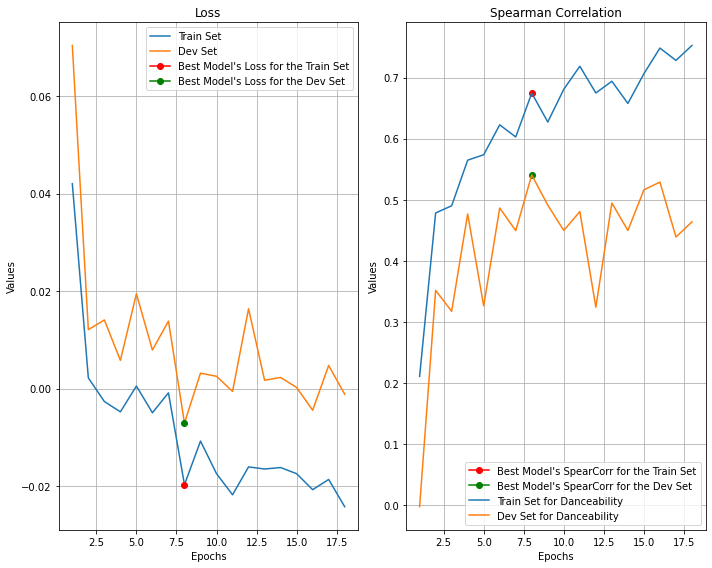

In [ ]:
EarlyCNNNet = CNN(layer_channels, hidden_features, out_features, kernels).to(device)

# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(EarlyCNNNet.parameters(), lr=ETA, weight_decay=weight_decay)

# Start the training process
reg_main(device, EarlyCNNNet, mels_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, Descrs=['Danceability'], net_name='EarlyCNN_multibeatDanc', PATIENCE=PATIENCE, cnn=True)

Spearman Correlation for Danceability: 0.4124050143944033


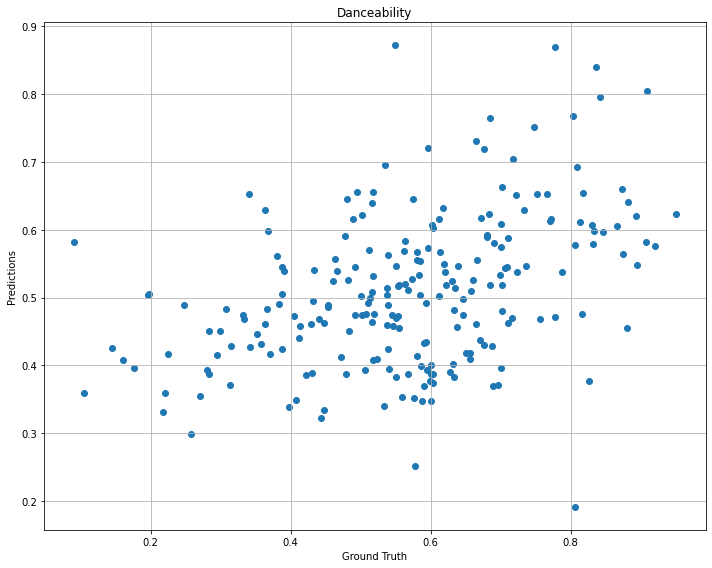

In [ ]:
with open('./best_EarlyCNN_multibeatDanc.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
_ = reg_eval(device, dev_loader, mels_feats, E_model, criterion, cnn=True, titles=['Danceability'])

## Section 4 - Transfer Learning

### Multi Parameters

In [ ]:
# Create map for sentiments
mapping = {
    'valence' : 1,
    'energy' : 2,
    'danceability' : 3,
}

### Redefine Transfer Classification Parameters

In [ ]:
out_features = 10
criterion = nn.CrossEntropyLoss()

### Spearman Correlation

In [ ]:
from fast_soft_sort.pytorch_ops import soft_rank

class SpearmanLoss(nn.Module):

    def __init__(self, regularization="l2", regularization_strength=1.0):
        super(SpearmanLoss, self).__init__()
        self.regularization = regularization
        self.regularization_strength = regularization_strength
        self.criterion = nn.MSELoss()

    def forward(self, pred, target):
      # fast_soft_sort uses 1-based indexing, divide by len to compute percentage of rank
        # print(pred.cpu().reshape(1, -1).shape)
        self.mse = self.criterion(pred, target)
        pred = soft_rank(
            pred.cpu().reshape(1, -1),
            regularization = self.regularization,
            regularization_strength = self.regularization_strength,
        )
        # print(pred.shape)
        pred = pred.cuda()
        return self.corrcoef(pred / pred.shape[-1], target)

    def corrcoef(self, pred, target):
        # np.corrcoef in torch from @mdo
        # https://forum.numer.ai/t/custom-loss-functions-for-xgboost-using-pytorch/960
        pred_n = pred - pred.mean()
        target_n = target - target.mean()
        pred_n = pred_n / pred_n.norm()
        target_n = target_n / target_n.norm()

        return -0.1*(pred_n * target_n).sum() + self.mse


### CNN Classification for Transfer Learning

In [ ]:
data = SpectrogramDataset("data/fma_genre_spectrograms_beat",
                                class_mapping=class_mapping, train=True, read_spec_fn=read_fused_spectrogram)
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/fma_genre_spectrograms_beat/',
                                            class_mapping=class_mapping, train=False, read_spec_fn=read_fused_spectrogram, max_length=data.max_length)

#### Overfit the model

  0%|          | 0/30 [00:00<?, ?it/s]

 [================================--------] ...Epoch 1, Loss: 2.1472
Statistics for the Train Set
	 Epoch: 1 	 loss: 2.1221643706847884
	 Epoch: 1 	 Accuracy Score: 0.2613882863340564
	 Epoch: 1 	 f1 Score: 0.16730526460901426
	 Epoch: 1 	 recall Score: 0.2432807277087433


  3%|▎         | 1/30 [00:04<02:12,  4.56s/it]

Statistics for the Dev Set
	 Epoch: 1 	 loss: 2.1271520503636063
	 Epoch: 1 	 Accuracy Score: 0.2635574837310195
	 Epoch: 1 	 f1 Score: 0.1806380089250839
	 Epoch: 1 	 recall Score: 0.2523422631469324
Test loss decreased (inf --> 2.127152).  Saving model ...
Epoch total time 4.563117504119873
 [================================--------] ...Epoch 2, Loss: 1.8909
Statistics for the Train Set
	 Epoch: 2 	 loss: 2.017216039114985
	 Epoch: 2 	 Accuracy Score: 0.30748373101952275
	 Epoch: 2 	 f1 Score: 0.23315704192518064
	 Epoch: 2 	 recall Score: 0.28316516545981674


  7%|▋         | 2/30 [00:08<02:04,  4.43s/it]

Statistics for the Dev Set
	 Epoch: 2 	 loss: 2.014726801165219
	 Epoch: 2 	 Accuracy Score: 0.2901301518438178
	 Epoch: 2 	 f1 Score: 0.2181150088512779
	 Epoch: 2 	 recall Score: 0.270792572484169
Test loss decreased (2.127152 --> 2.014727).  Saving model ...
Epoch total time 4.3333070278167725
 [================================--------] ...Epoch 3, Loss: 2.0719
Statistics for the Train Set
	 Epoch: 3 	 loss: 1.9447108671582978
	 Epoch: 3 	 Accuracy Score: 0.3286334056399132
	 Epoch: 3 	 f1 Score: 0.26013967548112116
	 Epoch: 3 	 recall Score: 0.291485187070947


 10%|█         | 3/30 [00:13<01:57,  4.35s/it]

Statistics for the Dev Set
	 Epoch: 3 	 loss: 1.9436301013519024
	 Epoch: 3 	 Accuracy Score: 0.32049891540130154
	 Epoch: 3 	 f1 Score: 0.25742504483313067
	 Epoch: 3 	 recall Score: 0.28931363690885153
Test loss decreased (2.014727 --> 1.943630).  Saving model ...
Epoch total time 4.243738412857056
 [================================--------] ...Epoch 4, Loss: 2.0756
Statistics for the Train Set
	 Epoch: 4 	 loss: 1.899971146008064
	 Epoch: 4 	 Accuracy Score: 0.3318872017353579
	 Epoch: 4 	 f1 Score: 0.2797621170742491
	 Epoch: 4 	 recall Score: 0.3020910467646515


 13%|█▎        | 4/30 [00:17<01:51,  4.30s/it]

Statistics for the Dev Set
	 Epoch: 4 	 loss: 1.90047392351874
	 Epoch: 4 	 Accuracy Score: 0.32212581344902386
	 Epoch: 4 	 f1 Score: 0.2658571284132292
	 Epoch: 4 	 recall Score: 0.29518569740194683
Test loss decreased (1.943630 --> 1.900474).  Saving model ...
Epoch total time 4.237442970275879
 [================================--------] ...Epoch 5, Loss: 1.7783
Statistics for the Train Set
	 Epoch: 5 	 loss: 1.8154702351011078
	 Epoch: 5 	 Accuracy Score: 0.37310195227765725
	 Epoch: 5 	 f1 Score: 0.303276029725635
	 Epoch: 5 	 recall Score: 0.3339863141276464


 17%|█▋        | 5/30 [00:21<01:46,  4.28s/it]

Statistics for the Dev Set
	 Epoch: 5 	 loss: 1.8047439188792789
	 Epoch: 5 	 Accuracy Score: 0.3872017353579176
	 Epoch: 5 	 f1 Score: 0.32156526114115336
	 Epoch: 5 	 recall Score: 0.3474897576843567
Test loss decreased (1.900474 --> 1.804744).  Saving model ...
Epoch total time 4.2301294803619385
 [================================--------] ...Epoch 6, Loss: 1.6942
Statistics for the Train Set
	 Epoch: 6 	 loss: 1.7628291064295276
	 Epoch: 6 	 Accuracy Score: 0.38449023861171366
	 Epoch: 6 	 f1 Score: 0.3293339203337632
	 Epoch: 6 	 recall Score: 0.33981040521050976


 20%|██        | 6/30 [00:25<01:42,  4.26s/it]

Statistics for the Dev Set
	 Epoch: 6 	 loss: 1.742459027931608
	 Epoch: 6 	 Accuracy Score: 0.4002169197396963
	 Epoch: 6 	 f1 Score: 0.348600706296743
	 Epoch: 6 	 recall Score: 0.3617597568727599
Test loss decreased (1.804744 --> 1.742459).  Saving model ...
Epoch total time 4.235515832901001
 [================================--------] ...Epoch 7, Loss: 1.6813
Statistics for the Train Set
	 Epoch: 7 	 loss: 1.7302309254120136
	 Epoch: 7 	 Accuracy Score: 0.40401301518438176
	 Epoch: 7 	 f1 Score: 0.3321841173592087
	 Epoch: 7 	 recall Score: 0.3473710717611525


 23%|██▎       | 7/30 [00:30<01:37,  4.26s/it]

Statistics for the Dev Set
	 Epoch: 7 	 loss: 1.7068387701593597
	 Epoch: 7 	 Accuracy Score: 0.41919739696312364
	 Epoch: 7 	 f1 Score: 0.3363475114566069
	 Epoch: 7 	 recall Score: 0.355694285283762
Test loss decreased (1.742459 --> 1.706839).  Saving model ...
Epoch total time 4.247087001800537
 [================================--------] ...Epoch 8, Loss: 1.6158
Statistics for the Train Set
	 Epoch: 8 	 loss: 1.6602173653142205
	 Epoch: 8 	 Accuracy Score: 0.43817787418655096
	 Epoch: 8 	 f1 Score: 0.3717799488622443
	 Epoch: 8 	 recall Score: 0.3864429305750173


 27%|██▋       | 8/30 [00:34<01:33,  4.26s/it]

Statistics for the Dev Set
	 Epoch: 8 	 loss: 1.6526548328070805
	 Epoch: 8 	 Accuracy Score: 0.4436008676789588
	 Epoch: 8 	 f1 Score: 0.37597908848438255
	 Epoch: 8 	 recall Score: 0.3917746144601827
Test loss decreased (1.706839 --> 1.652655).  Saving model ...
Epoch total time 4.255937814712524
 [================================--------] ...Epoch 9, Loss: 1.7294
Statistics for the Train Set
	 Epoch: 9 	 loss: 1.6058360687617599
	 Epoch: 9 	 Accuracy Score: 0.4506507592190889
	 Epoch: 9 	 f1 Score: 0.3859900754242228
	 Epoch: 9 	 recall Score: 0.41582334696183343


 30%|███       | 9/30 [00:38<01:29,  4.26s/it]

Statistics for the Dev Set
	 Epoch: 9 	 loss: 1.6059995108637317
	 Epoch: 9 	 Accuracy Score: 0.4517353579175705
	 Epoch: 9 	 f1 Score: 0.3770545865957503
	 Epoch: 9 	 recall Score: 0.40882136024179117
Test loss decreased (1.652655 --> 1.606000).  Saving model ...
Epoch total time 4.274505615234375
 [================================--------] ...Epoch 10, Loss: 1.6760
Statistics for the Train Set
	 Epoch: 10 	 loss: 1.5476745387603497
	 Epoch: 10 	 Accuracy Score: 0.477765726681128
	 Epoch: 10 	 f1 Score: 0.41253108468947464
	 Epoch: 10 	 recall Score: 0.42459504482997135


 33%|███▎      | 10/30 [00:42<01:25,  4.26s/it]

Statistics for the Dev Set
	 Epoch: 10 	 loss: 1.5739977236451774
	 Epoch: 10 	 Accuracy Score: 0.4582429501084599
	 Epoch: 10 	 f1 Score: 0.4029211829597304
	 Epoch: 10 	 recall Score: 0.41312442192228477
Test loss decreased (1.606000 --> 1.573998).  Saving model ...
Epoch total time 4.24910831451416
 [================================--------] ...Epoch 11, Loss: 1.8115
Statistics for the Train Set
	 Epoch: 11 	 loss: 1.4840329063349758
	 Epoch: 11 	 Accuracy Score: 0.514642082429501
	 Epoch: 11 	 f1 Score: 0.4540643702627435
	 Epoch: 11 	 recall Score: 0.4606617966394725


 37%|███▋      | 11/30 [00:47<01:20,  4.26s/it]

Statistics for the Dev Set
	 Epoch: 11 	 loss: 1.4695087856259839
	 Epoch: 11 	 Accuracy Score: 0.5238611713665944
	 Epoch: 11 	 f1 Score: 0.47066255742813007
	 Epoch: 11 	 recall Score: 0.47430223001185307
Test loss decreased (1.573998 --> 1.469509).  Saving model ...
Epoch total time 4.264206886291504
 [================================--------] ...Epoch 12, Loss: 1.2143
Statistics for the Train Set
	 Epoch: 12 	 loss: 1.3946585100272606
	 Epoch: 12 	 Accuracy Score: 0.5629067245119306
	 Epoch: 12 	 f1 Score: 0.5032144746899827
	 Epoch: 12 	 recall Score: 0.5161109340848001


 40%|████      | 12/30 [00:51<01:16,  4.25s/it]

Statistics for the Dev Set
	 Epoch: 12 	 loss: 1.4011859914352154
	 Epoch: 12 	 Accuracy Score: 0.5455531453362256
	 Epoch: 12 	 f1 Score: 0.492365806698846
	 Epoch: 12 	 recall Score: 0.5025185110104327
Test loss decreased (1.469509 --> 1.401186).  Saving model ...
Epoch total time 4.234154462814331
 [================================--------] ...Epoch 13, Loss: 1.6967
Statistics for the Train Set
	 Epoch: 13 	 loss: 1.3993540385673786
	 Epoch: 13 	 Accuracy Score: 0.527114967462039
	 Epoch: 13 	 f1 Score: 0.4402277106997484
	 Epoch: 13 	 recall Score: 0.4493598678232165


 43%|████▎     | 13/30 [00:55<01:12,  4.25s/it]

Statistics for the Dev Set
	 Epoch: 13 	 loss: 1.3879135847091675
	 Epoch: 13 	 Accuracy Score: 0.5341648590021691
	 Epoch: 13 	 f1 Score: 0.45239606136291777
	 Epoch: 13 	 recall Score: 0.45557431580180874
Test loss decreased (1.401186 --> 1.387914).  Saving model ...
Epoch total time 4.240345239639282
 [================================--------] ...Epoch 14, Loss: 1.4187
Statistics for the Train Set
	 Epoch: 14 	 loss: 1.3281607360675418
	 Epoch: 14 	 Accuracy Score: 0.5770065075921909
	 Epoch: 14 	 f1 Score: 0.5244150717129652
	 Epoch: 14 	 recall Score: 0.5346867028170703


 47%|████▋     | 14/30 [00:59<01:08,  4.26s/it]

Statistics for the Dev Set
	 Epoch: 14 	 loss: 1.3418638562333995
	 Epoch: 14 	 Accuracy Score: 0.5634490238611713
	 Epoch: 14 	 f1 Score: 0.5051071898818074
	 Epoch: 14 	 recall Score: 0.5169203333019815
Test loss decreased (1.387914 --> 1.341864).  Saving model ...
Epoch total time 4.2638020515441895
 [================================--------] ...Epoch 15, Loss: 1.4706
Statistics for the Train Set
	 Epoch: 15 	 loss: 1.2287587872866927
	 Epoch: 15 	 Accuracy Score: 0.6176789587852495
	 Epoch: 15 	 f1 Score: 0.5694230674577516
	 Epoch: 15 	 recall Score: 0.5661890607345279


 50%|█████     | 15/30 [01:04<01:03,  4.26s/it]

Statistics for the Dev Set
	 Epoch: 15 	 loss: 1.235443932229075
	 Epoch: 15 	 Accuracy Score: 0.6144251626898047
	 Epoch: 15 	 f1 Score: 0.5630648865683892
	 Epoch: 15 	 recall Score: 0.5622030148876075
Test loss decreased (1.341864 --> 1.235444).  Saving model ...
Epoch total time 4.278186798095703
 [================================--------] ...Epoch 16, Loss: 1.2693
Statistics for the Train Set
	 Epoch: 16 	 loss: 1.159363465062503
	 Epoch: 16 	 Accuracy Score: 0.6518438177874186
	 Epoch: 16 	 f1 Score: 0.5937510004007404
	 Epoch: 16 	 recall Score: 0.6002091377683223


 53%|█████▎    | 16/30 [01:08<00:59,  4.27s/it]

Statistics for the Dev Set
	 Epoch: 16 	 loss: 1.157868760413137
	 Epoch: 16 	 Accuracy Score: 0.665943600867679
	 Epoch: 16 	 f1 Score: 0.6154984777895331
	 Epoch: 16 	 recall Score: 0.614609461100593
Test loss decreased (1.235444 --> 1.157869).  Saving model ...
Epoch total time 4.270152807235718
 [================================--------] ...Epoch 17, Loss: 1.2486
Statistics for the Train Set
	 Epoch: 17 	 loss: 1.1505868352692703
	 Epoch: 17 	 Accuracy Score: 0.6567245119305857
	 Epoch: 17 	 f1 Score: 0.6091018491610585
	 Epoch: 17 	 recall Score: 0.6179339119375126


 57%|█████▋    | 17/30 [01:12<00:55,  4.27s/it]

Statistics for the Dev Set
	 Epoch: 17 	 loss: 1.1432119227688888
	 Epoch: 17 	 Accuracy Score: 0.6572668112798264
	 Epoch: 17 	 f1 Score: 0.6141865581537511
	 Epoch: 17 	 recall Score: 0.616445319635168
Test loss decreased (1.157869 --> 1.143212).  Saving model ...
Epoch total time 4.28651237487793
 [================================--------] ...Epoch 18, Loss: 1.3939
Statistics for the Train Set
	 Epoch: 18 	 loss: 1.1103331518584285
	 Epoch: 18 	 Accuracy Score: 0.670824295010846
	 Epoch: 18 	 f1 Score: 0.6400712727375784
	 Epoch: 18 	 recall Score: 0.6433082785489082


 60%|██████    | 18/30 [01:17<00:51,  4.29s/it]

Statistics for the Dev Set
	 Epoch: 18 	 loss: 1.1052972828519756
	 Epoch: 18 	 Accuracy Score: 0.6567245119305857
	 Epoch: 18 	 f1 Score: 0.6187100736678031
	 Epoch: 18 	 recall Score: 0.6228202128608423
Test loss decreased (1.143212 --> 1.105297).  Saving model ...
Epoch total time 4.333191394805908
 [================================--------] ...Epoch 19, Loss: 1.0789
Statistics for the Train Set
	 Epoch: 19 	 loss: 1.0465276652369007
	 Epoch: 19 	 Accuracy Score: 0.6898047722342733
	 Epoch: 19 	 f1 Score: 0.649539500735449
	 Epoch: 19 	 recall Score: 0.6507730999612061


 63%|██████▎   | 19/30 [01:21<00:47,  4.28s/it]

Statistics for the Dev Set
	 Epoch: 19 	 loss: 1.0349678808245166
	 Epoch: 19 	 Accuracy Score: 0.6719088937093276
	 Epoch: 19 	 f1 Score: 0.6238481142071512
	 Epoch: 19 	 recall Score: 0.6308052239915182
Test loss decreased (1.105297 --> 1.034968).  Saving model ...
Epoch total time 4.244623184204102
 [================================--------] ...Epoch 20, Loss: 0.9175
Statistics for the Train Set
	 Epoch: 20 	 loss: 0.9887366623714052
	 Epoch: 20 	 Accuracy Score: 0.7125813449023861
	 Epoch: 20 	 f1 Score: 0.674494544887029
	 Epoch: 20 	 recall Score: 0.6721672722464638


 67%|██████▋   | 20/30 [01:25<00:42,  4.27s/it]

Statistics for the Dev Set
	 Epoch: 20 	 loss: 0.9759361856970293
	 Epoch: 20 	 Accuracy Score: 0.7169197396963124
	 Epoch: 20 	 f1 Score: 0.6835329719913561
	 Epoch: 20 	 recall Score: 0.6769301349209822
Test loss decreased (1.034968 --> 0.975936).  Saving model ...
Epoch total time 4.259307622909546
 [================================--------] ...Epoch 21, Loss: 1.1425
Statistics for the Train Set
	 Epoch: 21 	 loss: 0.9316482389795369
	 Epoch: 21 	 Accuracy Score: 0.7255965292841648
	 Epoch: 21 	 f1 Score: 0.6776271213747972
	 Epoch: 21 	 recall Score: 0.660756324858073


 70%|███████   | 21/30 [01:29<00:38,  4.28s/it]

Statistics for the Dev Set
	 Epoch: 21 	 loss: 0.9169438666310804
	 Epoch: 21 	 Accuracy Score: 0.7283080260303688
	 Epoch: 21 	 f1 Score: 0.6889664919228731
	 Epoch: 21 	 recall Score: 0.6724247714076856
Test loss decreased (0.975936 --> 0.916944).  Saving model ...
Epoch total time 4.2790138721466064
 [================================--------] ...Epoch 22, Loss: 0.7697
Statistics for the Train Set
	 Epoch: 22 	 loss: 0.83656180110471
	 Epoch: 22 	 Accuracy Score: 0.7695227765726681
	 Epoch: 22 	 f1 Score: 0.739820882734495
	 Epoch: 22 	 recall Score: 0.7208560448233601


 73%|███████▎  | 22/30 [01:34<00:34,  4.29s/it]

Statistics for the Dev Set
	 Epoch: 22 	 loss: 0.8290953142889614
	 Epoch: 22 	 Accuracy Score: 0.78470715835141
	 Epoch: 22 	 f1 Score: 0.7635319926291937
	 Epoch: 22 	 recall Score: 0.7419633960065111
Test loss decreased (0.916944 --> 0.829095).  Saving model ...
Epoch total time 4.322737693786621
 [================================--------] ...Epoch 23, Loss: 0.9018
Statistics for the Train Set
	 Epoch: 23 	 loss: 0.8206265219326677
	 Epoch: 23 	 Accuracy Score: 0.7776572668112798
	 Epoch: 23 	 f1 Score: 0.750593957560321
	 Epoch: 23 	 recall Score: 0.7293499474264676


 77%|███████▋  | 23/30 [01:38<00:30,  4.29s/it]

Statistics for the Dev Set
	 Epoch: 23 	 loss: 0.7996542361275903
	 Epoch: 23 	 Accuracy Score: 0.7722342733188721
	 Epoch: 23 	 f1 Score: 0.746375911116977
	 Epoch: 23 	 recall Score: 0.7271329100744282
Test loss decreased (0.829095 --> 0.799654).  Saving model ...
Epoch total time 4.294708490371704
 [================================--------] ...Epoch 24, Loss: 0.9438
Statistics for the Train Set
	 Epoch: 24 	 loss: 0.7848178559336169
	 Epoch: 24 	 Accuracy Score: 0.7857917570498916
	 Epoch: 24 	 f1 Score: 0.7649234697624758
	 Epoch: 24 	 recall Score: 0.7526330028551529


 80%|████████  | 24/30 [01:42<00:25,  4.28s/it]

Statistics for the Dev Set
	 Epoch: 24 	 loss: 0.7820718391188259
	 Epoch: 24 	 Accuracy Score: 0.7852494577006508
	 Epoch: 24 	 f1 Score: 0.75809417005274
	 Epoch: 24 	 recall Score: 0.7495296536849937
Test loss decreased (0.799654 --> 0.782072).  Saving model ...
Epoch total time 4.257713317871094
 [================================--------] ...Epoch 25, Loss: 0.8597
Statistics for the Train Set
	 Epoch: 25 	 loss: 0.7715242253295307
	 Epoch: 25 	 Accuracy Score: 0.7960954446854663
	 Epoch: 25 	 f1 Score: 0.7804446254673284
	 Epoch: 25 	 recall Score: 0.7587506359620187


 83%|████████▎ | 25/30 [01:47<00:21,  4.28s/it]

Statistics for the Dev Set
	 Epoch: 25 	 loss: 0.7775022027821377
	 Epoch: 25 	 Accuracy Score: 0.7917570498915402
	 Epoch: 25 	 f1 Score: 0.7731544750845439
	 Epoch: 25 	 recall Score: 0.7508834322446031
Test loss decreased (0.782072 --> 0.777502).  Saving model ...
Epoch total time 4.269747018814087
 [================================--------] ...Epoch 26, Loss: 0.6036
Statistics for the Train Set
	 Epoch: 26 	 loss: 0.7694266212397608
	 Epoch: 26 	 Accuracy Score: 0.8031453362255966
	 Epoch: 26 	 f1 Score: 0.77640239024483
	 Epoch: 26 	 recall Score: 0.7666927832899144


 87%|████████▋ | 26/30 [01:51<00:17,  4.29s/it]

Statistics for the Dev Set
	 Epoch: 26 	 loss: 0.76428088340266
	 Epoch: 26 	 Accuracy Score: 0.7960954446854663
	 Epoch: 26 	 f1 Score: 0.7703742763134935
	 Epoch: 26 	 recall Score: 0.7628957602367439
Test loss decreased (0.777502 --> 0.764281).  Saving model ...
Epoch total time 4.310644865036011
 [================================--------] ...Epoch 27, Loss: 0.6663
Statistics for the Train Set
	 Epoch: 27 	 loss: 0.6171944362336191
	 Epoch: 27 	 Accuracy Score: 0.8443600867678959
	 Epoch: 27 	 f1 Score: 0.8249564029037668
	 Epoch: 27 	 recall Score: 0.8043718849460182


 90%|█████████ | 27/30 [01:55<00:12,  4.29s/it]

Statistics for the Dev Set
	 Epoch: 27 	 loss: 0.6037645946288931
	 Epoch: 27 	 Accuracy Score: 0.8459869848156182
	 Epoch: 27 	 f1 Score: 0.8302747724930946
	 Epoch: 27 	 recall Score: 0.8112857150233536
Test loss decreased (0.764281 --> 0.603765).  Saving model ...
Epoch total time 4.293599367141724
 [================================--------] ...Epoch 28, Loss: 0.6395
Statistics for the Train Set
	 Epoch: 28 	 loss: 0.6397886939089874
	 Epoch: 28 	 Accuracy Score: 0.8573752711496746
	 Epoch: 28 	 f1 Score: 0.838426142848259
	 Epoch: 28 	 recall Score: 0.8296929288592452


 93%|█████████▎| 28/30 [01:59<00:08,  4.29s/it]

Statistics for the Dev Set
	 Epoch: 28 	 loss: 0.6262445614255708
	 Epoch: 28 	 Accuracy Score: 0.846529284164859
	 Epoch: 28 	 f1 Score: 0.8296961418764935
	 Epoch: 28 	 recall Score: 0.8192708513643527
EarlyStopping counter: 1 out of 10
Epoch total time 4.274280071258545
 [================================--------] ...Epoch 29, Loss: 0.5621
Statistics for the Train Set
	 Epoch: 29 	 loss: 0.5687364992396585
	 Epoch: 29 	 Accuracy Score: 0.8649674620390455
	 Epoch: 29 	 f1 Score: 0.8518294611526975
	 Epoch: 29 	 recall Score: 0.8457409676511368


 97%|█████████▋| 29/30 [02:04<00:04,  4.29s/it]

Statistics for the Dev Set
	 Epoch: 29 	 loss: 0.5680616194831913
	 Epoch: 29 	 Accuracy Score: 0.8709327548806941
	 Epoch: 29 	 f1 Score: 0.8577514153948561
	 Epoch: 29 	 recall Score: 0.8493708262690898
Test loss decreased (0.603765 --> 0.568062).  Saving model ...
Epoch total time 4.284576654434204
 [================================--------] ...Epoch 30, Loss: 0.6404
Statistics for the Train Set
	 Epoch: 30 	 loss: 0.5744930731839147
	 Epoch: 30 	 Accuracy Score: 0.8557483731019523
	 Epoch: 30 	 f1 Score: 0.8349744083153132
	 Epoch: 30 	 recall Score: 0.8180370628518141


100%|██████████| 30/30 [02:08<00:00,  4.28s/it]

Statistics for the Dev Set
	 Epoch: 30 	 loss: 0.5532956385406954
	 Epoch: 30 	 Accuracy Score: 0.8725596529284165
	 Epoch: 30 	 f1 Score: 0.8586048252924531
	 Epoch: 30 	 recall Score: 0.8439477828251857
Test loss decreased (0.568062 --> 0.553296).  Saving model ...
Epoch total time 4.270576000213623
Training total time 128.40197014808655


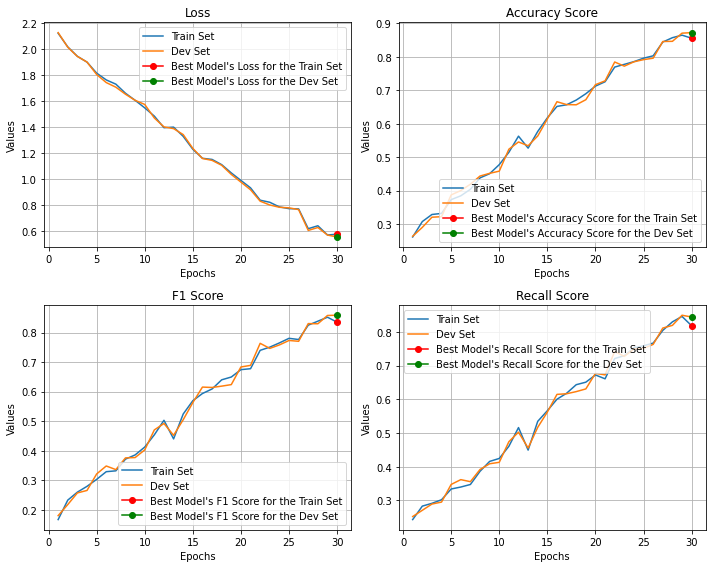

In [ ]:
EarlyCNNNet = CNN(layer_channels, hidden_features, out_features, kernels, dropout=dropout).to(device)

# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(EarlyCNNNet.parameters(), lr=ETA, weight_decay=weight_decay)

clf_main(device, EarlyCNNNet, fused_feats, optimizer, criterion, train_loader, train_loader, 30, PATIENCE=PATIENCE, overfit_batch=True, cnn=True)

#### Normal Training

CNN(
  (conv_layer): Sequential(
    (0): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(4, 16, kernel_size=(4, 4), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

  0%|          | 0/100 [00:00<?, ?it/s]

 [================================--------] ...Epoch 1, Loss: 2.2217
Statistics for the Train Set
	 Epoch: 1 	 loss: 2.023915132571911
	 Epoch: 1 	 Accuracy Score: 0.27169197396963124
	 Epoch: 1 	 f1 Score: 0.16601390066681648
	 Epoch: 1 	 recall Score: 0.20353713237018883


  1%|          | 1/100 [00:03<05:51,  3.55s/it]

Statistics for the Dev Set
	 Epoch: 1 	 loss: 2.08558132648468
	 Epoch: 1 	 Accuracy Score: 0.2386117136659436
	 Epoch: 1 	 f1 Score: 0.1344850044850045
	 Epoch: 1 	 recall Score: 0.1784591560201316
Test loss decreased (inf --> 2.085581).  Saving model ...
Epoch total time 3.5504214763641357
 [================================--------] ...Epoch 2, Loss: 1.9281
Statistics for the Train Set
	 Epoch: 2 	 loss: 1.9474769645723804
	 Epoch: 2 	 Accuracy Score: 0.3063991323210412
	 Epoch: 2 	 f1 Score: 0.21465056947837557
	 Epoch: 2 	 recall Score: 0.23634779122860894


  2%|▏         | 2/100 [00:07<05:46,  3.53s/it]

Statistics for the Dev Set
	 Epoch: 2 	 loss: 2.037624724706014
	 Epoch: 2 	 Accuracy Score: 0.2754880694143167
	 Epoch: 2 	 f1 Score: 0.18905912668422042
	 Epoch: 2 	 recall Score: 0.20991869918699185
Test loss decreased (2.085581 --> 2.037625).  Saving model ...
Epoch total time 3.5172321796417236
 [================================--------] ...Epoch 3, Loss: 2.0974
Statistics for the Train Set
	 Epoch: 3 	 loss: 1.876482182535632
	 Epoch: 3 	 Accuracy Score: 0.3524945770065076
	 Epoch: 3 	 f1 Score: 0.26835096244631407
	 Epoch: 3 	 recall Score: 0.2857958138188117


  3%|▎         | 3/100 [00:10<05:42,  3.53s/it]

Statistics for the Dev Set
	 Epoch: 3 	 loss: 2.0141588926315306
	 Epoch: 3 	 Accuracy Score: 0.2885032537960954
	 Epoch: 3 	 f1 Score: 0.2083972938500495
	 Epoch: 3 	 recall Score: 0.2258301319276929
Test loss decreased (2.037625 --> 2.014159).  Saving model ...
Epoch total time 3.5158941745758057
 [================================--------] ...Epoch 4, Loss: 1.9059
Statistics for the Train Set
	 Epoch: 4 	 loss: 1.8402692038437416
	 Epoch: 4 	 Accuracy Score: 0.3600867678958785
	 Epoch: 4 	 f1 Score: 0.2791526698260172
	 Epoch: 4 	 recall Score: 0.28985828323046514


  4%|▍         | 4/100 [00:14<05:40,  3.55s/it]

Statistics for the Dev Set
	 Epoch: 4 	 loss: 2.0004533926645913
	 Epoch: 4 	 Accuracy Score: 0.2885032537960954
	 Epoch: 4 	 f1 Score: 0.22743010205837616
	 Epoch: 4 	 recall Score: 0.2332236156369661
Test loss decreased (2.014159 --> 2.000453).  Saving model ...
Epoch total time 3.5720582008361816
 [================================--------] ...Epoch 5, Loss: 1.6422
Statistics for the Train Set
	 Epoch: 5 	 loss: 1.764772487097773
	 Epoch: 5 	 Accuracy Score: 0.3920824295010846
	 Epoch: 5 	 f1 Score: 0.34220732534346215
	 Epoch: 5 	 recall Score: 0.34774368738399175


  5%|▌         | 5/100 [00:17<05:37,  3.56s/it]

Statistics for the Dev Set
	 Epoch: 5 	 loss: 1.9793127377827961
	 Epoch: 5 	 Accuracy Score: 0.3123644251626898
	 Epoch: 5 	 f1 Score: 0.25426618854782207
	 Epoch: 5 	 recall Score: 0.2633201515358126
Test loss decreased (2.000453 --> 1.979313).  Saving model ...
Epoch total time 3.5729925632476807
 [================================--------] ...Epoch 6, Loss: 1.7009
Statistics for the Train Set
	 Epoch: 6 	 loss: 1.702593075818029
	 Epoch: 6 	 Accuracy Score: 0.4267895878524946
	 Epoch: 6 	 f1 Score: 0.36020883924754843
	 Epoch: 6 	 recall Score: 0.3756587423871006


  6%|▌         | 6/100 [00:21<05:33,  3.54s/it]

Statistics for the Dev Set
	 Epoch: 6 	 loss: 1.9516992171605427
	 Epoch: 6 	 Accuracy Score: 0.3188720173535792
	 Epoch: 6 	 f1 Score: 0.2507372791834226
	 Epoch: 6 	 recall Score: 0.2663574665243471
Test loss decreased (1.979313 --> 1.951699).  Saving model ...
Epoch total time 3.5177881717681885
 [================================--------] ...Epoch 7, Loss: 2.2025
Statistics for the Train Set
	 Epoch: 7 	 loss: 1.6362175900360634
	 Epoch: 7 	 Accuracy Score: 0.4300433839479393
	 Epoch: 7 	 f1 Score: 0.33288220835824284
	 Epoch: 7 	 recall Score: 0.3573896119461135


  7%|▋         | 7/100 [00:24<05:29,  3.55s/it]

Statistics for the Dev Set
	 Epoch: 7 	 loss: 1.9365583578745524
	 Epoch: 7 	 Accuracy Score: 0.3297180043383948
	 Epoch: 7 	 f1 Score: 0.2620231458247956
	 Epoch: 7 	 recall Score: 0.2742591312552802
Test loss decreased (1.951699 --> 1.936558).  Saving model ...
Epoch total time 3.5487730503082275
 [================================--------] ...Epoch 8, Loss: 1.7919
Statistics for the Train Set
	 Epoch: 8 	 loss: 1.5969021834176162
	 Epoch: 8 	 Accuracy Score: 0.4566160520607375
	 Epoch: 8 	 f1 Score: 0.36818104394485796
	 Epoch: 8 	 recall Score: 0.3791613436994237


  8%|▊         | 8/100 [00:28<05:26,  3.55s/it]

Statistics for the Dev Set
	 Epoch: 8 	 loss: 1.955585741996765
	 Epoch: 8 	 Accuracy Score: 0.31670281995661603
	 Epoch: 8 	 f1 Score: 0.24726756518690912
	 Epoch: 8 	 recall Score: 0.2573425590242021
EarlyStopping counter: 1 out of 10
Epoch total time 3.5544257164001465
 [================================--------] ...Epoch 9, Loss: 1.5049
Statistics for the Train Set
	 Epoch: 9 	 loss: 1.5083518316005837
	 Epoch: 9 	 Accuracy Score: 0.4913232104121475
	 Epoch: 9 	 f1 Score: 0.4157025412634227
	 Epoch: 9 	 recall Score: 0.4281748317110649


  9%|▉         | 9/100 [00:31<05:24,  3.56s/it]

Statistics for the Dev Set
	 Epoch: 9 	 loss: 1.9386558771133422
	 Epoch: 9 	 Accuracy Score: 0.34273318872017355
	 Epoch: 9 	 f1 Score: 0.27824658673160607
	 Epoch: 9 	 recall Score: 0.29356405397483704
EarlyStopping counter: 2 out of 10
Epoch total time 3.5953147411346436
 [================================--------] ...Epoch 10, Loss: 1.0866
Statistics for the Train Set
	 Epoch: 10 	 loss: 1.4792502173062028
	 Epoch: 10 	 Accuracy Score: 0.5021691973969631
	 Epoch: 10 	 f1 Score: 0.4309722810662208
	 Epoch: 10 	 recall Score: 0.44403028098826924


 10%|█         | 10/100 [00:35<05:20,  3.56s/it]

Statistics for the Dev Set
	 Epoch: 10 	 loss: 1.925221037864685
	 Epoch: 10 	 Accuracy Score: 0.34273318872017355
	 Epoch: 10 	 f1 Score: 0.28228370185643453
	 Epoch: 10 	 recall Score: 0.29626425350430485
Test loss decreased (1.936558 --> 1.925221).  Saving model ...
Epoch total time 3.5360894203186035
 [================================--------] ...Epoch 11, Loss: 1.1363
Statistics for the Train Set
	 Epoch: 11 	 loss: 1.4375700046276223
	 Epoch: 11 	 Accuracy Score: 0.5130151843817787
	 Epoch: 11 	 f1 Score: 0.4278696634852094
	 Epoch: 11 	 recall Score: 0.43246905110532496


 11%|█         | 11/100 [00:39<05:15,  3.55s/it]

Statistics for the Dev Set
	 Epoch: 11 	 loss: 1.9208987633387247
	 Epoch: 11 	 Accuracy Score: 0.31453362255965295
	 Epoch: 11 	 f1 Score: 0.23800212837985096
	 Epoch: 11 	 recall Score: 0.2525461088618983
Test loss decreased (1.925221 --> 1.920899).  Saving model ...
Epoch total time 3.5190281867980957
 [================================--------] ...Epoch 12, Loss: 1.2896
Statistics for the Train Set
	 Epoch: 12 	 loss: 1.350884277245094
	 Epoch: 12 	 Accuracy Score: 0.5650759219088937
	 Epoch: 12 	 f1 Score: 0.4859502959633312
	 Epoch: 12 	 recall Score: 0.48263028078996484


 12%|█▏        | 12/100 [00:42<05:14,  3.58s/it]

Statistics for the Dev Set
	 Epoch: 12 	 loss: 1.902977418899536
	 Epoch: 12 	 Accuracy Score: 0.34490238611713664
	 Epoch: 12 	 f1 Score: 0.2767272964106612
	 Epoch: 12 	 recall Score: 0.27884086388579327
Test loss decreased (1.920899 --> 1.902977).  Saving model ...
Epoch total time 3.643705368041992
 [================================--------] ...Epoch 13, Loss: 1.2235
Statistics for the Train Set
	 Epoch: 13 	 loss: 1.269921110621814
	 Epoch: 13 	 Accuracy Score: 0.5845986984815619
	 Epoch: 13 	 f1 Score: 0.5141352460249154
	 Epoch: 13 	 recall Score: 0.5155382239839409


 13%|█▎        | 13/100 [00:46<05:11,  3.58s/it]

Statistics for the Dev Set
	 Epoch: 13 	 loss: 1.8976710478464762
	 Epoch: 13 	 Accuracy Score: 0.3362255965292842
	 Epoch: 13 	 f1 Score: 0.26165153779195577
	 Epoch: 13 	 recall Score: 0.27844443817486175
Test loss decreased (1.902977 --> 1.897671).  Saving model ...
Epoch total time 3.5698013305664062
 [================================--------] ...Epoch 14, Loss: 1.1830
Statistics for the Train Set
	 Epoch: 14 	 loss: 1.2683610309814584
	 Epoch: 14 	 Accuracy Score: 0.584056399132321
	 Epoch: 14 	 f1 Score: 0.49192327258823865
	 Epoch: 14 	 recall Score: 0.4966936150409988


 14%|█▍        | 14/100 [00:49<05:06,  3.56s/it]

Statistics for the Dev Set
	 Epoch: 14 	 loss: 1.9007779677708945
	 Epoch: 14 	 Accuracy Score: 0.3470715835140998
	 Epoch: 14 	 f1 Score: 0.26217392004488776
	 Epoch: 14 	 recall Score: 0.2808901866924973
EarlyStopping counter: 1 out of 10
Epoch total time 3.537273645401001
 [================================--------] ...Epoch 15, Loss: 1.4957
Statistics for the Train Set
	 Epoch: 15 	 loss: 1.1730904959399124
	 Epoch: 15 	 Accuracy Score: 0.6258134490238612
	 Epoch: 15 	 f1 Score: 0.5559140840745475
	 Epoch: 15 	 recall Score: 0.5518360439947989


 15%|█▌        | 15/100 [00:53<05:01,  3.55s/it]

Statistics for the Dev Set
	 Epoch: 15 	 loss: 1.8989994208017984
	 Epoch: 15 	 Accuracy Score: 0.3644251626898048
	 Epoch: 15 	 f1 Score: 0.2928112667419277
	 Epoch: 15 	 recall Score: 0.2971831078634673
EarlyStopping counter: 2 out of 10
Epoch total time 3.523798704147339
 [================================--------] ...Epoch 16, Loss: 1.2089
Statistics for the Train Set
	 Epoch: 16 	 loss: 1.1317693334201286
	 Epoch: 16 	 Accuracy Score: 0.661062906724512
	 Epoch: 16 	 f1 Score: 0.5964950843939396
	 Epoch: 16 	 recall Score: 0.595239632064558


 16%|█▌        | 16/100 [00:56<04:58,  3.56s/it]

Statistics for the Dev Set
	 Epoch: 16 	 loss: 1.9048654953638713
	 Epoch: 16 	 Accuracy Score: 0.3665943600867679
	 Epoch: 16 	 f1 Score: 0.2912068167298817
	 Epoch: 16 	 recall Score: 0.3087296571635467
EarlyStopping counter: 3 out of 10
Epoch total time 3.5668797492980957
 [================================--------] ...Epoch 17, Loss: 1.3724
Statistics for the Train Set
	 Epoch: 17 	 loss: 1.049574176812994
	 Epoch: 17 	 Accuracy Score: 0.6735357917570499
	 Epoch: 17 	 f1 Score: 0.6186136167077557
	 Epoch: 17 	 recall Score: 0.5979522525945895


 17%|█▋        | 17/100 [01:00<04:55,  3.56s/it]

Statistics for the Dev Set
	 Epoch: 17 	 loss: 1.959707005818685
	 Epoch: 17 	 Accuracy Score: 0.3232104121475054
	 Epoch: 17 	 f1 Score: 0.25547334281397177
	 Epoch: 17 	 recall Score: 0.2614564397234487
EarlyStopping counter: 4 out of 10
Epoch total time 3.5501389503479004
 [================================--------] ...Epoch 18, Loss: 0.9632
Statistics for the Train Set
	 Epoch: 18 	 loss: 1.0232881235665288
	 Epoch: 18 	 Accuracy Score: 0.6751626898047722
	 Epoch: 18 	 f1 Score: 0.6023194546815636
	 Epoch: 18 	 recall Score: 0.5953222245132113


 18%|█▊        | 18/100 [01:03<04:50,  3.54s/it]

Statistics for the Dev Set
	 Epoch: 18 	 loss: 2.0260175307591757
	 Epoch: 18 	 Accuracy Score: 0.3492407809110629
	 Epoch: 18 	 f1 Score: 0.274110195102682
	 Epoch: 18 	 recall Score: 0.2799762226078016
EarlyStopping counter: 5 out of 10
Epoch total time 3.5113816261291504
 [================================--------] ...Epoch 19, Loss: 1.0783
Statistics for the Train Set
	 Epoch: 19 	 loss: 0.9427527004274828
	 Epoch: 19 	 Accuracy Score: 0.732646420824295
	 Epoch: 19 	 f1 Score: 0.6966641081313347
	 Epoch: 19 	 recall Score: 0.6762826722355615


 19%|█▉        | 19/100 [01:07<04:46,  3.53s/it]

Statistics for the Dev Set
	 Epoch: 19 	 loss: 1.9330827474594117
	 Epoch: 19 	 Accuracy Score: 0.3362255965292842
	 Epoch: 19 	 f1 Score: 0.2667707203339689
	 Epoch: 19 	 recall Score: 0.27605762373413206
EarlyStopping counter: 6 out of 10
Epoch total time 3.5146677494049072
 [================================--------] ...Epoch 20, Loss: 0.7350
Statistics for the Train Set
	 Epoch: 20 	 loss: 0.8931926447769691
	 Epoch: 20 	 Accuracy Score: 0.7407809110629068
	 Epoch: 20 	 f1 Score: 0.707905601747728
	 Epoch: 20 	 recall Score: 0.6827426989321873


 20%|██        | 20/100 [01:10<04:42,  3.53s/it]

Statistics for the Dev Set
	 Epoch: 20 	 loss: 1.9994484901428222
	 Epoch: 20 	 Accuracy Score: 0.34490238611713664
	 Epoch: 20 	 f1 Score: 0.2870062354053236
	 Epoch: 20 	 recall Score: 0.2875583423850433
EarlyStopping counter: 7 out of 10
Epoch total time 3.5235817432403564
 [================================--------] ...Epoch 21, Loss: 0.7811
Statistics for the Train Set
	 Epoch: 21 	 loss: 0.8755109258766832
	 Epoch: 21 	 Accuracy Score: 0.7700650759219089
	 Epoch: 21 	 f1 Score: 0.7214686403588934
	 Epoch: 21 	 recall Score: 0.7161440142267136


 21%|██        | 21/100 [01:14<04:39,  3.53s/it]

Statistics for the Dev Set
	 Epoch: 21 	 loss: 1.984532364209493
	 Epoch: 21 	 Accuracy Score: 0.34273318872017355
	 Epoch: 21 	 f1 Score: 0.28398207466083975
	 Epoch: 21 	 recall Score: 0.3035602295294208
EarlyStopping counter: 8 out of 10
Epoch total time 3.5358588695526123
 [================================--------] ...Epoch 22, Loss: 0.7907
Statistics for the Train Set
	 Epoch: 22 	 loss: 0.7928644706462992
	 Epoch: 22 	 Accuracy Score: 0.7781995661605207
	 Epoch: 22 	 f1 Score: 0.7442850255099693
	 Epoch: 22 	 recall Score: 0.7289298750334351


 22%|██▏       | 22/100 [01:18<04:35,  3.53s/it]

Statistics for the Dev Set
	 Epoch: 22 	 loss: 1.991722536087036
	 Epoch: 22 	 Accuracy Score: 0.3579175704989154
	 Epoch: 22 	 f1 Score: 0.3102494419588295
	 Epoch: 22 	 recall Score: 0.3095068032808726
EarlyStopping counter: 9 out of 10
Epoch total time 3.5107595920562744
 [================================--------] ...Epoch 23, Loss: 0.6177
Statistics for the Train Set
	 Epoch: 23 	 loss: 0.7676058853494709
	 Epoch: 23 	 Accuracy Score: 0.8036876355748374
	 Epoch: 23 	 f1 Score: 0.7723417174528722
	 Epoch: 23 	 recall Score: 0.7640493196675554


 22%|██▏       | 22/100 [01:21<04:49,  3.71s/it]

Statistics for the Dev Set
	 Epoch: 23 	 loss: 1.9829201459884644
	 Epoch: 23 	 Accuracy Score: 0.33405639913232105
	 Epoch: 23 	 f1 Score: 0.28557459360549026
	 Epoch: 23 	 recall Score: 0.2981865388925723
EarlyStopping counter: 10 out of 10
Training total time 77.98786520957947


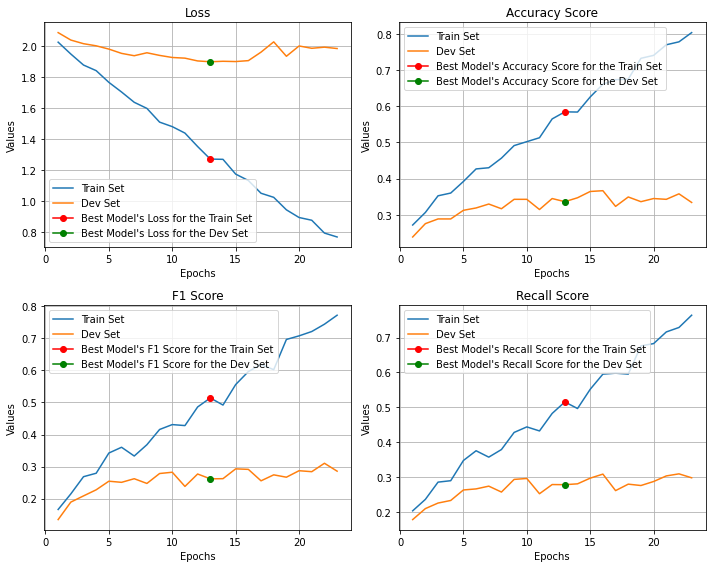

In [ ]:
EarlyCNNNet = CNN(layer_channels, hidden_features, out_features, kernels, dropout=dropout).to(device)
print(EarlyCNNNet)
# Make instance of our optimizer, with L2-Reguralization
# optimizer = optim.SGD(EarlyCNNNet.parameters(), lr=ETA, weight_decay=weight_decay)
optimizer = optim.Adam(EarlyCNNNet.parameters(), lr=ETA, weight_decay=weight_decay)

# Start the training process
clf_main(device, EarlyCNNNet, fused_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, net_name='EarlyCNN_beatFUSED', PATIENCE=PATIENCE, cnn=True)

In [ ]:
with open('./best_EarlyCNN_beatFUSED.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
test_loss, y_test_gold, y_test_pred = clf_eval(device, test_loader, fused_feats, E_model, criterion, cnn=True)

print(classification_report(y_test_gold, y_test_pred))

              precision    recall  f1-score   support

           0       0.25      0.12      0.17        40
           1       0.42      0.33      0.37        40
           2       0.30      0.57      0.39        80
           3       0.33      0.46      0.38        80
           4       0.29      0.28      0.28        40
           5       0.19      0.10      0.13        40
           6       0.44      0.49      0.46        78
           7       0.09      0.03      0.04        40
           8       0.33      0.30      0.31       103
           9       0.50      0.06      0.11        34

    accuracy                           0.33       575
   macro avg       0.31      0.27      0.26       575
weighted avg       0.32      0.33      0.30       575



### Redefine Transfer Regression Parameters

In [ ]:
out_features = 1
regularization_strength = 1e-2
criterion = SpearmanLoss(regularization_strength=regularization_strength)

### Transfer Learning for Regression

#### All net parameters trainable

In [ ]:
data = SpectrogramDataset("data/multitask_dataset_beat/",
                              class_mapping=class_mapping, train=True, read_spec_fn=read_mel_spectrogram, emotion=mapping['valence'])
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/multitask_dataset_beat/',
                                          class_mapping=class_mapping, train=False, read_spec_fn=read_mel_spectrogram, emotion=mapping['valence'])

##### Overfit the model

CNN(
  (conv_layer): Sequential(
    (0): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(4, 16, kernel_size=(4, 4), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

  0%|          | 0/30 [00:00<?, ?it/s]

 [=================================-------] ...Epoch 1, Loss: -0.0803
Statistics for the Train Set
	 Epoch: 1 	 loss: 0.0597677323589028
	 Epoch: 1 	 Spear Corr 1: 0.4814725675602293


  3%|▎         | 1/30 [00:02<01:26,  2.97s/it]

Statistics for the Dev Set
	 Epoch: 1 	 loss: 0.0646535637243716
	 Epoch: 1 	 Spear Corr 1: 0.4814725675602293
Dev loss decreased (0.064654 --> 0.064654).  Saving model ...
Epoch total time 2.967029333114624
 [=================================-------] ...Epoch 2, Loss: 0.1783
Statistics for the Train Set
	 Epoch: 2 	 loss: 0.009429120113511564
	 Epoch: 2 	 Spear Corr 1: 0.6433182816761744


  7%|▋         | 2/30 [00:04<01:00,  2.15s/it]

Statistics for the Dev Set
	 Epoch: 2 	 loss: 0.008270025155244541
	 Epoch: 2 	 Spear Corr 1: 0.6433262109936912
Dev loss decreased (0.064654 --> 0.008270).  Saving model ...
Epoch total time 1.5820233821868896
 [=================================-------] ...Epoch 3, Loss: 0.1632
Statistics for the Train Set
	 Epoch: 3 	 loss: 0.0004929785223845645
	 Epoch: 3 	 Spear Corr 1: 0.7400320348593876


 10%|█         | 3/30 [00:06<00:51,  1.90s/it]

Statistics for the Dev Set
	 Epoch: 3 	 loss: 0.00387538519407085
	 Epoch: 3 	 Spear Corr 1: 0.7400320348593876
Dev loss decreased (0.008270 --> 0.003875).  Saving model ...
Epoch total time 1.5920500755310059
 [=================================-------] ...Epoch 4, Loss: -0.0157
Statistics for the Train Set
	 Epoch: 4 	 loss: -0.006046877256838175
	 Epoch: 4 	 Spear Corr 1: 0.8112179592886348


 13%|█▎        | 4/30 [00:07<00:45,  1.77s/it]

Statistics for the Dev Set
	 Epoch: 4 	 loss: -0.006631626777926352
	 Epoch: 4 	 Spear Corr 1: 0.8112179592886348
Dev loss decreased (0.003875 --> -0.006632).  Saving model ...
Epoch total time 1.5698485374450684
 [=================================-------] ...Epoch 5, Loss: -0.0233
Statistics for the Train Set
	 Epoch: 5 	 loss: -0.008598122676206433
	 Epoch: 5 	 Spear Corr 1: 0.883567223138938


 17%|█▋        | 5/30 [00:09<00:42,  1.71s/it]

Statistics for the Dev Set
	 Epoch: 5 	 loss: -0.013227205748691427
	 Epoch: 5 	 Spear Corr 1: 0.883567223138938
Dev loss decreased (-0.006632 --> -0.013227).  Saving model ...
Epoch total time 1.5913031101226807
 [=================================-------] ...Epoch 6, Loss: 0.0085
Statistics for the Train Set
	 Epoch: 6 	 loss: -0.005329064290886334
	 Epoch: 6 	 Spear Corr 1: 0.8823357263867498


 20%|██        | 6/30 [00:10<00:40,  1.67s/it]

Statistics for the Dev Set
	 Epoch: 6 	 loss: -0.01097524007450186
	 Epoch: 6 	 Spear Corr 1: 0.8823317824419871
EarlyStopping counter: 1 out of 10
Epoch total time 1.6040370464324951
 [=================================-------] ...Epoch 7, Loss: 0.1678
Statistics for the Train Set
	 Epoch: 7 	 loss: -0.020088795014605875
	 Epoch: 7 	 Spear Corr 1: 0.9295794121406553


 23%|██▎       | 7/30 [00:12<00:37,  1.65s/it]

Statistics for the Dev Set
	 Epoch: 7 	 loss: -0.01956588487768714
	 Epoch: 7 	 Spear Corr 1: 0.9295794121406553
Dev loss decreased (-0.013227 --> -0.019566).  Saving model ...
Epoch total time 1.5935359001159668
 [=================================-------] ...Epoch 8, Loss: -0.0253
Statistics for the Train Set
	 Epoch: 8 	 loss: -0.02558555412208486
	 Epoch: 8 	 Spear Corr 1: 0.9465858925266618


 27%|██▋       | 8/30 [00:14<00:36,  1.66s/it]

Statistics for the Dev Set
	 Epoch: 8 	 loss: -0.024563496847644254
	 Epoch: 8 	 Spear Corr 1: 0.9465858925266618
Dev loss decreased (-0.019566 --> -0.024563).  Saving model ...
Epoch total time 1.701030969619751
 [=================================-------] ...Epoch 9, Loss: -0.0268
Statistics for the Train Set
	 Epoch: 9 	 loss: -0.023386633860053005
	 Epoch: 9 	 Spear Corr 1: 0.9591817418289204


 30%|███       | 9/30 [00:15<00:34,  1.64s/it]

Statistics for the Dev Set
	 Epoch: 9 	 loss: -0.024195596514913195
	 Epoch: 9 	 Spear Corr 1: 0.9591817418289204
EarlyStopping counter: 1 out of 10
Epoch total time 1.5787830352783203
 [=================================-------] ...Epoch 10, Loss: 0.1125
Statistics for the Train Set
	 Epoch: 10 	 loss: -0.020784868947941286
	 Epoch: 10 	 Spear Corr 1: 0.9337380367538972


 33%|███▎      | 10/30 [00:17<00:32,  1.63s/it]

Statistics for the Dev Set
	 Epoch: 10 	 loss: -0.021286781398241778
	 Epoch: 10 	 Spear Corr 1: 0.933738318189719
EarlyStopping counter: 2 out of 10
Epoch total time 1.6192781925201416
 [=================================-------] ...Epoch 11, Loss: -0.0015
Statistics for the Train Set
	 Epoch: 11 	 loss: -0.024812509537690534
	 Epoch: 11 	 Spear Corr 1: 0.9600942596200186


 37%|███▋      | 11/30 [00:19<00:30,  1.62s/it]

Statistics for the Dev Set
	 Epoch: 11 	 loss: -0.023693567656440553
	 Epoch: 11 	 Spear Corr 1: 0.9600942596200186
EarlyStopping counter: 3 out of 10
Epoch total time 1.5898888111114502
 [=================================-------] ...Epoch 12, Loss: -0.0051
Statistics for the Train Set
	 Epoch: 12 	 loss: -0.025025433723609467
	 Epoch: 12 	 Spear Corr 1: 0.9444915501448313


 40%|████      | 12/30 [00:20<00:28,  1.61s/it]

Statistics for the Dev Set
	 Epoch: 12 	 loss: -0.02587918408494417
	 Epoch: 12 	 Spear Corr 1: 0.9444915501448313
Dev loss decreased (-0.024563 --> -0.025879).  Saving model ...
Epoch total time 1.588533639907837
 [=================================-------] ...Epoch 13, Loss: -0.0627
Statistics for the Train Set
	 Epoch: 13 	 loss: -0.020347593365002213
	 Epoch: 13 	 Spear Corr 1: 0.9432553720296369


 43%|████▎     | 13/30 [00:22<00:27,  1.61s/it]

Statistics for the Dev Set
	 Epoch: 13 	 loss: -0.01629406785797214
	 Epoch: 13 	 Spear Corr 1: 0.9432553720296369
EarlyStopping counter: 1 out of 10
Epoch total time 1.595186710357666
 [=================================-------] ...Epoch 14, Loss: 0.1118
Statistics for the Train Set
	 Epoch: 14 	 loss: -0.026595843645117762
	 Epoch: 14 	 Spear Corr 1: 0.9655448741382079


 47%|████▋     | 14/30 [00:23<00:25,  1.61s/it]

Statistics for the Dev Set
	 Epoch: 14 	 loss: -0.02728923862254468
	 Epoch: 14 	 Spear Corr 1: 0.9655448741382079
Dev loss decreased (-0.025879 --> -0.027289).  Saving model ...
Epoch total time 1.5999765396118164
 [=================================-------] ...Epoch 15, Loss: -0.0247
Statistics for the Train Set
	 Epoch: 15 	 loss: -0.02460561784741153
	 Epoch: 15 	 Spear Corr 1: 0.9714402098563951


 50%|█████     | 15/30 [00:25<00:24,  1.60s/it]

Statistics for the Dev Set
	 Epoch: 15 	 loss: -0.02743032720728845
	 Epoch: 15 	 Spear Corr 1: 0.9714402098563951
Dev loss decreased (-0.027289 --> -0.027430).  Saving model ...
Epoch total time 1.5893688201904297
 [=================================-------] ...Epoch 16, Loss: -0.0885
Statistics for the Train Set
	 Epoch: 16 	 loss: -0.0258060296558667
	 Epoch: 16 	 Spear Corr 1: 0.955147318333314


 53%|█████▎    | 16/30 [00:27<00:22,  1.61s/it]

Statistics for the Dev Set
	 Epoch: 16 	 loss: -0.022902533398713516
	 Epoch: 16 	 Spear Corr 1: 0.955147318333314
EarlyStopping counter: 1 out of 10
Epoch total time 1.621156930923462
 [=================================-------] ...Epoch 17, Loss: 0.0159
Statistics for the Train Set
	 Epoch: 17 	 loss: -0.02394128907654991
	 Epoch: 17 	 Spear Corr 1: 0.9599626760343501


 57%|█████▋    | 17/30 [00:28<00:20,  1.61s/it]

Statistics for the Dev Set
	 Epoch: 17 	 loss: -0.024815794183270352
	 Epoch: 17 	 Spear Corr 1: 0.9599644408667755
EarlyStopping counter: 2 out of 10
Epoch total time 1.6085562705993652
 [=================================-------] ...Epoch 18, Loss: -0.0370
Statistics for the Train Set
	 Epoch: 18 	 loss: -0.02386320234875043
	 Epoch: 18 	 Spear Corr 1: 0.9624604110521519


 60%|██████    | 18/30 [00:30<00:19,  1.61s/it]

Statistics for the Dev Set
	 Epoch: 18 	 loss: -0.027088040745067175
	 Epoch: 18 	 Spear Corr 1: 0.9624604110521519
EarlyStopping counter: 3 out of 10
Epoch total time 1.6089990139007568
 [=================================-------] ...Epoch 19, Loss: -0.0178
Statistics for the Train Set
	 Epoch: 19 	 loss: -0.025659866276424255
	 Epoch: 19 	 Spear Corr 1: 0.9544888949834787


 63%|██████▎   | 19/30 [00:31<00:17,  1.61s/it]

Statistics for the Dev Set
	 Epoch: 19 	 loss: -0.02748098714519441
	 Epoch: 19 	 Spear Corr 1: 0.9544888949834787
Dev loss decreased (-0.027430 --> -0.027481).  Saving model ...
Epoch total time 1.5998258590698242
 [=================================-------] ...Epoch 20, Loss: 0.0253
Statistics for the Train Set
	 Epoch: 20 	 loss: -0.026913404907549367
	 Epoch: 20 	 Spear Corr 1: 0.9672830766508367


 67%|██████▋   | 20/30 [00:33<00:16,  1.60s/it]

Statistics for the Dev Set
	 Epoch: 20 	 loss: -0.02666693174296808
	 Epoch: 20 	 Spear Corr 1: 0.9672833913680216
EarlyStopping counter: 1 out of 10
Epoch total time 1.5973339080810547
 [=================================-------] ...Epoch 21, Loss: 0.1079
Statistics for the Train Set
	 Epoch: 21 	 loss: -0.025856916143638806
	 Epoch: 21 	 Spear Corr 1: 0.959095165612898


 70%|███████   | 21/30 [00:35<00:14,  1.60s/it]

Statistics for the Dev Set
	 Epoch: 21 	 loss: -0.017473218651313356
	 Epoch: 21 	 Spear Corr 1: 0.959095165612898
EarlyStopping counter: 2 out of 10
Epoch total time 1.601100206375122
 [=================================-------] ...Epoch 22, Loss: -0.0962
Statistics for the Train Set
	 Epoch: 22 	 loss: -0.020412246895188405
	 Epoch: 22 	 Spear Corr 1: 0.9846169873081391


 73%|███████▎  | 22/30 [00:36<00:13,  1.64s/it]

Statistics for the Dev Set
	 Epoch: 22 	 loss: -0.029057172310307702
	 Epoch: 22 	 Spear Corr 1: 0.9846181638630893
Dev loss decreased (-0.027481 --> -0.029057).  Saving model ...
Epoch total time 1.7334694862365723
 [=================================-------] ...Epoch 23, Loss: -0.0156
Statistics for the Train Set
	 Epoch: 23 	 loss: -0.02741684947641437
	 Epoch: 23 	 Spear Corr 1: 0.9756236415507713


 77%|███████▋  | 23/30 [00:38<00:11,  1.63s/it]

Statistics for the Dev Set
	 Epoch: 23 	 loss: -0.028707578594415153
	 Epoch: 23 	 Spear Corr 1: 0.9756236415507713
EarlyStopping counter: 1 out of 10
Epoch total time 1.6138458251953125
 [=================================-------] ...Epoch 24, Loss: -0.0255
Statistics for the Train Set
	 Epoch: 24 	 loss: -0.02637908369034866
	 Epoch: 24 	 Spear Corr 1: 0.9550361421761135


 80%|████████  | 24/30 [00:39<00:09,  1.62s/it]

Statistics for the Dev Set
	 Epoch: 24 	 loss: -0.026372551052984798
	 Epoch: 24 	 Spear Corr 1: 0.9550361421761135
EarlyStopping counter: 2 out of 10
Epoch total time 1.5926861763000488
 [=================================-------] ...Epoch 25, Loss: 0.2683
Statistics for the Train Set
	 Epoch: 25 	 loss: -0.023013296994791342
	 Epoch: 25 	 Spear Corr 1: 0.9500395867271406


 83%|████████▎ | 25/30 [00:41<00:08,  1.65s/it]

Statistics for the Dev Set
	 Epoch: 25 	 loss: -0.021411034037881353
	 Epoch: 25 	 Spear Corr 1: 0.9500395867271406
EarlyStopping counter: 3 out of 10
Epoch total time 1.6999523639678955
 [=================================-------] ...Epoch 26, Loss: 0.1369
Statistics for the Train Set
	 Epoch: 26 	 loss: -0.021124738386635634
	 Epoch: 26 	 Spear Corr 1: 0.9353728929996636


 87%|████████▋ | 26/30 [00:43<00:06,  1.64s/it]

Statistics for the Dev Set
	 Epoch: 26 	 loss: -0.02286534976208964
	 Epoch: 26 	 Spear Corr 1: 0.9353728929996636
EarlyStopping counter: 4 out of 10
Epoch total time 1.611607313156128
 [=================================-------] ...Epoch 27, Loss: -0.0543
Statistics for the Train Set
	 Epoch: 27 	 loss: -0.026855921360154366
	 Epoch: 27 	 Spear Corr 1: 0.966419021323851


 90%|█████████ | 27/30 [00:44<00:04,  1.63s/it]

Statistics for the Dev Set
	 Epoch: 27 	 loss: -0.021588503179785702
	 Epoch: 27 	 Spear Corr 1: 0.966419021323851
EarlyStopping counter: 5 out of 10
Epoch total time 1.6123981475830078
 [=================================-------] ...Epoch 28, Loss: 0.0457
Statistics for the Train Set
	 Epoch: 28 	 loss: -0.027653909138749586
	 Epoch: 28 	 Spear Corr 1: 0.9626597211178439


 93%|█████████▎| 28/30 [00:46<00:03,  1.62s/it]

Statistics for the Dev Set
	 Epoch: 28 	 loss: -0.02618621125607522
	 Epoch: 28 	 Spear Corr 1: 0.9626597211178439
EarlyStopping counter: 6 out of 10
Epoch total time 1.5987095832824707
 [=================================-------] ...Epoch 29, Loss: -0.0241
Statistics for the Train Set
	 Epoch: 29 	 loss: -0.02611183365838528
	 Epoch: 29 	 Spear Corr 1: 0.971531848572943


 97%|█████████▋| 29/30 [00:48<00:01,  1.62s/it]

Statistics for the Dev Set
	 Epoch: 29 	 loss: -0.024726237792317137
	 Epoch: 29 	 Spear Corr 1: 0.971531848572943
EarlyStopping counter: 7 out of 10
Epoch total time 1.6035683155059814
 [=================================-------] ...Epoch 30, Loss: -0.0719
Statistics for the Train Set
	 Epoch: 30 	 loss: -0.02728274958357543
	 Epoch: 30 	 Spear Corr 1: 0.9670225442997402


100%|██████████| 30/30 [00:49<00:00,  1.66s/it]

Statistics for the Dev Set
	 Epoch: 30 	 loss: -0.026063838430017593
	 Epoch: 30 	 Spear Corr 1: 0.9670225442997402
EarlyStopping counter: 8 out of 10
Epoch total time 1.6004610061645508
Training total time 49.665544509887695


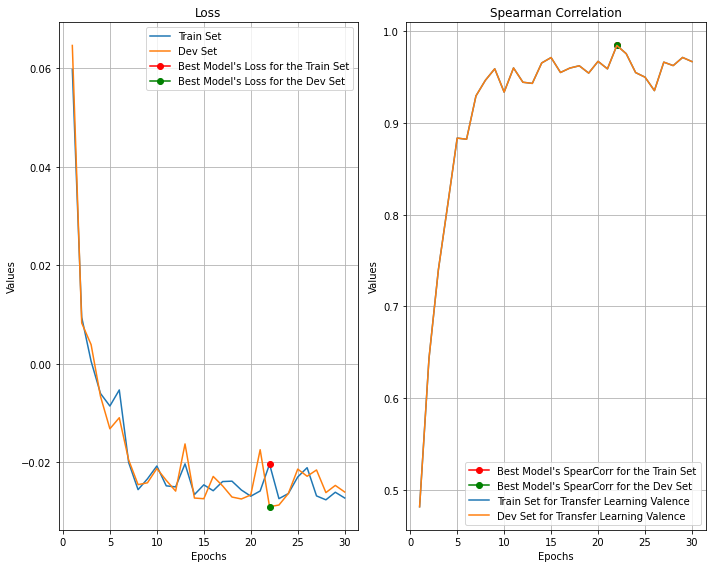

In [ ]:
with open('./best_EarlyCNN_beatFUSED.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

# Change the last Layer
num_feats = E_model.fc.fc2.in_features
# E_model.fc.fc2 = nn.Linear(num_feats, out_features)
E_model.fc = FullyConnectedLayer(hidden_features, hidden_features, out_features)
E_model = E_model.to(device)
print(E_model)
#Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(E_model.parameters(), lr=ETA, weight_decay=weight_decay)

# training
reg_main(device, E_model, mels_feats, optimizer, criterion, train_loader, train_loader, 30, Descrs = ['Transfer Learning Valence'], PATIENCE=PATIENCE, overfit_batch=True, cnn=True)

##### Normal Training

CNN(
  (conv_layer): Sequential(
    (0): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(4, 16, kernel_size=(4, 4), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

  0%|          | 0/30 [00:00<?, ?it/s]

 [=================================-------] ...Epoch 1, Loss: -0.0714

  3%|▎         | 1/30 [00:01<00:38,  1.33s/it]


Statistics for the Train Set
	 Epoch: 1 	 loss: 0.07047761113623381
	 Epoch: 1 	 Spear Corr 1: 0.38236790557733824
Statistics for the Dev Set
	 Epoch: 1 	 loss: 0.092458247266794
	 Epoch: 1 	 Spear Corr 1: 0.1105789224487402
Dev loss decreased (0.092458 --> 0.092458).  Saving model ...
Epoch total time 1.3302671909332275
 [=================================-------] ...Epoch 2, Loss: 0.1718

  7%|▋         | 2/30 [00:02<00:37,  1.33s/it]


Statistics for the Train Set
	 Epoch: 2 	 loss: 0.02042441012837251
	 Epoch: 2 	 Spear Corr 1: 0.5459139717119537
Statistics for the Dev Set
	 Epoch: 2 	 loss: 0.0532904917522957
	 Epoch: 2 	 Spear Corr 1: 0.20000298956218587
Dev loss decreased (0.092458 --> 0.053290).  Saving model ...
Epoch total time 1.3266088962554932
 [=================================-------] ...Epoch 3, Loss: 0.1571

 10%|█         | 3/30 [00:03<00:35,  1.32s/it]


Statistics for the Train Set
	 Epoch: 3 	 loss: 0.020313857137139898
	 Epoch: 3 	 Spear Corr 1: 0.6281068430067315
Statistics for the Dev Set
	 Epoch: 3 	 loss: 0.06094032413693262
	 Epoch: 3 	 Spear Corr 1: 0.15479180669467746
EarlyStopping counter: 1 out of 10
Epoch total time 1.3018457889556885
 [=================================-------] ...Epoch 4, Loss: 0.0083

 13%|█▎        | 4/30 [00:05<00:34,  1.32s/it]


Statistics for the Train Set
	 Epoch: 4 	 loss: 0.0008815123080273756
	 Epoch: 4 	 Spear Corr 1: 0.8023441498570929
Statistics for the Dev Set
	 Epoch: 4 	 loss: 0.05422218686940143
	 Epoch: 4 	 Spear Corr 1: 0.16376474959915244
EarlyStopping counter: 2 out of 10
Epoch total time 1.309758186340332
 [=================================-------] ...Epoch 5, Loss: 0.1342

 17%|█▋        | 5/30 [00:06<00:32,  1.31s/it]


Statistics for the Train Set
	 Epoch: 5 	 loss: -0.011806012363133219
	 Epoch: 5 	 Spear Corr 1: 0.8516266893414075
Statistics for the Dev Set
	 Epoch: 5 	 loss: 0.05352255118363808
	 Epoch: 5 	 Spear Corr 1: 0.16443900155586066
EarlyStopping counter: 3 out of 10
Epoch total time 1.312040090560913
 [=================================-------] ...Epoch 6, Loss: -0.0133

 20%|██        | 6/30 [00:07<00:31,  1.31s/it]


Statistics for the Train Set
	 Epoch: 6 	 loss: -0.016946107367532225
	 Epoch: 6 	 Spear Corr 1: 0.8989724205232515
Statistics for the Dev Set
	 Epoch: 6 	 loss: 0.058995691150653326
	 Epoch: 6 	 Spear Corr 1: 0.12800910961146675
EarlyStopping counter: 4 out of 10
Epoch total time 1.3100028038024902
 [=================================-------] ...Epoch 7, Loss: -0.0613

 23%|██▎       | 7/30 [00:09<00:30,  1.31s/it]


Statistics for the Train Set
	 Epoch: 7 	 loss: -0.01988163762281486
	 Epoch: 7 	 Spear Corr 1: 0.9212318624814033
Statistics for the Dev Set
	 Epoch: 7 	 loss: 0.05283712228007135
	 Epoch: 7 	 Spear Corr 1: 0.1364455337380385
Dev loss decreased (0.053290 --> 0.052837).  Saving model ...
Epoch total time 1.3017761707305908
 [=================================-------] ...Epoch 8, Loss: -0.0159

 27%|██▋       | 8/30 [00:10<00:28,  1.32s/it]


Statistics for the Train Set
	 Epoch: 8 	 loss: -0.02097754484954542
	 Epoch: 8 	 Spear Corr 1: 0.9317103520099173
Statistics for the Dev Set
	 Epoch: 8 	 loss: 0.05935677851492426
	 Epoch: 8 	 Spear Corr 1: 0.10826041393885591
EarlyStopping counter: 1 out of 10
Epoch total time 1.3236067295074463
 [=================================-------] ...Epoch 9, Loss: 0.1037

 30%|███       | 9/30 [00:11<00:27,  1.31s/it]


Statistics for the Train Set
	 Epoch: 9 	 loss: -0.016928220487190088
	 Epoch: 9 	 Spear Corr 1: 0.9422940686360944
Statistics for the Dev Set
	 Epoch: 9 	 loss: 0.05370126574340867
	 Epoch: 9 	 Spear Corr 1: 0.12251633179470431
EarlyStopping counter: 2 out of 10
Epoch total time 1.3011724948883057
 [=================================-------] ...Epoch 10, Loss: 0.2042

 33%|███▎      | 10/30 [00:13<00:26,  1.31s/it]


Statistics for the Train Set
	 Epoch: 10 	 loss: -0.020585265884054998
	 Epoch: 10 	 Spear Corr 1: 0.9369051238256144
Statistics for the Dev Set
	 Epoch: 10 	 loss: 0.05769646429085053
	 Epoch: 10 	 Spear Corr 1: 0.15121234559433805
EarlyStopping counter: 3 out of 10
Epoch total time 1.306997537612915
 [=================================-------] ...Epoch 11, Loss: -0.0600

 37%|███▋      | 11/30 [00:14<00:24,  1.31s/it]


Statistics for the Train Set
	 Epoch: 11 	 loss: -0.02419172629080236
	 Epoch: 11 	 Spear Corr 1: 0.9548924036178252
Statistics for the Dev Set
	 Epoch: 11 	 loss: 0.05159574158016156
	 Epoch: 11 	 Spear Corr 1: 0.1508349139764499
Dev loss decreased (0.052837 --> 0.051596).  Saving model ...
Epoch total time 1.3187012672424316
 [=================================-------] ...Epoch 12, Loss: 0.1082

 40%|████      | 12/30 [00:15<00:23,  1.32s/it]


Statistics for the Train Set
	 Epoch: 12 	 loss: -0.02374532782587005
	 Epoch: 12 	 Spear Corr 1: 0.9623384884740326
Statistics for the Dev Set
	 Epoch: 12 	 loss: 0.05619813595622519
	 Epoch: 12 	 Spear Corr 1: 0.1280742392541575
EarlyStopping counter: 1 out of 10
Epoch total time 1.334700345993042
 [=================================-------] ...Epoch 13, Loss: -0.0331

 43%|████▎     | 13/30 [00:17<00:22,  1.32s/it]


Statistics for the Train Set
	 Epoch: 13 	 loss: -0.025610817237188607
	 Epoch: 13 	 Spear Corr 1: 0.9590632743452675
Statistics for the Dev Set
	 Epoch: 13 	 loss: 0.05678156588583653
	 Epoch: 13 	 Spear Corr 1: 0.12368065762018383
EarlyStopping counter: 2 out of 10
Epoch total time 1.3272159099578857
 [=================================-------] ...Epoch 14, Loss: -0.0144

 47%|████▋     | 14/30 [00:18<00:21,  1.33s/it]


Statistics for the Train Set
	 Epoch: 14 	 loss: -0.024170286772190748
	 Epoch: 14 	 Spear Corr 1: 0.9691545530111754
Statistics for the Dev Set
	 Epoch: 14 	 loss: 0.04856625643803101
	 Epoch: 14 	 Spear Corr 1: 0.16669077887446343
Dev loss decreased (0.051596 --> 0.048566).  Saving model ...
Epoch total time 1.3412816524505615
 [=================================-------] ...Epoch 15, Loss: 0.0008

 50%|█████     | 15/30 [00:19<00:19,  1.33s/it]


Statistics for the Train Set
	 Epoch: 15 	 loss: -0.025596952413913108
	 Epoch: 15 	 Spear Corr 1: 0.9533772742666442
Statistics for the Dev Set
	 Epoch: 15 	 loss: 0.05008856362756355
	 Epoch: 15 	 Spear Corr 1: 0.18778424151377895
EarlyStopping counter: 1 out of 10
Epoch total time 1.3139686584472656
 [=================================-------] ...Epoch 16, Loss: -0.0829

 53%|█████▎    | 16/30 [00:21<00:18,  1.32s/it]


Statistics for the Train Set
	 Epoch: 16 	 loss: -0.023037735749735423
	 Epoch: 16 	 Spear Corr 1: 0.9711108407551109
Statistics for the Dev Set
	 Epoch: 16 	 loss: 0.04769840733916673
	 Epoch: 16 	 Spear Corr 1: 0.16197101517750584
Dev loss decreased (0.048566 --> 0.047698).  Saving model ...
Epoch total time 1.317929983139038
 [=================================-------] ...Epoch 17, Loss: -0.0977

 57%|█████▋    | 17/30 [00:22<00:17,  1.32s/it]


Statistics for the Train Set
	 Epoch: 17 	 loss: -0.020316984471445414
	 Epoch: 17 	 Spear Corr 1: 0.9698652419147162
Statistics for the Dev Set
	 Epoch: 17 	 loss: 0.04861617553150902
	 Epoch: 17 	 Spear Corr 1: 0.15288382847355694
EarlyStopping counter: 1 out of 10
Epoch total time 1.3066506385803223
 [=================================-------] ...Epoch 18, Loss: 0.1037

 60%|██████    | 18/30 [00:23<00:15,  1.32s/it]


Statistics for the Train Set
	 Epoch: 18 	 loss: -0.025522470320209958
	 Epoch: 18 	 Spear Corr 1: 0.9526221496997357
Statistics for the Dev Set
	 Epoch: 18 	 loss: 0.050574677741396526
	 Epoch: 18 	 Spear Corr 1: 0.150180414452361
EarlyStopping counter: 2 out of 10
Epoch total time 1.3341755867004395
 [=================================-------] ...Epoch 19, Loss: -0.0165

 63%|██████▎   | 19/30 [00:25<00:14,  1.35s/it]


Statistics for the Train Set
	 Epoch: 19 	 loss: -0.0209305534118832
	 Epoch: 19 	 Spear Corr 1: 0.9470647089634228
Statistics for the Dev Set
	 Epoch: 19 	 loss: 0.05843595570379389
	 Epoch: 19 	 Spear Corr 1: 0.13735788258523912
EarlyStopping counter: 3 out of 10
Epoch total time 1.4238107204437256
 [=================================-------] ...Epoch 20, Loss: -0.0968

 67%|██████▋   | 20/30 [00:26<00:13,  1.34s/it]


Statistics for the Train Set
	 Epoch: 20 	 loss: -0.024541064638571967
	 Epoch: 20 	 Spear Corr 1: 0.9610125314360412
Statistics for the Dev Set
	 Epoch: 20 	 loss: 0.049333462063426814
	 Epoch: 20 	 Spear Corr 1: 0.15108475555660783
EarlyStopping counter: 4 out of 10
Epoch total time 1.3161945343017578
 [=================================-------] ...Epoch 21, Loss: 0.1261

 70%|███████   | 21/30 [00:27<00:12,  1.34s/it]


Statistics for the Train Set
	 Epoch: 21 	 loss: -0.018281678146880972
	 Epoch: 21 	 Spear Corr 1: 0.9509963247560521
Statistics for the Dev Set
	 Epoch: 21 	 loss: 0.05125990235321177
	 Epoch: 21 	 Spear Corr 1: 0.17590288636849127
EarlyStopping counter: 5 out of 10
Epoch total time 1.3463184833526611
 [=================================-------] ...Epoch 22, Loss: 0.1428

 73%|███████▎  | 22/30 [00:29<00:10,  1.34s/it]


Statistics for the Train Set
	 Epoch: 22 	 loss: -0.02663568652569821
	 Epoch: 22 	 Spear Corr 1: 0.9540159116078795
Statistics for the Dev Set
	 Epoch: 22 	 loss: 0.050853370204349164
	 Epoch: 22 	 Spear Corr 1: 0.16502036369430503
EarlyStopping counter: 6 out of 10
Epoch total time 1.3141539096832275
 [=================================-------] ...Epoch 23, Loss: 0.1320

 77%|███████▋  | 23/30 [00:30<00:09,  1.33s/it]


Statistics for the Train Set
	 Epoch: 23 	 loss: -0.018244892107446287
	 Epoch: 23 	 Spear Corr 1: 0.9702887188408241
Statistics for the Dev Set
	 Epoch: 23 	 loss: 0.05135556123909106
	 Epoch: 23 	 Spear Corr 1: 0.12196219598230278
EarlyStopping counter: 7 out of 10
Epoch total time 1.3221821784973145
 [=================================-------] ...Epoch 24, Loss: 0.0019

 80%|████████  | 24/30 [00:31<00:07,  1.33s/it]


Statistics for the Train Set
	 Epoch: 24 	 loss: -0.024302825949020897
	 Epoch: 24 	 Spear Corr 1: 0.9731836238992129
Statistics for the Dev Set
	 Epoch: 24 	 loss: 0.05407324380410533
	 Epoch: 24 	 Spear Corr 1: 0.13410033275164163
EarlyStopping counter: 8 out of 10
Epoch total time 1.3212203979492188
 [=================================-------] ...Epoch 25, Loss: 0.1237

 83%|████████▎ | 25/30 [00:33<00:06,  1.32s/it]


Statistics for the Train Set
	 Epoch: 25 	 loss: -0.02847756203858185
	 Epoch: 25 	 Spear Corr 1: 0.9691890956702428
Statistics for the Dev Set
	 Epoch: 25 	 loss: 0.05280022010647659
	 Epoch: 25 	 Spear Corr 1: 0.09193155835703916
EarlyStopping counter: 9 out of 10
Epoch total time 1.308013677597046
 [=================================-------] ...Epoch 26, Loss: -0.0798

 83%|████████▎ | 25/30 [00:34<00:06,  1.38s/it]


Statistics for the Train Set
	 Epoch: 26 	 loss: -0.024654298728683237
	 Epoch: 26 	 Spear Corr 1: 0.9423156857619056
Statistics for the Dev Set
	 Epoch: 26 	 loss: 0.05510489179583538
	 Epoch: 26 	 Spear Corr 1: 0.1702718415233936
EarlyStopping counter: 10 out of 10
Training total time 33.07059383392334


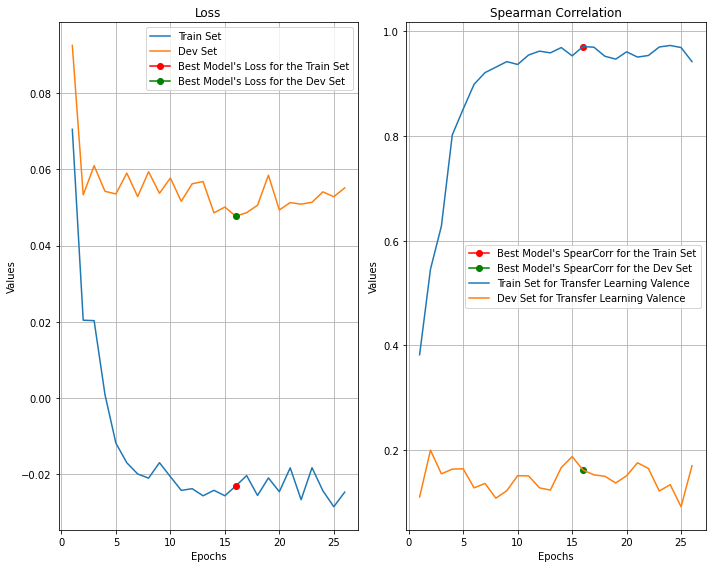

In [ ]:
with open('./best_EarlyCNN_beatFUSED.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

# Change the last Layer
E_model.fc = FullyConnectedLayer(hidden_features, hidden_features, out_features)
E_model = E_model.to(device)
print(E_model)
#Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(E_model.parameters(), lr=ETA, weight_decay=weight_decay)

# training
reg_main(device, E_model, mels_feats, optimizer, criterion, train_loader, dev_loader, 30, Descrs = ['Transfer Learning Valence'], net_name='EarlyCNN_transfbeatFUSEDVal', PATIENCE=PATIENCE, cnn=True)

Spearman Correlation for Transfer Learning Valence: 0.16197101517750584


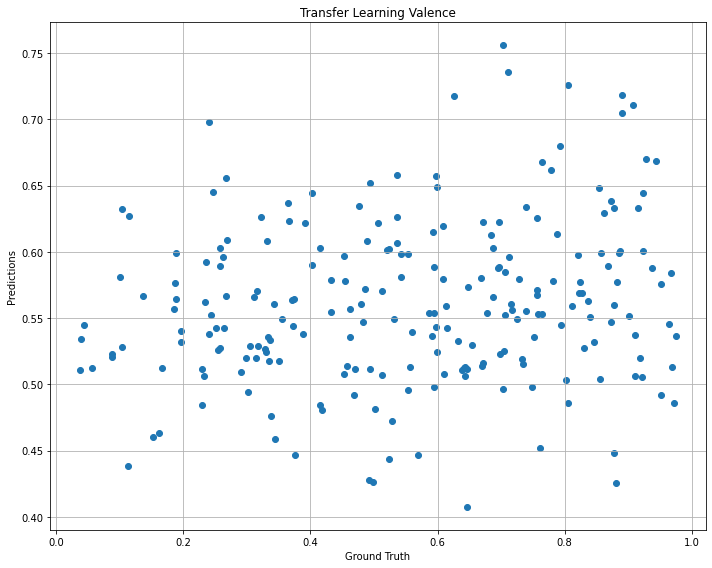

In [ ]:
with open('./best_EarlyCNN_transfbeatFUSEDVal.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
_ = reg_eval(device, dev_loader, mels_feats, E_model, criterion, cnn=True, titles=['Transfer Learning Valence'])

#### Only fullyconnected parameters trainable

In [ ]:
data = SpectrogramDataset("data/multitask_dataset_beat/",
                              class_mapping=class_mapping, train=True, read_spec_fn=read_mel_spectrogram, emotion=mapping['valence'])
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/multitask_dataset_beat/',
                                          class_mapping=class_mapping, train=False, read_spec_fn=read_mel_spectrogram, emotion=mapping['valence'])

##### Overfit the model

CNN(
  (conv_layer): Sequential(
    (0): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(4, 16, kernel_size=(4, 4), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvolutionalLayer(
      (conv): Sequential(
        (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

  0%|          | 0/30 [00:00<?, ?it/s]

 [=================================-------] ...Epoch 1, Loss: -0.0683
Statistics for the Train Set
	 Epoch: 1 	 loss: 0.05477028707294883
	 Epoch: 1 	 Spear Corr 1: 0.3331832714787623


  3%|▎         | 1/30 [00:01<00:46,  1.59s/it]

Statistics for the Dev Set
	 Epoch: 1 	 loss: 0.059709817307415744
	 Epoch: 1 	 Spear Corr 1: 0.3331832714787623
Dev loss decreased (0.059710 --> 0.059710).  Saving model ...
Epoch total time 1.591766595840454
 [=================================-------] ...Epoch 2, Loss: -0.0144
Statistics for the Train Set
	 Epoch: 2 	 loss: 0.020275083302462204
	 Epoch: 2 	 Spear Corr 1: 0.562429211214131


  7%|▋         | 2/30 [00:03<00:44,  1.60s/it]

Statistics for the Dev Set
	 Epoch: 2 	 loss: 0.02822852335870977
	 Epoch: 2 	 Spear Corr 1: 0.562429211214131
Dev loss decreased (0.059710 --> 0.028229).  Saving model ...
Epoch total time 1.6071853637695312
 [=================================-------] ...Epoch 3, Loss: 0.0603
Statistics for the Train Set
	 Epoch: 3 	 loss: 0.007486608395205298
	 Epoch: 3 	 Spear Corr 1: 0.7087272370758892


 10%|█         | 3/30 [00:04<00:43,  1.60s/it]

Statistics for the Dev Set
	 Epoch: 3 	 loss: 0.01020998899193909
	 Epoch: 3 	 Spear Corr 1: 0.7087330204236533
Dev loss decreased (0.028229 --> 0.010210).  Saving model ...
Epoch total time 1.5933878421783447
 [=================================-------] ...Epoch 4, Loss: 0.0331
Statistics for the Train Set
	 Epoch: 4 	 loss: 0.0032755423414741786
	 Epoch: 4 	 Spear Corr 1: 0.7108528523208434


 13%|█▎        | 4/30 [00:06<00:41,  1.60s/it]

Statistics for the Dev Set
	 Epoch: 4 	 loss: 0.002850876597778001
	 Epoch: 4 	 Spear Corr 1: 0.7108529819455064
Dev loss decreased (0.010210 --> 0.002851).  Saving model ...
Epoch total time 1.5925054550170898
 [=================================-------] ...Epoch 5, Loss: 0.0633
Statistics for the Train Set
	 Epoch: 5 	 loss: -0.007380517992441451
	 Epoch: 5 	 Spear Corr 1: 0.8569305611731532


 17%|█▋        | 5/30 [00:07<00:40,  1.60s/it]

Statistics for the Dev Set
	 Epoch: 5 	 loss: 0.00042493744111532646
	 Epoch: 5 	 Spear Corr 1: 0.8569305611731532
Dev loss decreased (0.002851 --> 0.000425).  Saving model ...
Epoch total time 1.6050045490264893
 [=================================-------] ...Epoch 6, Loss: -0.0444
Statistics for the Train Set
	 Epoch: 6 	 loss: -0.015251890164929912
	 Epoch: 6 	 Spear Corr 1: 0.8983512044263083


 20%|██        | 6/30 [00:09<00:38,  1.61s/it]

Statistics for the Dev Set
	 Epoch: 6 	 loss: -0.009594011315097736
	 Epoch: 6 	 Spear Corr 1: 0.8983512044263083
Dev loss decreased (0.000425 --> -0.009594).  Saving model ...
Epoch total time 1.6123015880584717
 [=================================-------] ...Epoch 7, Loss: -0.0702
Statistics for the Train Set
	 Epoch: 7 	 loss: -0.020918260083713277
	 Epoch: 7 	 Spear Corr 1: 0.9206403095648797


 23%|██▎       | 7/30 [00:11<00:36,  1.60s/it]

Statistics for the Dev Set
	 Epoch: 7 	 loss: -0.02073555486145268
	 Epoch: 7 	 Spear Corr 1: 0.9206403095648797
Dev loss decreased (-0.009594 --> -0.020736).  Saving model ...
Epoch total time 1.5893988609313965
 [=================================-------] ...Epoch 8, Loss: -0.0076
Statistics for the Train Set
	 Epoch: 8 	 loss: -0.02331570441965866
	 Epoch: 8 	 Spear Corr 1: 0.9505165538355734


 27%|██▋       | 8/30 [00:12<00:35,  1.60s/it]

Statistics for the Dev Set
	 Epoch: 8 	 loss: -0.021879828632502485
	 Epoch: 8 	 Spear Corr 1: 0.9505165538355734
Dev loss decreased (-0.020736 --> -0.021880).  Saving model ...
Epoch total time 1.5861053466796875
 [=================================-------] ...Epoch 9, Loss: -0.0227
Statistics for the Train Set
	 Epoch: 9 	 loss: -0.01681147319696531
	 Epoch: 9 	 Spear Corr 1: 0.9469326347687578


 30%|███       | 9/30 [00:14<00:33,  1.59s/it]

Statistics for the Dev Set
	 Epoch: 9 	 loss: -0.023616584529281903
	 Epoch: 9 	 Spear Corr 1: 0.9469326347687578
Dev loss decreased (-0.021880 --> -0.023617).  Saving model ...
Epoch total time 1.5841732025146484
 [=================================-------] ...Epoch 10, Loss: 0.1260
Statistics for the Train Set
	 Epoch: 10 	 loss: -0.021454446043878243
	 Epoch: 10 	 Spear Corr 1: 0.9298311180041381


 33%|███▎      | 10/30 [00:15<00:31,  1.59s/it]

Statistics for the Dev Set
	 Epoch: 10 	 loss: -0.018582467710418448
	 Epoch: 10 	 Spear Corr 1: 0.9298311180041381
EarlyStopping counter: 1 out of 10
Epoch total time 1.5840845108032227
 [=================================-------] ...Epoch 11, Loss: 0.0182
Statistics for the Train Set
	 Epoch: 11 	 loss: -0.02243754713976678
	 Epoch: 11 	 Spear Corr 1: 0.9301522512314138


 37%|███▋      | 11/30 [00:17<00:30,  1.59s/it]

Statistics for the Dev Set
	 Epoch: 11 	 loss: -0.023191741648329423
	 Epoch: 11 	 Spear Corr 1: 0.9301522512314138
EarlyStopping counter: 2 out of 10
Epoch total time 1.5817251205444336
 [=================================-------] ...Epoch 12, Loss: -0.0850
Statistics for the Train Set
	 Epoch: 12 	 loss: -0.02560571693192349
	 Epoch: 12 	 Spear Corr 1: 0.9656117460619844


 40%|████      | 12/30 [00:19<00:29,  1.61s/it]

Statistics for the Dev Set
	 Epoch: 12 	 loss: -0.025968359010981913
	 Epoch: 12 	 Spear Corr 1: 0.9656117460619844
Dev loss decreased (-0.023617 --> -0.025968).  Saving model ...
Epoch total time 1.6716842651367188
 [=================================-------] ...Epoch 13, Loss: -0.0374
Statistics for the Train Set
	 Epoch: 13 	 loss: -0.02601874707021195
	 Epoch: 13 	 Spear Corr 1: 0.9651365007023148


 43%|████▎     | 13/30 [00:20<00:27,  1.61s/it]

Statistics for the Dev Set
	 Epoch: 13 	 loss: -0.025509143988169284
	 Epoch: 13 	 Spear Corr 1: 0.9651359454227693
EarlyStopping counter: 1 out of 10
Epoch total time 1.5832536220550537
 [=================================-------] ...Epoch 14, Loss: -0.0555
Statistics for the Train Set
	 Epoch: 14 	 loss: -0.02892718825128231
	 Epoch: 14 	 Spear Corr 1: 0.9701880395486367


 47%|████▋     | 14/30 [00:22<00:25,  1.60s/it]

Statistics for the Dev Set
	 Epoch: 14 	 loss: -0.024898425174822703
	 Epoch: 14 	 Spear Corr 1: 0.9701880395486367
EarlyStopping counter: 2 out of 10
Epoch total time 1.597905158996582
 [=================================-------] ...Epoch 15, Loss: -0.0637
Statistics for the Train Set
	 Epoch: 15 	 loss: -0.026597097559347284
	 Epoch: 15 	 Spear Corr 1: 0.9695998200532041


 50%|█████     | 15/30 [00:23<00:24,  1.60s/it]

Statistics for the Dev Set
	 Epoch: 15 	 loss: -0.025486524051890325
	 Epoch: 15 	 Spear Corr 1: 0.9695998200532041
EarlyStopping counter: 3 out of 10
Epoch total time 1.5899899005889893
 [=================================-------] ...Epoch 16, Loss: 0.0180
Statistics for the Train Set
	 Epoch: 16 	 loss: -0.028968906469482286
	 Epoch: 16 	 Spear Corr 1: 0.9745793239060299


 53%|█████▎    | 16/30 [00:25<00:22,  1.60s/it]

Statistics for the Dev Set
	 Epoch: 16 	 loss: -0.027753111446853215
	 Epoch: 16 	 Spear Corr 1: 0.9745793239060299
Dev loss decreased (-0.025968 --> -0.027753).  Saving model ...
Epoch total time 1.6038153171539307
 [=================================-------] ...Epoch 17, Loss: -0.0845
Statistics for the Train Set
	 Epoch: 17 	 loss: -0.027248270709709758
	 Epoch: 17 	 Spear Corr 1: 0.9673377190888123


 57%|█████▋    | 17/30 [00:27<00:20,  1.60s/it]

Statistics for the Dev Set
	 Epoch: 17 	 loss: -0.025080442934912447
	 Epoch: 17 	 Spear Corr 1: 0.9673377190888123
EarlyStopping counter: 1 out of 10
Epoch total time 1.583388090133667
 [=================================-------] ...Epoch 18, Loss: -0.0408
Statistics for the Train Set
	 Epoch: 18 	 loss: -0.026987821121359862
	 Epoch: 18 	 Spear Corr 1: 0.9514792575271251


 60%|██████    | 18/30 [00:28<00:19,  1.60s/it]

Statistics for the Dev Set
	 Epoch: 18 	 loss: -0.026649719149543345
	 Epoch: 18 	 Spear Corr 1: 0.9514792575271251
EarlyStopping counter: 2 out of 10
Epoch total time 1.5995967388153076
 [=================================-------] ...Epoch 19, Loss: 0.1260
Statistics for the Train Set
	 Epoch: 19 	 loss: -0.024863961728926715
	 Epoch: 19 	 Spear Corr 1: 0.9505972472795189


 63%|██████▎   | 19/30 [00:30<00:17,  1.59s/it]

Statistics for the Dev Set
	 Epoch: 19 	 loss: -0.024131474862011757
	 Epoch: 19 	 Spear Corr 1: 0.9505972472795189
EarlyStopping counter: 3 out of 10
Epoch total time 1.5753226280212402
 [=================================-------] ...Epoch 20, Loss: 0.1109
Statistics for the Train Set
	 Epoch: 20 	 loss: -0.02492520846146821
	 Epoch: 20 	 Spear Corr 1: 0.9588199166745991


 67%|██████▋   | 20/30 [00:31<00:15,  1.60s/it]

Statistics for the Dev Set
	 Epoch: 20 	 loss: -0.026078805264723018
	 Epoch: 20 	 Spear Corr 1: 0.9588199166745991
EarlyStopping counter: 4 out of 10
Epoch total time 1.6039371490478516
 [=================================-------] ...Epoch 21, Loss: -0.0424
Statistics for the Train Set
	 Epoch: 21 	 loss: -0.02784085150075191
	 Epoch: 21 	 Spear Corr 1: 0.9706824660688707


 70%|███████   | 21/30 [00:33<00:14,  1.59s/it]

Statistics for the Dev Set
	 Epoch: 21 	 loss: -0.026998636235280055
	 Epoch: 21 	 Spear Corr 1: 0.9706824660688707
EarlyStopping counter: 5 out of 10
Epoch total time 1.589533805847168
 [=================================-------] ...Epoch 22, Loss: 0.1049
Statistics for the Train Set
	 Epoch: 22 	 loss: -0.029834967951415693
	 Epoch: 22 	 Spear Corr 1: 0.9754760825189941


 73%|███████▎  | 22/30 [00:35<00:12,  1.59s/it]

Statistics for the Dev Set
	 Epoch: 22 	 loss: -0.02828359309912261
	 Epoch: 22 	 Spear Corr 1: 0.9754760825189941
Dev loss decreased (-0.027753 --> -0.028284).  Saving model ...
Epoch total time 1.5745832920074463
 [=================================-------] ...Epoch 23, Loss: -0.0611
Statistics for the Train Set
	 Epoch: 23 	 loss: -0.022064238773804392
	 Epoch: 23 	 Spear Corr 1: 0.973969868421601


 77%|███████▋  | 23/30 [00:36<00:11,  1.59s/it]

Statistics for the Dev Set
	 Epoch: 23 	 loss: -0.02842005596961127
	 Epoch: 23 	 Spear Corr 1: 0.973969868421601
Dev loss decreased (-0.028284 --> -0.028420).  Saving model ...
Epoch total time 1.5896015167236328
 [=================================-------] ...Epoch 24, Loss: -0.0395
Statistics for the Train Set
	 Epoch: 24 	 loss: -0.025795984333208507
	 Epoch: 24 	 Spear Corr 1: 0.964985363099788


 80%|████████  | 24/30 [00:38<00:09,  1.59s/it]

Statistics for the Dev Set
	 Epoch: 24 	 loss: -0.027266924366264367
	 Epoch: 24 	 Spear Corr 1: 0.964985363099788
EarlyStopping counter: 1 out of 10
Epoch total time 1.604261875152588
 [=================================-------] ...Epoch 25, Loss: -0.0454
Statistics for the Train Set
	 Epoch: 25 	 loss: -0.021867855520715768
	 Epoch: 25 	 Spear Corr 1: 0.9721996005851076


 83%|████████▎ | 25/30 [00:39<00:07,  1.60s/it]

Statistics for the Dev Set
	 Epoch: 25 	 loss: -0.023858962921938676
	 Epoch: 25 	 Spear Corr 1: 0.9722007854256954
EarlyStopping counter: 2 out of 10
Epoch total time 1.5989418029785156
 [=================================-------] ...Epoch 26, Loss: 0.1024
Statistics for the Train Set
	 Epoch: 26 	 loss: -0.02674409031714335
	 Epoch: 26 	 Spear Corr 1: 0.9440704741886542


 87%|████████▋ | 26/30 [00:41<00:06,  1.59s/it]

Statistics for the Dev Set
	 Epoch: 26 	 loss: -0.02606316832706483
	 Epoch: 26 	 Spear Corr 1: 0.9440704741886542
EarlyStopping counter: 3 out of 10
Epoch total time 1.5899300575256348
 [=================================-------] ...Epoch 27, Loss: -0.0240
Statistics for the Train Set
	 Epoch: 27 	 loss: -0.023222236891027204
	 Epoch: 27 	 Spear Corr 1: 0.9652061743002343


 90%|█████████ | 27/30 [00:43<00:04,  1.59s/it]

Statistics for the Dev Set
	 Epoch: 27 	 loss: -0.02143992003266481
	 Epoch: 27 	 Spear Corr 1: 0.9652054243094114
EarlyStopping counter: 4 out of 10
Epoch total time 1.5788085460662842
 [=================================-------] ...Epoch 28, Loss: -0.0520
Statistics for the Train Set
	 Epoch: 28 	 loss: -0.01992882122451181
	 Epoch: 28 	 Spear Corr 1: 0.9034402024635204


 93%|█████████▎| 28/30 [00:44<00:03,  1.62s/it]

Statistics for the Dev Set
	 Epoch: 28 	 loss: -0.02113828994541932
	 Epoch: 28 	 Spear Corr 1: 0.9034402190347175
EarlyStopping counter: 5 out of 10
Epoch total time 1.6849374771118164
 [=================================-------] ...Epoch 29, Loss: -0.0348
Statistics for the Train Set
	 Epoch: 29 	 loss: -0.021319326003619278
	 Epoch: 29 	 Spear Corr 1: 0.9403379529124576


 97%|█████████▋| 29/30 [00:46<00:01,  1.61s/it]

Statistics for the Dev Set
	 Epoch: 29 	 loss: -0.023248337793257835
	 Epoch: 29 	 Spear Corr 1: 0.9403379529124576
EarlyStopping counter: 6 out of 10
Epoch total time 1.5991358757019043
 [=================================-------] ...Epoch 30, Loss: -0.0051
Statistics for the Train Set
	 Epoch: 30 	 loss: -0.02589883370270533
	 Epoch: 30 	 Spear Corr 1: 0.9581742116966636


100%|██████████| 30/30 [00:47<00:00,  1.60s/it]

Statistics for the Dev Set
	 Epoch: 30 	 loss: -0.022524918124268073
	 Epoch: 30 	 Spear Corr 1: 0.9581742116966636
EarlyStopping counter: 7 out of 10
Epoch total time 1.6004571914672852
Training total time 47.946722745895386


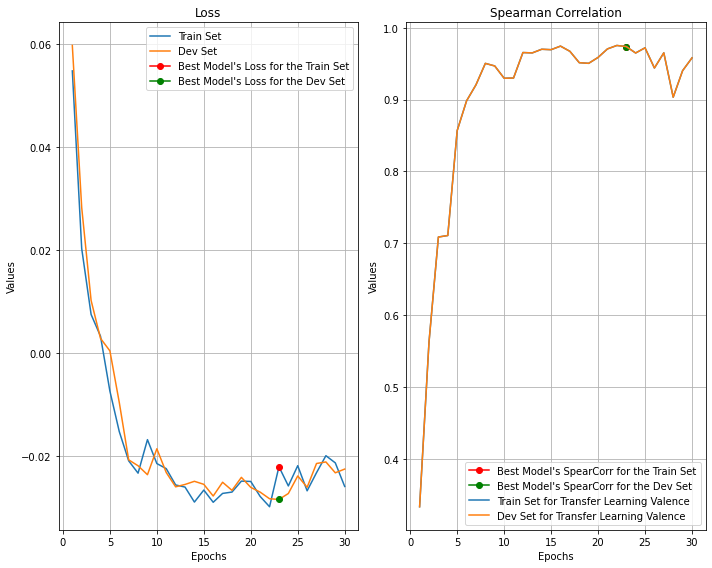

In [ ]:
with open('./best_EarlyCNN_beatFUSED.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

# Change the last Layer
E_model.fc = FullyConnectedLayer(hidden_features, hidden_features, out_features)
E_model = E_model.to(device)
print(E_model)
#Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(E_model.parameters(), lr=ETA, weight_decay=weight_decay)

# training
reg_main(device, E_model, mels_feats, optimizer, criterion, train_loader, train_loader, 30, Descrs = ['Transfer Learning Valence'], PATIENCE=PATIENCE, overfit_batch=True, cnn=True)

##### Normal Training

  0%|          | 0/30 [00:00<?, ?it/s]

 [=================================-------] ...Epoch 1, Loss: 0.2177

  3%|▎         | 1/30 [00:01<00:29,  1.01s/it]


Statistics for the Train Set
	 Epoch: 1 	 loss: 0.06601517845807718
	 Epoch: 1 	 Spear Corr 1: 0.23915866408771072
Statistics for the Dev Set
	 Epoch: 1 	 loss: 0.062118719849226664
	 Epoch: 1 	 Spear Corr 1: 0.1282265575057999
Dev loss decreased (0.062119 --> 0.062119).  Saving model ...
Epoch total time 1.0142793655395508
 [=================================-------] ...Epoch 2, Loss: 0.0207

  7%|▋         | 2/30 [00:02<00:28,  1.02s/it]


Statistics for the Train Set
	 Epoch: 2 	 loss: 0.0311837547925004
	 Epoch: 2 	 Spear Corr 1: 0.5011002466999366
Statistics for the Dev Set
	 Epoch: 2 	 loss: 0.04599442778360906
	 Epoch: 2 	 Spear Corr 1: 0.2171841588556428
Dev loss decreased (0.062119 --> 0.045994).  Saving model ...
Epoch total time 1.0286962985992432
 [=================================-------] ...Epoch 3, Loss: 0.2090

 10%|█         | 3/30 [00:03<00:27,  1.02s/it]


Statistics for the Train Set
	 Epoch: 3 	 loss: 0.017198306732373103
	 Epoch: 3 	 Spear Corr 1: 0.6085992034858376
Statistics for the Dev Set
	 Epoch: 3 	 loss: 0.040494184707892615
	 Epoch: 3 	 Spear Corr 1: 0.3128971011772016
Dev loss decreased (0.045994 --> 0.040494).  Saving model ...
Epoch total time 1.0207531452178955
 [=================================-------] ...Epoch 4, Loss: 0.1383

 13%|█▎        | 4/30 [00:04<00:26,  1.03s/it]


Statistics for the Train Set
	 Epoch: 4 	 loss: 0.01222644907193533
	 Epoch: 4 	 Spear Corr 1: 0.6927450632427625
Statistics for the Dev Set
	 Epoch: 4 	 loss: 0.03822354802706196
	 Epoch: 4 	 Spear Corr 1: 0.2479280604851788
Dev loss decreased (0.040494 --> 0.038224).  Saving model ...
Epoch total time 1.0266060829162598
 [=================================-------] ...Epoch 5, Loss: 0.0427

 17%|█▋        | 5/30 [00:05<00:25,  1.02s/it]


Statistics for the Train Set
	 Epoch: 5 	 loss: 0.002432062054121914
	 Epoch: 5 	 Spear Corr 1: 0.7404276801438157
Statistics for the Dev Set
	 Epoch: 5 	 loss: 0.04043460436019841
	 Epoch: 5 	 Spear Corr 1: 0.25202963190020117
EarlyStopping counter: 1 out of 10
Epoch total time 0.9968571662902832
 [=================================-------] ...Epoch 6, Loss: 0.0064

 20%|██        | 6/30 [00:06<00:24,  1.02s/it]


Statistics for the Train Set
	 Epoch: 6 	 loss: -0.009555705042167923
	 Epoch: 6 	 Spear Corr 1: 0.8115313640814729
Statistics for the Dev Set
	 Epoch: 6 	 loss: 0.05208481885747362
	 Epoch: 6 	 Spear Corr 1: 0.17730981652441108
EarlyStopping counter: 2 out of 10
Epoch total time 1.0344195365905762
 [=================================-------] ...Epoch 7, Loss: 0.1914

 23%|██▎       | 7/30 [00:07<00:23,  1.03s/it]


Statistics for the Train Set
	 Epoch: 7 	 loss: -0.012045895412210602
	 Epoch: 7 	 Spear Corr 1: 0.8364556706856029
Statistics for the Dev Set
	 Epoch: 7 	 loss: 0.05239581625377033
	 Epoch: 7 	 Spear Corr 1: 0.187362750445573
EarlyStopping counter: 3 out of 10
Epoch total time 1.037938117980957
 [=================================-------] ...Epoch 8, Loss: -0.0408

 27%|██▋       | 8/30 [00:08<00:22,  1.03s/it]


Statistics for the Train Set
	 Epoch: 8 	 loss: -0.01732841176877193
	 Epoch: 8 	 Spear Corr 1: 0.8893206228911488
Statistics for the Dev Set
	 Epoch: 8 	 loss: 0.04700933179159653
	 Epoch: 8 	 Spear Corr 1: 0.15818890237995484
EarlyStopping counter: 4 out of 10
Epoch total time 1.0173532962799072
 [=================================-------] ...Epoch 9, Loss: 0.1382

 30%|███       | 9/30 [00:09<00:21,  1.02s/it]


Statistics for the Train Set
	 Epoch: 9 	 loss: -0.01981261030407423
	 Epoch: 9 	 Spear Corr 1: 0.9046225325149306
Statistics for the Dev Set
	 Epoch: 9 	 loss: 0.05202311116568646
	 Epoch: 9 	 Spear Corr 1: 0.13433754123452066
EarlyStopping counter: 5 out of 10
Epoch total time 1.0214791297912598
 [=================================-------] ...Epoch 10, Loss: 0.0065

 33%|███▎      | 10/30 [00:10<00:20,  1.03s/it]


Statistics for the Train Set
	 Epoch: 10 	 loss: -0.0204367959783798
	 Epoch: 10 	 Spear Corr 1: 0.9259083593860185
Statistics for the Dev Set
	 Epoch: 10 	 loss: 0.04763718101329822
	 Epoch: 10 	 Spear Corr 1: 0.14978770110985104
EarlyStopping counter: 6 out of 10
Epoch total time 1.0274364948272705
 [=================================-------] ...Epoch 11, Loss: -0.0778

 37%|███▋      | 11/30 [00:11<00:19,  1.02s/it]


Statistics for the Train Set
	 Epoch: 11 	 loss: -0.021029289202890267
	 Epoch: 11 	 Spear Corr 1: 0.9323989244113691
Statistics for the Dev Set
	 Epoch: 11 	 loss: 0.05067546711495074
	 Epoch: 11 	 Spear Corr 1: 0.14936702711856667
EarlyStopping counter: 7 out of 10
Epoch total time 1.0130810737609863
 [=================================-------] ...Epoch 12, Loss: -0.0730

 40%|████      | 12/30 [00:12<00:18,  1.02s/it]


Statistics for the Train Set
	 Epoch: 12 	 loss: -0.022032497699793933
	 Epoch: 12 	 Spear Corr 1: 0.9373351194407525
Statistics for the Dev Set
	 Epoch: 12 	 loss: 0.049153942379365344
	 Epoch: 12 	 Spear Corr 1: 0.1606051085786261
EarlyStopping counter: 8 out of 10
Epoch total time 1.0188384056091309
 [=================================-------] ...Epoch 13, Loss: 0.0877

 43%|████▎     | 13/30 [00:13<00:17,  1.02s/it]


Statistics for the Train Set
	 Epoch: 13 	 loss: -0.02431125563250462
	 Epoch: 13 	 Spear Corr 1: 0.944967125088838
Statistics for the Dev Set
	 Epoch: 13 	 loss: 0.050463979205638956
	 Epoch: 13 	 Spear Corr 1: 0.14714727780922618
EarlyStopping counter: 9 out of 10
Epoch total time 1.0210561752319336
 [=================================-------] ...Epoch 14, Loss: 0.1333

 43%|████▎     | 13/30 [00:14<00:18,  1.10s/it]


Statistics for the Train Set
	 Epoch: 14 	 loss: -0.0217099819145348
	 Epoch: 14 	 Spear Corr 1: 0.9396885691287812
Statistics for the Dev Set
	 Epoch: 14 	 loss: 0.05016386583211336
	 Epoch: 14 	 Spear Corr 1: 0.15301482582725442
EarlyStopping counter: 10 out of 10
Training total time 13.278794288635254


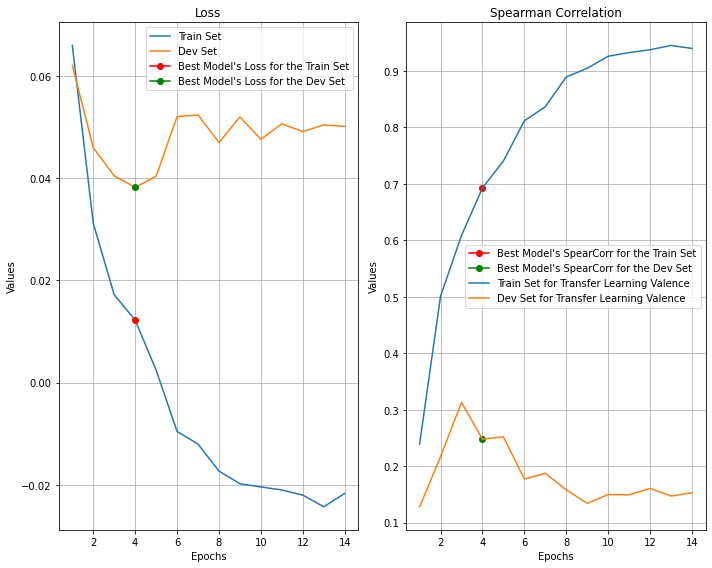

In [ ]:
with open('./best_EarlyCNN_beatFUSED.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

# Change the last Layer
num_feats = E_model.fc.fc2.in_features
# E_model.fc.fc2 = nn.Linear(num_feats, out_features)
E_model.fc = FullyConnectedLayer(hidden_features, hidden_features, out_features)
E_model = E_model.to(device)
# print(E_model)

# Turn-off gradient for cnn layer
for param in list(E_model.conv_layer.parameters()):
    param.requires_grad = False
parameters = [parameter for parameter in list(E_model.parameters()) if parameter.requires_grad==True]

# #Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(parameters, lr=ETA, weight_decay=weight_decay)

# # training
reg_main(device, E_model, mels_feats, optimizer, criterion, train_loader, dev_loader, 30, Descrs = ['Transfer Learning Valence'], net_name='EarlyCNN_transfbeatFUSEDValfreeze', PATIENCE=PATIENCE, cnn=True)

Spearman Correlation for Transfer Learning Valence: 0.2479280604851788


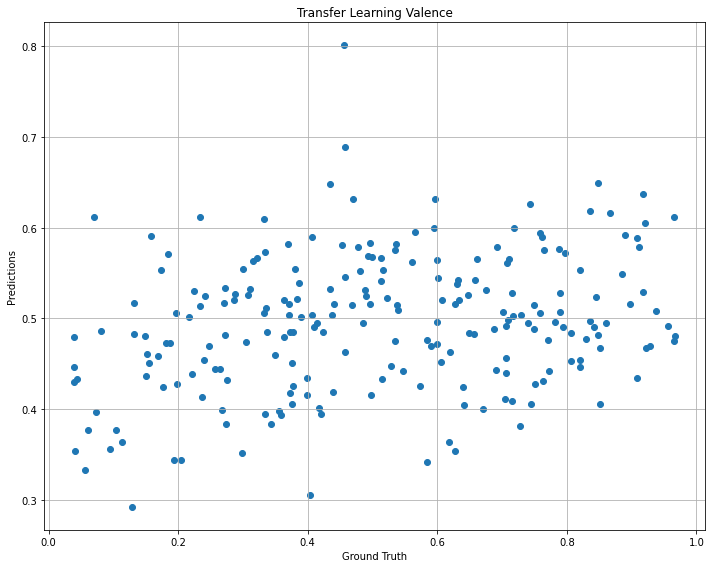

In [ ]:
with open('./best_EarlyCNN_transfbeatFUSEDValfreeze.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
_ = reg_eval(device, dev_loader, mels_feats, E_model, criterion, cnn=True, titles=['Transfer Learning Valence'])

## Multi Tasking

### Multi Parameters

In [ ]:
# Create map for sentiments
mapping = {
    'valence' : 1,
    'energy' : 2,
    'danceability' : 3,
}

### Multi CNN Training with trainable weights

The first experiment consists of a weighted multiloss of 3 SpearmanLoss. Each SpearmanLoss is a linear combination of -spearcorr, mse as it is shown in lib.py. In the present case, we train the weights of the 3 losses. 

#### Redefine MultiTask Regresion Parameters

In [ ]:
out_features = 1
task_num = 3
regularization_strength = 1e-2
loss = SpearmanLoss(regularization_strength=regularization_strength)
criterion = MultiTaskLossTrain(task_num, loss)

#### Modeling Pipeline

In [ ]:
data = SpectrogramDataset("data/multitask_dataset_beat/",
                              class_mapping=class_mapping, train=True, read_spec_fn=read_mel_spectrogram, emotion=np.array(list(mapping.values())))
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/multitask_dataset_beat/',
                                          class_mapping=class_mapping, train=False, read_spec_fn=read_mel_spectrogram, emotion=np.array(list(mapping.values())))

##### Overfit the model


  0%|          | 0/30 [00:00<?, ?it/s]

 [=================================-------] ...Epoch 1, Loss: 0.4593
Statistics for the Train Set
	 Epoch: 1 	 loss: 0.05417979740637331
	 Epoch: 1 	 Spear Corr 1: 0.4067738599767327
	 Epoch: 1 	 Spear Corr 2: 0.7018593440660171
	 Epoch: 1 	 Spear Corr 3: 0.3120666973119555


  3%|▎         | 1/30 [00:04<02:12,  4.57s/it]

Statistics for the Dev Set
	 Epoch: 1 	 loss: 0.05112693891732571
	 Epoch: 1 	 Spear Corr 1: 0.42148384370021563
	 Epoch: 1 	 Spear Corr 2: 0.6969128803316477
	 Epoch: 1 	 Spear Corr 3: 0.3056779332814609
Dev loss decreased (0.051127 --> 0.051127).  Saving model ...
Epoch total time 4.574254035949707
 [=================================-------] ...Epoch 2, Loss: 0.5947
Statistics for the Train Set
	 Epoch: 2 	 loss: -0.03148674028798229
	 Epoch: 2 	 Spear Corr 1: 0.5425110532364399
	 Epoch: 2 	 Spear Corr 2: 0.6486298694439305
	 Epoch: 2 	 Spear Corr 3: 0.4968486721149232


  7%|▋         | 2/30 [00:06<01:27,  3.12s/it]

Statistics for the Dev Set
	 Epoch: 2 	 loss: -0.03350871314909732
	 Epoch: 2 	 Spear Corr 1: 0.5430692207619987
	 Epoch: 2 	 Spear Corr 2: 0.6986029694045427
	 Epoch: 2 	 Spear Corr 3: 0.4790441870759058
Dev loss decreased (0.051127 --> -0.033509).  Saving model ...
Epoch total time 2.0950987339019775
 [=================================-------] ...Epoch 3, Loss: -0.1580
Statistics for the Train Set
	 Epoch: 3 	 loss: -0.03978448944785857
	 Epoch: 3 	 Spear Corr 1: 0.5971808886027749
	 Epoch: 3 	 Spear Corr 2: 0.7021720095916583
	 Epoch: 3 	 Spear Corr 3: 0.5234727133820606


 10%|█         | 3/30 [00:08<01:11,  2.63s/it]

Statistics for the Dev Set
	 Epoch: 3 	 loss: -0.04630039622458628
	 Epoch: 3 	 Spear Corr 1: 0.5658365995448557
	 Epoch: 3 	 Spear Corr 2: 0.7204646579615485
	 Epoch: 3 	 Spear Corr 3: 0.5302213133711429
Dev loss decreased (-0.033509 --> -0.046300).  Saving model ...
Epoch total time 2.048567771911621
 [=================================-------] ...Epoch 4, Loss: -0.2256
Statistics for the Train Set
	 Epoch: 4 	 loss: -0.08368526917999924
	 Epoch: 4 	 Spear Corr 1: 0.613447015150201
	 Epoch: 4 	 Spear Corr 2: 0.7660511524018989
	 Epoch: 4 	 Spear Corr 3: 0.5651676497032453


 13%|█▎        | 4/30 [00:10<01:02,  2.41s/it]

Statistics for the Dev Set
	 Epoch: 4 	 loss: -0.07666726263474878
	 Epoch: 4 	 Spear Corr 1: 0.632777321169499
	 Epoch: 4 	 Spear Corr 2: 0.7289035863374542
	 Epoch: 4 	 Spear Corr 3: 0.5566784243599485
Dev loss decreased (-0.046300 --> -0.076667).  Saving model ...
Epoch total time 2.07891845703125
 [=================================-------] ...Epoch 5, Loss: -0.0065
Statistics for the Train Set
	 Epoch: 5 	 loss: -0.09338948639397766
	 Epoch: 5 	 Spear Corr 1: 0.6664226945038441
	 Epoch: 5 	 Spear Corr 2: 0.7477286178609523
	 Epoch: 5 	 Spear Corr 3: 0.6167916109108836


 17%|█▋        | 5/30 [00:12<00:57,  2.28s/it]

Statistics for the Dev Set
	 Epoch: 5 	 loss: -0.10698209571280934
	 Epoch: 5 	 Spear Corr 1: 0.6586156653281474
	 Epoch: 5 	 Spear Corr 2: 0.7554214276608568
	 Epoch: 5 	 Spear Corr 3: 0.6447747249776531
Dev loss decreased (-0.076667 --> -0.106982).  Saving model ...
Epoch total time 2.054489850997925
 [=================================-------] ...Epoch 6, Loss: -0.2694
Statistics for the Train Set
	 Epoch: 6 	 loss: -0.11465754612996261
	 Epoch: 6 	 Spear Corr 1: 0.6911667018713333
	 Epoch: 6 	 Spear Corr 2: 0.7712886893797435
	 Epoch: 6 	 Spear Corr 3: 0.6288438991216533


 20%|██        | 6/30 [00:14<00:53,  2.22s/it]

Statistics for the Dev Set
	 Epoch: 6 	 loss: -0.10946168022825092
	 Epoch: 6 	 Spear Corr 1: 0.7017136868238238
	 Epoch: 6 	 Spear Corr 2: 0.78121783322045
	 Epoch: 6 	 Spear Corr 3: 0.6575796618519009
Dev loss decreased (-0.106982 --> -0.109462).  Saving model ...
Epoch total time 2.0849666595458984
 [=================================-------] ...Epoch 7, Loss: 0.1971
Statistics for the Train Set
	 Epoch: 7 	 loss: -0.1375435290340954
	 Epoch: 7 	 Spear Corr 1: 0.7465437295103502
	 Epoch: 7 	 Spear Corr 2: 0.7979579832456305
	 Epoch: 7 	 Spear Corr 3: 0.6801490658377739


 23%|██▎       | 7/30 [00:16<00:49,  2.14s/it]

Statistics for the Dev Set
	 Epoch: 7 	 loss: -0.15057113555971252
	 Epoch: 7 	 Spear Corr 1: 0.7526955035511346
	 Epoch: 7 	 Spear Corr 2: 0.8073028429137389
	 Epoch: 7 	 Spear Corr 3: 0.7104443938532141
Dev loss decreased (-0.109462 --> -0.150571).  Saving model ...
Epoch total time 1.9641623497009277
 [=================================-------] ...Epoch 8, Loss: 0.1626
Statistics for the Train Set
	 Epoch: 8 	 loss: -0.12198561999725169
	 Epoch: 8 	 Spear Corr 1: 0.7962791521708872
	 Epoch: 8 	 Spear Corr 2: 0.7948291074475377
	 Epoch: 8 	 Spear Corr 3: 0.7332812380910109


 27%|██▋       | 8/30 [00:18<00:46,  2.10s/it]

Statistics for the Dev Set
	 Epoch: 8 	 loss: -0.12493847564785567
	 Epoch: 8 	 Spear Corr 1: 0.7895116339911914
	 Epoch: 8 	 Spear Corr 2: 0.7965511706635174
	 Epoch: 8 	 Spear Corr 3: 0.7366450484974064
EarlyStopping counter: 1 out of 10
Epoch total time 2.008035659790039
 [=================================-------] ...Epoch 9, Loss: 0.3046
Statistics for the Train Set
	 Epoch: 9 	 loss: -0.13774039606246907
	 Epoch: 9 	 Spear Corr 1: 0.7952669339313093
	 Epoch: 9 	 Spear Corr 2: 0.8134019334925805
	 Epoch: 9 	 Spear Corr 3: 0.7405054075040969


 30%|███       | 9/30 [00:20<00:43,  2.09s/it]

Statistics for the Dev Set
	 Epoch: 9 	 loss: -0.1407693622675777
	 Epoch: 9 	 Spear Corr 1: 0.7705701130385707
	 Epoch: 9 	 Spear Corr 2: 0.8139347060695428
	 Epoch: 9 	 Spear Corr 3: 0.7266226778763183
EarlyStopping counter: 2 out of 10
Epoch total time 2.0623886585235596
 [=================================-------] ...Epoch 10, Loss: -0.0511
Statistics for the Train Set
	 Epoch: 10 	 loss: -0.1600588498904549
	 Epoch: 10 	 Spear Corr 1: 0.8158085279430143
	 Epoch: 10 	 Spear Corr 2: 0.8205220175364721
	 Epoch: 10 	 Spear Corr 3: 0.7148676278054639


 33%|███▎      | 10/30 [00:22<00:41,  2.06s/it]

Statistics for the Dev Set
	 Epoch: 10 	 loss: -0.16060963732232547
	 Epoch: 10 	 Spear Corr 1: 0.8190626050118681
	 Epoch: 10 	 Spear Corr 2: 0.8288685117221073
	 Epoch: 10 	 Spear Corr 3: 0.730586656779808
Dev loss decreased (-0.150571 --> -0.160610).  Saving model ...
Epoch total time 2.0075533390045166
 [=================================-------] ...Epoch 11, Loss: -0.2249
Statistics for the Train Set
	 Epoch: 11 	 loss: -0.15276397477996007
	 Epoch: 11 	 Spear Corr 1: 0.8287468604653343
	 Epoch: 11 	 Spear Corr 2: 0.798407609793607
	 Epoch: 11 	 Spear Corr 3: 0.7568307611872194


 37%|███▋      | 11/30 [00:25<00:38,  2.04s/it]

Statistics for the Dev Set
	 Epoch: 11 	 loss: -0.16304838562541726
	 Epoch: 11 	 Spear Corr 1: 0.8344899060075317
	 Epoch: 11 	 Spear Corr 2: 0.8090200010525727
	 Epoch: 11 	 Spear Corr 3: 0.7591154945698135
Dev loss decreased (-0.160610 --> -0.163048).  Saving model ...
Epoch total time 1.9977185726165771
 [=================================-------] ...Epoch 12, Loss: -0.0289
Statistics for the Train Set
	 Epoch: 12 	 loss: -0.16132931606764492
	 Epoch: 12 	 Spear Corr 1: 0.8362171546945264
	 Epoch: 12 	 Spear Corr 2: 0.8230443291747277
	 Epoch: 12 	 Spear Corr 3: 0.776228263355481


 40%|████      | 12/30 [00:27<00:37,  2.06s/it]

Statistics for the Dev Set
	 Epoch: 12 	 loss: -0.1601942835165288
	 Epoch: 12 	 Spear Corr 1: 0.831981441524515
	 Epoch: 12 	 Spear Corr 2: 0.8033017582288219
	 Epoch: 12 	 Spear Corr 3: 0.7884487329723944
EarlyStopping counter: 1 out of 10
Epoch total time 2.109539031982422
 [=================================-------] ...Epoch 13, Loss: -0.0872
Statistics for the Train Set
	 Epoch: 13 	 loss: -0.1956826193075825
	 Epoch: 13 	 Spear Corr 1: 0.8626722786917073
	 Epoch: 13 	 Spear Corr 2: 0.8529057677054078
	 Epoch: 13 	 Spear Corr 3: 0.806266284425713


 40%|████      | 12/30 [00:29<00:43,  2.42s/it]


Training total time 27.08569312095642


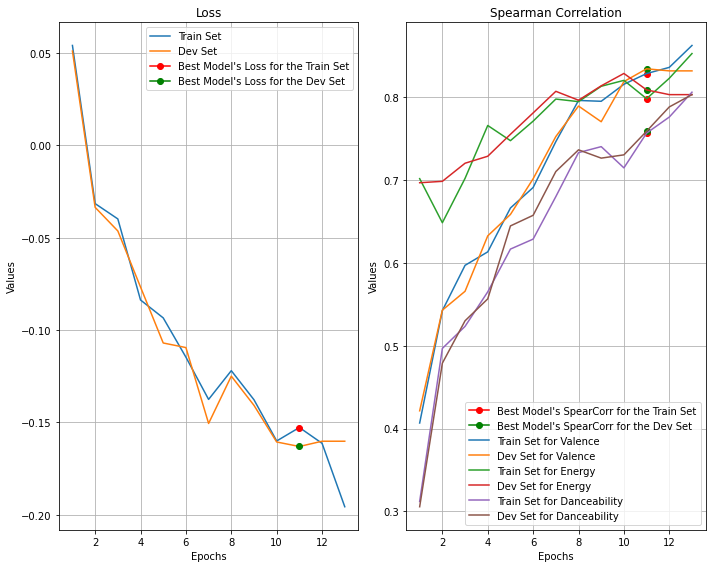

In [ ]:
EarlyCNNNet = MultiCNN(layer_channels, hidden_features, out_features, kernels).to(device)

# Make instance of our optimizer, with L2-Reguralization
criterion = MultiTaskLossTrain(task_num, loss)
parameters = list(EarlyCNNNet.parameters()) + list(criterion.parameters())
optimizer = optim.Adam(EarlyCNNNet.parameters(), lr=ETA, weight_decay=weight_decay)

reg_main(device, EarlyCNNNet, mels_feats, optimizer, criterion, train_loader, train_loader, 30, Descrs = ['Valence', 'Energy', 'Danceability'], PATIENCE=PATIENCE, overfit_batch=True, cnn=True, multi=True)

##### Normal Training

  0%|          | 0/100 [00:00<?, ?it/s]

 [=================================-------] ...Epoch 1, Loss: 0.0039

  1%|          | 1/100 [00:01<02:43,  1.65s/it]


Statistics for the Train Set
	 Epoch: 1 	 loss: 0.008806098921979174
	 Epoch: 1 	 Spear Corr 1: 0.34033123529960696
	 Epoch: 1 	 Spear Corr 2: 0.6738315261139741
	 Epoch: 1 	 Spear Corr 3: 0.3637361962577042
Statistics for the Dev Set
	 Epoch: 1 	 loss: 0.05051219336489365
	 Epoch: 1 	 Spear Corr 1: 0.24118459297635658
	 Epoch: 1 	 Spear Corr 2: 0.6436191183607394
	 Epoch: 1 	 Spear Corr 3: 0.22712548101989372
Dev loss decreased (0.050512 --> 0.050512).  Saving model ...
Epoch total time 1.6492302417755127
 [=================================-------] ...Epoch 2, Loss: -0.2318

  2%|▏         | 2/100 [00:03<02:41,  1.65s/it]


Statistics for the Train Set
	 Epoch: 2 	 loss: -0.00952974185597498
	 Epoch: 2 	 Spear Corr 1: 0.39194694990879286
	 Epoch: 2 	 Spear Corr 2: 0.7111346958081501
	 Epoch: 2 	 Spear Corr 3: 0.4182796517861901
Statistics for the Dev Set
	 Epoch: 2 	 loss: 0.042112651859744984
	 Epoch: 2 	 Spear Corr 1: 0.2792668203730678
	 Epoch: 2 	 Spear Corr 2: 0.6493046204107601
	 Epoch: 2 	 Spear Corr 3: 0.3183710447117352
Dev loss decreased (0.050512 --> 0.042113).  Saving model ...
Epoch total time 1.6404783725738525
 [=================================-------] ...Epoch 3, Loss: -0.0858

  3%|▎         | 3/100 [00:04<02:39,  1.64s/it]


Statistics for the Train Set
	 Epoch: 3 	 loss: -0.038672794196458145
	 Epoch: 3 	 Spear Corr 1: 0.47723790742940475
	 Epoch: 3 	 Spear Corr 2: 0.7188116138209499
	 Epoch: 3 	 Spear Corr 3: 0.5238244708663655
Statistics for the Dev Set
	 Epoch: 3 	 loss: 0.027384548445943107
	 Epoch: 3 	 Spear Corr 1: 0.34418998460375744
	 Epoch: 3 	 Spear Corr 2: 0.6243631503847538
	 Epoch: 3 	 Spear Corr 3: 0.45449546656047185
Dev loss decreased (0.042113 --> 0.027385).  Saving model ...
Epoch total time 1.6425814628601074
 [=================================-------] ...Epoch 4, Loss: 0.3336

  4%|▍         | 4/100 [00:06<02:37,  1.64s/it]


Statistics for the Train Set
	 Epoch: 4 	 loss: -0.06812543666722494
	 Epoch: 4 	 Spear Corr 1: 0.5020260107439745
	 Epoch: 4 	 Spear Corr 2: 0.7360556113820177
	 Epoch: 4 	 Spear Corr 3: 0.5085222497369349
Statistics for the Dev Set
	 Epoch: 4 	 loss: -0.009203011818580761
	 Epoch: 4 	 Spear Corr 1: 0.3369013233484508
	 Epoch: 4 	 Spear Corr 2: 0.6608533965467317
	 Epoch: 4 	 Spear Corr 3: 0.41697843665737244
Dev loss decreased (0.027385 --> -0.009203).  Saving model ...
Epoch total time 1.619539737701416
 [=================================-------] ...Epoch 5, Loss: -0.0744

  5%|▌         | 5/100 [00:08<02:35,  1.64s/it]


Statistics for the Train Set
	 Epoch: 5 	 loss: -0.07765928567985567
	 Epoch: 5 	 Spear Corr 1: 0.5070866379484337
	 Epoch: 5 	 Spear Corr 2: 0.7390520169547566
	 Epoch: 5 	 Spear Corr 3: 0.5386880929843558
Statistics for the Dev Set
	 Epoch: 5 	 loss: -0.03157470158343847
	 Epoch: 5 	 Spear Corr 1: 0.3853231677665331
	 Epoch: 5 	 Spear Corr 2: 0.6402622698264172
	 Epoch: 5 	 Spear Corr 3: 0.42304887531392865
Dev loss decreased (-0.009203 --> -0.031575).  Saving model ...
Epoch total time 1.6477258205413818
 [=================================-------] ...Epoch 6, Loss: -0.1214

  6%|▌         | 6/100 [00:09<02:38,  1.69s/it]


Statistics for the Train Set
	 Epoch: 6 	 loss: -0.13250014319440606
	 Epoch: 6 	 Spear Corr 1: 0.5594595732648133
	 Epoch: 6 	 Spear Corr 2: 0.7615838896887189
	 Epoch: 6 	 Spear Corr 3: 0.6342300374947121
Statistics for the Dev Set
	 Epoch: 6 	 loss: -0.05066534005134836
	 Epoch: 6 	 Spear Corr 1: 0.3544500578964944
	 Epoch: 6 	 Spear Corr 2: 0.718732875115858
	 Epoch: 6 	 Spear Corr 3: 0.47486568270841095
Dev loss decreased (-0.031575 --> -0.050665).  Saving model ...
Epoch total time 1.7745885848999023
 [=================================-------] ...Epoch 7, Loss: -0.0298

  7%|▋         | 7/100 [00:11<02:35,  1.67s/it]


Statistics for the Train Set
	 Epoch: 7 	 loss: -0.1623851189088408
	 Epoch: 7 	 Spear Corr 1: 0.6167410287964558
	 Epoch: 7 	 Spear Corr 2: 0.7798716049695722
	 Epoch: 7 	 Spear Corr 3: 0.6668141285191798
Statistics for the Dev Set
	 Epoch: 7 	 loss: -0.06399844816602622
	 Epoch: 7 	 Spear Corr 1: 0.35527645851344414
	 Epoch: 7 	 Spear Corr 2: 0.6826990706677549
	 Epoch: 7 	 Spear Corr 3: 0.4877491490788859
Dev loss decreased (-0.050665 --> -0.063998).  Saving model ...
Epoch total time 1.6332745552062988
 [=================================-------] ...Epoch 8, Loss: -0.0365

  8%|▊         | 8/100 [00:13<02:33,  1.66s/it]


Statistics for the Train Set
	 Epoch: 8 	 loss: -0.1678833788220317
	 Epoch: 8 	 Spear Corr 1: 0.6501379916480087
	 Epoch: 8 	 Spear Corr 2: 0.7988512541360104
	 Epoch: 8 	 Spear Corr 3: 0.6930751024380162
Statistics for the Dev Set
	 Epoch: 8 	 loss: -0.07654464567923662
	 Epoch: 8 	 Spear Corr 1: 0.3743418624108122
	 Epoch: 8 	 Spear Corr 2: 0.6941757770594306
	 Epoch: 8 	 Spear Corr 3: 0.46038439531084313
Dev loss decreased (-0.063998 --> -0.076545).  Saving model ...
Epoch total time 1.641934871673584
 [=================================-------] ...Epoch 9, Loss: 0.0952

  9%|▉         | 9/100 [00:14<02:29,  1.65s/it]


Statistics for the Train Set
	 Epoch: 9 	 loss: -0.21995562287284043
	 Epoch: 9 	 Spear Corr 1: 0.6581161846859352
	 Epoch: 9 	 Spear Corr 2: 0.7866328063926874
	 Epoch: 9 	 Spear Corr 3: 0.6893144442323962
Statistics for the Dev Set
	 Epoch: 9 	 loss: -0.0991954246514262
	 Epoch: 9 	 Spear Corr 1: 0.38669623132389397
	 Epoch: 9 	 Spear Corr 2: 0.6397737971150773
	 Epoch: 9 	 Spear Corr 3: 0.5181397797535648
Dev loss decreased (-0.076545 --> -0.099195).  Saving model ...
Epoch total time 1.6104795932769775
 [=================================-------] ...Epoch 10, Loss: 0.1743

 10%|█         | 10/100 [00:16<02:27,  1.64s/it]


Statistics for the Train Set
	 Epoch: 10 	 loss: -0.2026379352244561
	 Epoch: 10 	 Spear Corr 1: 0.7069783137113099
	 Epoch: 10 	 Spear Corr 2: 0.7333827089040192
	 Epoch: 10 	 Spear Corr 3: 0.699468630696934
Statistics for the Dev Set
	 Epoch: 10 	 loss: -0.08485301180234714
	 Epoch: 10 	 Spear Corr 1: 0.3425441234267186
	 Epoch: 10 	 Spear Corr 2: 0.635592150396034
	 Epoch: 10 	 Spear Corr 3: 0.49946774893378576
EarlyStopping counter: 1 out of 10
Epoch total time 1.6081478595733643
 [=================================-------] ...Epoch 11, Loss: -0.1464

 11%|█         | 11/100 [00:18<02:26,  1.64s/it]


Statistics for the Train Set
	 Epoch: 11 	 loss: -0.22472201942308903
	 Epoch: 11 	 Spear Corr 1: 0.6706540494498484
	 Epoch: 11 	 Spear Corr 2: 0.8126422596696014
	 Epoch: 11 	 Spear Corr 3: 0.7288286399204452
Statistics for the Dev Set
	 Epoch: 11 	 loss: -0.11322115246181522
	 Epoch: 11 	 Spear Corr 1: 0.38546303660480236
	 Epoch: 11 	 Spear Corr 2: 0.6496900600802544
	 Epoch: 11 	 Spear Corr 3: 0.4812206648355453
Dev loss decreased (-0.099195 --> -0.113221).  Saving model ...
Epoch total time 1.6488971710205078
 [=================================-------] ...Epoch 12, Loss: -0.0686

 12%|█▏        | 12/100 [00:19<02:25,  1.65s/it]


Statistics for the Train Set
	 Epoch: 12 	 loss: -0.2550368073905163
	 Epoch: 12 	 Spear Corr 1: 0.7059090491365856
	 Epoch: 12 	 Spear Corr 2: 0.8113227607749274
	 Epoch: 12 	 Spear Corr 3: 0.7540760925985827
Statistics for the Dev Set
	 Epoch: 12 	 loss: -0.1211150232807708
	 Epoch: 12 	 Spear Corr 1: 0.39149501371779655
	 Epoch: 12 	 Spear Corr 2: 0.6622211201384832
	 Epoch: 12 	 Spear Corr 3: 0.44934859301479796
Dev loss decreased (-0.113221 --> -0.121115).  Saving model ...
Epoch total time 1.66876220703125
 [=================================-------] ...Epoch 13, Loss: -0.3327

 13%|█▎        | 13/100 [00:21<02:23,  1.65s/it]


Statistics for the Train Set
	 Epoch: 13 	 loss: -0.27946897743351545
	 Epoch: 13 	 Spear Corr 1: 0.751014795062327
	 Epoch: 13 	 Spear Corr 2: 0.8347243369884402
	 Epoch: 13 	 Spear Corr 3: 0.7357514283862918
Statistics for the Dev Set
	 Epoch: 13 	 loss: -0.10756766346822186
	 Epoch: 13 	 Spear Corr 1: 0.34449641480668325
	 Epoch: 13 	 Spear Corr 2: 0.6038771921061156
	 Epoch: 13 	 Spear Corr 3: 0.44331552404480923
EarlyStopping counter: 1 out of 10
Epoch total time 1.6478633880615234
 [=================================-------] ...Epoch 14, Loss: -0.0767

 14%|█▍        | 14/100 [00:23<02:22,  1.65s/it]


Statistics for the Train Set
	 Epoch: 14 	 loss: -0.3154545682964916
	 Epoch: 14 	 Spear Corr 1: 0.7856605796605659
	 Epoch: 14 	 Spear Corr 2: 0.8522803620836958
	 Epoch: 14 	 Spear Corr 3: 0.7473896595762112
Statistics for the Dev Set
	 Epoch: 14 	 loss: -0.14747211423246473
	 Epoch: 14 	 Spear Corr 1: 0.3914501702734659
	 Epoch: 14 	 Spear Corr 2: 0.6294640867310399
	 Epoch: 14 	 Spear Corr 3: 0.5016928468425471
Dev loss decreased (-0.121115 --> -0.147472).  Saving model ...
Epoch total time 1.6567063331604004
 [=================================-------] ...Epoch 15, Loss: -0.3823

 15%|█▌        | 15/100 [00:24<02:22,  1.67s/it]


Statistics for the Train Set
	 Epoch: 15 	 loss: -0.3230518950882781
	 Epoch: 15 	 Spear Corr 1: 0.7827605369647057
	 Epoch: 15 	 Spear Corr 2: 0.8202748165624021
	 Epoch: 15 	 Spear Corr 3: 0.7665142750260109
Statistics for the Dev Set
	 Epoch: 15 	 loss: -0.14686265307933347
	 Epoch: 15 	 Spear Corr 1: 0.37652317566717947
	 Epoch: 15 	 Spear Corr 2: 0.6190929836018613
	 Epoch: 15 	 Spear Corr 3: 0.46858063528042426
EarlyStopping counter: 1 out of 10
Epoch total time 1.7208867073059082
 [=================================-------] ...Epoch 16, Loss: 0.0699

 16%|█▌        | 16/100 [00:26<02:19,  1.66s/it]


Statistics for the Train Set
	 Epoch: 16 	 loss: -0.3405268587405155
	 Epoch: 16 	 Spear Corr 1: 0.8125816690602108
	 Epoch: 16 	 Spear Corr 2: 0.85652556549826
	 Epoch: 16 	 Spear Corr 3: 0.7738462982849819
Statistics for the Dev Set
	 Epoch: 16 	 loss: -0.1683028420019657
	 Epoch: 16 	 Spear Corr 1: 0.40084754111336646
	 Epoch: 16 	 Spear Corr 2: 0.596137435418679
	 Epoch: 16 	 Spear Corr 3: 0.5114933140712041
Dev loss decreased (-0.147472 --> -0.168303).  Saving model ...
Epoch total time 1.626560926437378
 [=================================-------] ...Epoch 17, Loss: -0.3424

 17%|█▋        | 17/100 [00:28<02:17,  1.66s/it]


Statistics for the Train Set
	 Epoch: 17 	 loss: -0.34286762638527607
	 Epoch: 17 	 Spear Corr 1: 0.805114457073092
	 Epoch: 17 	 Spear Corr 2: 0.8453297186270248
	 Epoch: 17 	 Spear Corr 3: 0.7786124738275502
Statistics for the Dev Set
	 Epoch: 17 	 loss: -0.15737072603991845
	 Epoch: 17 	 Spear Corr 1: 0.3477988141713157
	 Epoch: 17 	 Spear Corr 2: 0.6300838865319858
	 Epoch: 17 	 Spear Corr 3: 0.42606514287259034
EarlyStopping counter: 1 out of 10
Epoch total time 1.6507399082183838
 [=================================-------] ...Epoch 18, Loss: -0.4172

 18%|█▊        | 18/100 [00:29<02:14,  1.65s/it]


Statistics for the Train Set
	 Epoch: 18 	 loss: -0.3922017486543523
	 Epoch: 18 	 Spear Corr 1: 0.8180842168647235
	 Epoch: 18 	 Spear Corr 2: 0.8771988665470067
	 Epoch: 18 	 Spear Corr 3: 0.8030133935426225
Statistics for the Dev Set
	 Epoch: 18 	 loss: -0.18215546453887654
	 Epoch: 18 	 Spear Corr 1: 0.3268067437193148
	 Epoch: 18 	 Spear Corr 2: 0.6600739756084191
	 Epoch: 18 	 Spear Corr 3: 0.4489594144218308
Dev loss decreased (-0.168303 --> -0.182155).  Saving model ...
Epoch total time 1.6164848804473877
 [=================================-------] ...Epoch 19, Loss: -0.0124

 19%|█▉        | 19/100 [00:31<02:13,  1.65s/it]


Statistics for the Train Set
	 Epoch: 19 	 loss: -0.40200096457956913
	 Epoch: 19 	 Spear Corr 1: 0.8537636959698898
	 Epoch: 19 	 Spear Corr 2: 0.8851626238600019
	 Epoch: 19 	 Spear Corr 3: 0.795840329800691
Statistics for the Dev Set
	 Epoch: 19 	 loss: -0.2101490236860327
	 Epoch: 19 	 Spear Corr 1: 0.37911395227832745
	 Epoch: 19 	 Spear Corr 2: 0.675342084400024
	 Epoch: 19 	 Spear Corr 3: 0.4959939696410048
Dev loss decreased (-0.182155 --> -0.210149).  Saving model ...
Epoch total time 1.641136884689331
 [=================================-------] ...Epoch 20, Loss: -0.4455

 20%|██        | 20/100 [00:33<02:11,  1.64s/it]


Statistics for the Train Set
	 Epoch: 20 	 loss: -0.39876911149637395
	 Epoch: 20 	 Spear Corr 1: 0.8590482911460762
	 Epoch: 20 	 Spear Corr 2: 0.8799648412067289
	 Epoch: 20 	 Spear Corr 3: 0.8101173138303088
Statistics for the Dev Set
	 Epoch: 20 	 loss: -0.20131708464866543
	 Epoch: 20 	 Spear Corr 1: 0.3808879375820251
	 Epoch: 20 	 Spear Corr 2: 0.6846748493613819
	 Epoch: 20 	 Spear Corr 3: 0.4640946713343297
EarlyStopping counter: 1 out of 10
Epoch total time 1.6297352313995361
 [=================================-------] ...Epoch 21, Loss: -0.4749

 21%|██        | 21/100 [00:34<02:08,  1.63s/it]


Statistics for the Train Set
	 Epoch: 21 	 loss: -0.4132244092898136
	 Epoch: 21 	 Spear Corr 1: 0.8482865269488995
	 Epoch: 21 	 Spear Corr 2: 0.8734425137263802
	 Epoch: 21 	 Spear Corr 3: 0.8022132103079036
Statistics for the Dev Set
	 Epoch: 21 	 loss: -0.20674028603031802
	 Epoch: 21 	 Spear Corr 1: 0.35421996831903624
	 Epoch: 21 	 Spear Corr 2: 0.6651167223093105
	 Epoch: 21 	 Spear Corr 3: 0.4687221062367155
EarlyStopping counter: 2 out of 10
Epoch total time 1.6119346618652344
 [=================================-------] ...Epoch 22, Loss: -0.4575

 22%|██▏       | 22/100 [00:36<02:07,  1.64s/it]


Statistics for the Train Set
	 Epoch: 22 	 loss: -0.44626986660326284
	 Epoch: 22 	 Spear Corr 1: 0.8580408868383385
	 Epoch: 22 	 Spear Corr 2: 0.8863795801283949
	 Epoch: 22 	 Spear Corr 3: 0.8267553003253643
Statistics for the Dev Set
	 Epoch: 22 	 loss: -0.21571031420558104
	 Epoch: 22 	 Spear Corr 1: 0.3029190680048235
	 Epoch: 22 	 Spear Corr 2: 0.6541573165266932
	 Epoch: 22 	 Spear Corr 3: 0.4644742405793223
Dev loss decreased (-0.210149 --> -0.215710).  Saving model ...
Epoch total time 1.6430604457855225
 [=================================-------] ...Epoch 23, Loss: -0.2681

 23%|██▎       | 23/100 [00:37<02:06,  1.64s/it]


Statistics for the Train Set
	 Epoch: 23 	 loss: -0.43570717603958814
	 Epoch: 23 	 Spear Corr 1: 0.8712696875336762
	 Epoch: 23 	 Spear Corr 2: 0.8694289343517062
	 Epoch: 23 	 Spear Corr 3: 0.851937014936877
Statistics for the Dev Set
	 Epoch: 23 	 loss: -0.21097538507215513
	 Epoch: 23 	 Spear Corr 1: 0.3536017694079071
	 Epoch: 23 	 Spear Corr 2: 0.614011265854054
	 Epoch: 23 	 Spear Corr 3: 0.43939651162921
EarlyStopping counter: 1 out of 10
Epoch total time 1.660733938217163
 [=================================-------] ...Epoch 24, Loss: -0.5626

 24%|██▍       | 24/100 [00:39<02:08,  1.69s/it]


Statistics for the Train Set
	 Epoch: 24 	 loss: -0.4512145766733537
	 Epoch: 24 	 Spear Corr 1: 0.8853732815572283
	 Epoch: 24 	 Spear Corr 2: 0.8937474119961735
	 Epoch: 24 	 Spear Corr 3: 0.8317263045476684
Statistics for the Dev Set
	 Epoch: 24 	 loss: -0.21829150988877727
	 Epoch: 24 	 Spear Corr 1: 0.3565416842642005
	 Epoch: 24 	 Spear Corr 2: 0.6650959021609585
	 Epoch: 24 	 Spear Corr 3: 0.4342843385067773
Dev loss decreased (-0.215710 --> -0.218292).  Saving model ...
Epoch total time 1.779376745223999
 [=================================-------] ...Epoch 25, Loss: -0.5702

 25%|██▌       | 25/100 [00:41<02:06,  1.69s/it]


Statistics for the Train Set
	 Epoch: 25 	 loss: -0.4968845129482636
	 Epoch: 25 	 Spear Corr 1: 0.8865805758918951
	 Epoch: 25 	 Spear Corr 2: 0.8926758597798654
	 Epoch: 25 	 Spear Corr 3: 0.8315211693001906
Statistics for the Dev Set
	 Epoch: 25 	 loss: -0.26207572180320654
	 Epoch: 25 	 Spear Corr 1: 0.34601735496022956
	 Epoch: 25 	 Spear Corr 2: 0.6375204164434214
	 Epoch: 25 	 Spear Corr 3: 0.4213699086817178
Dev loss decreased (-0.218292 --> -0.262076).  Saving model ...
Epoch total time 1.6878046989440918
 [=================================-------] ...Epoch 26, Loss: -0.3052

 26%|██▌       | 26/100 [00:43<02:05,  1.69s/it]


Statistics for the Train Set
	 Epoch: 26 	 loss: -0.5100399697257442
	 Epoch: 26 	 Spear Corr 1: 0.9050260050114649
	 Epoch: 26 	 Spear Corr 2: 0.9090732758250759
	 Epoch: 26 	 Spear Corr 3: 0.8521413796221925
Statistics for the Dev Set
	 Epoch: 26 	 loss: -0.26402421371437657
	 Epoch: 26 	 Spear Corr 1: 0.36868785147146166
	 Epoch: 26 	 Spear Corr 2: 0.6363598266352762
	 Epoch: 26 	 Spear Corr 3: 0.5151624834394664
Dev loss decreased (-0.262076 --> -0.264024).  Saving model ...
Epoch total time 1.7025721073150635
 [=================================-------] ...Epoch 27, Loss: -0.3278

 27%|██▋       | 27/100 [00:44<02:03,  1.69s/it]


Statistics for the Train Set
	 Epoch: 27 	 loss: -0.5209494626992973
	 Epoch: 27 	 Spear Corr 1: 0.9012431742863
	 Epoch: 27 	 Spear Corr 2: 0.8890862050117716
	 Epoch: 27 	 Spear Corr 3: 0.8474710520698828
Statistics for the Dev Set
	 Epoch: 27 	 loss: -0.28537996218182216
	 Epoch: 27 	 Spear Corr 1: 0.4043485328743202
	 Epoch: 27 	 Spear Corr 2: 0.5994489067065925
	 Epoch: 27 	 Spear Corr 3: 0.429243701641488
Dev loss decreased (-0.264024 --> -0.285380).  Saving model ...
Epoch total time 1.6801304817199707
 [=================================-------] ...Epoch 28, Loss: -0.0361

 28%|██▊       | 28/100 [00:46<02:00,  1.67s/it]


Statistics for the Train Set
	 Epoch: 28 	 loss: -0.5463582008074673
	 Epoch: 28 	 Spear Corr 1: 0.9122849253763259
	 Epoch: 28 	 Spear Corr 2: 0.8773326790400932
	 Epoch: 28 	 Spear Corr 3: 0.8747346433605405
Statistics for the Dev Set
	 Epoch: 28 	 loss: -0.27925461551295916
	 Epoch: 28 	 Spear Corr 1: 0.35846514771566684
	 Epoch: 28 	 Spear Corr 2: 0.538308138745581
	 Epoch: 28 	 Spear Corr 3: 0.4762766553026664
EarlyStopping counter: 1 out of 10
Epoch total time 1.6221776008605957
 [=================================-------] ...Epoch 29, Loss: -0.5319

 29%|██▉       | 29/100 [00:48<01:58,  1.67s/it]


Statistics for the Train Set
	 Epoch: 29 	 loss: -0.5399673679613501
	 Epoch: 29 	 Spear Corr 1: 0.9026809904998981
	 Epoch: 29 	 Spear Corr 2: 0.8879703579602909
	 Epoch: 29 	 Spear Corr 3: 0.8574109725395995
Statistics for the Dev Set
	 Epoch: 29 	 loss: -0.2988825362196361
	 Epoch: 29 	 Spear Corr 1: 0.344721165878864
	 Epoch: 29 	 Spear Corr 2: 0.5894792587456408
	 Epoch: 29 	 Spear Corr 3: 0.48808067158400614
Dev loss decreased (-0.285380 --> -0.298883).  Saving model ...
Epoch total time 1.6659793853759766
 [=================================-------] ...Epoch 30, Loss: -0.6450

 30%|███       | 30/100 [00:49<01:55,  1.66s/it]


Statistics for the Train Set
	 Epoch: 30 	 loss: -0.5726610968652162
	 Epoch: 30 	 Spear Corr 1: 0.9055903535923641
	 Epoch: 30 	 Spear Corr 2: 0.8735708908637102
	 Epoch: 30 	 Spear Corr 3: 0.8848023280081435
Statistics for the Dev Set
	 Epoch: 30 	 loss: -0.30730469617759176
	 Epoch: 30 	 Spear Corr 1: 0.31487945522842925
	 Epoch: 30 	 Spear Corr 2: 0.5803525598679735
	 Epoch: 30 	 Spear Corr 3: 0.43983373696204964
Dev loss decreased (-0.298883 --> -0.307305).  Saving model ...
Epoch total time 1.624720811843872
 [=================================-------] ...Epoch 31, Loss: -0.6546

 31%|███       | 31/100 [00:51<01:54,  1.65s/it]


Statistics for the Train Set
	 Epoch: 31 	 loss: -0.5955163210567689
	 Epoch: 31 	 Spear Corr 1: 0.9247557928031301
	 Epoch: 31 	 Spear Corr 2: 0.9118794439463436
	 Epoch: 31 	 Spear Corr 3: 0.8524407554506871
Statistics for the Dev Set
	 Epoch: 31 	 loss: -0.32706673806728664
	 Epoch: 31 	 Spear Corr 1: 0.3647090634881759
	 Epoch: 31 	 Spear Corr 2: 0.633540031158449
	 Epoch: 31 	 Spear Corr 3: 0.4217131759454735
Dev loss decreased (-0.307305 --> -0.327067).  Saving model ...
Epoch total time 1.6398768424987793
 [=================================-------] ...Epoch 32, Loss: -0.6062

 32%|███▏      | 32/100 [00:53<01:52,  1.66s/it]


Statistics for the Train Set
	 Epoch: 32 	 loss: -0.598439856492188
	 Epoch: 32 	 Spear Corr 1: 0.9198292348432612
	 Epoch: 32 	 Spear Corr 2: 0.8965412428541467
	 Epoch: 32 	 Spear Corr 3: 0.8795560673815879
Statistics for the Dev Set
	 Epoch: 32 	 loss: -0.35824579046716615
	 Epoch: 32 	 Spear Corr 1: 0.39645395127002264
	 Epoch: 32 	 Spear Corr 2: 0.6255151985935749
	 Epoch: 32 	 Spear Corr 3: 0.44685977188940307
Dev loss decreased (-0.327067 --> -0.358246).  Saving model ...
Epoch total time 1.6649179458618164
 [=================================-------] ...Epoch 33, Loss: -0.6722

 33%|███▎      | 33/100 [00:54<01:53,  1.70s/it]


Statistics for the Train Set
	 Epoch: 33 	 loss: -0.6098671030436322
	 Epoch: 33 	 Spear Corr 1: 0.9162006405057143
	 Epoch: 33 	 Spear Corr 2: 0.8936220591040432
	 Epoch: 33 	 Spear Corr 3: 0.8583349097147147
Statistics for the Dev Set
	 Epoch: 33 	 loss: -0.36083013394606767
	 Epoch: 33 	 Spear Corr 1: 0.44275534139190065
	 Epoch: 33 	 Spear Corr 2: 0.6412562984477448
	 Epoch: 33 	 Spear Corr 3: 0.40741286460142534
Dev loss decreased (-0.358246 --> -0.360830).  Saving model ...
Epoch total time 1.8033897876739502
 [=================================-------] ...Epoch 34, Loss: -0.5858

 34%|███▍      | 34/100 [00:56<01:51,  1.69s/it]


Statistics for the Train Set
	 Epoch: 34 	 loss: -0.6146764339357592
	 Epoch: 34 	 Spear Corr 1: 0.9282273916492677
	 Epoch: 34 	 Spear Corr 2: 0.894645811674988
	 Epoch: 34 	 Spear Corr 3: 0.8692583160720283
Statistics for the Dev Set
	 Epoch: 34 	 loss: -0.36191873888484255
	 Epoch: 34 	 Spear Corr 1: 0.3473242210521501
	 Epoch: 34 	 Spear Corr 2: 0.5780911714469512
	 Epoch: 34 	 Spear Corr 3: 0.5081658104087018
Dev loss decreased (-0.360830 --> -0.361919).  Saving model ...
Epoch total time 1.6633570194244385
 [=================================-------] ...Epoch 35, Loss: -0.2240

 35%|███▌      | 35/100 [00:58<01:48,  1.68s/it]


Statistics for the Train Set
	 Epoch: 35 	 loss: -0.6400303060370289
	 Epoch: 35 	 Spear Corr 1: 0.9312443266472102
	 Epoch: 35 	 Spear Corr 2: 0.912466271799151
	 Epoch: 35 	 Spear Corr 3: 0.8829570056272252
Statistics for the Dev Set
	 Epoch: 35 	 loss: -0.37145519648271286
	 Epoch: 35 	 Spear Corr 1: 0.32049663048136534
	 Epoch: 35 	 Spear Corr 2: 0.6511351919158794
	 Epoch: 35 	 Spear Corr 3: 0.45333754012954497
Dev loss decreased (-0.361919 --> -0.371455).  Saving model ...
Epoch total time 1.637150764465332
 [=================================-------] ...Epoch 36, Loss: -0.3872

 36%|███▌      | 36/100 [00:59<01:47,  1.68s/it]


Statistics for the Train Set
	 Epoch: 36 	 loss: -0.6540052622350155
	 Epoch: 36 	 Spear Corr 1: 0.9333540136336024
	 Epoch: 36 	 Spear Corr 2: 0.9001221977387892
	 Epoch: 36 	 Spear Corr 3: 0.9036653910612085
Statistics for the Dev Set
	 Epoch: 36 	 loss: -0.3981903822939648
	 Epoch: 36 	 Spear Corr 1: 0.34931868662380655
	 Epoch: 36 	 Spear Corr 2: 0.6247640717030227
	 Epoch: 36 	 Spear Corr 3: 0.5029612807751808
Dev loss decreased (-0.371455 --> -0.398190).  Saving model ...
Epoch total time 1.7038264274597168
 [=================================-------] ...Epoch 37, Loss: -0.4329

 37%|███▋      | 37/100 [01:01<01:45,  1.67s/it]


Statistics for the Train Set
	 Epoch: 37 	 loss: -0.6552509836337398
	 Epoch: 37 	 Spear Corr 1: 0.9316754345432164
	 Epoch: 37 	 Spear Corr 2: 0.905536897486118
	 Epoch: 37 	 Spear Corr 3: 0.9017570735512268
Statistics for the Dev Set
	 Epoch: 37 	 loss: -0.3816910918614524
	 Epoch: 37 	 Spear Corr 1: 0.3437970706153369
	 Epoch: 37 	 Spear Corr 2: 0.6157494813164828
	 Epoch: 37 	 Spear Corr 3: 0.4805319948973731
EarlyStopping counter: 1 out of 10
Epoch total time 1.6309471130371094
 [=================================-------] ...Epoch 38, Loss: -0.5466

 38%|███▊      | 38/100 [01:03<01:42,  1.65s/it]


Statistics for the Train Set
	 Epoch: 38 	 loss: -0.6825685930220667
	 Epoch: 38 	 Spear Corr 1: 0.9190168983450153
	 Epoch: 38 	 Spear Corr 2: 0.8934536542172334
	 Epoch: 38 	 Spear Corr 3: 0.8923924233065843
Statistics for the Dev Set
	 Epoch: 38 	 loss: -0.4134553227025231
	 Epoch: 38 	 Spear Corr 1: 0.28705463187181635
	 Epoch: 38 	 Spear Corr 2: 0.6649832598198735
	 Epoch: 38 	 Spear Corr 3: 0.4159539733927579
Dev loss decreased (-0.398190 --> -0.413455).  Saving model ...
Epoch total time 1.6100184917449951
 [=================================-------] ...Epoch 39, Loss: -0.7386

 39%|███▉      | 39/100 [01:04<01:40,  1.65s/it]


Statistics for the Train Set
	 Epoch: 39 	 loss: -0.6886946428473418
	 Epoch: 39 	 Spear Corr 1: 0.9284304550598368
	 Epoch: 39 	 Spear Corr 2: 0.8767553050606363
	 Epoch: 39 	 Spear Corr 3: 0.8702341211948457
Statistics for the Dev Set
	 Epoch: 39 	 loss: -0.39894995712336184
	 Epoch: 39 	 Spear Corr 1: 0.2864385683627982
	 Epoch: 39 	 Spear Corr 2: 0.6087768670183307
	 Epoch: 39 	 Spear Corr 3: 0.4331990160383243
EarlyStopping counter: 1 out of 10
Epoch total time 1.6266672611236572
 [=================================-------] ...Epoch 40, Loss: -0.6776

 40%|████      | 40/100 [01:06<01:39,  1.65s/it]


Statistics for the Train Set
	 Epoch: 40 	 loss: -0.7214286109729288
	 Epoch: 40 	 Spear Corr 1: 0.9449134239655951
	 Epoch: 40 	 Spear Corr 2: 0.9087058590329138
	 Epoch: 40 	 Spear Corr 3: 0.8778568038157005
Statistics for the Dev Set
	 Epoch: 40 	 loss: -0.45136792280595894
	 Epoch: 40 	 Spear Corr 1: 0.3482846181515639
	 Epoch: 40 	 Spear Corr 2: 0.6486928283591804
	 Epoch: 40 	 Spear Corr 3: 0.4591314431055017
Dev loss decreased (-0.413455 --> -0.451368).  Saving model ...
Epoch total time 1.6622114181518555
 [=================================-------] ...Epoch 41, Loss: -0.7806

 40%|████      | 40/100 [01:07<01:41,  1.70s/it]


Training total time 66.29660868644714


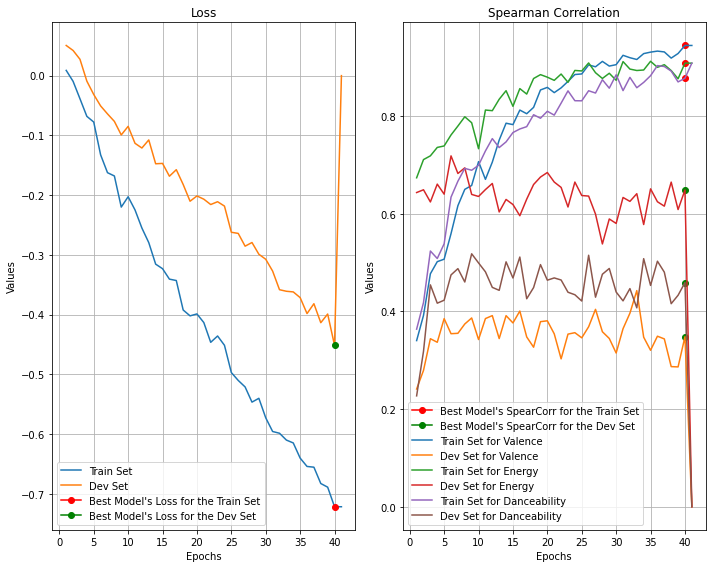

In [ ]:
EarlyCNNNet = MultiCNN(layer_channels, hidden_features, out_features, kernels).to(device)

# Make instance of our optimizer, with L2-Reguralization
parameters = list(EarlyCNNNet.parameters()) + list(criterion.parameters())
optimizer = optim.Adam(parameters, lr=ETA, weight_decay=weight_decay)

# Start the training process
reg_main(device, EarlyCNNNet, mels_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, Descrs = ['Valence', 'Energy', 'Danceability'], net_name='EarlyMultiCNNTrain_beatMEL', PATIENCE=PATIENCE, cnn=True, multi=True)

##### Show Loss Weights Convergence

In [ ]:
print(criterion)

The Loss Convergence: tensor([0., 0., 0.]) -> tensor([-0.1534, -0.1531, -0.1533])


Spearman Correlation for Valence: 0.3852089237535956
Spearman Correlation for Energy: 0.5977848963882907
Spearman Correlation for Danceability: 0.5026388337653699


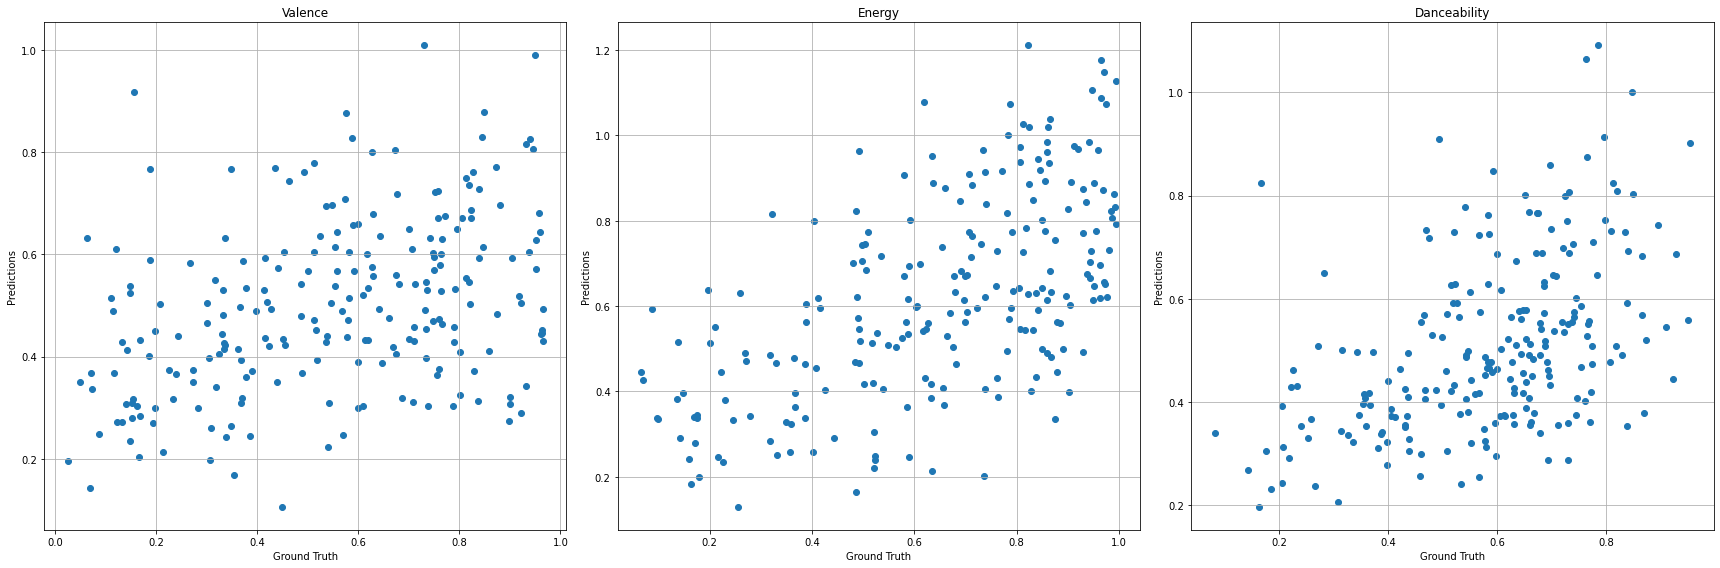

In [ ]:
with open('./best_EarlyMultiCNNTrain_beatMEL.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
_ = reg_eval(device, dev_loader, mels_feats, E_model, criterion, cnn=True, multi=True, titles=['Valence', 'Energy', 'Danceability'])

### Multi CNN Training with constant weights

#### Redefine MultiTask Regresion Parameters

In [ ]:
out_features = 1
task_num = 3
regularization_strength = 1e-2
loss = SpearmanLoss(regularization_strength=regularization_strength)
weights = [1, 1, 1]
criterion = MultiTaskLoss(task_num)

#### Modeling Pipeline

In [ ]:
data = SpectrogramDataset("data/multitask_dataset_beat/",
                              class_mapping=class_mapping, train=True, read_spec_fn=read_mel_spectrogram, emotion=np.array(list(mapping.values())))
train_loader, dev_loader = torch_train_val_split(data, batch_size , batch_size, val_size=val_size)
test_data = SpectrogramDataset('data/multitask_dataset_beat/',
                                          class_mapping=class_mapping, train=False, read_spec_fn=read_mel_spectrogram, emotion=np.array(list(mapping.values())))

##### Overfit the model


  0%|          | 0/30 [00:00<?, ?it/s]

 [=================================-------] ...Epoch 1, Loss: 0.2590
Statistics for the Train Set
	 Epoch: 1 	 loss: 0.23399311562308944
	 Epoch: 1 	 Spear Corr 1: 0.3064907335524536
	 Epoch: 1 	 Spear Corr 2: 0.6059723463377399
	 Epoch: 1 	 Spear Corr 3: 0.2719857667761821


  3%|▎         | 1/30 [00:01<00:46,  1.62s/it]

Statistics for the Dev Set
	 Epoch: 1 	 loss: 0.2470785948349831
	 Epoch: 1 	 Spear Corr 1: 0.2669054802303291
	 Epoch: 1 	 Spear Corr 2: 0.5816007655487218
	 Epoch: 1 	 Spear Corr 3: 0.24042339421120695
Dev loss decreased (0.247079 --> 0.247079).  Saving model ...
Epoch total time 1.6161596775054932
 [=================================-------] ...Epoch 2, Loss: 0.1621
Statistics for the Train Set
	 Epoch: 2 	 loss: 0.14379536571634485
	 Epoch: 2 	 Spear Corr 1: 0.39348238010045733
	 Epoch: 2 	 Spear Corr 2: 0.6832036982772669
	 Epoch: 2 	 Spear Corr 3: 0.40554550506376963


  7%|▋         | 2/30 [00:03<00:45,  1.61s/it]

Statistics for the Dev Set
	 Epoch: 2 	 loss: 0.14119947905706295
	 Epoch: 2 	 Spear Corr 1: 0.3967784984385499
	 Epoch: 2 	 Spear Corr 2: 0.6753263125405269
	 Epoch: 2 	 Spear Corr 3: 0.34983770740416853
Dev loss decreased (0.247079 --> 0.141199).  Saving model ...
Epoch total time 1.6048963069915771
 [=================================-------] ...Epoch 3, Loss: 0.2378
Statistics for the Train Set
	 Epoch: 3 	 loss: 0.1554543552296223
	 Epoch: 3 	 Spear Corr 1: 0.4404578145514369
	 Epoch: 3 	 Spear Corr 2: 0.6551177572591738
	 Epoch: 3 	 Spear Corr 3: 0.48855525134109784


 10%|█         | 3/30 [00:04<00:43,  1.62s/it]

Statistics for the Dev Set
	 Epoch: 3 	 loss: 0.1506272951374564
	 Epoch: 3 	 Spear Corr 1: 0.47749823778946804
	 Epoch: 3 	 Spear Corr 2: 0.6520002419918339
	 Epoch: 3 	 Spear Corr 3: 0.4361541371807123
EarlyStopping counter: 1 out of 10
Epoch total time 1.6275813579559326
 [=================================-------] ...Epoch 4, Loss: 0.0828
Statistics for the Train Set
	 Epoch: 4 	 loss: 0.1445390317545006
	 Epoch: 4 	 Spear Corr 1: 0.4858327947329373
	 Epoch: 4 	 Spear Corr 2: 0.717004077251663
	 Epoch: 4 	 Spear Corr 3: 0.3806462492218571


 13%|█▎        | 4/30 [00:06<00:42,  1.62s/it]

Statistics for the Dev Set
	 Epoch: 4 	 loss: 0.14510877422018106
	 Epoch: 4 	 Spear Corr 1: 0.458468018654047
	 Epoch: 4 	 Spear Corr 2: 0.7231295970017236
	 Epoch: 4 	 Spear Corr 3: 0.3657253416622933
EarlyStopping counter: 2 out of 10
Epoch total time 1.621183156967163
 [=================================-------] ...Epoch 5, Loss: 0.1347
Statistics for the Train Set
	 Epoch: 5 	 loss: 0.11520085227171252
	 Epoch: 5 	 Spear Corr 1: 0.5343784990222545
	 Epoch: 5 	 Spear Corr 2: 0.7316424137427174
	 Epoch: 5 	 Spear Corr 3: 0.4866427907910621


 17%|█▋        | 5/30 [00:08<00:41,  1.66s/it]

Statistics for the Dev Set
	 Epoch: 5 	 loss: 0.11190453366555238
	 Epoch: 5 	 Spear Corr 1: 0.535453414423098
	 Epoch: 5 	 Spear Corr 2: 0.7300939923959365
	 Epoch: 5 	 Spear Corr 3: 0.5160285740052026
Dev loss decreased (0.141199 --> 0.111905).  Saving model ...
Epoch total time 1.7222530841827393
 [=================================-------] ...Epoch 6, Loss: 0.2338
Statistics for the Train Set
	 Epoch: 6 	 loss: 0.11339930052149069
	 Epoch: 6 	 Spear Corr 1: 0.5290312396324957
	 Epoch: 6 	 Spear Corr 2: 0.7234969473949198
	 Epoch: 6 	 Spear Corr 3: 0.4810605324049164


 20%|██        | 6/30 [00:09<00:39,  1.64s/it]

Statistics for the Dev Set
	 Epoch: 6 	 loss: 0.11171226701823606
	 Epoch: 6 	 Spear Corr 1: 0.5355625025977915
	 Epoch: 6 	 Spear Corr 2: 0.7199512737107536
	 Epoch: 6 	 Spear Corr 3: 0.5036673742988936
Dev loss decreased (0.111905 --> 0.111712).  Saving model ...
Epoch total time 1.6106791496276855
 [=================================-------] ...Epoch 7, Loss: 0.0618
Statistics for the Train Set
	 Epoch: 7 	 loss: 0.10315950180611949
	 Epoch: 7 	 Spear Corr 1: 0.5431054369993679
	 Epoch: 7 	 Spear Corr 2: 0.7656192594410915
	 Epoch: 7 	 Spear Corr 3: 0.5407089404983632


 23%|██▎       | 7/30 [00:11<00:37,  1.63s/it]

Statistics for the Dev Set
	 Epoch: 7 	 loss: 0.10098022947355559
	 Epoch: 7 	 Spear Corr 1: 0.5814193565498997
	 Epoch: 7 	 Spear Corr 2: 0.7500200335497904
	 Epoch: 7 	 Spear Corr 3: 0.5671930685724372
Dev loss decreased (0.111712 --> 0.100980).  Saving model ...
Epoch total time 1.594264030456543
 [=================================-------] ...Epoch 8, Loss: 0.0828
Statistics for the Train Set
	 Epoch: 8 	 loss: 0.09664098270922719
	 Epoch: 8 	 Spear Corr 1: 0.6213615285490156
	 Epoch: 8 	 Spear Corr 2: 0.7660133806101902
	 Epoch: 8 	 Spear Corr 3: 0.5467176180053172


 27%|██▋       | 8/30 [00:13<00:35,  1.62s/it]

Statistics for the Dev Set
	 Epoch: 8 	 loss: 0.09392914928786432
	 Epoch: 8 	 Spear Corr 1: 0.6318483854021818
	 Epoch: 8 	 Spear Corr 2: 0.7749578771483132
	 Epoch: 8 	 Spear Corr 3: 0.5463410368522863
Dev loss decreased (0.100980 --> 0.093929).  Saving model ...
Epoch total time 1.604985237121582
 [=================================-------] ...Epoch 9, Loss: 0.2865
Statistics for the Train Set
	 Epoch: 9 	 loss: 0.10715155227390348
	 Epoch: 9 	 Spear Corr 1: 0.6294579657102796
	 Epoch: 9 	 Spear Corr 2: 0.7731128727240228
	 Epoch: 9 	 Spear Corr 3: 0.5527412924734808


 30%|███       | 9/30 [00:14<00:34,  1.63s/it]

Statistics for the Dev Set
	 Epoch: 9 	 loss: 0.10485465018627693
	 Epoch: 9 	 Spear Corr 1: 0.6297869619242058
	 Epoch: 9 	 Spear Corr 2: 0.7464218788707104
	 Epoch: 9 	 Spear Corr 3: 0.5738058750477287
EarlyStopping counter: 1 out of 10
Epoch total time 1.635753870010376
 [=================================-------] ...Epoch 10, Loss: 0.1115
Statistics for the Train Set
	 Epoch: 10 	 loss: 0.11018538651952718
	 Epoch: 10 	 Spear Corr 1: 0.6268183981061008
	 Epoch: 10 	 Spear Corr 2: 0.7609129719515002
	 Epoch: 10 	 Spear Corr 3: 0.5588884308747869


 33%|███▎      | 10/30 [00:16<00:32,  1.62s/it]

Statistics for the Dev Set
	 Epoch: 10 	 loss: 0.10618607191643217
	 Epoch: 10 	 Spear Corr 1: 0.6378408939710707
	 Epoch: 10 	 Spear Corr 2: 0.7722502588338289
	 Epoch: 10 	 Spear Corr 3: 0.5196571840544761
EarlyStopping counter: 2 out of 10
Epoch total time 1.6070339679718018
 [=================================-------] ...Epoch 11, Loss: 0.0853
Statistics for the Train Set
	 Epoch: 11 	 loss: 0.09002122922111906
	 Epoch: 11 	 Spear Corr 1: 0.6846214677436028
	 Epoch: 11 	 Spear Corr 2: 0.8008988169971131
	 Epoch: 11 	 Spear Corr 3: 0.5850885529602483


 37%|███▋      | 11/30 [00:17<00:30,  1.62s/it]

Statistics for the Dev Set
	 Epoch: 11 	 loss: 0.09508886185778374
	 Epoch: 11 	 Spear Corr 1: 0.669792692740584
	 Epoch: 11 	 Spear Corr 2: 0.7813024847524177
	 Epoch: 11 	 Spear Corr 3: 0.5325213453830607
EarlyStopping counter: 3 out of 10
Epoch total time 1.6207120418548584
 [=================================-------] ...Epoch 12, Loss: 0.0930
Statistics for the Train Set
	 Epoch: 12 	 loss: 0.09069151701256302
	 Epoch: 12 	 Spear Corr 1: 0.6939551185865773
	 Epoch: 12 	 Spear Corr 2: 0.7674959397169063
	 Epoch: 12 	 Spear Corr 3: 0.6333610036995733


 40%|████      | 12/30 [00:19<00:29,  1.65s/it]

Statistics for the Dev Set
	 Epoch: 12 	 loss: 0.09302390674073788
	 Epoch: 12 	 Spear Corr 1: 0.7030666905638135
	 Epoch: 12 	 Spear Corr 2: 0.7560885649381494
	 Epoch: 12 	 Spear Corr 3: 0.6176050139690409
Dev loss decreased (0.093929 --> 0.093024).  Saving model ...
Epoch total time 1.7275950908660889
 [=================================-------] ...Epoch 13, Loss: 0.1412
Statistics for the Train Set
	 Epoch: 13 	 loss: 0.09198832751669707
	 Epoch: 13 	 Spear Corr 1: 0.6825383028581837
	 Epoch: 13 	 Spear Corr 2: 0.7690695824322564
	 Epoch: 13 	 Spear Corr 3: 0.6314187977955358


 43%|████▎     | 13/30 [00:21<00:27,  1.64s/it]

Statistics for the Dev Set
	 Epoch: 13 	 loss: 0.08795117350977912
	 Epoch: 13 	 Spear Corr 1: 0.6958923741026851
	 Epoch: 13 	 Spear Corr 2: 0.7837249126903726
	 Epoch: 13 	 Spear Corr 3: 0.6476272897595219
Dev loss decreased (0.093024 --> 0.087951).  Saving model ...
Epoch total time 1.6100795269012451
 [=================================-------] ...Epoch 14, Loss: 0.2977
Statistics for the Train Set
	 Epoch: 14 	 loss: 0.08007924971472176
	 Epoch: 14 	 Spear Corr 1: 0.726338894125734
	 Epoch: 14 	 Spear Corr 2: 0.7791528187899233
	 Epoch: 14 	 Spear Corr 3: 0.6302451737250802


 47%|████▋     | 14/30 [00:22<00:26,  1.64s/it]

Statistics for the Dev Set
	 Epoch: 14 	 loss: 0.07973571127058753
	 Epoch: 14 	 Spear Corr 1: 0.7203746405775343
	 Epoch: 14 	 Spear Corr 2: 0.7805295210619345
	 Epoch: 14 	 Spear Corr 3: 0.6319042684868094
Dev loss decreased (0.087951 --> 0.079736).  Saving model ...
Epoch total time 1.620115041732788
 [=================================-------] ...Epoch 15, Loss: 0.2043
Statistics for the Train Set
	 Epoch: 15 	 loss: 0.08545717701884745
	 Epoch: 15 	 Spear Corr 1: 0.7117145093718439
	 Epoch: 15 	 Spear Corr 2: 0.8116930738943352
	 Epoch: 15 	 Spear Corr 3: 0.6378779144180754


 50%|█████     | 15/30 [00:24<00:24,  1.63s/it]

Statistics for the Dev Set
	 Epoch: 15 	 loss: 0.08239677484525032
	 Epoch: 15 	 Spear Corr 1: 0.7270153811405989
	 Epoch: 15 	 Spear Corr 2: 0.8157892180330477
	 Epoch: 15 	 Spear Corr 3: 0.6517994940817744
EarlyStopping counter: 1 out of 10
Epoch total time 1.6262288093566895
 [=================================-------] ...Epoch 16, Loss: 0.0772
Statistics for the Train Set
	 Epoch: 16 	 loss: 0.09213244003664077
	 Epoch: 16 	 Spear Corr 1: 0.7210645822687636
	 Epoch: 16 	 Spear Corr 2: 0.7345675787895131
	 Epoch: 16 	 Spear Corr 3: 0.6848611319158062


 53%|█████▎    | 16/30 [00:26<00:22,  1.63s/it]

Statistics for the Dev Set
	 Epoch: 16 	 loss: 0.0865931675667843
	 Epoch: 16 	 Spear Corr 1: 0.7295807015069355
	 Epoch: 16 	 Spear Corr 2: 0.7787975819449691
	 Epoch: 16 	 Spear Corr 3: 0.6810780365948438
EarlyStopping counter: 2 out of 10
Epoch total time 1.6162109375
 [=================================-------] ...Epoch 17, Loss: 0.1973
Statistics for the Train Set
	 Epoch: 17 	 loss: 0.07580190500755592
	 Epoch: 17 	 Spear Corr 1: 0.7797064360682674
	 Epoch: 17 	 Spear Corr 2: 0.7733741839992985
	 Epoch: 17 	 Spear Corr 3: 0.6900894454461727


 57%|█████▋    | 17/30 [00:27<00:21,  1.63s/it]

Statistics for the Dev Set
	 Epoch: 17 	 loss: 0.07478796902820725
	 Epoch: 17 	 Spear Corr 1: 0.7510651228626495
	 Epoch: 17 	 Spear Corr 2: 0.7799083578621078
	 Epoch: 17 	 Spear Corr 3: 0.7130850732024967
Dev loss decreased (0.079736 --> 0.074788).  Saving model ...
Epoch total time 1.6159956455230713
 [=================================-------] ...Epoch 18, Loss: 0.3637
Statistics for the Train Set
	 Epoch: 18 	 loss: 0.0825258636725277
	 Epoch: 18 	 Spear Corr 1: 0.7587008476689343
	 Epoch: 18 	 Spear Corr 2: 0.8014791487566278
	 Epoch: 18 	 Spear Corr 3: 0.6637286238785761


 60%|██████    | 18/30 [00:29<00:19,  1.62s/it]

Statistics for the Dev Set
	 Epoch: 18 	 loss: 0.08042386335840664
	 Epoch: 18 	 Spear Corr 1: 0.7693748678806112
	 Epoch: 18 	 Spear Corr 2: 0.7897077825245559
	 Epoch: 18 	 Spear Corr 3: 0.6860710386896529
EarlyStopping counter: 1 out of 10
Epoch total time 1.5977935791015625
 [=================================-------] ...Epoch 19, Loss: 0.0617
Statistics for the Train Set
	 Epoch: 19 	 loss: 0.08535924846055264
	 Epoch: 19 	 Spear Corr 1: 0.7528399061003459
	 Epoch: 19 	 Spear Corr 2: 0.8245570821351782
	 Epoch: 19 	 Spear Corr 3: 0.6840503928785583


 63%|██████▎   | 19/30 [00:31<00:18,  1.65s/it]

Statistics for the Dev Set
	 Epoch: 19 	 loss: 0.07990139959570058
	 Epoch: 19 	 Spear Corr 1: 0.763115306223575
	 Epoch: 19 	 Spear Corr 2: 0.8150999389097623
	 Epoch: 19 	 Spear Corr 3: 0.7068271230005168
EarlyStopping counter: 2 out of 10
Epoch total time 1.7158799171447754
 [=================================-------] ...Epoch 20, Loss: 0.1511
Statistics for the Train Set
	 Epoch: 20 	 loss: 0.0643843424705961
	 Epoch: 20 	 Spear Corr 1: 0.7975815020781196
	 Epoch: 20 	 Spear Corr 2: 0.80387875815022
	 Epoch: 20 	 Spear Corr 3: 0.7366886910232489


 67%|██████▋   | 20/30 [00:32<00:16,  1.65s/it]

Statistics for the Dev Set
	 Epoch: 20 	 loss: 0.06572722918601402
	 Epoch: 20 	 Spear Corr 1: 0.7888453836591439
	 Epoch: 20 	 Spear Corr 2: 0.8233836422198498
	 Epoch: 20 	 Spear Corr 3: 0.7332362994109975
Dev loss decreased (0.074788 --> 0.065727).  Saving model ...
Epoch total time 1.6422710418701172
 [=================================-------] ...Epoch 21, Loss: 0.0764
Statistics for the Train Set
	 Epoch: 21 	 loss: 0.06296976489713273
	 Epoch: 21 	 Spear Corr 1: 0.7987602525849374
	 Epoch: 21 	 Spear Corr 2: 0.7926042678356925
	 Epoch: 21 	 Spear Corr 3: 0.7322806201293058


 70%|███████   | 21/30 [00:34<00:14,  1.64s/it]

Statistics for the Dev Set
	 Epoch: 21 	 loss: 0.06332119288958644
	 Epoch: 21 	 Spear Corr 1: 0.8070319964149061
	 Epoch: 21 	 Spear Corr 2: 0.8013953150486172
	 Epoch: 21 	 Spear Corr 3: 0.729596851778706
Dev loss decreased (0.065727 --> 0.063321).  Saving model ...
Epoch total time 1.6255617141723633
 [=================================-------] ...Epoch 22, Loss: 0.1537
Statistics for the Train Set
	 Epoch: 22 	 loss: 0.06184771450832713
	 Epoch: 22 	 Spear Corr 1: 0.8476151256537254
	 Epoch: 22 	 Spear Corr 2: 0.8364303645276082
	 Epoch: 22 	 Spear Corr 3: 0.745699039315995


 73%|███████▎  | 22/30 [00:35<00:13,  1.63s/it]

Statistics for the Dev Set
	 Epoch: 22 	 loss: 0.064940940789192
	 Epoch: 22 	 Spear Corr 1: 0.8504756369968056
	 Epoch: 22 	 Spear Corr 2: 0.8262346842826701
	 Epoch: 22 	 Spear Corr 3: 0.7776425832641172
EarlyStopping counter: 1 out of 10
Epoch total time 1.6165533065795898
 [=================================-------] ...Epoch 23, Loss: 0.3198
Statistics for the Train Set
	 Epoch: 23 	 loss: 0.0699340859020025
	 Epoch: 23 	 Spear Corr 1: 0.8142301588252041
	 Epoch: 23 	 Spear Corr 2: 0.82600343316678
	 Epoch: 23 	 Spear Corr 3: 0.7575459261089466


 77%|███████▋  | 23/30 [00:37<00:11,  1.63s/it]

Statistics for the Dev Set
	 Epoch: 23 	 loss: 0.06801482519688275
	 Epoch: 23 	 Spear Corr 1: 0.8240850814541797
	 Epoch: 23 	 Spear Corr 2: 0.8222861232638514
	 Epoch: 23 	 Spear Corr 3: 0.7561561635135633
EarlyStopping counter: 2 out of 10
Epoch total time 1.6172857284545898
 [=================================-------] ...Epoch 24, Loss: 0.0928
Statistics for the Train Set
	 Epoch: 24 	 loss: 0.074079942789913
	 Epoch: 24 	 Spear Corr 1: 0.8026849660514893
	 Epoch: 24 	 Spear Corr 2: 0.7962681107572225
	 Epoch: 24 	 Spear Corr 3: 0.7145082268220102


 80%|████████  | 24/30 [00:39<00:09,  1.63s/it]

Statistics for the Dev Set
	 Epoch: 24 	 loss: 0.0714725125402647
	 Epoch: 24 	 Spear Corr 1: 0.8136915701407443
	 Epoch: 24 	 Spear Corr 2: 0.7964098773854159
	 Epoch: 24 	 Spear Corr 3: 0.7129949920078708
EarlyStopping counter: 3 out of 10
Epoch total time 1.6181719303131104
 [=================================-------] ...Epoch 25, Loss: 0.0633
Statistics for the Train Set
	 Epoch: 25 	 loss: 0.05692475183612458
	 Epoch: 25 	 Spear Corr 1: 0.8379478883758935
	 Epoch: 25 	 Spear Corr 2: 0.8436093155522753
	 Epoch: 25 	 Spear Corr 3: 0.7320324079928627


 83%|████████▎ | 25/30 [00:40<00:08,  1.62s/it]

Statistics for the Dev Set
	 Epoch: 25 	 loss: 0.05546057160919669
	 Epoch: 25 	 Spear Corr 1: 0.8548515592381773
	 Epoch: 25 	 Spear Corr 2: 0.822102514352059
	 Epoch: 25 	 Spear Corr 3: 0.7536145680123552
Dev loss decreased (0.063321 --> 0.055461).  Saving model ...
Epoch total time 1.6196660995483398
 [=================================-------] ...Epoch 26, Loss: 0.2609
Statistics for the Train Set
	 Epoch: 26 	 loss: 0.056554364697831754
	 Epoch: 26 	 Spear Corr 1: 0.8364590825306886
	 Epoch: 26 	 Spear Corr 2: 0.8468288431355893
	 Epoch: 26 	 Spear Corr 3: 0.7663592673593249


 87%|████████▋ | 26/30 [00:42<00:06,  1.66s/it]

Statistics for the Dev Set
	 Epoch: 26 	 loss: 0.057225212140055264
	 Epoch: 26 	 Spear Corr 1: 0.8377579493422711
	 Epoch: 26 	 Spear Corr 2: 0.8322326554953602
	 Epoch: 26 	 Spear Corr 3: 0.7763594482343741
EarlyStopping counter: 1 out of 10
Epoch total time 1.7502467632293701
 [=================================-------] ...Epoch 27, Loss: 0.1613
Statistics for the Train Set
	 Epoch: 27 	 loss: 0.07035140994667283
	 Epoch: 27 	 Spear Corr 1: 0.8173254922827448
	 Epoch: 27 	 Spear Corr 2: 0.8107963647572086
	 Epoch: 27 	 Spear Corr 3: 0.7720231887563458


 90%|█████████ | 27/30 [00:44<00:05,  1.67s/it]

Statistics for the Dev Set
	 Epoch: 27 	 loss: 0.07069164218865208
	 Epoch: 27 	 Spear Corr 1: 0.8239835414586709
	 Epoch: 27 	 Spear Corr 2: 0.7902713492422365
	 Epoch: 27 	 Spear Corr 3: 0.7609073996795653
EarlyStopping counter: 2 out of 10
Epoch total time 1.675905704498291
 [=================================-------] ...Epoch 28, Loss: 0.0699
Statistics for the Train Set
	 Epoch: 28 	 loss: 0.06462580335224631
	 Epoch: 28 	 Spear Corr 1: 0.8309741662265779
	 Epoch: 28 	 Spear Corr 2: 0.8210181197875894
	 Epoch: 28 	 Spear Corr 3: 0.7095723291783933


 93%|█████████▎| 28/30 [00:45<00:03,  1.67s/it]

Statistics for the Dev Set
	 Epoch: 28 	 loss: 0.06363669081856245
	 Epoch: 28 	 Spear Corr 1: 0.8569992854981379
	 Epoch: 28 	 Spear Corr 2: 0.8314921216460662
	 Epoch: 28 	 Spear Corr 3: 0.7068210662167353
EarlyStopping counter: 3 out of 10
Epoch total time 1.6662323474884033
 [=================================-------] ...Epoch 29, Loss: 0.1118
Statistics for the Train Set
	 Epoch: 29 	 loss: 0.050680079342221934
	 Epoch: 29 	 Spear Corr 1: 0.8783163875009914
	 Epoch: 29 	 Spear Corr 2: 0.8540569774860866
	 Epoch: 29 	 Spear Corr 3: 0.7814488534472365


 97%|█████████▋| 29/30 [00:47<00:01,  1.66s/it]

Statistics for the Dev Set
	 Epoch: 29 	 loss: 0.05697937404624262
	 Epoch: 29 	 Spear Corr 1: 0.8557514662518209
	 Epoch: 29 	 Spear Corr 2: 0.8266205861358619
	 Epoch: 29 	 Spear Corr 3: 0.7813506854934167
EarlyStopping counter: 4 out of 10
Epoch total time 1.6461005210876465
 [=================================-------] ...Epoch 30, Loss: 0.0214
Statistics for the Train Set
	 Epoch: 30 	 loss: 0.055410562776461385
	 Epoch: 30 	 Spear Corr 1: 0.8865655199357951
	 Epoch: 30 	 Spear Corr 2: 0.8487264611244049
	 Epoch: 30 	 Spear Corr 3: 0.7108556796340985


100%|██████████| 30/30 [00:49<00:00,  1.64s/it]

Statistics for the Dev Set
	 Epoch: 30 	 loss: 0.056286982830863655
	 Epoch: 30 	 Spear Corr 1: 0.8865732669693162
	 Epoch: 30 	 Spear Corr 2: 0.8508648669555308
	 Epoch: 30 	 Spear Corr 3: 0.7100376326853659
EarlyStopping counter: 5 out of 10
Epoch total time 1.6757125854492188
Training total time 49.14910817146301


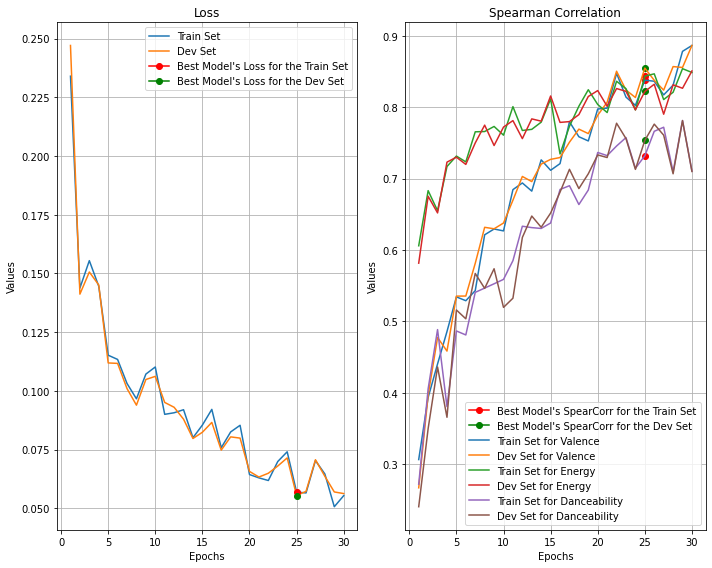

In [ ]:
EarlyCNNNet = MultiCNN(layer_channels, hidden_features, out_features, kernels).to(device)

# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(EarlyCNNNet.parameters(), lr=ETA, weight_decay=weight_decay)

reg_main(device, EarlyCNNNet, mels_feats, optimizer, criterion, train_loader, train_loader, 30, Descrs = ['Valence', 'Energy', 'Danceability'], PATIENCE=PATIENCE, overfit_batch=True, cnn=True, multi=True)

##### Normal Training

  0%|          | 0/100 [00:00<?, ?it/s]

 [=================================-------] ...Epoch 1, Loss: 0.5481
Statistics for the Train Set
	 Epoch: 1 	 loss: 1.072986755706313
	 Epoch: 1 	 Spear Corr 1: -0.06624151140052963
	 Epoch: 1 	 Spear Corr 2: -0.32851241870200165
	 Epoch: 1 	 Spear Corr 3: 0.04735836523955221


  1%|          | 1/100 [00:01<02:33,  1.55s/it]

Statistics for the Dev Set
	 Epoch: 1 	 loss: 1.020664731096957
	 Epoch: 1 	 Spear Corr 1: -0.0933765290568654
	 Epoch: 1 	 Spear Corr 2: -0.16222623855547316
	 Epoch: 1 	 Spear Corr 3: 0.07015932002665531
Dev loss decreased (1.020665 --> 1.020665).  Saving model ...
Epoch total time 1.5462827682495117
 [=================================-------] ...Epoch 2, Loss: 1.5685

  2%|▏         | 2/100 [00:02<02:21,  1.45s/it]


Statistics for the Train Set
	 Epoch: 2 	 loss: 1.0849463925020904
	 Epoch: 2 	 Spear Corr 1: -0.05025347361565715
	 Epoch: 2 	 Spear Corr 2: -0.2154311864525993
	 Epoch: 2 	 Spear Corr 3: 0.04759757919926956
Statistics for the Dev Set
	 Epoch: 2 	 loss: 1.0871904051477943
	 Epoch: 2 	 Spear Corr 1: -0.0694113938401452
	 Epoch: 2 	 Spear Corr 2: -0.10806398615688136
	 Epoch: 2 	 Spear Corr 3: 0.07150088926769733
EarlyStopping counter: 1 out of 10
Epoch total time 1.3782587051391602
 [=================================-------] ...Epoch 3, Loss: 1.2149

  3%|▎         | 3/100 [00:04<02:15,  1.39s/it]


Statistics for the Train Set
	 Epoch: 3 	 loss: 1.1290024972571513
	 Epoch: 3 	 Spear Corr 1: -0.02916390240159734
	 Epoch: 3 	 Spear Corr 2: -0.22941981584937188
	 Epoch: 3 	 Spear Corr 3: -0.04547877371996917
Statistics for the Dev Set
	 Epoch: 3 	 loss: 1.0842061345794034
	 Epoch: 3 	 Spear Corr 1: -0.05746913203269983
	 Epoch: 3 	 Spear Corr 2: -0.15970326500205353
	 Epoch: 3 	 Spear Corr 3: 0.11693326774776101
EarlyStopping counter: 2 out of 10
Epoch total time 1.327779769897461
 [=================================-------] ...Epoch 4, Loss: 0.9939

  4%|▍         | 4/100 [00:05<02:12,  1.38s/it]


Statistics for the Train Set
	 Epoch: 4 	 loss: 1.0999267393214498
	 Epoch: 4 	 Spear Corr 1: -0.04848590713325139
	 Epoch: 4 	 Spear Corr 2: -0.24333135601711398
	 Epoch: 4 	 Spear Corr 3: 0.009314231469172011
Statistics for the Dev Set
	 Epoch: 4 	 loss: 1.0902358199820268
	 Epoch: 4 	 Spear Corr 1: -0.08890658904284036
	 Epoch: 4 	 Spear Corr 2: -0.14139435662539657
	 Epoch: 4 	 Spear Corr 3: 0.12288998465645458
EarlyStopping counter: 3 out of 10
Epoch total time 1.3461129665374756
 [=================================-------] ...Epoch 5, Loss: 1.3146

  5%|▌         | 5/100 [00:06<02:08,  1.36s/it]


Statistics for the Train Set
	 Epoch: 5 	 loss: 1.119833301930236
	 Epoch: 5 	 Spear Corr 1: -0.008028569833380463
	 Epoch: 5 	 Spear Corr 2: -0.2511518113913572
	 Epoch: 5 	 Spear Corr 3: 0.0531976682265885
Statistics for the Dev Set
	 Epoch: 5 	 loss: 1.0890036977209019
	 Epoch: 5 	 Spear Corr 1: -0.038769375814944045
	 Epoch: 5 	 Spear Corr 2: -0.11527149058868813
	 Epoch: 5 	 Spear Corr 3: 0.16280660770538166
EarlyStopping counter: 4 out of 10
Epoch total time 1.3220007419586182
 [=================================-------] ...Epoch 6, Loss: 0.9854

  6%|▌         | 6/100 [00:08<02:06,  1.35s/it]


Statistics for the Train Set
	 Epoch: 6 	 loss: 1.114611415750171
	 Epoch: 6 	 Spear Corr 1: 0.0027701444870722653
	 Epoch: 6 	 Spear Corr 2: -0.25590822676526015
	 Epoch: 6 	 Spear Corr 3: 0.0015381993689047022
Statistics for the Dev Set
	 Epoch: 6 	 loss: 1.1022395903395439
	 Epoch: 6 	 Spear Corr 1: -0.06132193951881217
	 Epoch: 6 	 Spear Corr 2: -0.13981843239143663
	 Epoch: 6 	 Spear Corr 3: 0.09942079763906908
EarlyStopping counter: 5 out of 10
Epoch total time 1.3304550647735596
 [=================================-------] ...Epoch 7, Loss: 1.2196

  7%|▋         | 7/100 [00:09<02:06,  1.36s/it]


Statistics for the Train Set
	 Epoch: 7 	 loss: 1.1053253090883641
	 Epoch: 7 	 Spear Corr 1: -0.021824909693162746
	 Epoch: 7 	 Spear Corr 2: -0.22762090422184614
	 Epoch: 7 	 Spear Corr 3: 0.023033269300399353
Statistics for the Dev Set
	 Epoch: 7 	 loss: 1.0916082708231232
	 Epoch: 7 	 Spear Corr 1: -0.08237224462964718
	 Epoch: 7 	 Spear Corr 2: -0.19786711040765334
	 Epoch: 7 	 Spear Corr 3: 0.09748772075016611
EarlyStopping counter: 6 out of 10
Epoch total time 1.3730859756469727
 [=================================-------] ...Epoch 8, Loss: 0.7725

  8%|▊         | 8/100 [00:11<02:06,  1.37s/it]


Statistics for the Train Set
	 Epoch: 8 	 loss: 1.1180892064685592
	 Epoch: 8 	 Spear Corr 1: -0.017784231006118117
	 Epoch: 8 	 Spear Corr 2: -0.28131787732516345
	 Epoch: 8 	 Spear Corr 3: 0.05460875799222266
Statistics for the Dev Set
	 Epoch: 8 	 loss: 1.099517758472079
	 Epoch: 8 	 Spear Corr 1: -0.11422130127561873
	 Epoch: 8 	 Spear Corr 2: -0.129927799504385
	 Epoch: 8 	 Spear Corr 3: 0.05411867896593509
EarlyStopping counter: 7 out of 10
Epoch total time 1.3966033458709717
 [=================================-------] ...Epoch 9, Loss: 0.8662

  9%|▉         | 9/100 [00:12<02:03,  1.36s/it]


Statistics for the Train Set
	 Epoch: 9 	 loss: 1.1004643290734482
	 Epoch: 9 	 Spear Corr 1: -0.019901764549339774
	 Epoch: 9 	 Spear Corr 2: -0.2456817158000702
	 Epoch: 9 	 Spear Corr 3: 0.03305977357089804
Statistics for the Dev Set
	 Epoch: 9 	 loss: 1.090457443475823
	 Epoch: 9 	 Spear Corr 1: -0.0896539813776827
	 Epoch: 9 	 Spear Corr 2: -0.22467010092744616
	 Epoch: 9 	 Spear Corr 3: 0.09361943156568915
EarlyStopping counter: 8 out of 10
Epoch total time 1.337341070175171
 [=================================-------] ...Epoch 10, Loss: 0.4215

 10%|█         | 10/100 [00:13<02:02,  1.36s/it]


Statistics for the Train Set
	 Epoch: 10 	 loss: 1.0744870632120134
	 Epoch: 10 	 Spear Corr 1: -0.049117393935185265
	 Epoch: 10 	 Spear Corr 2: -0.2093528200561944
	 Epoch: 10 	 Spear Corr 3: 0.022346284192781157
Statistics for the Dev Set
	 Epoch: 10 	 loss: 1.1027530864630144
	 Epoch: 10 	 Spear Corr 1: -0.06732083070925758
	 Epoch: 10 	 Spear Corr 2: -0.1374203796614406
	 Epoch: 10 	 Spear Corr 3: 0.051812439761278674
EarlyStopping counter: 9 out of 10
Epoch total time 1.3433253765106201
 [=================================-------] ...Epoch 11, Loss: 1.2347

 10%|█         | 10/100 [00:15<02:15,  1.51s/it]


Statistics for the Train Set
	 Epoch: 11 	 loss: 1.079989743152856
	 Epoch: 11 	 Spear Corr 1: -0.015263222014402432
	 Epoch: 11 	 Spear Corr 2: -0.2712203897342709
	 Epoch: 11 	 Spear Corr 3: 0.02691669512041686
Statistics for the Dev Set
	 Epoch: 11 	 loss: 1.1079794212244292
	 Epoch: 11 	 Spear Corr 1: -0.07158256857286224
	 Epoch: 11 	 Spear Corr 2: -0.2113254606576977
	 Epoch: 11 	 Spear Corr 3: 0.08913454370496728
EarlyStopping counter: 10 out of 10
Training total time 13.701245784759521


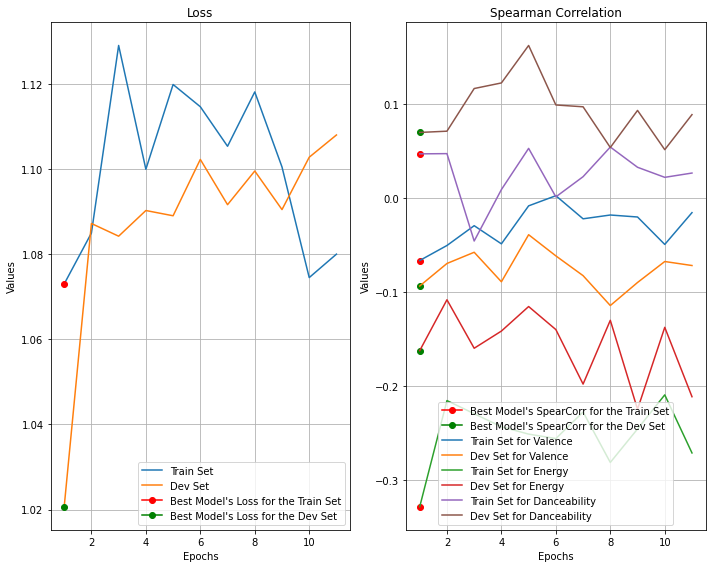

In [ ]:
EarlyCNNNet = MultiCNN(layer_channels, hidden_features, out_features, kernels).to(device)

# Make instance of our optimizer, with L2-Reguralization
optimizer = optim.Adam(parameters, lr=ETA, weight_decay=weight_decay)

# Start the training process
reg_main(device, EarlyCNNNet, mels_feats, optimizer, criterion, train_loader, dev_loader, EPOCHS, Descrs = ['Valence', 'Energy', 'Danceability'], net_name='EarlyMultiCNNConst_beatMEL', PATIENCE=PATIENCE, cnn=True, multi=True)

Spearman Correlation for Valence: -0.09817585554988882
Spearman Correlation for Energy: -0.23665075528331664
Spearman Correlation for Danceability: 0.08127624715576763


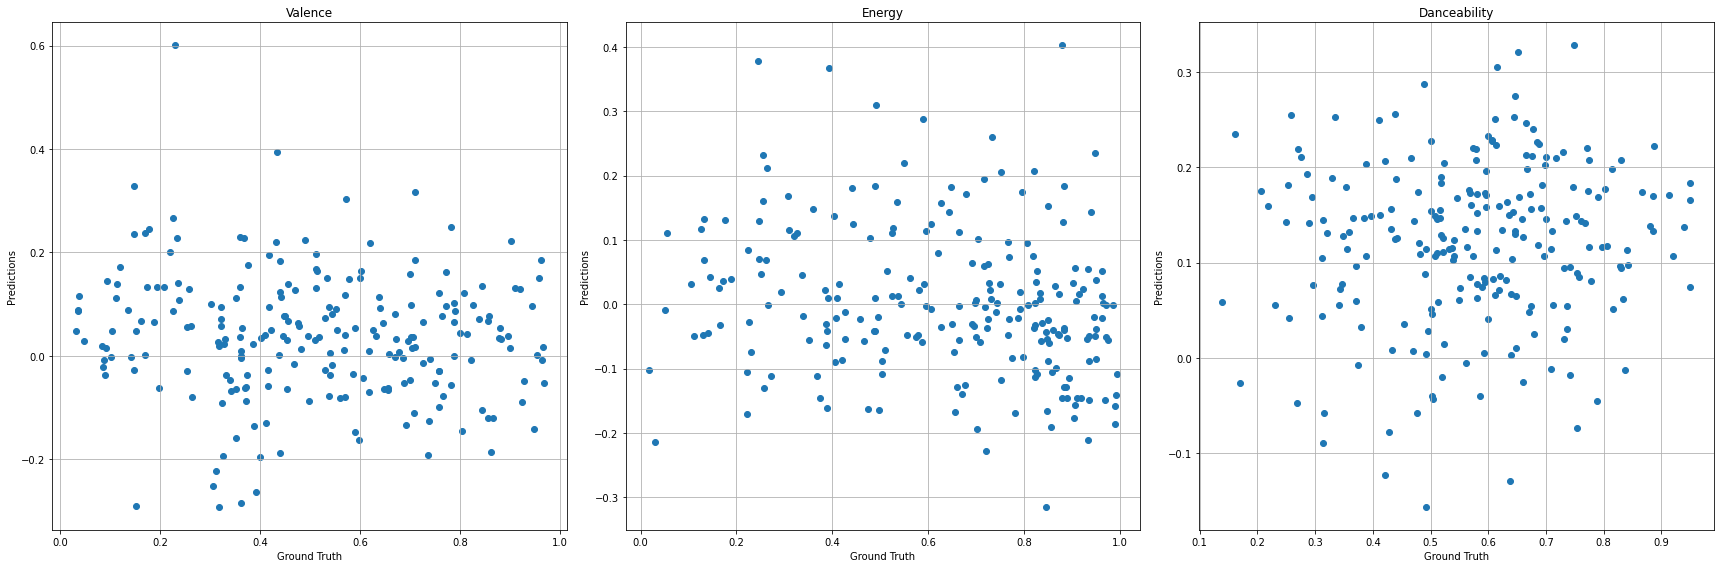

In [ ]:
with open('./best_EarlyMultiCNNConst_beatMEL.pickle', 'rb') as handle:
    E_model = pickle.load(handle)

# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
_ = reg_eval(device, dev_loader, mels_feats, E_model, criterion, cnn=True, multi=True, titles=['Valence', 'Energy', 'Danceability'])